In [1]:
import numpy as np
from gwbench import snr
from gwbench import waveform as wfc
from gwbench import injections
from gwbench import network
from gwbench import basic_relations as br
# from gwbench.snr import scalar_product_freq_array

import bilby 
import time

from pycbc import conversions as conv

from astropy.cosmology import Planck18, z_at_value

import gwbench_network_funcs as gwnet

from scipy.optimize import minimize
from scipy import optimize
from scipy import interpolate
from scipy import integrate

import lalsimulation as ls
import lal

from pycbc.types import FrequencySeries
from pycbc.filter import match
from pycbc.filter import matchedfilter
import pycbc.filter as fil

from pycbc import types, fft, waveform


In [2]:
import matplotlib.pyplot as plt

plt.rcParams.update({
    # "text.usetex": True,
    # "font.family": "serif",
    "font.size": 14
})

%config InlineBackend.figure_format='retina' # very useful command for high-res images


In [3]:
def inner_prod_simps_normed(h1, h2, Sn, f, h1_norm = None, h2_norm=None):
    if h1_norm is None:
        h1_norm = 4*np.real(integrate.simpson(y= h1*np.conjugate(h1) / Sn, x=f))
    if h2_norm is None:
        h2_norm = 4*np.real(integrate.simpson(y= h2*np.conjugate(h2) / Sn, x=f))
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f)) / (np.sqrt(h1_norm * h2_norm))

def inner_prod_simps(h1, h2, Sn, f):
    return  2*np.real(integrate.simpson(y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn, x=f))

# def inner_prod(h1, h2, Sn, f):
#     x=f
#     y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn
#     interp_func = interpolate.interp1d(x, y, kind='cubic')
#     # Define the integration limits
#     a = x[0]
#     b = x[-1]
#     result, error = integrate.quadrature(interp_func, a, b, maxiter=100)
#     return 2*np.real(result)

# def inner_prod_normed(h1, h2, Sn, f):
#     x=f
#     a = x[0]
#     b = x[-1]

#     y1= h1*np.conjugate(h1) / Sn
#     interp_func1 = interpolate.interp1d(x, y1, kind='cubic')
#     h1_norm, error = integrate.quadrature(interp_func1, a, b, maxiter=100)
#     h1_norm = 4*np.real(h1_norm)

#     y2= h2*np.conjugate(h2) / Sn
#     interp_func2 = interpolate.interp1d(x, y2, kind='cubic')
#     h2_norm, error = integrate.quadrature(interp_func2, a, b, maxiter=100)
#     h2_norm = 4*np.real(h2_norm)

#     y= (h1*np.conjugate(h2) + h2*np.conjugate(h1)) / Sn
#     interp_func = interpolate.interp1d(x, y, kind='cubic')
#     result, error = integrate.quadrature(interp_func, a, b, maxiter=100)

#     return 2*np.real(result / (np.sqrt(h1_norm * h2_norm)))


def cutler_vallisneri_overlap_vec(del_hf, delta_hf, psd, freqs):
    return np.array([ inner_prod_simps(del_hf[deriv], delta_hf, psd, freqs) for deriv in del_hf ])



# Typical Binary

In [4]:
network_spec = ['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
 
inj_params = dict()
inj_params['Mc'] =  9.39084
inj_params['eta'] = 0.249315
inj_params['iota'] = 0.631326
inj_params['chi1x'] = 0
inj_params['chi1y'] = 0
inj_params['chi1z'] = -0.077405
inj_params['chi2x'] = 0
inj_params['chi2y'] = 0
inj_params['chi2z'] = 0.046826
inj_params['DL'] = 3665.091694
inj_params['tc'] = 0
inj_params['phic'] = 0
inj_params['ra'] = 0.849465
inj_params['dec'] = 0.727626
inj_params['psi'] = 5.695632
inj_params['gmst0'] = bilby.gw.utils.greenwich_mean_sidereal_time(0.)
inj_params['phiRef'] = 0

d_f = 2**-4
f_low = 5.
f_high = 2048.
f = np.arange(f_low, f_high, d_f)
 
deriv_symbs_string = 'Mc eta DL chi1z chi2z tc phic iota ra dec psi'
deriv_variables = ['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'tc', 'phic', 'iota', 'ra', 'dec', 'psi']

pe_errs = np.array([0.0009169925416827596, 0.007665884431085734, 333.6799434184661, 0.2672323656549348, 0.4189364665733689, 0., 2.2470361867985393, 0.1896446518034874, 0.0018160818879470186, 0.003940179965523982, 2.2402741455941424])

pe_bias = np.array([-0.29558696911085086, 0.23717782723605144, -0.34411475585677387, -0.18720456992662562, 0.10293413303406986, 0., -2.305980298809557, 0.32500909266297284, -0.1206176196797399, -0.015546761582971788, -0.003586600790606256])

In [5]:
net_ap = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomD'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_ap.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})


use_rot = 0

net_ap.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_ap.calc_wf_polarizations()
net_ap.calc_wf_polarizations_derivs_num(step=1e-5, method='central', order=2, n=1)
net_ap.setup_ant_pat_lpf_psds()
net_ap.calc_det_responses()
net_ap.calc_det_responses_derivs_num(step=1e-5, method='central', order=2, n=1)
net_ap.calc_snrs()
net_ap.calc_errors()


net_tr = network.Network(network_spec=network_spec)

approximant = 'IMRPhenomXAS'
wf_model_name = 'lal_bbh'
# pass the chosen waveform to the network for initialization
net_tr.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

net_tr.set_net_vars(
    f=f, inj_params=inj_params,
    deriv_symbs_string=deriv_symbs_string,
    use_rot=use_rot
    )
net_tr.calc_wf_polarizations()
net_tr.setup_ant_pat_lpf_psds()
net_tr.calc_det_responses()
net_tr.calc_snrs()

2023-12-28 16:54:28,478 - Network - INFO : Polarizations calculated.
2023-12-28 16:54:28,479 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-12-28 16:54:28,486 - Network - INFO : Polarizations calculated.
2023-12-28 16:54:34,443 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-28 16:54:34,569 - Network - INFO : PSDs loaded.
2023-12-28 16:54:34,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 16:54:34,598 - Network - INFO : Detector responses calculated.
2023-12-28 16:54:34,599 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-28 16:54:34,600 - Network - INFO :    CE-40_C
2023-12-28 16:54:38,354 - Network - INFO :    CE-20_S
2023-12-28 16:54:42,152 - Network - INFO :    ET_ET1
2023-12-28 16:54:45,964 - Network - INFO :    ET_ET2
2023-12-28 16:54:49,716 - Network - INFO :    ET_ET3
2023-12-28 16:54:53,499 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-28 1

In [6]:
for i, var in enumerate(deriv_variables):
    sigma = net_ap.errs[var]
    print(f"{deriv_variables[i]} Fisher: {sigma:.5f}")
    print(f"{deriv_variables[i]} PE: {pe_errs[i]:.5f}")
    print()

Mc Fisher: 0.00137
Mc PE: 0.00092

eta Fisher: 0.01527
eta PE: 0.00767

DL Fisher: 365.29041
DL PE: 333.67994

chi1z Fisher: 2.72458
chi1z PE: 0.26723

chi2z Fisher: 2.91561
chi2z PE: 0.41894

tc Fisher: 0.00160
tc PE: 0.00000

phic Fisher: 0.51389
phic PE: 2.24704

iota Fisher: 0.15518
iota PE: 0.18964

ra Fisher: 0.00222
ra PE: 0.00182

dec Fisher: 0.00152
dec PE: 0.00394

psi Fisher: 0.25338
psi PE: 2.24027



# Unoptimized Bias

In [9]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

for d in range(len(net_ap.detectors)):
    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    ## Compute CV overlap vector for this detector
    delta_hf = net_tr.detectors[d].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)


cv_bias = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias = np.array(cv_bias.tolist()[0])

Mc: -456.205%
eta: 178.429%
DL: -5474.482%
chi1z: -1418.799%
chi2z: 2753.913%
tc: inf%
phic: -223.482%
iota: 266.498%
ra: -874.552%
dec: -1788.091%
psi: -48014.761%


/var/folders/wj/l7fs8hg555n8nzz7myk9cysw0000gn/T/ipykernel_22083/3024221112.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  bias_diff = 100*np.abs(pe_bias[i]-cv_bias_sigma[i])/pe_bias[i]


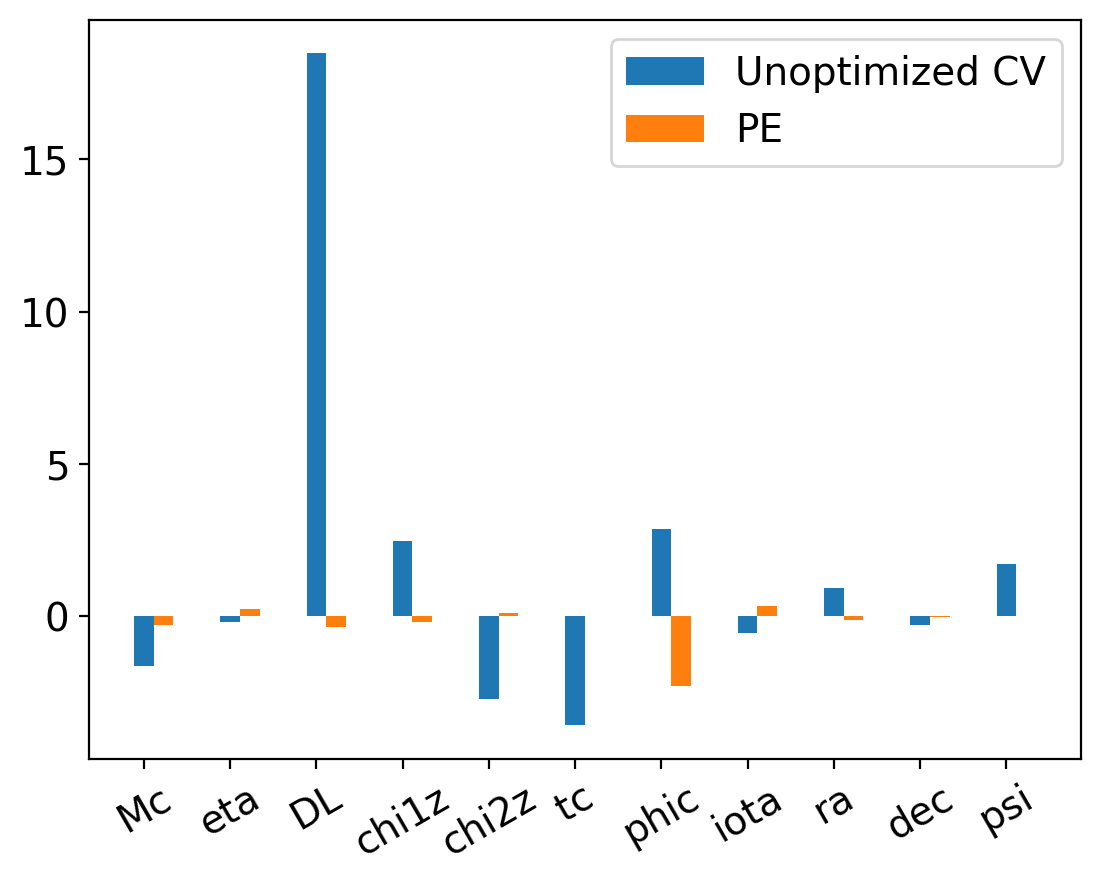

Mc, 1: -1.644 
Mc, 2: -0.296 

eta, 1: -0.186 
eta, 2: 0.237 

DL, 1: 18.494 
DL, 2: -0.344 

chi1z, 1: 2.469 
chi1z, 2: -0.187 

chi2z, 1: -2.732 
chi2z, 2: 0.103 

tc, 1: -3.581 
tc, 2: 0.000 

phic, 1: 2.847 
phic, 2: -2.306 

iota, 1: -0.541 
iota, 2: 0.325 

ra, 1: 0.934 
ra, 2: -0.121 

dec, 1: -0.294 
dec, 2: -0.016 

psi, 1: 1.719 
psi, 2: -0.004 



In [14]:
cv_bias_sigma = np.zeros(len(cv_bias))
for i, var in enumerate(deriv_variables):
    cv_bias_sigma[i] = cv_bias[i]/net_ap.errs[var]

    bias_diff = 100*np.abs(pe_bias[i]-cv_bias_sigma[i])/pe_bias[i]
    print(f"{var}: {bias_diff:.3f}%")



bias1 = cv_bias_sigma
bias2 = pe_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Unoptimized CV')
plt.bar(x+width, bias2, width=width, label='PE')

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Optimized Bias

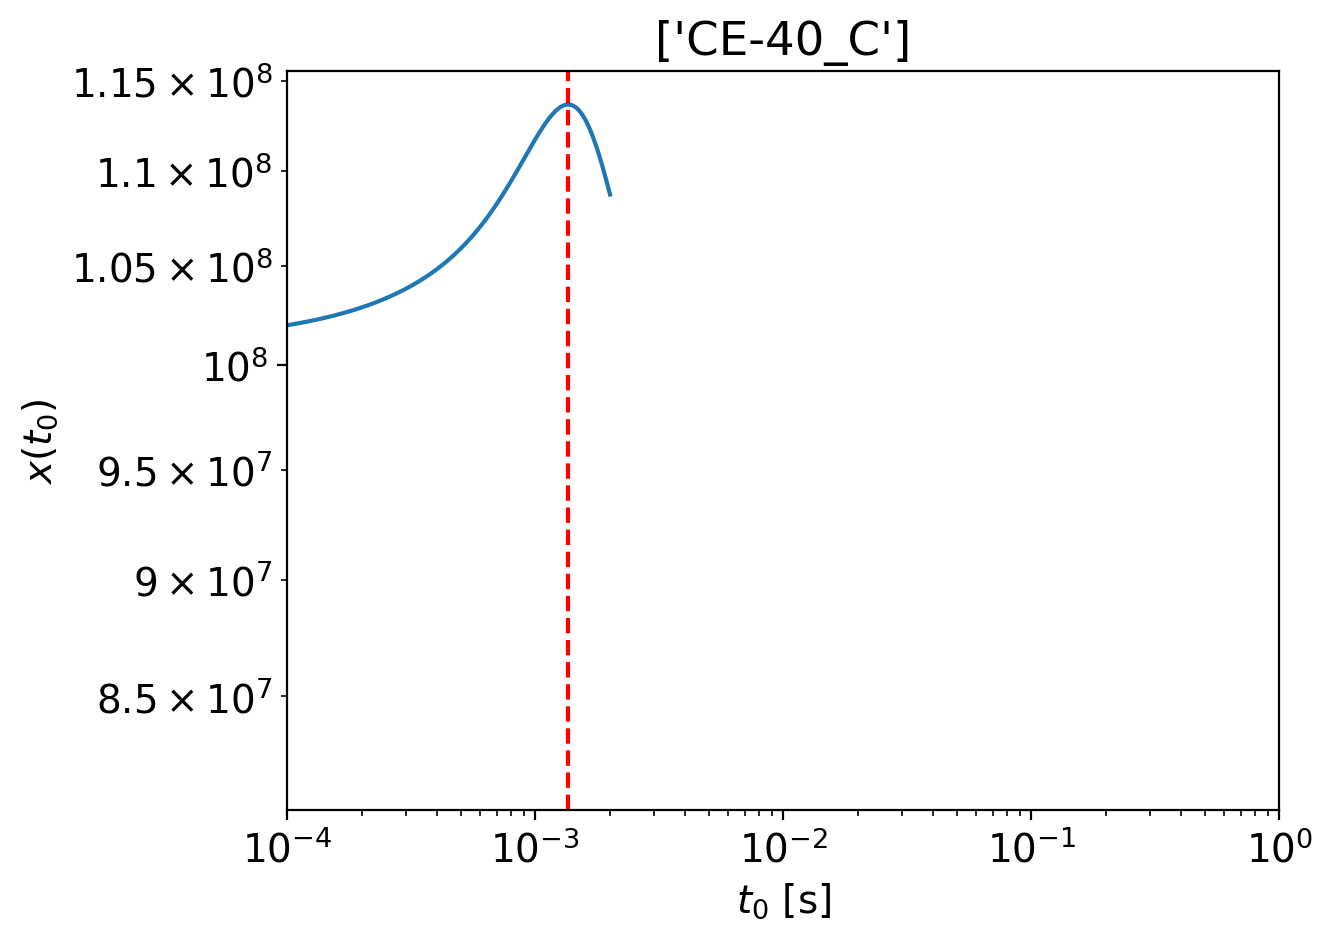

2023-12-28 16:58:07,743 - Network - INFO : Polarizations calculated.
2023-12-28 16:58:07,750 - Network - INFO : PSDs loaded.
2023-12-28 16:58:07,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 16:58:07,759 - Network - INFO : Detector responses calculated.
2023-12-28 16:58:07,765 - Network - INFO : Polarizations calculated.


time shift: 0.0013553333333333334
phase shift: -2.335624793308848
Inner product:
0.9999420554758361


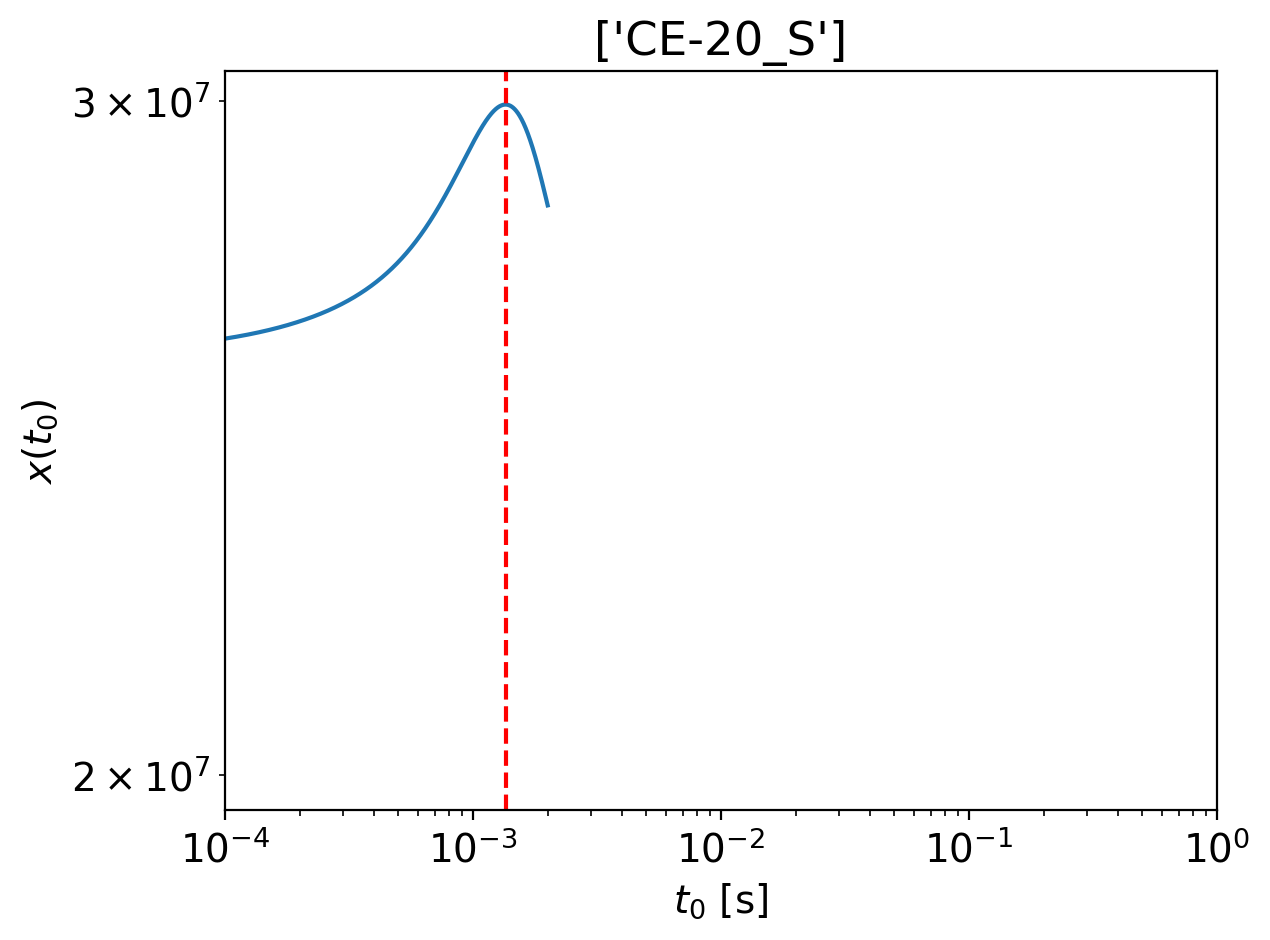

2023-12-28 16:58:26,020 - Network - INFO : Polarizations calculated.
2023-12-28 16:58:26,026 - Network - INFO : PSDs loaded.
2023-12-28 16:58:26,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 16:58:26,035 - Network - INFO : Detector responses calculated.
2023-12-28 16:58:26,041 - Network - INFO : Polarizations calculated.


time shift: 0.0013520000000000003
phase shift: -2.33754727229506
Inner product:
0.9999272207370968


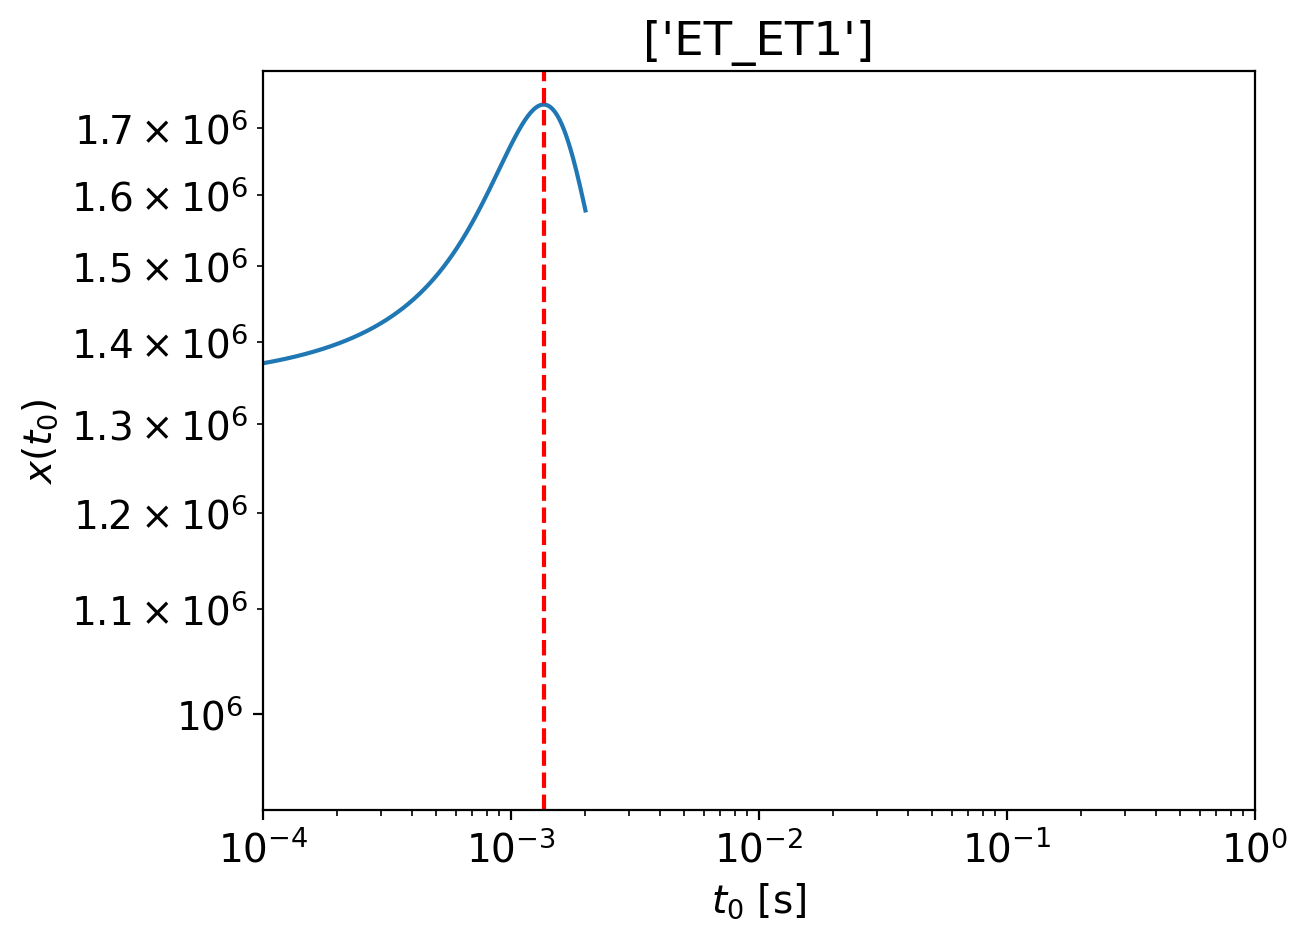

2023-12-28 16:58:49,355 - Network - INFO : Polarizations calculated.
2023-12-28 16:58:49,369 - Network - INFO : PSDs loaded.
2023-12-28 16:58:49,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 16:58:49,378 - Network - INFO : Detector responses calculated.
2023-12-28 16:58:49,384 - Network - INFO : Polarizations calculated.


time shift: 0.0013573333333333337
phase shift: -2.3315146181901607
Inner product:
0.9998657839253624


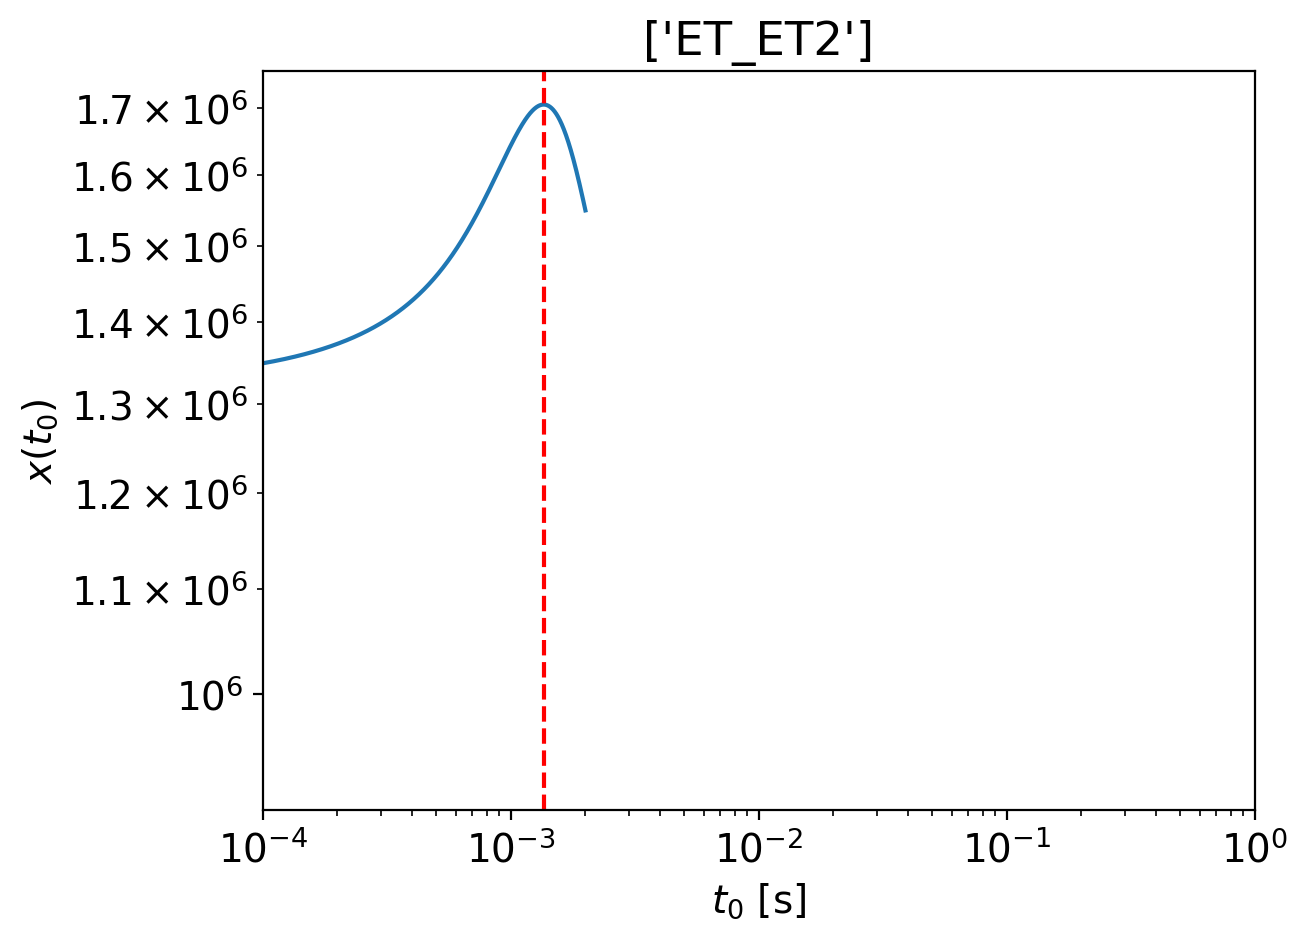

2023-12-28 16:59:12,700 - Network - INFO : Polarizations calculated.
2023-12-28 16:59:12,715 - Network - INFO : PSDs loaded.
2023-12-28 16:59:12,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 16:59:12,723 - Network - INFO : Detector responses calculated.
2023-12-28 16:59:12,729 - Network - INFO : Polarizations calculated.


time shift: 0.0013573333333333337
phase shift: -2.3315146181901607
Inner product:
0.9998657839253623


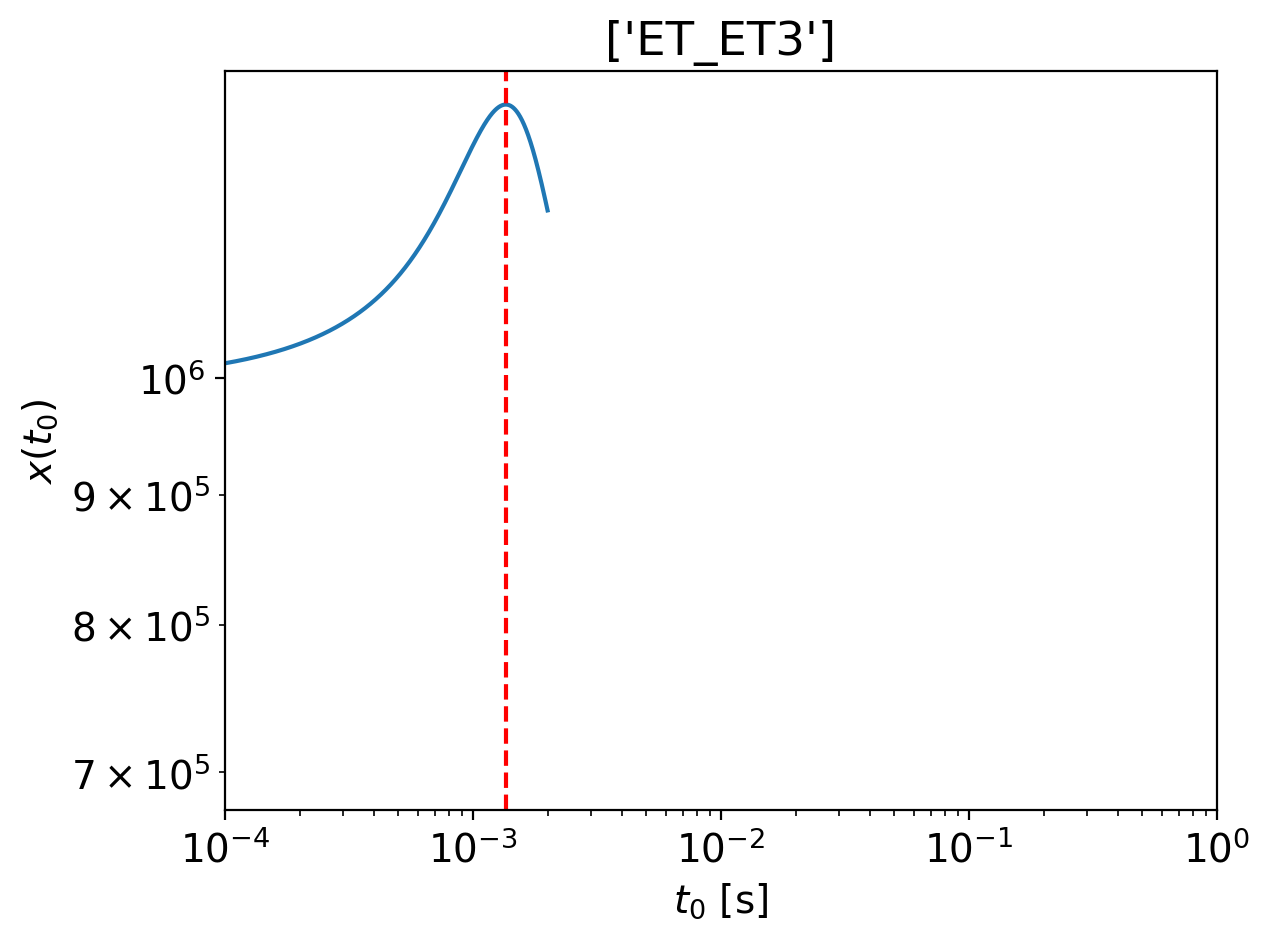

2023-12-28 16:59:36,036 - Network - INFO : Polarizations calculated.
2023-12-28 16:59:36,050 - Network - INFO : PSDs loaded.
2023-12-28 16:59:36,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 16:59:36,060 - Network - INFO : Detector responses calculated.
2023-12-28 16:59:36,065 - Network - INFO : Polarizations calculated.


time shift: 0.0013573333333333337
phase shift: -2.3315146181901607
Inner product:
0.9998657839253622


In [15]:
overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

time_arr_d = np.linspace(-0.002, 0.002, 12001)


# separate_det_opt = False
for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    x_t0_re_d = np.zeros(len(time_arr_d))
    x_t0_im_d = np.zeros(len(time_arr_d))

    for i in range(len(time_arr_d)):
        t0 = time_arr_d[i]
        x_t0_d = 4*(integrate.simpson(h1 * np.conjugate(h2) * np.exp(2*np.pi*1j*f*t0)/ Sn, x=f))
        x_t0_re_d[i] = np.real(x_t0_d)
        x_t0_im_d[i] = np.imag(x_t0_d)

    max_idx = np.argmax(x_t0_re_d**2 + x_t0_im_d**2)
    time_shift_d = time_arr_d[max_idx]
    phase_shift_d = (np.angle(x_t0_re_d + 1j*x_t0_im_d))[max_idx]

    plt.title(network_spec_d)
    plt.plot(time_arr_d, x_t0_re_d**2 + x_t0_im_d**2)
    plt.axvline(x=time_shift_d, ls='--', c='r')
    plt.xlabel('$t_0$ [s]')
    plt.ylabel("$x(t_0)$")
    plt.loglog()
    plt.xlim(1e-4, 1e0)
    plt.show()
    print("time shift:", time_shift_d)
    print("phase shift:", phase_shift_d)

    inj_params_opt_d = inj_params.copy()
    inj_params_opt_d['tc'] = time_shift_d # should be positive when shifting XAS to maximize overlap
    inj_params_opt_d['phic'] = phase_shift_d  # should be positive when shifting XAS to maximize overlap
 

    net_tr_opt_d = network.Network(network_spec=network_spec_d)
    net_tr_opt_d.set_wf_vars(wf_model_name='lal_bbh', wf_other_var_dic = {'approximant': 'IMRPhenomXAS'})
    net_tr_opt_d.set_net_vars(
        f=f, inj_params=inj_params_opt_d,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    net_tr_opt_d.calc_wf_polarizations()
    net_tr_opt_d.setup_ant_pat_lpf_psds()
    net_tr_opt_d.calc_det_responses()
    net_tr_opt_d.calc_wf_polarizations()

    print("Inner product:")
    print(inner_prod_simps_normed(net_ap.detectors[d].hf, net_tr_opt_d.detectors[0].hf, net_ap.detectors[d].psd, net_ap.detectors[d].f))


    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt = np.array(cv_bias_opt.tolist()[0])

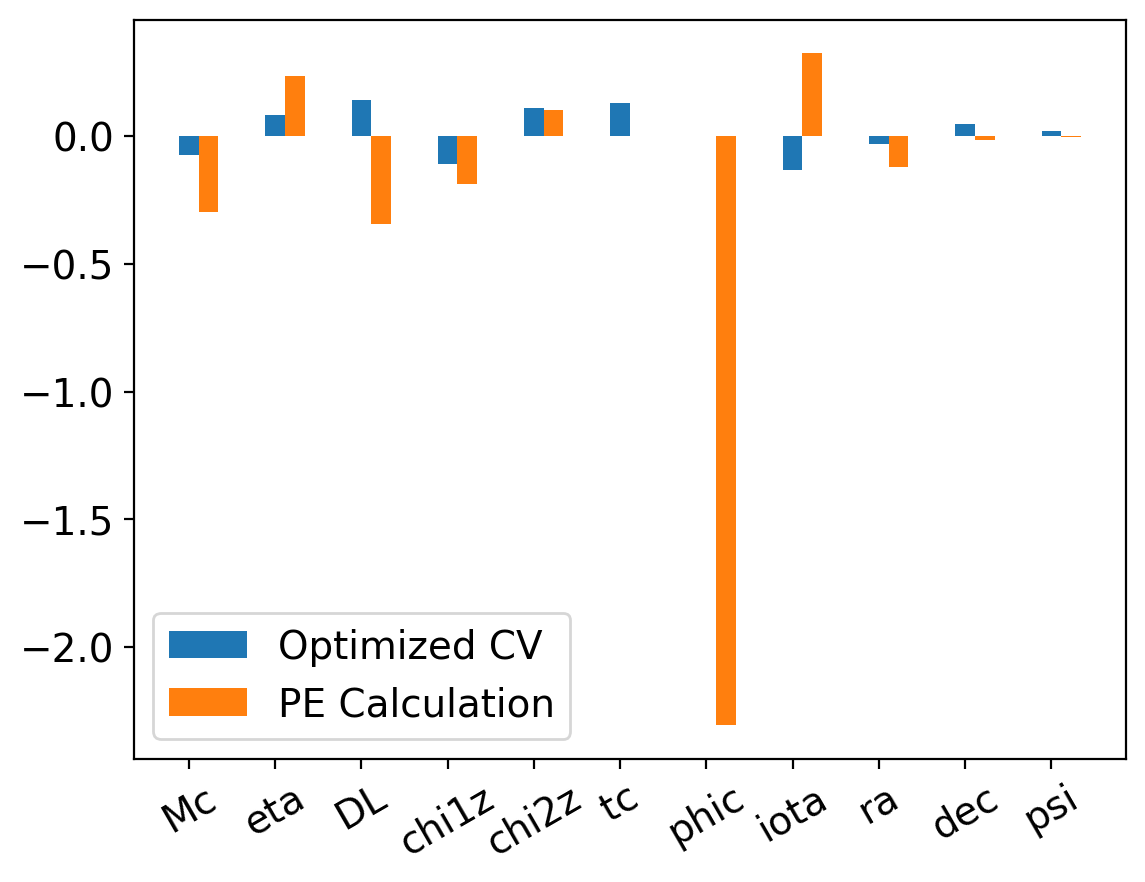

Mc, 1: -0.076 
Mc, 2: -0.296 

eta, 1: 0.082 
eta, 2: 0.237 

DL, 1: 0.139 
DL, 2: -0.344 

chi1z, 1: -0.109 
chi1z, 2: -0.187 

chi2z, 1: 0.110 
chi2z, 2: 0.103 

tc, 1: 0.129 
tc, 2: 0.000 

phic, 1: 0.002 
phic, 2: -2.306 

iota, 1: -0.134 
iota, 2: 0.325 

ra, 1: -0.032 
ra, 2: -0.121 

dec, 1: 0.049 
dec, 2: -0.016 

psi, 1: 0.021 
psi, 2: -0.004 



In [17]:
cv_bias_opt_sigma = np.zeros(len(cv_bias_opt))
for i, var in enumerate(deriv_variables):
    cv_bias_opt_sigma[i] = cv_bias_opt[i]/net_ap.errs[var]

    # bias_diff = 100*np.abs(pe_bias[i]-cv_bias_opt_sigma[i])/pe_bias[i]
    # print(f"{var}: {bias_diff:.3f}%")



bias1 = cv_bias_opt_sigma
bias2 = pe_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Optimized CV')
plt.bar(x+width, bias2, width=width, label="PE Calculation")

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Grid Search (same shift across detectors)

In [37]:
N_times = 50
time_shifts = np.linspace(-0.006, 0.006, N_times)

N_phases = 50
phase_shifts = np.linspace(-np.pi, np.pi, N_phases)

inner_prod_grid = np.zeros((N_times, N_phases))

d = 0

net_tr = gwnet.get_network_response(inj_params=inj_params, f_min=f_low, f_max=f_high, d_f=d_f, deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomXAS', network_spec=network_spec, calc_detector_responses=True, calc_derivs = False, calc_fisher=False)

h1 = net_tr.detectors[d].hf
f = net_ap.detectors[d].f
Sn = net_ap.detectors[d].psd

inj_params_shift = inj_params.copy()

for i, time_shift in enumerate(time_shifts):
    for j, phase_shift in enumerate(phase_shifts):
        inj_params_shift['tc'] = time_shift
        inj_params_shift['phic'] = phase_shift
        net_ap_time_shift = gwnet.get_network_response(inj_params=inj_params_shift, f_min=f_low, f_max=f_high, d_f=d_f, deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomD', network_spec=network_spec, calc_detector_responses=True, calc_derivs = False, calc_fisher=False)
        
        h2 = net_ap_time_shift.detectors[d].hf
        inner_prod_grid[i][j] = inner_prod_simps_normed(h1, h2, Sn, f)

2023-12-28 13:20:46,381 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:46,532 - Network - INFO : PSDs loaded.
2023-12-28 13:20:46,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:46,566 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:46,575 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:46,582 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:46,629 - Network - INFO : PSDs loaded.
2023-12-28 13:20:46,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:46,662 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:46,671 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.762942e-02
  warnings.warn(
2023-12-28 13:20:46,724 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:46,769 - Network - INFO : PSDs loaded.
2023-12-28 13:20:46,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:46,803 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:46,811 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:46,938 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:46,947 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.457111e-02
  warnings.warn(
2023-12-28 13:20:46,970 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,016 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:47,048 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:47,057 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.151730e-02
  warnings.warn(
2023-12-28 13:20:47,081 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,126 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,132 - Netwo

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:47,167 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.728919e-02
  warnings.warn(
2023-12-28 13:20:47,190 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,236 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:47,269 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:47,278 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.179198e-02
  warnings.warn(
2023-12-28 13:20:47,300 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,346 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,352 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:47,380 - Ne

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:47,390 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.495175e-02
  warnings.warn(
2023-12-28 13:20:47,412 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,459 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:47,491 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:47,500 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.671662e-02
  warnings.warn(
2023-12-28 13:20:47,522 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,567 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:47,599 - Ne

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.705761e-02
  warnings.warn(
2023-12-28 13:20:47,632 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,678 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:47,711 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:47,720 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.596911e-02
  warnings.warn(
2023-12-28 13:20:47,743 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,790 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:47,827 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:47,836 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.346899e-02
  warnings.warn(
2023-12-28 13:20:47,859 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:47,979 - Network - INFO : PSDs loaded.
2023-12-28 13:20:47,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:48,012 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:48,021 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.959833e-02
  warnings.warn(
2023-12-28 13:20:48,044 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:48,091 - Network - INFO : PSDs loaded.
2023-12-28 13:20:48,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:48,125 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:48,134 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.442065e-02
  warnings.warn(
2023-12-28 13:20:48,157 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:48,203 - Network - INFO : PSDs loaded.
2023-12-28 13:20:48,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:48,237 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:48,245 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.802100e-02
  warnings.warn(
2023-12-28 13:20:48,268

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:48,379 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:48,389 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.050444e-02
  warnings.warn(
2023-12-28 13:20:48,415 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:48,461 - Network - INFO : PSDs loaded.
2023-12-28 13:20:48,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:48,494 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:48,502 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.199440e-02
  warnings.warn(
2023-12-28 13:20:48,525 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:48,570 - Network - INFO : PSDs loaded.
2023-12-28 13:20:48,576 - Netwo

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:48,612 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.263061e-02
  warnings.warn(
2023-12-28 13:20:48,634 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:48,680 - Network - INFO : PSDs loaded.
2023-12-28 13:20:48,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:48,714 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:48,722 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.256683e-02
  warnings.warn(
2023-12-28 13:20:48,744 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:48,788 - Network - INFO : PSDs loaded.
2023-12-28 13:20:48,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:48,820 - Ne

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.196830e-02
  warnings.warn(
2023-12-28 13:20:48,855 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:48,910 - Network - INFO : PSDs loaded.
2023-12-28 13:20:48,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:48,944 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:48,953 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.100906e-02
  warnings.warn(
2023-12-28 13:20:48,975 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:49,098 - Network - INFO : PSDs loaded.
2023-12-28 13:20:49,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:49,131 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:49,139 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.309567e-04
  warnings.warn(
2023-12-28 13:20:49,162 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:49,206 - Network - INFO : PSDs loaded.
2023-12-28 13:20:49,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:49,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:49,247 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.126882e-02
  warnings.warn(
2023-12-28 13:20:49,270

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:49,358 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.222165e-02
  warnings.warn(
2023-12-28 13:20:49,381 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:49,426 - Network - INFO : PSDs loaded.
2023-12-28 13:20:49,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:49,458 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:49,467 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.280960e-02
  warnings.warn(
2023-12-28 13:20:49,490 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:49,538 - Network - INFO : PSDs loaded.
2023-12-28 13:20:49,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:49,573 - Ne

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:49,583 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.285882e-02
  warnings.warn(
2023-12-28 13:20:49,611 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:49,656 - Network - INFO : PSDs loaded.
2023-12-28 13:20:49,661 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:49,688 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:49,697 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.220430e-02
  warnings.warn(
2023-12-28 13:20:49,719 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:49,763 - Network - INFO : PSDs loaded.
2023-12-28 13:20:49,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:49,796 - Ne

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.069258e-02
  warnings.warn(
2023-12-28 13:20:49,827 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:49,872 - Network - INFO : PSDs loaded.
2023-12-28 13:20:49,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:49,905 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:49,913 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.818430e-02
  warnings.warn(
2023-12-28 13:20:49,955 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,003 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,009 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:50,038 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:50,048 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.455643e-02
  warnings.warn(
2023-12-28 13:20:50,073 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,121 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:50,153 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:50,161 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.970434e-02
  warnings.warn(
2023-12-28 13:20:50,184 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,227 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,233 - Netwo

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:50,268 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.354352e-02
  warnings.warn(
2023-12-28 13:20:50,290 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,336 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:50,372 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:50,381 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.601091e-02
  warnings.warn(
2023-12-28 13:20:50,404 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,451 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:50,486 - Ne

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:50,495 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.706600e-02
  warnings.warn(
2023-12-28 13:20:50,519 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,563 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:50,596 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:50,605 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.669147e-02
  warnings.warn(
2023-12-28 13:20:50,626 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,672 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:50,704 - Ne

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.489347e-02
  warnings.warn(
2023-12-28 13:20:50,736 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,780 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:50,812 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:50,821 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.170152e-02
  warnings.warn(
2023-12-28 13:20:50,843 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,889 - Network - INFO : PSDs loaded.
2023-12-28 13:20:50,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:50,922 - Network - INFO : Detector responses calculated.
2023-12-28 13:

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.716804e-02
  warnings.warn(
2023-12-28 13:20:50,953 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:50,998 - Network - INFO : PSDs loaded.
2023-12-28 13:20:51,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:51,031 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:51,040 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.136746e-02
  warnings.warn(
2023-12-28 13:20:51,062 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:51,106 - Network - INFO : PSDs loaded.
2023-12-28 13:20:51,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:51,141 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:51,150 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.439502e-02
  warnings.warn(
2023-12-28 13:20:51,177 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:51,306 - Network - INFO : PSDs loaded.
2023-12-28 13:20:51,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:51,338 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:51,347 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.636523e-02
  warnings.warn(
2023-12-28 13:20:51,369 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:51,414 - Network - INFO : PSDs loaded.
2023-12-28 13:20:51,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:51,468 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:51,478 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.740991e-02
  warnings.warn(
2023-12-28 13:20:51,504 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:51,549 - Network - INFO : PSDs loaded.
2023-12-28 13:20:51,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:51,581 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:51,590 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.767613e-02
  warnings.warn(
2023-12-28 13:20:51,611

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:51,702 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.732371e-02
  warnings.warn(
2023-12-28 13:20:51,729 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:51,785 - Network - INFO : PSDs loaded.
2023-12-28 13:20:51,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:51,820 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:51,829 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.652263e-02
  warnings.warn(
2023-12-28 13:20:51,851 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:51,902 - Network - INFO : PSDs loaded.
2023-12-28 13:20:51,908 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:51,939 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:51,949 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.450249e-03
  warnings.warn(
2023-12-28 13:20:51,977 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:52,029 - Network - INFO : PSDs loaded.
2023-12-28 13:20:52,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:52,067 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:52,077 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.711624e-03
  warnings.warn(
2023-12-28 13:20:52,104 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:52,170 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:52,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:52,269 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:52,283 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.677971e-02
  warnings.warn(
2023-12-28 13:20:52,323 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:52,402 - Network - INFO : PSDs loaded.
2023-12-28 13:20:52,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:52,457 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:52,473 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.757228e-02
  warnings.warn(
2023-12-28 13:20:52,511 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:52,599 - Network - INFO : PSDs loaded.
2023-12-28 13:20:52,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:52,671 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:52,690 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.791211e-02
  warnings.warn(
2023-12-28 13:20:52,823 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:52,907 - Network - INFO : PSDs loaded.
2023-12-28 13:20:52,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:52,970 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:52,984 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.762942e-02
  warnings.warn(
2023-12-28 13:20:53,036 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:53,122 - Network - INFO : PSDs loaded.
2023-12-28 13:20:53,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:53,179 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:53,195 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.947238e-03
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:53,233 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:53,310 - Network - INFO : PSDs loaded.
2023-12-28 13:20:53,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:53,362 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:53,376 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.081223e-03
  warnings.warn(
2023-12-28 13:20:53,412 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:53,609 - Network - INFO : PSDs loaded.
2023-12-28 13:20:53,619 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:53,660 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:53,673 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.899341e-02
  warnings.warn(
2023-12-28 13:20:53,709 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:53,792 - Network - INFO : PSDs loaded.
2023-12-28 13:20:53,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:53,850 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:53,864 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.059373e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:53,905 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:53,982 - Network - INFO : PSDs loaded.
2023-12-28 13:20:53,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:54,038 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:54,054 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.169170e-02
  warnings.warn(
2023-12-28 13:20:54,101 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:54,191 - Network - INFO : PSDs loaded.
2023-12-28 13:20:54,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:54,257 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:54,273 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.210509e-02
  warnings.warn(
2023-12-28 13:20:54,358 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:54,441 - Network - INFO : PSDs loaded.
2023-12-28 13:20:54,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:54,494 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:54,509 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.166292e-02
  warnings.warn(
2023-12-28 13:20:54,544 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:54,620 - Network - INFO : PSDs loaded.
2023-12-28 13:20:54,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:54,671 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:54,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.020824e-02
  warnings.warn(
2023-12-28 13:20:54,723 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:54,802 - Network - INFO : PSDs loaded.
2023-12-28 13:20:54,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:54,855 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:54,870 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.760075e-02
  warnings.warn(
2023-12-28 13:20:54,907

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:54,988 - Network - INFO : PSDs loaded.
2023-12-28 13:20:55,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:55,060 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:55,077 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.371905e-02
  warnings.warn(
2023-12-28 13:20:55,121 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:55,194 - Network - INFO : PSDs loaded.
2023-12-28 13:20:55,204 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:55,246 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:55,262 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.846269e-02
  warnings.warn(
2023-12-28 13:20:55,299

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:55,373 - Network - INFO : PSDs loaded.
2023-12-28 13:20:55,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:55,424 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:55,438 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.175378e-02
  warnings.warn(
2023-12-28 13:20:55,477 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:55,557 - Network - INFO : PSDs loaded.
2023-12-28 13:20:55,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:55,609 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:55,623 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.353827e-02
  warnings.warn(
2023-12-28 13:20:55,661

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:55,741 - Network - INFO : PSDs loaded.
2023-12-28 13:20:55,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:55,792 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:55,806 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.378686e-02
  warnings.warn(
2023-12-28 13:20:55,842 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:56,031 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:56,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:56,081 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:56,096 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.249548e-02
  warnings.warn(
2023-12-28 13:20:56,133 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:56,221 - Network - INFO : PSDs loaded.
2023-12-28 13:20:56,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:56,274 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:56,288 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.968533e-02
  warnings.warn(
2023-12-28 13:20:56,358 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:56,449 - Network - INFO : PSDs loaded.
2023-12-28 13:20:56,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:56,504 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:56,520 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.540254e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:56,558 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:56,636 - Network - INFO : PSDs loaded.
2023-12-28 13:20:56,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:56,689 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:56,705 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.971745e-02
  warnings.warn(
2023-12-28 13:20:56,745 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:56,820 - Network - INFO : PSDs loaded.
2023-12-28 13:20:56,830 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:56,871 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:56,886 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:57,003 - Network - INFO : PSDs loaded.
2023-12-28 13:20:57,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:57,055 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:57,070 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.453523e-02
  warnings.warn(
2023-12-28 13:20:57,106 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:57,189 - Network - INFO : PSDs loaded.
2023-12-28 13:20:57,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:57,242 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:57,257 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.528739e-02
  warnings.warn(
2023-12-28 13:20:57,292

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:57,365 - Network - INFO : PSDs loaded.
2023-12-28 13:20:57,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:57,418 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:57,433 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.513174e-02
  warnings.warn(
2023-12-28 13:20:57,472 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:57,547 - Network - INFO : PSDs loaded.
2023-12-28 13:20:57,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:57,600 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:57,615 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.423502e-02
  warnings.warn(
2023-12-28 13:20:57,654

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:57,733 - Network - INFO : PSDs loaded.
2023-12-28 13:20:57,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:57,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:57,800 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.277617e-02
  warnings.warn(
2023-12-28 13:20:57,837 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:58,029 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:58,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:58,082 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:58,097 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.094334e-02
  warnings.warn(
2023-12-28 13:20:58,134 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:58,208 - Network - INFO : PSDs loaded.
2023-12-28 13:20:58,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:58,260 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:58,275 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.069189e-03
  warnings.warn(
2023-12-28 13:20:58,312 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:58,418 - Network - INFO : PSDs loaded.
2023-12-28 13:20:58,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:58,515 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:58,531 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.306416e-02
  warnings.warn(
2023-12-28 13:20:58,570 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:58,645 - Network - INFO : PSDs loaded.
2023-12-28 13:20:58,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:58,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:58,709 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.484462e-02
  warnings.warn(
2023-12-28 13:20:58,745

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:58,817 - Network - INFO : PSDs loaded.
2023-12-28 13:20:58,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:58,875 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:58,893 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.621712e-02
  warnings.warn(
2023-12-28 13:20:58,930 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:59,002 - Network - INFO : PSDs loaded.
2023-12-28 13:20:59,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:59,058 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:59,075 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.699495e-02
  warnings.warn(
2023-12-28 13:20:59,120

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:59,224 - Network - INFO : PSDs loaded.
2023-12-28 13:20:59,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:59,335 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:59,351 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.700112e-02
  warnings.warn(
2023-12-28 13:20:59,405 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:59,507 - Network - INFO : PSDs loaded.
2023-12-28 13:20:59,525 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:59,613 - Network - INFO : Detector responses calculated.
2023-12-28 13:20:59,632 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.607133e-02
  warnings.warn(
2023-12-28 13:20:59,681 - Network - INFO : Polarizations calculated.
2023-12-28 13:20:59,769 - Network - INFO : PSDs loaded.
2023-12-28 13:20:59,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:20:59,864 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:20:59,888 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.405665e-02
  warnings.warn(
2023-12-28 13:20:59,928 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:00,010 - Network - INFO : PSDs loaded.
2023-12-28 13:21:00,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:00,077 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:00,093 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.082596e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:00,140 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:00,234 - Network - INFO : PSDs loaded.
2023-12-28 13:21:00,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:00,303 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:00,319 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.626812e-02
  warnings.warn(
2023-12-28 13:21:00,358 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:00,441 - Network - INFO : PSDs loaded.
2023-12-28 13:21:00,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:00,526 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:00,544 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.029375e-02
  warnings.warn(
2023-12-28 13:21:00,642 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:00,725 - Network - INFO : PSDs loaded.
2023-12-28 13:21:00,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:00,779 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:00,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.283677e-02
  warnings.warn(
2023-12-28 13:21:00,828 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:00,902 - Network - INFO : PSDs loaded.
2023-12-28 13:21:00,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:00,955 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:00,969 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.385540e-02
  warnings.warn(
2023-12-28 13:21:01,006 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:01,080 - Network - INFO : PSDs loaded.
2023-12-28 13:21:01,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:01,129 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:01,143 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.333293e-02
  warnings.warn(
2023-12-28 13:21:01,178

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:01,253 - Network - INFO : PSDs loaded.
2023-12-28 13:21:01,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:01,307 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:01,321 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.127794e-02
  warnings.warn(
2023-12-28 13:21:01,357 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:01,428 - Network - INFO : PSDs loaded.
2023-12-28 13:21:01,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:01,478 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:01,492 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.772417e-02
  warnings.warn(
2023-12-28 13:21:01,528

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:01,601 - Network - INFO : PSDs loaded.
2023-12-28 13:21:01,610 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:01,650 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:01,664 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.272997e-02
  warnings.warn(
2023-12-28 13:21:01,700 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:01,877 - Network - INFO : PSDs loaded.
2023-12-28 13:21:01,887 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:01,927 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:01,941 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.637734e-02
  warnings.warn(
2023-12-28 13:21:01,977 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:02,049 - Network - INFO : PSDs loaded.
2023-12-28 13:21:02,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:02,099 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:02,113 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.877061e-02
  warnings.warn(
2023-12-28 13:21:02,156 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:02,262 - Network - INFO : PSDs loaded.
2023-12-28 13:21:02,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:02,314 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:02,329 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.003466e-02
  warnings.warn(
2023-12-28 13:21:02,366 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:02,439 - Network - INFO : PSDs loaded.
2023-12-28 13:21:02,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:02,491 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:02,506 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.031294e-02
  warnings.warn(
2023-12-28 13:21:02,544

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:02,624 - Network - INFO : PSDs loaded.
2023-12-28 13:21:02,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:02,705 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:02,741 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.976508e-02
  warnings.warn(
2023-12-28 13:21:02,788 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:02,868 - Network - INFO : PSDs loaded.
2023-12-28 13:21:02,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:02,924 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:02,938 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.856429e-02
  warnings.warn(
2023-12-28 13:21:02,975

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:03,052 - Network - INFO : PSDs loaded.
2023-12-28 13:21:03,062 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:03,108 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:03,123 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.689447e-02
  warnings.warn(
2023-12-28 13:21:03,162 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:03,237 - Network - INFO : PSDs loaded.
2023-12-28 13:21:03,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:03,290 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:03,305 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.947238e-03
  warnings.warn(
2023-12-28 13:21:03,341

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:03,416 - Network - INFO : PSDs loaded.
2023-12-28 13:21:03,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:03,471 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:03,486 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.052849e-02
  warnings.warn(
2023-12-28 13:21:03,522 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:03,594 - Network - INFO : PSDs loaded.
2023-12-28 13:21:03,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:03,644 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:03,657 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.951464e-02
  warnings.warn(
2023-12-28 13:21:03,693

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:03,766 - Network - INFO : PSDs loaded.
2023-12-28 13:21:03,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:03,815 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:03,828 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.768776e-02
  warnings.warn(
2023-12-28 13:21:03,864 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:03,940 - Network - INFO : PSDs loaded.
2023-12-28 13:21:03,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:03,993 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:04,007 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.524205e-02
  warnings.warn(
2023-12-28 13:21:04,044

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:04,120 - Network - INFO : PSDs loaded.
2023-12-28 13:21:04,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:04,170 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:04,184 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.238187e-02
  warnings.warn(
2023-12-28 13:21:04,219 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:04,290 - Network - INFO : PSDs loaded.
2023-12-28 13:21:04,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:04,340 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:04,353 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.816229e-04
  warnings.warn(
2023-12-28 13:21:04,388

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:04,563 - Network - INFO : PSDs loaded.
2023-12-28 13:21:04,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:04,611 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:04,625 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.373392e-02
  warnings.warn(
2023-12-28 13:21:04,661 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:04,733 - Network - INFO : PSDs loaded.
2023-12-28 13:21:04,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:04,781 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:04,794 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.656072e-02
  warnings.warn(
2023-12-28 13:21:04,831

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:04,908 - Network - INFO : PSDs loaded.
2023-12-28 13:21:04,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:04,995 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:05,011 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.895138e-02
  warnings.warn(
2023-12-28 13:21:05,057 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:05,145 - Network - INFO : PSDs loaded.
2023-12-28 13:21:05,156 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:05,213 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:05,235 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.070246e-02
  warnings.warn(
2023-12-28 13:21:05,306 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:05,386 - Network - INFO : PSDs loaded.
2023-12-28 13:21:05,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:05,443 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:05,458 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.162102e-02
  warnings.warn(
2023-12-28 13:21:05,497 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:05,578 - Network - INFO : PSDs loaded.
2023-12-28 13:21:05,589 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:05,634 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:05,651 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.152775e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:05,694 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:05,782 - Network - INFO : PSDs loaded.
2023-12-28 13:21:05,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:05,833 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:05,847 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.026000e-02
  warnings.warn(
2023-12-28 13:21:05,890 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:05,974 - Network - INFO : PSDs loaded.
2023-12-28 13:21:05,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:06,035 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:06,053 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.767439e-02
  warnings.warn(
2023-12-28 13:21:06,097 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:06,183 - Network - INFO : PSDs loaded.
2023-12-28 13:21:06,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:06,235 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:06,249 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.364916e-02
  warnings.warn(
2023-12-28 13:21:06,288 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:06,366 - Network - INFO : PSDs loaded.
2023-12-28 13:21:06,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:06,417 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:06,432 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.808622e-02
  warnings.warn(
2023-12-28 13:21:06,478 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:06,591 - Network - INFO : PSDs loaded.
2023-12-28 13:21:06,648 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:06,707 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:06,729 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009127e-01
  warnings.warn(
2023-12-28 13:21:06,777 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:06,862 - Network - INFO : PSDs loaded.
2023-12-28 13:21:06,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:06,926 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:06,941 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020822e-01
  warnings.warn(
2023-12-28 13:21:06,979 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:07,201 - Network - INFO : PSDs loaded.
2023-12-28 13:21:07,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:07,252 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:07,266 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.015755e-01
  warnings.warn(
2023-12-28 13:21:07,304 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:07,404 - Network - INFO : PSDs loaded.
2023-12-28 13:21:07,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:07,469 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:07,486 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.940096e-02
  warnings.warn(
2023-12-28 13:21:07,528 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:07,610 - Network - INFO : PSDs loaded.
2023-12-28 13:21:07,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:07,697 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:07,716 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.559425e-02
  warnings.warn(
2023-12-28 13:21:07,756 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:07,839 - Network - INFO : PSDs loaded.
2023-12-28 13:21:07,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:07,887 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:07,902 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.021788e-02
  warnings.warn(
2023-12-28 13:21:07,940 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:08,017 - Network - INFO : PSDs loaded.
2023-12-28 13:21:08,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:08,081 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:08,096 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.336013e-02
  warnings.warn(
2023-12-28 13:21:08,136 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:08,211 - Network - INFO : PSDs loaded.
2023-12-28 13:21:08,221 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:08,264 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:08,278 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.513362e-02
  warnings.warn(
2023-12-28 13:21:08,314

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:08,393 - Network - INFO : PSDs loaded.
2023-12-28 13:21:08,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:08,448 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:08,469 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.567341e-02
  warnings.warn(
2023-12-28 13:21:08,504 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:08,577 - Network - INFO : PSDs loaded.
2023-12-28 13:21:08,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:08,691 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:08,706 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.513485e-02
  warnings.warn(
2023-12-28 13:21:08,740 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:08,814 - Network - INFO : PSDs loaded.
2023-12-28 13:21:08,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:08,872 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:08,887 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.369097e-02
  warnings.warn(
2023-12-28 13:21:08,925 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:09,010 - Network - INFO : PSDs loaded.
2023-12-28 13:21:09,020 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:09,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:09,076 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.152969e-02
  warnings.warn(
2023-12-28 13:21:09,113 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:09,306 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:09,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:09,357 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:09,371 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.885069e-02
  warnings.warn(
2023-12-28 13:21:09,407 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:09,484 - Network - INFO : PSDs loaded.
2023-12-28 13:21:09,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:09,536 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:09,552 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.862168e-03
  warnings.warn(
2023-12-28 13:21:09,591 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:09,671 - Network - INFO : PSDs loaded.
2023-12-28 13:21:09,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:09,722 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:09,737 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.222613e-03
  warnings.warn(
2023-12-28 13:21:09,774 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:09,852 - Network - INFO : PSDs loaded.
2023-12-28 13:21:09,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:09,906 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:09,921 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.018880e-02
  warnings.warn(
2023-12-28 13:21:09,959

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:10,042 - Network - INFO : PSDs loaded.
2023-12-28 13:21:10,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:10,128 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:10,145 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.282349e-02
  warnings.warn(
2023-12-28 13:21:10,187 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:10,282 - Network - INFO : PSDs loaded.
2023-12-28 13:21:10,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:10,355 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:10,372 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.491921e-02
  warnings.warn(
2023-12-28 13:21:10,412 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:10,548 - Network - INFO : PSDs loaded.
2023-12-28 13:21:10,558 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:10,618 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:10,633 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.627737e-02
  warnings.warn(
2023-12-28 13:21:10,677 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:10,777 - Network - INFO : PSDs loaded.
2023-12-28 13:21:10,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:10,836 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:10,852 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.671145e-02
  warnings.warn(
2023-12-28 13:21:10,893 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:10,973 - Network - INFO : PSDs loaded.
2023-12-28 13:21:10,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:11,025 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:11,039 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.605013e-02
  warnings.warn(
2023-12-28 13:21:11,074 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:11,147 - Network - INFO : PSDs loaded.
2023-12-28 13:21:11,156 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:11,196 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:11,209 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.414007e-02
  warnings.warn(
2023-12-28 13:21:11,245 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:11,318 - Network - INFO : PSDs loaded.
2023-12-28 13:21:11,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:11,368 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:11,381 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.084843e-02
  warnings.warn(
2023-12-28 13:21:11,417

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:11,489 - Network - INFO : PSDs loaded.
2023-12-28 13:21:11,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:11,537 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:11,551 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.606507e-02
  warnings.warn(
2023-12-28 13:21:11,587 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:11,663 - Network - INFO : PSDs loaded.
2023-12-28 13:21:11,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:11,719 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:11,734 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.970431e-02
  warnings.warn(
2023-12-28 13:21:11,774

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:11,855 - Network - INFO : PSDs loaded.
2023-12-28 13:21:11,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:11,936 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:11,954 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.017064e-01
  warnings.warn(
2023-12-28 13:21:11,997 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:12,097 - Network - INFO : PSDs loaded.
2023-12-28 13:21:12,109 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:12,211 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:12,227 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020385e-01
  warnings.warn(
2023-12-28 13:21:12,271 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:12,345 - Network - INFO : PSDs loaded.
2023-12-28 13:21:12,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:12,398 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:12,413 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.006951e-01
  warnings.warn(
2023-12-28 13:21:12,449 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:12,522 - Network - INFO : PSDs loaded.
2023-12-28 13:21:12,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:12,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:12,586 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.769834e-02
  warnings.warn(
2023-12-28 13:21:12,623 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:12,696 - Network - INFO : PSDs loaded.
2023-12-28 13:21:12,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:12,745 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:12,759 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.309734e-02
  warnings.warn(
2023-12-28 13:21:12,795

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:12,868 - Network - INFO : PSDs loaded.
2023-12-28 13:21:12,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:12,918 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:12,932 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.696769e-02
  warnings.warn(
2023-12-28 13:21:12,969 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:13,153 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:13,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:13,203 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:13,217 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.941003e-02
  warnings.warn(
2023-12-28 13:21:13,253 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:13,324 - Network - INFO : PSDs loaded.
2023-12-28 13:21:13,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:13,375 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:13,389 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.054846e-02
  warnings.warn(
2023-12-28 13:21:13,425 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:13,498 - Network - INFO : PSDs loaded.
2023-12-28 13:21:13,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:13,549 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:13,563 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.052849e-02
  warnings.warn(
2023-12-28 13:21:13,598 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:13,670 - Network - INFO : PSDs loaded.
2023-12-28 13:21:13,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:13,718 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:13,732 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009184e-01
  warnings.warn(
2023-12-28 13:21:13,768

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:13,841 - Network - INFO : PSDs loaded.
2023-12-28 13:21:13,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:13,890 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:13,904 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.473958e-02
  warnings.warn(
2023-12-28 13:21:13,975 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:14,074 - Network - INFO : PSDs loaded.
2023-12-28 13:21:14,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:14,124 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:14,137 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.700518e-02
  warnings.warn(
2023-12-28 13:21:14,175 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:14,252 - Network - INFO : PSDs loaded.
2023-12-28 13:21:14,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:14,305 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:14,320 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.784216e-02
  warnings.warn(
2023-12-28 13:21:14,356 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:14,433 - Network - INFO : PSDs loaded.
2023-12-28 13:21:14,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:14,488 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:14,503 - Network - INFO : SNRs calculated.
2023-12-28 13:21:14,536 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:14,610 - Network - INFO : PSDs loaded.
2023-12-28 13:21:14,620 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:14,660 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:14,674 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.585307e-02
  warnings.warn(
2023-12-28 13:21:14,710 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:14,785 - Network - INFO : PSDs loaded.
2023-12-28 13:21:14,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:14,837 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:14,851 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.338805e-02
  warnings.warn(
2023-12-28 13:21:14,886 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:14,959 - Network - INFO : PSDs loaded.
2023-12-28 13:21:14,969 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:15,008 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:15,022 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.021061e-02
  warnings.warn(
2023-12-28 13:21:15,058

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:15,131 - Network - INFO : PSDs loaded.
2023-12-28 13:21:15,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:15,181 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:15,195 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.653710e-02
  warnings.warn(
2023-12-28 13:21:15,232 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:15,305 - Network - INFO : PSDs loaded.
2023-12-28 13:21:15,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:15,353 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:15,367 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.592064e-03
  warnings.warn(
2023-12-28 13:21:15,404

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:15,588 - Network - INFO : PSDs loaded.
2023-12-28 13:21:15,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:15,639 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:15,654 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.139554e-02
  warnings.warn(
2023-12-28 13:21:15,711 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:15,875 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:15,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:15,951 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:15,969 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.519603e-02
  warnings.warn(
2023-12-28 13:21:16,030 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:16,122 - Network - INFO : PSDs loaded.
2023-12-28 13:21:16,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:16,182 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:16,198 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.858280e-02
  warnings.warn(
2023-12-28 13:21:16,239 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:16,315 - Network - INFO : PSDs loaded.
2023-12-28 13:21:16,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:16,366 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:16,381 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.133604e-02
  warnings.warn(
2023-12-28 13:21:16,420 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:16,496 - Network - INFO : PSDs loaded.
2023-12-28 13:21:16,506 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:16,549 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:16,563 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.324634e-02
  warnings.warn(
2023-12-28 13:21:16,599 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:16,673 - Network - INFO : PSDs loaded.
2023-12-28 13:21:16,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:16,722 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:16,736 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.411815e-02
  warnings.warn(
2023-12-28 13:21:16,772

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:16,844 - Network - INFO : PSDs loaded.
2023-12-28 13:21:16,856 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:16,896 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:16,910 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.377293e-02
  warnings.warn(
2023-12-28 13:21:16,958 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:17,070 - Network - INFO : PSDs loaded.
2023-12-28 13:21:17,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:17,122 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:17,136 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.205216e-02
  warnings.warn(
2023-12-28 13:21:17,172 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:17,248 - Network - INFO : PSDs loaded.
2023-12-28 13:21:17,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:17,305 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:17,320 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.881990e-02
  warnings.warn(
2023-12-28 13:21:17,357 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:17,435 - Network - INFO : PSDs loaded.
2023-12-28 13:21:17,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:17,487 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:17,501 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.039650e-01
  warnings.warn(
2023-12-28 13:21:17,539 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:17,659 - Network - INFO : PSDs loaded.
2023-12-28 13:21:17,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:17,719 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:17,735 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.074030e-01
  warnings.warn(
2023-12-28 13:21:17,776 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:17,859 - Network - INFO : PSDs loaded.
2023-12-28 13:21:17,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:17,916 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:17,933 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.090775e-01
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:17,979 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:18,073 - Network - INFO : PSDs loaded.
2023-12-28 13:21:18,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:18,126 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:18,141 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.089609e-01
  warnings.warn(
2023-12-28 13:21:18,190 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:18,270 - Network - INFO : PSDs loaded.
2023-12-28 13:21:18,280 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:18,326 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:18,340 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:18,380 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:18,592 - Network - INFO : PSDs loaded.
2023-12-28 13:21:18,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:18,641 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:18,652 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.033916e-01
  warnings.warn(
2023-12-28 13:21:18,687 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:18,761 - Network - INFO : PSDs loaded.
2023-12-28 13:21:18,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:18,813 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:18,828 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:18,943 - Network - INFO : PSDs loaded.
2023-12-28 13:21:18,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:18,997 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:19,012 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.105947e-02
  warnings.warn(
2023-12-28 13:21:19,050 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:19,125 - Network - INFO : PSDs loaded.
2023-12-28 13:21:19,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:19,179 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:19,193 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.259337e-02
  warnings.warn(
2023-12-28 13:21:19,234

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:19,334 - Network - INFO : PSDs loaded.
2023-12-28 13:21:19,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:19,392 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:19,409 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.277108e-02
  warnings.warn(
2023-12-28 13:21:19,480 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:19,574 - Network - INFO : PSDs loaded.
2023-12-28 13:21:19,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:19,625 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:19,644 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.175390e-02
  warnings.warn(
2023-12-28 13:21:19,688 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:19,767 - Network - INFO : PSDs loaded.
2023-12-28 13:21:19,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:19,820 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:19,834 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.972272e-02
  warnings.warn(
2023-12-28 13:21:19,871 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:19,960 - Network - INFO : PSDs loaded.
2023-12-28 13:21:20,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:20,124 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:20,141 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.687509e-02
  warnings.warn(
2023-12-28 13:21:20,220 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:20,325 - Network - INFO : PSDs loaded.
2023-12-28 13:21:20,336 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:20,396 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:20,416 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.342198e-02
  warnings.warn(
2023-12-28 13:21:20,466 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:20,561 - Network - INFO : PSDs loaded.
2023-12-28 13:21:20,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:20,626 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:20,641 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.584276e-03
  warnings.warn(
2023-12-28 13:21:20,692 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:20,773 - Network - INFO : PSDs loaded.
2023-12-28 13:21:20,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:20,828 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:20,845 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.410800e-03
  warnings.warn(
2023-12-28 13:21:20,884 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:20,967 - Network - INFO : PSDs loaded.
2023-12-28 13:21:20,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:21,099 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:21,138 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.833345e-02
  warnings.warn(
2023-12-28 13:21:21,183 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:21,268 - Network - INFO : PSDs loaded.
2023-12-28 13:21:21,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:21,322 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:21,336 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.195507e-02
  warnings.warn(
2023-12-28 13:21:21,371

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:21,447 - Network - INFO : PSDs loaded.
2023-12-28 13:21:21,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:21,514 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:21,530 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.505198e-02
  warnings.warn(
2023-12-28 13:21:21,568 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:21,762 - Network - INFO : PSDs loaded.
2023-12-28 13:21:21,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:21,812 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:21,827 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.740914e-02
  warnings.warn(
2023-12-28 13:21:21,864 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:21,940 - Network - INFO : PSDs loaded.
2023-12-28 13:21:21,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:21,994 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:22,008 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.882365e-02
  warnings.warn(
2023-12-28 13:21:22,047

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:22,122 - Network - INFO : PSDs loaded.
2023-12-28 13:21:22,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:22,176 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:22,190 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.910807e-02
  warnings.warn(
2023-12-28 13:21:22,228 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:22,302 - Network - INFO : PSDs loaded.
2023-12-28 13:21:22,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:22,352 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:22,367 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.809354e-02
  warnings.warn(
2023-12-28 13:21:22,403

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:22,478 - Network - INFO : PSDs loaded.
2023-12-28 13:21:22,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:22,531 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:22,545 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.563252e-02
  warnings.warn(
2023-12-28 13:21:22,583 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:22,659 - Network - INFO : PSDs loaded.
2023-12-28 13:21:22,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:22,710 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:22,724 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.016012e-01
  warnings.warn(
2023-12-28 13:21:22,761

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:22,839 - Network - INFO : PSDs loaded.
2023-12-28 13:21:22,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:22,889 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:22,903 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.059016e-01
  warnings.warn(
2023-12-28 13:21:22,941 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:23,020 - Network - INFO : PSDs loaded.
2023-12-28 13:21:23,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:23,072 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:23,086 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.084631e-01
  warnings.warn(
2023-12-28 13:21:23,122

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:23,199 - Network - INFO : PSDs loaded.
2023-12-28 13:21:23,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:23,276 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:23,290 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.092437e-01
  warnings.warn(
2023-12-28 13:21:23,328 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:23,403 - Network - INFO : PSDs loaded.
2023-12-28 13:21:23,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:23,454 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:23,469 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.082304e-01
  warnings.warn(
2023-12-28 13:21:23,507

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:23,591 - Network - INFO : PSDs loaded.
2023-12-28 13:21:23,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:23,648 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:23,663 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.054401e-01
  warnings.warn(
2023-12-28 13:21:23,704 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:23,783 - Network - INFO : PSDs loaded.
2023-12-28 13:21:23,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:23,839 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:23,854 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009184e-01
  warnings.warn(
2023-12-28 13:21:23,891

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:24,087 - Network - INFO : PSDs loaded.
2023-12-28 13:21:24,096 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:24,138 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:24,152 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.127113e-01
  warnings.warn(
2023-12-28 13:21:24,190 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:24,267 - Network - INFO : PSDs loaded.
2023-12-28 13:21:24,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:24,320 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:24,335 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.136397e-01
  warnings.warn(
2023-12-28 13:21:24,374

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:24,452 - Network - INFO : PSDs loaded.
2023-12-28 13:21:24,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:24,504 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:24,518 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.127022e-01
  warnings.warn(
2023-12-28 13:21:24,555 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:24,628 - Network - INFO : PSDs loaded.
2023-12-28 13:21:24,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:24,681 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:24,695 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.099141e-01
  warnings.warn(
2023-12-28 13:21:24,731

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:24,808 - Network - INFO : PSDs loaded.
2023-12-28 13:21:24,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:24,861 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:24,874 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.053212e-01
  warnings.warn(
2023-12-28 13:21:24,910 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:24,981 - Network - INFO : PSDs loaded.
2023-12-28 13:21:24,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:25,030 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:25,044 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.899891e-02
  warnings.warn(
2023-12-28 13:21:25,079

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:25,193 - Network - INFO : PSDs loaded.
2023-12-28 13:21:25,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:25,252 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:25,266 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.105109e-02
  warnings.warn(
2023-12-28 13:21:25,303 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:25,377 - Network - INFO : PSDs loaded.
2023-12-28 13:21:25,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:25,447 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:25,461 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.160821e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:25,507 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:25,588 - Network - INFO : PSDs loaded.
2023-12-28 13:21:25,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:25,645 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:25,664 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.082532e-02
  warnings.warn(
2023-12-28 13:21:25,705 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:25,785 - Network - INFO : PSDs loaded.
2023-12-28 13:21:25,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:25,845 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:25,859 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:26,091 - Network - INFO : PSDs loaded.
2023-12-28 13:21:26,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:26,141 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:26,155 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.596685e-02
  warnings.warn(
2023-12-28 13:21:26,190 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:26,270 - Network - INFO : PSDs loaded.
2023-12-28 13:21:26,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:26,338 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:26,356 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.229944e-02
  warnings.warn(
2023-12-28 13:21:26,399 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:26,487 - Network - INFO : PSDs loaded.
2023-12-28 13:21:26,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:26,545 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:26,562 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.810168e-02
  warnings.warn(
2023-12-28 13:21:26,606 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:26,690 - Network - INFO : PSDs loaded.
2023-12-28 13:21:26,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:26,746 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:26,763 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.606687e-03
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:26,802 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:26,879 - Network - INFO : PSDs loaded.
2023-12-28 13:21:26,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:26,958 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:26,979 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.094753e-02
  warnings.warn(
2023-12-28 13:21:27,025 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:27,124 - Network - INFO : PSDs loaded.
2023-12-28 13:21:27,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:27,179 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:27,193 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.532199e-02
  warnings.warn(
2023-12-28 13:21:27,247 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:27,356 - Network - INFO : PSDs loaded.
2023-12-28 13:21:27,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:27,409 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:27,428 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.928066e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:27,465 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:27,545 - Network - INFO : PSDs loaded.
2023-12-28 13:21:27,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:27,595 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:27,609 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.259434e-02
  warnings.warn(
2023-12-28 13:21:27,645 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:27,716 - Network - INFO : PSDs loaded.
2023-12-28 13:21:27,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:27,771 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:27,785 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:27,905 - Network - INFO : PSDs loaded.
2023-12-28 13:21:27,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:27,961 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:27,976 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.642648e-02
  warnings.warn(
2023-12-28 13:21:28,015 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:28,093 - Network - INFO : PSDs loaded.
2023-12-28 13:21:28,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:28,150 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:28,165 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.655362e-02
  warnings.warn(
2023-12-28 13:21:28,205

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:28,285 - Network - INFO : PSDs loaded.
2023-12-28 13:21:28,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:28,346 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:28,361 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.525955e-02
  warnings.warn(
2023-12-28 13:21:28,400 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:28,477 - Network - INFO : PSDs loaded.
2023-12-28 13:21:28,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:28,531 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:28,546 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.024013e-01
  warnings.warn(
2023-12-28 13:21:28,588

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:28,667 - Network - INFO : PSDs loaded.
2023-12-28 13:21:28,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:28,719 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:28,734 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.078617e-01
  warnings.warn(
2023-12-28 13:21:28,771 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:28,842 - Network - INFO : PSDs loaded.
2023-12-28 13:21:28,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:28,893 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:28,909 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.115509e-01
  warnings.warn(
2023-12-28 13:21:28,945

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:29,021 - Network - INFO : PSDs loaded.
2023-12-28 13:21:29,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:29,073 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:29,087 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.134085e-01
  warnings.warn(
2023-12-28 13:21:29,123 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:29,221 - Network - INFO : PSDs loaded.
2023-12-28 13:21:29,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:29,270 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:29,284 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.134039e-01
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:29,321 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:29,410 - Network - INFO : PSDs loaded.
2023-12-28 13:21:29,422 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:29,524 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:29,545 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.115373e-01
  warnings.warn(
2023-12-28 13:21:29,597 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:29,690 - Network - INFO : PSDs loaded.
2023-12-28 13:21:29,707 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:29,794 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:29,815 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.078392e-01
  warnings.warn(
2023-12-28 13:21:29,887 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:30,122 - Network - INFO : PSDs loaded.
2023-12-28 13:21:30,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:30,204 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:30,221 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.023704e-01
  warnings.warn(
2023-12-28 13:21:30,275 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:30,368 - Network - INFO : PSDs loaded.
2023-12-28 13:21:30,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:30,428 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:30,442 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.522064e-02
  warnings.warn(
2023-12-28 13:21:30,478 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:30,555 - Network - INFO : PSDs loaded.
2023-12-28 13:21:30,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:30,608 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:30,622 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.650738e-02
  warnings.warn(
2023-12-28 13:21:30,667 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:30,761 - Network - INFO : PSDs loaded.
2023-12-28 13:21:30,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:30,844 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:30,864 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.637368e-02
  warnings.warn(
2023-12-28 13:21:30,924 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:31,016 - Network - INFO : PSDs loaded.
2023-12-28 13:21:31,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:31,073 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:31,089 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.498592e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:31,126 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:31,203 - Network - INFO : PSDs loaded.
2023-12-28 13:21:31,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:31,310 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:31,326 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.253110e-02
  warnings.warn(
2023-12-28 13:21:31,369 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:31,471 - Network - INFO : PSDs loaded.
2023-12-28 13:21:31,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:31,529 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:31,544 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.921372e-02
  warnings.warn(
2023-12-28 13:21:31,588 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:31,666 - Network - INFO : PSDs loaded.
2023-12-28 13:21:31,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:31,726 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:31,742 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.525245e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:31,783 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:31,865 - Network - INFO : PSDs loaded.
2023-12-28 13:21:31,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:31,946 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:31,966 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.087653e-02
  warnings.warn(
2023-12-28 13:21:32,012 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:32,095 - Network - INFO : PSDs loaded.
2023-12-28 13:21:32,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:32,155 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:32,170 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:32,209 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:32,288 - Network - INFO : PSDs loaded.
2023-12-28 13:21:32,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:32,341 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:32,356 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.817209e-02
  warnings.warn(
2023-12-28 13:21:32,392 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:32,464 - Network - INFO : PSDs loaded.
2023-12-28 13:21:32,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:32,515 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:32,531 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:32,663 - Network - INFO : PSDs loaded.
2023-12-28 13:21:32,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:32,735 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:32,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.603208e-02
  warnings.warn(
2023-12-28 13:21:32,797 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:33,050 - Network - INFO : PSDs loaded.
2023-12-28 13:21:33,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:33,107 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:33,121 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.894048e-02
  warnings.warn(
2023-12-28 13:21:33,161 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:33,253 - Network - INFO : PSDs loaded.
2023-12-28 13:21:33,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:33,353 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:33,387 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.088109e-02
  warnings.warn(
2023-12-28 13:21:33,445 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:33,531 - Network - INFO : PSDs loaded.
2023-12-28 13:21:33,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:33,588 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:33,604 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.165783e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:33,640 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:33,716 - Network - INFO : PSDs loaded.
2023-12-28 13:21:33,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:33,770 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:33,784 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.109375e-02
  warnings.warn(
2023-12-28 13:21:33,827 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:33,910 - Network - INFO : PSDs loaded.
2023-12-28 13:21:33,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:34,012 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:34,035 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.903391e-02
  warnings.warn(
2023-12-28 13:21:34,078 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:34,163 - Network - INFO : PSDs loaded.
2023-12-28 13:21:34,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:34,227 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:34,244 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.053479e-01
  warnings.warn(
2023-12-28 13:21:34,292 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:34,374 - Network - INFO : PSDs loaded.
2023-12-28 13:21:34,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:34,441 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:34,457 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.099322e-01
  warnings.warn(
2023-12-28 13:21:34,501 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:34,591 - Network - INFO : PSDs loaded.
2023-12-28 13:21:34,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:34,642 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:34,658 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.127113e-01
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:34,700 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:34,780 - Network - INFO : PSDs loaded.
2023-12-28 13:21:34,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:34,837 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:34,852 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.189983e-02
  warnings.warn(
2023-12-28 13:21:34,891 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:34,968 - Network - INFO : PSDs loaded.
2023-12-28 13:21:34,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:35,021 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:35,035 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:35,149 - Network - INFO : PSDs loaded.
2023-12-28 13:21:35,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:35,205 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:35,219 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.062811e-01
  warnings.warn(
2023-12-28 13:21:35,258 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:35,344 - Network - INFO : PSDs loaded.
2023-12-28 13:21:35,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:35,408 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:35,422 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.109063e-01
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:35,459 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:35,639 - Network - INFO : PSDs loaded.
2023-12-28 13:21:35,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:35,705 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:35,720 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.137104e-01
  warnings.warn(
2023-12-28 13:21:35,756 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:35,833 - Network - INFO : PSDs loaded.
2023-12-28 13:21:35,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:35,886 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:35,902 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:36,029 - Network - INFO : PSDs loaded.
2023-12-28 13:21:36,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:36,095 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:36,110 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.137020e-01
  warnings.warn(
2023-12-28 13:21:36,147 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:36,221 - Network - INFO : PSDs loaded.
2023-12-28 13:21:36,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:36,273 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:36,288 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.108895e-01
  warnings.warn(
2023-12-28 13:21:36,328

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:36,411 - Network - INFO : PSDs loaded.
2023-12-28 13:21:36,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:36,469 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:36,486 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.062562e-01
  warnings.warn(
2023-12-28 13:21:36,521 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:36,598 - Network - INFO : PSDs loaded.
2023-12-28 13:21:36,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:36,654 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:36,668 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.987822e-02
  warnings.warn(
2023-12-28 13:21:36,705

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:36,783 - Network - INFO : PSDs loaded.
2023-12-28 13:21:36,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:36,834 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:36,848 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.186022e-02
  warnings.warn(
2023-12-28 13:21:36,886 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:36,962 - Network - INFO : PSDs loaded.
2023-12-28 13:21:36,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:37,012 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:37,026 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.233389e-02
  warnings.warn(
2023-12-28 13:21:37,070

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:37,147 - Network - INFO : PSDs loaded.
2023-12-28 13:21:37,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:37,199 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:37,213 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.145563e-02
  warnings.warn(
2023-12-28 13:21:37,284 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:37,361 - Network - INFO : PSDs loaded.
2023-12-28 13:21:37,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:37,411 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:37,425 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.940407e-02
  warnings.warn(
2023-12-28 13:21:37,462

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:37,644 - Network - INFO : PSDs loaded.
2023-12-28 13:21:37,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:37,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:37,710 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.637710e-02
  warnings.warn(
2023-12-28 13:21:37,746 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:37,818 - Network - INFO : PSDs loaded.
2023-12-28 13:21:37,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:37,868 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:37,882 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.258862e-02
  warnings.warn(
2023-12-28 13:21:37,920

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:37,997 - Network - INFO : PSDs loaded.
2023-12-28 13:21:38,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:38,048 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:38,062 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.826504e-02
  warnings.warn(
2023-12-28 13:21:38,099 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:38,182 - Network - INFO : PSDs loaded.
2023-12-28 13:21:38,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:38,236 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:38,251 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.641539e-03
  warnings.warn(
2023-12-28 13:21:38,289

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:38,367 - Network - INFO : PSDs loaded.
2023-12-28 13:21:38,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:38,420 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:38,435 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.104175e-02
  warnings.warn(
2023-12-28 13:21:38,473 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:38,548 - Network - INFO : PSDs loaded.
2023-12-28 13:21:38,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:38,600 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:38,614 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.554374e-02
  warnings.warn(
2023-12-28 13:21:38,653

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:38,729 - Network - INFO : PSDs loaded.
2023-12-28 13:21:38,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:38,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:38,801 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.962629e-02
  warnings.warn(
2023-12-28 13:21:38,839 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:38,912 - Network - INFO : PSDs loaded.
2023-12-28 13:21:38,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:38,963 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:38,977 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.305819e-02
  warnings.warn(
2023-12-28 13:21:39,016

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:39,087 - Network - INFO : PSDs loaded.
2023-12-28 13:21:39,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:39,169 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:39,189 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.561887e-02
  warnings.warn(
2023-12-28 13:21:39,229 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:39,302 - Network - INFO : PSDs loaded.
2023-12-28 13:21:39,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:39,353 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:39,367 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.710209e-02
  warnings.warn(
2023-12-28 13:21:39,402

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:39,476 - Network - INFO : PSDs loaded.
2023-12-28 13:21:39,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:39,542 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:39,561 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.731930e-02
  warnings.warn(
2023-12-28 13:21:39,604 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:39,680 - Network - INFO : PSDs loaded.
2023-12-28 13:21:39,690 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:39,734 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:39,748 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.610272e-02
  warnings.warn(
2023-12-28 13:21:39,785

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:39,860 - Network - INFO : PSDs loaded.
2023-12-28 13:21:39,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:39,916 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:39,931 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.033081e-01
  warnings.warn(
2023-12-28 13:21:39,972 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:40,052 - Network - INFO : PSDs loaded.
2023-12-28 13:21:40,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:40,107 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:40,121 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.088173e-01
  warnings.warn(
2023-12-28 13:21:40,160

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:40,260 - Network - INFO : PSDs loaded.
2023-12-28 13:21:40,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:40,324 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:40,340 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.125396e-01
  warnings.warn(
2023-12-28 13:21:40,380 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:40,457 - Network - INFO : PSDs loaded.
2023-12-28 13:21:40,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:40,513 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:40,527 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.144140e-01
  warnings.warn(
2023-12-28 13:21:40,566

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:40,650 - Network - INFO : PSDs loaded.
2023-12-28 13:21:40,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:40,713 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:40,727 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.144098e-01
  warnings.warn(
2023-12-28 13:21:40,770 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:40,842 - Network - INFO : PSDs loaded.
2023-12-28 13:21:40,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:40,892 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:40,906 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.125269e-01
  warnings.warn(
2023-12-28 13:21:40,941

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:41,016 - Network - INFO : PSDs loaded.
2023-12-28 13:21:41,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:41,126 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:41,141 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.087964e-01
  warnings.warn(
2023-12-28 13:21:41,178 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:41,368 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:41,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:41,444 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:41,459 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.032794e-01
  warnings.warn(
2023-12-28 13:21:41,494 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:41,567 - Network - INFO : PSDs loaded.
2023-12-28 13:21:41,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:41,619 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:41,634 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.606660e-02
  warnings.warn(
2023-12-28 13:21:41,670 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:41,746 - Network - INFO : PSDs loaded.
2023-12-28 13:21:41,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:41,800 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:41,814 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.727637e-02
  warnings.warn(
2023-12-28 13:21:41,851 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:41,922 - Network - INFO : PSDs loaded.
2023-12-28 13:21:41,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:41,972 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:41,986 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.705307e-02
  warnings.warn(
2023-12-28 13:21:42,022

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:42,108 - Network - INFO : PSDs loaded.
2023-12-28 13:21:42,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:42,181 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:42,196 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.556456e-02
  warnings.warn(
2023-12-28 13:21:42,233 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:42,321 - Network - INFO : PSDs loaded.
2023-12-28 13:21:42,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:42,373 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:42,389 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.299948e-02
  warnings.warn(
2023-12-28 13:21:42,427

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:42,509 - Network - INFO : PSDs loaded.
2023-12-28 13:21:42,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:42,567 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:42,581 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.956415e-02
  warnings.warn(
2023-12-28 13:21:42,619 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:42,692 - Network - INFO : PSDs loaded.
2023-12-28 13:21:42,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:42,745 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:42,759 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.547918e-02
  warnings.warn(
2023-12-28 13:21:42,794

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:42,870 - Network - INFO : PSDs loaded.
2023-12-28 13:21:42,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:42,924 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:42,938 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.097584e-02
  warnings.warn(
2023-12-28 13:21:43,010 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:43,091 - Network - INFO : PSDs loaded.
2023-12-28 13:21:43,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:43,142 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:43,156 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.707724e-03
  warnings.warn(
2023-12-28 13:21:43,194

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:43,277 - Network - INFO : PSDs loaded.
2023-12-28 13:21:43,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:43,328 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:43,342 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.833041e-02
  warnings.warn(
2023-12-28 13:21:43,378 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:43,449 - Network - INFO : PSDs loaded.
2023-12-28 13:21:43,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:43,500 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:43,514 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.265210e-02
  warnings.warn(
2023-12-28 13:21:43,552

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:43,628 - Network - INFO : PSDs loaded.
2023-12-28 13:21:43,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:43,680 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:43,694 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.643765e-02
  warnings.warn(
2023-12-28 13:21:43,729 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:43,909 - Network - INFO : PSDs loaded.
2023-12-28 13:21:43,920 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:43,963 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:43,977 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.946070e-02
  warnings.warn(
2023-12-28 13:21:44,016 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:44,092 - Network - INFO : PSDs loaded.
2023-12-28 13:21:44,102 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:44,144 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:44,158 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.150740e-02
  warnings.warn(
2023-12-28 13:21:44,195 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:44,272 - Network - INFO : PSDs loaded.
2023-12-28 13:21:44,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:44,321 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:44,335 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.237995e-02
  warnings.warn(
2023-12-28 13:21:44,374 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:44,450 - Network - INFO : PSDs loaded.
2023-12-28 13:21:44,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:44,500 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:44,514 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.189983e-02
  warnings.warn(
2023-12-28 13:21:44,550

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:44,629 - Network - INFO : PSDs loaded.
2023-12-28 13:21:44,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:44,690 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:44,706 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.513009e-02
  warnings.warn(
2023-12-28 13:21:44,744 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:44,817 - Network - INFO : PSDs loaded.
2023-12-28 13:21:44,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:44,864 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:44,877 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.793390e-02
  warnings.warn(
2023-12-28 13:21:44,913

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:44,993 - Network - INFO : PSDs loaded.
2023-12-28 13:21:45,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:45,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:45,074 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.978643e-02
  warnings.warn(
2023-12-28 13:21:45,111 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:45,183 - Network - INFO : PSDs loaded.
2023-12-28 13:21:45,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:45,234 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:45,248 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.049307e-02
  warnings.warn(
2023-12-28 13:21:45,290

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:45,378 - Network - INFO : PSDs loaded.
2023-12-28 13:21:45,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:45,442 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:45,458 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.987802e-02
  warnings.warn(
2023-12-28 13:21:45,513 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:45,605 - Network - INFO : PSDs loaded.
2023-12-28 13:21:45,620 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:45,673 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:45,690 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.778718e-02
  warnings.warn(
2023-12-28 13:21:45,729 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:45,817 - Network - INFO : PSDs loaded.
2023-12-28 13:21:45,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:45,898 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:45,918 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.040907e-01
  warnings.warn(
2023-12-28 13:21:45,963 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:46,061 - Network - INFO : PSDs loaded.
2023-12-28 13:21:46,081 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:46,177 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:46,219 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.086850e-01
  warnings.warn(
2023-12-28 13:21:46,263 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:46,535 - Network - INFO : PSDs loaded.
2023-12-28 13:21:46,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:46,605 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:46,622 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.114947e-01
  warnings.warn(
2023-12-28 13:21:46,702 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:46,868 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:46,885 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:46,949 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:46,965 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.124737e-01
  warnings.warn(
2023-12-28 13:21:47,026 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:47,105 - Network - INFO : PSDs loaded.
2023-12-28 13:21:47,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:47,170 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:47,184 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.116059e-01
  warnings.warn(
2023-12-28 13:21:47,221 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:47,329 - Network - INFO : PSDs loaded.
2023-12-28 13:21:47,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:47,423 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:47,440 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.089055e-01
  warnings.warn(
2023-12-28 13:21:47,484 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:47,577 - Network - INFO : PSDs loaded.
2023-12-28 13:21:47,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:47,645 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:47,660 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.044168e-01
  warnings.warn(
2023-12-28 13:21:47,698 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:47,799 - Network - INFO : PSDs loaded.
2023-12-28 13:21:47,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:47,870 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:47,885 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.821369e-02
  warnings.warn(
2023-12-28 13:21:47,939 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:48,063 - Network - INFO : PSDs loaded.
2023-12-28 13:21:48,104 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:48,207 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:48,227 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.039788e-02
  warnings.warn(
2023-12-28 13:21:48,295 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:48,394 - Network - INFO : PSDs loaded.
2023-12-28 13:21:48,409 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:48,509 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:48,534 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.109774e-02
  warnings.warn(
2023-12-28 13:21:48,599 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:48,714 - Network - INFO : PSDs loaded.
2023-12-28 13:21:48,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:48,785 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:48,802 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.046597e-02
  warnings.warn(
2023-12-28 13:21:48,954 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:49,078 - Network - INFO : PSDs loaded.
2023-12-28 13:21:49,102 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:49,149 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:49,164 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.867716e-02
  warnings.warn(
2023-12-28 13:21:49,206 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:49,440 - Network - INFO : PSDs loaded.
2023-12-28 13:21:49,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:49,498 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:49,512 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.592487e-02
  warnings.warn(
2023-12-28 13:21:49,549 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:49,634 - Network - INFO : PSDs loaded.
2023-12-28 13:21:49,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:49,688 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:49,703 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.241849e-02
  warnings.warn(
2023-12-28 13:21:49,739

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:49,820 - Network - INFO : PSDs loaded.
2023-12-28 13:21:49,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:49,875 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:49,890 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.837980e-02
  warnings.warn(
2023-12-28 13:21:49,928 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:50,000 - Network - INFO : PSDs loaded.
2023-12-28 13:21:50,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:50,054 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:50,068 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.039321e-03
  warnings.warn(
2023-12-28 13:21:50,104

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:50,179 - Network - INFO : PSDs loaded.
2023-12-28 13:21:50,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:50,231 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:50,246 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.036749e-02
  warnings.warn(
2023-12-28 13:21:50,285 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:50,360 - Network - INFO : PSDs loaded.
2023-12-28 13:21:50,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:50,413 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:50,428 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.460406e-02
  warnings.warn(
2023-12-28 13:21:50,464

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:50,541 - Network - INFO : PSDs loaded.
2023-12-28 13:21:50,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:50,601 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:50,616 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.843664e-02
  warnings.warn(
2023-12-28 13:21:50,653 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:50,727 - Network - INFO : PSDs loaded.
2023-12-28 13:21:50,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:50,828 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:50,851 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.163809e-02
  warnings.warn(
2023-12-28 13:21:50,889 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:50,965 - Network - INFO : PSDs loaded.
2023-12-28 13:21:50,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:51,020 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:51,034 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.399164e-02
  warnings.warn(
2023-12-28 13:21:51,070 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:51,144 - Network - INFO : PSDs loaded.
2023-12-28 13:21:51,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:51,196 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:51,210 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.529445e-02
  warnings.warn(
2023-12-28 13:21:51,247 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:51,341 - Network - INFO : PSDs loaded.
2023-12-28 13:21:51,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:51,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:51,411 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.536093e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:51,449 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:51,522 - Network - INFO : PSDs loaded.
2023-12-28 13:21:51,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:51,578 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:51,593 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.402579e-02
  warnings.warn(
2023-12-28 13:21:51,630 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:51,701 - Network - INFO : PSDs loaded.
2023-12-28 13:21:51,710 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:51,750 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:51,765 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:51,882 - Network - INFO : PSDs loaded.
2023-12-28 13:21:51,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:51,937 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:51,952 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.066069e-01
  warnings.warn(
2023-12-28 13:21:51,991 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:52,068 - Network - INFO : PSDs loaded.
2023-12-28 13:21:52,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:52,124 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:52,139 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.103165e-01
  warnings.warn(
2023-12-28 13:21:52,178

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:52,253 - Network - INFO : PSDs loaded.
2023-12-28 13:21:52,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:52,303 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:52,317 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.122148e-01
  warnings.warn(
2023-12-28 13:21:52,354 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:52,432 - Network - INFO : PSDs loaded.
2023-12-28 13:21:52,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:52,486 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:52,501 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.122705e-01
  warnings.warn(
2023-12-28 13:21:52,542

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:52,618 - Network - INFO : PSDs loaded.
2023-12-28 13:21:52,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:52,670 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:52,685 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.104827e-01
  warnings.warn(
2023-12-28 13:21:52,724 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:52,933 - Network - INFO : PSDs loaded.
2023-12-28 13:21:52,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:52,983 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:52,997 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.068807e-01
  warnings.warn(
2023-12-28 13:21:53,037 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:53,136 - Network - INFO : PSDs loaded.
2023-12-28 13:21:53,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:53,190 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:53,204 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.015239e-01
  warnings.warn(
2023-12-28 13:21:53,245 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:53,323 - Network - INFO : PSDs loaded.
2023-12-28 13:21:53,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:53,375 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:53,390 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.449995e-02
  warnings.warn(
2023-12-28 13:21:53,428 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:53,506 - Network - INFO : PSDs loaded.
2023-12-28 13:21:53,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:53,559 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:53,573 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.592435e-02
  warnings.warn(
2023-12-28 13:21:53,611 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:53,686 - Network - INFO : PSDs loaded.
2023-12-28 13:21:53,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:53,737 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:53,751 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.593788e-02
  warnings.warn(
2023-12-28 13:21:53,788

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:53,863 - Network - INFO : PSDs loaded.
2023-12-28 13:21:53,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:53,920 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:53,935 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.470451e-02
  warnings.warn(
2023-12-28 13:21:53,975 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:54,051 - Network - INFO : PSDs loaded.
2023-12-28 13:21:54,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:54,105 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:54,119 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.240869e-02
  warnings.warn(
2023-12-28 13:21:54,155

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:54,232 - Network - INFO : PSDs loaded.
2023-12-28 13:21:54,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:54,287 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:54,302 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.925233e-02
  warnings.warn(
2023-12-28 13:21:54,340 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:54,415 - Network - INFO : PSDs loaded.
2023-12-28 13:21:54,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:54,469 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:54,483 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.545144e-02
  warnings.warn(
2023-12-28 13:21:54,520

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:54,600 - Network - INFO : PSDs loaded.
2023-12-28 13:21:54,610 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:54,650 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:54,664 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.123264e-02
  warnings.warn(
2023-12-28 13:21:54,702 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:54,778 - Network - INFO : PSDs loaded.
2023-12-28 13:21:54,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:54,868 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:54,888 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.170598e-03
  warnings.warn(
2023-12-28 13:21:54,928 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:55,019 - Network - INFO : PSDs loaded.
2023-12-28 13:21:55,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:55,073 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:55,087 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.752178e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:55,123 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:55,200 - Network - INFO : PSDs loaded.
2023-12-28 13:21:55,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:55,250 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:55,264 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.158525e-02
  warnings.warn(
2023-12-28 13:21:55,303 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:55,380 - Network - INFO : PSDs loaded.
2023-12-28 13:21:55,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:55,431 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:55,445 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:55,684 - Network - INFO : PSDs loaded.
2023-12-28 13:21:55,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:55,735 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:55,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.277753e-02
  warnings.warn(
2023-12-28 13:21:55,789 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:55,865 - Network - INFO : PSDs loaded.
2023-12-28 13:21:55,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:55,917 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:55,931 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.039424e-03
  warnings.warn(
2023-12-28 13:21:55,967

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:56,040 - Network - INFO : PSDs loaded.
2023-12-28 13:21:56,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:56,089 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:56,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.483931e-02
  warnings.warn(
2023-12-28 13:21:56,139 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:56,212 - Network - INFO : PSDs loaded.
2023-12-28 13:21:56,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:56,264 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:56,278 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.839553e-02
  warnings.warn(
2023-12-28 13:21:56,316

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:56,396 - Network - INFO : PSDs loaded.
2023-12-28 13:21:56,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:56,450 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:56,465 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.148550e-02
  warnings.warn(
2023-12-28 13:21:56,503 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:56,576 - Network - INFO : PSDs loaded.
2023-12-28 13:21:56,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:56,627 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:56,641 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.389428e-02
  warnings.warn(
2023-12-28 13:21:56,678

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:56,781 - Network - INFO : PSDs loaded.
2023-12-28 13:21:56,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:56,844 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:56,859 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.541811e-02
  warnings.warn(
2023-12-28 13:21:56,896 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:56,971 - Network - INFO : PSDs loaded.
2023-12-28 13:21:56,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:57,023 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:57,038 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.586779e-02
  warnings.warn(
2023-12-28 13:21:57,074

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:57,152 - Network - INFO : PSDs loaded.
2023-12-28 13:21:57,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:57,206 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:57,220 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.507171e-02
  warnings.warn(
2023-12-28 13:21:57,257 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:57,332 - Network - INFO : PSDs loaded.
2023-12-28 13:21:57,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:57,380 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:57,394 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.287876e-02
  warnings.warn(
2023-12-28 13:21:57,430

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:57,507 - Network - INFO : PSDs loaded.
2023-12-28 13:21:57,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:57,559 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:57,573 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.916075e-02
  warnings.warn(
2023-12-28 13:21:57,611 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:57,685 - Network - INFO : PSDs loaded.
2023-12-28 13:21:57,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:57,736 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:57,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.038145e-01
  warnings.warn(
2023-12-28 13:21:57,786

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:57,963 - Network - INFO : PSDs loaded.
2023-12-28 13:21:57,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:58,018 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:58,031 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.067636e-01
  warnings.warn(
2023-12-28 13:21:58,066 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:58,140 - Network - INFO : PSDs loaded.
2023-12-28 13:21:58,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:58,190 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:58,204 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.079597e-01
  warnings.warn(
2023-12-28 13:21:58,241

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:58,321 - Network - INFO : PSDs loaded.
2023-12-28 13:21:58,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:58,376 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:58,390 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.073831e-01
  warnings.warn(
2023-12-28 13:21:58,426 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:58,498 - Network - INFO : PSDs loaded.
2023-12-28 13:21:58,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:58,550 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:58,567 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.050433e-01
  warnings.warn(
2023-12-28 13:21:58,652 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:58,737 - Network - INFO : PSDs loaded.
2023-12-28 13:21:58,748 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:58,801 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:58,818 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009786e-01
  warnings.warn(
2023-12-28 13:21:58,864 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:58,938 - Network - INFO : PSDs loaded.
2023-12-28 13:21:58,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:58,992 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:59,006 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.525590e-02
  warnings.warn(
2023-12-28 13:21:59,044 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:59,121 - Network - INFO : PSDs loaded.
2023-12-28 13:21:59,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:59,171 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:59,184 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.796908e-02
  warnings.warn(
2023-12-28 13:21:59,221 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:59,300 - Network - INFO : PSDs loaded.
2023-12-28 13:21:59,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:59,356 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:59,370 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.923781e-02
  warnings.warn(
2023-12-28 13:21:59,405

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:59,486 - Network - INFO : PSDs loaded.
2023-12-28 13:21:59,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:59,541 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:59,561 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.920546e-02
  warnings.warn(
2023-12-28 13:21:59,605 - Network - INFO : Polarizations calculated.
2023-12-28 13:21:59,679 - Network - INFO : PSDs loaded.
2023-12-28 13:21:59,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:21:59,732 - Network - INFO : Detector responses calculated.
2023-12-28 13:21:59,747 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.803676e-02
  warnings.warn(
2023-12-28 13:21:59,785

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:21:59,982 - Network - INFO : PSDs loaded.
2023-12-28 13:21:59,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:00,032 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:00,046 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.591510e-02
  warnings.warn(
2023-12-28 13:22:00,088 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:00,160 - Network - INFO : PSDs loaded.
2023-12-28 13:22:00,170 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:00,214 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:00,229 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.303951e-02
  warnings.warn(
2023-12-28 13:22:00,265

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:00,337 - Network - INFO : PSDs loaded.
2023-12-28 13:22:00,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:00,437 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:00,455 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.962141e-02
  warnings.warn(
2023-12-28 13:22:00,493 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:00,565 - Network - INFO : PSDs loaded.
2023-12-28 13:22:00,574 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:00,615 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:00,630 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.881135e-03
  warnings.warn(
2023-12-28 13:22:00,667

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:00,739 - Network - INFO : PSDs loaded.
2023-12-28 13:22:00,748 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:00,788 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:00,801 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.955712e-03
  warnings.warn(
2023-12-28 13:22:00,837 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:00,909 - Network - INFO : PSDs loaded.
2023-12-28 13:22:00,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:00,959 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:00,972 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.166193e-02
  warnings.warn(
2023-12-28 13:22:01,008

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:01,080 - Network - INFO : PSDs loaded.
2023-12-28 13:22:01,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:01,134 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:01,148 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.501245e-02
  warnings.warn(
2023-12-28 13:22:01,185 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:01,262 - Network - INFO : PSDs loaded.
2023-12-28 13:22:01,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:01,313 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:01,327 - Network - INFO : SNRs calculated.
2023-12-28 13:22:01,364 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:01,443 - Network - INFO : PSDs loaded.
2023-12-28 13:22:01,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:01,493 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:01,507 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.977902e-02
  warnings.warn(
2023-12-28 13:22:01,543 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:01,619 - Network - INFO : PSDs loaded.
2023-12-28 13:22:01,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:01,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:01,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.078839e-02
  warnings.warn(
2023-12-28 13:22:01,722

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:01,797 - Network - INFO : PSDs loaded.
2023-12-28 13:22:01,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:01,854 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:01,869 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.063542e-02
  warnings.warn(
2023-12-28 13:22:01,910 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:01,985 - Network - INFO : PSDs loaded.
2023-12-28 13:22:01,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:02,077 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:02,093 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.915842e-02
  warnings.warn(
2023-12-28 13:22:02,132 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:02,211 - Network - INFO : PSDs loaded.
2023-12-28 13:22:02,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:02,263 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:02,277 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.621744e-02
  warnings.warn(
2023-12-28 13:22:02,315 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:02,391 - Network - INFO : PSDs loaded.
2023-12-28 13:22:02,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:02,441 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:02,455 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.016966e-01
  warnings.warn(
2023-12-28 13:22:02,493 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:02,564 - Network - INFO : PSDs loaded.
2023-12-28 13:22:02,574 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:02,616 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:02,631 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.055059e-01
  warnings.warn(
2023-12-28 13:22:02,669

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:02,763 - Network - INFO : PSDs loaded.
2023-12-28 13:22:02,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:02,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:02,843 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.075827e-01
  warnings.warn(
2023-12-28 13:22:02,882 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:02,975 - Network - INFO : PSDs loaded.
2023-12-28 13:22:02,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:03,045 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:03,064 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.078931e-01
  warnings.warn(
2023-12-28 13:22:03,121 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:03,221 - Network - INFO : PSDs loaded.
2023-12-28 13:22:03,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:03,291 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:03,309 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.064319e-01
  warnings.warn(
2023-12-28 13:22:03,350 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:03,440 - Network - INFO : PSDs loaded.
2023-12-28 13:22:03,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:03,503 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:03,517 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.032230e-01
  warnings.warn(
2023-12-28 13:22:03,566 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:03,835 - Network - INFO : PSDs loaded.
2023-12-28 13:22:03,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:03,875 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:03,885 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.831926e-02
  warnings.warn(
2023-12-28 13:22:03,917 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:03,994 - Network - INFO : PSDs loaded.
2023-12-28 13:22:04,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:04,049 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:04,064 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.180110e-02
  warnings.warn(
2023-12-28 13:22:04,103

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:04,177 - Network - INFO : PSDs loaded.
2023-12-28 13:22:04,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:04,229 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:04,243 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.377557e-02
  warnings.warn(
2023-12-28 13:22:04,281 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:04,359 - Network - INFO : PSDs loaded.
2023-12-28 13:22:04,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:04,408 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:04,422 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.437445e-02
  warnings.warn(
2023-12-28 13:22:04,457

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:04,530 - Network - INFO : PSDs loaded.
2023-12-28 13:22:04,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:04,602 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:04,617 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.375210e-02
  warnings.warn(
2023-12-28 13:22:04,657 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:04,761 - Network - INFO : PSDs loaded.
2023-12-28 13:22:04,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:04,815 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:04,830 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.208294e-02
  warnings.warn(
2023-12-28 13:22:04,870 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:04,944 - Network - INFO : PSDs loaded.
2023-12-28 13:22:04,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:04,997 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:05,013 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.955858e-02
  warnings.warn(
2023-12-28 13:22:05,049 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:05,132 - Network - INFO : PSDs loaded.
2023-12-28 13:22:05,173 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:05,239 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:05,256 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.638467e-02
  warnings.warn(
2023-12-28 13:22:05,296 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:05,380 - Network - INFO : PSDs loaded.
2023-12-28 13:22:05,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:05,439 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:05,456 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.277753e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:05,502 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:05,582 - Network - INFO : PSDs loaded.
2023-12-28 13:22:05,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:05,644 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:05,659 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.383950e-02
  warnings.warn(
2023-12-28 13:22:05,697 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:05,779 - Network - INFO : PSDs loaded.
2023-12-28 13:22:05,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:05,838 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:05,853 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:05,892 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:05,972 - Network - INFO : PSDs loaded.
2023-12-28 13:22:05,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:06,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:06,081 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.141394e-02
  warnings.warn(
2023-12-28 13:22:06,126 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:06,214 - Network - INFO : PSDs loaded.
2023-12-28 13:22:06,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:06,269 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:06,283 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:06,500 - Network - INFO : PSDs loaded.
2023-12-28 13:22:06,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:06,552 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:06,567 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.627949e-02
  warnings.warn(
2023-12-28 13:22:06,605 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:06,676 - Network - INFO : PSDs loaded.
2023-12-28 13:22:06,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:06,727 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:06,742 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.206161e-03
  warnings.warn(
2023-12-28 13:22:06,780

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:06,891 - Network - INFO : PSDs loaded.
2023-12-28 13:22:06,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:06,956 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:06,970 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.919812e-03
  warnings.warn(
2023-12-28 13:22:07,008 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:07,083 - Network - INFO : PSDs loaded.
2023-12-28 13:22:07,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:07,138 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:07,153 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.288290e-02
  warnings.warn(
2023-12-28 13:22:07,189

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:07,267 - Network - INFO : PSDs loaded.
2023-12-28 13:22:07,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:07,323 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:07,338 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.547025e-02
  warnings.warn(
2023-12-28 13:22:07,375 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:07,448 - Network - INFO : PSDs loaded.
2023-12-28 13:22:07,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:07,498 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:07,512 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.747519e-02
  warnings.warn(
2023-12-28 13:22:07,548

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:07,623 - Network - INFO : PSDs loaded.
2023-12-28 13:22:07,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:07,674 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:07,687 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.870058e-02
  warnings.warn(
2023-12-28 13:22:07,724 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:07,799 - Network - INFO : PSDs loaded.
2023-12-28 13:22:07,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:07,848 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:07,862 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.896211e-02
  warnings.warn(
2023-12-28 13:22:07,897

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:07,983 - Network - INFO : PSDs loaded.
2023-12-28 13:22:07,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:08,033 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:08,047 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.809128e-02
  warnings.warn(
2023-12-28 13:22:08,082 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:08,160 - Network - INFO : PSDs loaded.
2023-12-28 13:22:08,170 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:08,209 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:08,223 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.593820e-02
  warnings.warn(
2023-12-28 13:22:08,258

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:08,332 - Network - INFO : PSDs loaded.
2023-12-28 13:22:08,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:08,462 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:08,484 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.237401e-02
  warnings.warn(
2023-12-28 13:22:08,526 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:08,618 - Network - INFO : PSDs loaded.
2023-12-28 13:22:08,637 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:08,699 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:08,718 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.729305e-02
  warnings.warn(
2023-12-28 13:22:08,766 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:09,029 - Network - INFO : PSDs loaded.
2023-12-28 13:22:09,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:09,089 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:09,106 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.006145e-01
  warnings.warn(
2023-12-28 13:22:09,146 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:09,229 - Network - INFO : PSDs loaded.
2023-12-28 13:22:09,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:09,293 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:09,313 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.022839e-01
  warnings.warn(
2023-12-28 13:22:09,387 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:09,477 - Network - INFO : PSDs loaded.
2023-12-28 13:22:09,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:09,528 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:09,545 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.022738e-01
  warnings.warn(
2023-12-28 13:22:09,589 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:09,673 - Network - INFO : PSDs loaded.
2023-12-28 13:22:09,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:09,725 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:09,740 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005844e-01
  warnings.warn(
2023-12-28 13:22:09,775 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:09,860 - Network - INFO : PSDs loaded.
2023-12-28 13:22:09,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:09,922 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:09,938 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.724337e-02
  warnings.warn(
2023-12-28 13:22:09,978 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:10,053 - Network - INFO : PSDs loaded.
2023-12-28 13:22:10,062 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:10,104 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:10,118 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.230561e-02
  warnings.warn(
2023-12-28 13:22:10,155

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:10,229 - Network - INFO : PSDs loaded.
2023-12-28 13:22:10,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:10,282 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:10,296 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.585219e-02
  warnings.warn(
2023-12-28 13:22:10,336 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:10,411 - Network - INFO : PSDs loaded.
2023-12-28 13:22:10,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:10,463 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:10,478 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.798908e-02
  warnings.warn(
2023-12-28 13:22:10,518

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:10,594 - Network - INFO : PSDs loaded.
2023-12-28 13:22:10,604 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:10,646 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:10,661 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.884540e-02
  warnings.warn(
2023-12-28 13:22:10,698 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:10,772 - Network - INFO : PSDs loaded.
2023-12-28 13:22:10,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:10,829 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:10,845 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.857127e-02
  warnings.warn(
2023-12-28 13:22:10,885

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:11,112 - Network - INFO : PSDs loaded.
2023-12-28 13:22:11,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:11,182 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:11,200 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.733541e-02
  warnings.warn(
2023-12-28 13:22:11,259 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:11,362 - Network - INFO : PSDs loaded.
2023-12-28 13:22:11,377 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:11,442 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:11,459 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.532230e-02
  warnings.warn(
2023-12-28 13:22:11,504 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:11,597 - Network - INFO : PSDs loaded.
2023-12-28 13:22:11,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:11,652 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:11,666 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.272920e-02
  warnings.warn(
2023-12-28 13:22:11,707 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:11,787 - Network - INFO : PSDs loaded.
2023-12-28 13:22:11,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:11,839 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:11,853 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.762884e-03
  warnings.warn(
2023-12-28 13:22:11,889 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:11,967 - Network - INFO : PSDs loaded.
2023-12-28 13:22:11,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:12,026 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:12,041 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.363736e-03
  warnings.warn(
2023-12-28 13:22:12,078 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:12,148 - Network - INFO : PSDs loaded.
2023-12-28 13:22:12,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:12,200 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:12,214 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.643512e-02
  warnings.warn(
2023-12-28 13:22:12,252

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:12,329 - Network - INFO : PSDs loaded.
2023-12-28 13:22:12,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:12,381 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:12,395 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.923665e-02
  warnings.warn(
2023-12-28 13:22:12,432 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:12,506 - Network - INFO : PSDs loaded.
2023-12-28 13:22:12,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:12,557 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:12,572 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.155811e-02
  warnings.warn(
2023-12-28 13:22:12,609

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:12,703 - Network - INFO : PSDs loaded.
2023-12-28 13:22:12,725 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:12,777 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:12,792 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.319718e-02
  warnings.warn(
2023-12-28 13:22:12,831 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:12,906 - Network - INFO : PSDs loaded.
2023-12-28 13:22:12,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:12,960 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:12,979 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.396276e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:13,032 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:13,113 - Network - INFO : PSDs loaded.
2023-12-28 13:22:13,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:13,164 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:13,179 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.367807e-02
  warnings.warn(
2023-12-28 13:22:13,216 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:13,301 - Network - INFO : PSDs loaded.
2023-12-28 13:22:13,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:13,355 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:13,370 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:13,481 - Network - INFO : PSDs loaded.
2023-12-28 13:22:13,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:13,533 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:13,548 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.933966e-02
  warnings.warn(
2023-12-28 13:22:13,588 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:13,665 - Network - INFO : PSDs loaded.
2023-12-28 13:22:13,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:13,718 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:13,732 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.502878e-02
  warnings.warn(
2023-12-28 13:22:13,772

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:13,862 - Network - INFO : PSDs loaded.
2023-12-28 13:22:13,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:13,915 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:13,930 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.915752e-02
  warnings.warn(
2023-12-28 13:22:13,971 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:14,054 - Network - INFO : PSDs loaded.
2023-12-28 13:22:14,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:14,107 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:14,122 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.016581e-01
  warnings.warn(
2023-12-28 13:22:14,163

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:14,246 - Network - INFO : PSDs loaded.
2023-12-28 13:22:14,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:14,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:14,421 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.024895e-01
  warnings.warn(
2023-12-28 13:22:14,530 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:14,671 - Network - INFO : PSDs loaded.
2023-12-28 13:22:14,682 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:14,737 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:14,752 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.016379e-01
  warnings.warn(
2023-12-28 13:22:14,795 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:14,878 - Network - INFO : PSDs loaded.
2023-12-28 13:22:14,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:14,938 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:14,953 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.911753e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:14,991 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:15,194 - Network - INFO : PSDs loaded.
2023-12-28 13:22:15,204 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:15,262 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:15,280 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.496961e-02
  warnings.warn(
2023-12-28 13:22:15,343 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:15,452 - Network - INFO : PSDs loaded.
2023-12-28 13:22:15,463 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:15,511 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:15,526 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.926230e-02
  warnings.warn(
2023-12-28 13:22:15,566 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:15,648 - Network - INFO : PSDs loaded.
2023-12-28 13:22:15,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:15,700 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:15,715 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.208930e-02
  warnings.warn(
2023-12-28 13:22:15,757 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:15,843 - Network - INFO : PSDs loaded.
2023-12-28 13:22:15,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:15,898 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:15,913 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.356839e-02
  warnings.warn(
2023-12-28 13:22:15,954 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:16,043 - Network - INFO : PSDs loaded.
2023-12-28 13:22:16,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:16,142 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:16,160 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.383950e-02
  warnings.warn(
2023-12-28 13:22:16,248 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:16,344 - Network - INFO : PSDs loaded.
2023-12-28 13:22:16,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:16,399 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:16,413 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.252632e-02
  warnings.warn(
2023-12-28 13:22:16,455 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:16,537 - Network - INFO : PSDs loaded.
2023-12-28 13:22:16,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:16,586 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:16,600 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.786100e-02
  warnings.warn(
2023-12-28 13:22:16,636 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:16,710 - Network - INFO : PSDs loaded.
2023-12-28 13:22:16,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:16,760 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:16,774 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.175301e-02
  warnings.warn(
2023-12-28 13:22:16,826 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:16,899 - Network - INFO : PSDs loaded.
2023-12-28 13:22:16,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:16,956 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:16,971 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.430264e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:17,017 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:17,113 - Network - INFO : PSDs loaded.
2023-12-28 13:22:17,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:17,172 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:17,189 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.563221e-02
  warnings.warn(
2023-12-28 13:22:17,238 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:17,322 - Network - INFO : PSDs loaded.
2023-12-28 13:22:17,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:17,373 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:17,387 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:17,430 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:17,509 - Network - INFO : PSDs loaded.
2023-12-28 13:22:17,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:17,595 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:17,629 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.521840e-02
  warnings.warn(
2023-12-28 13:22:17,687 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:17,774 - Network - INFO : PSDs loaded.
2023-12-28 13:22:17,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:17,833 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:17,847 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.381019e-02
  warnings.warn(
2023-12-28 13:22:17,887 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:18,110 - Network - INFO : PSDs loaded.
2023-12-28 13:22:18,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:18,156 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:18,169 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.184683e-02
  warnings.warn(
2023-12-28 13:22:18,219 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:18,298 - Network - INFO : PSDs loaded.
2023-12-28 13:22:18,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:18,367 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:18,382 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.524740e-03
  warnings.warn(
2023-12-28 13:22:18,422 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:18,500 - Network - INFO : PSDs loaded.
2023-12-28 13:22:18,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:18,552 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:18,566 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.953744e-03
  warnings.warn(
2023-12-28 13:22:18,604 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:18,682 - Network - INFO : PSDs loaded.
2023-12-28 13:22:18,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:18,739 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:18,755 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.538373e-02
  warnings.warn(
2023-12-28 13:22:18,805 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:18,902 - Network - INFO : PSDs loaded.
2023-12-28 13:22:18,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:18,963 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:18,983 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.756111e-02
  warnings.warn(
2023-12-28 13:22:19,038 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:19,237 - Network - INFO : PSDs loaded.
2023-12-28 13:22:19,252 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:19,299 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:19,317 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.928594e-02
  warnings.warn(
2023-12-28 13:22:19,372 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:19,490 - Network - INFO : PSDs loaded.
2023-12-28 13:22:19,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:19,551 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:19,567 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.036570e-02
  warnings.warn(
2023-12-28 13:22:19,608 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:19,702 - Network - INFO : PSDs loaded.
2023-12-28 13:22:19,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:19,757 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:19,772 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.061845e-02
  warnings.warn(
2023-12-28 13:22:19,810 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:19,889 - Network - INFO : PSDs loaded.
2023-12-28 13:22:19,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:19,946 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:19,961 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.987585e-02
  warnings.warn(
2023-12-28 13:22:20,002 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:20,080 - Network - INFO : PSDs loaded.
2023-12-28 13:22:20,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:20,135 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:20,149 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.798590e-02
  warnings.warn(
2023-12-28 13:22:20,190 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:20,269 - Network - INFO : PSDs loaded.
2023-12-28 13:22:20,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:20,322 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:20,337 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.481541e-02
  warnings.warn(
2023-12-28 13:22:20,375

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:20,460 - Network - INFO : PSDs loaded.
2023-12-28 13:22:20,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:20,513 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:20,528 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.025226e-02
  warnings.warn(
2023-12-28 13:22:20,565 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:20,773 - Network - INFO : PSDs loaded.
2023-12-28 13:22:20,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:20,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:20,837 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.420717e-02
  warnings.warn(
2023-12-28 13:22:20,891 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:21,002 - Network - INFO : PSDs loaded.
2023-12-28 13:22:21,015 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:21,074 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:21,090 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.661519e-02
  warnings.warn(
2023-12-28 13:22:21,128 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:21,199 - Network - INFO : PSDs loaded.
2023-12-28 13:22:21,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:21,255 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:21,269 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.743680e-02
  warnings.warn(
2023-12-28 13:22:21,308 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:21,384 - Network - INFO : PSDs loaded.
2023-12-28 13:22:21,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:21,436 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:21,450 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.665851e-02
  warnings.warn(
2023-12-28 13:22:21,487 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:21,560 - Network - INFO : PSDs loaded.
2023-12-28 13:22:21,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:21,610 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:21,623 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.429308e-02
  warnings.warn(
2023-12-28 13:22:21,660

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:21,735 - Network - INFO : PSDs loaded.
2023-12-28 13:22:21,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:21,785 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:21,798 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.037936e-02
  warnings.warn(
2023-12-28 13:22:21,836 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:21,917 - Network - INFO : PSDs loaded.
2023-12-28 13:22:21,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:21,976 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:21,991 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.498161e-02
  warnings.warn(
2023-12-28 13:22:22,029

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:22,118 - Network - INFO : PSDs loaded.
2023-12-28 13:22:22,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:22,188 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:22,206 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.818847e-02
  warnings.warn(
2023-12-28 13:22:22,248 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:22,335 - Network - INFO : PSDs loaded.
2023-12-28 13:22:22,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:22,396 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:22,411 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.011148e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:22,449 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:22,526 - Network - INFO : PSDs loaded.
2023-12-28 13:22:22,537 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:22,580 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:22,597 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.088325e-02
  warnings.warn(
2023-12-28 13:22:22,639 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:22,854 - Network - INFO : PSDs loaded.
2023-12-28 13:22:22,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:22,916 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:22,934 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.065533e-02
  warnings.warn(
2023-12-28 13:22:22,974 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:23,076 - Network - INFO : PSDs loaded.
2023-12-28 13:22:23,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:23,131 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:23,144 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.959565e-02
  warnings.warn(
2023-12-28 13:22:23,180 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:23,255 - Network - INFO : PSDs loaded.
2023-12-28 13:22:23,270 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:23,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:23,414 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.788581e-02
  warnings.warn(
2023-12-28 13:22:23,454 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:23,534 - Network - INFO : PSDs loaded.
2023-12-28 13:22:23,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:23,588 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:23,604 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.571808e-02
  warnings.warn(
2023-12-28 13:22:23,642 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:23,717 - Network - INFO : PSDs loaded.
2023-12-28 13:22:23,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:23,774 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:23,795 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.292262e-03
  warnings.warn(
2023-12-28 13:22:23,844 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:23,924 - Network - INFO : PSDs loaded.
2023-12-28 13:22:23,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:23,981 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:24,002 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.187614e-03
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:24,043 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:24,122 - Network - INFO : PSDs loaded.
2023-12-28 13:22:24,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:24,176 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:24,190 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.151663e-02
  warnings.warn(
2023-12-28 13:22:24,228 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:24,303 - Network - INFO : PSDs loaded.
2023-12-28 13:22:24,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:24,356 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:24,371 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:24,486 - Network - INFO : PSDs loaded.
2023-12-28 13:22:24,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:24,537 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:24,552 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.491811e-02
  warnings.warn(
2023-12-28 13:22:24,589 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:24,662 - Network - INFO : PSDs loaded.
2023-12-28 13:22:24,671 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:24,712 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:24,726 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.560633e-02
  warnings.warn(
2023-12-28 13:22:24,765

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:24,843 - Network - INFO : PSDs loaded.
2023-12-28 13:22:24,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:24,901 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:24,915 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.538149e-02
  warnings.warn(
2023-12-28 13:22:24,956 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:25,033 - Network - INFO : PSDs loaded.
2023-12-28 13:22:25,042 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:25,087 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:25,101 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.408309e-02
  warnings.warn(
2023-12-28 13:22:25,139

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:25,223 - Network - INFO : PSDs loaded.
2023-12-28 13:22:25,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:25,324 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:25,342 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.156824e-02
  warnings.warn(
2023-12-28 13:22:25,392 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:25,489 - Network - INFO : PSDs loaded.
2023-12-28 13:22:25,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:25,582 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:25,612 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.771405e-02
  warnings.warn(
2023-12-28 13:22:25,735 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:25,820 - Network - INFO : PSDs loaded.
2023-12-28 13:22:25,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:25,898 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:25,915 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.241960e-02
  warnings.warn(
2023-12-28 13:22:25,977 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:26,078 - Network - INFO : PSDs loaded.
2023-12-28 13:22:26,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:26,161 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:26,179 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.560762e-02
  warnings.warn(
2023-12-28 13:22:26,242 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:26,336 - Network - INFO : PSDs loaded.
2023-12-28 13:22:26,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:26,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:26,413 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.722576e-02
  warnings.warn(
2023-12-28 13:22:26,463 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:26,568 - Network - INFO : PSDs loaded.
2023-12-28 13:22:26,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:26,631 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:26,647 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.724746e-02
  warnings.warn(
2023-12-28 13:22:26,693 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:26,935 - Network - INFO : PSDs loaded.
2023-12-28 13:22:26,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:26,995 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:27,009 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.567236e-02
  warnings.warn(
2023-12-28 13:22:27,046 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:27,122 - Network - INFO : PSDs loaded.
2023-12-28 13:22:27,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:27,211 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:27,234 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.252632e-02
  warnings.warn(
2023-12-28 13:22:27,296 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:27,482 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:27,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:27,592 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:27,609 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.032429e-02
  warnings.warn(
2023-12-28 13:22:27,662 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:27,758 - Network - INFO : PSDs loaded.
2023-12-28 13:22:27,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:27,826 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:27,845 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.293302e-02
  warnings.warn(
2023-12-28 13:22:27,893 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:27,982 - Network - INFO : PSDs loaded.
2023-12-28 13:22:27,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:28,049 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:28,063 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.401580e-02
  warnings.warn(
2023-12-28 13:22:28,106 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:28,200 - Network - INFO : PSDs loaded.
2023-12-28 13:22:28,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:28,259 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:28,277 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.355483e-02
  warnings.warn(
2023-12-28 13:22:28,334 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:28,411 - Network - INFO : PSDs loaded.
2023-12-28 13:22:28,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:28,463 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:28,477 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.155770e-02
  warnings.warn(
2023-12-28 13:22:28,519 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:28,594 - Network - INFO : PSDs loaded.
2023-12-28 13:22:28,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:28,646 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:28,660 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.805719e-02
  warnings.warn(
2023-12-28 13:22:28,700 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:28,773 - Network - INFO : PSDs loaded.
2023-12-28 13:22:28,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:28,874 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:28,888 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.311079e-02
  warnings.warn(
2023-12-28 13:22:28,941 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:29,031 - Network - INFO : PSDs loaded.
2023-12-28 13:22:29,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:29,092 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:29,107 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.679971e-02
  warnings.warn(
2023-12-28 13:22:29,156 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:29,246 - Network - INFO : PSDs loaded.
2023-12-28 13:22:29,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:29,310 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:29,327 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.922758e-02
  warnings.warn(
2023-12-28 13:22:29,368 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:29,450 - Network - INFO : PSDs loaded.
2023-12-28 13:22:29,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:29,505 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:29,520 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.051873e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:29,560 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:29,639 - Network - INFO : PSDs loaded.
2023-12-28 13:22:29,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:29,691 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:29,707 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.081617e-02
  warnings.warn(
2023-12-28 13:22:29,746 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:29,821 - Network - INFO : PSDs loaded.
2023-12-28 13:22:29,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:29,875 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:29,893 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:30,130 - Network - INFO : PSDs loaded.
2023-12-28 13:22:30,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:30,184 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:30,201 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.908087e-02
  warnings.warn(
2023-12-28 13:22:30,254 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:30,327 - Network - INFO : PSDs loaded.
2023-12-28 13:22:30,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:30,377 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:30,391 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.740502e-02
  warnings.warn(
2023-12-28 13:22:30,428

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:30,500 - Network - INFO : PSDs loaded.
2023-12-28 13:22:30,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:30,548 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:30,562 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.443374e-03
  warnings.warn(
2023-12-28 13:22:30,601 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:30,672 - Network - INFO : PSDs loaded.
2023-12-28 13:22:30,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:30,722 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:30,736 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.607647e-03
  warnings.warn(
2023-12-28 13:22:30,772

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:30,845 - Network - INFO : PSDs loaded.
2023-12-28 13:22:30,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:30,901 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:30,914 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.855017e-02
  warnings.warn(
2023-12-28 13:22:30,950 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:31,022 - Network - INFO : PSDs loaded.
2023-12-28 13:22:31,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:31,071 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:31,085 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.018810e-02
  warnings.warn(
2023-12-28 13:22:31,123

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:31,201 - Network - INFO : PSDs loaded.
2023-12-28 13:22:31,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:31,254 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:31,268 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.133034e-02
  warnings.warn(
2023-12-28 13:22:31,305 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:31,379 - Network - INFO : PSDs loaded.
2023-12-28 13:22:31,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:31,432 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:31,446 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.179394e-02
  warnings.warn(
2023-12-28 13:22:31,484

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:31,561 - Network - INFO : PSDs loaded.
2023-12-28 13:22:31,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:31,614 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:31,628 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.140709e-02
  warnings.warn(
2023-12-28 13:22:31,666 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:31,758 - Network - INFO : PSDs loaded.
2023-12-28 13:22:31,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:31,809 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:31,823 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.001193e-02
  warnings.warn(
2023-12-28 13:22:31,858

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:31,933 - Network - INFO : PSDs loaded.
2023-12-28 13:22:31,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:31,989 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:32,003 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.746718e-02
  warnings.warn(
2023-12-28 13:22:32,039 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:32,110 - Network - INFO : PSDs loaded.
2023-12-28 13:22:32,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:32,161 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:32,174 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.365042e-02
  warnings.warn(
2023-12-28 13:22:32,209

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:32,385 - Network - INFO : PSDs loaded.
2023-12-28 13:22:32,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:32,434 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:32,448 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.846012e-02
  warnings.warn(
2023-12-28 13:22:32,483 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:32,554 - Network - INFO : PSDs loaded.
2023-12-28 13:22:32,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:32,604 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:32,617 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.181731e-02
  warnings.warn(
2023-12-28 13:22:32,653

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:32,726 - Network - INFO : PSDs loaded.
2023-12-28 13:22:32,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:32,775 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:32,789 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.366686e-02
  warnings.warn(
2023-12-28 13:22:32,825 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:32,896 - Network - INFO : PSDs loaded.
2023-12-28 13:22:32,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:32,945 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:32,959 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.397840e-02
  warnings.warn(
2023-12-28 13:22:32,995

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:33,068 - Network - INFO : PSDs loaded.
2023-12-28 13:22:33,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:33,124 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:33,137 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.274682e-02
  warnings.warn(
2023-12-28 13:22:33,172 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:33,244 - Network - INFO : PSDs loaded.
2023-12-28 13:22:33,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:33,341 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:33,355 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.999235e-02
  warnings.warn(
2023-12-28 13:22:33,392 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:33,464 - Network - INFO : PSDs loaded.
2023-12-28 13:22:33,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:33,513 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:33,528 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.576019e-02
  warnings.warn(
2023-12-28 13:22:33,565 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:33,643 - Network - INFO : PSDs loaded.
2023-12-28 13:22:33,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:33,695 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:33,710 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.011986e-02
  warnings.warn(
2023-12-28 13:22:33,748 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:33,823 - Network - INFO : PSDs loaded.
2023-12-28 13:22:33,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:33,874 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:33,889 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.316397e-02
  warnings.warn(
2023-12-28 13:22:33,926

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:34,002 - Network - INFO : PSDs loaded.
2023-12-28 13:22:34,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:34,057 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:34,071 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.500672e-02
  warnings.warn(
2023-12-28 13:22:34,107 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:34,309 - Network - INFO : PSDs loaded.
2023-12-28 13:22:34,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:34,382 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:34,400 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.578206e-02
  warnings.warn(
2023-12-28 13:22:34,439 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:34,515 - Network - INFO : PSDs loaded.
2023-12-28 13:22:34,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:34,569 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:34,583 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.564147e-02
  warnings.warn(
2023-12-28 13:22:34,621

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:34,697 - Network - INFO : PSDs loaded.
2023-12-28 13:22:34,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:34,790 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:34,805 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.475144e-02
  warnings.warn(
2023-12-28 13:22:34,849 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:34,925 - Network - INFO : PSDs loaded.
2023-12-28 13:22:34,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:34,978 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:34,994 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.329079e-02
  warnings.warn(
2023-12-28 13:22:35,030

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:35,107 - Network - INFO : PSDs loaded.
2023-12-28 13:22:35,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:35,162 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:35,176 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.144772e-02
  warnings.warn(
2023-12-28 13:22:35,213 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:35,288 - Network - INFO : PSDs loaded.
2023-12-28 13:22:35,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:35,339 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:35,353 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.833348e-04
  warnings.warn(
2023-12-28 13:22:35,391

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:35,469 - Network - INFO : PSDs loaded.
2023-12-28 13:22:35,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:35,520 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:35,534 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.260481e-02
  warnings.warn(
2023-12-28 13:22:35,571 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:35,644 - Network - INFO : PSDs loaded.
2023-12-28 13:22:35,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:35,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:35,710 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.441931e-02
  warnings.warn(
2023-12-28 13:22:35,748

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:35,826 - Network - INFO : PSDs loaded.
2023-12-28 13:22:35,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:35,879 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:35,893 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.583285e-02
  warnings.warn(
2023-12-28 13:22:35,930 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:36,001 - Network - INFO : PSDs loaded.
2023-12-28 13:22:36,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:36,052 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:36,066 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.665801e-02
  warnings.warn(
2023-12-28 13:22:36,103

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:36,175 - Network - INFO : PSDs loaded.
2023-12-28 13:22:36,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:36,282 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:36,299 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.671705e-02
  warnings.warn(
2023-12-28 13:22:36,336 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:36,415 - Network - INFO : PSDs loaded.
2023-12-28 13:22:36,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:36,466 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:36,481 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.584480e-02
  warnings.warn(
2023-12-28 13:22:36,519

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:36,593 - Network - INFO : PSDs loaded.
2023-12-28 13:22:36,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:36,649 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:36,663 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.389137e-02
  warnings.warn(
2023-12-28 13:22:36,699 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:36,771 - Network - INFO : PSDs loaded.
2023-12-28 13:22:36,780 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:36,844 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:36,859 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.072466e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:36,895 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:36,969 - Network - INFO : PSDs loaded.
2023-12-28 13:22:36,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:37,028 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:37,044 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.623244e-02
  warnings.warn(
2023-12-28 13:22:37,093 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:37,165 - Network - INFO : PSDs loaded.
2023-12-28 13:22:37,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:37,215 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:37,229 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:37,343 - Network - INFO : PSDs loaded.
2023-12-28 13:22:37,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:37,405 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:37,421 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.821574e-02
  warnings.warn(
2023-12-28 13:22:37,459 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:37,540 - Network - INFO : PSDs loaded.
2023-12-28 13:22:37,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:37,596 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:37,610 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.699452e-02
  warnings.warn(
2023-12-28 13:22:37,649

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:37,771 - Network - INFO : PSDs loaded.
2023-12-28 13:22:37,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:37,838 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:37,852 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.467326e-02
  warnings.warn(
2023-12-28 13:22:37,895 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:38,115 - Network - INFO : PSDs loaded.
2023-12-28 13:22:38,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:38,167 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:38,182 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.112586e-02
  warnings.warn(
2023-12-28 13:22:38,221 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:38,299 - Network - INFO : PSDs loaded.
2023-12-28 13:22:38,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:38,353 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:38,368 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.624638e-02
  warnings.warn(
2023-12-28 13:22:38,406

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:38,479 - Network - INFO : PSDs loaded.
2023-12-28 13:22:38,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:38,536 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:38,551 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.995073e-02
  warnings.warn(
2023-12-28 13:22:38,589 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:38,663 - Network - INFO : PSDs loaded.
2023-12-28 13:22:38,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:38,714 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:38,728 - Network - INFO : SNRs calculated.
2023-12-28 13:22:38,758 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:38,835 - Network - INFO : PSDs loaded.
2023-12-28 13:22:38,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:38,893 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:38,907 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.289190e-02
  warnings.warn(
2023-12-28 13:22:38,947 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:39,049 - Network - INFO : PSDs loaded.
2023-12-28 13:22:39,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:39,101 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:39,114 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.208042e-02
  warnings.warn(
2023-12-28 13:22:39,151 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:39,238 - Network - INFO : PSDs loaded.
2023-12-28 13:22:39,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:39,295 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:39,311 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.975699e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:39,350 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:39,422 - Network - INFO : PSDs loaded.
2023-12-28 13:22:39,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:39,472 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:39,486 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.595974e-02
  warnings.warn(
2023-12-28 13:22:39,525 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:39,605 - Network - INFO : PSDs loaded.
2023-12-28 13:22:39,643 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:39,721 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:39,738 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.075104e-02
  warnings.warn(
2023-12-28 13:22:39,777 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:39,856 - Network - INFO : PSDs loaded.
2023-12-28 13:22:39,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:39,914 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:39,930 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.421642e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:39,973 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:40,054 - Network - INFO : PSDs loaded.
2023-12-28 13:22:40,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:40,113 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:40,128 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.646315e-02
  warnings.warn(
2023-12-28 13:22:40,166 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:40,240 - Network - INFO : PSDs loaded.
2023-12-28 13:22:40,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:40,295 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:40,311 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:40,447 - Network - INFO : PSDs loaded.
2023-12-28 13:22:40,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:40,514 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:40,530 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.782789e-02
  warnings.warn(
2023-12-28 13:22:40,571 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:40,798 - Network - INFO : PSDs loaded.
2023-12-28 13:22:40,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:40,847 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:40,861 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.725188e-02
  warnings.warn(
2023-12-28 13:22:40,899 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:40,986 - Network - INFO : PSDs loaded.
2023-12-28 13:22:40,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:41,044 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:41,058 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.606419e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:41,098 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:41,172 - Network - INFO : PSDs loaded.
2023-12-28 13:22:41,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:41,224 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:41,239 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.444853e-02
  warnings.warn(
2023-12-28 13:22:41,276 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:41,356 - Network - INFO : PSDs loaded.
2023-12-28 13:22:41,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:41,407 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:41,421 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:41,531 - Network - INFO : PSDs loaded.
2023-12-28 13:22:41,541 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:41,590 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:41,606 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.299900e-03
  warnings.warn(
2023-12-28 13:22:41,672 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:41,769 - Network - INFO : PSDs loaded.
2023-12-28 13:22:41,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:41,818 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:41,832 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.104272e-02
  warnings.warn(
2023-12-28 13:22:41,868 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:41,947 - Network - INFO : PSDs loaded.
2023-12-28 13:22:41,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:42,003 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:42,019 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.244002e-02
  warnings.warn(
2023-12-28 13:22:42,061 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:42,139 - Network - INFO : PSDs loaded.
2023-12-28 13:22:42,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:42,193 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:42,207 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.330466e-02
  warnings.warn(
2023-12-28 13:22:42,245 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:42,322 - Network - INFO : PSDs loaded.
2023-12-28 13:22:42,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:42,371 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:42,386 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.345823e-02
  warnings.warn(
2023-12-28 13:22:42,421

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:42,502 - Network - INFO : PSDs loaded.
2023-12-28 13:22:42,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:42,589 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:42,609 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.273402e-02
  warnings.warn(
2023-12-28 13:22:42,644 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:42,717 - Network - INFO : PSDs loaded.
2023-12-28 13:22:42,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:42,769 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:42,784 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.097972e-02
  warnings.warn(
2023-12-28 13:22:42,822

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:42,902 - Network - INFO : PSDs loaded.
2023-12-28 13:22:42,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:42,955 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:42,969 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.805994e-02
  warnings.warn(
2023-12-28 13:22:43,007 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:43,205 - Network - INFO : PSDs loaded.
2023-12-28 13:22:43,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:43,405 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:43,419 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.385841e-02
  warnings.warn(
2023-12-28 13:22:43,458 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:43,548 - Network - INFO : PSDs loaded.
2023-12-28 13:22:43,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:43,640 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:43,657 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.827993e-02
  warnings.warn(
2023-12-28 13:22:43,697 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:43,790 - Network - INFO : PSDs loaded.
2023-12-28 13:22:43,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:43,852 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:43,870 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.125190e-02
  warnings.warn(
2023-12-28 13:22:43,916 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:44,023 - Network - INFO : PSDs loaded.
2023-12-28 13:22:44,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:44,084 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:44,100 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.272551e-02
  warnings.warn(
2023-12-28 13:22:44,141 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:44,242 - Network - INFO : PSDs loaded.
2023-12-28 13:22:44,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:44,329 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:44,348 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.267658e-02
  warnings.warn(
2023-12-28 13:22:44,391 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:44,487 - Network - INFO : PSDs loaded.
2023-12-28 13:22:44,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:44,558 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:44,575 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.110589e-02
  warnings.warn(
2023-12-28 13:22:44,624 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:44,710 - Network - INFO : PSDs loaded.
2023-12-28 13:22:44,722 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:44,771 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:44,786 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.803925e-02
  warnings.warn(
2023-12-28 13:22:44,828 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:44,910 - Network - INFO : PSDs loaded.
2023-12-28 13:22:44,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:44,970 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:44,986 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.352701e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:45,055 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:45,155 - Network - INFO : PSDs loaded.
2023-12-28 13:22:45,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:45,209 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:45,225 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.764326e-02
  warnings.warn(
2023-12-28 13:22:45,268 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:45,341 - Network - INFO : PSDs loaded.
2023-12-28 13:22:45,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:45,390 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:45,404 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:45,665 - Network - INFO : PSDs loaded.
2023-12-28 13:22:45,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:45,710 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:45,721 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.216859e-02
  warnings.warn(
2023-12-28 13:22:45,754 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:45,826 - Network - INFO : PSDs loaded.
2023-12-28 13:22:45,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:45,878 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:45,892 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.283178e-02
  warnings.warn(
2023-12-28 13:22:45,931

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:46,007 - Network - INFO : PSDs loaded.
2023-12-28 13:22:46,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:46,060 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:46,074 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.262747e-02
  warnings.warn(
2023-12-28 13:22:46,110 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:46,185 - Network - INFO : PSDs loaded.
2023-12-28 13:22:46,194 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:46,235 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:46,248 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.172321e-02
  warnings.warn(
2023-12-28 13:22:46,285

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:46,361 - Network - INFO : PSDs loaded.
2023-12-28 13:22:46,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:46,411 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:46,425 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.029806e-02
  warnings.warn(
2023-12-28 13:22:46,470 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:46,552 - Network - INFO : PSDs loaded.
2023-12-28 13:22:46,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:46,610 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:46,625 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.539623e-03
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:46,666 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:46,746 - Network - INFO : PSDs loaded.
2023-12-28 13:22:46,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:46,799 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:46,814 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.359039e-03
  warnings.warn(
2023-12-28 13:22:46,853 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:46,942 - Network - INFO : PSDs loaded.
2023-12-28 13:22:46,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:47,024 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:47,039 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.520255e-02
  warnings.warn(
2023-12-28 13:22:47,077 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:47,157 - Network - INFO : PSDs loaded.
2023-12-28 13:22:47,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:47,214 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:47,230 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.679643e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:47,272 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:47,352 - Network - INFO : PSDs loaded.
2023-12-28 13:22:47,363 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:47,420 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:47,439 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.795031e-02
  warnings.warn(
2023-12-28 13:22:47,491 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:47,591 - Network - INFO : PSDs loaded.
2023-12-28 13:22:47,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:47,647 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:47,664 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.848105e-02
  warnings.warn(
2023-12-28 13:22:47,714 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:47,812 - Network - INFO : PSDs loaded.
2023-12-28 13:22:47,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:47,875 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:47,892 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.821574e-02
  warnings.warn(
2023-12-28 13:22:47,930 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:48,015 - Network - INFO : PSDs loaded.
2023-12-28 13:22:48,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:48,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:48,092 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.522850e-03
  warnings.warn(
2023-12-28 13:22:48,136 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:48,237 - Network - INFO : PSDs loaded.
2023-12-28 13:22:48,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:48,298 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:48,313 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.842487e-02
  warnings.warn(
2023-12-28 13:22:48,354 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:48,433 - Network - INFO : PSDs loaded.
2023-12-28 13:22:48,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:48,489 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:48,504 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.002436e-02
  warnings.warn(
2023-12-28 13:22:48,544 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:48,660 - Network - INFO : PSDs loaded.
2023-12-28 13:22:48,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:48,733 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:48,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.113084e-02
  warnings.warn(
2023-12-28 13:22:48,805 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:48,890 - Network - INFO : PSDs loaded.
2023-12-28 13:22:48,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:48,957 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:48,976 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.156196e-02
  warnings.warn(
2023-12-28 13:22:49,030 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:49,130 - Network - INFO : PSDs loaded.
2023-12-28 13:22:49,144 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:49,194 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:49,210 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.114644e-02
  warnings.warn(
2023-12-28 13:22:49,252 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:49,337 - Network - INFO : PSDs loaded.
2023-12-28 13:22:49,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:49,396 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:49,415 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.972689e-02
  warnings.warn(
2023-12-28 13:22:49,457 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:49,726 - Network - INFO : PSDs loaded.
2023-12-28 13:22:49,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:49,764 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:49,775 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.716242e-02
  warnings.warn(
2023-12-28 13:22:49,806 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:49,889 - Network - INFO : PSDs loaded.
2023-12-28 13:22:49,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:49,977 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:49,999 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.333095e-02
  warnings.warn(
2023-12-28 13:22:50,044 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:50,142 - Network - INFO : PSDs loaded.
2023-12-28 13:22:50,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:50,206 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:50,223 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.813119e-02
  warnings.warn(
2023-12-28 13:22:50,273 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:50,380 - Network - INFO : PSDs loaded.
2023-12-28 13:22:50,392 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:50,511 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:50,526 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.148432e-02
  warnings.warn(
2023-12-28 13:22:50,579 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:50,671 - Network - INFO : PSDs loaded.
2023-12-28 13:22:50,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:50,730 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:50,755 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.333528e-02
  warnings.warn(
2023-12-28 13:22:50,805 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:50,920 - Network - INFO : PSDs loaded.
2023-12-28 13:22:50,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:50,990 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:51,008 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.365368e-02
  warnings.warn(
2023-12-28 13:22:51,053 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:51,156 - Network - INFO : PSDs loaded.
2023-12-28 13:22:51,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:51,218 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:51,234 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.243428e-02
  warnings.warn(
2023-12-28 13:22:51,277 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:51,370 - Network - INFO : PSDs loaded.
2023-12-28 13:22:51,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:51,432 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:51,451 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.969712e-02
  warnings.warn(
2023-12-28 13:22:51,494 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:51,604 - Network - INFO : PSDs loaded.
2023-12-28 13:22:51,615 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:51,676 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:51,695 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.548713e-02
  warnings.warn(
2023-12-28 13:22:51,734 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:51,825 - Network - INFO : PSDs loaded.
2023-12-28 13:22:51,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:51,877 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:51,893 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.987344e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:51,932 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:52,013 - Network - INFO : PSDs loaded.
2023-12-28 13:22:52,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:52,071 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:52,086 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.294824e-02
  warnings.warn(
2023-12-28 13:22:52,129 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:52,213 - Network - INFO : PSDs loaded.
2023-12-28 13:22:52,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:52,271 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:52,296 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.482523e-02
  warnings.warn(
2023-12-28 13:22:52,342 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:52,421 - Network - INFO : PSDs loaded.
2023-12-28 13:22:52,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:52,471 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:52,486 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.563779e-02
  warnings.warn(
2023-12-28 13:22:52,522 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:52,748 - Network - INFO : PSDs loaded.
2023-12-28 13:22:52,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:52,801 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:52,816 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.553678e-02
  warnings.warn(
2023-12-28 13:22:52,854 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:52,942 - Network - INFO : PSDs loaded.
2023-12-28 13:22:52,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:53,011 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:53,027 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.468805e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:53,117 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:53,224 - Network - INFO : PSDs loaded.
2023-12-28 13:22:53,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:53,283 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:53,299 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.326975e-02
  warnings.warn(
2023-12-28 13:22:53,341 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:53,426 - Network - INFO : PSDs loaded.
2023-12-28 13:22:53,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:53,480 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:53,495 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:53,534 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:53,612 - Network - INFO : PSDs loaded.
2023-12-28 13:22:53,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:53,667 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:53,681 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.193543e-04
  warnings.warn(
2023-12-28 13:22:53,721 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:53,799 - Network - INFO : PSDs loaded.
2023-12-28 13:22:53,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:53,854 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:53,868 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:53,984 - Network - INFO : PSDs loaded.
2023-12-28 13:22:53,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:54,049 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:54,064 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.427449e-02
  warnings.warn(
2023-12-28 13:22:54,104 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:54,181 - Network - INFO : PSDs loaded.
2023-12-28 13:22:54,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:54,233 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:54,247 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.565085e-02
  warnings.warn(
2023-12-28 13:22:54,284

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:54,363 - Network - INFO : PSDs loaded.
2023-12-28 13:22:54,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:54,416 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:54,430 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.644182e-02
  warnings.warn(
2023-12-28 13:22:54,468 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:54,541 - Network - INFO : PSDs loaded.
2023-12-28 13:22:54,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:54,595 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:54,609 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.647022e-02
  warnings.warn(
2023-12-28 13:22:54,645

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:54,730 - Network - INFO : PSDs loaded.
2023-12-28 13:22:54,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:54,825 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:54,841 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.557138e-02
  warnings.warn(
2023-12-28 13:22:54,885 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:54,967 - Network - INFO : PSDs loaded.
2023-12-28 13:22:54,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:55,021 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:55,036 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.359587e-02
  warnings.warn(
2023-12-28 13:22:55,076

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:55,155 - Network - INFO : PSDs loaded.
2023-12-28 13:22:55,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:55,205 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:55,220 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.041190e-02
  warnings.warn(
2023-12-28 13:22:55,257 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:55,333 - Network - INFO : PSDs loaded.
2023-12-28 13:22:55,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:55,386 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:55,402 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.590758e-02
  warnings.warn(
2023-12-28 13:22:55,445

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:55,685 - Network - INFO : PSDs loaded.
2023-12-28 13:22:55,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:55,729 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:55,740 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.999266e-02
  warnings.warn(
2023-12-28 13:22:55,774 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:55,873 - Network - INFO : PSDs loaded.
2023-12-28 13:22:55,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:55,945 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:55,961 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.260006e-02
  warnings.warn(
2023-12-28 13:22:56,030 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:56,120 - Network - INFO : PSDs loaded.
2023-12-28 13:22:56,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:56,177 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:56,191 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.368697e-02
  warnings.warn(
2023-12-28 13:22:56,232 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:56,323 - Network - INFO : PSDs loaded.
2023-12-28 13:22:56,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:56,378 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:56,394 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.323554e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:56,431 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:56,507 - Network - INFO : PSDs loaded.
2023-12-28 13:22:56,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:56,559 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:56,574 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.125319e-02
  warnings.warn(
2023-12-28 13:22:56,611 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:56,689 - Network - INFO : PSDs loaded.
2023-12-28 13:22:56,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:56,737 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:56,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:56,863 - Network - INFO : PSDs loaded.
2023-12-28 13:22:56,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:56,990 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:57,005 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.285051e-02
  warnings.warn(
2023-12-28 13:22:57,042 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:57,118 - Network - INFO : PSDs loaded.
2023-12-28 13:22:57,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:57,174 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:57,189 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.656816e-02
  warnings.warn(
2023-12-28 13:22:57,230

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:57,310 - Network - INFO : PSDs loaded.
2023-12-28 13:22:57,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:57,363 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:57,377 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.902856e-02
  warnings.warn(
2023-12-28 13:22:57,413 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:57,487 - Network - INFO : PSDs loaded.
2023-12-28 13:22:57,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:57,539 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:57,553 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.035552e-02
  warnings.warn(
2023-12-28 13:22:57,590

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:57,666 - Network - INFO : PSDs loaded.
2023-12-28 13:22:57,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:57,717 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:57,732 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.069143e-02
  warnings.warn(
2023-12-28 13:22:57,769 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:57,845 - Network - INFO : PSDs loaded.
2023-12-28 13:22:57,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:57,896 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:57,910 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.019500e-02
  warnings.warn(
2023-12-28 13:22:57,947

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:58,136 - Network - INFO : PSDs loaded.
2023-12-28 13:22:58,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:58,189 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:58,204 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.903856e-02
  warnings.warn(
2023-12-28 13:22:58,241 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:58,321 - Network - INFO : PSDs loaded.
2023-12-28 13:22:58,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:58,373 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:58,388 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.740532e-02
  warnings.warn(
2023-12-28 13:22:58,427

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:58,509 - Network - INFO : PSDs loaded.
2023-12-28 13:22:58,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:58,568 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:58,584 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.486276e-03
  warnings.warn(
2023-12-28 13:22:58,671 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:58,759 - Network - INFO : PSDs loaded.
2023-12-28 13:22:58,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:58,811 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:58,827 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.522850e-03
  warnings.warn(
2023-12-28 13:22:58,873 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:58,978 - Network - INFO : PSDs loaded.
2023-12-28 13:22:58,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:59,035 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:59,050 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.804314e-02
  warnings.warn(
2023-12-28 13:22:59,095 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:59,183 - Network - INFO : PSDs loaded.
2023-12-28 13:22:59,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:59,240 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:59,255 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.706668e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:59,293 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:59,370 - Network - INFO : PSDs loaded.
2023-12-28 13:22:59,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:59,426 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:59,442 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.548159e-02
  warnings.warn(
2023-12-28 13:22:59,479 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:59,554 - Network - INFO : PSDs loaded.
2023-12-28 13:22:59,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:59,604 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:59,618 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:22:59,729 - Network - INFO : PSDs loaded.
2023-12-28 13:22:59,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:59,785 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:59,800 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.253295e-03
  warnings.warn(
2023-12-28 13:22:59,843 - Network - INFO : Polarizations calculated.
2023-12-28 13:22:59,925 - Network - INFO : PSDs loaded.
2023-12-28 13:22:59,934 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:22:59,974 - Network - INFO : Detector responses calculated.
2023-12-28 13:22:59,988 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.099209e-02
  warnings.warn(
2023-12-28 13:23:00,025

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:00,247 - Network - INFO : PSDs loaded.
2023-12-28 13:23:00,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:00,295 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:00,307 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.305698e-02
  warnings.warn(
2023-12-28 13:23:00,342 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:00,418 - Network - INFO : PSDs loaded.
2023-12-28 13:23:00,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:00,471 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:00,484 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.474328e-02
  warnings.warn(
2023-12-28 13:23:00,521

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:00,606 - Network - INFO : PSDs loaded.
2023-12-28 13:23:00,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:00,669 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:00,684 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.585910e-02
  warnings.warn(
2023-12-28 13:23:00,721 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:00,795 - Network - INFO : PSDs loaded.
2023-12-28 13:23:00,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:00,850 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:00,866 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.622191e-02
  warnings.warn(
2023-12-28 13:23:00,905

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:00,984 - Network - INFO : PSDs loaded.
2023-12-28 13:23:00,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:01,038 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:01,052 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.566156e-02
  warnings.warn(
2023-12-28 13:23:01,089 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:01,164 - Network - INFO : PSDs loaded.
2023-12-28 13:23:01,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:01,242 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:01,258 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.402304e-02
  warnings.warn(
2023-12-28 13:23:01,297 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:01,397 - Network - INFO : PSDs loaded.
2023-12-28 13:23:01,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:01,456 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:01,472 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.116907e-02
  warnings.warn(
2023-12-28 13:23:01,521 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:01,609 - Network - INFO : PSDs loaded.
2023-12-28 13:23:01,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:01,685 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:01,702 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.698231e-02
  warnings.warn(
2023-12-28 13:23:01,745 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:01,857 - Network - INFO : PSDs loaded.
2023-12-28 13:23:01,875 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:01,939 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:01,957 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.136730e-02
  warnings.warn(
2023-12-28 13:23:02,006 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:02,108 - Network - INFO : PSDs loaded.
2023-12-28 13:23:02,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:02,174 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:02,193 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.425204e-02
  warnings.warn(
2023-12-28 13:23:02,242 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:02,333 - Network - INFO : PSDs loaded.
2023-12-28 13:23:02,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:02,390 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:02,406 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.558917e-02
  warnings.warn(
2023-12-28 13:23:02,449 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:02,535 - Network - INFO : PSDs loaded.
2023-12-28 13:23:02,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:02,599 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:02,617 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.535672e-02
  warnings.warn(
2023-12-28 13:23:02,660 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:02,758 - Network - INFO : PSDs loaded.
2023-12-28 13:23:02,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:02,819 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:02,835 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.355852e-02
  warnings.warn(
2023-12-28 13:23:02,874 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:02,973 - Network - INFO : PSDs loaded.
2023-12-28 13:23:02,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:03,037 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:03,055 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.022409e-02
  warnings.warn(
2023-12-28 13:23:03,121 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:03,307 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:03,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:03,375 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:03,390 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.540818e-02
  warnings.warn(
2023-12-28 13:23:03,427 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:03,508 - Network - INFO : PSDs loaded.
2023-12-28 13:23:03,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:03,562 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:03,577 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.918988e-02
  warnings.warn(
2023-12-28 13:23:03,614 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:03,691 - Network - INFO : PSDs loaded.
2023-12-28 13:23:03,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:03,743 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:03,758 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.167128e-02
  warnings.warn(
2023-12-28 13:23:03,797 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:03,872 - Network - INFO : PSDs loaded.
2023-12-28 13:23:03,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:03,922 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:03,936 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.297583e-02
  warnings.warn(
2023-12-28 13:23:03,974

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:04,055 - Network - INFO : PSDs loaded.
2023-12-28 13:23:04,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:04,106 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:04,120 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.324633e-02
  warnings.warn(
2023-12-28 13:23:04,156 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:04,362 - Network - INFO : PSDs loaded.
2023-12-28 13:23:04,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:04,414 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:04,428 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.264252e-02
  warnings.warn(
2023-12-28 13:23:04,463 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:04,536 - Network - INFO : PSDs loaded.
2023-12-28 13:23:04,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:04,587 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:04,600 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.133853e-02
  warnings.warn(
2023-12-28 13:23:04,637

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:04,720 - Network - INFO : PSDs loaded.
2023-12-28 13:23:04,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:04,813 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:04,829 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.951995e-02
  warnings.warn(
2023-12-28 13:23:04,868 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:04,945 - Network - INFO : PSDs loaded.
2023-12-28 13:23:04,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:05,005 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:05,020 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.380862e-03
  warnings.warn(
2023-12-28 13:23:05,057

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:05,134 - Network - INFO : PSDs loaded.
2023-12-28 13:23:05,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:05,204 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:05,219 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.879422e-03
  warnings.warn(
2023-12-28 13:23:05,262 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:05,339 - Network - INFO : PSDs loaded.
2023-12-28 13:23:05,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:05,396 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:05,410 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.705959e-02
  warnings.warn(
2023-12-28 13:23:05,446

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:05,526 - Network - INFO : PSDs loaded.
2023-12-28 13:23:05,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:05,580 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:05,594 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.895963e-02
  warnings.warn(
2023-12-28 13:23:05,634 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:05,708 - Network - INFO : PSDs loaded.
2023-12-28 13:23:05,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:05,761 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:05,777 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.038416e-02
  warnings.warn(
2023-12-28 13:23:05,814

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:05,893 - Network - INFO : PSDs loaded.
2023-12-28 13:23:05,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:05,949 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:05,964 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.114559e-02
  warnings.warn(
2023-12-28 13:23:06,001 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:06,073 - Network - INFO : PSDs loaded.
2023-12-28 13:23:06,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:06,124 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:06,138 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.106720e-02
  warnings.warn(
2023-12-28 13:23:06,174

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:06,268 - Network - INFO : PSDs loaded.
2023-12-28 13:23:06,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:06,363 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:06,377 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.998609e-02
  warnings.warn(
2023-12-28 13:23:06,414 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:06,488 - Network - INFO : PSDs loaded.
2023-12-28 13:23:06,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:06,537 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:06,553 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.775582e-02
  warnings.warn(
2023-12-28 13:23:06,590

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:06,673 - Network - INFO : PSDs loaded.
2023-12-28 13:23:06,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:06,746 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:06,761 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.424879e-02
  warnings.warn(
2023-12-28 13:23:06,799 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:07,004 - Network - INFO : PSDs loaded.
2023-12-28 13:23:07,014 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:07,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:07,075 - Network - INFO : SNRs calculated.
2023-12-28 13:23:07,109 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:07,186 - Network - INFO : PSDs loaded.
2023-12-28 13:23:07,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:07,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:07,253 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.300075e-02
  warnings.warn(
2023-12-28 13:23:07,290 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:07,363 - Network - INFO : PSDs loaded.
2023-12-28 13:23:07,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:07,426 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:07,441 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.511603e-02
  warnings.warn(
2023-12-28 13:23:07,478 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:07,560 - Network - INFO : PSDs loaded.
2023-12-28 13:23:07,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:07,616 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:07,631 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.566951e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:07,673 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:07,770 - Network - INFO : PSDs loaded.
2023-12-28 13:23:07,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:07,862 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:07,877 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.465209e-02
  warnings.warn(
2023-12-28 13:23:07,914 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:08,014 - Network - INFO : PSDs loaded.
2023-12-28 13:23:08,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:08,081 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:08,100 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.208049e-02
  warnings.warn(
2023-12-28 13:23:08,145 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:08,224 - Network - INFO : PSDs loaded.
2023-12-28 13:23:08,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:08,289 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:08,303 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.799694e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:08,343 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:08,434 - Network - INFO : PSDs loaded.
2023-12-28 13:23:08,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:08,521 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:08,536 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.246847e-02
  warnings.warn(
2023-12-28 13:23:08,574 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:08,646 - Network - INFO : PSDs loaded.
2023-12-28 13:23:08,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:08,706 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:08,721 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:08,834 - Network - INFO : PSDs loaded.
2023-12-28 13:23:08,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:08,886 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:08,900 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.746216e-02
  warnings.warn(
2023-12-28 13:23:08,936 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:09,008 - Network - INFO : PSDs loaded.
2023-12-28 13:23:09,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:09,063 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:09,077 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.823072e-02
  warnings.warn(
2023-12-28 13:23:09,114

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:09,189 - Network - INFO : PSDs loaded.
2023-12-28 13:23:09,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:09,245 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:09,258 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.804314e-02
  warnings.warn(
2023-12-28 13:23:09,295 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:09,589 - Network - INFO : PSDs loaded.
2023-12-28 13:23:09,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:09,643 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:09,658 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.758083e-02
  warnings.warn(
2023-12-28 13:23:09,696 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:09,802 - Network - INFO : PSDs loaded.
2023-12-28 13:23:09,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:09,872 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:09,887 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.128292e-02
  warnings.warn(
2023-12-28 13:23:09,926 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:10,010 - Network - INFO : PSDs loaded.
2023-12-28 13:23:10,020 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:10,064 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:10,080 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.365035e-02
  warnings.warn(
2023-12-28 13:23:10,118 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:10,202 - Network - INFO : PSDs loaded.
2023-12-28 13:23:10,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:10,273 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:10,288 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.480845e-02
  warnings.warn(
2023-12-28 13:23:10,328 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:10,405 - Network - INFO : PSDs loaded.
2023-12-28 13:23:10,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:10,463 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:10,478 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.490239e-02
  warnings.warn(
2023-12-28 13:23:10,516

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:10,601 - Network - INFO : PSDs loaded.
2023-12-28 13:23:10,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:10,699 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:10,713 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.409483e-02
  warnings.warn(
2023-12-28 13:23:10,750 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:10,827 - Network - INFO : PSDs loaded.
2023-12-28 13:23:10,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:10,882 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:10,897 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.256324e-02
  warnings.warn(
2023-12-28 13:23:10,934

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:11,007 - Network - INFO : PSDs loaded.
2023-12-28 13:23:11,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:11,072 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:11,086 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.049696e-02
  warnings.warn(
2023-12-28 13:23:11,122 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:11,198 - Network - INFO : PSDs loaded.
2023-12-28 13:23:11,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:11,253 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:11,267 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.094124e-03
  warnings.warn(
2023-12-28 13:23:11,306

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:11,385 - Network - INFO : PSDs loaded.
2023-12-28 13:23:11,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:11,439 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:11,453 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.441620e-03
  warnings.warn(
2023-12-28 13:23:11,490 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:11,668 - Network - INFO : PSDs loaded.
2023-12-28 13:23:11,678 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:11,719 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:11,733 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.690443e-02
  warnings.warn(
2023-12-28 13:23:11,769 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:11,839 - Network - INFO : PSDs loaded.
2023-12-28 13:23:11,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:11,890 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:11,905 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.908967e-02
  warnings.warn(
2023-12-28 13:23:11,941 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:12,026 - Network - INFO : PSDs loaded.
2023-12-28 13:23:12,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:12,130 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:12,156 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.079726e-02
  warnings.warn(
2023-12-28 13:23:12,192 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:12,263 - Network - INFO : PSDs loaded.
2023-12-28 13:23:12,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:12,313 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:12,328 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.183496e-02
  warnings.warn(
2023-12-28 13:23:12,365

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:12,438 - Network - INFO : PSDs loaded.
2023-12-28 13:23:12,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:12,488 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:12,502 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.202154e-02
  warnings.warn(
2023-12-28 13:23:12,539 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:12,611 - Network - INFO : PSDs loaded.
2023-12-28 13:23:12,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:12,661 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:12,675 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.118971e-02
  warnings.warn(
2023-12-28 13:23:12,710

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:12,785 - Network - INFO : PSDs loaded.
2023-12-28 13:23:12,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:12,839 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:12,854 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.918896e-02
  warnings.warn(
2023-12-28 13:23:12,890 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:12,967 - Network - INFO : PSDs loaded.
2023-12-28 13:23:12,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:13,022 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:13,037 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.588793e-02
  warnings.warn(
2023-12-28 13:23:13,073

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:13,155 - Network - INFO : PSDs loaded.
2023-12-28 13:23:13,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:13,217 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:13,233 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.117662e-02
  warnings.warn(
2023-12-28 13:23:13,278 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:13,368 - Network - INFO : PSDs loaded.
2023-12-28 13:23:13,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:13,428 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:13,443 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.496819e-02
  warnings.warn(
2023-12-28 13:23:13,517 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:13,630 - Network - INFO : PSDs loaded.
2023-12-28 13:23:13,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:13,686 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:13,701 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.720038e-02
  warnings.warn(
2023-12-28 13:23:13,749 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:13,830 - Network - INFO : PSDs loaded.
2023-12-28 13:23:13,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:13,880 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:13,894 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.783655e-02
  warnings.warn(
2023-12-28 13:23:13,930 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:14,008 - Network - INFO : PSDs loaded.
2023-12-28 13:23:14,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:14,063 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:14,078 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.686625e-02
  warnings.warn(
2023-12-28 13:23:14,115 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:14,190 - Network - INFO : PSDs loaded.
2023-12-28 13:23:14,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:14,240 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:14,254 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.430540e-02
  warnings.warn(
2023-12-28 13:23:14,290

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:14,364 - Network - INFO : PSDs loaded.
2023-12-28 13:23:14,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:14,419 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:14,433 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.019606e-02
  warnings.warn(
2023-12-28 13:23:14,470 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:14,542 - Network - INFO : PSDs loaded.
2023-12-28 13:23:14,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:14,595 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:14,609 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.460571e-02
  warnings.warn(
2023-12-28 13:23:14,647

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:14,724 - Network - INFO : PSDs loaded.
2023-12-28 13:23:14,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:14,777 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:14,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.762613e-02
  warnings.warn(
2023-12-28 13:23:14,876 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:14,960 - Network - INFO : PSDs loaded.
2023-12-28 13:23:14,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:15,015 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:15,029 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.937193e-02
  warnings.warn(
2023-12-28 13:23:15,067

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:15,152 - Network - INFO : PSDs loaded.
2023-12-28 13:23:15,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:15,208 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:15,224 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.997865e-02
  warnings.warn(
2023-12-28 13:23:15,262 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:15,442 - Network - INFO : PSDs loaded.
2023-12-28 13:23:15,452 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:15,496 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:15,510 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.960052e-02
  warnings.warn(
2023-12-28 13:23:15,546 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:15,620 - Network - INFO : PSDs loaded.
2023-12-28 13:23:15,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:15,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:15,687 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.840795e-02
  warnings.warn(
2023-12-28 13:23:15,724 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:15,803 - Network - INFO : PSDs loaded.
2023-12-28 13:23:15,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:15,853 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:15,867 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.658472e-02
  warnings.warn(
2023-12-28 13:23:15,903 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:15,978 - Network - INFO : PSDs loaded.
2023-12-28 13:23:15,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:16,032 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:16,046 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.432497e-02
  warnings.warn(
2023-12-28 13:23:16,083

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:16,159 - Network - INFO : PSDs loaded.
2023-12-28 13:23:16,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:16,251 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:16,280 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.830012e-03
  warnings.warn(
2023-12-28 13:23:16,319 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:16,396 - Network - INFO : PSDs loaded.
2023-12-28 13:23:16,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:16,447 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:16,465 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.069500e-02
  warnings.warn(
2023-12-28 13:23:16,501

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:16,576 - Network - INFO : PSDs loaded.
2023-12-28 13:23:16,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:16,628 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:16,646 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.304440e-02
  warnings.warn(
2023-12-28 13:23:16,694 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:16,781 - Network - INFO : PSDs loaded.
2023-12-28 13:23:16,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:16,841 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:16,856 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.501541e-02
  warnings.warn(
2023-12-28 13:23:16,894 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:16,968 - Network - INFO : PSDs loaded.
2023-12-28 13:23:16,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:17,019 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:17,033 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.641147e-02
  warnings.warn(
2023-12-28 13:23:17,080 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:17,155 - Network - INFO : PSDs loaded.
2023-12-28 13:23:17,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:17,206 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:17,220 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.704546e-02
  warnings.warn(
2023-12-28 13:23:17,257 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:17,332 - Network - INFO : PSDs loaded.
2023-12-28 13:23:17,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:17,382 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:17,398 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.674276e-02
  warnings.warn(
2023-12-28 13:23:17,438

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:17,543 - Network - INFO : PSDs loaded.
2023-12-28 13:23:17,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:17,624 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:17,637 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.534414e-02
  warnings.warn(
2023-12-28 13:23:17,674 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:17,747 - Network - INFO : PSDs loaded.
2023-12-28 13:23:17,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:17,799 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:17,813 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.270838e-02
  warnings.warn(
2023-12-28 13:23:17,851

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:18,040 - Network - INFO : PSDs loaded.
2023-12-28 13:23:18,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:18,098 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:18,114 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.871455e-02
  warnings.warn(
2023-12-28 13:23:18,156 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:18,253 - Network - INFO : PSDs loaded.
2023-12-28 13:23:18,271 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:18,353 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:18,371 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.326402e-02
  warnings.warn(
2023-12-28 13:23:18,413 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:18,517 - Network - INFO : PSDs loaded.
2023-12-28 13:23:18,534 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:18,612 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:18,631 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.628211e-02
  warnings.warn(
2023-12-28 13:23:18,682 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:18,784 - Network - INFO : PSDs loaded.
2023-12-28 13:23:18,796 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:18,890 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:18,911 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.771924e-02
  warnings.warn(
2023-12-28 13:23:19,039 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:19,142 - Network - INFO : PSDs loaded.
2023-12-28 13:23:19,156 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:19,214 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:19,231 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.755183e-02
  warnings.warn(
2023-12-28 13:23:19,274 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:19,351 - Network - INFO : PSDs loaded.
2023-12-28 13:23:19,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:19,411 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:19,431 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.578262e-02
  warnings.warn(
2023-12-28 13:23:19,486 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:19,589 - Network - INFO : PSDs loaded.
2023-12-28 13:23:19,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:19,643 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:19,657 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.244066e-02
  warnings.warn(
2023-12-28 13:23:19,708 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:19,797 - Network - INFO : PSDs loaded.
2023-12-28 13:23:19,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:19,880 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:19,900 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.758083e-02
  warnings.warn(
2023-12-28 13:23:20,005 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:20,145 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:20,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:20,263 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:20,281 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.892140e-02
  warnings.warn(
2023-12-28 13:23:20,331 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:20,429 - Network - INFO : PSDs loaded.
2023-12-28 13:23:20,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:20,510 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:20,527 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.952305e-02
  warnings.warn(
2023-12-28 13:23:20,576 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:20,655 - Network - INFO : PSDs loaded.
2023-12-28 13:23:20,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:20,705 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:20,719 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.849053e-02
  warnings.warn(
2023-12-28 13:23:20,758 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:20,840 - Network - INFO : PSDs loaded.
2023-12-28 13:23:20,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:20,904 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:20,924 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.584081e-02
  warnings.warn(
2023-12-28 13:23:20,968 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:21,048 - Network - INFO : PSDs loaded.
2023-12-28 13:23:21,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:21,098 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:21,115 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.161738e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:21,192 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:21,275 - Network - INFO : PSDs loaded.
2023-12-28 13:23:21,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:21,324 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:21,339 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.588960e-02
  warnings.warn(
2023-12-28 13:23:21,374 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:21,554 - Network - INFO : PSDs loaded.
2023-12-28 13:23:21,563 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:21,603 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:21,616 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.875151e-02
  warnings.warn(
2023-12-28 13:23:21,651 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:21,722 - Network - INFO : PSDs loaded.
2023-12-28 13:23:21,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:21,771 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:21,785 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.032032e-02
  warnings.warn(
2023-12-28 13:23:21,820 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:21,894 - Network - INFO : PSDs loaded.
2023-12-28 13:23:21,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:21,945 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:21,959 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.073448e-02
  warnings.warn(
2023-12-28 13:23:21,994 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:22,066 - Network - INFO : PSDs loaded.
2023-12-28 13:23:22,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:22,116 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:22,130 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.015138e-02
  warnings.warn(
2023-12-28 13:23:22,167

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:22,241 - Network - INFO : PSDs loaded.
2023-12-28 13:23:22,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:22,293 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:22,308 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.874479e-02
  warnings.warn(
2023-12-28 13:23:22,372 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:22,450 - Network - INFO : PSDs loaded.
2023-12-28 13:23:22,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:22,498 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:22,512 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.670202e-02
  warnings.warn(
2023-12-28 13:23:22,547

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:22,621 - Network - INFO : PSDs loaded.
2023-12-28 13:23:22,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:22,671 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:22,685 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.422080e-02
  warnings.warn(
2023-12-28 13:23:22,723 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:22,795 - Network - INFO : PSDs loaded.
2023-12-28 13:23:22,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:22,844 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:22,858 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.506070e-03
  warnings.warn(
2023-12-28 13:23:22,895

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:22,969 - Network - INFO : PSDs loaded.
2023-12-28 13:23:22,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:23,021 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:23,035 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.123339e-02
  warnings.warn(
2023-12-28 13:23:23,071 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:23,143 - Network - INFO : PSDs loaded.
2023-12-28 13:23:23,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:23,191 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:23,205 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.378839e-02
  warnings.warn(
2023-12-28 13:23:23,241

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:23,319 - Network - INFO : PSDs loaded.
2023-12-28 13:23:23,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:23,371 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:23,385 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.595279e-02
  warnings.warn(
2023-12-28 13:23:23,420 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:23,492 - Network - INFO : PSDs loaded.
2023-12-28 13:23:23,502 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:23,549 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:23,584 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.752684e-02
  warnings.warn(
2023-12-28 13:23:23,628 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:23,815 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:23,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:23,870 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:23,884 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.832051e-02
  warnings.warn(
2023-12-28 13:23:23,920 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:23,992 - Network - INFO : PSDs loaded.
2023-12-28 13:23:24,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:24,044 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:24,058 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.815656e-02
  warnings.warn(
2023-12-28 13:23:24,093 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:24,168 - Network - INFO : PSDs loaded.
2023-12-28 13:23:24,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:24,218 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:24,232 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.687347e-02
  warnings.warn(
2023-12-28 13:23:24,269 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:24,341 - Network - INFO : PSDs loaded.
2023-12-28 13:23:24,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:24,389 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:24,403 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.432813e-02
  warnings.warn(
2023-12-28 13:23:24,440

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:24,514 - Network - INFO : PSDs loaded.
2023-12-28 13:23:24,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:24,607 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:24,629 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.039812e-02
  warnings.warn(
2023-12-28 13:23:24,665 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:24,738 - Network - INFO : PSDs loaded.
2023-12-28 13:23:24,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:24,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:24,800 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.498377e-02
  warnings.warn(
2023-12-28 13:23:24,835

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:24,909 - Network - INFO : PSDs loaded.
2023-12-28 13:23:24,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:24,960 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:24,974 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.800980e-02
  warnings.warn(
2023-12-28 13:23:25,010 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:25,083 - Network - INFO : PSDs loaded.
2023-12-28 13:23:25,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:25,132 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:25,146 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.942650e-02
  warnings.warn(
2023-12-28 13:23:25,182

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:25,257 - Network - INFO : PSDs loaded.
2023-12-28 13:23:25,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:25,309 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:25,323 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.921063e-02
  warnings.warn(
2023-12-28 13:23:25,359 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:25,432 - Network - INFO : PSDs loaded.
2023-12-28 13:23:25,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:25,484 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:25,498 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.736572e-02
  warnings.warn(
2023-12-28 13:23:25,533

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:25,716 - Network - INFO : PSDs loaded.
2023-12-28 13:23:25,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:25,767 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:25,781 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.392207e-02
  warnings.warn(
2023-12-28 13:23:25,817 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:25,919 - Network - INFO : PSDs loaded.
2023-12-28 13:23:25,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:25,971 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:25,985 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.893622e-02
  warnings.warn(
2023-12-28 13:23:26,021 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:26,093 - Network - INFO : PSDs loaded.
2023-12-28 13:23:26,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:26,145 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:26,159 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.249004e-02
  warnings.warn(
2023-12-28 13:23:26,194 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:26,267 - Network - INFO : PSDs loaded.
2023-12-28 13:23:26,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:26,317 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:26,331 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.468937e-02
  warnings.warn(
2023-12-28 13:23:26,367 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:26,439 - Network - INFO : PSDs loaded.
2023-12-28 13:23:26,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:26,487 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:26,501 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.566231e-02
  warnings.warn(
2023-12-28 13:23:26,538

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:26,611 - Network - INFO : PSDs loaded.
2023-12-28 13:23:26,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:26,661 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:26,675 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.555708e-02
  warnings.warn(
2023-12-28 13:23:26,711 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:26,782 - Network - INFO : PSDs loaded.
2023-12-28 13:23:26,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:26,830 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:26,843 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.453960e-02
  warnings.warn(
2023-12-28 13:23:26,879

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:26,954 - Network - INFO : PSDs loaded.
2023-12-28 13:23:26,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:27,050 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:27,064 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.279078e-02
  warnings.warn(
2023-12-28 13:23:27,103 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:27,175 - Network - INFO : PSDs loaded.
2023-12-28 13:23:27,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:27,225 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:27,238 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.050353e-02
  warnings.warn(
2023-12-28 13:23:27,273

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:27,346 - Network - INFO : PSDs loaded.
2023-12-28 13:23:27,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:27,395 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:27,410 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.879622e-03
  warnings.warn(
2023-12-28 13:23:27,447 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:27,519 - Network - INFO : PSDs loaded.
2023-12-28 13:23:27,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:27,568 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:27,582 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.873672e-03
  warnings.warn(
2023-12-28 13:23:27,619

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:27,692 - Network - INFO : PSDs loaded.
2023-12-28 13:23:27,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:27,741 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:27,755 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.754694e-02
  warnings.warn(
2023-12-28 13:23:27,792 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:27,863 - Network - INFO : PSDs loaded.
2023-12-28 13:23:27,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:27,913 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:27,926 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.993209e-02
  warnings.warn(
2023-12-28 13:23:27,962

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:28,036 - Network - INFO : PSDs loaded.
2023-12-28 13:23:28,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:28,087 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:28,101 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.182575e-02
  warnings.warn(
2023-12-28 13:23:28,170 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:28,253 - Network - INFO : PSDs loaded.
2023-12-28 13:23:28,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:28,304 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:28,318 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.303264e-02
  warnings.warn(
2023-12-28 13:23:28,354 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:28,427 - Network - INFO : PSDs loaded.
2023-12-28 13:23:28,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:28,477 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:28,491 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.336873e-02
  warnings.warn(
2023-12-28 13:23:28,527 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:28,602 - Network - INFO : PSDs loaded.
2023-12-28 13:23:28,611 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:28,651 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:28,665 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.266431e-02
  warnings.warn(
2023-12-28 13:23:28,702 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:28,773 - Network - INFO : PSDs loaded.
2023-12-28 13:23:28,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:28,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:28,836 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.076674e-02
  warnings.warn(
2023-12-28 13:23:28,873

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:28,947 - Network - INFO : PSDs loaded.
2023-12-28 13:23:28,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:28,995 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:29,010 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.754299e-02
  warnings.warn(
2023-12-28 13:23:29,047 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:29,222 - Network - INFO : PSDs loaded.
2023-12-28 13:23:29,231 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:29,275 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:29,289 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.288178e-02
  warnings.warn(
2023-12-28 13:23:29,359 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:29,444 - Network - INFO : PSDs loaded.
2023-12-28 13:23:29,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:29,493 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:29,508 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.669546e-02
  warnings.warn(
2023-12-28 13:23:29,544 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:29,616 - Network - INFO : PSDs loaded.
2023-12-28 13:23:29,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:29,665 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:29,679 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.892140e-02
  warnings.warn(
2023-12-28 13:23:29,716 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:29,788 - Network - INFO : PSDs loaded.
2023-12-28 13:23:29,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:29,838 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:29,851 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.813608e-02
  warnings.warn(
2023-12-28 13:23:29,888

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:29,962 - Network - INFO : PSDs loaded.
2023-12-28 13:23:29,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:30,017 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:30,031 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.558638e-02
  warnings.warn(
2023-12-28 13:23:30,066 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:30,137 - Network - INFO : PSDs loaded.
2023-12-28 13:23:30,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:30,187 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:30,201 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.163136e-02
  warnings.warn(
2023-12-28 13:23:30,238

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:30,311 - Network - INFO : PSDs loaded.
2023-12-28 13:23:30,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:30,362 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:30,376 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.617176e-02
  warnings.warn(
2023-12-28 13:23:30,424 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:30,511 - Network - INFO : PSDs loaded.
2023-12-28 13:23:30,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:30,560 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:30,574 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.913301e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:30,611 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:30,682 - Network - INFO : PSDs loaded.
2023-12-28 13:23:30,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:30,730 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:30,744 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.004665e-01
  warnings.warn(
2023-12-28 13:23:30,780 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:30,852 - Network - INFO : PSDs loaded.
2023-12-28 13:23:30,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:30,902 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:30,916 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:31,027 - Network - INFO : PSDs loaded.
2023-12-28 13:23:31,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:31,079 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:31,092 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.818972e-02
  warnings.warn(
2023-12-28 13:23:31,127 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:31,199 - Network - INFO : PSDs loaded.
2023-12-28 13:23:31,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:31,249 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:31,263 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.461682e-02
  warnings.warn(
2023-12-28 13:23:31,300

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:31,374 - Network - INFO : PSDs loaded.
2023-12-28 13:23:31,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:31,429 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:31,443 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.949032e-02
  warnings.warn(
2023-12-28 13:23:31,480 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:31,659 - Network - INFO : PSDs loaded.
2023-12-28 13:23:31,668 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:31,709 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:31,722 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.289438e-02
  warnings.warn(
2023-12-28 13:23:31,787 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:31,866 - Network - INFO : PSDs loaded.
2023-12-28 13:23:31,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:31,915 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:31,928 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.493732e-02
  warnings.warn(
2023-12-28 13:23:31,964 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:32,038 - Network - INFO : PSDs loaded.
2023-12-28 13:23:32,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:32,094 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:32,109 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.574980e-02
  warnings.warn(
2023-12-28 13:23:32,144 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:32,216 - Network - INFO : PSDs loaded.
2023-12-28 13:23:32,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:32,268 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:32,282 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.548266e-02
  warnings.warn(
2023-12-28 13:23:32,318

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:32,391 - Network - INFO : PSDs loaded.
2023-12-28 13:23:32,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:32,442 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:32,455 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.430450e-02
  warnings.warn(
2023-12-28 13:23:32,492 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:32,564 - Network - INFO : PSDs loaded.
2023-12-28 13:23:32,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:32,613 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:32,626 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.239886e-02
  warnings.warn(
2023-12-28 13:23:32,662

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:32,736 - Network - INFO : PSDs loaded.
2023-12-28 13:23:32,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:32,791 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:32,804 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.996124e-02
  warnings.warn(
2023-12-28 13:23:32,839 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:32,925 - Network - INFO : PSDs loaded.
2023-12-28 13:23:32,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:32,978 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:32,992 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.195846e-03
  warnings.warn(
2023-12-28 13:23:33,027

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:33,102 - Network - INFO : PSDs loaded.
2023-12-28 13:23:33,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:33,154 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:33,168 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.687699e-03
  warnings.warn(
2023-12-28 13:23:33,204 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:33,275 - Network - INFO : PSDs loaded.
2023-12-28 13:23:33,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:33,329 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:33,343 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.847785e-02
  warnings.warn(
2023-12-28 13:23:33,378

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:33,453 - Network - INFO : PSDs loaded.
2023-12-28 13:23:33,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:33,510 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:33,523 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.096460e-02
  warnings.warn(
2023-12-28 13:23:33,561 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:33,634 - Network - INFO : PSDs loaded.
2023-12-28 13:23:33,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:33,684 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:33,697 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.294291e-02
  warnings.warn(
2023-12-28 13:23:33,732

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:33,805 - Network - INFO : PSDs loaded.
2023-12-28 13:23:33,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:33,858 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:33,871 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.421610e-02
  warnings.warn(
2023-12-28 13:23:33,908 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:33,980 - Network - INFO : PSDs loaded.
2023-12-28 13:23:33,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:34,030 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:34,044 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.459906e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:34,108 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:34,309 - Network - INFO : PSDs loaded.
2023-12-28 13:23:34,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:34,355 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:34,367 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.392131e-02
  warnings.warn(
2023-12-28 13:23:34,400 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:34,471 - Network - INFO : PSDs loaded.
2023-12-28 13:23:34,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:34,520 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:34,534 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:34,647 - Network - INFO : PSDs loaded.
2023-12-28 13:23:34,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:34,697 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:34,712 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.879130e-02
  warnings.warn(
2023-12-28 13:23:34,748 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:34,820 - Network - INFO : PSDs loaded.
2023-12-28 13:23:34,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:34,869 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:34,883 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.409489e-02
  warnings.warn(
2023-12-28 13:23:34,919

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:34,993 - Network - INFO : PSDs loaded.
2023-12-28 13:23:35,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:35,044 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:35,058 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.785344e-02
  warnings.warn(
2023-12-28 13:23:35,094 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:35,165 - Network - INFO : PSDs loaded.
2023-12-28 13:23:35,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:35,215 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:35,228 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.000052e-01
  warnings.warn(
2023-12-28 13:23:35,264

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:35,339 - Network - INFO : PSDs loaded.
2023-12-28 13:23:35,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:35,438 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:35,453 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005149e-01
  warnings.warn(
2023-12-28 13:23:35,490 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:35,561 - Network - INFO : PSDs loaded.
2023-12-28 13:23:35,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:35,612 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:35,625 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.937421e-02
  warnings.warn(
2023-12-28 13:23:35,661

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:35,734 - Network - INFO : PSDs loaded.
2023-12-28 13:23:35,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:35,785 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:35,799 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.660175e-02
  warnings.warn(
2023-12-28 13:23:35,836 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:35,909 - Network - INFO : PSDs loaded.
2023-12-28 13:23:35,920 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:35,961 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:35,974 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.224309e-02
  warnings.warn(
2023-12-28 13:23:36,009

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:36,083 - Network - INFO : PSDs loaded.
2023-12-28 13:23:36,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:36,141 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:36,156 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.636980e-02
  warnings.warn(
2023-12-28 13:23:36,192 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:36,265 - Network - INFO : PSDs loaded.
2023-12-28 13:23:36,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:36,315 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:36,329 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.907833e-02
  warnings.warn(
2023-12-28 13:23:36,366

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:36,543 - Network - INFO : PSDs loaded.
2023-12-28 13:23:36,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:36,592 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:36,606 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.048839e-02
  warnings.warn(
2023-12-28 13:23:36,650 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:36,741 - Network - INFO : PSDs loaded.
2023-12-28 13:23:36,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:36,791 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:36,805 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.074103e-02
  warnings.warn(
2023-12-28 13:23:36,841

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:36,919 - Network - INFO : PSDs loaded.
2023-12-28 13:23:36,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:36,978 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:36,994 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.999630e-02
  warnings.warn(
2023-12-28 13:23:37,043 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:37,117 - Network - INFO : PSDs loaded.
2023-12-28 13:23:37,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:37,169 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:37,183 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.843064e-02
  warnings.warn(
2023-12-28 13:23:37,219

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:37,293 - Network - INFO : PSDs loaded.
2023-12-28 13:23:37,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:37,346 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:37,360 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.623395e-02
  warnings.warn(
2023-12-28 13:23:37,396 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:37,467 - Network - INFO : PSDs loaded.
2023-12-28 13:23:37,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:37,515 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:37,529 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.360650e-02
  warnings.warn(
2023-12-28 13:23:37,566

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:37,639 - Network - INFO : PSDs loaded.
2023-12-28 13:23:37,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:37,689 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:37,702 - Network - INFO : SNRs calculated.
2023-12-28 13:23:37,734 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:37,805 - Network - INFO : PSDs loaded.
2023-12-28 13:23:37,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:37,856 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:37,869 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.210765e-02
  warnings.warn(
2023-12-28 13:23:37,905 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:37,996 - Network - INFO : PSDs loaded.
2023-12-28 13:23:38,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:38,063 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:38,078 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.477212e-02
  warnings.warn(
2023-12-28 13:23:38,116 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:38,187 - Network - INFO : PSDs loaded.
2023-12-28 13:23:38,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:38,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:38,252 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.702984e-02
  warnings.warn(
2023-12-28 13:23:38,287

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:38,361 - Network - INFO : PSDs loaded.
2023-12-28 13:23:38,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:38,418 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:38,432 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.867952e-02
  warnings.warn(
2023-12-28 13:23:38,469 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:38,541 - Network - INFO : PSDs loaded.
2023-12-28 13:23:38,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:38,589 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:38,603 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.952989e-02
  warnings.warn(
2023-12-28 13:23:38,639

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:38,816 - Network - INFO : PSDs loaded.
2023-12-28 13:23:38,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:38,866 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:38,880 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.940278e-02
  warnings.warn(
2023-12-28 13:23:38,916 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:38,988 - Network - INFO : PSDs loaded.
2023-12-28 13:23:38,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:39,039 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:39,052 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.813608e-02
  warnings.warn(
2023-12-28 13:23:39,088

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:39,162 - Network - INFO : PSDs loaded.
2023-12-28 13:23:39,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:39,267 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:39,281 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.186590e-02
  warnings.warn(
2023-12-28 13:23:39,317 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:39,389 - Network - INFO : PSDs loaded.
2023-12-28 13:23:39,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:39,439 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:39,453 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.386375e-02
  warnings.warn(
2023-12-28 13:23:39,489

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:39,562 - Network - INFO : PSDs loaded.
2023-12-28 13:23:39,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:39,611 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:39,625 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.514136e-02
  warnings.warn(
2023-12-28 13:23:39,660 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:39,731 - Network - INFO : PSDs loaded.
2023-12-28 13:23:39,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:39,781 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:39,795 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.551355e-02
  warnings.warn(
2023-12-28 13:23:39,830

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:39,903 - Network - INFO : PSDs loaded.
2023-12-28 13:23:39,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:39,959 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:39,973 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.481000e-02
  warnings.warn(
2023-12-28 13:23:40,008 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:40,079 - Network - INFO : PSDs loaded.
2023-12-28 13:23:40,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:40,128 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:40,141 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.287808e-02
  warnings.warn(
2023-12-28 13:23:40,177

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:40,251 - Network - INFO : PSDs loaded.
2023-12-28 13:23:40,260 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:40,302 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:40,315 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.958531e-02
  warnings.warn(
2023-12-28 13:23:40,394 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:40,469 - Network - INFO : PSDs loaded.
2023-12-28 13:23:40,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:40,519 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:40,533 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.482154e-02
  warnings.warn(
2023-12-28 13:23:40,569

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:40,750 - Network - INFO : PSDs loaded.
2023-12-28 13:23:40,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:40,809 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:40,823 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.850081e-02
  warnings.warn(
2023-12-28 13:23:40,859 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:40,930 - Network - INFO : PSDs loaded.
2023-12-28 13:23:40,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:40,979 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:40,993 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005627e-01
  warnings.warn(
2023-12-28 13:23:41,028

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:41,102 - Network - INFO : PSDs loaded.
2023-12-28 13:23:41,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:41,152 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:41,166 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009733e-01
  warnings.warn(
2023-12-28 13:23:41,202 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:41,273 - Network - INFO : PSDs loaded.
2023-12-28 13:23:41,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:41,323 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:41,336 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.972602e-02
  warnings.warn(
2023-12-28 13:23:41,372

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:41,445 - Network - INFO : PSDs loaded.
2023-12-28 13:23:41,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:41,498 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:41,513 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.684119e-02
  warnings.warn(
2023-12-28 13:23:41,549 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:41,621 - Network - INFO : PSDs loaded.
2023-12-28 13:23:41,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:41,716 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:41,730 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.236624e-02
  warnings.warn(
2023-12-28 13:23:41,769 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:41,840 - Network - INFO : PSDs loaded.
2023-12-28 13:23:41,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:41,889 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:41,903 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.637463e-02
  warnings.warn(
2023-12-28 13:23:41,941 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:42,015 - Network - INFO : PSDs loaded.
2023-12-28 13:23:42,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:42,070 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:42,083 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.896475e-02
  warnings.warn(
2023-12-28 13:23:42,120 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:42,191 - Network - INFO : PSDs loaded.
2023-12-28 13:23:42,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:42,240 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:42,254 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.025828e-02
  warnings.warn(
2023-12-28 13:23:42,290

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:42,362 - Network - INFO : PSDs loaded.
2023-12-28 13:23:42,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:42,411 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:42,425 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.039816e-02
  warnings.warn(
2023-12-28 13:23:42,461 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:42,533 - Network - INFO : PSDs loaded.
2023-12-28 13:23:42,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:42,582 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:42,596 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.954631e-02
  warnings.warn(
2023-12-28 13:23:42,632

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:42,710 - Network - INFO : PSDs loaded.
2023-12-28 13:23:42,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:42,803 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:42,817 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.788091e-02
  warnings.warn(
2023-12-28 13:23:42,854 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:42,927 - Network - INFO : PSDs loaded.
2023-12-28 13:23:42,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:42,976 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:42,990 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.559351e-02
  warnings.warn(
2023-12-28 13:23:43,025

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:43,101 - Network - INFO : PSDs loaded.
2023-12-28 13:23:43,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:43,151 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:43,165 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.288586e-02
  warnings.warn(
2023-12-28 13:23:43,200 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:43,271 - Network - INFO : PSDs loaded.
2023-12-28 13:23:43,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:43,321 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:43,335 - Network - INFO : SNRs calculated.
2023-12-28 13:23:43,366 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:43,440 - Network - INFO : PSDs loaded.
2023-12-28 13:23:43,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:43,495 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:43,509 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.295206e-02
  warnings.warn(
2023-12-28 13:23:43,545 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:43,618 - Network - INFO : PSDs loaded.
2023-12-28 13:23:43,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:43,668 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:43,682 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.565808e-02
  warnings.warn(
2023-12-28 13:23:43,719

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:43,792 - Network - INFO : PSDs loaded.
2023-12-28 13:23:43,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:43,842 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:43,856 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.794278e-02
  warnings.warn(
2023-12-28 13:23:43,923 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:44,109 - Network - INFO : PSDs loaded.
2023-12-28 13:23:44,118 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:44,159 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:44,173 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.960447e-02
  warnings.warn(
2023-12-28 13:23:44,210 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:44,281 - Network - INFO : PSDs loaded.
2023-12-28 13:23:44,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:44,332 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:44,346 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.045166e-02
  warnings.warn(
2023-12-28 13:23:44,382 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:44,456 - Network - INFO : PSDs loaded.
2023-12-28 13:23:44,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:44,507 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:44,522 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.030623e-02
  warnings.warn(
2023-12-28 13:23:44,558 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:44,629 - Network - INFO : PSDs loaded.
2023-12-28 13:23:44,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:44,677 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:44,691 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.900637e-02
  warnings.warn(
2023-12-28 13:23:44,727

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:44,799 - Network - INFO : PSDs loaded.
2023-12-28 13:23:44,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:44,854 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:44,869 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.640923e-02
  warnings.warn(
2023-12-28 13:23:44,904 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:44,977 - Network - INFO : PSDs loaded.
2023-12-28 13:23:44,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:45,027 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:45,041 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.239326e-02
  warnings.warn(
2023-12-28 13:23:45,078

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:45,151 - Network - INFO : PSDs loaded.
2023-12-28 13:23:45,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:45,261 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:45,274 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.686019e-02
  warnings.warn(
2023-12-28 13:23:45,311 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:45,383 - Network - INFO : PSDs loaded.
2023-12-28 13:23:45,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:45,433 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:45,447 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.973667e-02
  warnings.warn(
2023-12-28 13:23:45,484

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:45,556 - Network - INFO : PSDs loaded.
2023-12-28 13:23:45,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:45,610 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:45,624 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009755e-01
  warnings.warn(
2023-12-28 13:23:45,659 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:45,731 - Network - INFO : PSDs loaded.
2023-12-28 13:23:45,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:45,779 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:45,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005563e-01
  warnings.warn(
2023-12-28 13:23:45,827

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:45,901 - Network - INFO : PSDs loaded.
2023-12-28 13:23:45,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:45,952 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:45,965 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.848596e-02
  warnings.warn(
2023-12-28 13:23:46,002 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:46,073 - Network - INFO : PSDs loaded.
2023-12-28 13:23:46,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:46,122 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:46,135 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.479849e-02
  warnings.warn(
2023-12-28 13:23:46,171

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:46,245 - Network - INFO : PSDs loaded.
2023-12-28 13:23:46,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:46,297 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:46,310 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.955443e-02
  warnings.warn(
2023-12-28 13:23:46,369 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:46,449 - Network - INFO : PSDs loaded.
2023-12-28 13:23:46,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:46,501 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:46,514 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.283989e-02
  warnings.warn(
2023-12-28 13:23:46,550

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:46,731 - Network - INFO : PSDs loaded.
2023-12-28 13:23:46,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:46,780 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:46,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.476513e-02
  warnings.warn(
2023-12-28 13:23:46,829 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:46,907 - Network - INFO : PSDs loaded.
2023-12-28 13:23:46,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:46,957 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:46,970 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.546272e-02
  warnings.warn(
2023-12-28 13:23:47,006

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:47,079 - Network - INFO : PSDs loaded.
2023-12-28 13:23:47,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:47,135 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:47,149 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.508541e-02
  warnings.warn(
2023-12-28 13:23:47,185 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:47,256 - Network - INFO : PSDs loaded.
2023-12-28 13:23:47,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:47,307 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:47,321 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.380361e-02
  warnings.warn(
2023-12-28 13:23:47,359

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:47,441 - Network - INFO : PSDs loaded.
2023-12-28 13:23:47,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:47,498 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:47,513 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.180255e-02
  warnings.warn(
2023-12-28 13:23:47,554 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:47,630 - Network - INFO : PSDs loaded.
2023-12-28 13:23:47,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:47,681 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:47,695 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.927929e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:47,755 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:47,843 - Network - INFO : PSDs loaded.
2023-12-28 13:23:47,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:47,895 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:47,909 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.439471e-03
  warnings.warn(
2023-12-28 13:23:47,947 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:48,019 - Network - INFO : PSDs loaded.
2023-12-28 13:23:48,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:48,069 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:48,083 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:48,194 - Network - INFO : PSDs loaded.
2023-12-28 13:23:48,204 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:48,245 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:48,258 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.934481e-02
  warnings.warn(
2023-12-28 13:23:48,294 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:48,366 - Network - INFO : PSDs loaded.
2023-12-28 13:23:48,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:48,415 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:48,429 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.186590e-02
  warnings.warn(
2023-12-28 13:23:48,465

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:48,540 - Network - INFO : PSDs loaded.
2023-12-28 13:23:48,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:48,587 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:48,602 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.499286e-02
  warnings.warn(
2023-12-28 13:23:48,638 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:48,710 - Network - INFO : PSDs loaded.
2023-12-28 13:23:48,720 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:48,759 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:48,773 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.223274e-02
  warnings.warn(
2023-12-28 13:23:48,808

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:49,038 - Network - INFO : PSDs loaded.
2023-12-28 13:23:49,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:49,082 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:49,095 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.282477e-04
  warnings.warn(
2023-12-28 13:23:49,128 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:49,200 - Network - INFO : PSDs loaded.
2023-12-28 13:23:49,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:49,248 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:49,263 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.367727e-02
  warnings.warn(
2023-12-28 13:23:49,301

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:49,377 - Network - INFO : PSDs loaded.
2023-12-28 13:23:49,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:49,428 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:49,442 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.640172e-02
  warnings.warn(
2023-12-28 13:23:49,478 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:49,550 - Network - INFO : PSDs loaded.
2023-12-28 13:23:49,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:49,599 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:49,613 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.869265e-02
  warnings.warn(
2023-12-28 13:23:49,648

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:49,723 - Network - INFO : PSDs loaded.
2023-12-28 13:23:49,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:49,774 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:49,787 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.034824e-02
  warnings.warn(
2023-12-28 13:23:49,822 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:49,893 - Network - INFO : PSDs loaded.
2023-12-28 13:23:49,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:49,942 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:49,955 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.117712e-02
  warnings.warn(
2023-12-28 13:23:49,991

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:50,064 - Network - INFO : PSDs loaded.
2023-12-28 13:23:50,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:50,164 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:50,178 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.100148e-02
  warnings.warn(
2023-12-28 13:23:50,218 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:50,293 - Network - INFO : PSDs loaded.
2023-12-28 13:23:50,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:50,340 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:50,354 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.965999e-02
  warnings.warn(
2023-12-28 13:23:50,389

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:50,463 - Network - INFO : PSDs loaded.
2023-12-28 13:23:50,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:50,511 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:50,525 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.701049e-02
  warnings.warn(
2023-12-28 13:23:50,561 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:50,633 - Network - INFO : PSDs loaded.
2023-12-28 13:23:50,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:50,684 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:50,698 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.293227e-02
  warnings.warn(
2023-12-28 13:23:50,734

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:50,916 - Network - INFO : PSDs loaded.
2023-12-28 13:23:50,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:50,966 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:50,980 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.732811e-02
  warnings.warn(
2023-12-28 13:23:51,015 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:51,086 - Network - INFO : PSDs loaded.
2023-12-28 13:23:51,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:51,135 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:51,149 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.001258e-01
  warnings.warn(
2023-12-28 13:23:51,186

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:51,261 - Network - INFO : PSDs loaded.
2023-12-28 13:23:51,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:51,311 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:51,325 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.012795e-01
  warnings.warn(
2023-12-28 13:23:51,396 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:51,471 - Network - INFO : PSDs loaded.
2023-12-28 13:23:51,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:51,519 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:51,533 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.007701e-01
  warnings.warn(
2023-12-28 13:23:51,568

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:51,641 - Network - INFO : PSDs loaded.
2023-12-28 13:23:51,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:51,694 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:51,708 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.860613e-02
  warnings.warn(
2023-12-28 13:23:51,744 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:51,816 - Network - INFO : PSDs loaded.
2023-12-28 13:23:51,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:51,865 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:51,879 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.482303e-02
  warnings.warn(
2023-12-28 13:23:51,915

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:51,990 - Network - INFO : PSDs loaded.
2023-12-28 13:23:51,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:52,043 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:52,058 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.948293e-02
  warnings.warn(
2023-12-28 13:23:52,093 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:52,164 - Network - INFO : PSDs loaded.
2023-12-28 13:23:52,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:52,213 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:52,228 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.267353e-02
  warnings.warn(
2023-12-28 13:23:52,263

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:52,338 - Network - INFO : PSDs loaded.
2023-12-28 13:23:52,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:52,386 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:52,400 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.450662e-02
  warnings.warn(
2023-12-28 13:23:52,436 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:52,508 - Network - INFO : PSDs loaded.
2023-12-28 13:23:52,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:52,557 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:52,572 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.511633e-02
  warnings.warn(
2023-12-28 13:23:52,627

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:52,702 - Network - INFO : PSDs loaded.
2023-12-28 13:23:52,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:52,749 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:52,763 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.465682e-02
  warnings.warn(
2023-12-28 13:23:52,800 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:52,871 - Network - INFO : PSDs loaded.
2023-12-28 13:23:52,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:52,922 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:52,936 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.329985e-02
  warnings.warn(
2023-12-28 13:23:52,973

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:53,049 - Network - INFO : PSDs loaded.
2023-12-28 13:23:53,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:53,103 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:53,117 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.123190e-02
  warnings.warn(
2023-12-28 13:23:53,154 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:53,224 - Network - INFO : PSDs loaded.
2023-12-28 13:23:53,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:53,274 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:53,288 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.865112e-02
  warnings.warn(
2023-12-28 13:23:53,324

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:53,397 - Network - INFO : PSDs loaded.
2023-12-28 13:23:53,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:53,446 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:53,460 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.764087e-03
  warnings.warn(
2023-12-28 13:23:53,497 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:53,568 - Network - INFO : PSDs loaded.
2023-12-28 13:23:53,578 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:53,617 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:53,631 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.217590e-03
  warnings.warn(
2023-12-28 13:23:53,667

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:53,751 - Network - INFO : PSDs loaded.
2023-12-28 13:23:53,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:53,806 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:53,820 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.008075e-02
  warnings.warn(
2023-12-28 13:23:53,855 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:53,926 - Network - INFO : PSDs loaded.
2023-12-28 13:23:53,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:53,976 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:53,990 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.261419e-02
  warnings.warn(
2023-12-28 13:23:54,026

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:54,102 - Network - INFO : PSDs loaded.
2023-12-28 13:23:54,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:54,153 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:54,167 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.461211e-02
  warnings.warn(
2023-12-28 13:23:54,204 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:54,380 - Network - INFO : PSDs loaded.
2023-12-28 13:23:54,389 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:54,430 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:54,444 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.587749e-02
  warnings.warn(
2023-12-28 13:23:54,479 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:54,550 - Network - INFO : PSDs loaded.
2023-12-28 13:23:54,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:54,602 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:54,616 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.622537e-02
  warnings.warn(
2023-12-28 13:23:54,651 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:54,727 - Network - INFO : PSDs loaded.
2023-12-28 13:23:54,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:54,826 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:54,844 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.548583e-02
  warnings.warn(
2023-12-28 13:23:54,880 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:54,952 - Network - INFO : PSDs loaded.
2023-12-28 13:23:54,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:55,004 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:55,018 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.350681e-02
  warnings.warn(
2023-12-28 13:23:55,054

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:55,133 - Network - INFO : PSDs loaded.
2023-12-28 13:23:55,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:55,182 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:55,196 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.015661e-02
  warnings.warn(
2023-12-28 13:23:55,231 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:55,304 - Network - INFO : PSDs loaded.
2023-12-28 13:23:55,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:55,353 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:55,367 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.532605e-02
  warnings.warn(
2023-12-28 13:23:55,406

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:55,487 - Network - INFO : PSDs loaded.
2023-12-28 13:23:55,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:55,540 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:55,554 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.893023e-02
  warnings.warn(
2023-12-28 13:23:55,593 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:55,668 - Network - INFO : PSDs loaded.
2023-12-28 13:23:55,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:55,719 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:55,734 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009100e-01
  warnings.warn(
2023-12-28 13:23:55,772

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:55,849 - Network - INFO : PSDs loaded.
2023-12-28 13:23:55,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:55,900 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:55,914 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.012328e-01
  warnings.warn(
2023-12-28 13:23:55,951 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:56,023 - Network - INFO : PSDs loaded.
2023-12-28 13:23:56,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:56,112 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:56,128 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.989337e-02
  warnings.warn(
2023-12-28 13:23:56,170 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:56,248 - Network - INFO : PSDs loaded.
2023-12-28 13:23:56,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:56,298 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:56,312 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.691370e-02
  warnings.warn(
2023-12-28 13:23:56,349 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:56,424 - Network - INFO : PSDs loaded.
2023-12-28 13:23:56,435 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:56,478 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:56,493 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.234271e-02
  warnings.warn(
2023-12-28 13:23:56,530 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:56,602 - Network - INFO : PSDs loaded.
2023-12-28 13:23:56,611 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:56,653 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:56,667 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.625545e-02
  warnings.warn(
2023-12-28 13:23:56,703

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:56,952 - Network - INFO : PSDs loaded.
2023-12-28 13:23:56,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:57,001 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:57,013 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.875188e-02
  warnings.warn(
2023-12-28 13:23:57,048 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:57,120 - Network - INFO : PSDs loaded.
2023-12-28 13:23:57,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:57,176 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:57,193 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.995520e-02
  warnings.warn(
2023-12-28 13:23:57,240

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:57,315 - Network - INFO : PSDs loaded.
2023-12-28 13:23:57,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:57,370 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:57,384 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.000987e-02
  warnings.warn(
2023-12-28 13:23:57,422 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:57,495 - Network - INFO : PSDs loaded.
2023-12-28 13:23:57,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:57,544 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:57,557 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.907917e-02
  warnings.warn(
2023-12-28 13:23:57,593

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:57,666 - Network - INFO : PSDs loaded.
2023-12-28 13:23:57,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:57,713 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:57,727 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.734260e-02
  warnings.warn(
2023-12-28 13:23:57,787 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:57,869 - Network - INFO : PSDs loaded.
2023-12-28 13:23:57,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:57,920 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:57,934 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.499286e-02
  warnings.warn(
2023-12-28 13:23:57,969

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:58,043 - Network - INFO : PSDs loaded.
2023-12-28 13:23:58,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:58,095 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:58,109 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.426575e-02
  warnings.warn(
2023-12-28 13:23:58,144 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:58,217 - Network - INFO : PSDs loaded.
2023-12-28 13:23:58,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:58,267 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:58,281 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.477917e-02
  warnings.warn(
2023-12-28 13:23:58,317

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:58,394 - Network - INFO : PSDs loaded.
2023-12-28 13:23:58,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:58,447 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:58,461 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.422891e-02
  warnings.warn(
2023-12-28 13:23:58,497 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:58,569 - Network - INFO : PSDs loaded.
2023-12-28 13:23:58,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:58,621 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:58,635 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.278822e-02
  warnings.warn(
2023-12-28 13:23:58,670

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:58,743 - Network - INFO : PSDs loaded.
2023-12-28 13:23:58,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:58,792 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:58,806 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.064494e-02
  warnings.warn(
2023-12-28 13:23:58,842 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:58,913 - Network - INFO : PSDs loaded.
2023-12-28 13:23:58,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:58,962 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:58,976 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.799848e-02
  warnings.warn(
2023-12-28 13:23:59,011

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:59,089 - Network - INFO : PSDs loaded.
2023-12-28 13:23:59,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:59,185 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:59,199 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.056482e-03
  warnings.warn(
2023-12-28 13:23:59,236 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:59,308 - Network - INFO : PSDs loaded.
2023-12-28 13:23:59,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:59,358 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:59,372 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.968543e-03
  warnings.warn(
2023-12-28 13:23:59,407

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:59,584 - Network - INFO : PSDs loaded.
2023-12-28 13:23:59,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:59,635 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:59,649 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.086273e-02
  warnings.warn(
2023-12-28 13:23:59,684 - Network - INFO : Polarizations calculated.
2023-12-28 13:23:59,754 - Network - INFO : PSDs loaded.
2023-12-28 13:23:59,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:59,802 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:59,816 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.341434e-02
  warnings.warn(
2023-12-28 13:23:59,852

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:23:59,927 - Network - INFO : PSDs loaded.
2023-12-28 13:23:59,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:23:59,981 - Network - INFO : Detector responses calculated.
2023-12-28 13:23:59,994 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.541730e-02
  warnings.warn(
2023-12-28 13:24:00,030 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:00,101 - Network - INFO : PSDs loaded.
2023-12-28 13:24:00,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:00,149 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:00,162 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.667450e-02
  warnings.warn(
2023-12-28 13:24:00,198

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:00,272 - Network - INFO : PSDs loaded.
2023-12-28 13:24:00,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:00,320 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:00,334 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.700111e-02
  warnings.warn(
2023-12-28 13:24:00,386 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:00,475 - Network - INFO : PSDs loaded.
2023-12-28 13:24:00,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:00,526 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:00,540 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.622756e-02
  warnings.warn(
2023-12-28 13:24:00,575

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:00,648 - Network - INFO : PSDs loaded.
2023-12-28 13:24:00,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:00,698 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:00,712 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.420236e-02
  warnings.warn(
2023-12-28 13:24:00,747 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:00,818 - Network - INFO : PSDs loaded.
2023-12-28 13:24:00,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:00,869 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:00,882 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.079456e-02
  warnings.warn(
2023-12-28 13:24:00,918

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:00,991 - Network - INFO : PSDs loaded.
2023-12-28 13:24:01,000 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:01,040 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:01,054 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.589592e-02
  warnings.warn(
2023-12-28 13:24:01,090 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:01,161 - Network - INFO : PSDs loaded.
2023-12-28 13:24:01,170 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:01,209 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:01,223 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.942266e-02
  warnings.warn(
2023-12-28 13:24:01,260

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:01,333 - Network - INFO : PSDs loaded.
2023-12-28 13:24:01,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:01,381 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:01,395 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.013169e-01
  warnings.warn(
2023-12-28 13:24:01,431 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:01,504 - Network - INFO : PSDs loaded.
2023-12-28 13:24:01,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:01,552 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:01,565 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.015475e-01
  warnings.warn(
2023-12-28 13:24:01,603

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:01,800 - Network - INFO : PSDs loaded.
2023-12-28 13:24:01,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:01,849 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:01,863 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.001107e-01
  warnings.warn(
2023-12-28 13:24:01,898 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:01,969 - Network - INFO : PSDs loaded.
2023-12-28 13:24:01,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:02,018 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:02,032 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.703009e-02
  warnings.warn(
2023-12-28 13:24:02,071

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:02,147 - Network - INFO : PSDs loaded.
2023-12-28 13:24:02,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:02,194 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:02,208 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.235624e-02
  warnings.warn(
2023-12-28 13:24:02,244 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:02,315 - Network - INFO : PSDs loaded.
2023-12-28 13:24:02,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:02,365 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:02,379 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.616591e-02
  warnings.warn(
2023-12-28 13:24:02,414

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:02,487 - Network - INFO : PSDs loaded.
2023-12-28 13:24:02,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:02,539 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:02,553 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.856073e-02
  warnings.warn(
2023-12-28 13:24:02,589 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:02,660 - Network - INFO : PSDs loaded.
2023-12-28 13:24:02,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:02,709 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:02,722 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.966560e-02
  warnings.warn(
2023-12-28 13:24:02,759

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:02,831 - Network - INFO : PSDs loaded.
2023-12-28 13:24:02,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:02,932 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:02,946 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.962655e-02
  warnings.warn(
2023-12-28 13:24:02,983 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:03,054 - Network - INFO : PSDs loaded.
2023-12-28 13:24:03,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:03,104 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:03,117 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.860844e-02
  warnings.warn(
2023-12-28 13:24:03,153

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:03,226 - Network - INFO : PSDs loaded.
2023-12-28 13:24:03,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:03,276 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:03,289 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.679218e-02
  warnings.warn(
2023-12-28 13:24:03,325 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:03,396 - Network - INFO : PSDs loaded.
2023-12-28 13:24:03,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:03,445 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:03,459 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.437179e-02
  warnings.warn(
2023-12-28 13:24:03,495

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:03,573 - Network - INFO : PSDs loaded.
2023-12-28 13:24:03,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:03,623 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:03,637 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.155121e-02
  warnings.warn(
2023-12-28 13:24:03,673 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:03,744 - Network - INFO : PSDs loaded.
2023-12-28 13:24:03,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:03,793 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:03,806 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.459028e-03
  warnings.warn(
2023-12-28 13:24:03,842

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:04,017 - Network - INFO : PSDs loaded.
2023-12-28 13:24:04,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:04,067 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:04,080 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.444531e-02
  warnings.warn(
2023-12-28 13:24:04,117 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:04,188 - Network - INFO : PSDs loaded.
2023-12-28 13:24:04,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:04,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:04,252 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.719441e-02
  warnings.warn(
2023-12-28 13:24:04,289

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:04,379 - Network - INFO : PSDs loaded.
2023-12-28 13:24:04,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:04,436 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:04,450 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.949697e-02
  warnings.warn(
2023-12-28 13:24:04,487 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:04,559 - Network - INFO : PSDs loaded.
2023-12-28 13:24:04,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:04,610 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:04,624 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.115099e-02
  warnings.warn(
2023-12-28 13:24:04,660

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:04,738 - Network - INFO : PSDs loaded.
2023-12-28 13:24:04,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:04,790 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:04,804 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.196512e-02
  warnings.warn(
2023-12-28 13:24:04,838 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:04,910 - Network - INFO : PSDs loaded.
2023-12-28 13:24:04,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:04,958 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:04,972 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.176178e-02
  warnings.warn(
2023-12-28 13:24:05,007

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:05,081 - Network - INFO : PSDs loaded.
2023-12-28 13:24:05,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:05,128 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:05,142 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.038011e-02
  warnings.warn(
2023-12-28 13:24:05,178 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:05,250 - Network - INFO : PSDs loaded.
2023-12-28 13:24:05,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:05,299 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:05,312 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.767861e-02
  warnings.warn(
2023-12-28 13:24:05,348

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:05,422 - Network - INFO : PSDs loaded.
2023-12-28 13:24:05,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:05,525 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:05,539 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.353742e-02
  warnings.warn(
2023-12-28 13:24:05,575 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:05,646 - Network - INFO : PSDs loaded.
2023-12-28 13:24:05,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:05,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:05,709 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.786035e-02
  warnings.warn(
2023-12-28 13:24:05,744

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:05,926 - Network - INFO : PSDs loaded.
2023-12-28 13:24:05,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:05,977 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:05,991 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005764e-01
  warnings.warn(
2023-12-28 13:24:06,026 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:06,096 - Network - INFO : PSDs loaded.
2023-12-28 13:24:06,106 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:06,144 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:06,158 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.016410e-01
  warnings.warn(
2023-12-28 13:24:06,194

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:06,267 - Network - INFO : PSDs loaded.
2023-12-28 13:24:06,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:06,320 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:06,334 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.010367e-01
  warnings.warn(
2023-12-28 13:24:06,370 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:06,440 - Network - INFO : PSDs loaded.
2023-12-28 13:24:06,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:06,489 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:06,503 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.877333e-02
  warnings.warn(
2023-12-28 13:24:06,537

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:06,610 - Network - INFO : PSDs loaded.
2023-12-28 13:24:06,620 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:06,662 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:06,675 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.488812e-02
  warnings.warn(
2023-12-28 13:24:06,728 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:06,818 - Network - INFO : PSDs loaded.
2023-12-28 13:24:06,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:06,865 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:06,879 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.944485e-02
  warnings.warn(
2023-12-28 13:24:06,913

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:06,985 - Network - INFO : PSDs loaded.
2023-12-28 13:24:06,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:07,036 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:07,049 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.253289e-02
  warnings.warn(
2023-12-28 13:24:07,085 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:07,156 - Network - INFO : PSDs loaded.
2023-12-28 13:24:07,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:07,205 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:07,218 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.426575e-02
  warnings.warn(
2023-12-28 13:24:07,255

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:07,329 - Network - INFO : PSDs loaded.
2023-12-28 13:24:07,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:07,378 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:07,391 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.003369e-01
  warnings.warn(
2023-12-28 13:24:07,427 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:07,498 - Network - INFO : PSDs loaded.
2023-12-28 13:24:07,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:07,546 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:07,560 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.711833e-02
  warnings.warn(
2023-12-28 13:24:07,595

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:07,666 - Network - INFO : PSDs loaded.
2023-12-28 13:24:07,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:07,714 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:07,728 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.230510e-02
  warnings.warn(
2023-12-28 13:24:07,764 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:07,835 - Network - INFO : PSDs loaded.
2023-12-28 13:24:07,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:07,884 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:07,897 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.597622e-02
  warnings.warn(
2023-12-28 13:24:07,933

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:08,008 - Network - INFO : PSDs loaded.
2023-12-28 13:24:08,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:08,103 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:08,117 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.823561e-02
  warnings.warn(
2023-12-28 13:24:08,154 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:08,226 - Network - INFO : PSDs loaded.
2023-12-28 13:24:08,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:08,277 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:08,290 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.921037e-02
  warnings.warn(
2023-12-28 13:24:08,326

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:08,398 - Network - INFO : PSDs loaded.
2023-12-28 13:24:08,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:08,446 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:08,460 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.904871e-02
  warnings.warn(
2023-12-28 13:24:08,505 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:08,576 - Network - INFO : PSDs loaded.
2023-12-28 13:24:08,586 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:08,625 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:08,639 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.791746e-02
  warnings.warn(
2023-12-28 13:24:08,674

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:08,747 - Network - INFO : PSDs loaded.
2023-12-28 13:24:08,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:08,795 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:08,808 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.599941e-02
  warnings.warn(
2023-12-28 13:24:08,845 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:08,918 - Network - INFO : PSDs loaded.
2023-12-28 13:24:08,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:08,967 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:08,980 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.349026e-02
  warnings.warn(
2023-12-28 13:24:09,015

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:09,193 - Network - INFO : PSDs loaded.
2023-12-28 13:24:09,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:09,241 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:09,255 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.059539e-02
  warnings.warn(
2023-12-28 13:24:09,324 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:09,396 - Network - INFO : PSDs loaded.
2023-12-28 13:24:09,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:09,444 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:09,458 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.473454e-03
  warnings.warn(
2023-12-28 13:24:09,492

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:09,567 - Network - INFO : PSDs loaded.
2023-12-28 13:24:09,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:09,619 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:09,633 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.550168e-02
  warnings.warn(
2023-12-28 13:24:09,668 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:09,740 - Network - INFO : PSDs loaded.
2023-12-28 13:24:09,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:09,789 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:09,803 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.827537e-02
  warnings.warn(
2023-12-28 13:24:09,840

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:09,915 - Network - INFO : PSDs loaded.
2023-12-28 13:24:09,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:09,968 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:09,982 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.058479e-02
  warnings.warn(
2023-12-28 13:24:10,017 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:10,088 - Network - INFO : PSDs loaded.
2023-12-28 13:24:10,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:10,137 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:10,150 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.222780e-02
  warnings.warn(
2023-12-28 13:24:10,203

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:10,278 - Network - INFO : PSDs loaded.
2023-12-28 13:24:10,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:10,329 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:10,343 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.301323e-02
  warnings.warn(
2023-12-28 13:24:10,379 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:10,451 - Network - INFO : PSDs loaded.
2023-12-28 13:24:10,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:10,499 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:10,513 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.276398e-02
  warnings.warn(
2023-12-28 13:24:10,549

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:10,638 - Network - INFO : PSDs loaded.
2023-12-28 13:24:10,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:10,686 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:10,700 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.131995e-02
  warnings.warn(
2023-12-28 13:24:10,736 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:10,807 - Network - INFO : PSDs loaded.
2023-12-28 13:24:10,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:10,857 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:10,871 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.854066e-02
  warnings.warn(
2023-12-28 13:24:10,906

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:10,980 - Network - INFO : PSDs loaded.
2023-12-28 13:24:10,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:11,032 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:11,046 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.430752e-02
  warnings.warn(
2023-12-28 13:24:11,082 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:11,153 - Network - INFO : PSDs loaded.
2023-12-28 13:24:11,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:11,201 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:11,215 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.852586e-02
  warnings.warn(
2023-12-28 13:24:11,250

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:11,322 - Network - INFO : PSDs loaded.
2023-12-28 13:24:11,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:11,369 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:11,383 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.011264e-01
  warnings.warn(
2023-12-28 13:24:11,420 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:11,491 - Network - INFO : PSDs loaded.
2023-12-28 13:24:11,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:11,540 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:11,553 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020665e-01
  warnings.warn(
2023-12-28 13:24:11,589

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:11,787 - Network - INFO : PSDs loaded.
2023-12-28 13:24:11,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:11,835 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:11,849 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.013306e-01
  warnings.warn(
2023-12-28 13:24:11,884 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:11,955 - Network - INFO : PSDs loaded.
2023-12-28 13:24:11,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:12,005 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:12,018 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.893087e-02
  warnings.warn(
2023-12-28 13:24:12,054

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:12,126 - Network - INFO : PSDs loaded.
2023-12-28 13:24:12,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:12,177 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:12,191 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.490671e-02
  warnings.warn(
2023-12-28 13:24:12,228 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:12,300 - Network - INFO : PSDs loaded.
2023-12-28 13:24:12,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:12,348 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:12,362 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.932418e-02
  warnings.warn(
2023-12-28 13:24:12,401

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:12,473 - Network - INFO : PSDs loaded.
2023-12-28 13:24:12,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:12,523 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:12,536 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.227495e-02
  warnings.warn(
2023-12-28 13:24:12,572 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:12,643 - Network - INFO : PSDs loaded.
2023-12-28 13:24:12,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:12,692 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:12,705 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.387477e-02
  warnings.warn(
2023-12-28 13:24:12,740

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:12,813 - Network - INFO : PSDs loaded.
2023-12-28 13:24:12,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:12,920 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:12,936 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.426157e-02
  warnings.warn(
2023-12-28 13:24:12,972 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:13,048 - Network - INFO : PSDs loaded.
2023-12-28 13:24:13,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:13,097 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:13,110 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.359320e-02
  warnings.warn(
2023-12-28 13:24:13,146

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:13,221 - Network - INFO : PSDs loaded.
2023-12-28 13:24:13,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:13,270 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:13,284 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.204482e-02
  warnings.warn(
2023-12-28 13:24:13,320 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:13,392 - Network - INFO : PSDs loaded.
2023-12-28 13:24:13,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:13,445 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:13,459 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.980607e-02
  warnings.warn(
2023-12-28 13:24:13,494

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:13,569 - Network - INFO : PSDs loaded.
2023-12-28 13:24:13,578 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:13,622 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:13,636 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.707791e-02
  warnings.warn(
2023-12-28 13:24:13,671 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:13,743 - Network - INFO : PSDs loaded.
2023-12-28 13:24:13,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:13,792 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:13,806 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.069328e-03
  warnings.warn(
2023-12-28 13:24:13,841

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:14,017 - Network - INFO : PSDs loaded.
2023-12-28 13:24:14,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:14,068 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:14,082 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.006073e-03
  warnings.warn(
2023-12-28 13:24:14,117 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:14,196 - Network - INFO : PSDs loaded.
2023-12-28 13:24:14,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:14,250 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:14,265 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.193359e-02
  warnings.warn(
2023-12-28 13:24:14,299

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:14,372 - Network - INFO : PSDs loaded.
2023-12-28 13:24:14,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:14,427 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:14,441 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.450097e-02
  warnings.warn(
2023-12-28 13:24:14,476 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:14,548 - Network - INFO : PSDs loaded.
2023-12-28 13:24:14,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:14,597 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:14,611 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.650183e-02
  warnings.warn(
2023-12-28 13:24:14,646

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:14,720 - Network - INFO : PSDs loaded.
2023-12-28 13:24:14,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:14,768 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:14,782 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.773914e-02
  warnings.warn(
2023-12-28 13:24:14,819 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:14,890 - Network - INFO : PSDs loaded.
2023-12-28 13:24:14,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:14,940 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:14,953 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.802838e-02
  warnings.warn(
2023-12-28 13:24:14,989

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:15,064 - Network - INFO : PSDs loaded.
2023-12-28 13:24:15,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:15,113 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:15,127 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.720059e-02
  warnings.warn(
2023-12-28 13:24:15,163 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:15,235 - Network - INFO : PSDs loaded.
2023-12-28 13:24:15,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:15,284 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:15,298 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.510516e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:15,362 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:15,436 - Network - INFO : PSDs loaded.
2023-12-28 13:24:15,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:15,487 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:15,500 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.161232e-02
  warnings.warn(
2023-12-28 13:24:15,535 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:15,606 - Network - INFO : PSDs loaded.
2023-12-28 13:24:15,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:15,656 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:15,669 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:15,886 - Network - INFO : PSDs loaded.
2023-12-28 13:24:15,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:15,933 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:15,947 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.000317e-01
  warnings.warn(
2023-12-28 13:24:15,981 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:16,052 - Network - INFO : PSDs loaded.
2023-12-28 13:24:16,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:16,101 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:16,114 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.018056e-01
  warnings.warn(
2023-12-28 13:24:16,149

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:16,222 - Network - INFO : PSDs loaded.
2023-12-28 13:24:16,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:16,278 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:16,293 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.019079e-01
  warnings.warn(
2023-12-28 13:24:16,329 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:16,403 - Network - INFO : PSDs loaded.
2023-12-28 13:24:16,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:16,453 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:16,466 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.003369e-01
  warnings.warn(
2023-12-28 13:24:16,501

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:16,574 - Network - INFO : PSDs loaded.
2023-12-28 13:24:16,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:16,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:16,690 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.503205e-02
  warnings.warn(
2023-12-28 13:24:16,725 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:16,796 - Network - INFO : PSDs loaded.
2023-12-28 13:24:16,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:16,844 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:16,858 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.908361e-02
  warnings.warn(
2023-12-28 13:24:16,907

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:16,979 - Network - INFO : PSDs loaded.
2023-12-28 13:24:16,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:17,032 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:17,045 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.015082e-01
  warnings.warn(
2023-12-28 13:24:17,080 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:17,151 - Network - INFO : PSDs loaded.
2023-12-28 13:24:17,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:17,199 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:17,213 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.022661e-01
  warnings.warn(
2023-12-28 13:24:17,249

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:17,322 - Network - INFO : PSDs loaded.
2023-12-28 13:24:17,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:17,374 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:17,388 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.013447e-01
  warnings.warn(
2023-12-28 13:24:17,423 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:17,493 - Network - INFO : PSDs loaded.
2023-12-28 13:24:17,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:17,542 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:17,555 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.875925e-02
  warnings.warn(
2023-12-28 13:24:17,591

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:17,664 - Network - INFO : PSDs loaded.
2023-12-28 13:24:17,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:17,712 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:17,726 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.455218e-02
  warnings.warn(
2023-12-28 13:24:17,762 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:17,847 - Network - INFO : PSDs loaded.
2023-12-28 13:24:17,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:17,897 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:17,911 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.879257e-02
  warnings.warn(
2023-12-28 13:24:17,946

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:18,020 - Network - INFO : PSDs loaded.
2023-12-28 13:24:18,030 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:18,070 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:18,084 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.157499e-02
  warnings.warn(
2023-12-28 13:24:18,121 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:18,192 - Network - INFO : PSDs loaded.
2023-12-28 13:24:18,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:18,242 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:18,255 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.301795e-02
  warnings.warn(
2023-12-28 13:24:18,291

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:18,363 - Network - INFO : PSDs loaded.
2023-12-28 13:24:18,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:18,417 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:18,431 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.326196e-02
  warnings.warn(
2023-12-28 13:24:18,467 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:18,538 - Network - INFO : PSDs loaded.
2023-12-28 13:24:18,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:18,599 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:18,613 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.246721e-02
  warnings.warn(
2023-12-28 13:24:18,648

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:18,719 - Network - INFO : PSDs loaded.
2023-12-28 13:24:18,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:18,769 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:18,783 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.081094e-02
  warnings.warn(
2023-12-28 13:24:18,819 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:18,890 - Network - INFO : PSDs loaded.
2023-12-28 13:24:18,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:18,939 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:18,953 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.848457e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:19,026 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:19,108 - Network - INFO : PSDs loaded.
2023-12-28 13:24:19,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:19,159 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:19,172 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.569047e-02
  warnings.warn(
2023-12-28 13:24:19,208 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:19,383 - Network - INFO : PSDs loaded.
2023-12-28 13:24:19,393 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:19,432 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:19,445 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.638742e-03
  warnings.warn(
2023-12-28 13:24:19,481 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:19,552 - Network - INFO : PSDs loaded.
2023-12-28 13:24:19,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:19,602 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:19,615 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.045632e-02
  warnings.warn(
2023-12-28 13:24:19,654 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:19,742 - Network - INFO : PSDs loaded.
2023-12-28 13:24:19,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:19,792 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:19,806 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.337968e-02
  warnings.warn(
2023-12-28 13:24:19,842 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:19,916 - Network - INFO : PSDs loaded.
2023-12-28 13:24:19,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:19,965 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:19,978 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.591915e-02
  warnings.warn(
2023-12-28 13:24:20,014

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:20,087 - Network - INFO : PSDs loaded.
2023-12-28 13:24:20,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:20,139 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:20,153 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.786883e-02
  warnings.warn(
2023-12-28 13:24:20,188 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:20,259 - Network - INFO : PSDs loaded.
2023-12-28 13:24:20,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:20,307 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:20,321 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.903251e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:20,392 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:20,463 - Network - INFO : PSDs loaded.
2023-12-28 13:24:20,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:20,510 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:20,525 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.922687e-02
  warnings.warn(
2023-12-28 13:24:20,560 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:20,630 - Network - INFO : PSDs loaded.
2023-12-28 13:24:20,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:20,680 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:20,694 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:20,799 - Network - INFO : PSDs loaded.
2023-12-28 13:24:20,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:20,856 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:20,869 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.605676e-02
  warnings.warn(
2023-12-28 13:24:20,905 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:20,977 - Network - INFO : PSDs loaded.
2023-12-28 13:24:20,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:21,026 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:21,040 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.241594e-02
  warnings.warn(
2023-12-28 13:24:21,076

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:21,150 - Network - INFO : PSDs loaded.
2023-12-28 13:24:21,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:21,205 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:21,218 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.725766e-02
  warnings.warn(
2023-12-28 13:24:21,254 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:21,326 - Network - INFO : PSDs loaded.
2023-12-28 13:24:21,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:21,375 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:21,388 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005024e-01
  warnings.warn(
2023-12-28 13:24:21,424

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:21,498 - Network - INFO : PSDs loaded.
2023-12-28 13:24:21,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:21,583 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:21,599 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020969e-01
  warnings.warn(
2023-12-28 13:24:21,635 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:21,813 - Network - INFO : PSDs loaded.
2023-12-28 13:24:21,822 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:21,862 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:21,876 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020150e-01
  warnings.warn(
2023-12-28 13:24:21,911 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:21,983 - Network - INFO : PSDs loaded.
2023-12-28 13:24:21,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:22,031 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:22,045 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.002580e-01
  warnings.warn(
2023-12-28 13:24:22,080 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:22,153 - Network - INFO : PSDs loaded.
2023-12-28 13:24:22,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:22,204 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:22,218 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.685471e-02
  warnings.warn(
2023-12-28 13:24:22,254 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:22,324 - Network - INFO : PSDs loaded.
2023-12-28 13:24:22,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:22,373 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:22,387 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.186112e-02
  warnings.warn(
2023-12-28 13:24:22,421

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:22,493 - Network - INFO : PSDs loaded.
2023-12-28 13:24:22,502 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:22,543 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:22,556 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.535916e-02
  warnings.warn(
2023-12-28 13:24:22,592 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:22,664 - Network - INFO : PSDs loaded.
2023-12-28 13:24:22,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:22,713 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:22,726 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.745561e-02
  warnings.warn(
2023-12-28 13:24:22,762

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:22,844 - Network - INFO : PSDs loaded.
2023-12-28 13:24:22,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:22,897 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:22,910 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.828024e-02
  warnings.warn(
2023-12-28 13:24:22,945 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:23,017 - Network - INFO : PSDs loaded.
2023-12-28 13:24:23,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:23,066 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:23,080 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.798372e-02
  warnings.warn(
2023-12-28 13:24:23,115

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:23,188 - Network - INFO : PSDs loaded.
2023-12-28 13:24:23,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:23,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:23,252 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.673510e-02
  warnings.warn(
2023-12-28 13:24:23,288 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:23,360 - Network - INFO : PSDs loaded.
2023-12-28 13:24:23,370 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:23,409 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:23,423 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.471909e-02
  warnings.warn(
2023-12-28 13:24:23,459

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:23,533 - Network - INFO : PSDs loaded.
2023-12-28 13:24:23,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:23,583 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:23,596 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.213299e-02
  warnings.warn(
2023-12-28 13:24:23,633 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:23,704 - Network - INFO : PSDs loaded.
2023-12-28 13:24:23,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:23,753 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:23,767 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.183476e-03
  warnings.warn(
2023-12-28 13:24:23,803

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:24,007 - Network - INFO : PSDs loaded.
2023-12-28 13:24:24,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:24,058 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:24,071 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.916834e-03
  warnings.warn(
2023-12-28 13:24:24,107 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:24,177 - Network - INFO : PSDs loaded.
2023-12-28 13:24:24,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:24,225 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:24,239 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.695283e-02
  warnings.warn(
2023-12-28 13:24:24,275

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:24,349 - Network - INFO : PSDs loaded.
2023-12-28 13:24:24,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:24,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:24,411 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.971046e-02
  warnings.warn(
2023-12-28 13:24:24,447 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:24,519 - Network - INFO : PSDs loaded.
2023-12-28 13:24:24,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:24,568 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:24,582 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.198025e-02
  warnings.warn(
2023-12-28 13:24:24,617

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:24,694 - Network - INFO : PSDs loaded.
2023-12-28 13:24:24,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:24,746 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:24,760 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.356072e-02
  warnings.warn(
2023-12-28 13:24:24,795 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:24,866 - Network - INFO : PSDs loaded.
2023-12-28 13:24:24,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:24,916 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:24,929 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.426172e-02
  warnings.warn(
2023-12-28 13:24:24,979

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:25,063 - Network - INFO : PSDs loaded.
2023-12-28 13:24:25,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:25,114 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:25,128 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.390755e-02
  warnings.warn(
2023-12-28 13:24:25,164 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:25,236 - Network - INFO : PSDs loaded.
2023-12-28 13:24:25,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:25,288 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:25,302 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.233982e-02
  warnings.warn(
2023-12-28 13:24:25,338

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:25,414 - Network - INFO : PSDs loaded.
2023-12-28 13:24:25,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:25,463 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:25,476 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.942008e-02
  warnings.warn(
2023-12-28 13:24:25,511 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:25,582 - Network - INFO : PSDs loaded.
2023-12-28 13:24:25,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:25,631 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:25,645 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.503205e-02
  warnings.warn(
2023-12-28 13:24:25,680

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:25,860 - Network - INFO : PSDs loaded.
2023-12-28 13:24:25,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:25,912 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:25,925 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.019411e-02
  warnings.warn(
2023-12-28 13:24:25,960 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:26,031 - Network - INFO : PSDs loaded.
2023-12-28 13:24:26,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:26,079 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:26,093 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.020111e-02
  warnings.warn(
2023-12-28 13:24:26,128

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:26,208 - Network - INFO : PSDs loaded.
2023-12-28 13:24:26,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:26,312 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:26,326 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.905542e-02
  warnings.warn(
2023-12-28 13:24:26,360 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:26,431 - Network - INFO : PSDs loaded.
2023-12-28 13:24:26,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:26,481 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:26,495 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.661163e-02
  warnings.warn(
2023-12-28 13:24:26,530

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:26,605 - Network - INFO : PSDs loaded.
2023-12-28 13:24:26,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:26,656 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:26,670 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.274569e-02
  warnings.warn(
2023-12-28 13:24:26,706 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:26,776 - Network - INFO : PSDs loaded.
2023-12-28 13:24:26,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:26,825 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:26,839 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.735686e-02
  warnings.warn(
2023-12-28 13:24:26,875

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:26,951 - Network - INFO : PSDs loaded.
2023-12-28 13:24:26,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:27,002 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:27,016 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.003694e-01
  warnings.warn(
2023-12-28 13:24:27,052 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:27,123 - Network - INFO : PSDs loaded.
2023-12-28 13:24:27,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:27,172 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:27,186 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.017340e-01
  warnings.warn(
2023-12-28 13:24:27,222

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:27,295 - Network - INFO : PSDs loaded.
2023-12-28 13:24:27,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:27,348 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:27,362 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.014280e-01
  warnings.warn(
2023-12-28 13:24:27,428 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:27,518 - Network - INFO : PSDs loaded.
2023-12-28 13:24:27,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:27,567 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:27,581 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.945660e-02
  warnings.warn(
2023-12-28 13:24:27,616 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:27,689 - Network - INFO : PSDs loaded.
2023-12-28 13:24:27,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:27,736 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:27,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.585213e-02
  warnings.warn(
2023-12-28 13:24:27,790 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:27,865 - Network - INFO : PSDs loaded.
2023-12-28 13:24:27,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:27,917 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:27,930 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.067376e-02
  warnings.warn(
2023-12-28 13:24:27,966 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:28,037 - Network - INFO : PSDs loaded.
2023-12-28 13:24:28,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:28,087 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:28,100 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.400654e-02
  warnings.warn(
2023-12-28 13:24:28,137

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:28,209 - Network - INFO : PSDs loaded.
2023-12-28 13:24:28,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:28,263 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:28,277 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.595993e-02
  warnings.warn(
2023-12-28 13:24:28,345 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:28,425 - Network - INFO : PSDs loaded.
2023-12-28 13:24:28,434 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:28,474 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:28,488 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.666606e-02
  warnings.warn(
2023-12-28 13:24:28,523

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:28,597 - Network - INFO : PSDs loaded.
2023-12-28 13:24:28,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:28,646 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:28,659 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.627754e-02
  warnings.warn(
2023-12-28 13:24:28,695 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:28,765 - Network - INFO : PSDs loaded.
2023-12-28 13:24:28,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:28,814 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:28,828 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.496494e-02
  warnings.warn(
2023-12-28 13:24:28,863

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:28,936 - Network - INFO : PSDs loaded.
2023-12-28 13:24:28,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:28,985 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:28,999 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.291402e-02
  warnings.warn(
2023-12-28 13:24:29,036 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:29,107 - Network - INFO : PSDs loaded.
2023-12-28 13:24:29,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:29,155 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:29,169 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.032265e-02
  warnings.warn(
2023-12-28 13:24:29,204

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:29,378 - Network - INFO : PSDs loaded.
2023-12-28 13:24:29,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:29,431 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:29,445 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.397578e-03
  warnings.warn(
2023-12-28 13:24:29,481 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:29,553 - Network - INFO : PSDs loaded.
2023-12-28 13:24:29,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:29,643 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:29,660 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.648957e-03
  warnings.warn(
2023-12-28 13:24:29,697 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:29,775 - Network - INFO : PSDs loaded.
2023-12-28 13:24:29,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:29,826 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:29,839 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.860274e-02
  warnings.warn(
2023-12-28 13:24:29,876 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:29,948 - Network - INFO : PSDs loaded.
2023-12-28 13:24:29,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:29,997 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:30,011 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.125106e-02
  warnings.warn(
2023-12-28 13:24:30,047 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:30,118 - Network - INFO : PSDs loaded.
2023-12-28 13:24:30,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:30,165 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:30,179 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.338624e-02
  warnings.warn(
2023-12-28 13:24:30,215

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:30,292 - Network - INFO : PSDs loaded.
2023-12-28 13:24:30,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:30,346 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:30,360 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.480902e-02
  warnings.warn(
2023-12-28 13:24:30,395 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:30,466 - Network - INFO : PSDs loaded.
2023-12-28 13:24:30,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:30,515 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:30,528 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.533184e-02
  warnings.warn(
2023-12-28 13:24:30,584

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:30,665 - Network - INFO : PSDs loaded.
2023-12-28 13:24:30,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:30,715 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:30,729 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.478191e-02
  warnings.warn(
2023-12-28 13:24:30,765 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:30,836 - Network - INFO : PSDs loaded.
2023-12-28 13:24:30,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:30,885 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:30,899 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.300407e-02
  warnings.warn(
2023-12-28 13:24:30,935

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:31,008 - Network - INFO : PSDs loaded.
2023-12-28 13:24:31,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:31,059 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:31,074 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.986330e-02
  warnings.warn(
2023-12-28 13:24:31,110 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:31,181 - Network - INFO : PSDs loaded.
2023-12-28 13:24:31,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:31,230 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:31,243 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.524697e-02
  warnings.warn(
2023-12-28 13:24:31,279

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:31,352 - Network - INFO : PSDs loaded.
2023-12-28 13:24:31,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:31,405 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:31,420 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.906670e-02
  warnings.warn(
2023-12-28 13:24:31,496 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:31,577 - Network - INFO : PSDs loaded.
2023-12-28 13:24:31,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:31,626 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:31,640 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.012597e-01
  warnings.warn(
2023-12-28 13:24:31,675

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:31,861 - Network - INFO : PSDs loaded.
2023-12-28 13:24:31,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:31,912 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:31,926 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.017901e-01
  warnings.warn(
2023-12-28 13:24:31,962 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:32,035 - Network - INFO : PSDs loaded.
2023-12-28 13:24:32,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:32,084 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:32,098 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.006491e-01
  warnings.warn(
2023-12-28 13:24:32,133

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:32,206 - Network - INFO : PSDs loaded.
2023-12-28 13:24:32,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:32,256 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:32,270 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.785542e-02
  warnings.warn(
2023-12-28 13:24:32,306 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:32,377 - Network - INFO : PSDs loaded.
2023-12-28 13:24:32,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:32,431 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:32,445 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.345496e-02
  warnings.warn(
2023-12-28 13:24:32,481

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:32,554 - Network - INFO : PSDs loaded.
2023-12-28 13:24:32,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:32,607 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:32,621 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.751997e-02
  warnings.warn(
2023-12-28 13:24:32,656 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:32,727 - Network - INFO : PSDs loaded.
2023-12-28 13:24:32,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:32,776 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:32,789 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.014791e-02
  warnings.warn(
2023-12-28 13:24:32,826

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:32,941 - Network - INFO : PSDs loaded.
2023-12-28 13:24:32,952 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:32,994 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:33,008 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.145982e-02
  warnings.warn(
2023-12-28 13:24:33,045 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:33,116 - Network - INFO : PSDs loaded.
2023-12-28 13:24:33,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:33,165 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:33,179 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.159836e-02
  warnings.warn(
2023-12-28 13:24:33,214

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:33,289 - Network - INFO : PSDs loaded.
2023-12-28 13:24:33,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:33,339 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:33,353 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.072546e-02
  warnings.warn(
2023-12-28 13:24:33,388 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:33,460 - Network - INFO : PSDs loaded.
2023-12-28 13:24:33,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:33,509 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:33,523 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.901965e-02
  warnings.warn(
2023-12-28 13:24:33,558

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:33,633 - Network - INFO : PSDs loaded.
2023-12-28 13:24:33,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:33,683 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:33,697 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.667313e-02
  warnings.warn(
2023-12-28 13:24:33,732 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:33,803 - Network - INFO : PSDs loaded.
2023-12-28 13:24:33,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:33,852 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:33,866 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.388865e-02
  warnings.warn(
2023-12-28 13:24:33,901

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:33,996 - Network - INFO : PSDs loaded.
2023-12-28 13:24:34,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:34,046 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:34,060 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.761108e-04
  warnings.warn(
2023-12-28 13:24:34,096 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:34,168 - Network - INFO : PSDs loaded.
2023-12-28 13:24:34,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:34,218 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:34,231 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.215081e-02
  warnings.warn(
2023-12-28 13:24:34,268

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:34,448 - Network - INFO : PSDs loaded.
2023-12-28 13:24:34,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:34,496 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:34,510 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.497822e-02
  warnings.warn(
2023-12-28 13:24:34,545 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:34,617 - Network - INFO : PSDs loaded.
2023-12-28 13:24:34,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:34,666 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:34,680 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.739548e-02
  warnings.warn(
2023-12-28 13:24:34,716

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:34,790 - Network - INFO : PSDs loaded.
2023-12-28 13:24:34,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:34,846 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:34,859 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.919872e-02
  warnings.warn(
2023-12-28 13:24:34,894 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:34,966 - Network - INFO : PSDs loaded.
2023-12-28 13:24:34,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:35,015 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:35,028 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.019411e-02
  warnings.warn(
2023-12-28 13:24:35,064

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:35,160 - Network - INFO : PSDs loaded.
2023-12-28 13:24:35,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:35,212 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:35,226 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.197051e-03
  warnings.warn(
2023-12-28 13:24:35,264 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:35,336 - Network - INFO : PSDs loaded.
2023-12-28 13:24:35,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:35,385 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:35,399 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.993924e-02
  warnings.warn(
2023-12-28 13:24:35,434

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:35,506 - Network - INFO : PSDs loaded.
2023-12-28 13:24:35,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:35,557 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:35,571 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.235403e-02
  warnings.warn(
2023-12-28 13:24:35,608 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:35,679 - Network - INFO : PSDs loaded.
2023-12-28 13:24:35,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:35,727 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:35,740 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.423757e-02
  warnings.warn(
2023-12-28 13:24:35,776

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:35,853 - Network - INFO : PSDs loaded.
2023-12-28 13:24:35,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:35,902 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:35,916 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.539472e-02
  warnings.warn(
2023-12-28 13:24:35,953 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:36,024 - Network - INFO : PSDs loaded.
2023-12-28 13:24:36,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:36,072 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:36,086 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.564230e-02
  warnings.warn(
2023-12-28 13:24:36,122

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:36,203 - Network - INFO : PSDs loaded.
2023-12-28 13:24:36,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:36,304 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:36,318 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.481203e-02
  warnings.warn(
2023-12-28 13:24:36,354 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:36,425 - Network - INFO : PSDs loaded.
2023-12-28 13:24:36,434 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:36,475 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:36,489 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.275335e-02
  warnings.warn(
2023-12-28 13:24:36,525

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:36,702 - Network - INFO : PSDs loaded.
2023-12-28 13:24:36,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:36,757 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:36,771 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.933587e-02
  warnings.warn(
2023-12-28 13:24:36,807 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:36,878 - Network - INFO : PSDs loaded.
2023-12-28 13:24:36,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:36,926 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:36,940 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.445149e-02
  warnings.warn(
2023-12-28 13:24:36,974

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:37,048 - Network - INFO : PSDs loaded.
2023-12-28 13:24:37,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:37,095 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:37,109 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.801622e-02
  warnings.warn(
2023-12-28 13:24:37,145 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:37,217 - Network - INFO : PSDs loaded.
2023-12-28 13:24:37,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:37,267 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:37,281 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.997152e-02
  warnings.warn(
2023-12-28 13:24:37,316

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:37,389 - Network - INFO : PSDs loaded.
2023-12-28 13:24:37,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:37,494 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:37,511 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.002853e-01
  warnings.warn(
2023-12-28 13:24:37,546 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:37,618 - Network - INFO : PSDs loaded.
2023-12-28 13:24:37,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:37,668 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:37,682 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.895239e-02
  warnings.warn(
2023-12-28 13:24:37,718

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:37,793 - Network - INFO : PSDs loaded.
2023-12-28 13:24:37,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:37,848 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:37,861 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.599469e-02
  warnings.warn(
2023-12-28 13:24:37,897 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:37,968 - Network - INFO : PSDs loaded.
2023-12-28 13:24:37,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:38,017 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:38,031 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.146076e-02
  warnings.warn(
2023-12-28 13:24:38,065

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:38,138 - Network - INFO : PSDs loaded.
2023-12-28 13:24:38,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:38,189 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:38,202 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.542505e-02
  warnings.warn(
2023-12-28 13:24:38,238 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:38,311 - Network - INFO : PSDs loaded.
2023-12-28 13:24:38,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:38,358 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:38,372 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.798666e-02
  warnings.warn(
2023-12-28 13:24:38,406

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:38,585 - Network - INFO : PSDs loaded.
2023-12-28 13:24:38,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:38,674 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:38,691 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.926773e-02
  warnings.warn(
2023-12-28 13:24:38,727 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:38,804 - Network - INFO : PSDs loaded.
2023-12-28 13:24:38,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:38,856 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:38,870 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.941142e-02
  warnings.warn(
2023-12-28 13:24:38,905

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:38,976 - Network - INFO : PSDs loaded.
2023-12-28 13:24:38,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:39,030 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:39,044 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.857958e-02
  warnings.warn(
2023-12-28 13:24:39,080 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:39,150 - Network - INFO : PSDs loaded.
2023-12-28 13:24:39,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:39,199 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:39,213 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.695007e-02
  warnings.warn(
2023-12-28 13:24:39,248

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:39,321 - Network - INFO : PSDs loaded.
2023-12-28 13:24:39,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:39,370 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:39,384 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.471384e-02
  warnings.warn(
2023-12-28 13:24:39,420 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:39,490 - Network - INFO : PSDs loaded.
2023-12-28 13:24:39,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:39,538 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:39,552 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.207181e-02
  warnings.warn(
2023-12-28 13:24:39,587

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:39,659 - Network - INFO : PSDs loaded.
2023-12-28 13:24:39,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:39,710 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:39,723 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.684468e-04
  warnings.warn(
2023-12-28 13:24:39,790 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:39,867 - Network - INFO : PSDs loaded.
2023-12-28 13:24:39,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:39,918 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:39,933 - Network - INFO : SNRs calculated.
2023-12-28 13:24:39,965 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:40,042 - Network - INFO : PSDs loaded.
2023-12-28 13:24:40,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:40,097 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:40,111 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.620047e-02
  warnings.warn(
2023-12-28 13:24:40,146 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:40,217 - Network - INFO : PSDs loaded.
2023-12-28 13:24:40,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:40,266 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:40,279 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.837464e-02
  warnings.warn(
2023-12-28 13:24:40,314

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:40,387 - Network - INFO : PSDs loaded.
2023-12-28 13:24:40,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:40,439 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:40,453 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.991871e-02
  warnings.warn(
2023-12-28 13:24:40,489 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:40,560 - Network - INFO : PSDs loaded.
2023-12-28 13:24:40,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:40,608 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:40,622 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.064311e-02
  warnings.warn(
2023-12-28 13:24:40,657

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:40,732 - Network - INFO : PSDs loaded.
2023-12-28 13:24:40,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:40,831 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:40,847 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.037175e-02
  warnings.warn(
2023-12-28 13:24:40,885 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:40,955 - Network - INFO : PSDs loaded.
2023-12-28 13:24:40,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:41,004 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:41,018 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.894489e-02
  warnings.warn(
2023-12-28 13:24:41,055

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:41,128 - Network - INFO : PSDs loaded.
2023-12-28 13:24:41,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:41,183 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:41,196 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.622176e-02
  warnings.warn(
2023-12-28 13:24:41,232 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:41,303 - Network - INFO : PSDs loaded.
2023-12-28 13:24:41,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:41,352 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:41,365 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.208287e-02
  warnings.warn(
2023-12-28 13:24:41,401

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:41,474 - Network - INFO : PSDs loaded.
2023-12-28 13:24:41,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:41,525 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:41,539 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.643198e-02
  warnings.warn(
2023-12-28 13:24:41,575 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:41,645 - Network - INFO : PSDs loaded.
2023-12-28 13:24:41,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:41,693 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:41,707 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.919768e-02
  warnings.warn(
2023-12-28 13:24:41,742

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:41,814 - Network - INFO : PSDs loaded.
2023-12-28 13:24:41,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:41,898 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:41,918 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.003346e-01
  warnings.warn(
2023-12-28 13:24:41,961 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:42,141 - Network - INFO : PSDs loaded.
2023-12-28 13:24:42,151 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:42,194 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:42,208 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.982395e-02
  warnings.warn(
2023-12-28 13:24:42,244 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:42,315 - Network - INFO : PSDs loaded.
2023-12-28 13:24:42,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:42,365 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:42,379 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.767423e-02
  warnings.warn(
2023-12-28 13:24:42,415 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:42,487 - Network - INFO : PSDs loaded.
2023-12-28 13:24:42,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:42,536 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:42,550 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.392070e-02
  warnings.warn(
2023-12-28 13:24:42,586 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:42,657 - Network - INFO : PSDs loaded.
2023-12-28 13:24:42,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:42,707 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:42,720 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.862499e-02
  warnings.warn(
2023-12-28 13:24:42,755

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:42,827 - Network - INFO : PSDs loaded.
2023-12-28 13:24:42,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:42,879 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:42,892 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.187407e-02
  warnings.warn(
2023-12-28 13:24:42,928 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:43,011 - Network - INFO : PSDs loaded.
2023-12-28 13:24:43,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:43,067 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:43,081 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.377878e-02
  warnings.warn(
2023-12-28 13:24:43,116

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:43,189 - Network - INFO : PSDs loaded.
2023-12-28 13:24:43,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:43,245 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:43,259 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.447204e-02
  warnings.warn(
2023-12-28 13:24:43,294 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:43,365 - Network - INFO : PSDs loaded.
2023-12-28 13:24:43,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:43,413 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:43,427 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.410667e-02
  warnings.warn(
2023-12-28 13:24:43,462

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:43,534 - Network - INFO : PSDs loaded.
2023-12-28 13:24:43,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:43,585 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:43,599 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.285287e-02
  warnings.warn(
2023-12-28 13:24:43,636 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:43,707 - Network - INFO : PSDs loaded.
2023-12-28 13:24:43,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:43,755 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:43,769 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.089543e-02
  warnings.warn(
2023-12-28 13:24:43,805

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:43,878 - Network - INFO : PSDs loaded.
2023-12-28 13:24:43,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:43,928 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:43,942 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.843069e-02
  warnings.warn(
2023-12-28 13:24:44,015 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:44,097 - Network - INFO : PSDs loaded.
2023-12-28 13:24:44,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:44,148 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:44,162 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.663315e-03
  warnings.warn(
2023-12-28 13:24:44,197

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:44,269 - Network - INFO : PSDs loaded.
2023-12-28 13:24:44,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:44,320 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:44,334 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.197051e-03
  warnings.warn(
2023-12-28 13:24:44,371 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:44,544 - Network - INFO : PSDs loaded.
2023-12-28 13:24:44,554 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:44,594 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:44,608 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.660900e-02
  warnings.warn(
2023-12-28 13:24:44,643 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:44,714 - Network - INFO : PSDs loaded.
2023-12-28 13:24:44,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:44,762 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:44,776 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.522097e-02
  warnings.warn(
2023-12-28 13:24:44,812 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:44,884 - Network - INFO : PSDs loaded.
2023-12-28 13:24:44,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:44,935 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:44,949 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.325461e-02
  warnings.warn(
2023-12-28 13:24:44,986 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:45,057 - Network - INFO : PSDs loaded.
2023-12-28 13:24:45,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:45,106 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:45,120 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.090641e-02
  warnings.warn(
2023-12-28 13:24:45,155

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:45,245 - Network - INFO : PSDs loaded.
2023-12-28 13:24:45,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:45,306 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:45,320 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.620871e-03
  warnings.warn(
2023-12-28 13:24:45,357 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:45,428 - Network - INFO : PSDs loaded.
2023-12-28 13:24:45,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:45,477 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:45,491 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.412154e-02
  warnings.warn(
2023-12-28 13:24:45,526

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:45,600 - Network - INFO : PSDs loaded.
2023-12-28 13:24:45,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:45,646 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:45,660 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.639033e-02
  warnings.warn(
2023-12-28 13:24:45,696 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:45,769 - Network - INFO : PSDs loaded.
2023-12-28 13:24:45,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:45,819 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:45,832 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.822579e-02
  warnings.warn(
2023-12-28 13:24:45,868

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:45,940 - Network - INFO : PSDs loaded.
2023-12-28 13:24:45,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:45,990 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:46,004 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.943359e-02
  warnings.warn(
2023-12-28 13:24:46,040 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:46,111 - Network - INFO : PSDs loaded.
2023-12-28 13:24:46,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:46,160 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:46,174 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.982969e-02
  warnings.warn(
2023-12-28 13:24:46,210

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:46,287 - Network - INFO : PSDs loaded.
2023-12-28 13:24:46,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:46,386 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:46,399 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.924339e-02
  warnings.warn(
2023-12-28 13:24:46,435 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:46,506 - Network - INFO : PSDs loaded.
2023-12-28 13:24:46,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:46,554 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:46,568 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.752011e-02
  warnings.warn(
2023-12-28 13:24:46,603

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:46,775 - Network - INFO : PSDs loaded.
2023-12-28 13:24:46,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:46,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:46,837 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.452395e-02
  warnings.warn(
2023-12-28 13:24:46,872 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:46,943 - Network - INFO : PSDs loaded.
2023-12-28 13:24:46,952 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:46,995 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:47,008 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.013992e-02
  warnings.warn(
2023-12-28 13:24:47,043

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:47,118 - Network - INFO : PSDs loaded.
2023-12-28 13:24:47,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:47,165 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:47,179 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.427578e-02
  warnings.warn(
2023-12-28 13:24:47,216 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:47,288 - Network - INFO : PSDs loaded.
2023-12-28 13:24:47,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:47,338 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:47,352 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.686365e-02
  warnings.warn(
2023-12-28 13:24:47,387

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:47,461 - Network - INFO : PSDs loaded.
2023-12-28 13:24:47,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:47,562 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:47,577 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.786101e-02
  warnings.warn(
2023-12-28 13:24:47,614 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:47,687 - Network - INFO : PSDs loaded.
2023-12-28 13:24:47,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:47,735 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:47,749 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.725150e-02
  warnings.warn(
2023-12-28 13:24:47,785

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:47,858 - Network - INFO : PSDs loaded.
2023-12-28 13:24:47,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:47,906 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:47,919 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.504512e-02
  warnings.warn(
2023-12-28 13:24:47,955 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:48,027 - Network - INFO : PSDs loaded.
2023-12-28 13:24:48,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:48,074 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:48,088 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.127811e-02
  warnings.warn(
2023-12-28 13:24:48,125

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:48,196 - Network - INFO : PSDs loaded.
2023-12-28 13:24:48,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:48,246 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:48,260 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.601231e-02
  warnings.warn(
2023-12-28 13:24:48,295 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:48,367 - Network - INFO : PSDs loaded.
2023-12-28 13:24:48,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:48,415 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:48,429 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.933419e-02
  warnings.warn(
2023-12-28 13:24:48,464

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:48,639 - Network - INFO : PSDs loaded.
2023-12-28 13:24:48,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:48,692 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:48,705 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.135340e-02
  warnings.warn(
2023-12-28 13:24:48,741 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:48,838 - Network - INFO : PSDs loaded.
2023-12-28 13:24:48,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:48,888 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:48,903 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.220100e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:48,939 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:49,011 - Network - INFO : PSDs loaded.
2023-12-28 13:24:49,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:49,060 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:49,073 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.202725e-02
  warnings.warn(
2023-12-28 13:24:49,110 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:49,180 - Network - INFO : PSDs loaded.
2023-12-28 13:24:49,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:49,229 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:49,243 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:49,352 - Network - INFO : PSDs loaded.
2023-12-28 13:24:49,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:49,403 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:49,417 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.929798e-02
  warnings.warn(
2023-12-28 13:24:49,452 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:49,524 - Network - INFO : PSDs loaded.
2023-12-28 13:24:49,533 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:49,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:49,586 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.711568e-02
  warnings.warn(
2023-12-28 13:24:49,621

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:49,692 - Network - INFO : PSDs loaded.
2023-12-28 13:24:49,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:49,741 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:49,755 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.652329e-03
  warnings.warn(
2023-12-28 13:24:49,791 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:49,861 - Network - INFO : PSDs loaded.
2023-12-28 13:24:49,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:49,911 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:49,924 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.887410e-03
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:49,997 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:50,088 - Network - INFO : PSDs loaded.
2023-12-28 13:24:50,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:50,138 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:50,153 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.029764e-02
  warnings.warn(
2023-12-28 13:24:50,189 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:50,265 - Network - INFO : PSDs loaded.
2023-12-28 13:24:50,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:50,317 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:50,330 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:50,437 - Network - INFO : PSDs loaded.
2023-12-28 13:24:50,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:50,489 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:50,502 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.391993e-02
  warnings.warn(
2023-12-28 13:24:50,539 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:50,609 - Network - INFO : PSDs loaded.
2023-12-28 13:24:50,619 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:50,658 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:50,672 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.474412e-02
  warnings.warn(
2023-12-28 13:24:50,707

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:50,780 - Network - INFO : PSDs loaded.
2023-12-28 13:24:50,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:50,829 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:50,843 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.466941e-02
  warnings.warn(
2023-12-28 13:24:50,879 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:50,949 - Network - INFO : PSDs loaded.
2023-12-28 13:24:50,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:50,998 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:51,011 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.353283e-02
  warnings.warn(
2023-12-28 13:24:51,046

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:51,119 - Network - INFO : PSDs loaded.
2023-12-28 13:24:51,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:51,229 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:51,243 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.118884e-02
  warnings.warn(
2023-12-28 13:24:51,278 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:51,349 - Network - INFO : PSDs loaded.
2023-12-28 13:24:51,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:51,398 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:51,412 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.751174e-02
  warnings.warn(
2023-12-28 13:24:51,448

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:51,520 - Network - INFO : PSDs loaded.
2023-12-28 13:24:51,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:51,568 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:51,582 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.239769e-02
  warnings.warn(
2023-12-28 13:24:51,619 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:51,691 - Network - INFO : PSDs loaded.
2023-12-28 13:24:51,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:51,739 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:51,753 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.576648e-02
  warnings.warn(
2023-12-28 13:24:51,789

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:51,861 - Network - INFO : PSDs loaded.
2023-12-28 13:24:51,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:51,915 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:51,929 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.756278e-02
  warnings.warn(
2023-12-28 13:24:51,964 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:52,137 - Network - INFO : PSDs loaded.
2023-12-28 13:24:52,146 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:52,190 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:52,204 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.775711e-02
  warnings.warn(
2023-12-28 13:24:52,240 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:52,312 - Network - INFO : PSDs loaded.
2023-12-28 13:24:52,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:52,406 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:52,428 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.634627e-02
  warnings.warn(
2023-12-28 13:24:52,466 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:52,541 - Network - INFO : PSDs loaded.
2023-12-28 13:24:52,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:52,589 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:52,602 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.335342e-02
  warnings.warn(
2023-12-28 13:24:52,637 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:52,712 - Network - INFO : PSDs loaded.
2023-12-28 13:24:52,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:52,765 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:52,780 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.882771e-02
  warnings.warn(
2023-12-28 13:24:52,820 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:52,893 - Network - INFO : PSDs loaded.
2023-12-28 13:24:52,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:52,942 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:52,956 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.284346e-02
  warnings.warn(
2023-12-28 13:24:52,991

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:53,068 - Network - INFO : PSDs loaded.
2023-12-28 13:24:53,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:53,122 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:53,136 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.549892e-02
  warnings.warn(
2023-12-28 13:24:53,205 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:53,278 - Network - INFO : PSDs loaded.
2023-12-28 13:24:53,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:53,328 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:53,342 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.691468e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:53,378 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:53,450 - Network - INFO : PSDs loaded.
2023-12-28 13:24:53,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:53,500 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:53,514 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.723171e-02
  warnings.warn(
2023-12-28 13:24:53,551 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:53,623 - Network - INFO : PSDs loaded.
2023-12-28 13:24:53,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:53,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:53,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:53,795 - Network - INFO : PSDs loaded.
2023-12-28 13:24:53,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:53,851 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:53,865 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.355987e-02
  warnings.warn(
2023-12-28 13:24:53,901 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:53,973 - Network - INFO : PSDs loaded.
2023-12-28 13:24:53,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:54,024 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:54,038 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.714799e-02
  warnings.warn(
2023-12-28 13:24:54,074

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:54,147 - Network - INFO : PSDs loaded.
2023-12-28 13:24:54,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:54,197 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:54,211 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.946933e-02
  warnings.warn(
2023-12-28 13:24:54,248 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:54,319 - Network - INFO : PSDs loaded.
2023-12-28 13:24:54,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:54,370 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:54,384 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.064999e-02
  warnings.warn(
2023-12-28 13:24:54,448

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:54,647 - Network - INFO : PSDs loaded.
2023-12-28 13:24:54,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:54,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:54,710 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.083478e-02
  warnings.warn(
2023-12-28 13:24:54,745 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:54,816 - Network - INFO : PSDs loaded.
2023-12-28 13:24:54,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:54,869 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:54,883 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.018487e-02
  warnings.warn(
2023-12-28 13:24:54,920

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:54,993 - Network - INFO : PSDs loaded.
2023-12-28 13:24:55,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:55,049 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:55,064 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.887511e-02
  warnings.warn(
2023-12-28 13:24:55,100 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:55,171 - Network - INFO : PSDs loaded.
2023-12-28 13:24:55,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:55,221 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:55,235 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.709124e-02
  warnings.warn(
2023-12-28 13:24:55,271

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:55,345 - Network - INFO : PSDs loaded.
2023-12-28 13:24:55,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:55,396 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:55,410 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.026718e-03
  warnings.warn(
2023-12-28 13:24:55,447 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:55,518 - Network - INFO : PSDs loaded.
2023-12-28 13:24:55,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:55,568 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:55,581 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.120337e-03
  warnings.warn(
2023-12-28 13:24:55,617

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:55,697 - Network - INFO : PSDs loaded.
2023-12-28 13:24:55,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:55,788 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:55,802 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.915048e-02
  warnings.warn(
2023-12-28 13:24:55,838 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:55,909 - Network - INFO : PSDs loaded.
2023-12-28 13:24:55,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:55,958 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:55,972 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.086617e-02
  warnings.warn(
2023-12-28 13:24:56,007

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:56,082 - Network - INFO : PSDs loaded.
2023-12-28 13:24:56,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:56,138 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:56,151 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.207503e-02
  warnings.warn(
2023-12-28 13:24:56,188 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:56,258 - Network - INFO : PSDs loaded.
2023-12-28 13:24:56,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:56,307 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:56,321 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.259303e-02
  warnings.warn(
2023-12-28 13:24:56,357

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:56,430 - Network - INFO : PSDs loaded.
2023-12-28 13:24:56,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:56,478 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:56,492 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.224745e-02
  warnings.warn(
2023-12-28 13:24:56,528 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:56,599 - Network - INFO : PSDs loaded.
2023-12-28 13:24:56,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:56,649 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:56,662 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.087977e-02
  warnings.warn(
2023-12-28 13:24:56,698

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:56,878 - Network - INFO : PSDs loaded.
2023-12-28 13:24:56,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:56,975 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:56,996 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.834825e-02
  warnings.warn(
2023-12-28 13:24:57,033 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:57,103 - Network - INFO : PSDs loaded.
2023-12-28 13:24:57,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:57,155 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:57,168 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.453025e-02
  warnings.warn(
2023-12-28 13:24:57,204

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:57,277 - Network - INFO : PSDs loaded.
2023-12-28 13:24:57,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:57,332 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:57,346 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.932426e-02
  warnings.warn(
2023-12-28 13:24:57,382 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:57,454 - Network - INFO : PSDs loaded.
2023-12-28 13:24:57,463 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:57,503 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:57,517 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.265157e-02
  warnings.warn(
2023-12-28 13:24:57,552

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:57,625 - Network - INFO : PSDs loaded.
2023-12-28 13:24:57,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:57,675 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:57,689 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.445755e-02
  warnings.warn(
2023-12-28 13:24:57,726 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:57,797 - Network - INFO : PSDs loaded.
2023-12-28 13:24:57,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:57,847 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:57,860 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.471254e-02
  warnings.warn(
2023-12-28 13:24:57,896

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:57,973 - Network - INFO : PSDs loaded.
2023-12-28 13:24:57,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:58,067 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:58,082 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.341235e-02
  warnings.warn(
2023-12-28 13:24:58,122 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:58,202 - Network - INFO : PSDs loaded.
2023-12-28 13:24:58,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:58,254 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:58,268 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.057833e-02
  warnings.warn(
2023-12-28 13:24:58,303

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:58,375 - Network - INFO : PSDs loaded.
2023-12-28 13:24:58,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:58,429 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:58,444 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.625702e-02
  warnings.warn(
2023-12-28 13:24:58,479 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:58,550 - Network - INFO : PSDs loaded.
2023-12-28 13:24:58,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:58,599 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:58,612 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.051937e-02
  warnings.warn(
2023-12-28 13:24:58,647

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:58,824 - Network - INFO : PSDs loaded.
2023-12-28 13:24:58,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:58,871 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:58,885 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.345959e-02
  warnings.warn(
2023-12-28 13:24:58,920 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:58,990 - Network - INFO : PSDs loaded.
2023-12-28 13:24:58,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:59,038 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:59,051 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.519361e-02
  warnings.warn(
2023-12-28 13:24:59,087

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:59,161 - Network - INFO : PSDs loaded.
2023-12-28 13:24:59,170 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:59,260 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:59,283 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.585715e-02
  warnings.warn(
2023-12-28 13:24:59,318 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:59,389 - Network - INFO : PSDs loaded.
2023-12-28 13:24:59,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:59,438 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:59,452 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.560352e-02
  warnings.warn(
2023-12-28 13:24:59,487

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:59,560 - Network - INFO : PSDs loaded.
2023-12-28 13:24:59,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:59,615 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:59,629 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.460108e-02
  warnings.warn(
2023-12-28 13:24:59,664 - Network - INFO : Polarizations calculated.
2023-12-28 13:24:59,735 - Network - INFO : PSDs loaded.
2023-12-28 13:24:59,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:59,783 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:59,796 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.303049e-02
  warnings.warn(
2023-12-28 13:24:59,831

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:24:59,903 - Network - INFO : PSDs loaded.
2023-12-28 13:24:59,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:24:59,953 - Network - INFO : Detector responses calculated.
2023-12-28 13:24:59,966 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.108175e-02
  warnings.warn(
2023-12-28 13:25:00,002 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:00,072 - Network - INFO : PSDs loaded.
2023-12-28 13:25:00,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:00,121 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:00,135 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.048965e-03
  warnings.warn(
2023-12-28 13:25:00,169

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:00,243 - Network - INFO : PSDs loaded.
2023-12-28 13:25:00,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:00,341 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:00,356 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.316245e-02
  warnings.warn(
2023-12-28 13:25:00,396 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:00,467 - Network - INFO : PSDs loaded.
2023-12-28 13:25:00,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:00,516 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:00,529 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.505981e-02
  warnings.warn(
2023-12-28 13:25:00,565

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:00,638 - Network - INFO : PSDs loaded.
2023-12-28 13:25:00,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:00,688 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:00,702 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.654569e-02
  warnings.warn(
2023-12-28 13:25:00,738 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:00,809 - Network - INFO : PSDs loaded.
2023-12-28 13:25:00,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:00,857 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:00,870 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.743149e-02
  warnings.warn(
2023-12-28 13:25:00,905

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:00,979 - Network - INFO : PSDs loaded.
2023-12-28 13:25:00,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:01,028 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:01,042 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.753846e-02
  warnings.warn(
2023-12-28 13:25:01,078 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:01,149 - Network - INFO : PSDs loaded.
2023-12-28 13:25:01,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:01,198 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:01,211 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.670066e-02
  warnings.warn(
2023-12-28 13:25:01,246

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:01,322 - Network - INFO : PSDs loaded.
2023-12-28 13:25:01,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:01,417 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:01,432 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.476763e-02
  warnings.warn(
2023-12-28 13:25:01,468 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:01,540 - Network - INFO : PSDs loaded.
2023-12-28 13:25:01,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:01,589 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:01,602 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.160692e-02
  warnings.warn(
2023-12-28 13:25:01,638

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:01,709 - Network - INFO : PSDs loaded.
2023-12-28 13:25:01,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:01,765 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:01,779 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.710622e-02
  warnings.warn(
2023-12-28 13:25:01,815 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:01,885 - Network - INFO : PSDs loaded.
2023-12-28 13:25:01,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:01,935 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:01,948 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.117525e-02
  warnings.warn(
2023-12-28 13:25:01,983

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:02,158 - Network - INFO : PSDs loaded.
2023-12-28 13:25:02,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:02,211 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:02,226 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.374718e-02
  warnings.warn(
2023-12-28 13:25:02,261 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:02,332 - Network - INFO : PSDs loaded.
2023-12-28 13:25:02,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:02,381 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:02,394 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.477978e-02
  warnings.warn(
2023-12-28 13:25:02,429

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:02,506 - Network - INFO : PSDs loaded.
2023-12-28 13:25:02,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:02,607 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:02,621 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.425610e-02
  warnings.warn(
2023-12-28 13:25:02,657 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:02,727 - Network - INFO : PSDs loaded.
2023-12-28 13:25:02,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:02,777 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:02,791 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.218474e-02
  warnings.warn(
2023-12-28 13:25:02,827

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:02,901 - Network - INFO : PSDs loaded.
2023-12-28 13:25:02,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:02,959 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:02,973 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.859971e-02
  warnings.warn(
2023-12-28 13:25:03,008 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:03,078 - Network - INFO : PSDs loaded.
2023-12-28 13:25:03,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:03,128 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:03,142 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.355987e-02
  warnings.warn(
2023-12-28 13:25:03,177

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:03,252 - Network - INFO : PSDs loaded.
2023-12-28 13:25:03,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:03,304 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:03,318 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.156179e-02
  warnings.warn(
2023-12-28 13:25:03,352 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:03,423 - Network - INFO : PSDs loaded.
2023-12-28 13:25:03,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:03,475 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:03,488 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.209623e-02
  warnings.warn(
2023-12-28 13:25:03,524

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:03,603 - Network - INFO : PSDs loaded.
2023-12-28 13:25:03,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:03,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:03,711 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.111844e-02
  warnings.warn(
2023-12-28 13:25:03,747 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:03,824 - Network - INFO : PSDs loaded.
2023-12-28 13:25:03,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:03,874 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:03,887 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.864449e-02
  warnings.warn(
2023-12-28 13:25:03,922

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:03,995 - Network - INFO : PSDs loaded.
2023-12-28 13:25:04,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:04,052 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:04,066 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.471501e-02
  warnings.warn(
2023-12-28 13:25:04,101 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:04,172 - Network - INFO : PSDs loaded.
2023-12-28 13:25:04,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:04,221 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:04,235 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.939450e-02
  warnings.warn(
2023-12-28 13:25:04,270

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:04,344 - Network - INFO : PSDs loaded.
2023-12-28 13:25:04,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:04,395 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:04,409 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.277034e-02
  warnings.warn(
2023-12-28 13:25:04,445 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:04,517 - Network - INFO : PSDs loaded.
2023-12-28 13:25:04,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:04,567 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:04,580 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.495129e-02
  warnings.warn(
2023-12-28 13:25:04,617

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:04,796 - Network - INFO : PSDs loaded.
2023-12-28 13:25:04,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:04,893 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:04,916 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.606574e-02
  warnings.warn(
2023-12-28 13:25:04,953 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:05,027 - Network - INFO : PSDs loaded.
2023-12-28 13:25:05,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:05,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:05,090 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.625960e-02
  warnings.warn(
2023-12-28 13:25:05,126

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:05,199 - Network - INFO : PSDs loaded.
2023-12-28 13:25:05,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:05,255 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:05,269 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.569387e-02
  warnings.warn(
2023-12-28 13:25:05,305 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:05,376 - Network - INFO : PSDs loaded.
2023-12-28 13:25:05,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:05,427 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:05,441 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.454205e-02
  warnings.warn(
2023-12-28 13:25:05,476

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:05,550 - Network - INFO : PSDs loaded.
2023-12-28 13:25:05,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:05,601 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:05,615 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.298726e-02
  warnings.warn(
2023-12-28 13:25:05,652 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:05,739 - Network - INFO : PSDs loaded.
2023-12-28 13:25:05,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:05,790 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:05,804 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.219207e-03
  warnings.warn(
2023-12-28 13:25:05,840

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:05,915 - Network - INFO : PSDs loaded.
2023-12-28 13:25:05,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:06,009 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:06,024 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.056886e-02
  warnings.warn(
2023-12-28 13:25:06,061 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:06,135 - Network - INFO : PSDs loaded.
2023-12-28 13:25:06,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:06,186 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:06,200 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.218339e-02
  warnings.warn(
2023-12-28 13:25:06,236

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:06,308 - Network - INFO : PSDs loaded.
2023-12-28 13:25:06,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:06,367 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:06,380 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.343367e-02
  warnings.warn(
2023-12-28 13:25:06,417 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:06,488 - Network - INFO : PSDs loaded.
2023-12-28 13:25:06,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:06,538 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:06,551 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.413496e-02
  warnings.warn(
2023-12-28 13:25:06,587

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:06,660 - Network - INFO : PSDs loaded.
2023-12-28 13:25:06,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:06,711 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:06,725 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.411156e-02
  warnings.warn(
2023-12-28 13:25:06,761 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:06,833 - Network - INFO : PSDs loaded.
2023-12-28 13:25:06,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:06,884 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:06,897 - Network - INFO : SNRs calculated.
2023-12-28 13:25:06,930 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:07,112 - Network - INFO : PSDs loaded.
2023-12-28 13:25:07,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:07,212 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:07,229 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.125001e-02
  warnings.warn(
2023-12-28 13:25:07,266 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:07,337 - Network - INFO : PSDs loaded.
2023-12-28 13:25:07,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:07,388 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:07,401 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.813044e-02
  warnings.warn(
2023-12-28 13:25:07,438

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:07,512 - Network - INFO : PSDs loaded.
2023-12-28 13:25:07,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:07,564 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:07,578 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.372798e-02
  warnings.warn(
2023-12-28 13:25:07,614 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:07,686 - Network - INFO : PSDs loaded.
2023-12-28 13:25:07,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:07,736 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:07,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.795070e-02
  warnings.warn(
2023-12-28 13:25:07,786

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:07,860 - Network - INFO : PSDs loaded.
2023-12-28 13:25:07,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:07,909 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:07,923 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.072927e-02
  warnings.warn(
2023-12-28 13:25:07,959 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:08,030 - Network - INFO : PSDs loaded.
2023-12-28 13:25:08,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:08,080 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:08,093 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.201807e-02
  warnings.warn(
2023-12-28 13:25:08,129

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:08,205 - Network - INFO : PSDs loaded.
2023-12-28 13:25:08,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:08,310 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:08,325 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.179594e-02
  warnings.warn(
2023-12-28 13:25:08,361 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:08,433 - Network - INFO : PSDs loaded.
2023-12-28 13:25:08,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:08,482 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:08,496 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.006652e-02
  warnings.warn(
2023-12-28 13:25:08,532

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:08,604 - Network - INFO : PSDs loaded.
2023-12-28 13:25:08,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:08,656 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:08,670 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.685821e-02
  warnings.warn(
2023-12-28 13:25:08,706 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:08,778 - Network - INFO : PSDs loaded.
2023-12-28 13:25:08,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:08,827 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:08,841 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.222369e-02
  warnings.warn(
2023-12-28 13:25:08,877

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:09,058 - Network - INFO : PSDs loaded.
2023-12-28 13:25:09,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:09,112 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:09,126 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.623906e-02
  warnings.warn(
2023-12-28 13:25:09,162 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:09,232 - Network - INFO : PSDs loaded.
2023-12-28 13:25:09,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:09,281 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:09,295 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.900259e-02
  warnings.warn(
2023-12-28 13:25:09,331

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:09,406 - Network - INFO : PSDs loaded.
2023-12-28 13:25:09,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:09,501 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:09,520 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.063309e-02
  warnings.warn(
2023-12-28 13:25:09,556 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:09,627 - Network - INFO : PSDs loaded.
2023-12-28 13:25:09,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:09,676 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:09,690 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.126801e-02
  warnings.warn(
2023-12-28 13:25:09,726

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:09,803 - Network - INFO : PSDs loaded.
2023-12-28 13:25:09,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:09,854 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:09,868 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.106110e-02
  warnings.warn(
2023-12-28 13:25:09,904 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:09,975 - Network - INFO : PSDs loaded.
2023-12-28 13:25:09,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:10,025 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:10,038 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.017997e-02
  warnings.warn(
2023-12-28 13:25:10,074

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:10,147 - Network - INFO : PSDs loaded.
2023-12-28 13:25:10,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:10,199 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:10,213 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.880329e-02
  warnings.warn(
2023-12-28 13:25:10,249 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:10,321 - Network - INFO : PSDs loaded.
2023-12-28 13:25:10,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:10,371 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:10,385 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.117856e-03
  warnings.warn(
2023-12-28 13:25:10,420

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:10,495 - Network - INFO : PSDs loaded.
2023-12-28 13:25:10,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:10,589 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:10,603 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.684451e-03
  warnings.warn(
2023-12-28 13:25:10,645 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:10,716 - Network - INFO : PSDs loaded.
2023-12-28 13:25:10,725 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:10,765 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:10,779 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.640984e-02
  warnings.warn(
2023-12-28 13:25:10,815

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:10,887 - Network - INFO : PSDs loaded.
2023-12-28 13:25:10,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:10,941 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:10,955 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.786578e-02
  warnings.warn(
2023-12-28 13:25:10,991 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:11,064 - Network - INFO : PSDs loaded.
2023-12-28 13:25:11,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:11,113 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:11,127 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.886416e-02
  warnings.warn(
2023-12-28 13:25:11,162

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:11,235 - Network - INFO : PSDs loaded.
2023-12-28 13:25:11,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:11,285 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:11,299 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.922440e-02
  warnings.warn(
2023-12-28 13:25:11,335 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:11,406 - Network - INFO : PSDs loaded.
2023-12-28 13:25:11,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:11,454 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:11,468 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.877637e-02
  warnings.warn(
2023-12-28 13:25:11,504

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:11,576 - Network - INFO : PSDs loaded.
2023-12-28 13:25:11,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:11,669 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:11,689 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.736324e-02
  warnings.warn(
2023-12-28 13:25:11,727 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:11,800 - Network - INFO : PSDs loaded.
2023-12-28 13:25:11,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:11,851 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:11,864 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.484400e-02
  warnings.warn(
2023-12-28 13:25:11,899

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:11,972 - Network - INFO : PSDs loaded.
2023-12-28 13:25:11,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:12,029 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:12,043 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.109583e-02
  warnings.warn(
2023-12-28 13:25:12,080 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:12,151 - Network - INFO : PSDs loaded.
2023-12-28 13:25:12,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:12,198 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:12,212 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.601607e-02
  warnings.warn(
2023-12-28 13:25:12,247

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:12,320 - Network - INFO : PSDs loaded.
2023-12-28 13:25:12,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:12,370 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:12,384 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.952392e-02
  warnings.warn(
2023-12-28 13:25:12,421 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:12,594 - Network - INFO : PSDs loaded.
2023-12-28 13:25:12,604 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:12,644 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:12,660 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.156179e-02
  warnings.warn(
2023-12-28 13:25:12,722 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:12,803 - Network - INFO : PSDs loaded.
2023-12-28 13:25:12,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:12,855 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:12,869 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.804204e-02
  warnings.warn(
2023-12-28 13:25:12,905 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:12,977 - Network - INFO : PSDs loaded.
2023-12-28 13:25:12,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:13,033 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:13,048 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.521692e-02
  warnings.warn(
2023-12-28 13:25:13,085 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:13,157 - Network - INFO : PSDs loaded.
2023-12-28 13:25:13,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:13,206 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:13,219 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.115675e-02
  warnings.warn(
2023-12-28 13:25:13,255

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:13,329 - Network - INFO : PSDs loaded.
2023-12-28 13:25:13,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:13,379 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:13,393 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.576398e-02
  warnings.warn(
2023-12-28 13:25:13,429 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:13,500 - Network - INFO : PSDs loaded.
2023-12-28 13:25:13,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:13,550 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:13,564 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.896298e-02
  warnings.warn(
2023-12-28 13:25:13,601

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:13,678 - Network - INFO : PSDs loaded.
2023-12-28 13:25:13,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:13,769 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:13,790 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.070120e-02
  warnings.warn(
2023-12-28 13:25:13,824 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:13,895 - Network - INFO : PSDs loaded.
2023-12-28 13:25:13,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:13,944 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:13,957 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.095011e-02
  warnings.warn(
2023-12-28 13:25:13,993

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:14,065 - Network - INFO : PSDs loaded.
2023-12-28 13:25:14,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:14,120 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:14,133 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.970562e-02
  warnings.warn(
2023-12-28 13:25:14,169 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:14,240 - Network - INFO : PSDs loaded.
2023-12-28 13:25:14,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:14,288 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:14,302 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.698817e-02
  warnings.warn(
2023-12-28 13:25:14,339

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:14,412 - Network - INFO : PSDs loaded.
2023-12-28 13:25:14,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:14,462 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:14,476 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.284238e-02
  warnings.warn(
2023-12-28 13:25:14,511 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:14,582 - Network - INFO : PSDs loaded.
2023-12-28 13:25:14,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:14,631 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:14,645 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.733632e-02
  warnings.warn(
2023-12-28 13:25:14,679

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:14,754 - Network - INFO : PSDs loaded.
2023-12-28 13:25:14,764 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:14,866 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:14,880 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.056039e-02
  warnings.warn(
2023-12-28 13:25:14,916 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:15,093 - Network - INFO : PSDs loaded.
2023-12-28 13:25:15,102 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:15,145 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:15,158 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.262587e-02
  warnings.warn(
2023-12-28 13:25:15,196 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:15,268 - Network - INFO : PSDs loaded.
2023-12-28 13:25:15,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:15,319 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:15,333 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.366303e-02
  warnings.warn(
2023-12-28 13:25:15,368 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:15,440 - Network - INFO : PSDs loaded.
2023-12-28 13:25:15,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:15,491 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:15,505 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.381905e-02
  warnings.warn(
2023-12-28 13:25:15,541 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:15,612 - Network - INFO : PSDs loaded.
2023-12-28 13:25:15,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:15,661 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:15,675 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.325556e-02
  warnings.warn(
2023-12-28 13:25:15,710

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:15,786 - Network - INFO : PSDs loaded.
2023-12-28 13:25:15,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:15,834 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:15,848 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.214601e-02
  warnings.warn(
2023-12-28 13:25:15,885 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:15,956 - Network - INFO : PSDs loaded.
2023-12-28 13:25:15,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:16,005 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:16,019 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.067283e-02
  warnings.warn(
2023-12-28 13:25:16,055

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:16,151 - Network - INFO : PSDs loaded.
2023-12-28 13:25:16,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:16,207 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:16,221 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.756056e-04
  warnings.warn(
2023-12-28 13:25:16,257 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:16,330 - Network - INFO : PSDs loaded.
2023-12-28 13:25:16,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:16,380 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:16,394 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.260802e-02
  warnings.warn(
2023-12-28 13:25:16,430

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:16,504 - Network - INFO : PSDs loaded.
2023-12-28 13:25:16,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:16,554 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:16,568 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.403341e-02
  warnings.warn(
2023-12-28 13:25:16,604 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:16,674 - Network - INFO : PSDs loaded.
2023-12-28 13:25:16,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:16,723 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:16,737 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.506417e-02
  warnings.warn(
2023-12-28 13:25:16,773

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:16,847 - Network - INFO : PSDs loaded.
2023-12-28 13:25:16,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:16,935 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:16,950 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.551917e-02
  warnings.warn(
2023-12-28 13:25:16,992 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:17,063 - Network - INFO : PSDs loaded.
2023-12-28 13:25:17,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:17,114 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:17,127 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.522676e-02
  warnings.warn(
2023-12-28 13:25:17,163

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:17,342 - Network - INFO : PSDs loaded.
2023-12-28 13:25:17,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:17,396 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:17,410 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.402752e-02
  warnings.warn(
2023-12-28 13:25:17,446 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:17,517 - Network - INFO : PSDs loaded.
2023-12-28 13:25:17,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:17,569 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:17,584 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.177695e-02
  warnings.warn(
2023-12-28 13:25:17,620

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:17,696 - Network - INFO : PSDs loaded.
2023-12-28 13:25:17,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:17,744 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:17,758 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.834781e-02
  warnings.warn(
2023-12-28 13:25:17,795 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:17,867 - Network - INFO : PSDs loaded.
2023-12-28 13:25:17,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:17,918 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:17,932 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.363220e-02
  warnings.warn(
2023-12-28 13:25:17,967

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:18,043 - Network - INFO : PSDs loaded.
2023-12-28 13:25:18,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:18,148 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:18,162 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.754335e-02
  warnings.warn(
2023-12-28 13:25:18,198 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:18,270 - Network - INFO : PSDs loaded.
2023-12-28 13:25:18,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:18,318 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:18,332 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.001704e-02
  warnings.warn(
2023-12-28 13:25:18,367

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:18,443 - Network - INFO : PSDs loaded.
2023-12-28 13:25:18,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:18,498 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:18,512 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.101265e-02
  warnings.warn(
2023-12-28 13:25:18,548 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:18,619 - Network - INFO : PSDs loaded.
2023-12-28 13:25:18,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:18,668 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:18,682 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.051384e-02
  warnings.warn(
2023-12-28 13:25:18,718

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:18,796 - Network - INFO : PSDs loaded.
2023-12-28 13:25:18,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:18,845 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:18,859 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.852879e-02
  warnings.warn(
2023-12-28 13:25:18,894 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:18,967 - Network - INFO : PSDs loaded.
2023-12-28 13:25:18,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:19,015 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:19,029 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.509010e-02
  warnings.warn(
2023-12-28 13:25:19,064

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:19,241 - Network - INFO : PSDs loaded.
2023-12-28 13:25:19,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:19,338 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:19,351 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.025424e-02
  warnings.warn(
2023-12-28 13:25:19,388 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:19,459 - Network - INFO : PSDs loaded.
2023-12-28 13:25:19,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:19,553 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:19,567 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.410060e-02
  warnings.warn(
2023-12-28 13:25:19,605 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:19,684 - Network - INFO : PSDs loaded.
2023-12-28 13:25:19,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:19,737 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:19,751 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.673024e-02
  warnings.warn(
2023-12-28 13:25:19,787 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:19,859 - Network - INFO : PSDs loaded.
2023-12-28 13:25:19,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:19,910 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:19,925 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.826416e-02
  warnings.warn(
2023-12-28 13:25:19,961 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:20,031 - Network - INFO : PSDs loaded.
2023-12-28 13:25:20,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:20,080 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:20,094 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.884139e-02
  warnings.warn(
2023-12-28 13:25:20,128

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:20,205 - Network - INFO : PSDs loaded.
2023-12-28 13:25:20,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:20,319 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:20,333 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.861664e-02
  warnings.warn(
2023-12-28 13:25:20,368 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:20,440 - Network - INFO : PSDs loaded.
2023-12-28 13:25:20,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:20,489 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:20,503 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.775781e-02
  warnings.warn(
2023-12-28 13:25:20,539

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:20,611 - Network - INFO : PSDs loaded.
2023-12-28 13:25:20,620 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:20,670 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:20,684 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.644320e-02
  warnings.warn(
2023-12-28 13:25:20,722 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:20,792 - Network - INFO : PSDs loaded.
2023-12-28 13:25:20,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:20,841 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:20,855 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.858592e-03
  warnings.warn(
2023-12-28 13:25:20,891

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:20,964 - Network - INFO : PSDs loaded.
2023-12-28 13:25:20,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:21,014 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:21,028 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.805795e-03
  warnings.warn(
2023-12-28 13:25:21,065 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:21,135 - Network - INFO : PSDs loaded.
2023-12-28 13:25:21,144 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:21,184 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:21,198 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.835843e-02
  warnings.warn(
2023-12-28 13:25:21,233

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:21,309 - Network - INFO : PSDs loaded.
2023-12-28 13:25:21,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:21,420 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:21,434 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.960962e-02
  warnings.warn(
2023-12-28 13:25:21,469 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:21,540 - Network - INFO : PSDs loaded.
2023-12-28 13:25:21,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:21,589 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:21,602 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.037462e-02
  warnings.warn(
2023-12-28 13:25:21,638

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:21,710 - Network - INFO : PSDs loaded.
2023-12-28 13:25:21,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:21,766 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:21,779 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.047668e-02
  warnings.warn(
2023-12-28 13:25:21,814 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:21,886 - Network - INFO : PSDs loaded.
2023-12-28 13:25:21,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:21,936 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:21,950 - Network - INFO : SNRs calculated.
2023-12-28 13:25:21,979 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:22,052 - Network - INFO : PSDs loaded.
2023-12-28 13:25:22,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:22,103 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:22,117 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.804204e-02
  warnings.warn(
2023-12-28 13:25:22,154 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:22,225 - Network - INFO : PSDs loaded.
2023-12-28 13:25:22,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:22,274 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:22,288 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.055833e-02
  warnings.warn(
2023-12-28 13:25:22,323

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:22,397 - Network - INFO : PSDs loaded.
2023-12-28 13:25:22,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:22,447 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:22,462 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.192338e-02
  warnings.warn(
2023-12-28 13:25:22,498 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:22,570 - Network - INFO : PSDs loaded.
2023-12-28 13:25:22,580 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:22,620 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:22,634 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.276424e-02
  warnings.warn(
2023-12-28 13:25:22,669

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:22,868 - Network - INFO : PSDs loaded.
2023-12-28 13:25:22,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:22,922 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:22,936 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.290291e-02
  warnings.warn(
2023-12-28 13:25:22,972 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:23,043 - Network - INFO : PSDs loaded.
2023-12-28 13:25:23,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:23,094 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:23,109 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.217292e-02
  warnings.warn(
2023-12-28 13:25:23,145

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:23,219 - Network - INFO : PSDs loaded.
2023-12-28 13:25:23,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:23,273 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:23,287 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.042205e-02
  warnings.warn(
2023-12-28 13:25:23,324 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:23,395 - Network - INFO : PSDs loaded.
2023-12-28 13:25:23,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:23,444 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:23,458 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.751486e-02
  warnings.warn(
2023-12-28 13:25:23,494

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:23,571 - Network - INFO : PSDs loaded.
2023-12-28 13:25:23,580 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:23,620 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:23,633 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.333487e-02
  warnings.warn(
2023-12-28 13:25:23,668 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:23,739 - Network - INFO : PSDs loaded.
2023-12-28 13:25:23,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:23,787 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:23,802 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.778653e-02
  warnings.warn(
2023-12-28 13:25:23,839

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:23,912 - Network - INFO : PSDs loaded.
2023-12-28 13:25:23,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:23,966 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:23,979 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.079673e-02
  warnings.warn(
2023-12-28 13:25:24,015 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:24,096 - Network - INFO : PSDs loaded.
2023-12-28 13:25:24,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:24,151 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:24,164 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.231605e-02
  warnings.warn(
2023-12-28 13:25:24,200

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:24,271 - Network - INFO : PSDs loaded.
2023-12-28 13:25:24,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:24,323 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:24,338 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.231955e-02
  warnings.warn(
2023-12-28 13:25:24,374 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:24,447 - Network - INFO : PSDs loaded.
2023-12-28 13:25:24,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:24,494 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:24,508 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.080716e-02
  warnings.warn(
2023-12-28 13:25:24,543

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:24,615 - Network - INFO : PSDs loaded.
2023-12-28 13:25:24,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:24,666 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:24,680 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.780373e-02
  warnings.warn(
2023-12-28 13:25:24,717 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:24,788 - Network - INFO : PSDs loaded.
2023-12-28 13:25:24,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:24,836 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:24,850 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.335855e-02
  warnings.warn(
2023-12-28 13:25:24,885

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:24,958 - Network - INFO : PSDs loaded.
2023-12-28 13:25:24,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:25,060 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:25,076 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.754463e-02
  warnings.warn(
2023-12-28 13:25:25,112 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:25,292 - Network - INFO : PSDs loaded.
2023-12-28 13:25:25,301 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:25,342 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:25,355 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.045743e-02
  warnings.warn(
2023-12-28 13:25:25,393 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:25,464 - Network - INFO : PSDs loaded.
2023-12-28 13:25:25,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:25,514 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:25,528 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.221333e-02
  warnings.warn(
2023-12-28 13:25:25,565 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:25,637 - Network - INFO : PSDs loaded.
2023-12-28 13:25:25,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:25,687 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:25,700 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.294768e-02
  warnings.warn(
2023-12-28 13:25:25,737 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:25,810 - Network - INFO : PSDs loaded.
2023-12-28 13:25:25,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:25,859 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:25,872 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.281263e-02
  warnings.warn(
2023-12-28 13:25:25,908

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:25,987 - Network - INFO : PSDs loaded.
2023-12-28 13:25:25,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:26,091 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:26,109 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.197460e-02
  warnings.warn(
2023-12-28 13:25:26,146 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:26,218 - Network - INFO : PSDs loaded.
2023-12-28 13:25:26,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:26,269 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:26,283 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.061154e-02
  warnings.warn(
2023-12-28 13:25:26,319

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:26,392 - Network - INFO : PSDs loaded.
2023-12-28 13:25:26,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:26,439 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:26,453 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.910049e-03
  warnings.warn(
2023-12-28 13:25:26,489 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:26,566 - Network - INFO : PSDs loaded.
2023-12-28 13:25:26,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:26,617 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:26,630 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.937748e-03
  warnings.warn(
2023-12-28 13:25:26,666

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:26,741 - Network - INFO : PSDs loaded.
2023-12-28 13:25:26,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:26,792 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:26,805 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.473731e-02
  warnings.warn(
2023-12-28 13:25:26,841 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:26,912 - Network - INFO : PSDs loaded.
2023-12-28 13:25:26,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:26,961 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:26,975 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.629488e-02
  warnings.warn(
2023-12-28 13:25:27,011

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:27,084 - Network - INFO : PSDs loaded.
2023-12-28 13:25:27,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:27,185 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:27,199 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.742069e-02
  warnings.warn(
2023-12-28 13:25:27,240 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:27,313 - Network - INFO : PSDs loaded.
2023-12-28 13:25:27,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:27,363 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:27,377 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.793206e-02
  warnings.warn(
2023-12-28 13:25:27,412

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:27,593 - Network - INFO : PSDs loaded.
2023-12-28 13:25:27,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:27,644 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:27,658 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.765638e-02
  warnings.warn(
2023-12-28 13:25:27,693 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:27,765 - Network - INFO : PSDs loaded.
2023-12-28 13:25:27,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:27,814 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:27,828 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.643398e-02
  warnings.warn(
2023-12-28 13:25:27,864

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:27,940 - Network - INFO : PSDs loaded.
2023-12-28 13:25:27,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:27,991 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:28,005 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.412075e-02
  warnings.warn(
2023-12-28 13:25:28,041 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:28,112 - Network - INFO : PSDs loaded.
2023-12-28 13:25:28,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:28,162 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:28,175 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.059045e-02
  warnings.warn(
2023-12-28 13:25:28,211

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:28,284 - Network - INFO : PSDs loaded.
2023-12-28 13:25:28,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:28,392 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:28,423 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.573685e-02
  warnings.warn(
2023-12-28 13:25:28,458 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:28,531 - Network - INFO : PSDs loaded.
2023-12-28 13:25:28,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:28,606 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:28,677 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.947547e-02
  warnings.warn(
2023-12-28 13:25:28,714 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:28,787 - Network - INFO : PSDs loaded.
2023-12-28 13:25:28,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:28,837 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:28,851 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.174489e-02
  warnings.warn(
2023-12-28 13:25:28,886 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:28,963 - Network - INFO : PSDs loaded.
2023-12-28 13:25:28,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:29,012 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:29,026 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.250787e-02
  warnings.warn(
2023-12-28 13:25:29,061 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:29,132 - Network - INFO : PSDs loaded.
2023-12-28 13:25:29,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:29,181 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:29,195 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.175187e-02
  warnings.warn(
2023-12-28 13:25:29,231

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:29,305 - Network - INFO : PSDs loaded.
2023-12-28 13:25:29,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:29,408 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:29,422 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.948931e-02
  warnings.warn(
2023-12-28 13:25:29,459 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:29,642 - Network - INFO : PSDs loaded.
2023-12-28 13:25:29,651 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:29,690 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:29,704 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.575734e-02
  warnings.warn(
2023-12-28 13:25:29,738 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:29,808 - Network - INFO : PSDs loaded.
2023-12-28 13:25:29,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:29,858 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:29,872 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.061723e-02
  warnings.warn(
2023-12-28 13:25:29,907 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:29,979 - Network - INFO : PSDs loaded.
2023-12-28 13:25:29,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:30,036 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:30,049 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.415339e-02
  warnings.warn(
2023-12-28 13:25:30,085 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:30,156 - Network - INFO : PSDs loaded.
2023-12-28 13:25:30,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:30,205 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:30,218 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.647195e-02
  warnings.warn(
2023-12-28 13:25:30,253

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:30,325 - Network - INFO : PSDs loaded.
2023-12-28 13:25:30,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:30,436 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:30,454 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.769905e-02
  warnings.warn(
2023-12-28 13:25:30,491 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:30,563 - Network - INFO : PSDs loaded.
2023-12-28 13:25:30,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:30,612 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:30,626 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.797873e-02
  warnings.warn(
2023-12-28 13:25:30,661

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:30,734 - Network - INFO : PSDs loaded.
2023-12-28 13:25:30,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:30,783 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:30,797 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.747060e-02
  warnings.warn(
2023-12-28 13:25:30,833 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:30,905 - Network - INFO : PSDs loaded.
2023-12-28 13:25:30,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:30,956 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:30,970 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.634720e-02
  warnings.warn(
2023-12-28 13:25:31,005

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:31,077 - Network - INFO : PSDs loaded.
2023-12-28 13:25:31,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:31,127 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:31,141 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.479119e-02
  warnings.warn(
2023-12-28 13:25:31,177 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:31,248 - Network - INFO : PSDs loaded.
2023-12-28 13:25:31,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:31,298 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:31,312 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.992299e-03
  warnings.warn(
2023-12-28 13:25:31,347

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:31,426 - Network - INFO : PSDs loaded.
2023-12-28 13:25:31,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:31,526 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:31,540 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.855722e-03
  warnings.warn(
2023-12-28 13:25:31,576 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:31,646 - Network - INFO : PSDs loaded.
2023-12-28 13:25:31,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:31,695 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:31,709 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.055833e-02
  warnings.warn(
2023-12-28 13:25:31,744

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:31,816 - Network - INFO : PSDs loaded.
2023-12-28 13:25:31,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:31,865 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:31,879 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.592282e-02
  warnings.warn(
2023-12-28 13:25:31,915 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:31,985 - Network - INFO : PSDs loaded.
2023-12-28 13:25:31,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:32,033 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:32,047 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.415711e-02
  warnings.warn(
2023-12-28 13:25:32,081

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:32,155 - Network - INFO : PSDs loaded.
2023-12-28 13:25:32,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:32,206 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:32,219 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.199474e-02
  warnings.warn(
2023-12-28 13:25:32,256 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:32,327 - Network - INFO : PSDs loaded.
2023-12-28 13:25:32,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:32,377 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:32,390 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.645761e-04
  warnings.warn(
2023-12-28 13:25:32,426

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:32,503 - Network - INFO : PSDs loaded.
2023-12-28 13:25:32,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:32,596 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:32,611 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.271791e-02
  warnings.warn(
2023-12-28 13:25:32,647 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:32,717 - Network - INFO : PSDs loaded.
2023-12-28 13:25:32,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:32,767 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:32,781 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.486242e-02
  warnings.warn(
2023-12-28 13:25:32,818

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:33,004 - Network - INFO : PSDs loaded.
2023-12-28 13:25:33,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:33,054 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:33,068 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.659868e-02
  warnings.warn(
2023-12-28 13:25:33,104 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:33,174 - Network - INFO : PSDs loaded.
2023-12-28 13:25:33,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:33,225 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:33,239 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.773400e-02
  warnings.warn(
2023-12-28 13:25:33,274

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:33,348 - Network - INFO : PSDs loaded.
2023-12-28 13:25:33,360 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:33,402 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:33,415 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.808552e-02
  warnings.warn(
2023-12-28 13:25:33,452 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:33,523 - Network - INFO : PSDs loaded.
2023-12-28 13:25:33,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:33,571 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:33,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.748329e-02
  warnings.warn(
2023-12-28 13:25:33,620

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:33,693 - Network - INFO : PSDs loaded.
2023-12-28 13:25:33,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:33,800 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:33,815 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.577297e-02
  warnings.warn(
2023-12-28 13:25:33,853 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:33,924 - Network - INFO : PSDs loaded.
2023-12-28 13:25:33,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:33,974 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:33,988 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.281847e-02
  warnings.warn(
2023-12-28 13:25:34,024

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:34,098 - Network - INFO : PSDs loaded.
2023-12-28 13:25:34,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:34,152 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:34,166 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.850409e-02
  warnings.warn(
2023-12-28 13:25:34,203 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:34,274 - Network - INFO : PSDs loaded.
2023-12-28 13:25:34,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:34,323 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:34,336 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.273648e-02
  warnings.warn(
2023-12-28 13:25:34,373

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:34,448 - Network - INFO : PSDs loaded.
2023-12-28 13:25:34,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:34,497 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:34,511 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.544614e-02
  warnings.warn(
2023-12-28 13:25:34,546 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:34,618 - Network - INFO : PSDs loaded.
2023-12-28 13:25:34,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:34,667 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:34,681 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.658857e-02
  warnings.warn(
2023-12-28 13:25:34,718

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:34,791 - Network - INFO : PSDs loaded.
2023-12-28 13:25:34,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:34,894 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:34,908 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.614502e-02
  warnings.warn(
2023-12-28 13:25:34,943 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:35,014 - Network - INFO : PSDs loaded.
2023-12-28 13:25:35,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:35,062 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:35,076 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.412278e-02
  warnings.warn(
2023-12-28 13:25:35,111

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:35,184 - Network - INFO : PSDs loaded.
2023-12-28 13:25:35,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:35,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:35,252 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.055504e-02
  warnings.warn(
2023-12-28 13:25:35,288 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:35,360 - Network - INFO : PSDs loaded.
2023-12-28 13:25:35,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:35,411 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:35,424 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.550039e-02
  warnings.warn(
2023-12-28 13:25:35,460

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:35,646 - Network - INFO : PSDs loaded.
2023-12-28 13:25:35,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:35,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:35,710 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.904182e-02
  warnings.warn(
2023-12-28 13:25:35,745 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:35,817 - Network - INFO : PSDs loaded.
2023-12-28 13:25:35,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:35,866 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:35,880 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.128539e-02
  warnings.warn(
2023-12-28 13:25:35,917

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:35,990 - Network - INFO : PSDs loaded.
2023-12-28 13:25:35,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:36,080 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:36,095 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.235846e-02
  warnings.warn(
2023-12-28 13:25:36,136 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:36,207 - Network - INFO : PSDs loaded.
2023-12-28 13:25:36,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:36,256 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:36,270 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.240760e-02
  warnings.warn(
2023-12-28 13:25:36,306

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:36,380 - Network - INFO : PSDs loaded.
2023-12-28 13:25:36,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:36,430 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:36,444 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.159621e-02
  warnings.warn(
2023-12-28 13:25:36,480 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:36,551 - Network - INFO : PSDs loaded.
2023-12-28 13:25:36,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:36,601 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:36,614 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.010181e-02
  warnings.warn(
2023-12-28 13:25:36,650

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:36,724 - Network - INFO : PSDs loaded.
2023-12-28 13:25:36,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:36,775 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:36,789 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.811314e-02
  warnings.warn(
2023-12-28 13:25:36,825 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:36,897 - Network - INFO : PSDs loaded.
2023-12-28 13:25:36,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:36,945 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:36,959 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.827056e-03
  warnings.warn(
2023-12-28 13:25:36,995

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:37,068 - Network - INFO : PSDs loaded.
2023-12-28 13:25:37,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:37,173 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:37,187 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.554710e-03
  warnings.warn(
2023-12-28 13:25:37,225 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:37,297 - Network - INFO : PSDs loaded.
2023-12-28 13:25:37,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:37,347 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:37,360 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.882885e-02
  warnings.warn(
2023-12-28 13:25:37,396

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:37,470 - Network - INFO : PSDs loaded.
2023-12-28 13:25:37,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:37,518 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:37,532 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.079382e-02
  warnings.warn(
2023-12-28 13:25:37,568 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:37,640 - Network - INFO : PSDs loaded.
2023-12-28 13:25:37,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:37,690 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:37,704 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.225315e-02
  warnings.warn(
2023-12-28 13:25:37,739

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:37,918 - Network - INFO : PSDs loaded.
2023-12-28 13:25:37,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:37,969 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:37,983 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.301869e-02
  warnings.warn(
2023-12-28 13:25:38,018 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:38,089 - Network - INFO : PSDs loaded.
2023-12-28 13:25:38,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:38,139 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:38,152 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.291367e-02
  warnings.warn(
2023-12-28 13:25:38,188

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:38,261 - Network - INFO : PSDs loaded.
2023-12-28 13:25:38,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:38,372 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:38,389 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.177560e-02
  warnings.warn(
2023-12-28 13:25:38,425 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:38,498 - Network - INFO : PSDs loaded.
2023-12-28 13:25:38,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:38,546 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:38,560 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.945898e-02
  warnings.warn(
2023-12-28 13:25:38,596

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:38,670 - Network - INFO : PSDs loaded.
2023-12-28 13:25:38,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:38,721 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:38,734 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.583765e-02
  warnings.warn(
2023-12-28 13:25:38,770 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:38,841 - Network - INFO : PSDs loaded.
2023-12-28 13:25:38,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:38,891 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:38,904 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.080686e-02
  warnings.warn(
2023-12-28 13:25:38,940

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:39,016 - Network - INFO : PSDs loaded.
2023-12-28 13:25:39,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:39,070 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:39,083 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.428503e-02
  warnings.warn(
2023-12-28 13:25:39,120 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:39,192 - Network - INFO : PSDs loaded.
2023-12-28 13:25:39,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:39,243 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:39,257 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.621504e-02
  warnings.warn(
2023-12-28 13:25:39,293

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:39,367 - Network - INFO : PSDs loaded.
2023-12-28 13:25:39,376 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:39,466 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:39,480 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.656520e-02
  warnings.warn(
2023-12-28 13:25:39,517 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:39,594 - Network - INFO : PSDs loaded.
2023-12-28 13:25:39,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:39,647 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:39,661 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.532977e-02
  warnings.warn(
2023-12-28 13:25:39,696

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:39,878 - Network - INFO : PSDs loaded.
2023-12-28 13:25:39,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:39,928 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:39,942 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.252902e-02
  warnings.warn(
2023-12-28 13:25:39,976 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:40,046 - Network - INFO : PSDs loaded.
2023-12-28 13:25:40,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:40,096 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:40,110 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.820895e-02
  warnings.warn(
2023-12-28 13:25:40,145

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:40,224 - Network - INFO : PSDs loaded.
2023-12-28 13:25:40,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:40,274 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:40,288 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.244049e-02
  warnings.warn(
2023-12-28 13:25:40,324 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:40,394 - Network - INFO : PSDs loaded.
2023-12-28 13:25:40,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:40,444 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:40,458 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.531836e-02
  warnings.warn(
2023-12-28 13:25:40,494

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:40,567 - Network - INFO : PSDs loaded.
2023-12-28 13:25:40,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:40,666 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:40,680 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.695950e-02
  warnings.warn(
2023-12-28 13:25:40,719 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:40,794 - Network - INFO : PSDs loaded.
2023-12-28 13:25:40,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:40,843 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:40,856 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.750117e-02
  warnings.warn(
2023-12-28 13:25:40,891

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:40,966 - Network - INFO : PSDs loaded.
2023-12-28 13:25:40,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:41,016 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:41,030 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.709867e-02
  warnings.warn(
2023-12-28 13:25:41,067 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:41,138 - Network - INFO : PSDs loaded.
2023-12-28 13:25:41,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:41,188 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:41,202 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.592282e-02
  warnings.warn(
2023-12-28 13:25:41,238

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:41,314 - Network - INFO : PSDs loaded.
2023-12-28 13:25:41,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:41,368 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:41,381 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.384731e-02
  warnings.warn(
2023-12-28 13:25:41,416 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:41,487 - Network - INFO : PSDs loaded.
2023-12-28 13:25:41,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:41,536 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:41,550 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.562171e-02
  warnings.warn(
2023-12-28 13:25:41,586

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:41,659 - Network - INFO : PSDs loaded.
2023-12-28 13:25:41,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:41,763 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:41,783 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.615440e-02
  warnings.warn(
2023-12-28 13:25:41,820 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:41,897 - Network - INFO : PSDs loaded.
2023-12-28 13:25:41,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:41,949 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:41,963 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.560085e-02
  warnings.warn(
2023-12-28 13:25:41,998

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:42,072 - Network - INFO : PSDs loaded.
2023-12-28 13:25:42,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:42,126 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:42,140 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.413432e-02
  warnings.warn(
2023-12-28 13:25:42,176 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:42,247 - Network - INFO : PSDs loaded.
2023-12-28 13:25:42,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:42,296 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:42,310 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.194312e-02
  warnings.warn(
2023-12-28 13:25:42,346

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:42,422 - Network - INFO : PSDs loaded.
2023-12-28 13:25:42,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:42,473 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:42,486 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.922740e-02
  warnings.warn(
2023-12-28 13:25:42,521 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:42,592 - Network - INFO : PSDs loaded.
2023-12-28 13:25:42,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:42,643 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:42,657 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.195979e-03
  warnings.warn(
2023-12-28 13:25:42,692

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:42,765 - Network - INFO : PSDs loaded.
2023-12-28 13:25:42,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:42,872 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:42,889 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.937184e-03
  warnings.warn(
2023-12-28 13:25:42,925 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:42,995 - Network - INFO : PSDs loaded.
2023-12-28 13:25:43,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:43,046 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:43,060 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.995644e-02
  warnings.warn(
2023-12-28 13:25:43,096

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:43,168 - Network - INFO : PSDs loaded.
2023-12-28 13:25:43,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:43,220 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:43,235 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.264801e-02
  warnings.warn(
2023-12-28 13:25:43,272 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:43,447 - Network - INFO : PSDs loaded.
2023-12-28 13:25:43,457 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:43,500 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:43,514 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.480350e-02
  warnings.warn(
2023-12-28 13:25:43,550 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:43,620 - Network - INFO : PSDs loaded.
2023-12-28 13:25:43,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:43,671 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:43,684 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.622332e-02
  warnings.warn(
2023-12-28 13:25:43,721 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:43,794 - Network - INFO : PSDs loaded.
2023-12-28 13:25:43,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:43,892 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:43,908 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.671995e-02
  warnings.warn(
2023-12-28 13:25:43,944 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:44,015 - Network - INFO : PSDs loaded.
2023-12-28 13:25:44,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:44,064 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:44,077 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.612105e-02
  warnings.warn(
2023-12-28 13:25:44,113

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:44,186 - Network - INFO : PSDs loaded.
2023-12-28 13:25:44,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:44,235 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:44,249 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.427223e-02
  warnings.warn(
2023-12-28 13:25:44,285 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:44,357 - Network - INFO : PSDs loaded.
2023-12-28 13:25:44,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:44,406 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:44,420 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.103967e-02
  warnings.warn(
2023-12-28 13:25:44,455

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:44,533 - Network - INFO : PSDs loaded.
2023-12-28 13:25:44,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:44,585 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:44,599 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.631225e-02
  warnings.warn(
2023-12-28 13:25:44,636 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:44,707 - Network - INFO : PSDs loaded.
2023-12-28 13:25:44,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:44,756 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:44,770 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.000034e-01
  warnings.warn(
2023-12-28 13:25:44,809

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:44,894 - Network - INFO : PSDs loaded.
2023-12-28 13:25:44,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:44,979 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:44,994 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020524e-01
  warnings.warn(
2023-12-28 13:25:45,031 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:45,102 - Network - INFO : PSDs loaded.
2023-12-28 13:25:45,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:45,152 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:45,166 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.024258e-01
  warnings.warn(
2023-12-28 13:25:45,202

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:45,275 - Network - INFO : PSDs loaded.
2023-12-28 13:25:45,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:45,325 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:45,338 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.011174e-01
  warnings.warn(
2023-12-28 13:25:45,377 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:45,448 - Network - INFO : PSDs loaded.
2023-12-28 13:25:45,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:45,497 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:45,511 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.814857e-02
  warnings.warn(
2023-12-28 13:25:45,546

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:45,619 - Network - INFO : PSDs loaded.
2023-12-28 13:25:45,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:45,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:45,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.356818e-02
  warnings.warn(
2023-12-28 13:25:45,722 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:45,893 - Network - INFO : PSDs loaded.
2023-12-28 13:25:45,902 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:45,941 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:45,955 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.745140e-02
  warnings.warn(
2023-12-28 13:25:46,039 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:46,118 - Network - INFO : PSDs loaded.
2023-12-28 13:25:46,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:46,171 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:46,185 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.989867e-02
  warnings.warn(
2023-12-28 13:25:46,220 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:46,296 - Network - INFO : PSDs loaded.
2023-12-28 13:25:46,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:46,347 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:46,361 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.103400e-02
  warnings.warn(
2023-12-28 13:25:46,397 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:46,468 - Network - INFO : PSDs loaded.
2023-12-28 13:25:46,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:46,518 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:46,532 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.100296e-02
  warnings.warn(
2023-12-28 13:25:46,568

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:46,642 - Network - INFO : PSDs loaded.
2023-12-28 13:25:46,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:46,695 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:46,709 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.997025e-02
  warnings.warn(
2023-12-28 13:25:46,744 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:46,816 - Network - INFO : PSDs loaded.
2023-12-28 13:25:46,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:46,865 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:46,879 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.811704e-02
  warnings.warn(
2023-12-28 13:25:46,915

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:46,990 - Network - INFO : PSDs loaded.
2023-12-28 13:25:46,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:47,107 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:47,123 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.563794e-02
  warnings.warn(
2023-12-28 13:25:47,159 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:47,230 - Network - INFO : PSDs loaded.
2023-12-28 13:25:47,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:47,280 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:47,294 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.273786e-02
  warnings.warn(
2023-12-28 13:25:47,329

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:47,404 - Network - INFO : PSDs loaded.
2023-12-28 13:25:47,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:47,453 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:47,467 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.713651e-04
  warnings.warn(
2023-12-28 13:25:47,503 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:47,574 - Network - INFO : PSDs loaded.
2023-12-28 13:25:47,583 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:47,624 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:47,638 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.347450e-02
  warnings.warn(
2023-12-28 13:25:47,674

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:47,749 - Network - INFO : PSDs loaded.
2023-12-28 13:25:47,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:47,799 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:47,812 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.635638e-02
  warnings.warn(
2023-12-28 13:25:47,848 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:47,919 - Network - INFO : PSDs loaded.
2023-12-28 13:25:47,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:47,968 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:47,982 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.880548e-02
  warnings.warn(
2023-12-28 13:25:48,019

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:48,101 - Network - INFO : PSDs loaded.
2023-12-28 13:25:48,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:48,206 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:48,220 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.061741e-02
  warnings.warn(
2023-12-28 13:25:48,256 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:48,327 - Network - INFO : PSDs loaded.
2023-12-28 13:25:48,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:48,376 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:48,390 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.159820e-02
  warnings.warn(
2023-12-28 13:25:48,425

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:48,605 - Network - INFO : PSDs loaded.
2023-12-28 13:25:48,615 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:48,654 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:48,668 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.156754e-02
  warnings.warn(
2023-12-28 13:25:48,704 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:48,774 - Network - INFO : PSDs loaded.
2023-12-28 13:25:48,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:48,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:48,837 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.036175e-02
  warnings.warn(
2023-12-28 13:25:48,871

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:48,946 - Network - INFO : PSDs loaded.
2023-12-28 13:25:48,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:49,000 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:49,013 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.783642e-02
  warnings.warn(
2023-12-28 13:25:49,048 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:49,119 - Network - INFO : PSDs loaded.
2023-12-28 13:25:49,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:49,167 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:49,181 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.386882e-02
  warnings.warn(
2023-12-28 13:25:49,218

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:49,361 - Network - INFO : PSDs loaded.
2023-12-28 13:25:49,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:49,419 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:49,433 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.835990e-02
  warnings.warn(
2023-12-28 13:25:49,469 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:49,541 - Network - INFO : PSDs loaded.
2023-12-28 13:25:49,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:49,590 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:49,604 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.012359e-01
  warnings.warn(
2023-12-28 13:25:49,640

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:49,716 - Network - INFO : PSDs loaded.
2023-12-28 13:25:49,725 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:49,764 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:49,778 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.024496e-01
  warnings.warn(
2023-12-28 13:25:49,814 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:49,885 - Network - INFO : PSDs loaded.
2023-12-28 13:25:49,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:49,936 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:49,949 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.019811e-01
  warnings.warn(
2023-12-28 13:25:49,984

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:50,057 - Network - INFO : PSDs loaded.
2023-12-28 13:25:50,072 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:50,118 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:50,131 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.983810e-02
  warnings.warn(
2023-12-28 13:25:50,168 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:50,239 - Network - INFO : PSDs loaded.
2023-12-28 13:25:50,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:50,289 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:50,302 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.605573e-02
  warnings.warn(
2023-12-28 13:25:50,339

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:50,418 - Network - INFO : PSDs loaded.
2023-12-28 13:25:50,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:50,497 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:50,510 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.069613e-02
  warnings.warn(
2023-12-28 13:25:50,550 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:50,622 - Network - INFO : PSDs loaded.
2023-12-28 13:25:50,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:50,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:50,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.384731e-02
  warnings.warn(
2023-12-28 13:25:50,721

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:50,898 - Network - INFO : PSDs loaded.
2023-12-28 13:25:50,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:50,948 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:50,962 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.083539e-01
  warnings.warn(
2023-12-28 13:25:50,998 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:51,070 - Network - INFO : PSDs loaded.
2023-12-28 13:25:51,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:51,119 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:51,133 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.065547e-01
  warnings.warn(
2023-12-28 13:25:51,169

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:51,243 - Network - INFO : PSDs loaded.
2023-12-28 13:25:51,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:51,294 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:51,308 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.030059e-01
  warnings.warn(
2023-12-28 13:25:51,344 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:51,415 - Network - INFO : PSDs loaded.
2023-12-28 13:25:51,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:51,464 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:51,477 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.776574e-02
  warnings.warn(
2023-12-28 13:25:51,513

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:51,586 - Network - INFO : PSDs loaded.
2023-12-28 13:25:51,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:51,686 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:51,703 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.092027e-02
  warnings.warn(
2023-12-28 13:25:51,739 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:51,813 - Network - INFO : PSDs loaded.
2023-12-28 13:25:51,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:51,862 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:51,876 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.258188e-02
  warnings.warn(
2023-12-28 13:25:51,912

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:51,985 - Network - INFO : PSDs loaded.
2023-12-28 13:25:51,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:52,036 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:52,051 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.288751e-02
  warnings.warn(
2023-12-28 13:25:52,087 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:52,159 - Network - INFO : PSDs loaded.
2023-12-28 13:25:52,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:52,210 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:52,223 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.199632e-02
  warnings.warn(
2023-12-28 13:25:52,260

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:52,335 - Network - INFO : PSDs loaded.
2023-12-28 13:25:52,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:52,387 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:52,400 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.008716e-02
  warnings.warn(
2023-12-28 13:25:52,438 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:52,510 - Network - INFO : PSDs loaded.
2023-12-28 13:25:52,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:52,560 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:52,573 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.735556e-02
  warnings.warn(
2023-12-28 13:25:52,609

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:52,784 - Network - INFO : PSDs loaded.
2023-12-28 13:25:52,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:52,839 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:52,853 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.401059e-02
  warnings.warn(
2023-12-28 13:25:52,888 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:52,959 - Network - INFO : PSDs loaded.
2023-12-28 13:25:52,969 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:53,009 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:53,022 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.027137e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:53,090 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:53,169 - Network - INFO : PSDs loaded.
2023-12-28 13:25:53,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:53,220 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:53,234 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.636512e-03
  warnings.warn(
2023-12-28 13:25:53,271 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:53,343 - Network - INFO : PSDs loaded.
2023-12-28 13:25:53,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:53,393 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:53,406 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:53,523 - Network - INFO : PSDs loaded.
2023-12-28 13:25:53,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:53,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:53,586 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.104575e-02
  warnings.warn(
2023-12-28 13:25:53,621 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:53,693 - Network - INFO : PSDs loaded.
2023-12-28 13:25:53,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:53,742 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:53,756 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.409705e-02
  warnings.warn(
2023-12-28 13:25:53,791

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:53,864 - Network - INFO : PSDs loaded.
2023-12-28 13:25:53,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:53,968 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:53,984 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.642428e-02
  warnings.warn(
2023-12-28 13:25:54,019 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:54,091 - Network - INFO : PSDs loaded.
2023-12-28 13:25:54,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:54,139 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:54,153 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.782502e-02
  warnings.warn(
2023-12-28 13:25:54,187

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:54,260 - Network - INFO : PSDs loaded.
2023-12-28 13:25:54,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:54,312 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:54,326 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.811208e-02
  warnings.warn(
2023-12-28 13:25:54,363 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:54,435 - Network - INFO : PSDs loaded.
2023-12-28 13:25:54,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:54,484 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:54,497 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.711654e-02
  warnings.warn(
2023-12-28 13:25:54,534

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:54,608 - Network - INFO : PSDs loaded.
2023-12-28 13:25:54,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:54,660 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:54,673 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.469055e-02
  warnings.warn(
2023-12-28 13:25:54,710 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:54,782 - Network - INFO : PSDs loaded.
2023-12-28 13:25:54,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:54,832 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:54,845 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.007097e-01
  warnings.warn(
2023-12-28 13:25:54,880

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:54,953 - Network - INFO : PSDs loaded.
2023-12-28 13:25:54,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:55,065 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:55,079 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.050753e-01
  warnings.warn(
2023-12-28 13:25:55,115 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:55,186 - Network - INFO : PSDs loaded.
2023-12-28 13:25:55,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:55,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:55,252 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.077155e-01
  warnings.warn(
2023-12-28 13:25:55,288

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:55,360 - Network - INFO : PSDs loaded.
2023-12-28 13:25:55,370 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:55,414 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:55,428 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.085870e-01
  warnings.warn(
2023-12-28 13:25:55,464 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:55,534 - Network - INFO : PSDs loaded.
2023-12-28 13:25:55,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:55,584 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:55,598 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.076755e-01
  warnings.warn(
2023-12-28 13:25:55,634

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:55,706 - Network - INFO : PSDs loaded.
2023-12-28 13:25:55,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:55,757 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:55,771 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.049960e-01
  warnings.warn(
2023-12-28 13:25:55,807 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:55,878 - Network - INFO : PSDs loaded.
2023-12-28 13:25:55,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:55,928 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:55,942 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005925e-01
  warnings.warn(
2023-12-28 13:25:55,978

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:56,174 - Network - INFO : PSDs loaded.
2023-12-28 13:25:56,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:56,231 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:56,244 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.453724e-02
  warnings.warn(
2023-12-28 13:25:56,280 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:56,351 - Network - INFO : PSDs loaded.
2023-12-28 13:25:56,360 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:56,401 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:56,414 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.692968e-02
  warnings.warn(
2023-12-28 13:25:56,451

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:56,523 - Network - INFO : PSDs loaded.
2023-12-28 13:25:56,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:56,579 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:56,593 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.789474e-02
  warnings.warn(
2023-12-28 13:25:56,628 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:56,699 - Network - INFO : PSDs loaded.
2023-12-28 13:25:56,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:56,748 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:56,761 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.758077e-02
  warnings.warn(
2023-12-28 13:25:56,797

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:56,873 - Network - INFO : PSDs loaded.
2023-12-28 13:25:56,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:56,927 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:56,943 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.615712e-02
  warnings.warn(
2023-12-28 13:25:56,979 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:57,051 - Network - INFO : PSDs loaded.
2023-12-28 13:25:57,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:57,101 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:57,114 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.381138e-02
  warnings.warn(
2023-12-28 13:25:57,150

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:57,226 - Network - INFO : PSDs loaded.
2023-12-28 13:25:57,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:57,335 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:57,349 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.074625e-02
  warnings.warn(
2023-12-28 13:25:57,386 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:57,458 - Network - INFO : PSDs loaded.
2023-12-28 13:25:57,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:57,507 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:57,520 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.717627e-02
  warnings.warn(
2023-12-28 13:25:57,555

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:57,631 - Network - INFO : PSDs loaded.
2023-12-28 13:25:57,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:57,680 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:57,693 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.324258e-03
  warnings.warn(
2023-12-28 13:25:57,730 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:57,801 - Network - INFO : PSDs loaded.
2023-12-28 13:25:57,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:57,850 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:57,863 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.058234e-02
  warnings.warn(
2023-12-28 13:25:57,899

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:57,972 - Network - INFO : PSDs loaded.
2023-12-28 13:25:57,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:58,029 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:58,042 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.431517e-02
  warnings.warn(
2023-12-28 13:25:58,077 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:58,149 - Network - INFO : PSDs loaded.
2023-12-28 13:25:58,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:58,198 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:58,211 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.764875e-02
  warnings.warn(
2023-12-28 13:25:58,248

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:58,321 - Network - INFO : PSDs loaded.
2023-12-28 13:25:58,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:58,434 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:58,449 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.036414e-02
  warnings.warn(
2023-12-28 13:25:58,484 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:58,555 - Network - INFO : PSDs loaded.
2023-12-28 13:25:58,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:58,605 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:58,618 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.225256e-02
  warnings.warn(
2023-12-28 13:25:58,655

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:58,834 - Network - INFO : PSDs loaded.
2023-12-28 13:25:58,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:58,887 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:58,901 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.311878e-02
  warnings.warn(
2023-12-28 13:25:58,937 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:59,007 - Network - INFO : PSDs loaded.
2023-12-28 13:25:59,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:59,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:59,076 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.278440e-02
  warnings.warn(
2023-12-28 13:25:59,112

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:59,187 - Network - INFO : PSDs loaded.
2023-12-28 13:25:59,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:59,239 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:59,253 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.109070e-02
  warnings.warn(
2023-12-28 13:25:59,289 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:59,361 - Network - INFO : PSDs loaded.
2023-12-28 13:25:59,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:59,413 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:59,427 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.790129e-02
  warnings.warn(
2023-12-28 13:25:59,464

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:59,537 - Network - INFO : PSDs loaded.
2023-12-28 13:25:59,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:59,638 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:59,652 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.031043e-01
  warnings.warn(
2023-12-28 13:25:59,689 - Network - INFO : Polarizations calculated.
2023-12-28 13:25:59,760 - Network - INFO : PSDs loaded.
2023-12-28 13:25:59,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:59,811 - Network - INFO : Detector responses calculated.
2023-12-28 13:25:59,825 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.066144e-01
  warnings.warn(
2023-12-28 13:25:59,862

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:25:59,936 - Network - INFO : PSDs loaded.
2023-12-28 13:25:59,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:25:59,990 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:00,004 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.083739e-01
  warnings.warn(
2023-12-28 13:26:00,040 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:00,111 - Network - INFO : PSDs loaded.
2023-12-28 13:26:00,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:00,161 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:00,174 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.083539e-01
  warnings.warn(
2023-12-28 13:26:00,211

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:00,293 - Network - INFO : PSDs loaded.
2023-12-28 13:26:00,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:00,349 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:00,364 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.016454e-01
  warnings.warn(
2023-12-28 13:26:00,400 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:00,470 - Network - INFO : PSDs loaded.
2023-12-28 13:26:00,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:00,519 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:00,532 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.072134e-01
  warnings.warn(
2023-12-28 13:26:00,568

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:00,643 - Network - INFO : PSDs loaded.
2023-12-28 13:26:00,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:00,733 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:00,747 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.110208e-01
  warnings.warn(
2023-12-28 13:26:00,784 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:00,856 - Network - INFO : PSDs loaded.
2023-12-28 13:26:00,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:00,905 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:00,918 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.130054e-01
  warnings.warn(
2023-12-28 13:26:00,954

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:01,133 - Network - INFO : PSDs loaded.
2023-12-28 13:26:01,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:01,187 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:01,201 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.131343e-01
  warnings.warn(
2023-12-28 13:26:01,237 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:01,308 - Network - INFO : PSDs loaded.
2023-12-28 13:26:01,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:01,357 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:01,371 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.114057e-01
  warnings.warn(
2023-12-28 13:26:01,407

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:01,482 - Network - INFO : PSDs loaded.
2023-12-28 13:26:01,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:01,537 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:01,551 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.078477e-01
  warnings.warn(
2023-12-28 13:26:01,588 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:01,659 - Network - INFO : PSDs loaded.
2023-12-28 13:26:01,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:01,709 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:01,722 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.025189e-01
  warnings.warn(
2023-12-28 13:26:01,757

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:01,832 - Network - INFO : PSDs loaded.
2023-12-28 13:26:01,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:01,939 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:01,954 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.550672e-02
  warnings.warn(
2023-12-28 13:26:01,990 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:02,061 - Network - INFO : PSDs loaded.
2023-12-28 13:26:02,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:02,110 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:02,124 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.692633e-02
  warnings.warn(
2023-12-28 13:26:02,160

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:02,236 - Network - INFO : PSDs loaded.
2023-12-28 13:26:02,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:02,287 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:02,301 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.691861e-02
  warnings.warn(
2023-12-28 13:26:02,338 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:02,409 - Network - INFO : PSDs loaded.
2023-12-28 13:26:02,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:02,459 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:02,473 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.564789e-02
  warnings.warn(
2023-12-28 13:26:02,508

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:02,582 - Network - INFO : PSDs loaded.
2023-12-28 13:26:02,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:02,642 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:02,656 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.329923e-02
  warnings.warn(
2023-12-28 13:26:02,691 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:02,762 - Network - INFO : PSDs loaded.
2023-12-28 13:26:02,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:02,812 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:02,825 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.007540e-02
  warnings.warn(
2023-12-28 13:26:02,861

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:03,038 - Network - INFO : PSDs loaded.
2023-12-28 13:26:03,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:03,088 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:03,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.619354e-02
  warnings.warn(
2023-12-28 13:26:03,138 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:03,210 - Network - INFO : PSDs loaded.
2023-12-28 13:26:03,219 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:03,260 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:03,273 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.188157e-02
  warnings.warn(
2023-12-28 13:26:03,310

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:03,387 - Network - INFO : PSDs loaded.
2023-12-28 13:26:03,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:03,493 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:03,509 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.625483e-03
  warnings.warn(
2023-12-28 13:26:03,544 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:03,615 - Network - INFO : PSDs loaded.
2023-12-28 13:26:03,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:03,666 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:03,680 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.708943e-02
  warnings.warn(
2023-12-28 13:26:03,715

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:03,787 - Network - INFO : PSDs loaded.
2023-12-28 13:26:03,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:03,842 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:03,856 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.127277e-02
  warnings.warn(
2023-12-28 13:26:03,893 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:03,965 - Network - INFO : PSDs loaded.
2023-12-28 13:26:03,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:04,014 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:04,028 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.494261e-02
  warnings.warn(
2023-12-28 13:26:04,064

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:04,137 - Network - INFO : PSDs loaded.
2023-12-28 13:26:04,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:04,192 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:04,206 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.787450e-02
  warnings.warn(
2023-12-28 13:26:04,243 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:04,314 - Network - INFO : PSDs loaded.
2023-12-28 13:26:04,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:04,365 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:04,379 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.985608e-02
  warnings.warn(
2023-12-28 13:26:04,414

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:04,492 - Network - INFO : PSDs loaded.
2023-12-28 13:26:04,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:04,591 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:04,606 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.069063e-02
  warnings.warn(
2023-12-28 13:26:04,642 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:04,713 - Network - INFO : PSDs loaded.
2023-12-28 13:26:04,722 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:04,762 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:04,776 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.020025e-02
  warnings.warn(
2023-12-28 13:26:04,813

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:04,887 - Network - INFO : PSDs loaded.
2023-12-28 13:26:04,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:04,946 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:04,960 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.822878e-02
  warnings.warn(
2023-12-28 13:26:04,996 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:05,066 - Network - INFO : PSDs loaded.
2023-12-28 13:26:05,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:05,116 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:05,130 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.046444e-01
  warnings.warn(
2023-12-28 13:26:05,165

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:05,238 - Network - INFO : PSDs loaded.
2023-12-28 13:26:05,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:05,291 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:05,306 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.093417e-01
  warnings.warn(
2023-12-28 13:26:05,342 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:05,416 - Network - INFO : PSDs loaded.
2023-12-28 13:26:05,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:05,465 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:05,479 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.122437e-01
  warnings.warn(
2023-12-28 13:26:05,515

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:05,593 - Network - INFO : PSDs loaded.
2023-12-28 13:26:05,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:05,688 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:05,702 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.133026e-01
  warnings.warn(
2023-12-28 13:26:05,737 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:05,808 - Network - INFO : PSDs loaded.
2023-12-28 13:26:05,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:05,858 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:05,871 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.125012e-01
  warnings.warn(
2023-12-28 13:26:05,907

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:05,980 - Network - INFO : PSDs loaded.
2023-12-28 13:26:05,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:06,033 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:06,047 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.098524e-01
  warnings.warn(
2023-12-28 13:26:06,084 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:06,158 - Network - INFO : PSDs loaded.
2023-12-28 13:26:06,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:06,208 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:06,221 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.053999e-01
  warnings.warn(
2023-12-28 13:26:06,257

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:06,330 - Network - INFO : PSDs loaded.
2023-12-28 13:26:06,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:06,384 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:06,398 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.921665e-02
  warnings.warn(
2023-12-28 13:26:06,434 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:06,606 - Network - INFO : PSDs loaded.
2023-12-28 13:26:06,615 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:06,709 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:06,728 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.140432e-02
  warnings.warn(
2023-12-28 13:26:06,770 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:06,841 - Network - INFO : PSDs loaded.
2023-12-28 13:26:06,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:06,891 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:06,906 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.209113e-02
  warnings.warn(
2023-12-28 13:26:06,941 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:07,016 - Network - INFO : PSDs loaded.
2023-12-28 13:26:07,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:07,067 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:07,080 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.143001e-02
  warnings.warn(
2023-12-28 13:26:07,115 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:07,188 - Network - INFO : PSDs loaded.
2023-12-28 13:26:07,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:07,237 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:07,251 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.959600e-02
  warnings.warn(
2023-12-28 13:26:07,287

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:07,360 - Network - INFO : PSDs loaded.
2023-12-28 13:26:07,370 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:07,469 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:07,484 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.678344e-02
  warnings.warn(
2023-12-28 13:26:07,519 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:07,590 - Network - INFO : PSDs loaded.
2023-12-28 13:26:07,600 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:07,639 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:07,653 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.320269e-02
  warnings.warn(
2023-12-28 13:26:07,688

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:07,761 - Network - INFO : PSDs loaded.
2023-12-28 13:26:07,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:07,816 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:07,829 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.907675e-02
  warnings.warn(
2023-12-28 13:26:07,865 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:07,936 - Network - INFO : PSDs loaded.
2023-12-28 13:26:07,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:07,986 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:08,000 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.637574e-03
  warnings.warn(
2023-12-28 13:26:08,036

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:08,110 - Network - INFO : PSDs loaded.
2023-12-28 13:26:08,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:08,168 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:08,183 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.877752e-03
  warnings.warn(
2023-12-28 13:26:08,220 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:08,293 - Network - INFO : PSDs loaded.
2023-12-28 13:26:08,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:08,342 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:08,356 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.423088e-02
  warnings.warn(
2023-12-28 13:26:08,392

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:08,468 - Network - INFO : PSDs loaded.
2023-12-28 13:26:08,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:08,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:08,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.818615e-02
  warnings.warn(
2023-12-28 13:26:08,621 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:08,692 - Network - INFO : PSDs loaded.
2023-12-28 13:26:08,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:08,741 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:08,755 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.151439e-02
  warnings.warn(
2023-12-28 13:26:08,790

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:08,867 - Network - INFO : PSDs loaded.
2023-12-28 13:26:08,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:08,921 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:08,935 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.399678e-02
  warnings.warn(
2023-12-28 13:26:08,971 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:09,142 - Network - INFO : PSDs loaded.
2023-12-28 13:26:09,152 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:09,193 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:09,207 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.542833e-02
  warnings.warn(
2023-12-28 13:26:09,244 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:09,316 - Network - INFO : PSDs loaded.
2023-12-28 13:26:09,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:09,368 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:09,382 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.562136e-02
  warnings.warn(
2023-12-28 13:26:09,418 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:09,491 - Network - INFO : PSDs loaded.
2023-12-28 13:26:09,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:09,603 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:09,618 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.440849e-02
  warnings.warn(
2023-12-28 13:26:09,654 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:09,727 - Network - INFO : PSDs loaded.
2023-12-28 13:26:09,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:09,776 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:09,789 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.016454e-01
  warnings.warn(
2023-12-28 13:26:09,825

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:09,898 - Network - INFO : PSDs loaded.
2023-12-28 13:26:09,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:09,955 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:09,968 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.546437e-02
  warnings.warn(
2023-12-28 13:26:10,004 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:10,075 - Network - INFO : PSDs loaded.
2023-12-28 13:26:10,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:10,125 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:10,138 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.706783e-02
  warnings.warn(
2023-12-28 13:26:10,175

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:10,249 - Network - INFO : PSDs loaded.
2023-12-28 13:26:10,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:10,310 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:10,324 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.740585e-02
  warnings.warn(
2023-12-28 13:26:10,360 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:10,431 - Network - INFO : PSDs loaded.
2023-12-28 13:26:10,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:10,480 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:10,494 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.630866e-02
  warnings.warn(
2023-12-28 13:26:10,530

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:10,603 - Network - INFO : PSDs loaded.
2023-12-28 13:26:10,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:10,701 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:10,716 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.036301e-01
  warnings.warn(
2023-12-28 13:26:10,753 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:10,830 - Network - INFO : PSDs loaded.
2023-12-28 13:26:10,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:10,880 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:10,894 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.092499e-01
  warnings.warn(
2023-12-28 13:26:10,929

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:11,006 - Network - INFO : PSDs loaded.
2023-12-28 13:26:11,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:11,065 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:11,079 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.130758e-01
  warnings.warn(
2023-12-28 13:26:11,115 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:11,186 - Network - INFO : PSDs loaded.
2023-12-28 13:26:11,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:11,236 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:11,249 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.150451e-01
  warnings.warn(
2023-12-28 13:26:11,286

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:11,460 - Network - INFO : PSDs loaded.
2023-12-28 13:26:11,469 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:11,514 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:11,528 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.151253e-01
  warnings.warn(
2023-12-28 13:26:11,563 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:11,635 - Network - INFO : PSDs loaded.
2023-12-28 13:26:11,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:11,689 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:11,703 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.133151e-01
  warnings.warn(
2023-12-28 13:26:11,738

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:11,810 - Network - INFO : PSDs loaded.
2023-12-28 13:26:11,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:11,908 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:11,928 - Network - INFO : SNRs calculated.
2023-12-28 13:26:11,965 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:12,041 - Network - INFO : PSDs loaded.
2023-12-28 13:26:12,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:12,089 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:12,103 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.041732e-01
  warnings.warn(
2023-12-28 13:26:12,139 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:12,214 - Network - INFO : PSDs loaded.
2023-12-28 13:26:12,224 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:12,272 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:12,286 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.699155e-02
  warnings.warn(
2023-12-28 13:26:12,322 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:12,394 - Network - INFO : PSDs loaded.
2023-12-28 13:26:12,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:12,444 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:12,457 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.821729e-02
  warnings.warn(
2023-12-28 13:26:12,493

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:12,567 - Network - INFO : PSDs loaded.
2023-12-28 13:26:12,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:12,620 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:12,633 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.799450e-02
  warnings.warn(
2023-12-28 13:26:12,669 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:12,740 - Network - INFO : PSDs loaded.
2023-12-28 13:26:12,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:12,789 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:12,802 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.649105e-02
  warnings.warn(
2023-12-28 13:26:12,838

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:12,913 - Network - INFO : PSDs loaded.
2023-12-28 13:26:12,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:13,019 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:13,033 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.389581e-02
  warnings.warn(
2023-12-28 13:26:13,069 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:13,141 - Network - INFO : PSDs loaded.
2023-12-28 13:26:13,150 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:13,192 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:13,205 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.041561e-02
  warnings.warn(
2023-12-28 13:26:13,241

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:13,418 - Network - INFO : PSDs loaded.
2023-12-28 13:26:13,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:13,468 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:13,482 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.627179e-02
  warnings.warn(
2023-12-28 13:26:13,518 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:13,588 - Network - INFO : PSDs loaded.
2023-12-28 13:26:13,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:13,639 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:13,653 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.169658e-02
  warnings.warn(
2023-12-28 13:26:13,689

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:13,763 - Network - INFO : PSDs loaded.
2023-12-28 13:26:13,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:13,818 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:13,832 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.070687e-03
  warnings.warn(
2023-12-28 13:26:13,870 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:13,941 - Network - INFO : PSDs loaded.
2023-12-28 13:26:13,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:13,991 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:14,004 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.778753e-02
  warnings.warn(
2023-12-28 13:26:14,040

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:14,116 - Network - INFO : PSDs loaded.
2023-12-28 13:26:14,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:14,222 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:14,237 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.221230e-02
  warnings.warn(
2023-12-28 13:26:14,273 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:14,344 - Network - INFO : PSDs loaded.
2023-12-28 13:26:14,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:14,393 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:14,406 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.610815e-02
  warnings.warn(
2023-12-28 13:26:14,441

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:14,514 - Network - INFO : PSDs loaded.
2023-12-28 13:26:14,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:14,571 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:14,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.924691e-02
  warnings.warn(
2023-12-28 13:26:14,621 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:14,691 - Network - INFO : PSDs loaded.
2023-12-28 13:26:14,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:14,742 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:14,755 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.141283e-02
  warnings.warn(
2023-12-28 13:26:14,791

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:14,863 - Network - INFO : PSDs loaded.
2023-12-28 13:26:14,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:14,916 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:14,929 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.240615e-02
  warnings.warn(
2023-12-28 13:26:14,966 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:15,038 - Network - INFO : PSDs loaded.
2023-12-28 13:26:15,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:15,087 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:15,101 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.204637e-02
  warnings.warn(
2023-12-28 13:26:15,137

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:15,213 - Network - INFO : PSDs loaded.
2023-12-28 13:26:15,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:15,322 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:15,336 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.001752e-01
  warnings.warn(
2023-12-28 13:26:15,373 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:15,445 - Network - INFO : PSDs loaded.
2023-12-28 13:26:15,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:15,492 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:15,506 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.066591e-01
  warnings.warn(
2023-12-28 13:26:15,542

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:15,615 - Network - INFO : PSDs loaded.
2023-12-28 13:26:15,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:15,667 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:15,680 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.113917e-01
  warnings.warn(
2023-12-28 13:26:15,717 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:15,788 - Network - INFO : PSDs loaded.
2023-12-28 13:26:15,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:15,837 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:15,850 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.142953e-01
  warnings.warn(
2023-12-28 13:26:15,887

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:15,959 - Network - INFO : PSDs loaded.
2023-12-28 13:26:15,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:16,013 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:16,027 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.153221e-01
  warnings.warn(
2023-12-28 13:26:16,062 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:16,134 - Network - INFO : PSDs loaded.
2023-12-28 13:26:16,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:16,182 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:16,196 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.144554e-01
  warnings.warn(
2023-12-28 13:26:16,230

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:16,309 - Network - INFO : PSDs loaded.
2023-12-28 13:26:16,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:16,409 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:16,423 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.117093e-01
  warnings.warn(
2023-12-28 13:26:16,459 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:16,530 - Network - INFO : PSDs loaded.
2023-12-28 13:26:16,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:16,579 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:16,593 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.071289e-01
  warnings.warn(
2023-12-28 13:26:16,628

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:16,701 - Network - INFO : PSDs loaded.
2023-12-28 13:26:16,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:16,756 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:16,770 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.007895e-01
  warnings.warn(
2023-12-28 13:26:16,806 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:16,980 - Network - INFO : PSDs loaded.
2023-12-28 13:26:16,989 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:17,031 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:17,045 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.279507e-02
  warnings.warn(
2023-12-28 13:26:17,087 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:17,158 - Network - INFO : PSDs loaded.
2023-12-28 13:26:17,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:17,207 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:17,221 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.327699e-02
  warnings.warn(
2023-12-28 13:26:17,257 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:17,330 - Network - INFO : PSDs loaded.
2023-12-28 13:26:17,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:17,441 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:17,455 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.239151e-02
  warnings.warn(
2023-12-28 13:26:17,490 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:17,563 - Network - INFO : PSDs loaded.
2023-12-28 13:26:17,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:17,614 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:17,628 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.031736e-02
  warnings.warn(
2023-12-28 13:26:17,664

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:17,737 - Network - INFO : PSDs loaded.
2023-12-28 13:26:17,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:17,790 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:17,804 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.725280e-02
  warnings.warn(
2023-12-28 13:26:17,841 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:17,913 - Network - INFO : PSDs loaded.
2023-12-28 13:26:17,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:17,961 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:17,975 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.341235e-02
  warnings.warn(
2023-12-28 13:26:18,010

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:18,087 - Network - INFO : PSDs loaded.
2023-12-28 13:26:18,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:18,145 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:18,159 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.902327e-02
  warnings.warn(
2023-12-28 13:26:18,194 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:18,266 - Network - INFO : PSDs loaded.
2023-12-28 13:26:18,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:18,315 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:18,329 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.321825e-03
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:18,394 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:18,472 - Network - INFO : PSDs loaded.
2023-12-28 13:26:18,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:18,521 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:18,535 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.045058e-02
  warnings.warn(
2023-12-28 13:26:18,572 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:18,643 - Network - INFO : PSDs loaded.
2023-12-28 13:26:18,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:18,692 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:18,705 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:18,814 - Network - INFO : PSDs loaded.
2023-12-28 13:26:18,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:18,874 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:18,888 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.924085e-02
  warnings.warn(
2023-12-28 13:26:18,923 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:18,994 - Network - INFO : PSDs loaded.
2023-12-28 13:26:19,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:19,045 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:19,059 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.278598e-02
  warnings.warn(
2023-12-28 13:26:19,094

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:19,166 - Network - INFO : PSDs loaded.
2023-12-28 13:26:19,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:19,223 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:19,237 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.546437e-02
  warnings.warn(
2023-12-28 13:26:19,273 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:19,446 - Network - INFO : PSDs loaded.
2023-12-28 13:26:19,456 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:19,511 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:19,541 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.092110e-02
  warnings.warn(
2023-12-28 13:26:19,598 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:19,674 - Network - INFO : PSDs loaded.
2023-12-28 13:26:19,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:19,726 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:19,739 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.532154e-02
  warnings.warn(
2023-12-28 13:26:19,775 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:19,847 - Network - INFO : PSDs loaded.
2023-12-28 13:26:19,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:19,906 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:19,920 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.930620e-02
  warnings.warn(
2023-12-28 13:26:19,957 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:20,029 - Network - INFO : PSDs loaded.
2023-12-28 13:26:20,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:20,078 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:20,091 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.264546e-02
  warnings.warn(
2023-12-28 13:26:20,127

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:20,200 - Network - INFO : PSDs loaded.
2023-12-28 13:26:20,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:20,256 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:20,270 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.512028e-02
  warnings.warn(
2023-12-28 13:26:20,306 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:20,377 - Network - INFO : PSDs loaded.
2023-12-28 13:26:20,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:20,427 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:20,441 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.652582e-02
  warnings.warn(
2023-12-28 13:26:20,479

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:20,551 - Network - INFO : PSDs loaded.
2023-12-28 13:26:20,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:20,668 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:20,685 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.667482e-02
  warnings.warn(
2023-12-28 13:26:20,721 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:20,793 - Network - INFO : PSDs loaded.
2023-12-28 13:26:20,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:20,843 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:20,856 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.540061e-02
  warnings.warn(
2023-12-28 13:26:20,893

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:20,966 - Network - INFO : PSDs loaded.
2023-12-28 13:26:20,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:21,022 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:21,035 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.025599e-01
  warnings.warn(
2023-12-28 13:26:21,070 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:21,141 - Network - INFO : PSDs loaded.
2023-12-28 13:26:21,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:21,190 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:21,204 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.080352e-01
  warnings.warn(
2023-12-28 13:26:21,240

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:21,313 - Network - INFO : PSDs loaded.
2023-12-28 13:26:21,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:21,368 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:21,381 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.117366e-01
  warnings.warn(
2023-12-28 13:26:21,417 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:21,488 - Network - INFO : PSDs loaded.
2023-12-28 13:26:21,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:21,539 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:21,552 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.136032e-01
  warnings.warn(
2023-12-28 13:26:21,588

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:21,772 - Network - INFO : PSDs loaded.
2023-12-28 13:26:21,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:21,857 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:21,882 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.136045e-01
  warnings.warn(
2023-12-28 13:26:21,922 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:21,993 - Network - INFO : PSDs loaded.
2023-12-28 13:26:22,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:22,041 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:22,054 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.117404e-01
  warnings.warn(
2023-12-28 13:26:22,090

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:22,164 - Network - INFO : PSDs loaded.
2023-12-28 13:26:22,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:22,220 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:22,234 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.080415e-01
  warnings.warn(
2023-12-28 13:26:22,271 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:22,343 - Network - INFO : PSDs loaded.
2023-12-28 13:26:22,352 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:22,392 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:22,406 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.025686e-01
  warnings.warn(
2023-12-28 13:26:22,442

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:22,515 - Network - INFO : PSDs loaded.
2023-12-28 13:26:22,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:22,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:22,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.541151e-02
  warnings.warn(
2023-12-28 13:26:22,622 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:22,695 - Network - INFO : PSDs loaded.
2023-12-28 13:26:22,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:22,745 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:22,758 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.668777e-02
  warnings.warn(
2023-12-28 13:26:22,794

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:22,868 - Network - INFO : PSDs loaded.
2023-12-28 13:26:22,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:22,977 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:22,992 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.654062e-02
  warnings.warn(
2023-12-28 13:26:23,029 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:23,101 - Network - INFO : PSDs loaded.
2023-12-28 13:26:23,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:23,150 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:23,164 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.513667e-02
  warnings.warn(
2023-12-28 13:26:23,199

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:23,274 - Network - INFO : PSDs loaded.
2023-12-28 13:26:23,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:23,329 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:23,343 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.266318e-02
  warnings.warn(
2023-12-28 13:26:23,379 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:23,452 - Network - INFO : PSDs loaded.
2023-12-28 13:26:23,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:23,501 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:23,515 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.932496e-02
  warnings.warn(
2023-12-28 13:26:23,550

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:23,729 - Network - INFO : PSDs loaded.
2023-12-28 13:26:23,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:23,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:23,800 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.534102e-02
  warnings.warn(
2023-12-28 13:26:23,836 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:23,907 - Network - INFO : PSDs loaded.
2023-12-28 13:26:23,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:23,955 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:23,969 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.094099e-02
  warnings.warn(
2023-12-28 13:26:24,005

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:24,086 - Network - INFO : PSDs loaded.
2023-12-28 13:26:24,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:24,176 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:24,190 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.638692e-03
  warnings.warn(
2023-12-28 13:26:24,227 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:24,299 - Network - INFO : PSDs loaded.
2023-12-28 13:26:24,308 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:24,348 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:24,362 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.815863e-02
  warnings.warn(
2023-12-28 13:26:24,397

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:24,471 - Network - INFO : PSDs loaded.
2023-12-28 13:26:24,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:24,520 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:24,534 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.238040e-02
  warnings.warn(
2023-12-28 13:26:24,570 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:24,641 - Network - INFO : PSDs loaded.
2023-12-28 13:26:24,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:24,692 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:24,706 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.607049e-02
  warnings.warn(
2023-12-28 13:26:24,741

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:24,814 - Network - INFO : PSDs loaded.
2023-12-28 13:26:24,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:24,868 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:24,882 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.900410e-02
  warnings.warn(
2023-12-28 13:26:24,918 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:24,989 - Network - INFO : PSDs loaded.
2023-12-28 13:26:24,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:25,037 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:25,050 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.096886e-02
  warnings.warn(
2023-12-28 13:26:25,086

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:25,164 - Network - INFO : PSDs loaded.
2023-12-28 13:26:25,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:25,267 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:25,281 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.176832e-02
  warnings.warn(
2023-12-28 13:26:25,317 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:25,389 - Network - INFO : PSDs loaded.
2023-12-28 13:26:25,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:25,438 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:25,452 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.122514e-02
  warnings.warn(
2023-12-28 13:26:25,488

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:25,560 - Network - INFO : PSDs loaded.
2023-12-28 13:26:25,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:25,613 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:25,626 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.918406e-02
  warnings.warn(
2023-12-28 13:26:25,663 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:25,733 - Network - INFO : PSDs loaded.
2023-12-28 13:26:25,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:25,781 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:25,795 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.055144e-01
  warnings.warn(
2023-12-28 13:26:25,831

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:25,904 - Network - INFO : PSDs loaded.
2023-12-28 13:26:25,913 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:25,957 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:25,971 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.101121e-01
  warnings.warn(
2023-12-28 13:26:26,007 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:26,078 - Network - INFO : PSDs loaded.
2023-12-28 13:26:26,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:26,128 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:26,142 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.129019e-01
  warnings.warn(
2023-12-28 13:26:26,177

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:26,260 - Network - INFO : PSDs loaded.
2023-12-28 13:26:26,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:26,364 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:26,381 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.138377e-01
  warnings.warn(
2023-12-28 13:26:26,417 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:26,488 - Network - INFO : PSDs loaded.
2023-12-28 13:26:26,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:26,536 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:26,550 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.129044e-01
  warnings.warn(
2023-12-28 13:26:26,586

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:26,659 - Network - INFO : PSDs loaded.
2023-12-28 13:26:26,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:26,714 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:26,729 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.101172e-01
  warnings.warn(
2023-12-28 13:26:26,765 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:26,836 - Network - INFO : PSDs loaded.
2023-12-28 13:26:26,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:26,884 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:26,898 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.055219e-01
  warnings.warn(
2023-12-28 13:26:26,934

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:27,112 - Network - INFO : PSDs loaded.
2023-12-28 13:26:27,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:27,168 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:27,181 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.919386e-02
  warnings.warn(
2023-12-28 13:26:27,217 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:27,288 - Network - INFO : PSDs loaded.
2023-12-28 13:26:27,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:27,337 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:27,351 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.123710e-02
  warnings.warn(
2023-12-28 13:26:27,387

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:27,464 - Network - INFO : PSDs loaded.
2023-12-28 13:26:27,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:27,567 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:27,581 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.178222e-02
  warnings.warn(
2023-12-28 13:26:27,618 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:27,691 - Network - INFO : PSDs loaded.
2023-12-28 13:26:27,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:27,740 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:27,753 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.098449e-02
  warnings.warn(
2023-12-28 13:26:27,789

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:27,862 - Network - INFO : PSDs loaded.
2023-12-28 13:26:27,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:27,918 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:27,932 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.902119e-02
  warnings.warn(
2023-12-28 13:26:27,969 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:28,041 - Network - INFO : PSDs loaded.
2023-12-28 13:26:28,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:28,089 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:28,103 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.608876e-02
  warnings.warn(
2023-12-28 13:26:28,138

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:28,213 - Network - INFO : PSDs loaded.
2023-12-28 13:26:28,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:28,268 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:28,282 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.239956e-02
  warnings.warn(
2023-12-28 13:26:28,328 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:28,401 - Network - INFO : PSDs loaded.
2023-12-28 13:26:28,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:28,450 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:28,464 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.817836e-02
  warnings.warn(
2023-12-28 13:26:28,499

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:28,572 - Network - INFO : PSDs loaded.
2023-12-28 13:26:28,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:28,663 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:28,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.658667e-03
  warnings.warn(
2023-12-28 13:26:28,724 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:28,801 - Network - INFO : PSDs loaded.
2023-12-28 13:26:28,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:28,849 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:28,863 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.092110e-02
  warnings.warn(
2023-12-28 13:26:28,897

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:28,976 - Network - INFO : PSDs loaded.
2023-12-28 13:26:28,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:29,033 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:29,047 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.466528e-02
  warnings.warn(
2023-12-28 13:26:29,082 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:29,152 - Network - INFO : PSDs loaded.
2023-12-28 13:26:29,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:29,201 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:29,215 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.161516e-02
  warnings.warn(
2023-12-28 13:26:29,251

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:29,323 - Network - INFO : PSDs loaded.
2023-12-28 13:26:29,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:29,380 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:29,394 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.804592e-02
  warnings.warn(
2023-12-28 13:26:29,442 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:29,521 - Network - INFO : PSDs loaded.
2023-12-28 13:26:29,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:29,571 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:29,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.180368e-03
  warnings.warn(
2023-12-28 13:26:29,620

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:29,805 - Network - INFO : PSDs loaded.
2023-12-28 13:26:29,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:29,902 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:29,922 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.753827e-03
  warnings.warn(
2023-12-28 13:26:29,970 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:30,043 - Network - INFO : PSDs loaded.
2023-12-28 13:26:30,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:30,093 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:30,106 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.352786e-02
  warnings.warn(
2023-12-28 13:26:30,141

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:30,220 - Network - INFO : PSDs loaded.
2023-12-28 13:26:30,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:30,281 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:30,295 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.691558e-02
  warnings.warn(
2023-12-28 13:26:30,331 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:30,403 - Network - INFO : PSDs loaded.
2023-12-28 13:26:30,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:30,454 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:30,468 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.969713e-02
  warnings.warn(
2023-12-28 13:26:30,504

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:30,578 - Network - INFO : PSDs loaded.
2023-12-28 13:26:30,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:30,632 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:30,646 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.166267e-02
  warnings.warn(
2023-12-28 13:26:30,682 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:30,752 - Network - INFO : PSDs loaded.
2023-12-28 13:26:30,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:30,803 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:30,817 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.261570e-02
  warnings.warn(
2023-12-28 13:26:30,853

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:30,926 - Network - INFO : PSDs loaded.
2023-12-28 13:26:30,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:31,035 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:31,049 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.237638e-02
  warnings.warn(
2023-12-28 13:26:31,087 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:31,158 - Network - INFO : PSDs loaded.
2023-12-28 13:26:31,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:31,208 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:31,222 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.078445e-02
  warnings.warn(
2023-12-28 13:26:31,257

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:31,331 - Network - INFO : PSDs loaded.
2023-12-28 13:26:31,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:31,385 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:31,399 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.770184e-02
  warnings.warn(
2023-12-28 13:26:31,461 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:31,536 - Network - INFO : PSDs loaded.
2023-12-28 13:26:31,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:31,587 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:31,602 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.030150e-01
  warnings.warn(
2023-12-28 13:26:31,638

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:31,712 - Network - INFO : PSDs loaded.
2023-12-28 13:26:31,722 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:31,773 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:31,786 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.066366e-01
  warnings.warn(
2023-12-28 13:26:31,822 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:31,894 - Network - INFO : PSDs loaded.
2023-12-28 13:26:31,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:31,944 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:31,958 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.085072e-01
  warnings.warn(
2023-12-28 13:26:31,994

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:32,194 - Network - INFO : PSDs loaded.
2023-12-28 13:26:32,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:32,247 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:32,261 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.085962e-01
  warnings.warn(
2023-12-28 13:26:32,297 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:32,368 - Network - INFO : PSDs loaded.
2023-12-28 13:26:32,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:32,420 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:32,434 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.069020e-01
  warnings.warn(
2023-12-28 13:26:32,470

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:32,546 - Network - INFO : PSDs loaded.
2023-12-28 13:26:32,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:32,602 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:32,616 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.034525e-01
  warnings.warn(
2023-12-28 13:26:32,652 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:32,724 - Network - INFO : PSDs loaded.
2023-12-28 13:26:32,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:32,772 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:32,786 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.830434e-02
  warnings.warn(
2023-12-28 13:26:32,821

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:32,896 - Network - INFO : PSDs loaded.
2023-12-28 13:26:32,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:32,950 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:32,964 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.154199e-02
  warnings.warn(
2023-12-28 13:26:33,000 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:33,072 - Network - INFO : PSDs loaded.
2023-12-28 13:26:33,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:33,172 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:33,186 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.327652e-02
  warnings.warn(
2023-12-28 13:26:33,224 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:33,301 - Network - INFO : PSDs loaded.
2023-12-28 13:26:33,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:33,353 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:33,367 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.364366e-02
  warnings.warn(
2023-12-28 13:26:33,403 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:33,476 - Network - INFO : PSDs loaded.
2023-12-28 13:26:33,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:33,532 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:33,545 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.280157e-02
  warnings.warn(
2023-12-28 13:26:33,581 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:33,653 - Network - INFO : PSDs loaded.
2023-12-28 13:26:33,662 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:33,703 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:33,717 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.092828e-02
  warnings.warn(
2023-12-28 13:26:33,753

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:33,826 - Network - INFO : PSDs loaded.
2023-12-28 13:26:33,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:33,929 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:33,947 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.821875e-02
  warnings.warn(
2023-12-28 13:26:33,987 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:34,171 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:34,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:34,225 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:34,242 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.488166e-02
  warnings.warn(
2023-12-28 13:26:34,278 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:34,349 - Network - INFO : PSDs loaded.
2023-12-28 13:26:34,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:34,398 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:34,412 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.113602e-02
  warnings.warn(
2023-12-28 13:26:34,448 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:34,519 - Network - INFO : PSDs loaded.
2023-12-28 13:26:34,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:34,571 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:34,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.792467e-03
  warnings.warn(
2023-12-28 13:26:34,622 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:34,693 - Network - INFO : PSDs loaded.
2023-12-28 13:26:34,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:34,745 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:34,758 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.667511e-02
  warnings.warn(
2023-12-28 13:26:34,794

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:34,870 - Network - INFO : PSDs loaded.
2023-12-28 13:26:34,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:34,979 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:34,994 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.028394e-02
  warnings.warn(
2023-12-28 13:26:35,031 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:35,102 - Network - INFO : PSDs loaded.
2023-12-28 13:26:35,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:35,153 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:35,166 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.339551e-02
  warnings.warn(
2023-12-28 13:26:35,203

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:35,277 - Network - INFO : PSDs loaded.
2023-12-28 13:26:35,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:35,333 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:35,347 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.579454e-02
  warnings.warn(
2023-12-28 13:26:35,382 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:35,453 - Network - INFO : PSDs loaded.
2023-12-28 13:26:35,463 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:35,502 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:35,516 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.727741e-02
  warnings.warn(
2023-12-28 13:26:35,551

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:35,623 - Network - INFO : PSDs loaded.
2023-12-28 13:26:35,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:35,678 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:35,692 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.765559e-02
  warnings.warn(
2023-12-28 13:26:35,728 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:35,800 - Network - INFO : PSDs loaded.
2023-12-28 13:26:35,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:35,849 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:35,862 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.675867e-02
  warnings.warn(
2023-12-28 13:26:35,898

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:35,973 - Network - INFO : PSDs loaded.
2023-12-28 13:26:36,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:36,087 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:36,101 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.443718e-02
  warnings.warn(
2023-12-28 13:26:36,137 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:36,208 - Network - INFO : PSDs loaded.
2023-12-28 13:26:36,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:36,257 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:36,271 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.005650e-01
  warnings.warn(
2023-12-28 13:26:36,307

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:36,381 - Network - INFO : PSDs loaded.
2023-12-28 13:26:36,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:36,433 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:36,447 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.050416e-01
  warnings.warn(
2023-12-28 13:26:36,483 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:36,554 - Network - INFO : PSDs loaded.
2023-12-28 13:26:36,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:36,603 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:36,617 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.077934e-01
  warnings.warn(
2023-12-28 13:26:36,653

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:36,727 - Network - INFO : PSDs loaded.
2023-12-28 13:26:36,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:36,779 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:36,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.087752e-01
  warnings.warn(
2023-12-28 13:26:36,829 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:36,901 - Network - INFO : PSDs loaded.
2023-12-28 13:26:36,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:36,992 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:37,013 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.079710e-01
  warnings.warn(
2023-12-28 13:26:37,054 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:37,135 - Network - INFO : PSDs loaded.
2023-12-28 13:26:37,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:37,187 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:37,200 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.053938e-01
  warnings.warn(
2023-12-28 13:26:37,237 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:37,310 - Network - INFO : PSDs loaded.
2023-12-28 13:26:37,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:37,370 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:37,384 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.010861e-01
  warnings.warn(
2023-12-28 13:26:37,419 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:37,490 - Network - INFO : PSDs loaded.
2023-12-28 13:26:37,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:37,539 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:37,553 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.511859e-02
  warnings.warn(
2023-12-28 13:26:37,588

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:37,769 - Network - INFO : PSDs loaded.
2023-12-28 13:26:37,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:37,871 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:37,890 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.758922e-02
  warnings.warn(
2023-12-28 13:26:37,925 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:37,996 - Network - INFO : PSDs loaded.
2023-12-28 13:26:38,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:38,047 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:38,060 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.862163e-02
  warnings.warn(
2023-12-28 13:26:38,096

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:38,169 - Network - INFO : PSDs loaded.
2023-12-28 13:26:38,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:38,224 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:38,239 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.836307e-02
  warnings.warn(
2023-12-28 13:26:38,275 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:38,346 - Network - INFO : PSDs loaded.
2023-12-28 13:26:38,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:38,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:38,411 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.698200e-02
  warnings.warn(
2023-12-28 13:26:38,447

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:38,519 - Network - INFO : PSDs loaded.
2023-12-28 13:26:38,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:38,577 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:38,591 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.466528e-02
  warnings.warn(
2023-12-28 13:26:38,626 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:38,697 - Network - INFO : PSDs loaded.
2023-12-28 13:26:38,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:38,747 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:38,760 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.330111e-02
  warnings.warn(
2023-12-28 13:26:38,796

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:38,875 - Network - INFO : PSDs loaded.
2023-12-28 13:26:38,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:38,982 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:38,997 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.531517e-02
  warnings.warn(
2023-12-28 13:26:39,032 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:39,104 - Network - INFO : PSDs loaded.
2023-12-28 13:26:39,114 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:39,154 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:39,168 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.609256e-02
  warnings.warn(
2023-12-28 13:26:39,204

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:39,277 - Network - INFO : PSDs loaded.
2023-12-28 13:26:39,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:39,334 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:39,348 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.578470e-02
  warnings.warn(
2023-12-28 13:26:39,383 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:39,455 - Network - INFO : PSDs loaded.
2023-12-28 13:26:39,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:39,505 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:39,519 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.456087e-02
  warnings.warn(
2023-12-28 13:26:39,554

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:39,627 - Network - INFO : PSDs loaded.
2023-12-28 13:26:39,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:39,680 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:39,694 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.260534e-02
  warnings.warn(
2023-12-28 13:26:39,729 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:39,801 - Network - INFO : PSDs loaded.
2023-12-28 13:26:39,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:39,852 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:39,866 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.011444e-02
  warnings.warn(
2023-12-28 13:26:39,901

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:39,977 - Network - INFO : PSDs loaded.
2023-12-28 13:26:40,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:40,089 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:40,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.293260e-03
  warnings.warn(
2023-12-28 13:26:40,138 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:40,314 - Network - INFO : PSDs loaded.
2023-12-28 13:26:40,323 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:40,364 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:40,377 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.647676e-03
  warnings.warn(
2023-12-28 13:26:40,416 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:40,489 - Network - INFO : PSDs loaded.
2023-12-28 13:26:40,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:40,539 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:40,553 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.849588e-02
  warnings.warn(
2023-12-28 13:26:40,588 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:40,660 - Network - INFO : PSDs loaded.
2023-12-28 13:26:40,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:40,714 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:40,728 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.104038e-02
  warnings.warn(
2023-12-28 13:26:40,763 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:40,834 - Network - INFO : PSDs loaded.
2023-12-28 13:26:40,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:40,882 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:40,896 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.307520e-02
  warnings.warn(
2023-12-28 13:26:40,931

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:41,005 - Network - INFO : PSDs loaded.
2023-12-28 13:26:41,014 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:41,060 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:41,074 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.440272e-02
  warnings.warn(
2023-12-28 13:26:41,110 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:41,180 - Network - INFO : PSDs loaded.
2023-12-28 13:26:41,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:41,230 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:41,243 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.483695e-02
  warnings.warn(
2023-12-28 13:26:41,279

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:41,373 - Network - INFO : PSDs loaded.
2023-12-28 13:26:41,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:41,425 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:41,439 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.420657e-02
  warnings.warn(
2023-12-28 13:26:41,476 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:41,547 - Network - INFO : PSDs loaded.
2023-12-28 13:26:41,557 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:41,598 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:41,611 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.235771e-02
  warnings.warn(
2023-12-28 13:26:41,646

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:41,720 - Network - INFO : PSDs loaded.
2023-12-28 13:26:41,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:41,777 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:41,791 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.915654e-02
  warnings.warn(
2023-12-28 13:26:41,826 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:41,897 - Network - INFO : PSDs loaded.
2023-12-28 13:26:41,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:41,947 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:41,961 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.449142e-02
  warnings.warn(
2023-12-28 13:26:41,996

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:42,070 - Network - INFO : PSDs loaded.
2023-12-28 13:26:42,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:42,127 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:42,140 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.827476e-02
  warnings.warn(
2023-12-28 13:26:42,176 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:42,262 - Network - INFO : PSDs loaded.
2023-12-28 13:26:42,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:42,316 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:42,330 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.004444e-01
  warnings.warn(
2023-12-28 13:26:42,366

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:42,549 - Network - INFO : PSDs loaded.
2023-12-28 13:26:42,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:42,602 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:42,617 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009648e-01
  warnings.warn(
2023-12-28 13:26:42,652 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:42,724 - Network - INFO : PSDs loaded.
2023-12-28 13:26:42,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:42,776 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:42,789 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.982733e-02
  warnings.warn(
2023-12-28 13:26:42,825

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:42,900 - Network - INFO : PSDs loaded.
2023-12-28 13:26:42,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:42,958 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:42,972 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.705071e-02
  warnings.warn(
2023-12-28 13:26:43,007 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:43,080 - Network - INFO : PSDs loaded.
2023-12-28 13:26:43,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:43,130 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:43,143 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.268051e-02
  warnings.warn(
2023-12-28 13:26:43,179

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:43,258 - Network - INFO : PSDs loaded.
2023-12-28 13:26:43,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:43,354 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:43,373 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.678850e-02
  warnings.warn(
2023-12-28 13:26:43,410 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:43,482 - Network - INFO : PSDs loaded.
2023-12-28 13:26:43,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:43,530 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:43,544 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.947142e-02
  warnings.warn(
2023-12-28 13:26:43,580

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:43,655 - Network - INFO : PSDs loaded.
2023-12-28 13:26:43,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:43,716 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:43,730 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.084943e-02
  warnings.warn(
2023-12-28 13:26:43,765 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:43,836 - Network - INFO : PSDs loaded.
2023-12-28 13:26:43,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:43,885 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:43,899 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.106409e-02
  warnings.warn(
2023-12-28 13:26:43,935

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:44,008 - Network - INFO : PSDs loaded.
2023-12-28 13:26:44,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:44,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:44,075 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.027608e-02
  warnings.warn(
2023-12-28 13:26:44,110 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:44,181 - Network - INFO : PSDs loaded.
2023-12-28 13:26:44,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:44,281 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:44,295 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.866254e-02
  warnings.warn(
2023-12-28 13:26:44,331 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:44,514 - Network - INFO : PSDs loaded.
2023-12-28 13:26:44,524 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:44,565 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:44,580 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.641416e-02
  warnings.warn(
2023-12-28 13:26:44,623 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:44,693 - Network - INFO : PSDs loaded.
2023-12-28 13:26:44,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:44,747 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:44,760 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.373206e-02
  warnings.warn(
2023-12-28 13:26:44,796 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:44,868 - Network - INFO : PSDs loaded.
2023-12-28 13:26:44,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:44,980 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:44,994 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.244859e-04
  warnings.warn(
2023-12-28 13:26:45,031 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:45,102 - Network - INFO : PSDs loaded.
2023-12-28 13:26:45,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:45,154 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:45,168 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.209663e-02
  warnings.warn(
2023-12-28 13:26:45,203

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:45,276 - Network - INFO : PSDs loaded.
2023-12-28 13:26:45,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:45,334 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:45,348 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.481912e-02
  warnings.warn(
2023-12-28 13:26:45,384 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:45,454 - Network - INFO : PSDs loaded.
2023-12-28 13:26:45,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:45,504 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:45,517 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.713408e-02
  warnings.warn(
2023-12-28 13:26:45,552

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:45,624 - Network - INFO : PSDs loaded.
2023-12-28 13:26:45,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:45,679 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:45,693 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.883930e-02
  warnings.warn(
2023-12-28 13:26:45,730 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:45,803 - Network - INFO : PSDs loaded.
2023-12-28 13:26:45,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:45,853 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:45,867 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.974258e-02
  warnings.warn(
2023-12-28 13:26:45,903

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:45,975 - Network - INFO : PSDs loaded.
2023-12-28 13:26:46,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:46,088 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:46,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.966489e-02
  warnings.warn(
2023-12-28 13:26:46,139 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:46,211 - Network - INFO : PSDs loaded.
2023-12-28 13:26:46,221 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:46,261 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:46,274 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.844331e-02
  warnings.warn(
2023-12-28 13:26:46,310

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:46,383 - Network - INFO : PSDs loaded.
2023-12-28 13:26:46,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:46,439 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:46,453 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.593368e-02
  warnings.warn(
2023-12-28 13:26:46,488 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:46,560 - Network - INFO : PSDs loaded.
2023-12-28 13:26:46,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:46,608 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:46,621 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.201303e-02
  warnings.warn(
2023-12-28 13:26:46,657

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:46,730 - Network - INFO : PSDs loaded.
2023-12-28 13:26:46,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:46,783 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:46,797 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.658153e-02
  warnings.warn(
2023-12-28 13:26:46,833 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:46,904 - Network - INFO : PSDs loaded.
2023-12-28 13:26:46,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:46,954 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:46,968 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.956416e-02
  warnings.warn(
2023-12-28 13:26:47,004

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:47,076 - Network - INFO : PSDs loaded.
2023-12-28 13:26:47,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:47,189 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:47,204 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.009119e-01
  warnings.warn(
2023-12-28 13:26:47,240 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:47,312 - Network - INFO : PSDs loaded.
2023-12-28 13:26:47,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:47,363 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:47,377 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.006028e-01
  warnings.warn(
2023-12-28 13:26:47,413

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:47,486 - Network - INFO : PSDs loaded.
2023-12-28 13:26:47,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:47,538 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:47,552 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.864169e-02
  warnings.warn(
2023-12-28 13:26:47,586 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:47,657 - Network - INFO : PSDs loaded.
2023-12-28 13:26:47,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:47,707 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:47,721 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.506092e-02
  warnings.warn(
2023-12-28 13:26:47,756

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:47,833 - Network - INFO : PSDs loaded.
2023-12-28 13:26:47,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:47,890 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:47,904 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.991925e-02
  warnings.warn(
2023-12-28 13:26:47,940 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:48,112 - Network - INFO : PSDs loaded.
2023-12-28 13:26:48,122 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:48,197 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:48,214 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.330111e-02
  warnings.warn(
2023-12-28 13:26:48,274 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:48,346 - Network - INFO : PSDs loaded.
2023-12-28 13:26:48,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:48,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:48,410 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.241619e-02
  warnings.warn(
2023-12-28 13:26:48,447 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:48,521 - Network - INFO : PSDs loaded.
2023-12-28 13:26:48,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:48,576 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:48,589 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.154660e-02
  warnings.warn(
2023-12-28 13:26:48,625 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:48,696 - Network - INFO : PSDs loaded.
2023-12-28 13:26:48,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:48,746 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:48,760 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.917381e-02
  warnings.warn(
2023-12-28 13:26:48,795

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:48,871 - Network - INFO : PSDs loaded.
2023-12-28 13:26:48,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:48,930 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:48,945 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.533678e-02
  warnings.warn(
2023-12-28 13:26:48,981 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:49,053 - Network - INFO : PSDs loaded.
2023-12-28 13:26:49,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:49,104 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:49,117 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.009853e-02
  warnings.warn(
2023-12-28 13:26:49,154

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:49,226 - Network - INFO : PSDs loaded.
2023-12-28 13:26:49,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:49,337 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:49,354 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.354507e-02
  warnings.warn(
2023-12-28 13:26:49,390 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:49,462 - Network - INFO : PSDs loaded.
2023-12-28 13:26:49,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:49,513 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:49,526 - Network - INFO : SNRs calculated.
2023-12-28 13:26:49,557 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:49,630 - Network - INFO : PSDs loaded.
2023-12-28 13:26:49,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:49,687 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:49,705 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.694275e-02
  warnings.warn(
2023-12-28 13:26:49,741 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:49,812 - Network - INFO : PSDs loaded.
2023-12-28 13:26:49,821 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:49,862 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:49,876 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.716650e-02
  warnings.warn(
2023-12-28 13:26:49,912

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:49,985 - Network - INFO : PSDs loaded.
2023-12-28 13:26:49,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:50,041 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:50,055 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.661579e-02
  warnings.warn(
2023-12-28 13:26:50,092 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:50,163 - Network - INFO : PSDs loaded.
2023-12-28 13:26:50,173 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:50,213 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:50,226 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.546384e-02
  warnings.warn(
2023-12-28 13:26:50,262

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:50,335 - Network - INFO : PSDs loaded.
2023-12-28 13:26:50,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:50,397 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:50,410 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.389378e-02
  warnings.warn(
2023-12-28 13:26:50,446 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:50,622 - Network - INFO : PSDs loaded.
2023-12-28 13:26:50,631 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:50,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:50,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.095582e-03
  warnings.warn(
2023-12-28 13:26:50,761 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:50,849 - Network - INFO : PSDs loaded.
2023-12-28 13:26:50,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:50,898 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:50,912 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.737025e-03
  warnings.warn(
2023-12-28 13:26:50,949 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:51,030 - Network - INFO : PSDs loaded.
2023-12-28 13:26:51,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:51,080 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:51,094 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.140975e-02
  warnings.warn(
2023-12-28 13:26:51,130 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:51,204 - Network - INFO : PSDs loaded.
2023-12-28 13:26:51,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:51,259 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:51,273 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.273093e-02
  warnings.warn(
2023-12-28 13:26:51,309 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:51,380 - Network - INFO : PSDs loaded.
2023-12-28 13:26:51,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:51,431 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:51,445 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.351466e-02
  warnings.warn(
2023-12-28 13:26:51,480

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:51,554 - Network - INFO : PSDs loaded.
2023-12-28 13:26:51,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:51,613 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:51,626 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.358389e-02
  warnings.warn(
2023-12-28 13:26:51,662 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:51,734 - Network - INFO : PSDs loaded.
2023-12-28 13:26:51,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:51,783 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:51,796 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.277327e-02
  warnings.warn(
2023-12-28 13:26:51,832

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:51,913 - Network - INFO : PSDs loaded.
2023-12-28 13:26:51,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:52,000 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:52,014 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.093192e-02
  warnings.warn(
2023-12-28 13:26:52,050 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:52,121 - Network - INFO : PSDs loaded.
2023-12-28 13:26:52,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:52,171 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:52,184 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.792586e-02
  warnings.warn(
2023-12-28 13:26:52,221

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:52,294 - Network - INFO : PSDs loaded.
2023-12-28 13:26:52,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:52,352 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:52,366 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.364027e-02
  warnings.warn(
2023-12-28 13:26:52,402 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:52,474 - Network - INFO : PSDs loaded.
2023-12-28 13:26:52,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:52,523 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:52,537 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.798130e-02
  warnings.warn(
2023-12-28 13:26:52,573

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:52,648 - Network - INFO : PSDs loaded.
2023-12-28 13:26:52,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:52,704 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:52,717 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.087769e-02
  warnings.warn(
2023-12-28 13:26:52,752 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:52,824 - Network - INFO : PSDs loaded.
2023-12-28 13:26:52,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:52,873 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:52,887 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.228186e-02
  warnings.warn(
2023-12-28 13:26:52,923

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:52,996 - Network - INFO : PSDs loaded.
2023-12-28 13:26:53,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:53,092 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:53,107 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.217077e-02
  warnings.warn(
2023-12-28 13:26:53,145 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:53,328 - Network - INFO : PSDs loaded.
2023-12-28 13:26:53,337 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:53,377 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:53,391 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.054624e-02
  warnings.warn(
2023-12-28 13:26:53,433 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:53,507 - Network - INFO : PSDs loaded.
2023-12-28 13:26:53,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:53,556 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:53,569 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.743494e-02
  warnings.warn(
2023-12-28 13:26:53,604 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:53,677 - Network - INFO : PSDs loaded.
2023-12-28 13:26:53,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:53,730 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:53,744 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.288796e-02
  warnings.warn(
2023-12-28 13:26:53,779 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:53,850 - Network - INFO : PSDs loaded.
2023-12-28 13:26:53,860 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:53,899 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:53,913 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.697996e-02
  warnings.warn(
2023-12-28 13:26:53,947

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:54,021 - Network - INFO : PSDs loaded.
2023-12-28 13:26:54,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:54,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:54,090 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.980796e-02
  warnings.warn(
2023-12-28 13:26:54,125 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:54,196 - Network - INFO : PSDs loaded.
2023-12-28 13:26:54,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:54,248 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:54,261 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.148971e-02
  warnings.warn(
2023-12-28 13:26:54,297

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:54,381 - Network - INFO : PSDs loaded.
2023-12-28 13:26:54,422 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:54,488 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:54,502 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.216180e-02
  warnings.warn(
2023-12-28 13:26:54,538 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:54,610 - Network - INFO : PSDs loaded.
2023-12-28 13:26:54,619 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:54,659 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:54,672 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.197739e-02
  warnings.warn(
2023-12-28 13:26:54,708

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:54,782 - Network - INFO : PSDs loaded.
2023-12-28 13:26:54,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:54,834 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:54,853 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.110372e-02
  warnings.warn(
2023-12-28 13:26:54,889 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:54,960 - Network - INFO : PSDs loaded.
2023-12-28 13:26:54,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:55,009 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:55,023 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.971933e-02
  warnings.warn(
2023-12-28 13:26:55,059

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:55,133 - Network - INFO : PSDs loaded.
2023-12-28 13:26:55,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:55,190 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:55,204 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.011141e-03
  warnings.warn(
2023-12-28 13:26:55,240 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:55,312 - Network - INFO : PSDs loaded.
2023-12-28 13:26:55,321 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:55,414 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:55,428 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.828587e-03
  warnings.warn(
2023-12-28 13:26:55,464 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:55,664 - Network - INFO : PSDs loaded.
2023-12-28 13:26:55,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:55,718 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:55,732 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.560545e-02
  warnings.warn(
2023-12-28 13:26:55,768 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:55,840 - Network - INFO : PSDs loaded.
2023-12-28 13:26:55,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:55,889 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:55,903 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.712607e-02
  warnings.warn(
2023-12-28 13:26:55,941

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:56,013 - Network - INFO : PSDs loaded.
2023-12-28 13:26:56,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:56,065 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:56,079 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.820128e-02
  warnings.warn(
2023-12-28 13:26:56,115 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:56,186 - Network - INFO : PSDs loaded.
2023-12-28 13:26:56,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:56,237 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:56,251 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.864923e-02
  warnings.warn(
2023-12-28 13:26:56,288

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:56,393 - Network - INFO : PSDs loaded.
2023-12-28 13:26:56,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:56,454 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:56,468 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.829836e-02
  warnings.warn(
2023-12-28 13:26:56,504 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:56,575 - Network - INFO : PSDs loaded.
2023-12-28 13:26:56,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:56,625 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:56,639 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.699023e-02
  warnings.warn(
2023-12-28 13:26:56,675

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:56,748 - Network - INFO : PSDs loaded.
2023-12-28 13:26:56,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:56,804 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:56,818 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.458213e-02
  warnings.warn(
2023-12-28 13:26:56,854 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:56,926 - Network - INFO : PSDs loaded.
2023-12-28 13:26:56,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:56,975 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:56,988 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.094939e-02
  warnings.warn(
2023-12-28 13:26:57,024

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:57,098 - Network - INFO : PSDs loaded.
2023-12-28 13:26:57,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:57,187 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:57,204 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.598746e-02
  warnings.warn(
2023-12-28 13:26:57,248 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:57,327 - Network - INFO : PSDs loaded.
2023-12-28 13:26:57,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:57,379 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:57,393 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.961362e-02
  warnings.warn(
2023-12-28 13:26:57,428

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:57,617 - Network - INFO : PSDs loaded.
2023-12-28 13:26:57,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:57,669 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:57,684 - Network - INFO : SNRs calculated.
2023-12-28 13:26:57,715 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:57,786 - Network - INFO : PSDs loaded.
2023-12-28 13:26:57,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:57,837 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:57,851 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.241619e-02
  warnings.warn(
2023-12-28 13:26:57,886 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:57,958 - Network - INFO : PSDs loaded.
2023-12-28 13:26:57,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:58,015 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:58,029 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.915345e-02
  warnings.warn(
2023-12-28 13:26:58,064 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:58,136 - Network - INFO : PSDs loaded.
2023-12-28 13:26:58,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:58,184 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:58,198 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.512099e-02
  warnings.warn(
2023-12-28 13:26:58,234

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:58,310 - Network - INFO : PSDs loaded.
2023-12-28 13:26:58,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:58,422 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:58,436 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.985504e-02
  warnings.warn(
2023-12-28 13:26:58,471 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:58,542 - Network - INFO : PSDs loaded.
2023-12-28 13:26:58,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:58,593 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:58,606 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.327788e-02
  warnings.warn(
2023-12-28 13:26:58,642

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:58,715 - Network - INFO : PSDs loaded.
2023-12-28 13:26:58,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:58,775 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:58,789 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.533330e-02
  warnings.warn(
2023-12-28 13:26:58,824 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:58,895 - Network - INFO : PSDs loaded.
2023-12-28 13:26:58,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:58,947 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:58,961 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.598754e-02
  warnings.warn(
2023-12-28 13:26:58,997

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:59,070 - Network - INFO : PSDs loaded.
2023-12-28 13:26:59,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:59,123 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:59,169 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.522987e-02
  warnings.warn(
2023-12-28 13:26:59,223 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:59,298 - Network - INFO : PSDs loaded.
2023-12-28 13:26:59,308 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:59,348 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:59,362 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.307273e-02
  warnings.warn(
2023-12-28 13:26:59,397

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:59,470 - Network - INFO : PSDs loaded.
2023-12-28 13:26:59,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:59,525 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:59,539 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.955154e-02
  warnings.warn(
2023-12-28 13:26:59,574 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:59,645 - Network - INFO : PSDs loaded.
2023-12-28 13:26:59,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:59,695 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:59,709 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.472412e-02
  warnings.warn(
2023-12-28 13:26:59,745

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:26:59,818 - Network - INFO : PSDs loaded.
2023-12-28 13:26:59,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:26:59,875 - Network - INFO : Detector responses calculated.
2023-12-28 13:26:59,890 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.866972e-02
  warnings.warn(
2023-12-28 13:26:59,926 - Network - INFO : Polarizations calculated.
2023-12-28 13:26:59,998 - Network - INFO : PSDs loaded.
2023-12-28 13:27:00,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:00,080 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:00,096 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.148777e-02
  warnings.warn(
2023-12-28 13:27:00,141 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:00,224 - Network - INFO : PSDs loaded.
2023-12-28 13:27:00,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:00,273 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:00,287 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.329620e-02
  warnings.warn(
2023-12-28 13:27:00,322 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:00,401 - Network - INFO : PSDs loaded.
2023-12-28 13:27:00,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:00,461 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:00,476 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.422950e-02
  warnings.warn(
2023-12-28 13:27:00,510 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:00,581 - Network - INFO : PSDs loaded.
2023-12-28 13:27:00,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:00,629 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:00,643 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.443655e-02
  warnings.warn(
2023-12-28 13:27:00,678

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:00,753 - Network - INFO : PSDs loaded.
2023-12-28 13:27:00,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:00,843 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:00,858 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.407816e-02
  warnings.warn(
2023-12-28 13:27:00,901 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:00,977 - Network - INFO : PSDs loaded.
2023-12-28 13:27:00,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:01,029 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:01,043 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.332440e-02
  warnings.warn(
2023-12-28 13:27:01,077

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:01,258 - Network - INFO : PSDs loaded.
2023-12-28 13:27:01,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:01,309 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:01,325 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.351861e-03
  warnings.warn(
2023-12-28 13:27:01,361 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:01,432 - Network - INFO : PSDs loaded.
2023-12-28 13:27:01,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:01,484 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:01,497 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.659298e-03
  warnings.warn(
2023-12-28 13:27:01,532

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:01,608 - Network - INFO : PSDs loaded.
2023-12-28 13:27:01,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:01,661 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:01,674 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.952827e-02
  warnings.warn(
2023-12-28 13:27:01,711 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:01,782 - Network - INFO : PSDs loaded.
2023-12-28 13:27:01,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:01,833 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:01,846 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.007659e-02
  warnings.warn(
2023-12-28 13:27:01,882

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:01,960 - Network - INFO : PSDs loaded.
2023-12-28 13:27:01,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:02,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:02,090 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.013106e-02
  warnings.warn(
2023-12-28 13:27:02,125 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:02,197 - Network - INFO : PSDs loaded.
2023-12-28 13:27:02,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:02,247 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:02,261 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.952657e-02
  warnings.warn(
2023-12-28 13:27:02,296

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:02,371 - Network - INFO : PSDs loaded.
2023-12-28 13:27:02,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:02,429 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:02,443 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.810886e-02
  warnings.warn(
2023-12-28 13:27:02,478 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:02,549 - Network - INFO : PSDs loaded.
2023-12-28 13:27:02,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:02,599 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:02,613 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.573700e-02
  warnings.warn(
2023-12-28 13:27:02,648

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:02,726 - Network - INFO : PSDs loaded.
2023-12-28 13:27:02,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:02,781 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:02,795 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.228574e-02
  warnings.warn(
2023-12-28 13:27:02,830 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:02,901 - Network - INFO : PSDs loaded.
2023-12-28 13:27:02,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:02,951 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:02,964 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.764755e-02
  warnings.warn(
2023-12-28 13:27:03,000

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:03,074 - Network - INFO : PSDs loaded.
2023-12-28 13:27:03,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:03,191 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:03,206 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.173439e-02
  warnings.warn(
2023-12-28 13:27:03,242 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:03,314 - Network - INFO : PSDs loaded.
2023-12-28 13:27:03,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:03,365 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:03,379 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.447916e-02
  warnings.warn(
2023-12-28 13:27:03,414

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:03,493 - Network - INFO : PSDs loaded.
2023-12-28 13:27:03,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:03,551 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:03,565 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.583678e-02
  warnings.warn(
2023-12-28 13:27:03,601 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:03,775 - Network - INFO : PSDs loaded.
2023-12-28 13:27:03,784 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:03,824 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:03,838 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.578496e-02
  warnings.warn(
2023-12-28 13:27:03,879 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:03,950 - Network - INFO : PSDs loaded.
2023-12-28 13:27:03,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:03,999 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:04,013 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.432456e-02
  warnings.warn(
2023-12-28 13:27:04,051 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:04,123 - Network - INFO : PSDs loaded.
2023-12-28 13:27:04,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:04,235 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:04,259 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.147955e-02
  warnings.warn(
2023-12-28 13:27:04,296 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:04,367 - Network - INFO : PSDs loaded.
2023-12-28 13:27:04,376 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:04,416 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:04,429 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.729664e-02
  warnings.warn(
2023-12-28 13:27:04,465

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:04,538 - Network - INFO : PSDs loaded.
2023-12-28 13:27:04,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:04,595 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:04,609 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.184453e-02
  warnings.warn(
2023-12-28 13:27:04,644 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:04,716 - Network - INFO : PSDs loaded.
2023-12-28 13:27:04,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:04,766 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:04,779 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.521273e-02
  warnings.warn(
2023-12-28 13:27:04,815

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:04,888 - Network - INFO : PSDs loaded.
2023-12-28 13:27:04,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:04,948 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:04,962 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.751014e-02
  warnings.warn(
2023-12-28 13:27:04,998 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:05,069 - Network - INFO : PSDs loaded.
2023-12-28 13:27:05,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:05,118 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:05,131 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.886324e-02
  warnings.warn(
2023-12-28 13:27:05,167

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:05,241 - Network - INFO : PSDs loaded.
2023-12-28 13:27:05,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:05,328 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:05,343 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.941400e-02
  warnings.warn(
2023-12-28 13:27:05,386 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:05,458 - Network - INFO : PSDs loaded.
2023-12-28 13:27:05,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:05,506 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:05,519 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.931759e-02
  warnings.warn(
2023-12-28 13:27:05,554

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:05,627 - Network - INFO : PSDs loaded.
2023-12-28 13:27:05,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:05,679 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:05,693 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.873978e-02
  warnings.warn(
2023-12-28 13:27:05,730 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:05,804 - Network - INFO : PSDs loaded.
2023-12-28 13:27:05,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:05,856 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:05,870 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.854269e-03
  warnings.warn(
2023-12-28 13:27:05,905

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:06,086 - Network - INFO : PSDs loaded.
2023-12-28 13:27:06,096 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:06,145 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:06,159 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.160212e-03
  warnings.warn(
2023-12-28 13:27:06,194 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:06,265 - Network - INFO : PSDs loaded.
2023-12-28 13:27:06,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:06,315 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:06,328 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.412280e-02
  warnings.warn(
2023-12-28 13:27:06,364

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:06,441 - Network - INFO : PSDs loaded.
2023-12-28 13:27:06,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:06,549 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:06,563 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.485350e-02
  warnings.warn(
2023-12-28 13:27:06,598 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:06,670 - Network - INFO : PSDs loaded.
2023-12-28 13:27:06,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:06,720 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:06,733 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.517610e-02
  warnings.warn(
2023-12-28 13:27:06,770

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:06,844 - Network - INFO : PSDs loaded.
2023-12-28 13:27:06,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:06,901 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:06,915 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.492111e-02
  warnings.warn(
2023-12-28 13:27:06,953 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:07,027 - Network - INFO : PSDs loaded.
2023-12-28 13:27:07,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:07,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:07,089 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.392851e-02
  warnings.warn(
2023-12-28 13:27:07,124

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:07,199 - Network - INFO : PSDs loaded.
2023-12-28 13:27:07,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:07,257 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:07,270 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.205042e-02
  warnings.warn(
2023-12-28 13:27:07,306 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:07,378 - Network - INFO : PSDs loaded.
2023-12-28 13:27:07,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:07,430 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:07,443 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.915345e-02
  warnings.warn(
2023-12-28 13:27:07,479

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:07,552 - Network - INFO : PSDs loaded.
2023-12-28 13:27:07,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:07,653 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:07,667 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.117140e-02
  warnings.warn(
2023-12-28 13:27:07,704 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:07,778 - Network - INFO : PSDs loaded.
2023-12-28 13:27:07,787 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:07,827 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:07,841 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.148289e-02
  warnings.warn(
2023-12-28 13:27:07,876

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:08,053 - Network - INFO : PSDs loaded.
2023-12-28 13:27:08,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:08,115 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:08,129 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.127743e-02
  warnings.warn(
2023-12-28 13:27:08,165 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:08,237 - Network - INFO : PSDs loaded.
2023-12-28 13:27:08,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:08,289 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:08,303 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.039420e-02
  warnings.warn(
2023-12-28 13:27:08,338

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:08,413 - Network - INFO : PSDs loaded.
2023-12-28 13:27:08,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:08,471 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:08,485 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.868350e-02
  warnings.warn(
2023-12-28 13:27:08,520 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:08,597 - Network - INFO : PSDs loaded.
2023-12-28 13:27:08,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:08,652 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:08,667 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.600922e-02
  warnings.warn(
2023-12-28 13:27:08,703

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:08,778 - Network - INFO : PSDs loaded.
2023-12-28 13:27:08,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:08,879 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:08,908 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.225106e-02
  warnings.warn(
2023-12-28 13:27:08,953 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:09,038 - Network - INFO : PSDs loaded.
2023-12-28 13:27:09,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:09,088 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:09,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.730655e-02
  warnings.warn(
2023-12-28 13:27:09,138

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:09,212 - Network - INFO : PSDs loaded.
2023-12-28 13:27:09,221 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:09,268 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:09,282 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.109267e-02
  warnings.warn(
2023-12-28 13:27:09,319 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:09,390 - Network - INFO : PSDs loaded.
2023-12-28 13:27:09,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:09,439 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:09,452 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.354724e-02
  warnings.warn(
2023-12-28 13:27:09,488

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:09,561 - Network - INFO : PSDs loaded.
2023-12-28 13:27:09,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:09,615 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:09,629 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.462997e-02
  warnings.warn(
2023-12-28 13:27:09,665 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:09,737 - Network - INFO : PSDs loaded.
2023-12-28 13:27:09,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:09,787 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:09,801 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.432308e-02
  warnings.warn(
2023-12-28 13:27:09,837

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:09,909 - Network - INFO : PSDs loaded.
2023-12-28 13:27:09,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:10,021 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:10,035 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.263161e-02
  warnings.warn(
2023-12-28 13:27:10,071 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:10,142 - Network - INFO : PSDs loaded.
2023-12-28 13:27:10,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:10,192 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:10,206 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.958333e-02
  warnings.warn(
2023-12-28 13:27:10,241

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:10,315 - Network - INFO : PSDs loaded.
2023-12-28 13:27:10,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:10,369 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:10,382 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.522829e-02
  warnings.warn(
2023-12-28 13:27:10,419 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:10,489 - Network - INFO : PSDs loaded.
2023-12-28 13:27:10,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:10,539 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:10,553 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.963801e-02
  warnings.warn(
2023-12-28 13:27:10,588

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:10,661 - Network - INFO : PSDs loaded.
2023-12-28 13:27:10,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:10,718 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:10,732 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.290427e-02
  warnings.warn(
2023-12-28 13:27:10,767 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:10,848 - Network - INFO : PSDs loaded.
2023-12-28 13:27:10,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:10,904 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:10,918 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.513765e-02
  warnings.warn(
2023-12-28 13:27:10,955

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:11,029 - Network - INFO : PSDs loaded.
2023-12-28 13:27:11,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:11,084 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:11,098 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.646567e-02
  warnings.warn(
2023-12-28 13:27:11,135 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:11,206 - Network - INFO : PSDs loaded.
2023-12-28 13:27:11,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:11,256 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:11,270 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.703072e-02
  warnings.warn(
2023-12-28 13:27:11,305

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:11,382 - Network - INFO : PSDs loaded.
2023-12-28 13:27:11,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:11,435 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:11,449 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.698773e-02
  warnings.warn(
2023-12-28 13:27:11,486 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:11,665 - Network - INFO : PSDs loaded.
2023-12-28 13:27:11,675 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:11,716 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:11,752 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.650160e-02
  warnings.warn(
2023-12-28 13:27:11,814 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:11,891 - Network - INFO : PSDs loaded.
2023-12-28 13:27:11,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:11,945 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:11,958 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.744513e-03
  warnings.warn(
2023-12-28 13:27:11,993 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:12,067 - Network - INFO : PSDs loaded.
2023-12-28 13:27:12,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:12,123 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:12,137 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.106896e-03
  warnings.warn(
2023-12-28 13:27:12,172 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:12,245 - Network - INFO : PSDs loaded.
2023-12-28 13:27:12,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:12,296 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:12,309 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.587445e-02
  warnings.warn(
2023-12-28 13:27:12,345

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:12,419 - Network - INFO : PSDs loaded.
2023-12-28 13:27:12,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:12,474 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:12,488 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.638135e-02
  warnings.warn(
2023-12-28 13:27:12,524 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:12,596 - Network - INFO : PSDs loaded.
2023-12-28 13:27:12,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:12,646 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:12,659 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.645506e-02
  warnings.warn(
2023-12-28 13:27:12,695

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:12,768 - Network - INFO : PSDs loaded.
2023-12-28 13:27:12,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:12,830 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:12,903 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.593019e-02
  warnings.warn(
2023-12-28 13:27:12,958 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:13,037 - Network - INFO : PSDs loaded.
2023-12-28 13:27:13,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:13,088 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:13,101 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.465114e-02
  warnings.warn(
2023-12-28 13:27:13,136

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:13,211 - Network - INFO : PSDs loaded.
2023-12-28 13:27:13,221 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:13,267 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:13,281 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.247472e-02
  warnings.warn(
2023-12-28 13:27:13,317 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:13,389 - Network - INFO : PSDs loaded.
2023-12-28 13:27:13,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:13,437 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:13,451 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.927247e-02
  warnings.warn(
2023-12-28 13:27:13,486

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:13,560 - Network - INFO : PSDs loaded.
2023-12-28 13:27:13,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:13,611 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:13,630 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.493276e-02
  warnings.warn(
2023-12-28 13:27:13,666 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:13,737 - Network - INFO : PSDs loaded.
2023-12-28 13:27:13,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:13,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:13,800 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.936267e-02
  warnings.warn(
2023-12-28 13:27:13,835

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:13,931 - Network - INFO : PSDs loaded.
2023-12-28 13:27:13,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:14,001 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:14,016 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.248944e-02
  warnings.warn(
2023-12-28 13:27:14,052 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:14,231 - Network - INFO : PSDs loaded.
2023-12-28 13:27:14,240 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:14,280 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:14,294 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.426173e-02
  warnings.warn(
2023-12-28 13:27:14,329 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:14,409 - Network - INFO : PSDs loaded.
2023-12-28 13:27:14,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:14,458 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:14,472 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.465045e-02
  warnings.warn(
2023-12-28 13:27:14,506 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:14,579 - Network - INFO : PSDs loaded.
2023-12-28 13:27:14,589 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:14,639 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:14,653 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.364921e-02
  warnings.warn(
2023-12-28 13:27:14,688 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:14,759 - Network - INFO : PSDs loaded.
2023-12-28 13:27:14,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:14,857 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:14,871 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.127446e-02
  warnings.warn(
2023-12-28 13:27:14,911 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:14,990 - Network - INFO : PSDs loaded.
2023-12-28 13:27:15,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:15,041 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:15,054 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.756518e-02
  warnings.warn(
2023-12-28 13:27:15,091 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:15,163 - Network - INFO : PSDs loaded.
2023-12-28 13:27:15,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:15,222 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:15,236 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.258228e-02
  warnings.warn(
2023-12-28 13:27:15,271 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:15,342 - Network - INFO : PSDs loaded.
2023-12-28 13:27:15,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:15,392 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:15,405 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.640758e-02
  warnings.warn(
2023-12-28 13:27:15,441

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:15,513 - Network - INFO : PSDs loaded.
2023-12-28 13:27:15,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:15,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:15,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.914248e-02
  warnings.warn(
2023-12-28 13:27:15,622 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:15,694 - Network - INFO : PSDs loaded.
2023-12-28 13:27:15,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:15,744 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:15,757 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.090625e-02
  warnings.warn(
2023-12-28 13:27:15,792

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:15,866 - Network - INFO : PSDs loaded.
2023-12-28 13:27:15,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:15,979 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:15,993 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.183414e-02
  warnings.warn(
2023-12-28 13:27:16,030 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:16,102 - Network - INFO : PSDs loaded.
2023-12-28 13:27:16,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:16,152 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:16,166 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.207512e-02
  warnings.warn(
2023-12-28 13:27:16,202

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:16,275 - Network - INFO : PSDs loaded.
2023-12-28 13:27:16,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:16,329 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:16,344 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.178943e-02
  warnings.warn(
2023-12-28 13:27:16,379 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:16,554 - Network - INFO : PSDs loaded.
2023-12-28 13:27:16,564 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:16,605 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:16,618 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.114596e-02
  warnings.warn(
2023-12-28 13:27:16,661 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:16,740 - Network - INFO : PSDs loaded.
2023-12-28 13:27:16,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:16,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:16,800 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.194646e-04
  warnings.warn(
2023-12-28 13:27:16,835 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:16,909 - Network - INFO : PSDs loaded.
2023-12-28 13:27:16,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:17,014 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:17,033 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.051227e-02
  warnings.warn(
2023-12-28 13:27:17,074 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:17,146 - Network - INFO : PSDs loaded.
2023-12-28 13:27:17,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:17,195 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:17,209 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.117140e-02
  warnings.warn(
2023-12-28 13:27:17,245

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:17,318 - Network - INFO : PSDs loaded.
2023-12-28 13:27:17,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:17,378 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:17,392 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.613549e-02
  warnings.warn(
2023-12-28 13:27:17,427 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:17,498 - Network - INFO : PSDs loaded.
2023-12-28 13:27:17,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:17,548 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:17,562 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.535814e-02
  warnings.warn(
2023-12-28 13:27:17,598

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:17,672 - Network - INFO : PSDs loaded.
2023-12-28 13:27:17,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:17,726 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:17,741 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.416441e-02
  warnings.warn(
2023-12-28 13:27:17,777 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:17,848 - Network - INFO : PSDs loaded.
2023-12-28 13:27:17,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:17,896 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:17,910 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.738107e-03
  warnings.warn(
2023-12-28 13:27:17,946

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:18,019 - Network - INFO : PSDs loaded.
2023-12-28 13:27:18,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:18,136 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:18,151 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.733158e-03
  warnings.warn(
2023-12-28 13:27:18,187 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:18,258 - Network - INFO : PSDs loaded.
2023-12-28 13:27:18,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:18,308 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:18,322 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.006103e-02
  warnings.warn(
2023-12-28 13:27:18,357

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:18,545 - Network - INFO : PSDs loaded.
2023-12-28 13:27:18,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:18,601 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:18,615 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.105949e-02
  warnings.warn(
2023-12-28 13:27:18,650 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:18,721 - Network - INFO : PSDs loaded.
2023-12-28 13:27:18,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:18,771 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:18,785 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.154796e-02
  warnings.warn(
2023-12-28 13:27:18,821

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:18,894 - Network - INFO : PSDs loaded.
2023-12-28 13:27:18,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:18,952 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:18,965 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.135421e-02
  warnings.warn(
2023-12-28 13:27:19,002 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:19,072 - Network - INFO : PSDs loaded.
2023-12-28 13:27:19,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:19,122 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:19,136 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.031723e-02
  warnings.warn(
2023-12-28 13:27:19,172

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:19,246 - Network - INFO : PSDs loaded.
2023-12-28 13:27:19,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:19,363 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:19,377 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.828984e-02
  warnings.warn(
2023-12-28 13:27:19,413 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:19,483 - Network - INFO : PSDs loaded.
2023-12-28 13:27:19,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:19,534 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:19,548 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.514114e-02
  warnings.warn(
2023-12-28 13:27:19,584

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:19,658 - Network - INFO : PSDs loaded.
2023-12-28 13:27:19,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:19,711 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:19,725 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.075861e-02
  warnings.warn(
2023-12-28 13:27:19,761 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:19,833 - Network - INFO : PSDs loaded.
2023-12-28 13:27:19,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:19,883 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:19,896 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.505004e-02
  warnings.warn(
2023-12-28 13:27:19,931

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:20,005 - Network - INFO : PSDs loaded.
2023-12-28 13:27:20,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:20,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:20,079 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.794494e-02
  warnings.warn(
2023-12-28 13:27:20,119 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:20,192 - Network - INFO : PSDs loaded.
2023-12-28 13:27:20,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:20,243 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:20,257 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.939580e-02
  warnings.warn(
2023-12-28 13:27:20,292

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:20,366 - Network - INFO : PSDs loaded.
2023-12-28 13:27:20,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:20,457 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:20,472 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.937877e-02
  warnings.warn(
2023-12-28 13:27:20,514 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:20,587 - Network - INFO : PSDs loaded.
2023-12-28 13:27:20,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:20,638 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:20,652 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.789415e-02
  warnings.warn(
2023-12-28 13:27:20,687

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:20,763 - Network - INFO : PSDs loaded.
2023-12-28 13:27:20,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:20,817 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:20,831 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.496631e-02
  warnings.warn(
2023-12-28 13:27:20,867 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:20,938 - Network - INFO : PSDs loaded.
2023-12-28 13:27:20,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:20,990 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:21,004 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.064332e-02
  warnings.warn(
2023-12-28 13:27:21,040

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:21,118 - Network - INFO : PSDs loaded.
2023-12-28 13:27:21,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:21,175 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:21,189 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.499617e-02
  warnings.warn(
2023-12-28 13:27:21,225 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:21,296 - Network - INFO : PSDs loaded.
2023-12-28 13:27:21,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:21,348 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:21,361 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.811759e-02
  warnings.warn(
2023-12-28 13:27:21,397

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:21,470 - Network - INFO : PSDs loaded.
2023-12-28 13:27:21,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:21,545 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:21,580 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.012052e-02
  warnings.warn(
2023-12-28 13:27:21,616 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:21,691 - Network - INFO : PSDs loaded.
2023-12-28 13:27:21,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:21,739 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:21,753 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.113627e-02
  warnings.warn(
2023-12-28 13:27:21,789

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:21,971 - Network - INFO : PSDs loaded.
2023-12-28 13:27:21,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:22,027 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:22,040 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.131237e-02
  warnings.warn(
2023-12-28 13:27:22,075 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:22,146 - Network - INFO : PSDs loaded.
2023-12-28 13:27:22,156 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:22,196 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:22,210 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.081011e-02
  warnings.warn(
2023-12-28 13:27:22,246

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:22,320 - Network - INFO : PSDs loaded.
2023-12-28 13:27:22,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:22,375 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:22,389 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.980196e-02
  warnings.warn(
2023-12-28 13:27:22,425 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:22,496 - Network - INFO : PSDs loaded.
2023-12-28 13:27:22,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:22,546 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:22,560 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.468659e-03
  warnings.warn(
2023-12-28 13:27:22,595

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:22,668 - Network - INFO : PSDs loaded.
2023-12-28 13:27:22,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:22,752 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:22,784 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.003697e-03
  warnings.warn(
2023-12-28 13:27:22,826 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:22,905 - Network - INFO : PSDs loaded.
2023-12-28 13:27:22,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:22,956 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:22,969 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.442673e-02
  warnings.warn(
2023-12-28 13:27:23,004

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:23,079 - Network - INFO : PSDs loaded.
2023-12-28 13:27:23,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:23,139 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:23,153 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.561288e-02
  warnings.warn(
2023-12-28 13:27:23,189 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:23,261 - Network - INFO : PSDs loaded.
2023-12-28 13:27:23,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:23,312 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:23,326 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.637847e-02
  warnings.warn(
2023-12-28 13:27:23,362

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:23,435 - Network - INFO : PSDs loaded.
2023-12-28 13:27:23,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:23,515 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:23,530 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.654672e-02
  warnings.warn(
2023-12-28 13:27:23,566 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:23,638 - Network - INFO : PSDs loaded.
2023-12-28 13:27:23,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:23,687 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:23,701 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.595068e-02
  warnings.warn(
2023-12-28 13:27:23,736

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:23,811 - Network - INFO : PSDs loaded.
2023-12-28 13:27:23,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:23,917 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:23,931 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.443593e-02
  warnings.warn(
2023-12-28 13:27:23,967 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:24,038 - Network - INFO : PSDs loaded.
2023-12-28 13:27:24,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:24,088 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:24,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.186314e-02
  warnings.warn(
2023-12-28 13:27:24,138

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:24,212 - Network - INFO : PSDs loaded.
2023-12-28 13:27:24,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:24,267 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:24,281 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.811036e-02
  warnings.warn(
2023-12-28 13:27:24,318 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:24,390 - Network - INFO : PSDs loaded.
2023-12-28 13:27:24,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:24,442 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:24,457 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.307501e-02
  warnings.warn(
2023-12-28 13:27:24,493

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:24,676 - Network - INFO : PSDs loaded.
2023-12-28 13:27:24,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:24,733 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:24,746 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.667558e-02
  warnings.warn(
2023-12-28 13:27:24,782 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:24,854 - Network - INFO : PSDs loaded.
2023-12-28 13:27:24,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:24,905 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:24,918 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.885293e-02
  warnings.warn(
2023-12-28 13:27:24,955

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:25,037 - Network - INFO : PSDs loaded.
2023-12-28 13:27:25,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:25,150 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:25,165 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.957132e-02
  warnings.warn(
2023-12-28 13:27:25,202 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:25,274 - Network - INFO : PSDs loaded.
2023-12-28 13:27:25,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:25,323 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:25,336 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.881895e-02
  warnings.warn(
2023-12-28 13:27:25,372

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:25,446 - Network - INFO : PSDs loaded.
2023-12-28 13:27:25,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:25,497 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:25,512 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.660817e-02
  warnings.warn(
2023-12-28 13:27:25,547 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:25,619 - Network - INFO : PSDs loaded.
2023-12-28 13:27:25,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:25,669 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:25,683 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.297529e-02
  warnings.warn(
2023-12-28 13:27:25,719

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:25,791 - Network - INFO : PSDs loaded.
2023-12-28 13:27:25,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:25,849 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:25,864 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.797996e-02
  warnings.warn(
2023-12-28 13:27:25,900 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:25,971 - Network - INFO : PSDs loaded.
2023-12-28 13:27:25,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:26,020 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:26,034 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.170421e-02
  warnings.warn(
2023-12-28 13:27:26,069

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:26,147 - Network - INFO : PSDs loaded.
2023-12-28 13:27:26,184 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:26,256 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:26,271 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.425107e-02
  warnings.warn(
2023-12-28 13:27:26,307 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:26,378 - Network - INFO : PSDs loaded.
2023-12-28 13:27:26,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:26,429 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:26,443 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.574293e-02
  warnings.warn(
2023-12-28 13:27:26,479

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:26,556 - Network - INFO : PSDs loaded.
2023-12-28 13:27:26,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:26,609 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:26,623 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.631949e-02
  warnings.warn(
2023-12-28 13:27:26,658 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:26,731 - Network - INFO : PSDs loaded.
2023-12-28 13:27:26,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:26,781 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:26,794 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.613549e-02
  warnings.warn(
2023-12-28 13:27:26,830

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:27,012 - Network - INFO : PSDs loaded.
2023-12-28 13:27:27,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:27,068 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:27,082 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.468509e-02
  warnings.warn(
2023-12-28 13:27:27,118 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:27,189 - Network - INFO : PSDs loaded.
2023-12-28 13:27:27,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:27,238 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:27,252 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.747116e-02
  warnings.warn(
2023-12-28 13:27:27,288

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:27,370 - Network - INFO : PSDs loaded.
2023-12-28 13:27:27,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:27,486 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:27,501 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.898514e-02
  warnings.warn(
2023-12-28 13:27:27,537 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:27,609 - Network - INFO : PSDs loaded.
2023-12-28 13:27:27,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:27,660 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:27,674 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.936640e-02
  warnings.warn(
2023-12-28 13:27:27,711

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:27,783 - Network - INFO : PSDs loaded.
2023-12-28 13:27:27,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:27,842 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:27,856 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.877286e-02
  warnings.warn(
2023-12-28 13:27:27,891 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:27,964 - Network - INFO : PSDs loaded.
2023-12-28 13:27:27,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:28,014 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:28,027 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.737847e-02
  warnings.warn(
2023-12-28 13:27:28,063

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:28,137 - Network - INFO : PSDs loaded.
2023-12-28 13:27:28,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:28,193 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:28,207 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.537033e-02
  warnings.warn(
2023-12-28 13:27:28,243 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:28,316 - Network - INFO : PSDs loaded.
2023-12-28 13:27:28,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:28,365 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:28,378 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.294561e-02
  warnings.warn(
2023-12-28 13:27:28,414

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:28,488 - Network - INFO : PSDs loaded.
2023-12-28 13:27:28,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:28,598 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:28,612 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.083162e-04
  warnings.warn(
2023-12-28 13:27:28,648 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:28,720 - Network - INFO : PSDs loaded.
2023-12-28 13:27:28,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:28,769 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:28,783 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.233404e-02
  warnings.warn(
2023-12-28 13:27:28,819

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:28,994 - Network - INFO : PSDs loaded.
2023-12-28 13:27:29,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:29,050 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:29,064 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.477386e-02
  warnings.warn(
2023-12-28 13:27:29,100 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:29,171 - Network - INFO : PSDs loaded.
2023-12-28 13:27:29,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:29,221 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:29,235 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.680690e-02
  warnings.warn(
2023-12-28 13:27:29,272

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:29,345 - Network - INFO : PSDs loaded.
2023-12-28 13:27:29,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:29,402 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:29,416 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.823558e-02
  warnings.warn(
2023-12-28 13:27:29,452 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:29,525 - Network - INFO : PSDs loaded.
2023-12-28 13:27:29,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:29,594 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:29,609 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.887222e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:29,647 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:29,720 - Network - INFO : PSDs loaded.
2023-12-28 13:27:29,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:29,769 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:29,784 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.854219e-02
  warnings.warn(
2023-12-28 13:27:29,820 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:29,891 - Network - INFO : PSDs loaded.
2023-12-28 13:27:29,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:29,940 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:29,954 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:30,063 - Network - INFO : PSDs loaded.
2023-12-28 13:27:30,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:30,126 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:30,140 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.436543e-02
  warnings.warn(
2023-12-28 13:27:30,180 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:30,252 - Network - INFO : PSDs loaded.
2023-12-28 13:27:30,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:30,303 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:30,317 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.025890e-02
  warnings.warn(
2023-12-28 13:27:30,352

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:30,424 - Network - INFO : PSDs loaded.
2023-12-28 13:27:30,435 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:30,473 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:30,491 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.467032e-02
  warnings.warn(
2023-12-28 13:27:30,527 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:30,598 - Network - INFO : PSDs loaded.
2023-12-28 13:27:30,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:30,649 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:30,663 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.752725e-02
  warnings.warn(
2023-12-28 13:27:30,699

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:30,776 - Network - INFO : PSDs loaded.
2023-12-28 13:27:30,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:30,873 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:30,896 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.878279e-02
  warnings.warn(
2023-12-28 13:27:30,933 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:31,003 - Network - INFO : PSDs loaded.
2023-12-28 13:27:31,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:31,053 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:31,066 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.841631e-02
  warnings.warn(
2023-12-28 13:27:31,102

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:31,175 - Network - INFO : PSDs loaded.
2023-12-28 13:27:31,184 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:31,231 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:31,245 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.643385e-02
  warnings.warn(
2023-12-28 13:27:31,280 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:31,352 - Network - INFO : PSDs loaded.
2023-12-28 13:27:31,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:31,401 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:31,415 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.286794e-02
  warnings.warn(
2023-12-28 13:27:31,450

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:31,526 - Network - INFO : PSDs loaded.
2023-12-28 13:27:31,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:31,586 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:31,600 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.777715e-02
  warnings.warn(
2023-12-28 13:27:31,635 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:31,707 - Network - INFO : PSDs loaded.
2023-12-28 13:27:31,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:31,755 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:31,769 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.124505e-02
  warnings.warn(
2023-12-28 13:27:31,803

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:31,877 - Network - INFO : PSDs loaded.
2023-12-28 13:27:31,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:31,935 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:31,949 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.337891e-02
  warnings.warn(
2023-12-28 13:27:31,984 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:32,055 - Network - INFO : PSDs loaded.
2023-12-28 13:27:32,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:32,148 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:32,164 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.430790e-02
  warnings.warn(
2023-12-28 13:27:32,201 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:32,275 - Network - INFO : PSDs loaded.
2023-12-28 13:27:32,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:32,325 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:32,338 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.418095e-02
  warnings.warn(
2023-12-28 13:27:32,374 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:32,556 - Network - INFO : PSDs loaded.
2023-12-28 13:27:32,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:32,611 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:32,624 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.316435e-02
  warnings.warn(
2023-12-28 13:27:32,659 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:32,731 - Network - INFO : PSDs loaded.
2023-12-28 13:27:32,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:32,780 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:32,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.143899e-02
  warnings.warn(
2023-12-28 13:27:32,829

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:32,904 - Network - INFO : PSDs loaded.
2023-12-28 13:27:32,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:33,016 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:33,043 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.919741e-02
  warnings.warn(
2023-12-28 13:27:33,091 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:33,171 - Network - INFO : PSDs loaded.
2023-12-28 13:27:33,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:33,221 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:33,235 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.640605e-03
  warnings.warn(
2023-12-28 13:27:33,271

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:33,344 - Network - INFO : PSDs loaded.
2023-12-28 13:27:33,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:33,401 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:33,415 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.025239e-03
  warnings.warn(
2023-12-28 13:27:33,450 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:33,521 - Network - INFO : PSDs loaded.
2023-12-28 13:27:33,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:33,571 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:33,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.859215e-02
  warnings.warn(
2023-12-28 13:27:33,621

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:33,694 - Network - INFO : PSDs loaded.
2023-12-28 13:27:33,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:33,750 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:33,764 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.085378e-02
  warnings.warn(
2023-12-28 13:27:33,800 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:33,871 - Network - INFO : PSDs loaded.
2023-12-28 13:27:33,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:33,967 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:33,981 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.260878e-02
  warnings.warn(
2023-12-28 13:27:34,019 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:34,096 - Network - INFO : PSDs loaded.
2023-12-28 13:27:34,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:34,143 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:34,157 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.366416e-02
  warnings.warn(
2023-12-28 13:27:34,192 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:34,268 - Network - INFO : PSDs loaded.
2023-12-28 13:27:34,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:34,332 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:34,345 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.383837e-02
  warnings.warn(
2023-12-28 13:27:34,381 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:34,452 - Network - INFO : PSDs loaded.
2023-12-28 13:27:34,461 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:34,502 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:34,516 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.296435e-02
  warnings.warn(
2023-12-28 13:27:34,551

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:34,624 - Network - INFO : PSDs loaded.
2023-12-28 13:27:34,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:34,739 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:34,753 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.089227e-02
  warnings.warn(
2023-12-28 13:27:34,788 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:34,859 - Network - INFO : PSDs loaded.
2023-12-28 13:27:34,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:34,910 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:34,923 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.749193e-02
  warnings.warn(
2023-12-28 13:27:34,959

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:35,149 - Network - INFO : PSDs loaded.
2023-12-28 13:27:35,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:35,200 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:35,214 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.265498e-02
  warnings.warn(
2023-12-28 13:27:35,250 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:35,321 - Network - INFO : PSDs loaded.
2023-12-28 13:27:35,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:35,372 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:35,386 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.629663e-02
  warnings.warn(
2023-12-28 13:27:35,422

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:35,498 - Network - INFO : PSDs loaded.
2023-12-28 13:27:35,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:35,555 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:35,569 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.835710e-02
  warnings.warn(
2023-12-28 13:27:35,605 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:35,676 - Network - INFO : PSDs loaded.
2023-12-28 13:27:35,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:35,726 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:35,740 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.880255e-02
  warnings.warn(
2023-12-28 13:27:35,775

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:35,855 - Network - INFO : PSDs loaded.
2023-12-28 13:27:35,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:35,958 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:35,972 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.762566e-02
  warnings.warn(
2023-12-28 13:27:36,008 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:36,078 - Network - INFO : PSDs loaded.
2023-12-28 13:27:36,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:36,129 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:36,143 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.484577e-02
  warnings.warn(
2023-12-28 13:27:36,178

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:36,251 - Network - INFO : PSDs loaded.
2023-12-28 13:27:36,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:36,308 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:36,322 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.050850e-02
  warnings.warn(
2023-12-28 13:27:36,358 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:36,431 - Network - INFO : PSDs loaded.
2023-12-28 13:27:36,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:36,483 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:36,497 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.468509e-02
  warnings.warn(
2023-12-28 13:27:36,532

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:36,605 - Network - INFO : PSDs loaded.
2023-12-28 13:27:36,615 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:36,655 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:36,674 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.092469e-01
  warnings.warn(
2023-12-28 13:27:36,710 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:36,781 - Network - INFO : PSDs loaded.
2023-12-28 13:27:36,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:36,881 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:36,895 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.085259e-01
  warnings.warn(
2023-12-28 13:27:36,932 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:37,014 - Network - INFO : PSDs loaded.
2023-12-28 13:27:37,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:37,078 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:37,092 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.060229e-01
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:37,128 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:37,201 - Network - INFO : PSDs loaded.
2023-12-28 13:27:37,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:37,251 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:37,266 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.017790e-01
  warnings.warn(
2023-12-28 13:27:37,303 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:37,479 - Network - INFO : PSDs loaded.
2023-12-28 13:27:37,488 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:37,528 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:37,542 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.586392e-02
  warnings.warn(
2023-12-28 13:27:37,603 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:37,690 - Network - INFO : PSDs loaded.
2023-12-28 13:27:37,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:37,739 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:37,753 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.837474e-02
  warnings.warn(
2023-12-28 13:27:37,788 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:37,864 - Network - INFO : PSDs loaded.
2023-12-28 13:27:37,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:37,913 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:37,927 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.943444e-02
  warnings.warn(
2023-12-28 13:27:37,963 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:38,036 - Network - INFO : PSDs loaded.
2023-12-28 13:27:38,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:38,088 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:38,108 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.918984e-02
  warnings.warn(
2023-12-28 13:27:38,144 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:38,217 - Network - INFO : PSDs loaded.
2023-12-28 13:27:38,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:38,268 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:38,282 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.780914e-02
  warnings.warn(
2023-12-28 13:27:38,319

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:38,392 - Network - INFO : PSDs loaded.
2023-12-28 13:27:38,402 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:38,504 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:38,519 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.547922e-02
  warnings.warn(
2023-12-28 13:27:38,556 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:38,627 - Network - INFO : PSDs loaded.
2023-12-28 13:27:38,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:38,677 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:38,691 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.240253e-02
  warnings.warn(
2023-12-28 13:27:38,726

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:38,798 - Network - INFO : PSDs loaded.
2023-12-28 13:27:38,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:38,861 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:38,878 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.879379e-02
  warnings.warn(
2023-12-28 13:27:38,915 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:38,989 - Network - INFO : PSDs loaded.
2023-12-28 13:27:38,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:39,040 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:39,054 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.876454e-03
  warnings.warn(
2023-12-28 13:27:39,089

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:39,162 - Network - INFO : PSDs loaded.
2023-12-28 13:27:39,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:39,220 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:39,235 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.120950e-03
  warnings.warn(
2023-12-28 13:27:39,272 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:39,450 - Network - INFO : PSDs loaded.
2023-12-28 13:27:39,460 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:39,507 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:39,521 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.296859e-02
  warnings.warn(
2023-12-28 13:27:39,588 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:39,670 - Network - INFO : PSDs loaded.
2023-12-28 13:27:39,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:39,721 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:39,734 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.643908e-02
  warnings.warn(
2023-12-28 13:27:39,770 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:39,843 - Network - INFO : PSDs loaded.
2023-12-28 13:27:39,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:39,904 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:39,918 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.931125e-02
  warnings.warn(
2023-12-28 13:27:39,955 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:40,025 - Network - INFO : PSDs loaded.
2023-12-28 13:27:40,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:40,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:40,090 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.137373e-02
  warnings.warn(
2023-12-28 13:27:40,127

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:40,203 - Network - INFO : PSDs loaded.
2023-12-28 13:27:40,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:40,259 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:40,273 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.242845e-02
  warnings.warn(
2023-12-28 13:27:40,309 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:40,379 - Network - INFO : PSDs loaded.
2023-12-28 13:27:40,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:40,428 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:40,442 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.229390e-02
  warnings.warn(
2023-12-28 13:27:40,478

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:40,551 - Network - INFO : PSDs loaded.
2023-12-28 13:27:40,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:40,629 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:40,663 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.080808e-02
  warnings.warn(
2023-12-28 13:27:40,704 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:40,775 - Network - INFO : PSDs loaded.
2023-12-28 13:27:40,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:40,824 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:40,838 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.783120e-02
  warnings.warn(
2023-12-28 13:27:40,873

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:40,947 - Network - INFO : PSDs loaded.
2023-12-28 13:27:40,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:41,025 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:41,041 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.032479e-01
  warnings.warn(
2023-12-28 13:27:41,077 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:41,149 - Network - INFO : PSDs loaded.
2023-12-28 13:27:41,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:41,200 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:41,213 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.069693e-01
  warnings.warn(
2023-12-28 13:27:41,248

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:41,323 - Network - INFO : PSDs loaded.
2023-12-28 13:27:41,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:41,379 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:41,396 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.089343e-01
  warnings.warn(
2023-12-28 13:27:41,432 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:41,503 - Network - INFO : PSDs loaded.
2023-12-28 13:27:41,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:41,554 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:41,568 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.091106e-01
  warnings.warn(
2023-12-28 13:27:41,605

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:41,679 - Network - INFO : PSDs loaded.
2023-12-28 13:27:41,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:41,735 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:41,748 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.074953e-01
  warnings.warn(
2023-12-28 13:27:41,785 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:41,856 - Network - INFO : PSDs loaded.
2023-12-28 13:27:41,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:41,954 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:41,968 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.041149e-01
  warnings.warn(
2023-12-28 13:27:42,004 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:42,080 - Network - INFO : PSDs loaded.
2023-12-28 13:27:42,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:42,131 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:42,145 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.902492e-02
  warnings.warn(
2023-12-28 13:27:42,181 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:42,255 - Network - INFO : PSDs loaded.
2023-12-28 13:27:42,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:42,317 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:42,331 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.230898e-02
  warnings.warn(
2023-12-28 13:27:42,368 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:42,440 - Network - INFO : PSDs loaded.
2023-12-28 13:27:42,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:42,489 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:42,503 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.407734e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:42,564 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:42,655 - Network - INFO : PSDs loaded.
2023-12-28 13:27:42,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:42,705 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:42,719 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.446514e-02
  warnings.warn(
2023-12-28 13:27:42,755 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:42,825 - Network - INFO : PSDs loaded.
2023-12-28 13:27:42,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:42,873 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:42,887 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:43,094 - Network - INFO : PSDs loaded.
2023-12-28 13:27:43,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:43,160 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:43,174 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.175051e-02
  warnings.warn(
2023-12-28 13:27:43,210 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:43,282 - Network - INFO : PSDs loaded.
2023-12-28 13:27:43,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:43,335 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:43,348 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.902104e-02
  warnings.warn(
2023-12-28 13:27:43,384

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:43,456 - Network - INFO : PSDs loaded.
2023-12-28 13:27:43,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:43,564 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:43,578 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.565086e-02
  warnings.warn(
2023-12-28 13:27:43,615 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:43,691 - Network - INFO : PSDs loaded.
2023-12-28 13:27:43,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:43,742 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:43,755 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.185949e-02
  warnings.warn(
2023-12-28 13:27:43,790

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:43,865 - Network - INFO : PSDs loaded.
2023-12-28 13:27:43,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:43,918 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:43,932 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.126617e-03
  warnings.warn(
2023-12-28 13:27:43,969 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:44,040 - Network - INFO : PSDs loaded.
2023-12-28 13:27:44,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:44,090 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:44,104 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.607780e-02
  warnings.warn(
2023-12-28 13:27:44,139

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:44,216 - Network - INFO : PSDs loaded.
2023-12-28 13:27:44,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:44,272 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:44,297 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.976499e-02
  warnings.warn(
2023-12-28 13:27:44,370 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:44,442 - Network - INFO : PSDs loaded.
2023-12-28 13:27:44,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:44,494 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:44,507 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.296344e-02
  warnings.warn(
2023-12-28 13:27:44,544

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:44,621 - Network - INFO : PSDs loaded.
2023-12-28 13:27:44,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:44,674 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:44,689 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.545643e-02
  warnings.warn(
2023-12-28 13:27:44,725 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:44,796 - Network - INFO : PSDs loaded.
2023-12-28 13:27:44,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:44,846 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:44,860 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.703883e-02
  warnings.warn(
2023-12-28 13:27:44,896

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:44,969 - Network - INFO : PSDs loaded.
2023-12-28 13:27:44,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:45,031 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:45,045 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.752045e-02
  warnings.warn(
2023-12-28 13:27:45,108 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:45,191 - Network - INFO : PSDs loaded.
2023-12-28 13:27:45,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:45,241 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:45,255 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.672918e-02
  warnings.warn(
2023-12-28 13:27:45,290

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:45,367 - Network - INFO : PSDs loaded.
2023-12-28 13:27:45,376 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:45,425 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:45,439 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.451383e-02
  warnings.warn(
2023-12-28 13:27:45,474 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:45,657 - Network - INFO : PSDs loaded.
2023-12-28 13:27:45,666 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:45,705 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:45,719 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.007466e-01
  warnings.warn(
2023-12-28 13:27:45,756 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:45,829 - Network - INFO : PSDs loaded.
2023-12-28 13:27:45,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:45,879 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:45,893 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.053250e-01
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:45,955 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:46,045 - Network - INFO : PSDs loaded.
2023-12-28 13:27:46,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:46,096 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:46,109 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.081741e-01
  warnings.warn(
2023-12-28 13:27:46,145 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:46,216 - Network - INFO : PSDs loaded.
2023-12-28 13:27:46,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:46,263 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:46,287 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.092469e-01
  warnings.warn(
2023-12-28 13:27:46,348 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:46,438 - Network - INFO : PSDs loaded.
2023-12-28 13:27:46,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:46,487 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:46,501 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020104e-01
  warnings.warn(
2023-12-28 13:27:46,535 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:46,607 - Network - INFO : PSDs loaded.
2023-12-28 13:27:46,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:46,662 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:46,676 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.086958e-01
  warnings.warn(
2023-12-28 13:27:46,712 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:46,796 - Network - INFO : PSDs loaded.
2023-12-28 13:27:46,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:46,851 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:46,865 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.135964e-01
  warnings.warn(
2023-12-28 13:27:46,902

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:46,981 - Network - INFO : PSDs loaded.
2023-12-28 13:27:46,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:47,048 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:47,061 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.166318e-01
  warnings.warn(
2023-12-28 13:27:47,101 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:47,173 - Network - INFO : PSDs loaded.
2023-12-28 13:27:47,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:47,223 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:47,236 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.177521e-01
  warnings.warn(
2023-12-28 13:27:47,271

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:47,344 - Network - INFO : PSDs loaded.
2023-12-28 13:27:47,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:47,405 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:47,419 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.169389e-01
  warnings.warn(
2023-12-28 13:27:47,454 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:47,525 - Network - INFO : PSDs loaded.
2023-12-28 13:27:47,534 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:47,574 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:47,588 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.142055e-01
  warnings.warn(
2023-12-28 13:27:47,624

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:47,726 - Network - INFO : PSDs loaded.
2023-12-28 13:27:47,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:47,793 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:47,807 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.095969e-01
  warnings.warn(
2023-12-28 13:27:47,842 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:48,017 - Network - INFO : PSDs loaded.
2023-12-28 13:27:48,026 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:48,068 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:48,082 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.031888e-01
  warnings.warn(
2023-12-28 13:27:48,124 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:48,199 - Network - INFO : PSDs loaded.
2023-12-28 13:27:48,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:48,248 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:48,262 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.508625e-02
  warnings.warn(
2023-12-28 13:27:48,298 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:48,372 - Network - INFO : PSDs loaded.
2023-12-28 13:27:48,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:48,434 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:48,449 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.542241e-02
  warnings.warn(
2023-12-28 13:27:48,518 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:48,590 - Network - INFO : PSDs loaded.
2023-12-28 13:27:48,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:48,639 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:48,653 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.435594e-02
  warnings.warn(
2023-12-28 13:27:48,690

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:48,765 - Network - INFO : PSDs loaded.
2023-12-28 13:27:48,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:48,819 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:48,833 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.206855e-02
  warnings.warn(
2023-12-28 13:27:48,869 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:48,941 - Network - INFO : PSDs loaded.
2023-12-28 13:27:48,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:48,993 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:49,006 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.876200e-02
  warnings.warn(
2023-12-28 13:27:49,043

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:49,116 - Network - INFO : PSDs loaded.
2023-12-28 13:27:49,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:49,174 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:49,188 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.465477e-02
  warnings.warn(
2023-12-28 13:27:49,224 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:49,295 - Network - INFO : PSDs loaded.
2023-12-28 13:27:49,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:49,392 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:49,406 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.997851e-02
  warnings.warn(
2023-12-28 13:27:49,443 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:49,522 - Network - INFO : PSDs loaded.
2023-12-28 13:27:49,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:49,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:49,586 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.974209e-03
  warnings.warn(
2023-12-28 13:27:49,622 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:49,696 - Network - INFO : PSDs loaded.
2023-12-28 13:27:49,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:49,755 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:49,768 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.011177e-02
  warnings.warn(
2023-12-28 13:27:49,804 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:49,982 - Network - INFO : PSDs loaded.
2023-12-28 13:27:49,992 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:50,044 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:50,091 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.503172e-02
  warnings.warn(
2023-12-28 13:27:50,139 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:50,220 - Network - INFO : PSDs loaded.
2023-12-28 13:27:50,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:50,274 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:50,288 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.954064e-02
  warnings.warn(
2023-12-28 13:27:50,323 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:50,399 - Network - INFO : PSDs loaded.
2023-12-28 13:27:50,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:50,463 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:50,476 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.340031e-02
  warnings.warn(
2023-12-28 13:27:50,511 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:50,582 - Network - INFO : PSDs loaded.
2023-12-28 13:27:50,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:50,632 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:50,647 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.638315e-02
  warnings.warn(
2023-12-28 13:27:50,683

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:50,760 - Network - INFO : PSDs loaded.
2023-12-28 13:27:50,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:50,816 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:50,830 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.827597e-02
  warnings.warn(
2023-12-28 13:27:50,895 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:50,970 - Network - INFO : PSDs loaded.
2023-12-28 13:27:50,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:51,022 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:51,035 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.888351e-02
  warnings.warn(
2023-12-28 13:27:51,071

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:51,145 - Network - INFO : PSDs loaded.
2023-12-28 13:27:51,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:51,198 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:51,214 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.803158e-02
  warnings.warn(
2023-12-28 13:27:51,251 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:51,321 - Network - INFO : PSDs loaded.
2023-12-28 13:27:51,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:51,372 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:51,385 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.055700e-01
  warnings.warn(
2023-12-28 13:27:51,423

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:51,496 - Network - INFO : PSDs loaded.
2023-12-28 13:27:51,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:51,545 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:51,564 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.113749e-01
  warnings.warn(
2023-12-28 13:27:51,600 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:51,672 - Network - INFO : PSDs loaded.
2023-12-28 13:27:51,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:51,722 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:51,736 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.153511e-01
  warnings.warn(
2023-12-28 13:27:51,772

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:51,844 - Network - INFO : PSDs loaded.
2023-12-28 13:27:51,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:51,962 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:51,984 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.174332e-01
  warnings.warn(
2023-12-28 13:27:52,021 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:52,098 - Network - INFO : PSDs loaded.
2023-12-28 13:27:52,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:52,150 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:52,164 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.175871e-01
  warnings.warn(
2023-12-28 13:27:52,199

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:52,273 - Network - INFO : PSDs loaded.
2023-12-28 13:27:52,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:52,340 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:52,354 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.158101e-01
  warnings.warn(
2023-12-28 13:27:52,389 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:52,460 - Network - INFO : PSDs loaded.
2023-12-28 13:27:52,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:52,510 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:52,524 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.121316e-01
  warnings.warn(
2023-12-28 13:27:52,560

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:52,632 - Network - INFO : PSDs loaded.
2023-12-28 13:27:52,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:52,682 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:52,700 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.066119e-01
  warnings.warn(
2023-12-28 13:27:52,736 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:52,806 - Network - INFO : PSDs loaded.
2023-12-28 13:27:52,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:52,855 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:52,869 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.934162e-02
  warnings.warn(
2023-12-28 13:27:52,904

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:52,976 - Network - INFO : PSDs loaded.
2023-12-28 13:27:52,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:53,066 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:53,095 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.044015e-02
  warnings.warn(
2023-12-28 13:27:53,138 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:53,214 - Network - INFO : PSDs loaded.
2023-12-28 13:27:53,224 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:53,263 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:53,277 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.005366e-02
  warnings.warn(
2023-12-28 13:27:53,315

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:53,517 - Network - INFO : PSDs loaded.
2023-12-28 13:27:53,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:53,571 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:53,585 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.835269e-02
  warnings.warn(
2023-12-28 13:27:53,620 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:53,695 - Network - INFO : PSDs loaded.
2023-12-28 13:27:53,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:53,759 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:53,776 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.552936e-02
  warnings.warn(
2023-12-28 13:27:53,814

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:53,895 - Network - INFO : PSDs loaded.
2023-12-28 13:27:53,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:53,963 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:53,981 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.179425e-02
  warnings.warn(
2023-12-28 13:27:54,030 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:54,154 - Network - INFO : PSDs loaded.
2023-12-28 13:27:54,169 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:54,233 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:54,252 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.737288e-02
  warnings.warn(
2023-12-28 13:27:54,292 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:54,390 - Network - INFO : PSDs loaded.
2023-12-28 13:27:54,402 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:54,448 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:54,465 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.250205e-02
  warnings.warn(
2023-12-28 13:27:54,509 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:54,589 - Network - INFO : PSDs loaded.
2023-12-28 13:27:54,599 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:54,711 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:54,725 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.574070e-03
  warnings.warn(
2023-12-28 13:27:54,764 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:54,837 - Network - INFO : PSDs loaded.
2023-12-28 13:27:54,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:54,888 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:54,902 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.760792e-02
  warnings.warn(
2023-12-28 13:27:54,937 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:55,013 - Network - INFO : PSDs loaded.
2023-12-28 13:27:55,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:55,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:55,093 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.235265e-02
  warnings.warn(
2023-12-28 13:27:55,130 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:55,200 - Network - INFO : PSDs loaded.
2023-12-28 13:27:55,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:55,249 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:55,263 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.656615e-02
  warnings.warn(
2023-12-28 13:27:55,298

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:55,373 - Network - INFO : PSDs loaded.
2023-12-28 13:27:55,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:55,432 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:55,446 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.001503e-02
  warnings.warn(
2023-12-28 13:27:55,487 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:55,654 - Network - INFO : PSDs loaded.
2023-12-28 13:27:55,668 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:55,716 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:55,735 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.247847e-02
  warnings.warn(
2023-12-28 13:27:55,779 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:55,886 - Network - INFO : PSDs loaded.
2023-12-28 13:27:55,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:55,955 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:55,976 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.375182e-02
  warnings.warn(
2023-12-28 13:27:56,023 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:56,115 - Network - INFO : PSDs loaded.
2023-12-28 13:27:56,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:56,174 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:56,188 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.364996e-02
  warnings.warn(
2023-12-28 13:27:56,225 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:56,328 - Network - INFO : PSDs loaded.
2023-12-28 13:27:56,347 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:56,467 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:56,481 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020104e-01
  warnings.warn(
2023-12-28 13:27:56,516 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:56,598 - Network - INFO : PSDs loaded.
2023-12-28 13:27:56,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:56,651 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:56,665 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.513250e-02
  warnings.warn(
2023-12-28 13:27:56,699 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:56,777 - Network - INFO : PSDs loaded.
2023-12-28 13:27:56,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:56,838 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:56,852 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.780473e-02
  warnings.warn(
2023-12-28 13:27:56,890 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:56,969 - Network - INFO : PSDs loaded.
2023-12-28 13:27:56,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:57,021 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:57,035 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.919942e-02
  warnings.warn(
2023-12-28 13:27:57,071

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:57,157 - Network - INFO : PSDs loaded.
2023-12-28 13:27:57,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:57,254 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:57,269 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.912945e-02
  warnings.warn(
2023-12-28 13:27:57,305 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:57,378 - Network - INFO : PSDs loaded.
2023-12-28 13:27:57,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:57,431 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:57,444 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.074318e-01
  warnings.warn(
2023-12-28 13:27:57,480

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:57,665 - Network - INFO : PSDs loaded.
2023-12-28 13:27:57,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:57,721 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:57,735 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.139701e-01
  warnings.warn(
2023-12-28 13:27:57,771 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:57,843 - Network - INFO : PSDs loaded.
2023-12-28 13:27:57,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:57,895 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:57,909 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.186370e-01
  warnings.warn(
2023-12-28 13:27:57,945

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:58,019 - Network - INFO : PSDs loaded.
2023-12-28 13:27:58,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:58,076 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:58,091 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.213559e-01
  warnings.warn(
2023-12-28 13:27:58,126 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:58,197 - Network - INFO : PSDs loaded.
2023-12-28 13:27:58,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:58,250 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:58,264 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.220821e-01
  warnings.warn(
2023-12-28 13:27:58,300

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:58,379 - Network - INFO : PSDs loaded.
2023-12-28 13:27:58,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:58,499 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:58,513 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.208038e-01
  warnings.warn(
2023-12-28 13:27:58,550 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:58,622 - Network - INFO : PSDs loaded.
2023-12-28 13:27:58,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:58,673 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:58,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.175418e-01
  warnings.warn(
2023-12-28 13:27:58,722

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:58,800 - Network - INFO : PSDs loaded.
2023-12-28 13:27:58,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:58,861 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:58,875 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.123499e-01
  warnings.warn(
2023-12-28 13:27:58,910 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:58,982 - Network - INFO : PSDs loaded.
2023-12-28 13:27:58,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:59,036 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:59,050 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.053131e-01
  warnings.warn(
2023-12-28 13:27:59,085

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:59,158 - Network - INFO : PSDs loaded.
2023-12-28 13:27:59,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:59,208 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:59,226 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.654712e-02
  warnings.warn(
2023-12-28 13:27:59,262 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:59,333 - Network - INFO : PSDs loaded.
2023-12-28 13:27:59,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:59,382 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:59,395 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.619583e-02
  warnings.warn(
2023-12-28 13:27:59,431

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:59,505 - Network - INFO : PSDs loaded.
2023-12-28 13:27:59,533 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:59,623 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:59,637 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.442920e-02
  warnings.warn(
2023-12-28 13:27:59,672 - Network - INFO : Polarizations calculated.
2023-12-28 13:27:59,745 - Network - INFO : PSDs loaded.
2023-12-28 13:27:59,754 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:59,793 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:59,806 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.144044e-02
  warnings.warn(
2023-12-28 13:27:59,842

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:27:59,915 - Network - INFO : PSDs loaded.
2023-12-28 13:27:59,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:27:59,977 - Network - INFO : Detector responses calculated.
2023-12-28 13:27:59,991 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.744284e-02
  warnings.warn(
2023-12-28 13:28:00,028 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:00,099 - Network - INFO : PSDs loaded.
2023-12-28 13:28:00,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:00,150 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:00,163 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.266622e-02
  warnings.warn(
2023-12-28 13:28:00,199

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:00,382 - Network - INFO : PSDs loaded.
2023-12-28 13:28:00,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:00,435 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:00,450 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.735323e-02
  warnings.warn(
2023-12-28 13:28:00,486 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:00,558 - Network - INFO : PSDs loaded.
2023-12-28 13:28:00,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:00,606 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:00,620 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.755298e-03
  warnings.warn(
2023-12-28 13:28:00,680

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:00,764 - Network - INFO : PSDs loaded.
2023-12-28 13:28:00,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:00,825 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:00,840 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.387146e-02
  warnings.warn(
2023-12-28 13:28:00,876 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:00,949 - Network - INFO : PSDs loaded.
2023-12-28 13:28:00,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:00,998 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:01,014 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.927044e-02
  warnings.warn(
2023-12-28 13:28:01,050

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:01,123 - Network - INFO : PSDs loaded.
2023-12-28 13:28:01,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:01,173 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:01,192 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.418881e-02
  warnings.warn(
2023-12-28 13:28:01,228 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:01,301 - Network - INFO : PSDs loaded.
2023-12-28 13:28:01,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:01,354 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:01,368 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.838160e-02
  warnings.warn(
2023-12-28 13:28:01,403

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:01,487 - Network - INFO : PSDs loaded.
2023-12-28 13:28:01,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:01,594 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:01,617 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.161576e-02
  warnings.warn(
2023-12-28 13:28:01,655 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:01,731 - Network - INFO : PSDs loaded.
2023-12-28 13:28:01,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:01,779 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:01,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.367399e-02
  warnings.warn(
2023-12-28 13:28:01,829

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:01,902 - Network - INFO : PSDs loaded.
2023-12-28 13:28:01,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:01,955 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:01,973 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.435830e-02
  warnings.warn(
2023-12-28 13:28:02,009 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:02,081 - Network - INFO : PSDs loaded.
2023-12-28 13:28:02,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:02,131 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:02,145 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.034932e-01
  warnings.warn(
2023-12-28 13:28:02,181

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:02,254 - Network - INFO : PSDs loaded.
2023-12-28 13:28:02,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:02,313 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:02,329 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.109288e-01
  warnings.warn(
2023-12-28 13:28:02,365 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:02,547 - Network - INFO : PSDs loaded.
2023-12-28 13:28:02,556 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:02,663 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:02,677 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.165430e-01
  warnings.warn(
2023-12-28 13:28:02,720 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:02,794 - Network - INFO : PSDs loaded.
2023-12-28 13:28:02,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:02,843 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:02,856 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.202435e-01
  warnings.warn(
2023-12-28 13:28:02,892 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:02,966 - Network - INFO : PSDs loaded.
2023-12-28 13:28:02,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:03,022 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:03,036 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.219696e-01
  warnings.warn(
2023-12-28 13:28:03,072 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:03,144 - Network - INFO : PSDs loaded.
2023-12-28 13:28:03,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:03,196 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:03,210 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.216930e-01
  warnings.warn(
2023-12-28 13:28:03,246

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:03,321 - Network - INFO : PSDs loaded.
2023-12-28 13:28:03,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:03,378 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:03,402 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.194182e-01
  warnings.warn(
2023-12-28 13:28:03,471 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:03,546 - Network - INFO : PSDs loaded.
2023-12-28 13:28:03,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:03,596 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:03,611 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.151825e-01
  warnings.warn(
2023-12-28 13:28:03,647

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:03,725 - Network - INFO : PSDs loaded.
2023-12-28 13:28:03,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:03,784 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:03,797 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.090556e-01
  warnings.warn(
2023-12-28 13:28:03,834 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:03,905 - Network - INFO : PSDs loaded.
2023-12-28 13:28:03,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:03,957 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:03,970 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.011379e-01
  warnings.warn(
2023-12-28 13:28:04,007

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:04,082 - Network - INFO : PSDs loaded.
2023-12-28 13:28:04,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:04,133 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:04,151 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.155959e-02
  warnings.warn(
2023-12-28 13:28:04,188 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:04,260 - Network - INFO : PSDs loaded.
2023-12-28 13:28:04,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:04,311 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:04,326 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.047786e-02
  warnings.warn(
2023-12-28 13:28:04,361

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:04,581 - Network - INFO : PSDs loaded.
2023-12-28 13:28:04,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:04,631 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:04,645 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.807469e-02
  warnings.warn(
2023-12-28 13:28:04,680 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:04,752 - Network - INFO : PSDs loaded.
2023-12-28 13:28:04,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:04,803 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:04,816 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.455373e-02
  warnings.warn(
2023-12-28 13:28:04,855

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:04,929 - Network - INFO : PSDs loaded.
2023-12-28 13:28:04,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:04,989 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:05,003 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.013700e-02
  warnings.warn(
2023-12-28 13:28:05,040 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:05,111 - Network - INFO : PSDs loaded.
2023-12-28 13:28:05,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:05,161 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:05,174 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.506122e-02
  warnings.warn(
2023-12-28 13:28:05,211

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:05,284 - Network - INFO : PSDs loaded.
2023-12-28 13:28:05,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:05,333 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:05,350 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.573935e-03
  warnings.warn(
2023-12-28 13:28:05,422 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:05,499 - Network - INFO : PSDs loaded.
2023-12-28 13:28:05,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:05,552 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:05,567 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.070552e-03
  warnings.warn(
2023-12-28 13:28:05,602

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:05,675 - Network - INFO : PSDs loaded.
2023-12-28 13:28:05,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:05,729 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:05,747 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.161536e-02
  warnings.warn(
2023-12-28 13:28:05,782 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:05,855 - Network - INFO : PSDs loaded.
2023-12-28 13:28:05,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:05,904 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:05,917 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.680525e-02
  warnings.warn(
2023-12-28 13:28:05,954

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:06,027 - Network - INFO : PSDs loaded.
2023-12-28 13:28:06,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:06,089 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:06,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.139079e-02
  warnings.warn(
2023-12-28 13:28:06,139 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:06,210 - Network - INFO : PSDs loaded.
2023-12-28 13:28:06,219 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:06,262 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:06,276 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.513250e-02
  warnings.warn(
2023-12-28 13:28:06,312

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:06,386 - Network - INFO : PSDs loaded.
2023-12-28 13:28:06,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:06,508 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:06,524 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.043438e-02
  warnings.warn(
2023-12-28 13:28:06,560 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:06,632 - Network - INFO : PSDs loaded.
2023-12-28 13:28:06,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:06,680 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:06,694 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.575703e-02
  warnings.warn(
2023-12-28 13:28:06,730

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:06,803 - Network - INFO : PSDs loaded.
2023-12-28 13:28:06,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:06,859 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:06,874 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.065675e-02
  warnings.warn(
2023-12-28 13:28:06,910 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:06,981 - Network - INFO : PSDs loaded.
2023-12-28 13:28:06,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:07,031 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:07,045 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.488889e-02
  warnings.warn(
2023-12-28 13:28:07,080

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:07,154 - Network - INFO : PSDs loaded.
2023-12-28 13:28:07,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:07,209 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:07,223 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.821976e-02
  warnings.warn(
2023-12-28 13:28:07,299 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:07,376 - Network - INFO : PSDs loaded.
2023-12-28 13:28:07,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:07,427 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:07,441 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.043046e-02
  warnings.warn(
2023-12-28 13:28:07,478

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:07,551 - Network - INFO : PSDs loaded.
2023-12-28 13:28:07,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:07,605 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:07,621 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.132049e-02
  warnings.warn(
2023-12-28 13:28:07,656 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:07,727 - Network - INFO : PSDs loaded.
2023-12-28 13:28:07,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:07,778 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:07,793 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.007110e-01
  warnings.warn(
2023-12-28 13:28:07,828

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:07,903 - Network - INFO : PSDs loaded.
2023-12-28 13:28:07,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:07,950 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:07,968 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.084479e-01
  warnings.warn(
2023-12-28 13:28:08,005 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:08,184 - Network - INFO : PSDs loaded.
2023-12-28 13:28:08,193 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:08,233 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:08,275 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.144041e-01
  warnings.warn(
2023-12-28 13:28:08,341 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:08,419 - Network - INFO : PSDs loaded.
2023-12-28 13:28:08,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:08,472 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:08,485 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.184818e-01
  warnings.warn(
2023-12-28 13:28:08,520 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:08,594 - Network - INFO : PSDs loaded.
2023-12-28 13:28:08,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:08,643 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:08,657 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.206139e-01
  warnings.warn(
2023-12-28 13:28:08,694 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:08,765 - Network - INFO : PSDs loaded.
2023-12-28 13:28:08,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:08,814 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:08,828 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.207657e-01
  warnings.warn(
2023-12-28 13:28:08,864

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:08,937 - Network - INFO : PSDs loaded.
2023-12-28 13:28:08,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:08,989 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:09,008 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.189344e-01
  warnings.warn(
2023-12-28 13:28:09,044 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:09,115 - Network - INFO : PSDs loaded.
2023-12-28 13:28:09,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:09,169 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:09,183 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.151502e-01
  warnings.warn(
2023-12-28 13:28:09,218

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:09,292 - Network - INFO : PSDs loaded.
2023-12-28 13:28:09,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:09,411 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:09,427 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.094753e-01
  warnings.warn(
2023-12-28 13:28:09,465 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:09,537 - Network - INFO : PSDs loaded.
2023-12-28 13:28:09,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:09,587 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:09,601 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.020028e-01
  warnings.warn(
2023-12-28 13:28:09,636

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:09,709 - Network - INFO : PSDs loaded.
2023-12-28 13:28:09,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:09,760 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:09,778 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.285544e-02
  warnings.warn(
2023-12-28 13:28:09,813 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:09,884 - Network - INFO : PSDs loaded.
2023-12-28 13:28:09,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:09,934 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:09,947 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.218337e-02
  warnings.warn(
2023-12-28 13:28:09,983

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:10,058 - Network - INFO : PSDs loaded.
2023-12-28 13:28:10,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:10,106 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:10,125 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.016185e-02
  warnings.warn(
2023-12-28 13:28:10,161 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:10,239 - Network - INFO : PSDs loaded.
2023-12-28 13:28:10,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:10,336 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:10,350 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.698828e-02
  warnings.warn(
2023-12-28 13:28:10,392 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:10,470 - Network - INFO : PSDs loaded.
2023-12-28 13:28:10,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:10,519 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:10,533 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.287896e-02
  warnings.warn(
2023-12-28 13:28:10,569 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:10,748 - Network - INFO : PSDs loaded.
2023-12-28 13:28:10,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:10,803 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:10,816 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.806557e-02
  warnings.warn(
2023-12-28 13:28:10,852 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:10,924 - Network - INFO : PSDs loaded.
2023-12-28 13:28:10,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:10,973 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:10,988 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.279134e-02
  warnings.warn(
2023-12-28 13:28:11,023

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:11,096 - Network - INFO : PSDs loaded.
2023-12-28 13:28:11,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:11,171 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:11,203 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.692919e-03
  warnings.warn(
2023-12-28 13:28:11,247 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:11,323 - Network - INFO : PSDs loaded.
2023-12-28 13:28:11,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:11,373 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:11,387 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.813296e-02
  warnings.warn(
2023-12-28 13:28:11,422

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:11,496 - Network - INFO : PSDs loaded.
2023-12-28 13:28:11,506 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:11,556 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:11,571 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.327526e-02
  warnings.warn(
2023-12-28 13:28:11,608 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:11,680 - Network - INFO : PSDs loaded.
2023-12-28 13:28:11,690 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:11,729 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:11,743 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.787118e-02
  warnings.warn(
2023-12-28 13:28:11,778

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:11,852 - Network - INFO : PSDs loaded.
2023-12-28 13:28:11,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:11,902 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:11,917 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.168106e-02
  warnings.warn(
2023-12-28 13:28:11,954 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:12,024 - Network - INFO : PSDs loaded.
2023-12-28 13:28:12,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:12,075 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:12,089 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.447813e-02
  warnings.warn(
2023-12-28 13:28:12,125

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:12,198 - Network - INFO : PSDs loaded.
2023-12-28 13:28:12,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:12,246 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:12,267 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.605228e-02
  warnings.warn(
2023-12-28 13:28:12,339 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:12,416 - Network - INFO : PSDs loaded.
2023-12-28 13:28:12,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:12,468 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:12,482 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.621345e-02
  warnings.warn(
2023-12-28 13:28:12,517

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:12,592 - Network - INFO : PSDs loaded.
2023-12-28 13:28:12,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:12,645 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:12,659 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.047948e-01
  warnings.warn(
2023-12-28 13:28:12,698 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:12,772 - Network - INFO : PSDs loaded.
2023-12-28 13:28:12,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:12,822 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:12,836 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.116554e-01
  warnings.warn(
2023-12-28 13:28:12,871

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:13,052 - Network - INFO : PSDs loaded.
2023-12-28 13:28:13,062 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:13,110 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:13,125 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.166827e-01
  warnings.warn(
2023-12-28 13:28:13,161 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:13,234 - Network - INFO : PSDs loaded.
2023-12-28 13:28:13,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:13,284 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:13,298 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.197940e-01
  warnings.warn(
2023-12-28 13:28:13,335

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:13,408 - Network - INFO : PSDs loaded.
2023-12-28 13:28:13,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:13,498 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:13,536 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.209383e-01
  warnings.warn(
2023-12-28 13:28:13,574 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:13,648 - Network - INFO : PSDs loaded.
2023-12-28 13:28:13,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:13,696 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:13,710 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.200968e-01
  warnings.warn(
2023-12-28 13:28:13,745

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:13,820 - Network - INFO : PSDs loaded.
2023-12-28 13:28:13,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:13,872 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:13,890 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.172833e-01
  warnings.warn(
2023-12-28 13:28:13,925 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:13,997 - Network - INFO : PSDs loaded.
2023-12-28 13:28:14,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:14,047 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:14,061 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.125440e-01
  warnings.warn(
2023-12-28 13:28:14,096

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:14,170 - Network - INFO : PSDs loaded.
2023-12-28 13:28:14,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:14,224 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:14,240 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.059568e-01
  warnings.warn(
2023-12-28 13:28:14,276 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:14,349 - Network - INFO : PSDs loaded.
2023-12-28 13:28:14,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:14,422 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:14,452 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.762972e-02
  warnings.warn(
2023-12-28 13:28:14,494 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:14,579 - Network - INFO : PSDs loaded.
2023-12-28 13:28:14,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:14,632 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:14,646 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.769959e-02
  warnings.warn(
2023-12-28 13:28:14,682 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:14,757 - Network - INFO : PSDs loaded.
2023-12-28 13:28:14,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:14,810 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:14,825 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.632944e-02
  warnings.warn(
2023-12-28 13:28:14,866 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:15,042 - Network - INFO : PSDs loaded.
2023-12-28 13:28:15,052 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:15,092 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:15,107 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.370595e-02
  warnings.warn(
2023-12-28 13:28:15,155 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:15,272 - Network - INFO : PSDs loaded.
2023-12-28 13:28:15,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:15,326 - Network - INFO : Detector responses calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:15,340 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.003642e-02
  warnings.warn(
2023-12-28 13:28:15,379 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:15,450 - Network - INFO : PSDs loaded.
2023-12-28 13:28:15,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:15,497 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:15,510 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.554529e-02
  warnings.warn(
2023-12-28 13:28:15,547 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:15,620 - Network - INFO : PSDs loaded.
2023-12-28 13:28:15,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:15,670 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:15,689 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.047051e-02
  warnings.warn(
2023-12-28 13:28:15,725 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:15,803 - Network - INFO : PSDs loaded.
2023-12-28 13:28:15,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:15,855 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:15,868 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.059607e-03
  warnings.warn(
2023-12-28 13:28:15,904

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:15,978 - Network - INFO : PSDs loaded.
2023-12-28 13:28:16,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:16,088 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:16,102 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.043438e-02
  warnings.warn(
2023-12-28 13:28:16,139 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:16,212 - Network - INFO : PSDs loaded.
2023-12-28 13:28:16,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:16,262 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:16,276 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.413376e-02
  warnings.warn(
2023-12-28 13:28:16,313

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:16,386 - Network - INFO : PSDs loaded.
2023-12-28 13:28:16,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:16,446 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:16,460 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.033783e-02
  warnings.warn(
2023-12-28 13:28:16,496 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:16,569 - Network - INFO : PSDs loaded.
2023-12-28 13:28:16,578 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:16,620 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:16,634 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.604375e-02
  warnings.warn(
2023-12-28 13:28:16,670

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:16,750 - Network - INFO : PSDs loaded.
2023-12-28 13:28:16,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:16,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:16,837 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.486228e-03
  warnings.warn(
2023-12-28 13:28:16,872 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:16,943 - Network - INFO : PSDs loaded.
2023-12-28 13:28:16,952 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:16,996 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:17,010 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.309569e-02
  warnings.warn(
2023-12-28 13:28:17,046

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:17,119 - Network - INFO : PSDs loaded.
2023-12-28 13:28:17,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:17,241 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:17,256 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.746259e-02
  warnings.warn(
2023-12-28 13:28:17,294 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:17,375 - Network - INFO : PSDs loaded.
2023-12-28 13:28:17,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:17,430 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:17,443 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.137854e-02
  warnings.warn(
2023-12-28 13:28:17,478

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:17,550 - Network - INFO : PSDs loaded.
2023-12-28 13:28:17,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:17,613 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:17,627 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.461507e-02
  warnings.warn(
2023-12-28 13:28:17,662 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:17,734 - Network - INFO : PSDs loaded.
2023-12-28 13:28:17,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:17,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:17,800 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.695481e-02
  warnings.warn(
2023-12-28 13:28:17,837

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:17,912 - Network - INFO : PSDs loaded.
2023-12-28 13:28:17,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:17,969 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:17,992 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.819516e-02
  warnings.warn(
2023-12-28 13:28:18,065 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:18,144 - Network - INFO : PSDs loaded.
2023-12-28 13:28:18,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:18,194 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:18,208 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.815155e-02
  warnings.warn(
2023-12-28 13:28:18,243

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:18,319 - Network - INFO : PSDs loaded.
2023-12-28 13:28:18,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:18,378 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:18,394 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.666049e-02
  warnings.warn(
2023-12-28 13:28:18,430 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:18,503 - Network - INFO : PSDs loaded.
2023-12-28 13:28:18,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:18,554 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:18,567 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.035823e-01
  warnings.warn(
2023-12-28 13:28:18,603

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:18,779 - Network - INFO : PSDs loaded.
2023-12-28 13:28:18,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:18,835 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:18,864 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.088032e-01
  warnings.warn(
2023-12-28 13:28:18,900 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:19,015 - Network - INFO : PSDs loaded.
2023-12-28 13:28:19,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:19,071 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:19,085 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.122376e-01
  warnings.warn(
2023-12-28 13:28:19,122 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:19,206 - Network - INFO : PSDs loaded.
2023-12-28 13:28:19,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:19,259 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:19,273 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.138291e-01
  warnings.warn(
2023-12-28 13:28:19,310 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:19,387 - Network - INFO : PSDs loaded.
2023-12-28 13:28:19,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:19,457 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:19,471 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.135515e-01
  warnings.warn(
2023-12-28 13:28:19,509 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:19,582 - Network - INFO : PSDs loaded.
2023-12-28 13:28:19,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:19,633 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:19,647 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.114094e-01
  warnings.warn(
2023-12-28 13:28:19,682

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:19,755 - Network - INFO : PSDs loaded.
2023-12-28 13:28:19,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:19,873 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:19,887 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.074380e-01
  warnings.warn(
2023-12-28 13:28:19,923 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:19,995 - Network - INFO : PSDs loaded.
2023-12-28 13:28:20,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:20,045 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:20,059 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.017024e-01
  warnings.warn(
2023-12-28 13:28:20,095

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:20,170 - Network - INFO : PSDs loaded.
2023-12-28 13:28:20,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:20,222 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:20,240 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.429686e-02
  warnings.warn(
2023-12-28 13:28:20,275 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:20,347 - Network - INFO : PSDs loaded.
2023-12-28 13:28:20,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:20,398 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:20,411 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.534298e-02
  warnings.warn(
2023-12-28 13:28:20,448

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:20,521 - Network - INFO : PSDs loaded.
2023-12-28 13:28:20,533 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:20,574 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:20,596 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.498777e-02
  warnings.warn(
2023-12-28 13:28:20,631 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:20,702 - Network - INFO : PSDs loaded.
2023-12-28 13:28:20,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:20,754 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:20,768 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.340127e-02
  warnings.warn(
2023-12-28 13:28:20,804

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:20,877 - Network - INFO : PSDs loaded.
2023-12-28 13:28:20,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:20,998 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:21,013 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.077371e-02
  warnings.warn(
2023-12-28 13:28:21,050 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:21,124 - Network - INFO : PSDs loaded.
2023-12-28 13:28:21,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:21,176 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:21,190 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.731246e-02
  warnings.warn(
2023-12-28 13:28:21,225

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:21,410 - Network - INFO : PSDs loaded.
2023-12-28 13:28:21,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:21,465 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:21,479 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.323853e-02
  warnings.warn(
2023-12-28 13:28:21,515 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:21,588 - Network - INFO : PSDs loaded.
2023-12-28 13:28:21,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:21,637 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:21,650 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.783034e-03
  warnings.warn(
2023-12-28 13:28:21,686

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:21,763 - Network - INFO : PSDs loaded.
2023-12-28 13:28:21,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:21,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:21,837 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.816684e-03
  warnings.warn(
2023-12-28 13:28:21,875 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:21,953 - Network - INFO : PSDs loaded.
2023-12-28 13:28:21,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:22,005 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:22,021 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.032089e-02
  warnings.warn(
2023-12-28 13:28:22,061

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:22,143 - Network - INFO : PSDs loaded.
2023-12-28 13:28:22,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:22,241 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:22,261 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.449143e-02
  warnings.warn(
2023-12-28 13:28:22,323 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:22,402 - Network - INFO : PSDs loaded.
2023-12-28 13:28:22,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:22,456 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:22,470 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.809562e-02
  warnings.warn(
2023-12-28 13:28:22,510

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:22,591 - Network - INFO : PSDs loaded.
2023-12-28 13:28:22,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:22,649 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:22,664 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.091009e-02
  warnings.warn(
2023-12-28 13:28:22,700 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:22,773 - Network - INFO : PSDs loaded.
2023-12-28 13:28:22,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:22,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:22,836 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.272441e-02
  warnings.warn(
2023-12-28 13:28:22,872

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:22,945 - Network - INFO : PSDs loaded.
2023-12-28 13:28:22,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:22,996 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:23,010 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.334459e-02
  warnings.warn(
2023-12-28 13:28:23,048 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:23,120 - Network - INFO : PSDs loaded.
2023-12-28 13:28:23,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:23,170 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:23,184 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.259627e-02
  warnings.warn(
2023-12-28 13:28:23,220

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:23,298 - Network - INFO : PSDs loaded.
2023-12-28 13:28:23,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:23,422 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:23,437 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.003275e-01
  warnings.warn(
2023-12-28 13:28:23,472 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:23,544 - Network - INFO : PSDs loaded.
2023-12-28 13:28:23,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:23,592 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:23,606 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.064114e-01
  warnings.warn(
2023-12-28 13:28:23,642

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:23,824 - Network - INFO : PSDs loaded.
2023-12-28 13:28:23,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:23,879 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:23,893 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.107480e-01
  warnings.warn(
2023-12-28 13:28:23,928 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:24,000 - Network - INFO : PSDs loaded.
2023-12-28 13:28:24,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:24,050 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:24,064 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.132661e-01
  warnings.warn(
2023-12-28 13:28:24,099

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:24,173 - Network - INFO : PSDs loaded.
2023-12-28 13:28:24,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:24,224 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:24,241 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.139244e-01
  warnings.warn(
2023-12-28 13:28:24,277 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:24,348 - Network - INFO : PSDs loaded.
2023-12-28 13:28:24,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:24,398 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:24,412 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.127120e-01
  warnings.warn(
2023-12-28 13:28:24,448

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:24,522 - Network - INFO : PSDs loaded.
2023-12-28 13:28:24,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:24,628 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:24,663 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.096490e-01
  warnings.warn(
2023-12-28 13:28:24,700 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:24,773 - Network - INFO : PSDs loaded.
2023-12-28 13:28:24,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:24,823 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:24,836 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.047855e-01
  warnings.warn(
2023-12-28 13:28:24,873

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:24,954 - Network - INFO : PSDs loaded.
2023-12-28 13:28:24,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:25,020 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:25,034 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.820139e-02
  warnings.warn(
2023-12-28 13:28:25,072 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:25,142 - Network - INFO : PSDs loaded.
2023-12-28 13:28:25,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:25,195 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:25,208 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.000484e-02
  warnings.warn(
2023-12-28 13:28:25,245

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:25,319 - Network - INFO : PSDs loaded.
2023-12-28 13:28:25,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:25,379 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:25,395 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.033042e-02
  warnings.warn(
2023-12-28 13:28:25,431 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:25,504 - Network - INFO : PSDs loaded.
2023-12-28 13:28:25,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:25,555 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:25,569 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.933698e-02
  warnings.warn(
2023-12-28 13:28:25,606

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:25,786 - Network - INFO : PSDs loaded.
2023-12-28 13:28:25,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:25,864 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:25,880 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.720502e-02
  warnings.warn(
2023-12-28 13:28:25,934 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:26,006 - Network - INFO : PSDs loaded.
2023-12-28 13:28:26,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:26,056 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:26,070 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.413376e-02
  warnings.warn(
2023-12-28 13:28:26,106

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:26,179 - Network - INFO : PSDs loaded.
2023-12-28 13:28:26,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:26,246 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:26,261 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.051739e-02
  warnings.warn(
2023-12-28 13:28:26,297 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:26,369 - Network - INFO : PSDs loaded.
2023-12-28 13:28:26,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:26,421 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:26,435 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.186182e-02
  warnings.warn(
2023-12-28 13:28:26,471

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:26,544 - Network - INFO : PSDs loaded.
2023-12-28 13:28:26,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:26,607 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:26,621 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.202628e-02
  warnings.warn(
2023-12-28 13:28:26,661 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:26,735 - Network - INFO : PSDs loaded.
2023-12-28 13:28:26,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:26,786 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:26,799 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.117227e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:26,858 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:26,941 - Network - INFO : PSDs loaded.
2023-12-28 13:28:26,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:26,995 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:27,009 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.947801e-02
  warnings.warn(
2023-12-28 13:28:27,044 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:27,115 - Network - INFO : PSDs loaded.
2023-12-28 13:28:27,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:27,165 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:27,178 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:27,286 - Network - INFO : PSDs loaded.
2023-12-28 13:28:27,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:27,342 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:27,362 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.434747e-02
  warnings.warn(
2023-12-28 13:28:27,397 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:27,471 - Network - INFO : PSDs loaded.
2023-12-28 13:28:27,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:27,522 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:27,536 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.323838e-03
  warnings.warn(
2023-12-28 13:28:27,571

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:27,644 - Network - INFO : PSDs loaded.
2023-12-28 13:28:27,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:27,694 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:27,709 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.172154e-02
  warnings.warn(
2023-12-28 13:28:27,746 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:27,837 - Network - INFO : PSDs loaded.
2023-12-28 13:28:27,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:27,889 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:27,904 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.457444e-02
  warnings.warn(
2023-12-28 13:28:27,940

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:28,019 - Network - INFO : PSDs loaded.
2023-12-28 13:28:28,030 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:28,083 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:28,098 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.702384e-02
  warnings.warn(
2023-12-28 13:28:28,136 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:28,207 - Network - INFO : PSDs loaded.
2023-12-28 13:28:28,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:28,257 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:28,271 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.886530e-02
  warnings.warn(
2023-12-28 13:28:28,307

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:28,380 - Network - INFO : PSDs loaded.
2023-12-28 13:28:28,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:28,429 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:28,449 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.990440e-02
  warnings.warn(
2023-12-28 13:28:28,488 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:28,559 - Network - INFO : PSDs loaded.
2023-12-28 13:28:28,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:28,609 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:28,623 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.995987e-02
  warnings.warn(
2023-12-28 13:28:28,685

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:28,777 - Network - INFO : PSDs loaded.
2023-12-28 13:28:28,787 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:28,831 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:28,846 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.886660e-02
  warnings.warn(
2023-12-28 13:28:28,881 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:28,952 - Network - INFO : PSDs loaded.
2023-12-28 13:28:28,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:29,002 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:29,015 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.647834e-02
  warnings.warn(
2023-12-28 13:28:29,051

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:29,241 - Network - INFO : PSDs loaded.
2023-12-28 13:28:29,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:29,295 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:29,310 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.267011e-02
  warnings.warn(
2023-12-28 13:28:29,348 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:29,423 - Network - INFO : PSDs loaded.
2023-12-28 13:28:29,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:29,472 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:29,486 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.734024e-02
  warnings.warn(
2023-12-28 13:28:29,521

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:29,628 - Network - INFO : PSDs loaded.
2023-12-28 13:28:29,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:29,699 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:29,713 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.004120e-01
  warnings.warn(
2023-12-28 13:28:29,750 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:29,821 - Network - INFO : PSDs loaded.
2023-12-28 13:28:29,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:29,872 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:29,886 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.018351e-01
  warnings.warn(
2023-12-28 13:28:29,922

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:29,998 - Network - INFO : PSDs loaded.
2023-12-28 13:28:30,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:30,052 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:30,070 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.015860e-01
  warnings.warn(
2023-12-28 13:28:30,106 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:30,178 - Network - INFO : PSDs loaded.
2023-12-28 13:28:30,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:30,229 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:30,243 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.966887e-02
  warnings.warn(
2023-12-28 13:28:30,279

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:30,355 - Network - INFO : PSDs loaded.
2023-12-28 13:28:30,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:30,456 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:30,478 - Network - INFO : SNRs calculated.
2023-12-28 13:28:30,511 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:30,586 - Network - INFO : PSDs loaded.
2023-12-28 13:28:30,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:30,638 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:30,652 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.098329e-02
  warnings.warn(
2023-12-28 13:28:30,687 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:30,760 - Network - INFO : PSDs loaded.
2023-12-28 13:28:30,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:30,817 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:30,831 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.435746e-02
  warnings.warn(
2023-12-28 13:28:30,868 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:30,939 - Network - INFO : PSDs loaded.
2023-12-28 13:28:30,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:30,989 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:31,003 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.634647e-02
  warnings.warn(
2023-12-28 13:28:31,039

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:31,113 - Network - INFO : PSDs loaded.
2023-12-28 13:28:31,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:31,166 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:31,184 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.708188e-02
  warnings.warn(
2023-12-28 13:28:31,245 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:31,334 - Network - INFO : PSDs loaded.
2023-12-28 13:28:31,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:31,382 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:31,396 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.671580e-02
  warnings.warn(
2023-12-28 13:28:31,432 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:31,512 - Network - INFO : PSDs loaded.
2023-12-28 13:28:31,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:31,562 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:31,576 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.541846e-02
  warnings.warn(
2023-12-28 13:28:31,611 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:31,687 - Network - INFO : PSDs loaded.
2023-12-28 13:28:31,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:31,760 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:31,779 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.337534e-02
  warnings.warn(
2023-12-28 13:28:31,815 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:32,010 - Network - INFO : PSDs loaded.
2023-12-28 13:28:32,020 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:32,061 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:32,075 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.078420e-02
  warnings.warn(
2023-12-28 13:28:32,110 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:32,182 - Network - INFO : PSDs loaded.
2023-12-28 13:28:32,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:32,233 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:32,247 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.851788e-03
  warnings.warn(
2023-12-28 13:28:32,283

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:32,357 - Network - INFO : PSDs loaded.
2023-12-28 13:28:32,370 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:32,413 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:32,431 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.209553e-03
  warnings.warn(
2023-12-28 13:28:32,468 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:32,538 - Network - INFO : PSDs loaded.
2023-12-28 13:28:32,548 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:32,589 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:32,603 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.818535e-02
  warnings.warn(
2023-12-28 13:28:32,640

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:32,713 - Network - INFO : PSDs loaded.
2023-12-28 13:28:32,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:32,790 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:32,810 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.086255e-02
  warnings.warn(
2023-12-28 13:28:32,863 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:32,936 - Network - INFO : PSDs loaded.
2023-12-28 13:28:32,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:32,986 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:33,000 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.303298e-02
  warnings.warn(
2023-12-28 13:28:33,035

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:33,108 - Network - INFO : PSDs loaded.
2023-12-28 13:28:33,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:33,161 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:33,179 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.449682e-02
  warnings.warn(
2023-12-28 13:28:33,215 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:33,286 - Network - INFO : PSDs loaded.
2023-12-28 13:28:33,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:33,339 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:33,353 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.506582e-02
  warnings.warn(
2023-12-28 13:28:33,388

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:33,463 - Network - INFO : PSDs loaded.
2023-12-28 13:28:33,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:33,513 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:33,533 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.456644e-02
  warnings.warn(
2023-12-28 13:28:33,570 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:33,661 - Network - INFO : PSDs loaded.
2023-12-28 13:28:33,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:33,713 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:33,726 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.284268e-02
  warnings.warn(
2023-12-28 13:28:33,761

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:33,835 - Network - INFO : PSDs loaded.
2023-12-28 13:28:33,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:33,891 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:33,905 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.975864e-02
  warnings.warn(
2023-12-28 13:28:33,942 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:34,013 - Network - INFO : PSDs loaded.
2023-12-28 13:28:34,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:34,065 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:34,078 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.520077e-02
  warnings.warn(
2023-12-28 13:28:34,114

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:34,294 - Network - INFO : PSDs loaded.
2023-12-28 13:28:34,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:34,355 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:34,370 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.907971e-02
  warnings.warn(
2023-12-28 13:28:34,409 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:34,482 - Network - INFO : PSDs loaded.
2023-12-28 13:28:34,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:34,531 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:34,545 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.013318e-01
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:34,607 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:34,689 - Network - INFO : PSDs loaded.
2023-12-28 13:28:34,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:34,738 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:34,752 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.019199e-01
  warnings.warn(
2023-12-28 13:28:34,788 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:34,860 - Network - INFO : PSDs loaded.
2023-12-28 13:28:34,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:34,913 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:34,927 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:35,036 - Network - INFO : PSDs loaded.
2023-12-28 13:28:35,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:35,092 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:35,106 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.809357e-02
  warnings.warn(
2023-12-28 13:28:35,142 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:35,215 - Network - INFO : PSDs loaded.
2023-12-28 13:28:35,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:35,266 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:35,279 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 9.374184e-02
  warnings.warn(
2023-12-28 13:28:35,315

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:35,389 - Network - INFO : PSDs loaded.
2023-12-28 13:28:35,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:35,447 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:35,462 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.785087e-02
  warnings.warn(
2023-12-28 13:28:35,498 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:35,569 - Network - INFO : PSDs loaded.
2023-12-28 13:28:35,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:35,620 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:35,634 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.051739e-02
  warnings.warn(
2023-12-28 13:28:35,671

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:35,745 - Network - INFO : PSDs loaded.
2023-12-28 13:28:35,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:35,864 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:35,878 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.693069e-02
  warnings.warn(
2023-12-28 13:28:35,914 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:35,984 - Network - INFO : PSDs loaded.
2023-12-28 13:28:35,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:36,034 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:36,048 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.524393e-02
  warnings.warn(
2023-12-28 13:28:36,084

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:36,264 - Network - INFO : PSDs loaded.
2023-12-28 13:28:36,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:36,320 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:36,334 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.215747e-02
  warnings.warn(
2023-12-28 13:28:36,370 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:36,441 - Network - INFO : PSDs loaded.
2023-12-28 13:28:36,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:36,491 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:36,506 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.772198e-02
  warnings.warn(
2023-12-28 13:28:36,542

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:36,615 - Network - INFO : PSDs loaded.
2023-12-28 13:28:36,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:36,664 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:36,680 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.201030e-02
  warnings.warn(
2023-12-28 13:28:36,717 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:36,788 - Network - INFO : PSDs loaded.
2023-12-28 13:28:36,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:36,883 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:36,897 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.511622e-02
  warnings.warn(
2023-12-28 13:28:36,939 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:37,026 - Network - INFO : PSDs loaded.
2023-12-28 13:28:37,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:37,081 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:37,096 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.715292e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:37,136 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:37,216 - Network - INFO : PSDs loaded.
2023-12-28 13:28:37,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:37,266 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:37,280 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.825118e-02
  warnings.warn(
2023-12-28 13:28:37,316 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:37,387 - Network - INFO : PSDs loaded.
2023-12-28 13:28:37,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:37,436 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:37,450 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:37,556 - Network - INFO : PSDs loaded.
2023-12-28 13:28:37,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:37,611 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:37,640 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.823002e-02
  warnings.warn(
2023-12-28 13:28:37,709 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:37,781 - Network - INFO : PSDs loaded.
2023-12-28 13:28:37,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:37,830 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:37,844 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.743935e-02
  warnings.warn(
2023-12-28 13:28:37,879

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:37,953 - Network - INFO : PSDs loaded.
2023-12-28 13:28:37,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:38,005 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:38,024 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.362333e-03
  warnings.warn(
2023-12-28 13:28:38,060 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:38,132 - Network - INFO : PSDs loaded.
2023-12-28 13:28:38,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:38,183 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:38,197 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.819159e-03
  warnings.warn(
2023-12-28 13:28:38,233

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:38,306 - Network - INFO : PSDs loaded.
2023-12-28 13:28:38,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:38,356 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:38,370 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.592152e-02
  warnings.warn(
2023-12-28 13:28:38,407 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:38,480 - Network - INFO : PSDs loaded.
2023-12-28 13:28:38,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:38,565 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:38,582 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.676245e-02
  warnings.warn(
2023-12-28 13:28:38,620 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:38,707 - Network - INFO : PSDs loaded.
2023-12-28 13:28:38,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:38,757 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:38,770 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.716394e-02
  warnings.warn(
2023-12-28 13:28:38,807 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:38,880 - Network - INFO : PSDs loaded.
2023-12-28 13:28:38,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:38,932 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:38,948 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.695520e-02
  warnings.warn(
2023-12-28 13:28:38,985 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:39,057 - Network - INFO : PSDs loaded.
2023-12-28 13:28:39,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:39,106 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:39,120 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.597546e-02
  warnings.warn(
2023-12-28 13:28:39,157

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:39,230 - Network - INFO : PSDs loaded.
2023-12-28 13:28:39,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:39,295 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:39,361 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.407660e-02
  warnings.warn(
2023-12-28 13:28:39,417 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:39,489 - Network - INFO : PSDs loaded.
2023-12-28 13:28:39,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:39,538 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:39,552 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.112561e-02
  warnings.warn(
2023-12-28 13:28:39,588

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:39,662 - Network - INFO : PSDs loaded.
2023-12-28 13:28:39,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:39,717 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:39,732 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.700673e-02
  warnings.warn(
2023-12-28 13:28:39,768 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:39,947 - Network - INFO : PSDs loaded.
2023-12-28 13:28:39,957 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:39,996 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:40,011 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.162341e-02
  warnings.warn(
2023-12-28 13:28:40,054 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:40,130 - Network - INFO : PSDs loaded.
2023-12-28 13:28:40,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:40,180 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:40,194 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.489983e-02
  warnings.warn(
2023-12-28 13:28:40,244 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:40,338 - Network - INFO : PSDs loaded.
2023-12-28 13:28:40,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:40,400 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:40,414 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.678220e-02
  warnings.warn(
2023-12-28 13:28:40,450 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:40,522 - Network - INFO : PSDs loaded.
2023-12-28 13:28:40,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:40,572 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:40,586 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.723961e-02
  warnings.warn(
2023-12-28 13:28:40,621

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:40,694 - Network - INFO : PSDs loaded.
2023-12-28 13:28:40,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:40,748 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:40,763 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.626455e-02
  warnings.warn(
2023-12-28 13:28:40,799 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:40,870 - Network - INFO : PSDs loaded.
2023-12-28 13:28:40,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:40,921 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:40,935 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.387302e-02
  warnings.warn(
2023-12-28 13:28:40,971

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:41,046 - Network - INFO : PSDs loaded.
2023-12-28 13:28:41,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:41,125 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:41,171 - Network - INFO : SNRs calculated.
2023-12-28 13:28:41,207 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:41,288 - Network - INFO : PSDs loaded.
2023-12-28 13:28:41,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:41,339 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:41,352 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.502028e-02
  warnings.warn(
2023-12-28 13:28:41,387 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:41,465 - Network - INFO : PSDs loaded.
2023-12-28 13:28:41,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:41,523 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:41,538 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.870442e-02
  warnings.warn(
2023-12-28 13:28:41,573 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:41,645 - Network - INFO : PSDs loaded.
2023-12-28 13:28:41,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:41,694 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:41,708 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.126044e-02
  warnings.warn(
2023-12-28 13:28:41,744

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:41,818 - Network - INFO : PSDs loaded.
2023-12-28 13:28:41,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:41,883 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:41,905 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.281056e-02
  warnings.warn(
2023-12-28 13:28:41,942 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:42,014 - Network - INFO : PSDs loaded.
2023-12-28 13:28:42,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:42,064 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:42,077 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.349353e-02
  warnings.warn(
2023-12-28 13:28:42,124

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:42,214 - Network - INFO : PSDs loaded.
2023-12-28 13:28:42,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:42,273 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:42,292 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.346234e-02
  warnings.warn(
2023-12-28 13:28:42,331 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:42,515 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:42,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:42,570 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:42,584 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.288170e-02
  warnings.warn(
2023-12-28 13:28:42,675 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:42,751 - Network - INFO : PSDs loaded.
2023-12-28 13:28:42,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:42,803 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:42,816 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.192535e-02
  warnings.warn(
2023-12-28 13:28:42,854 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:42,928 - Network - INFO : PSDs loaded.
2023-12-28 13:28:42,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:42,980 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:42,997 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.731753e-04
  warnings.warn(
2023-12-28 13:28:43,033 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:43,105 - Network - INFO : PSDs loaded.
2023-12-28 13:28:43,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:43,156 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:43,169 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.039169e-02
  warnings.warn(
2023-12-28 13:28:43,206

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:43,281 - Network - INFO : PSDs loaded.
2023-12-28 13:28:43,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:43,339 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:43,355 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.138593e-02
  warnings.warn(
2023-12-28 13:28:43,389 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:43,461 - Network - INFO : PSDs loaded.
2023-12-28 13:28:43,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:43,511 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:43,525 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.202900e-02
  warnings.warn(
2023-12-28 13:28:43,560

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:43,636 - Network - INFO : PSDs loaded.
2023-12-28 13:28:43,661 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:43,754 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:43,770 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.214617e-02
  warnings.warn(
2023-12-28 13:28:43,807 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:43,886 - Network - INFO : PSDs loaded.
2023-12-28 13:28:43,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:43,938 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:43,951 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.157129e-02
  warnings.warn(
2023-12-28 13:28:43,986

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:44,061 - Network - INFO : PSDs loaded.
2023-12-28 13:28:44,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:44,116 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:44,131 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.014962e-02
  warnings.warn(
2023-12-28 13:28:44,166 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:44,237 - Network - INFO : PSDs loaded.
2023-12-28 13:28:44,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:44,286 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:44,300 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.774029e-02
  warnings.warn(
2023-12-28 13:28:44,338

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:44,412 - Network - INFO : PSDs loaded.
2023-12-28 13:28:44,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:44,499 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:44,513 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.421866e-02
  warnings.warn(
2023-12-28 13:28:44,550 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:44,623 - Network - INFO : PSDs loaded.
2023-12-28 13:28:44,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:44,672 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:44,686 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.947837e-02
  warnings.warn(
2023-12-28 13:28:44,721

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:44,907 - Network - INFO : PSDs loaded.
2023-12-28 13:28:44,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:44,958 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:44,972 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.343304e-02
  warnings.warn(
2023-12-28 13:28:45,013 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:45,085 - Network - INFO : PSDs loaded.
2023-12-28 13:28:45,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:45,134 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:45,148 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.601775e-02
  warnings.warn(
2023-12-28 13:28:45,184

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:45,259 - Network - INFO : PSDs loaded.
2023-12-28 13:28:45,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:45,313 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:45,328 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.719005e-02
  warnings.warn(
2023-12-28 13:28:45,367 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:45,439 - Network - INFO : PSDs loaded.
2023-12-28 13:28:45,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:45,489 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:45,502 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 8.693069e-02
  warnings.warn(
2023-12-28 13:28:45,538

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:45,612 - Network - INFO : PSDs loaded.
2023-12-28 13:28:45,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:45,662 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:45,679 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.188663e-02
  warnings.warn(
2023-12-28 13:28:45,715 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:45,786 - Network - INFO : PSDs loaded.
2023-12-28 13:28:45,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:45,835 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:45,850 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.663717e-02
  warnings.warn(
2023-12-28 13:28:45,886

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:45,960 - Network - INFO : PSDs loaded.
2023-12-28 13:28:45,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:46,010 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:46,025 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.029354e-02
  warnings.warn(
2023-12-28 13:28:46,060 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:46,131 - Network - INFO : PSDs loaded.
2023-12-28 13:28:46,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:46,191 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:46,218 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.279569e-02
  warnings.warn(


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:46,261 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:46,339 - Network - INFO : PSDs loaded.
2023-12-28 13:28:46,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:46,389 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:46,402 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.410254e-02
  warnings.warn(
2023-12-28 13:28:46,439 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:46,510 - Network - INFO : PSDs loaded.
2023-12-28 13:28:46,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:46,558 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:46,572 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Late

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:46,785 - Network - INFO : PSDs loaded.
2023-12-28 13:28:46,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:46,837 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:46,853 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.306446e-02
  warnings.warn(
2023-12-28 13:28:46,894 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:46,969 - Network - INFO : PSDs loaded.
2023-12-28 13:28:46,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:47,022 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:47,036 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.073659e-02
  warnings.warn(
2023-12-28 13:28:47,071

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:47,145 - Network - INFO : PSDs loaded.
2023-12-28 13:28:47,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:47,212 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:47,227 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.724723e-02
  warnings.warn(
2023-12-28 13:28:47,262 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:47,335 - Network - INFO : PSDs loaded.
2023-12-28 13:28:47,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:47,383 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:47,396 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.265366e-02
  warnings.warn(
2023-12-28 13:28:47,432

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:47,508 - Network - INFO : PSDs loaded.
2023-12-28 13:28:47,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:47,628 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:47,643 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.703133e-02
  warnings.warn(
2023-12-28 13:28:47,680 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:47,755 - Network - INFO : PSDs loaded.
2023-12-28 13:28:47,765 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:47,805 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:47,819 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.047254e-02
  warnings.warn(
2023-12-28 13:28:47,853

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:47,926 - Network - INFO : PSDs loaded.
2023-12-28 13:28:47,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:47,992 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:48,006 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.308499e-02
  warnings.warn(
2023-12-28 13:28:48,042 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:48,112 - Network - INFO : PSDs loaded.
2023-12-28 13:28:48,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:48,163 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:48,177 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.498999e-02
  warnings.warn(
2023-12-28 13:28:48,213

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:48,286 - Network - INFO : PSDs loaded.
2023-12-28 13:28:48,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:48,339 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:48,353 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.632046e-02
  warnings.warn(
2023-12-28 13:28:48,390 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:48,461 - Network - INFO : PSDs loaded.
2023-12-28 13:28:48,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:48,511 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:48,524 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.721874e-02
  warnings.warn(
2023-12-28 13:28:48,560

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:48,634 - Network - INFO : PSDs loaded.
2023-12-28 13:28:48,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:48,686 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:48,702 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.834298e-03
  warnings.warn(
2023-12-28 13:28:48,738 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:48,809 - Network - INFO : PSDs loaded.
2023-12-28 13:28:48,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:48,859 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:48,873 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.678788e-03
  warnings.warn(
2023-12-28 13:28:48,908

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:48,981 - Network - INFO : PSDs loaded.
2023-12-28 13:28:48,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:49,033 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:49,049 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.116431e-02
  warnings.warn(
2023-12-28 13:28:49,087 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:49,158 - Network - INFO : PSDs loaded.
2023-12-28 13:28:49,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:49,210 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:49,224 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.046651e-02
  warnings.warn(
2023-12-28 13:28:49,259

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:49,332 - Network - INFO : PSDs loaded.
2023-12-28 13:28:49,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:49,384 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:49,398 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.943265e-02
  warnings.warn(
2023-12-28 13:28:49,438 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:49,514 - Network - INFO : PSDs loaded.
2023-12-28 13:28:49,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:49,562 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:49,576 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.791551e-02
  warnings.warn(
2023-12-28 13:28:49,612

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:49,687 - Network - INFO : PSDs loaded.
2023-12-28 13:28:49,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:49,797 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:49,813 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.577580e-02
  warnings.warn(
2023-12-28 13:28:49,850 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:49,923 - Network - INFO : PSDs loaded.
2023-12-28 13:28:49,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:49,973 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:49,987 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.288445e-02
  warnings.warn(
2023-12-28 13:28:50,022

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:50,094 - Network - INFO : PSDs loaded.
2023-12-28 13:28:50,106 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:50,148 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:50,163 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.912474e-02
  warnings.warn(
2023-12-28 13:28:50,201 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:50,392 - Network - INFO : PSDs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:50,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:50,440 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:50,454 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.439421e-02
  warnings.warn(
2023-12-28 13:28:50,497 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:50,570 - Network - INFO : PSDs loaded.
2023-12-28 13:28:50,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:50,619 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:50,632 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.860632e-02
  warnings.warn(
2023-12-28 13:28:50,668 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:50,743 - Network - INFO : PSDs loaded.
2023-12-28 13:28:50,754 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:50,856 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:50,878 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.169191e-02
  warnings.warn(
2023-12-28 13:28:50,914 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:50,985 - Network - INFO : PSDs loaded.
2023-12-28 13:28:50,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:51,039 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:51,053 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.360033e-02
  warnings.warn(
2023-12-28 13:28:51,088

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:51,166 - Network - INFO : PSDs loaded.
2023-12-28 13:28:51,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:51,251 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:51,270 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.430024e-02
  warnings.warn(
2023-12-28 13:28:51,305 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:51,378 - Network - INFO : PSDs loaded.
2023-12-28 13:28:51,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:51,430 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:51,444 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.378013e-02
  warnings.warn(
2023-12-28 13:28:51,479

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:51,555 - Network - INFO : PSDs loaded.
2023-12-28 13:28:51,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:51,605 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:51,625 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 7.204856e-02
  warnings.warn(
2023-12-28 13:28:51,660 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:51,731 - Network - INFO : PSDs loaded.
2023-12-28 13:28:51,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:51,782 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:51,796 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.913395e-02
  warnings.warn(
2023-12-28 13:28:51,832

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:51,912 - Network - INFO : PSDs loaded.
2023-12-28 13:28:51,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:52,013 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:52,027 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.508417e-02
  warnings.warn(
2023-12-28 13:28:52,063 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:52,134 - Network - INFO : PSDs loaded.
2023-12-28 13:28:52,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:52,182 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:52,196 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.996570e-02
  warnings.warn(
2023-12-28 13:28:52,231

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:52,306 - Network - INFO : PSDs loaded.
2023-12-28 13:28:52,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:52,354 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:52,368 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.386260e-02
  warnings.warn(
2023-12-28 13:28:52,407 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:52,479 - Network - INFO : PSDs loaded.
2023-12-28 13:28:52,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:52,529 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:52,543 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.687508e-02
  warnings.warn(
2023-12-28 13:28:52,578

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:52,653 - Network - INFO : PSDs loaded.
2023-12-28 13:28:52,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:52,704 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:52,750 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.911787e-02
  warnings.warn(
2023-12-28 13:28:52,812 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:52,989 - Network - INFO : PSDs loaded.
2023-12-28 13:28:52,999 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:53,039 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:53,053 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.071834e-02
  warnings.warn(
2023-12-28 13:28:53,118 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:53,198 - Network - INFO : PSDs loaded.
2023-12-28 13:28:53,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:53,247 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:53,261 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.181442e-02
  warnings.warn(
2023-12-28 13:28:53,297 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:53,383 - Network - INFO : PSDs loaded.
2023-12-28 13:28:53,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:53,437 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:53,451 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.255231e-02
  warnings.warn(
2023-12-28 13:28:53,487 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:53,562 - Network - INFO : PSDs loaded.
2023-12-28 13:28:53,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:53,620 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:53,634 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.084091e-03
  warnings.warn(
2023-12-28 13:28:53,670 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:53,742 - Network - INFO : PSDs loaded.
2023-12-28 13:28:53,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:53,842 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:53,856 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.434769e-03
  warnings.warn(
2023-12-28 13:28:53,895 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:53,974 - Network - INFO : PSDs loaded.
2023-12-28 13:28:53,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:54,025 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:54,038 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 1.584797e-02
  warnings.warn(
2023-12-28 13:28:54,073 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:54,149 - Network - INFO : PSDs loaded.
2023-12-28 13:28:54,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:54,196 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:54,220 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 2.500095e-02
  warnings.warn(
2023-12-28 13:28:54,255 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:54,327 - Network - INFO : PSDs loaded.
2023-12-28 13:28:54,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:54,377 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:54,391 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 3.374341e-02
  warnings.warn(
2023-12-28 13:28:54,428

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:54,502 - Network - INFO : PSDs loaded.
2023-12-28 13:28:54,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:54,619 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:54,633 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.193181e-02
  warnings.warn(
2023-12-28 13:28:54,670 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:54,752 - Network - INFO : PSDs loaded.
2023-12-28 13:28:54,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:54,805 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:54,819 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 4.943169e-02
  warnings.warn(
2023-12-28 13:28:54,854

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:28:54,929 - Network - INFO : PSDs loaded.
2023-12-28 13:28:54,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:55,003 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:55,018 - Network - INFO : SNRs calculated.
/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 5.611990e-02
  warnings.warn(
2023-12-28 13:28:55,053 - Network - INFO : Polarizations calculated.
2023-12-28 13:28:55,125 - Network - INFO : PSDs loaded.
2023-12-28 13:28:55,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:28:55,175 - Network - INFO : Detector responses calculated.
2023-12-28 13:28:55,189 - Network - INFO : SNRs calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


/opt/anaconda3/envs/gwbench_dev/lib/python3.9/site-packages/scipy/integrate/_quadrature.py:372: AccuracyWarning: maxiter (100) exceeded. Latest difference = 6.188663e-02
  warnings.warn(


Maximum Overlap: 10653.610020935716
Optimal (tc, phic): -0.0013469387755102044, 2.372223024139231


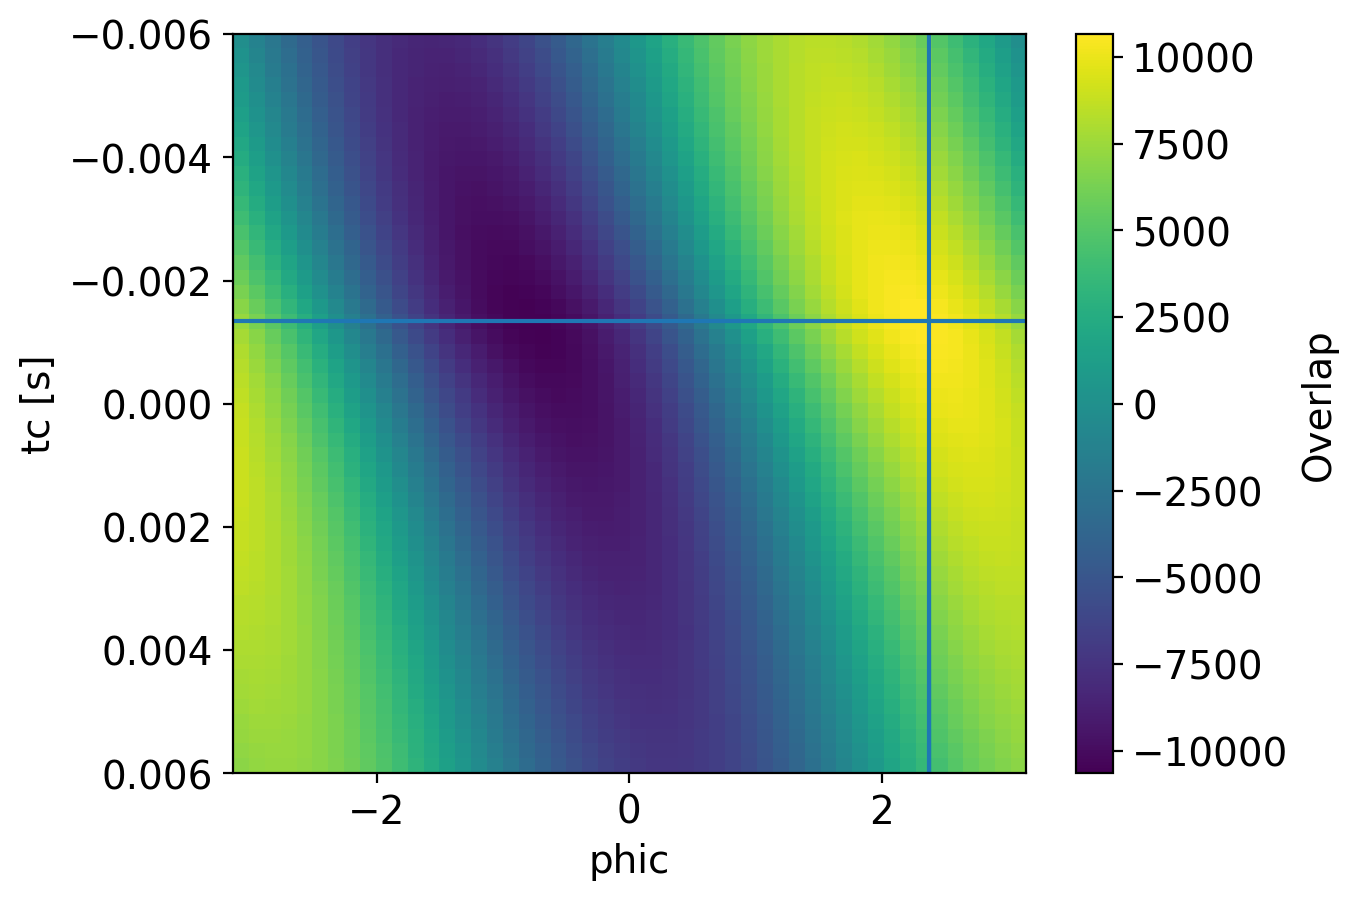

In [39]:
max_idx = np.unravel_index(inner_prod_grid.argmax(), inner_prod_grid.shape)

print(f"Maximum Overlap: {inner_prod_grid[max_idx]}")
print(f"Optimal (tc, phic): {time_shifts[max_idx[0]]}, {phase_shifts[max_idx[1]]}")
im = plt.imshow(inner_prod_grid, extent=[phase_shifts[0],phase_shifts[-1], time_shifts[-1],time_shifts[0]], aspect="auto")
# im = plt.pcolormesh(phase_shifts, time_shifts, inner_prod_grid[d])
plt.colorbar(im, label='Overlap')

plt.xlabel('phic')
plt.ylabel('tc [s]')
plt.axvline(x=phase_shifts[max_idx[1]])
plt.axhline(y=time_shifts[max_idx[0]])
plt.show()

In [40]:
net_ap = gwnet.get_network_response(inj_params=inj_params, f_min=f_low, f_max=f_high, d_f=d_f,  deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomD', network_spec=network_spec, calc_detector_responses=True, calc_derivs = True, calc_fisher=True)

overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h1 = net_tr.detectors[d].hf
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

   
    inj_params_opt_d = inj_params.copy()

    inj_params_opt_d['tc'] = -time_shifts[max_idx[0]]
    inj_params_opt_d['phic'] = -phase_shifts[max_idx[1]]
    

    net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_min=f_low, f_max=f_high, d_f=d_f,  deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomXAS', network_spec=network_spec_d,  calc_detector_responses=True, calc_derivs = False, calc_fisher=False)


    ## Compute CV overlap vector for this detector
    delta_hf = net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt_grid = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt_grid = cv_bias_opt_grid.tolist()[0]

2023-12-28 13:42:36,347 - Network - INFO : Polarizations calculated.
2023-12-28 13:42:36,347 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-12-28 13:42:36,354 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 13:42:41,757 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-28 13:42:41,900 - Network - INFO : PSDs loaded.
2023-12-28 13:42:41,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 13:42:41,931 - Network - INFO : Detector responses calculated.
2023-12-28 13:42:41,931 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-28 13:42:41,932 - Network - INFO :    CE-40_C
2023-12-28 13:42:45,641 - Network - INFO :    CE-20_S
2023-12-28 13:42:49,352 - Network - INFO :    ET_ET1
2023-12-28 13:42:53,036 - Network - INFO :    ET_ET2
2023-12-28 13:42:56,762 - Network - INFO :    ET_ET3
2023-12-28 13:43:00,506 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-28 13:43:00,514 - Network - INFO : SNRs calculated.
2023-12-28 13:43:00,515 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-12-28 13:43:00,515 - Network - INFO :    CE-40_C
2023-12-28 13:43:00,612 - Network - INFO :

['CE-40_C']
['CE-20_S']
['ET_ET1']
['ET_ET2']
['ET_ET3']


2023-12-28 13:43:01,320 - Network - INFO : Detector responses calculated.
2023-12-28 13:43:01,323 - Network - INFO : SNRs calculated.


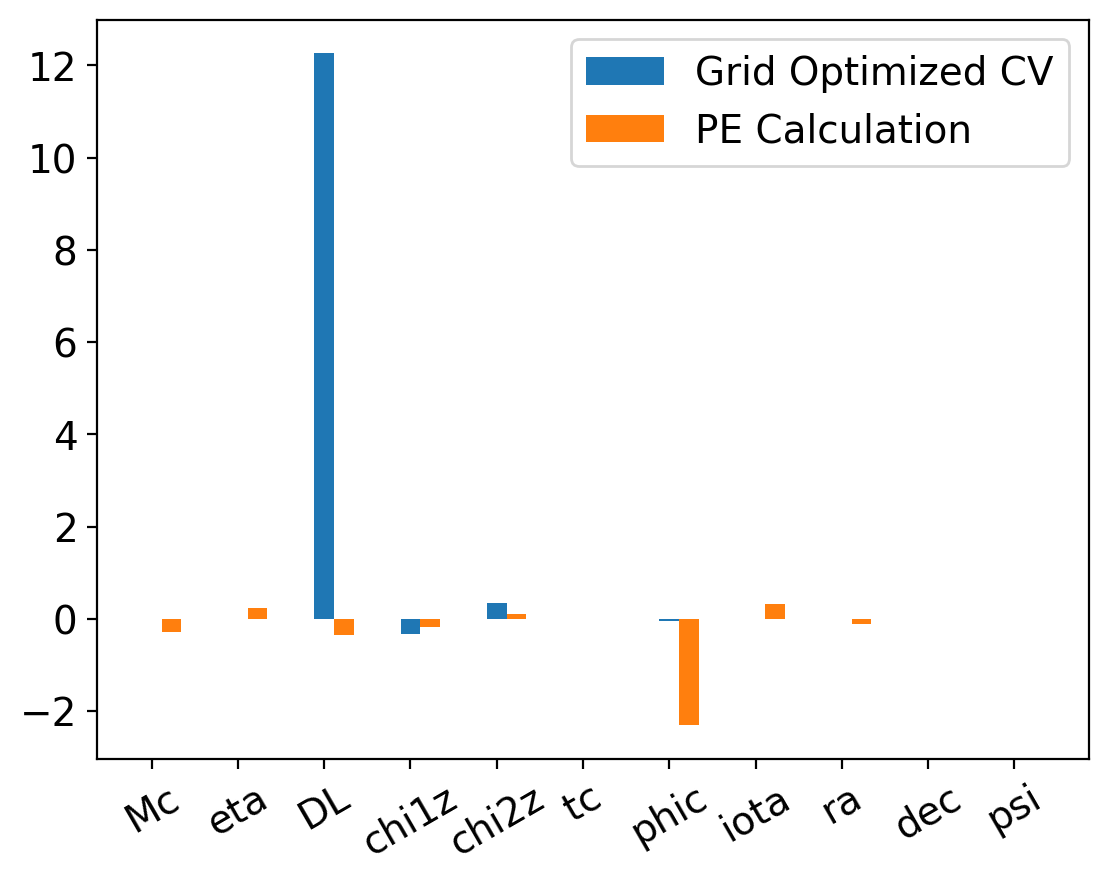

Mc, 1: -0.000 
Mc, 2: -0.296 

eta, 1: 0.001 
eta, 2: 0.237 

DL, 1: 12.266 
DL, 2: -0.344 

chi1z, 1: -0.325 
chi1z, 2: -0.187 

chi2z, 1: 0.341 
chi2z, 2: 0.103 

tc, 1: 0.000 
tc, 2: 0.000 

phic, 1: -0.045 
phic, 2: -2.306 

iota, 1: -0.003 
iota, 2: 0.325 

ra, 1: -0.000 
ra, 2: -0.121 

dec, 1: 0.000 
dec, 2: -0.016 

psi, 1: 0.002 
psi, 2: -0.004 



In [42]:
cv_bias_opt_sigma = np.zeros(len(cv_bias_opt_grid))
for i, var in enumerate(deriv_variables):
    cv_bias_opt_sigma[i] = cv_bias_opt_grid[i]/net_ap.errs[var]

    # bias_diff = 100*np.abs(pe_bias[i]-cv_bias_opt_sigma[i])/pe_bias[i]
    # print(f"{var}: {bias_diff:.3f}%")


bias1 = cv_bias_opt_sigma
bias2 = pe_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Grid Optimized CV')
plt.bar(x+width, bias2, width=width, label="PE Calculation")

plt.xticks(x, deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(deriv_variables):
    print(f"{param}, 1: {bias1[i]:.3f} ")
    print(f"{param}, 2: {bias2[i]:.3f} ")
    print()

# Grid Search (separate for each detector)

In [18]:
N_times = 50
time_shifts = np.linspace(-0.0015, -0.0010, N_times)

N_phases = 50
# phase_shifts = np.linspace(-np.pi, np.pi, N_phases)
phase_shifts = np.linspace(2.0, 2.5, N_phases)

inner_prod_grid = np.zeros((len(net_tr.detectors), N_times, N_phases))

net_tr = gwnet.get_network_response(inj_params=inj_params, f_min=f_low, f_max=f_high, d_f=d_f, deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomXAS', network_spec=network_spec, calc_detector_responses=True, calc_derivs = False, calc_fisher=False)

for d in range(len(net_tr.detectors)):

    h1 = net_tr.detectors[d].hf
    f = net_tr.detectors[d].f
    Sn = net_tr.detectors[d].psd
    network_spec_d = [net_tr.detectors[d].det_key]

    inj_params_shift = inj_params.copy()

    for i, time_shift in enumerate(time_shifts):
        for j, phase_shift in enumerate(phase_shifts):
            inj_params_shift['tc'] = time_shift
            inj_params_shift['phic'] = phase_shift
            net_ap_shift = gwnet.get_network_response(inj_params=inj_params_shift, f_min=f_low, f_max=f_high, d_f=d_f, deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomD', network_spec=network_spec_d, calc_detector_responses=True, calc_derivs = False, calc_fisher=False)
            
            h2 = net_ap_shift.detectors[0].hf
            
            inner_prod_grid[d][i][j] = inner_prod_simps_normed(h1, h2, Sn, f)

2023-12-28 17:00:29,534 - Network - INFO : Polarizations calculated.


2023-12-28 17:00:29,610 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:29,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:29,664 - Network - INFO : SNRs calculated.
2023-12-28 17:00:29,670 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:29,678 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:29,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:29,689 - Network - INFO : SNRs calculated.
2023-12-28 17:00:29,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:29,705 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:29,713 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:29,715 - Network - INFO : SNRs calculated.
2023-12-28 17:00:29,724 - Network - INFO : Polarizations calc

['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:29,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:29,742 - Network - INFO : SNRs calculated.
2023-12-28 17:00:29,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:29,759 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:29,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:29,770 - Network - INFO : SNRs calculated.
2023-12-28 17:00:29,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:29,787 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:29,795 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:29,797 - Network - INFO : SNRs calculated.
2023-12-28 17:00:29,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:29,814 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,816 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:29,954 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:29,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:29,968 - Network - INFO : SNRs calculated.
2023-12-28 17:00:29,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:29,992 - Network - INFO : PSDs loaded.
2023-12-28 17:00:29,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,008 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,020 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,031 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,047 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,059 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:30,183 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,198 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,223 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,241 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,306 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,327 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,331 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,345 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:30,405 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,423 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,437 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,449 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,464 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,467 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,482 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,495 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,514 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,528 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:30,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,647 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,673 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,691 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,716 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,729 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,732 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,758 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:30,856 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,881 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,897 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,922 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:30,937 - Network - INFO : SNRs calculated.
2023-12-28 17:00:30,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:30,960 - Network - INFO : PSDs loaded.
2023-12-28 17:00:30,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:30,971 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:31,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,075 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,091 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,117 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,154 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,173 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,203 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,214 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,231 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:31,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,309 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,334 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,350 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,374 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,386 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,390 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,403 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,416 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,419 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:31,518 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,521 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,535 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,546 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,563 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,587 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,602 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,627 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,630 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:31,728 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,757 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,772 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,801 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,819 - Network - INFO : SNRs calculated.
2023-12-28 17:00:31,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:31,847 - Network - INFO : PSDs loaded.
2023-12-28 17:00:31,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:31,859 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:31,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:31,983 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,018 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,036 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,059 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,062 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,073 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,095 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,098 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:32,208 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,223 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,246 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,249 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,260 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,283 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,297 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,310 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:32,439 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,456 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,479 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,495 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,507 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,518 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,532 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,544 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:32,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,675 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,739 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,770 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,787 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,800 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,811 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,826 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:32,955 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:32,959 - Network - INFO : SNRs calculated.
2023-12-28 17:00:32,972 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:32,985 - Network - INFO : PSDs loaded.
2023-12-28 17:00:32,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:32,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,002 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,017 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,032 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,049 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,076 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,079 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:33,165 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,179 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,182 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,213 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,226 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,230 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,253 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,268 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,282 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:33,395 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,423 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,440 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,455 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,466 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,469 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,481 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,505 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,549 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:33,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,617 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,631 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,643 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,657 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,681 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,697 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,721 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,723 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:33,829 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,840 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,857 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,884 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,901 - Network - INFO : SNRs calculated.
2023-12-28 17:00:33,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:33,926 - Network - INFO : PSDs loaded.
2023-12-28 17:00:33,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:33,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:33,942 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:34,074 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,085 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,099 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,123 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,138 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,162 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,179 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:34,273 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,284 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,300 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,325 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,341 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,353 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,367 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,429 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:34,506 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,521 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,545 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,562 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,589 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,605 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,630 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:34,729 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,733 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,747 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,760 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,772 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,776 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,790 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,801 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,817 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,842 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,845 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:34,941 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,957 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:34,969 - Network - INFO : PSDs loaded.
2023-12-28 17:00:34,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:34,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:34,983 - Network - INFO : SNRs calculated.
2023-12-28 17:00:34,996 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,007 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,025 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,038 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,049 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,062 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:35,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,157 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,190 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,230 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,272 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,310 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,327 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,352 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,355 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:35,373 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,387 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,400 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,419 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,447 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,466 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,493 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,504 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:35,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,596 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,599 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,631 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,650 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,678 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,698 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,716 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,730 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:35,821 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,834 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,852 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,878 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,894 - Network - INFO : SNRs calculated.
2023-12-28 17:00:35,908 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:35,919 - Network - INFO : PSDs loaded.
2023-12-28 17:00:35,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:35,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:35,935 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:36,011 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,014 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,070 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,094 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,098 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,121 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,138 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,163 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,166 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:36,242 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,257 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,282 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,299 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,324 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,341 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,354 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:36,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,480 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,495 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,520 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,534 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,557 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,573 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:36,706 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,718 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,722 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,735 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,770 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,788 - Network - INFO : SNRs calculated.
2023-12-28 17:00:36,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,815 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,837 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,894 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,904 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:36,964 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:36,975 - Network - INFO : PSDs loaded.
2023-12-28 17:00:36,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:36,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:36,992 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,015 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,031 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,044 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,056 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,068 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,072 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:37,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,160 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,187 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,202 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,226 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,241 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,253 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,264 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,267 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:37,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,381 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,396 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,409 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,422 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,437 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,440 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,456 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,467 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,485 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:37,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,610 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,633 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,647 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,670 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,686 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,762 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,768 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:37,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,822 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,846 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,860 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,884 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:37,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:37,898 - Network - INFO : SNRs calculated.
2023-12-28 17:00:37,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:37,921 - Network - INFO : PSDs loaded.
2023-12-28 17:00:37,925 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:38,039 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,042 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,052 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,076 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,090 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,102 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,112 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,123 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,126 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,138 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:38,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,273 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,284 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,295 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,306 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,309 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,333 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,347 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,370 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:38,480 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,495 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,558 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,568 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,588 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,611 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,624 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,636 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:38,760 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,774 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,803 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,818 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:38,842 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:38,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:38,856 - Network - INFO : SNRs calculated.
2023-12-28 17:00:38,868 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:38,990 - Network - INFO : PSDs loaded.
2023-12-28 17:00:38,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,008 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,036 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,050 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,074 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,090 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,102 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:39,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,231 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,246 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,259 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,270 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,285 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,309 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,323 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:39,456 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,480 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,495 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,519 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,534 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,547 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,558 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,569 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:39,672 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,686 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,709 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,724 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:39,747 - Network - INFO : PSDs loaded.
2023-12-28 17:00:39,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:39,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:39,762 - Network - INFO : SNRs calculated.
2023-12-28 17:00:39,774 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:40,007 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,023 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,036 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,046 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,057 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,060 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,083 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,097 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,109 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:40,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,242 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,248 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,273 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,287 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,299 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,309 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,323 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,335 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,345 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:40,456 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,469 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,492 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,502 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,506 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,529 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,540 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,543 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,556 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:40,679 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,690 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,707 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,731 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,757 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,770 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,780 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,797 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:40,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:40,961 - Network - INFO : PSDs loaded.
2023-12-28 17:00:40,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:40,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:40,977 - Network - INFO : SNRs calculated.
2023-12-28 17:00:40,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,007 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,026 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,052 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,066 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,069 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:41,194 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,233 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,253 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,279 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,297 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,323 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,346 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:41,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,423 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,444 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,497 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,506 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,545 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,559 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,571 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,589 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,604 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:41,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,688 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,713 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,723 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,743 - Network - INFO : SNRs calculated.
2023-12-28 17:00:41,760 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,773 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,835 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,880 - Network - INFO : SNRs calculated.


['CE-40_C']
['CE-40_C']


2023-12-28 17:00:41,958 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:41,969 - Network - INFO : PSDs loaded.
2023-12-28 17:00:41,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:41,990 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:41,994 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,027 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,058 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,098 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,109 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:42,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,154 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,199 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,223 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,253 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,273 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,305 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,312 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:42,369 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,384 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,427 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,461 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,493 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,525 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,560 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:42,652 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,684 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,729 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,753 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,786 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,823 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,844 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:42,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,915 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,920 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,935 - Network - INFO : SNRs calculated.
2023-12-28 17:00:42,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:42,962 - Network - INFO : PSDs loaded.
2023-12-28 17:00:42,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:42,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:42,985 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,015 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,031 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,040 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:43,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,192 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,208 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,240 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,277 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,307 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,310 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,325 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:43,372 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,398 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,415 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,457 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,472 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,476 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,500 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,514 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:43,584 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,600 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,623 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,639 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,663 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,679 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,691 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:43,809 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,819 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,840 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,863 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,878 - Network - INFO : SNRs calculated.
2023-12-28 17:00:43,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:43,900 - Network - INFO : PSDs loaded.
2023-12-28 17:00:43,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:43,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:43,916 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:44,048 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,060 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,071 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,086 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,111 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,114 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,125 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,137 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,148 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,160 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:44,261 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,264 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,276 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,299 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,314 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,336 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,356 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,370 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:44,489 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,494 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,509 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,519 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,535 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,540 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,564 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,584 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,610 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,613 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:44,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,716 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,806 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,830 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,833 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,857 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,860 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:44,869 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:44,873 - Network - INFO : SNRs calculated.
2023-12-28 17:00:44,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:44,899 - Network - INFO : PSDs loaded.
2023-12-28 17:00:44,903 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:45,005 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,023 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,037 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,048 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,065 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,098 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,114 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,131 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:45,232 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,244 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,258 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,273 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,295 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,310 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,332 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,343 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:45,442 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,457 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,480 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,494 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,518 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,577 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,596 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:45,667 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,671 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,684 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,707 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,729 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,732 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,756 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,772 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,784 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:45,902 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,926 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,958 - Network - INFO : PSDs loaded.
2023-12-28 17:00:45,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:45,970 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:45,974 - Network - INFO : SNRs calculated.
2023-12-28 17:00:45,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:45,997 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,000 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,013 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,025 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:46,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,155 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,178 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,200 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,219 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,231 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,242 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,262 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,291 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,295 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:46,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,450 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,480 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,501 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,525 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,541 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,553 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,565 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:46,660 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,664 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,681 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,693 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,709 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,734 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,749 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,772 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,775 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:46,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,876 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,889 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,900 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,915 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,918 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,946 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:46,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:46,961 - Network - INFO : SNRs calculated.
2023-12-28 17:00:46,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:46,984 - Network - INFO : PSDs loaded.
2023-12-28 17:00:46,987 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:47,090 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,198 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,228 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,247 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,251 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,288 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,318 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,322 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,340 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:47,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,427 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,440 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,452 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,468 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,482 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,493 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,513 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,536 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:47,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,643 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,658 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,669 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,685 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,710 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,727 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,740 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,757 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,762 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:47,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,856 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,881 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,897 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,923 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:47,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:47,939 - Network - INFO : SNRs calculated.
2023-12-28 17:00:47,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:47,964 - Network - INFO : PSDs loaded.
2023-12-28 17:00:47,967 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:48,062 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,077 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,090 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,100 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,115 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,137 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,151 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,164 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:48,288 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,302 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,326 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,340 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,352 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,362 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,374 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,378 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,390 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:48,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,514 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,528 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,539 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,554 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,566 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,577 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,591 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,602 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,612 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,615 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:48,725 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,737 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,743 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,814 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,831 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:48,863 - Network - INFO : PSDs loaded.
2023-12-28 17:00:48,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:48,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:48,879 - Network - INFO : SNRs calculated.
2023-12-28 17:00:48,893 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:48,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,000 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,025 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,040 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,053 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,064 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,078 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,090 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,100 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,103 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:49,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,221 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,224 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,237 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,248 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,263 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,285 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,299 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,321 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:49,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,442 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,464 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,476 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,479 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,536 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,567 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,579 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,589 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:49,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,656 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,680 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,699 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,721 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,733 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,736 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,759 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,762 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:49,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,885 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:49,904 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:49,909 - Network - INFO : SNRs calculated.
2023-12-28 17:00:49,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:49,943 - Network - INFO : PSDs loaded.
2023-12-28 17:00:49,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,018 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,025 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,050 - Network - INFO : Polarizations calculated.


['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:50,065 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,079 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,083 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,103 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,113 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,136 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,149 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,162 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,188 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,193 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,212 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:50,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,315 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,389 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,404 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,431 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,455 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,487 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,491 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,523 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:50,607 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,610 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,636 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,647 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,668 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,671 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,686 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,698 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,720 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,747 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,751 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:50,822 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,832 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,846 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,875 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,890 - Network - INFO : SNRs calculated.
2023-12-28 17:00:50,902 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:50,912 - Network - INFO : PSDs loaded.
2023-12-28 17:00:50,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:50,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:50,927 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:51,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,081 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,109 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,134 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,148 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,180 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,292 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,312 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:51,338 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,356 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,360 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,389 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,408 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,433 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,449 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,463 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:51,576 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,593 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,638 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,671 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,706 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,724 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,756 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,769 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:51,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,805 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,832 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,842 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,862 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,874 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,884 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:51,903 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:51,906 - Network - INFO : SNRs calculated.
2023-12-28 17:00:51,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:51,937 - Network - INFO : PSDs loaded.
2023-12-28 17:00:51,945 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:52,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,020 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,051 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,062 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,080 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,105 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,125 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,137 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,148 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,151 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:52,259 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,290 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,323 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,342 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,356 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,360 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,383 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,397 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,420 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,422 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:52,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,509 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,531 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,534 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,546 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,568 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,579 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,582 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,595 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,605 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:52,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,731 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,757 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,767 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,784 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,812 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:52,829 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,832 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:52,859 - Network - INFO : PSDs loaded.
2023-12-28 17:00:52,863 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:52,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:52,957 - Network - INFO : SNRs calculated.
2023-12-28 17:00:52,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,015 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,032 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,036 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,097 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,166 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,171 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,184 - Network - INFO : Polarizations calculated.


['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:53,210 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,254 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,278 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,292 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,319 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,325 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,368 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,402 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,421 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:53,465 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,510 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,536 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,541 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,553 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,565 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,579 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,584 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,608 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,620 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,641 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:53,681 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,705 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,729 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,745 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:53,773 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,796 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:53,800 - Network - INFO : SNRs calculated.
2023-12-28 17:00:53,818 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:53,921 - Network - INFO : PSDs loaded.
2023-12-28 17:00:53,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:53,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,023 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,065 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,087 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,116 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,131 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,134 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,154 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:54,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,258 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,274 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,296 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,311 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,333 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,356 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:54,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,455 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,479 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,489 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,515 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,550 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,567 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,597 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,602 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:54,686 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,698 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,723 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,764 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,847 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,884 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,905 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:54,946 - Network - INFO : SNRs calculated.
2023-12-28 17:00:54,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:54,970 - Network - INFO : PSDs loaded.
2023-12-28 17:00:54,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:54,982 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:54,985 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,002 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,014 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,031 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,064 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,083 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:55,157 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,168 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,171 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,179 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,183 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,203 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,217 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,243 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,279 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,299 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:55,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,407 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,423 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,437 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,448 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,476 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,494 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,532 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,537 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,560 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:55,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,689 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,708 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,731 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,741 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,758 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,769 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,780 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,796 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:55,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,865 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,885 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,899 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,910 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:55,924 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:55,929 - Network - INFO : SNRs calculated.
2023-12-28 17:00:55,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:55,983 - Network - INFO : PSDs loaded.
2023-12-28 17:00:55,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,008 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:56,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,111 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,146 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,160 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,164 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,183 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,197 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,224 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,229 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,274 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,277 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:56,329 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,351 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,395 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,418 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,453 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,470 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,473 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,494 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:56,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,571 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,689 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,707 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,736 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,750 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,754 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,787 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,791 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:56,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,867 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,898 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,924 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:56,950 - Network - INFO : PSDs loaded.
2023-12-28 17:00:56,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:56,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:56,978 - Network - INFO : SNRs calculated.
2023-12-28 17:00:56,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,004 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,007 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:57,088 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,102 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,113 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,270 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,293 - Network - INFO : PSDs loaded.


['CE-40_C']
['CE-40_C']


2023-12-28 17:00:57,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,309 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,333 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,347 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,374 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,392 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,414 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:57,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,527 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,552 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,570 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,596 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,600 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,614 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,696 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,710 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,723 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:57,736 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,759 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,778 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,808 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,823 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,845 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,857 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:57,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,960 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:57,971 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:57,974 - Network - INFO : SNRs calculated.
2023-12-28 17:00:57,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:57,996 - Network - INFO : PSDs loaded.
2023-12-28 17:00:57,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,010 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,022 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,032 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,046 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:58,144 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,152 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,155 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,179 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,190 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,193 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,205 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,215 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,230 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,252 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:58,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,374 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,397 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,412 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,468 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,486 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,510 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:58,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,593 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,609 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,632 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,647 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,658 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,669 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,683 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:58,821 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,837 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,862 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,878 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:58,902 - Network - INFO : PSDs loaded.
2023-12-28 17:00:58,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:58,914 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:58,918 - Network - INFO : SNRs calculated.
2023-12-28 17:00:58,930 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:59,050 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,063 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,067 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,089 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,103 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,126 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,136 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,140 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,152 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:59,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,285 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,301 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,323 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,335 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,338 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,361 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,372 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,375 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:59,507 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,521 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,526 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,553 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,569 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,594 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,608 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,620 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:59,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,745 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,759 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,782 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,796 - Network - INFO : SNRs calculated.
2023-12-28 17:00:59,808 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,818 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,821 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,861 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,879 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:00:59,974 - Network - INFO : Polarizations calculated.
2023-12-28 17:00:59,984 - Network - INFO : PSDs loaded.
2023-12-28 17:00:59,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:00:59,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:00:59,999 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,012 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,023 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,037 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,058 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,072 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:00,173 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,189 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,219 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,235 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,258 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,272 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,283 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:00,406 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,421 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,444 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,458 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,480 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,496 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,509 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:00,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,651 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,670 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,697 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,718 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,746 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,768 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:00,832 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,846 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,866 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,881 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,894 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,907 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,910 - Network - INFO : SNRs calculated.
2023-12-28 17:01:00,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:00,935 - Network - INFO : PSDs loaded.
2023-12-28 17:01:00,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:00,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:00,952 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:01,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,089 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,102 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,114 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,124 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,138 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,160 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,174 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:01,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,317 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,320 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,375 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,399 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,422 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,437 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,449 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,459 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:01,537 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,553 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,567 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,577 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,580 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,589 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,593 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,604 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,614 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,626 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,629 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,640 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:01,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,770 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,796 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,812 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,834 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,837 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,846 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,849 - Network - INFO : SNRs calculated.
2023-12-28 17:01:01,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:01,872 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,875 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:01,981 - Network - INFO : PSDs loaded.
2023-12-28 17:01:01,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:01,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:01,998 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,011 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,021 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,032 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,035 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,058 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,072 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,084 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:02,209 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,232 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,244 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,254 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,268 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,290 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,305 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,317 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:02,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,458 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,461 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,471 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,474 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,486 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,497 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,512 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,525 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,535 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,546 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,549 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:02,680 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,692 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,696 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,708 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,718 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,733 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,755 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,770 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,782 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:02,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:02,914 - Network - INFO : SNRs calculated.
2023-12-28 17:01:02,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:02,939 - Network - INFO : PSDs loaded.
2023-12-28 17:01:02,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:02,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,002 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,040 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,057 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,060 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,082 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:03,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,133 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,138 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,162 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,173 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,176 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,198 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,214 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,237 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:03,354 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,366 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,369 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,392 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,408 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,420 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,431 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,434 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,447 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,460 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:03,581 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,599 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,612 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,622 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,638 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,661 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,674 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,678 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,692 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:03,806 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,828 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,841 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,850 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,866 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:03,890 - Network - INFO : PSDs loaded.
2023-12-28 17:01:03,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:03,903 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:03,907 - Network - INFO : SNRs calculated.
2023-12-28 17:01:03,920 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:04,034 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,059 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,074 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,098 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,112 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,128 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,138 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,150 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:04,240 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,252 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,266 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,278 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,289 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,303 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,326 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,338 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,342 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:04,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,516 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,553 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,557 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,568 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,591 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,610 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,636 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:04,739 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,764 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,776 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,779 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,809 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,825 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,848 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,860 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:04,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:04,970 - Network - INFO : PSDs loaded.
2023-12-28 17:01:04,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:04,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:04,984 - Network - INFO : SNRs calculated.
2023-12-28 17:01:04,996 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,007 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,023 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,045 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,059 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:05,155 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,195 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,199 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,240 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,256 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,284 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,294 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,306 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,309 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,321 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:05,408 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,426 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,444 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,455 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,473 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,480 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,512 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,531 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,545 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:05,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,657 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,661 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,672 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,677 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,707 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,725 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,747 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,765 - Network - INFO : Polarizations calculated.


['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:05,908 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,924 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,927 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,953 - Network - INFO : PSDs loaded.
2023-12-28 17:01:05,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:05,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:05,969 - Network - INFO : SNRs calculated.
2023-12-28 17:01:05,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:05,999 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,024 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,039 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:06,179 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,190 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,208 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,224 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,235 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,254 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,281 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,313 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:06,392 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,404 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,424 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,453 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,468 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,480 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,490 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,504 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:06,581 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,595 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,606 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,622 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,634 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,644 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,662 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,687 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,704 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:06,812 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,855 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,859 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,899 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,914 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:06,938 - Network - INFO : PSDs loaded.
2023-12-28 17:01:06,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:06,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:06,953 - Network - INFO : SNRs calculated.
2023-12-28 17:01:06,967 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:07,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,105 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,146 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,189 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,223 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,247 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,264 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:07,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,374 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,391 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,415 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,431 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,454 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,469 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:07,602 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,613 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,625 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,629 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,655 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,679 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,718 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,753 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,769 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:07,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,847 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,859 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,870 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,883 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,887 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,899 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,911 - Network - INFO : PSDs loaded.
2023-12-28 17:01:07,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:07,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:07,927 - Network - INFO : SNRs calculated.
2023-12-28 17:01:07,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:07,949 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:08,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,063 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,079 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,102 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,122 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,136 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,149 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,166 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:08,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,309 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,324 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,336 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,349 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,364 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,392 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,410 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,444 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:08,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,505 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,519 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,523 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,537 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,548 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,563 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,585 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,600 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:08,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,745 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,765 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,791 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,802 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,806 - Network - INFO : SNRs calculated.
2023-12-28 17:01:08,819 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,831 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:08,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:08,846 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:08,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:08,992 - Network - INFO : PSDs loaded.
2023-12-28 17:01:08,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,011 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,083 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,109 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,135 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,166 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:09,179 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,190 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,202 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,205 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,231 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,254 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,278 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,295 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:09,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,425 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,438 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,450 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,464 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,468 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,482 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,494 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,511 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,525 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,535 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:09,643 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,653 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,669 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,693 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,708 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,720 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,731 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,745 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:09,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,852 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,883 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,898 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,932 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:09,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:09,950 - Network - INFO : SNRs calculated.
2023-12-28 17:01:09,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:09,975 - Network - INFO : PSDs loaded.
2023-12-28 17:01:09,978 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:10,058 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,072 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,076 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,088 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,099 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,102 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,113 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,137 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,152 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,164 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:10,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,292 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,306 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,320 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,331 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,347 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,371 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,386 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:10,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,530 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,537 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,557 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,570 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,581 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,638 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,688 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,701 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,704 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:10,772 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,793 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,816 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,832 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:10,857 - Network - INFO : PSDs loaded.
2023-12-28 17:01:10,860 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:10,869 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:10,874 - Network - INFO : SNRs calculated.
2023-12-28 17:01:10,887 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:11,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,022 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,039 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,051 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,063 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,079 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,104 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,116 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,120 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:11,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,225 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,243 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,266 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,323 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,345 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,356 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,380 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:11,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,421 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,444 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,459 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,481 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,495 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,507 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,517 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:11,633 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,647 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,652 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,666 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,677 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,689 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,692 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,714 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,730 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,742 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:11,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,873 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,907 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,912 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:11,945 - Network - INFO : PSDs loaded.
2023-12-28 17:01:11,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:11,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:11,972 - Network - INFO : SNRs calculated.
2023-12-28 17:01:11,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,000 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,072 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,086 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:12,141 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,181 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,203 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,216 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,219 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,246 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,288 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,319 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,341 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:12,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,432 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,451 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,482 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,502 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,508 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,533 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,557 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:12,663 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,691 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,722 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,737 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,743 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,758 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,768 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,782 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,788 - Network - INFO : SNRs calculated.
2023-12-28 17:01:12,812 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:12,909 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:12,919 - Network - INFO : PSDs loaded.
2023-12-28 17:01:12,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:12,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:12,942 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,025 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,058 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,082 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,086 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,094 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,097 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:13,201 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,223 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,239 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,251 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,275 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,307 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,310 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,324 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,337 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:13,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,452 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,470 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,475 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,505 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,536 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,553 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,566 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,586 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:13,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,700 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,721 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,749 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,766 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,790 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,807 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:13,929 - Network - INFO : SNRs calculated.
2023-12-28 17:01:13,962 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:13,973 - Network - INFO : PSDs loaded.
2023-12-28 17:01:13,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:13,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:13,992 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,025 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,044 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,083 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,098 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:14,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,170 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,194 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,219 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,236 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,263 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,282 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:14,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,409 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,432 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,435 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,447 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,470 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,486 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,510 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,513 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:14,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,627 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,644 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,700 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,722 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,749 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,765 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:14,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,883 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,906 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,921 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,943 - Network - INFO : PSDs loaded.
2023-12-28 17:01:14,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:14,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:14,957 - Network - INFO : SNRs calculated.
2023-12-28 17:01:14,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:14,978 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:15,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,101 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,115 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,125 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,140 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,161 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,175 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,187 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,198 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:15,311 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,327 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,351 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,408 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,446 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,461 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,474 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:15,534 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,537 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,561 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,576 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,588 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,599 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,613 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,636 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,639 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:15,751 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,764 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,767 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,795 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,811 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:15,833 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,848 - Network - INFO : SNRs calculated.
2023-12-28 17:01:15,860 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:15,980 - Network - INFO : PSDs loaded.
2023-12-28 17:01:15,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:15,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:15,995 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,018 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,082 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,097 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,107 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,118 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,122 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,135 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:16,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,220 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,235 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,257 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,267 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,271 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,293 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,307 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:16,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,413 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,417 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,438 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,453 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,475 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,489 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,501 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,511 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:16,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,633 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,657 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,671 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,692 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,754 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,784 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:16,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,856 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,870 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,892 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,906 - Network - INFO : SNRs calculated.
2023-12-28 17:01:16,918 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:16,928 - Network - INFO : PSDs loaded.
2023-12-28 17:01:16,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:16,939 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:16,942 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:17,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,088 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,117 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,130 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,152 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,166 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,178 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,188 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:17,296 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,312 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,334 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,349 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,370 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,384 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,396 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:17,527 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,542 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,567 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,581 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,593 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,603 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,617 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,630 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:17,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,760 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,783 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,797 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,809 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,819 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,822 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:17,830 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,833 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,855 - Network - INFO : PSDs loaded.
2023-12-28 17:01:17,858 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:17,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:17,977 - Network - INFO : SNRs calculated.
2023-12-28 17:01:17,989 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:17,999 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,011 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,015 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,044 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,095 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,098 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,114 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,124 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,126 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:18,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,198 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,214 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,235 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,249 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,271 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,285 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:18,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,431 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,444 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,454 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,468 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,480 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,490 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,504 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,526 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:18,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,646 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,669 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,683 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,696 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,706 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,720 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,742 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,745 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:18,859 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,874 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,898 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,910 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,913 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:18,936 - Network - INFO : PSDs loaded.
2023-12-28 17:01:18,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:18,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:18,950 - Network - INFO : SNRs calculated.
2023-12-28 17:01:18,962 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:19,081 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,096 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,108 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,118 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,129 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,132 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,144 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,154 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,168 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,181 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:19,304 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,308 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,318 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,326 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,392 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,410 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,430 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,445 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,457 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:19,602 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,617 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,639 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,652 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,674 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,688 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,699 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:19,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,829 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,841 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,851 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,865 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,887 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:19,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:19,902 - Network - INFO : SNRs calculated.
2023-12-28 17:01:19,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:19,923 - Network - INFO : PSDs loaded.
2023-12-28 17:01:19,926 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:20,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,045 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,068 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,126 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,144 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,154 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,156 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,168 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,180 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,189 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:20,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,262 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,277 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,299 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,313 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,335 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,349 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:20,489 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,492 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,505 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,516 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,531 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,553 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,567 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,579 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,589 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,592 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:20,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,709 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,737 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,752 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,764 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,783 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,832 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,855 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:20,920 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,930 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,945 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,957 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:20,967 - Network - INFO : PSDs loaded.
2023-12-28 17:01:20,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:20,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:20,981 - Network - INFO : SNRs calculated.
2023-12-28 17:01:20,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,003 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,018 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:21,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,160 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,163 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,186 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,200 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,222 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,233 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,237 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,258 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:21,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,380 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,393 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,403 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,418 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,440 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,455 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,488 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:21,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,596 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,612 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,634 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,637 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,648 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,670 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,684 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:21,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,830 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,853 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,856 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,867 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,888 - Network - INFO : PSDs loaded.
2023-12-28 17:01:21,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:21,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:21,902 - Network - INFO : SNRs calculated.
2023-12-28 17:01:21,915 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:21,925 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:22,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,045 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,060 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,072 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,132 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,161 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,176 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,187 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,197 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,200 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:22,260 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,272 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,280 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,298 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,329 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,354 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,366 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,376 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,392 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:22,455 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,470 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,482 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,492 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,505 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,527 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,542 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,554 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:22,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,685 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,708 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,723 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,745 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,748 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,759 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,841 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,845 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:22,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,901 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,925 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,940 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,952 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,962 - Network - INFO : PSDs loaded.
2023-12-28 17:01:22,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:22,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:22,976 - Network - INFO : SNRs calculated.
2023-12-28 17:01:22,988 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:22,999 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,002 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:23,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,145 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,176 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,198 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,222 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,238 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,261 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:23,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,356 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,378 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,392 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,413 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,425 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,428 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,442 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,460 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,463 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:23,566 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,581 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,603 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,618 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,639 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,653 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,665 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:23,788 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,808 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,836 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,855 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:23,879 - Network - INFO : PSDs loaded.
2023-12-28 17:01:23,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:23,892 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:23,896 - Network - INFO : SNRs calculated.
2023-12-28 17:01:23,912 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:24,026 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,036 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,051 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,129 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,145 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,157 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,168 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,183 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:24,220 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,242 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,254 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,257 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,279 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,291 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,294 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,306 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,316 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,326 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:24,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,435 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,439 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,461 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,473 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,476 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,498 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,512 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,534 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:24,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,656 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,678 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,690 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,693 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,705 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,715 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,730 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,752 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:24,868 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,872 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,897 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,911 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,923 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,933 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:24,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:24,947 - Network - INFO : SNRs calculated.
2023-12-28 17:01:24,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:24,969 - Network - INFO : PSDs loaded.
2023-12-28 17:01:24,972 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:25,079 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,093 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,121 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,135 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,157 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,171 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,183 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:25,303 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,317 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,341 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,355 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,377 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,427 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,446 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:25,529 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,545 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,567 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,580 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,602 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,616 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,628 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:25,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,760 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,782 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,797 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,809 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,819 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:25,831 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:25,834 - Network - INFO : SNRs calculated.
2023-12-28 17:01:25,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:25,856 - Network - INFO : PSDs loaded.
2023-12-28 17:01:25,859 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:25,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,016 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,062 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,078 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,089 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,099 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,102 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,114 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,136 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:26,237 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,247 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,258 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,262 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,274 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,284 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,299 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,317 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,327 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,338 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,341 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:26,471 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,486 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,508 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,519 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,522 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,544 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,557 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,568 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:26,699 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,702 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,744 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,761 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,781 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,784 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,797 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,808 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,822 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,833 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,843 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,846 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:26,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,952 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:26,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:26,973 - Network - INFO : SNRs calculated.
2023-12-28 17:01:26,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:26,995 - Network - INFO : PSDs loaded.
2023-12-28 17:01:26,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,009 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,021 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,031 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,046 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:27,181 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,202 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,225 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,242 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,264 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,280 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,292 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:27,409 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,423 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,435 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,449 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,465 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,487 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,506 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,561 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,573 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:27,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,637 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,661 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,676 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,700 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,714 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,735 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,738 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:27,844 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,855 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,863 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,875 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,885 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,899 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:27,921 - Network - INFO : PSDs loaded.
2023-12-28 17:01:27,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:27,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:27,935 - Network - INFO : SNRs calculated.
2023-12-28 17:01:27,947 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:28,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,081 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,126 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,161 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,183 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,195 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,198 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,220 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:28,292 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,307 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,329 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,343 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,355 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,364 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,379 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,390 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:28,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,521 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,524 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,537 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,548 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,562 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,574 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,586 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,589 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,601 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,616 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,628 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:28,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,742 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,753 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,756 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,778 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,789 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,793 - Network - INFO : SNRs calculated.
2023-12-28 17:01:28,805 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:28,815 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,829 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:28,968 - Network - INFO : PSDs loaded.
2023-12-28 17:01:28,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:28,984 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:28,989 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,002 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,012 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,024 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,027 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,049 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,064 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,076 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:29,195 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,209 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,231 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,242 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,245 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,267 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,281 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,293 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:29,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,426 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,437 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,455 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,511 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,533 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,548 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,569 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:29,641 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,657 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,679 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,694 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,706 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,716 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,727 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,730 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,742 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:29,863 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,872 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,875 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,892 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,902 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,916 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,937 - Network - INFO : PSDs loaded.
2023-12-28 17:01:29,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:29,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:29,951 - Network - INFO : SNRs calculated.
2023-12-28 17:01:29,964 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:29,974 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:30,084 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,136 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,140 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,169 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,183 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,195 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,205 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,219 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,231 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:30,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,362 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,384 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,399 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,411 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,421 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,432 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,435 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,457 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,460 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:30,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,577 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,599 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,613 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,625 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,635 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,649 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,671 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,674 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:30,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,794 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,817 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,848 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,894 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:30,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:30,912 - Network - INFO : SNRs calculated.
2023-12-28 17:01:30,923 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:30,933 - Network - INFO : PSDs loaded.
2023-12-28 17:01:30,936 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:31,006 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,018 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,021 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,043 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,057 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,069 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,079 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,094 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,106 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:31,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,238 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,249 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,259 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,273 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,284 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,294 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,308 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,320 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,330 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:31,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,450 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,463 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,472 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,486 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,508 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,519 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,522 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,543 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,546 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:31,664 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,679 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,694 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,704 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,718 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,730 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,740 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,751 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,754 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,766 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:31,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,898 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,921 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,934 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,946 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,956 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:31,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:31,969 - Network - INFO : SNRs calculated.
2023-12-28 17:01:31,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:31,991 - Network - INFO : PSDs loaded.
2023-12-28 17:01:31,994 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:32,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,114 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,136 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,187 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,222 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,233 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,236 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,258 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,261 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:32,328 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,344 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,355 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,365 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,379 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,400 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,402 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,410 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,414 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,425 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:32,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,558 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,583 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,586 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,598 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,612 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,623 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,637 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,659 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,662 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:32,777 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,816 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,820 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,850 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,861 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,864 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,876 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:32,886 - Network - INFO : PSDs loaded.
2023-12-28 17:01:32,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:32,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:32,901 - Network - INFO : SNRs calculated.
2023-12-28 17:01:32,912 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:33,031 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,046 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,059 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,070 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,072 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,081 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,084 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,106 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,120 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,132 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:33,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,266 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,278 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,288 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,302 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,324 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,335 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,338 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,361 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:33,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,483 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,519 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,534 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,558 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,587 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,601 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,623 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:33,695 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,713 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,736 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,747 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,750 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,772 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,786 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,798 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:33,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,930 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,952 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,955 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:33,966 - Network - INFO : SNRs calculated.
2023-12-28 17:01:33,978 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:33,988 - Network - INFO : PSDs loaded.
2023-12-28 17:01:33,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:33,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,002 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,023 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:34,156 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,177 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,202 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,214 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,224 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,238 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,260 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,264 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,273 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,277 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:34,410 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,425 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,438 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,448 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,461 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,483 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,497 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,509 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:34,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,642 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,671 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,686 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,708 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,721 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,743 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:34,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,856 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,881 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,885 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,899 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,924 - Network - INFO : PSDs loaded.
2023-12-28 17:01:34,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:34,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:34,950 - Network - INFO : SNRs calculated.
2023-12-28 17:01:34,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:34,996 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,001 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:35,063 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,080 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,096 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,117 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,145 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,161 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,165 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,193 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,209 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:35,274 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,286 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,303 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,327 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,338 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,341 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,354 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,364 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,379 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:35,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,548 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,566 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,588 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,604 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,616 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,626 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,641 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:35,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,742 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,759 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,782 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,792 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,796 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,817 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,831 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:35,926 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,940 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,962 - Network - INFO : PSDs loaded.
2023-12-28 17:01:35,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:35,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:35,976 - Network - INFO : SNRs calculated.
2023-12-28 17:01:35,988 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:35,998 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,012 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,024 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:36,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,174 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,190 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,205 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,219 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,230 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,240 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,254 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,277 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:36,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,410 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,458 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,478 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,488 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,513 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,538 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,541 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,557 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:36,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,679 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,712 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,728 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,758 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,772 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,777 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,807 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,810 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:36,909 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:36,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:36,946 - Network - INFO : SNRs calculated.
2023-12-28 17:01:36,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:36,970 - Network - INFO : PSDs loaded.
2023-12-28 17:01:36,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,044 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,089 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,099 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,102 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,117 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,144 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:37,161 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,181 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,208 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,235 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,267 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,294 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,315 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:37,391 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,407 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,424 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,446 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,460 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,474 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,502 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,528 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,546 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:37,601 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,645 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,671 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,687 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,697 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,714 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,738 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,751 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:37,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,827 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,855 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,872 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,876 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,900 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:37,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:37,916 - Network - INFO : SNRs calculated.
2023-12-28 17:01:37,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:37,939 - Network - INFO : PSDs loaded.
2023-12-28 17:01:37,941 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:38,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,050 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,065 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,077 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,087 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,101 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,113 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,124 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,136 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,140 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:38,274 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,288 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,311 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,325 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,337 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,348 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,362 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,374 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:38,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,504 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,533 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,547 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,624 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,639 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,661 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,663 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:38,712 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,736 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,747 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,750 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,772 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,786 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,808 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,819 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:38,918 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,929 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,932 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,955 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:38,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:38,969 - Network - INFO : SNRs calculated.
2023-12-28 17:01:38,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:38,991 - Network - INFO : PSDs loaded.
2023-12-28 17:01:38,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,001 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,005 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,016 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:39,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,149 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,171 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,198 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,228 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,238 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,254 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,277 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,280 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:39,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,361 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,384 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,397 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,409 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,419 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,422 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,430 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,433 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,445 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,455 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,457 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:39,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,577 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,606 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,621 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,643 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,657 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,679 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,681 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:39,787 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,801 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,874 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,891 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,903 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:39,913 - Network - INFO : PSDs loaded.
2023-12-28 17:01:39,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:39,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:39,928 - Network - INFO : SNRs calculated.
2023-12-28 17:01:39,940 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:40,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,068 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,083 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,093 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,096 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,104 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,107 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,118 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,128 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,143 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,165 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,168 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:40,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,288 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,303 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,314 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,325 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,328 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,351 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,362 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,365 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,387 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:40,502 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,518 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,541 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,552 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,555 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,567 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,578 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,589 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,592 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,604 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:40,725 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,736 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,739 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,762 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,764 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,772 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,775 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,798 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,812 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,824 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:40,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,957 - Network - INFO : SNRs calculated.
2023-12-28 17:01:40,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:40,980 - Network - INFO : PSDs loaded.
2023-12-28 17:01:40,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:40,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:40,994 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,115 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,144 - Network - INFO : SNRs calculated.


['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:41,182 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,192 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,211 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,214 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,237 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,251 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,273 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,287 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:41,422 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,436 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,449 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,459 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,470 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,474 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,486 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,496 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,510 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,522 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:41,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,653 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,675 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,690 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,711 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,750 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,790 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,792 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:41,861 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,863 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,872 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,875 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,896 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,911 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:41,932 - Network - INFO : PSDs loaded.
2023-12-28 17:01:41,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:41,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:41,946 - Network - INFO : SNRs calculated.
2023-12-28 17:01:41,957 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:42,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,088 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,117 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,131 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,143 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,153 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,156 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,167 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,179 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,189 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,192 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:42,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,332 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,385 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,401 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,422 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,436 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,457 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:42,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,577 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,599 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,611 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,614 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,636 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,650 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,672 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,674 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:42,789 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,792 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,803 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,813 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,827 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,849 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:42,861 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:42,864 - Network - INFO : SNRs calculated.
2023-12-28 17:01:42,876 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:42,886 - Network - INFO : PSDs loaded.
2023-12-28 17:01:42,889 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:42,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,057 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,097 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,112 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,133 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,144 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,147 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,169 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:43,287 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,290 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,302 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,312 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,327 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,339 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,349 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,363 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,374 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,384 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,387 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:43,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,506 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,528 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,542 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,564 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,577 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,630 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,638 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:43,717 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,733 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,761 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,775 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,797 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,811 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,824 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:43,942 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,958 - Network - INFO : SNRs calculated.
2023-12-28 17:01:43,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:43,979 - Network - INFO : PSDs loaded.
2023-12-28 17:01:43,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:43,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:43,994 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,016 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,031 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,043 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:44,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,173 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,225 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,247 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,273 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,288 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,299 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,309 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,312 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:44,381 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,396 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,408 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,418 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,431 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,442 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,452 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,463 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,466 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,477 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:44,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,608 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,632 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,647 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,669 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,683 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,695 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,705 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,707 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:44,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,826 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,848 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,862 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,874 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,884 - Network - INFO : PSDs loaded.
2023-12-28 17:01:44,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:44,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:44,898 - Network - INFO : SNRs calculated.
2023-12-28 17:01:44,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:44,920 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:45,040 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,043 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,056 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,078 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,092 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,104 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,114 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,128 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,140 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:45,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,273 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,296 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,310 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,332 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,346 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,358 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,368 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:45,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,488 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,491 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,504 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,514 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,529 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,551 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,588 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,605 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,614 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:45,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,707 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,720 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,732 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,746 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,758 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,768 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,782 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,794 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,805 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,807 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:45,913 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,929 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,952 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:45,966 - Network - INFO : SNRs calculated.
2023-12-28 17:01:45,978 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:45,988 - Network - INFO : PSDs loaded.
2023-12-28 17:01:45,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:45,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,002 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,014 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:46,133 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,149 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,209 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,226 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,238 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,248 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,264 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,275 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:46,397 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,417 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,440 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,454 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,466 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,476 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,488 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,491 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,503 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:46,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,635 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,646 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,656 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,668 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,671 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,692 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,706 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,716 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,726 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,728 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:46,849 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,861 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,865 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,891 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,905 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,917 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:46,927 - Network - INFO : PSDs loaded.
2023-12-28 17:01:46,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:46,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:46,941 - Network - INFO : SNRs calculated.
2023-12-28 17:01:46,953 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:47,072 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,080 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,084 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,107 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,121 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,132 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,142 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,156 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,178 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:47,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,301 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,323 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,335 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,338 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,359 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,388 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,393 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,423 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,433 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,440 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:47,511 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,525 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,552 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,566 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,588 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,603 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,615 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:47,733 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,748 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,771 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,782 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,785 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,797 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:47,807 - Network - INFO : PSDs loaded.
2023-12-28 17:01:47,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,822 - Network - INFO : SNRs calculated.
2023-12-28 17:01:47,834 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:47,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:47,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:47,968 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,011 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,028 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,050 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,074 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,087 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,109 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:48,182 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,204 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,229 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,243 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,265 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,281 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,293 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:48,411 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,425 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,437 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,447 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,461 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,474 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,484 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,497 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,509 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:48,639 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,654 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,666 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,676 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,690 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,711 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,723 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,726 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,738 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:48,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,869 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,881 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,893 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,904 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,907 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,929 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:48,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:48,943 - Network - INFO : SNRs calculated.
2023-12-28 17:01:48,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:48,965 - Network - INFO : PSDs loaded.
2023-12-28 17:01:48,968 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:49,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,087 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,110 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,124 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,136 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,146 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,200 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,229 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:49,292 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,303 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,318 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,341 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,355 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,377 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,390 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:49,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,533 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,548 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,558 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,572 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,594 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,609 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,631 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,633 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:49,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,750 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,753 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,769 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,785 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,840 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,862 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,877 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,898 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:49,960 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:49,970 - Network - INFO : PSDs loaded.
2023-12-28 17:01:49,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:49,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:49,985 - Network - INFO : SNRs calculated.
2023-12-28 17:01:49,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,007 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,021 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,033 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,043 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,057 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:50,194 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,208 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,211 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,237 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,251 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,273 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,287 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,300 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:50,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,443 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,473 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,490 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,501 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,511 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,528 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,540 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,550 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:50,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,660 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,675 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,687 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,697 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,711 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,733 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,746 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:50,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,891 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,903 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,913 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,926 - Network - INFO : SNRs calculated.
2023-12-28 17:01:50,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:50,948 - Network - INFO : PSDs loaded.
2023-12-28 17:01:50,951 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:50,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:50,963 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,030 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,038 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:51,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,109 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,124 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,145 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,159 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,171 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,180 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,195 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:51,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,339 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,352 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,365 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,379 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,401 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,415 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,437 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,440 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:51,546 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,561 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,602 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,624 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,648 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,670 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,684 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,696 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:51,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,814 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,829 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,852 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,866 - Network - INFO : SNRs calculated.
2023-12-28 17:01:51,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:51,888 - Network - INFO : PSDs loaded.
2023-12-28 17:01:51,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:51,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:51,902 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:52,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,013 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,036 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,058 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,073 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,095 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,109 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:52,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,284 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,305 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,317 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,327 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,338 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,341 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,354 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,364 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,379 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:52,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,474 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,489 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,512 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,526 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,548 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,562 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:52,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,705 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,717 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,728 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,745 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,757 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,767 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,781 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,803 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,805 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:52,922 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,938 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,961 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:52,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:52,975 - Network - INFO : SNRs calculated.
2023-12-28 17:01:52,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:52,996 - Network - INFO : PSDs loaded.
2023-12-28 17:01:52,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,009 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,021 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:53,168 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,171 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,183 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,206 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,220 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,241 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,255 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,267 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:53,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,400 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,416 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,426 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,442 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,464 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,475 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,478 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,490 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,501 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,503 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:53,628 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,655 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,676 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,698 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,709 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,713 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,734 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,749 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:53,889 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,892 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,905 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,917 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,928 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,931 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,953 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:53,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:53,968 - Network - INFO : SNRs calculated.
2023-12-28 17:01:53,980 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:53,990 - Network - INFO : PSDs loaded.
2023-12-28 17:01:53,992 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:54,100 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,115 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,128 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,140 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,155 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,176 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,190 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,202 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:54,330 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,340 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,351 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,354 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,377 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,388 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,391 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,402 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,412 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,427 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:54,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,534 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,556 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,570 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,592 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,606 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,628 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:54,740 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,760 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,763 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,782 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,792 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,806 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,818 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:54,828 - Network - INFO : PSDs loaded.
2023-12-28 17:01:54,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:54,840 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:54,844 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,883 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:54,976 - Network - INFO : SNRs calculated.
2023-12-28 17:01:54,989 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,002 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,017 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,038 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,053 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,074 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,085 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:55,185 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,200 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,223 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,238 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,260 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,275 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,287 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:55,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,420 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,455 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,498 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,523 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,534 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,537 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,548 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,559 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:55,630 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,633 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,645 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,672 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,686 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,708 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,722 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,734 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:55,855 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,868 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,871 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,894 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,909 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:55,932 - Network - INFO : PSDs loaded.
2023-12-28 17:01:55,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:55,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:55,948 - Network - INFO : SNRs calculated.
2023-12-28 17:01:55,960 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:56,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,080 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,103 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,106 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,118 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,140 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,155 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,177 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,179 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:56,291 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,303 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,327 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,352 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,366 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,388 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,401 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,404 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:56,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,545 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,548 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,557 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,560 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,572 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,582 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,593 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,596 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,653 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,684 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:56,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,777 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,780 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,793 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,805 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,815 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,829 - Network - INFO : SNRs calculated.
2023-12-28 17:01:56,841 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:56,850 - Network - INFO : PSDs loaded.
2023-12-28 17:01:56,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:56,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:56,865 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:57,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,009 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,021 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,031 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,046 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,057 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,067 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,081 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,103 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,106 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:57,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,226 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,239 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,249 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,252 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,287 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,297 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,334 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,348 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,370 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:57,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,442 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,456 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,463 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,475 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,485 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,498 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,519 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,533 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:57,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,674 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,686 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,696 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,710 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,732 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,745 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,757 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,767 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,770 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:57,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,922 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,939 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:57,966 - Network - INFO : PSDs loaded.
2023-12-28 17:01:57,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:57,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:57,981 - Network - INFO : SNRs calculated.
2023-12-28 17:01:57,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,003 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,015 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,019 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,031 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,041 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:58,152 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,165 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,179 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,192 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,206 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,228 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,242 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,254 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:58,373 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,384 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,388 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,399 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,409 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,423 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,444 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,458 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,470 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:58,603 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,616 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,619 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,631 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,641 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,656 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,679 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,694 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,706 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:58,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,837 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,849 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,864 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,878 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,900 - Network - INFO : PSDs loaded.
2023-12-28 17:01:58,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:58,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:58,914 - Network - INFO : SNRs calculated.
2023-12-28 17:01:58,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:58,936 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:59,045 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,058 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,061 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,084 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,100 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,114 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,132 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,196 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,208 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:59,269 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,282 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,293 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,307 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,330 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,344 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,356 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,366 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,376 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:59,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,488 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,510 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,521 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,524 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,536 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,546 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,557 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,560 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,572 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,582 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:59,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,705 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,717 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,732 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,789 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,817 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,831 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,854 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:01:59,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,925 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,941 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,963 - Network - INFO : PSDs loaded.
2023-12-28 17:01:59,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:01:59,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:01:59,978 - Network - INFO : SNRs calculated.
2023-12-28 17:01:59,989 - Network - INFO : Polarizations calculated.
2023-12-28 17:01:59,999 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,010 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,013 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:00,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,158 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,169 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,179 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,194 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,205 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,215 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,226 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,229 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,251 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:00,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,373 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,395 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,409 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,420 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,430 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,441 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,444 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,456 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,466 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,469 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:00,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,592 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,608 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,631 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,633 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,642 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,645 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,657 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,667 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,679 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,682 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:00,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,826 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,853 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,867 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,890 - Network - INFO : PSDs loaded.
2023-12-28 17:02:00,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:00,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:00,904 - Network - INFO : SNRs calculated.
2023-12-28 17:02:00,915 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:00,926 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:01,035 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,045 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,048 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,061 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,071 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,086 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,135 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,149 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,159 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,174 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,185 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:01,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,268 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,285 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,308 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,319 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,322 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,344 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,358 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:01,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,505 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,527 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,538 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,541 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,553 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,563 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,577 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,600 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:01,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,761 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,804 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,816 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,819 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,841 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:01,855 - Network - INFO : SNRs calculated.
2023-12-28 17:02:01,866 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:01,876 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:01,985 - Network - INFO : PSDs loaded.
2023-12-28 17:02:01,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:01,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,002 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,025 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,039 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,051 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,061 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,074 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,085 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:02,214 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,217 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,230 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,240 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,259 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,271 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,281 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,295 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,317 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,320 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:02,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,435 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,452 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,474 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,488 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,509 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,521 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,524 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:02,656 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,670 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,692 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,706 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,729 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,731 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,739 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,743 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,754 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:02,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,885 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,936 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:02,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:02,966 - Network - INFO : SNRs calculated.
2023-12-28 17:02:02,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:02,995 - Network - INFO : PSDs loaded.
2023-12-28 17:02:02,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,009 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,021 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,031 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,034 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:03,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,103 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,124 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,137 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,147 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,161 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,183 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,197 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:03,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,339 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,342 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,355 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,365 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,380 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,401 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,415 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,437 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:03,587 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,597 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,600 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,615 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,627 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,637 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,649 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,652 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,674 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,688 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:03,761 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,788 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,799 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,802 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,824 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,835 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,838 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,850 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:03,860 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,870 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:03,967 - Network - INFO : PSDs loaded.
2023-12-28 17:02:03,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:03,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:03,981 - Network - INFO : SNRs calculated.
2023-12-28 17:02:03,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,004 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,015 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,018 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,040 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,042 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,053 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,066 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:04,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,207 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,210 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,223 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,234 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,248 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,260 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,270 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,281 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,284 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,306 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:04,418 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,432 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,445 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,455 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,469 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,491 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,502 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,506 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,517 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:04,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,648 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,669 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,683 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,695 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,704 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,758 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,795 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,798 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:04,858 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,868 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,885 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,888 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,910 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,913 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,924 - Network - INFO : SNRs calculated.
2023-12-28 17:02:04,935 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:04,945 - Network - INFO : PSDs loaded.
2023-12-28 17:02:04,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:04,955 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:04,958 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:05,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,101 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,114 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,124 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,138 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,149 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,159 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,173 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,185 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,195 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,197 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:05,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,318 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,330 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,341 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,397 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,423 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,437 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,449 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,459 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:05,531 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,534 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,551 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,565 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,575 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,578 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,587 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,590 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,601 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,611 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,626 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,638 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:05,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,769 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,782 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,793 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,807 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,818 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,828 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,830 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:05,839 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:05,842 - Network - INFO : SNRs calculated.
2023-12-28 17:02:05,854 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:05,864 - Network - INFO : PSDs loaded.
2023-12-28 17:02:05,867 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:05,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,032 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,061 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,071 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,086 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,098 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,108 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,119 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,122 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,145 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:06,263 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,266 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,278 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,288 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,302 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,324 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,339 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,360 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,363 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:06,472 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,485 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,512 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,527 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,555 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,578 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,606 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,619 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:06,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,701 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,715 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,737 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,748 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,751 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,763 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,773 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,788 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:06,920 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,929 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,932 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,944 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,954 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:06,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:06,969 - Network - INFO : SNRs calculated.
2023-12-28 17:02:06,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:06,991 - Network - INFO : PSDs loaded.
2023-12-28 17:02:06,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,006 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,018 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,028 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:07,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,151 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,173 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,186 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,208 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,222 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,234 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,244 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:07,360 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,363 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,373 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,380 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,393 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,403 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,418 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,440 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,454 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,466 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:07,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,600 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,614 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,624 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,638 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,660 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,674 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,685 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,695 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:07,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,817 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,838 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,850 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,853 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,875 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:07,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:07,907 - Network - INFO : SNRs calculated.
2023-12-28 17:02:07,939 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:07,953 - Network - INFO : PSDs loaded.
2023-12-28 17:02:07,957 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:08,029 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,046 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,074 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,088 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,110 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,124 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,136 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:08,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,267 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,270 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,282 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,292 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,303 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,306 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,317 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,327 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,341 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,352 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,363 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:08,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,481 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,503 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,549 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,591 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,605 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,627 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,629 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:08,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,698 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,709 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,715 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,736 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,747 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,750 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,772 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,786 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:08,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,930 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,959 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:08,970 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:08,973 - Network - INFO : SNRs calculated.
2023-12-28 17:02:08,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:08,995 - Network - INFO : PSDs loaded.
2023-12-28 17:02:08,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,009 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,021 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,031 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,034 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:09,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,178 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,204 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,225 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,239 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,261 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,276 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:09,371 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,382 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,385 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,398 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,408 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,421 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,443 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,457 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,468 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:09,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,602 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,625 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,636 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,640 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,662 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,674 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,677 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,749 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:09,809 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,821 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,832 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,852 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,876 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:09,891 - Network - INFO : SNRs calculated.
2023-12-28 17:02:09,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:09,915 - Network - INFO : PSDs loaded.
2023-12-28 17:02:09,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:09,927 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:10,023 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,039 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,065 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,080 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,103 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,106 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,119 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,131 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:10,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,259 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,273 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,276 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,351 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,366 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,369 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,392 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,406 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:10,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,519 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,549 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,566 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,596 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,613 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,641 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,644 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:10,728 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,750 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,770 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,783 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,787 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,796 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,800 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:10,826 - Network - INFO : PSDs loaded.
2023-12-28 17:02:10,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:10,839 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:10,842 - Network - INFO : SNRs calculated.
2023-12-28 17:02:10,856 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:10,989 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,015 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,020 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,041 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,053 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,066 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,079 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,082 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,105 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,118 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:11,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,202 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,231 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,244 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,259 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,263 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,293 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,311 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,338 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,342 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:11,413 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,429 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,454 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,471 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,524 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,543 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,547 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,563 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:11,635 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,658 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,678 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,700 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,714 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,737 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,749 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:11,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,857 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,874 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,898 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,909 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,913 - Network - INFO : SNRs calculated.
2023-12-28 17:02:11,925 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:11,936 - Network - INFO : PSDs loaded.
2023-12-28 17:02:11,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:11,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:11,952 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:12,087 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,106 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,175 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,231 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,262 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,278 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,291 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:12,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,316 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,348 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,366 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,379 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,389 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,403 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,428 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,432 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:12,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,527 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,549 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,564 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,587 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,602 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,623 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,626 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:12,736 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,754 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,804 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,857 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,875 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:12,886 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,903 - Network - INFO : SNRs calculated.
2023-12-28 17:02:12,917 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:12,969 - Network - INFO : PSDs loaded.
2023-12-28 17:02:12,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:12,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:12,997 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,021 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,039 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,051 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,064 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,078 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,091 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:13,203 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,234 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,253 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,281 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,301 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,317 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,330 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,346 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:13,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,461 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,491 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,504 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,508 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,540 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,561 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,590 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,600 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:13,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,686 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,701 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,704 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,718 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,730 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,746 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,760 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,771 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,787 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:13,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,916 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,941 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,958 - Network - INFO : SNRs calculated.
2023-12-28 17:02:13,972 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:13,983 - Network - INFO : PSDs loaded.
2023-12-28 17:02:13,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:13,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:13,998 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,011 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,021 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,024 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:14,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,137 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,152 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,174 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,189 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,211 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,264 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:14,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,367 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,430 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,441 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,444 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,456 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,465 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,476 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,478 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,490 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,500 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,502 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:14,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,610 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,636 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,654 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,681 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,697 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,708 - Network - INFO : Polarizations calculated.


['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:14,836 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,852 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,874 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,885 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,888 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:14,909 - Network - INFO : PSDs loaded.
2023-12-28 17:02:14,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:14,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:14,924 - Network - INFO : SNRs calculated.
2023-12-28 17:02:14,974 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:15,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,076 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,093 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,113 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,125 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,141 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,172 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,191 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:15,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,311 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,343 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,358 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,382 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,397 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,409 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,420 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,423 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:15,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,533 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,545 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,552 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,603 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,627 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,649 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,668 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:15,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,789 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,805 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,816 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,831 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,835 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,859 - Network - INFO : PSDs loaded.
2023-12-28 17:02:15,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:15,871 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:15,875 - Network - INFO : SNRs calculated.
2023-12-28 17:02:15,889 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:15,901 - Network - INFO : PSDs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:16,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,020 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,031 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,034 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,057 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,070 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,082 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,092 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,103 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,106 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:16,227 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,275 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,298 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,321 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,333 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,336 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,359 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,370 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:16,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,470 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,484 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,508 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,528 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,553 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,568 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:16,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,670 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,685 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,708 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,724 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,737 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,748 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,760 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,763 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:16,894 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,918 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,938 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,958 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:16,970 - Network - INFO : PSDs loaded.
2023-12-28 17:02:16,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:16,983 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:16,986 - Network - INFO : SNRs calculated.
2023-12-28 17:02:16,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,011 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,025 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:17,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,112 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,128 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,138 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,154 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,176 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,190 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,212 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,215 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:17,320 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,335 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,360 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,410 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,451 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,463 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,466 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,479 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:17,542 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,564 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,580 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,602 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,618 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,642 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,654 - Network - INFO : Detector responses calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:17,755 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,772 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,796 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,811 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:17,835 - Network - INFO : PSDs loaded.
2023-12-28 17:02:17,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:17,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:17,850 - Network - INFO : SNRs calculated.
2023-12-28 17:02:17,862 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:18,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,027 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,056 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,079 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,093 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,104 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,114 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,130 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:18,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,228 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,244 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,266 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,281 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,304 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,318 - Network - INFO : SNRs calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:18,457 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,473 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,486 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,497 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,562 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,594 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,609 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,621 - Network - INFO : Polarizations calc

['CE-40_C']
['CE-40_C']
['CE-40_C']
['CE-40_C']


2023-12-28 17:02:18,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,686 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,708 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,719 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,722 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,735 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,760 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,772 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,775 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,797 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,800 - Network - INFO : Antenna patterns and LPFs 

['CE-40_C']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:18,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,916 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,928 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,932 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,955 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:18,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:18,969 - Network - INFO : SNRs calculated.
2023-12-28 17:02:18,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:18,993 - Network - INFO : PSDs loaded.
2023-12-28 17:02:18,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,005 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,008 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:19,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,124 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,144 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,149 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,173 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,189 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,211 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,226 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:19,361 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,374 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,377 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,402 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,417 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,440 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,456 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,468 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:19,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,599 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,611 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,614 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,628 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,638 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,654 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,677 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,689 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,692 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:19,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,825 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,848 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,865 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,888 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:19,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:19,903 - Network - INFO : SNRs calculated.
2023-12-28 17:02:19,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:19,927 - Network - INFO : PSDs loaded.
2023-12-28 17:02:19,930 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:20,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,043 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,057 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,060 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,074 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,084 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,099 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,122 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,133 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,136 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:20,278 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,297 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,317 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,329 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,399 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,422 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,432 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,448 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,461 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:20,510 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,527 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,554 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,568 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,572 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,594 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,608 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,619 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:20,739 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,750 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,754 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,782 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,798 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:20,822 - Network - INFO : PSDs loaded.
2023-12-28 17:02:20,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:20,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,837 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,880 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:20,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:20,977 - Network - INFO : SNRs calculated.
2023-12-28 17:02:20,996 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,007 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,022 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,044 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,055 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,058 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,080 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,082 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:21,194 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,210 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,228 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,239 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,254 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,277 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,280 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,293 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,305 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:21,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,444 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,458 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,481 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,497 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,521 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,534 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,538 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:21,626 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,643 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,656 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,661 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,677 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,716 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,720 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,734 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,739 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,768 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,784 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:21,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,860 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,878 - Network - INFO : SNRs calculated.
2023-12-28 17:02:21,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:21,972 - Network - INFO : PSDs loaded.
2023-12-28 17:02:21,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:21,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:21,993 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,020 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,031 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,034 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:22,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,057 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,073 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,095 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,110 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,122 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,132 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,151 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:22,286 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,301 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,329 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,344 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,356 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,367 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,378 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,381 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,395 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:22,555 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,598 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,618 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,643 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,676 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,700 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,725 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:22,750 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,765 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,798 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,814 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:22,839 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:22,855 - Network - INFO : SNRs calculated.
2023-12-28 17:02:22,867 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:22,986 - Network - INFO : PSDs loaded.
2023-12-28 17:02:22,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:22,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,001 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,024 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,038 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,060 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,062 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,074 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,086 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:23,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,225 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,244 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,266 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,281 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,292 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,302 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,316 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:23,457 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,460 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,490 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,502 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,505 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,527 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,538 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,541 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,552 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,563 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,566 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:23,671 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,686 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,710 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,775 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,788 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,798 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,812 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,824 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:23,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,907 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,929 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,951 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:23,966 - Network - INFO : SNRs calculated.
2023-12-28 17:02:23,978 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:23,988 - Network - INFO : PSDs loaded.
2023-12-28 17:02:23,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:23,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,002 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:24,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,148 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,171 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,185 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,207 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,221 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,242 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:24,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,367 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,388 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,398 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,412 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,433 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,447 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,469 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,472 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:24,578 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,589 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,593 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,618 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,629 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,632 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,644 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,654 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,667 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,680 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:24,800 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,815 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,832 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,843 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,856 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,904 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:24,932 - Network - INFO : PSDs loaded.
2023-12-28 17:02:24,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:24,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:24,947 - Network - INFO : SNRs calculated.
2023-12-28 17:02:24,958 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:25,031 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,041 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,055 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,067 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,081 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,096 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,108 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,118 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,129 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,132 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:25,229 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,243 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,266 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,280 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,291 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,301 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,315 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,327 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:25,450 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,464 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,494 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,508 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,520 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,531 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,533 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,543 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,546 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,559 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:25,678 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,689 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,692 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,707 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,717 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,720 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,729 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,732 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,744 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,754 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,765 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,768 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,780 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:25,900 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:25,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:25,942 - Network - INFO : SNRs calculated.
2023-12-28 17:02:25,977 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:25,987 - Network - INFO : PSDs loaded.
2023-12-28 17:02:25,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,012 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,025 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,035 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,050 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,063 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:26,182 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,196 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,218 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,221 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,230 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,233 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,245 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,255 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,269 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,281 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:26,410 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,413 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,435 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,456 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,504 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,514 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,530 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,545 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,555 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,558 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:26,627 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,642 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,664 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,678 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,700 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,714 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,726 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:26,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,858 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,861 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,884 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,898 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,920 - Network - INFO : PSDs loaded.
2023-12-28 17:02:26,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:26,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:26,934 - Network - INFO : SNRs calculated.
2023-12-28 17:02:26,946 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:26,956 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:27,081 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,095 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,108 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,118 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,133 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,145 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,156 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,170 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,181 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:27,303 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,314 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,336 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,350 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,372 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,386 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,399 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,409 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:27,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,531 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,614 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,631 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,644 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,654 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,669 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,680 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,690 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:27,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,864 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,879 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,901 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,915 - Network - INFO : SNRs calculated.
2023-12-28 17:02:27,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:27,937 - Network - INFO : PSDs loaded.
2023-12-28 17:02:27,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:27,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:27,952 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:28,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,096 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,121 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,135 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,148 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,157 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,171 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,183 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,192 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:28,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,315 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,337 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,356 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,359 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,381 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,445 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,474 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,477 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:28,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,525 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,548 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,563 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,574 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,584 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,598 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,611 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,621 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,623 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:28,731 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,747 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,759 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,770 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,782 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,785 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,796 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:28,807 - Network - INFO : PSDs loaded.
2023-12-28 17:02:28,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,821 - Network - INFO : SNRs calculated.
2023-12-28 17:02:28,833 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:28,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:28,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:28,966 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,028 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,050 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,073 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,088 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,109 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:29,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,183 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,197 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,209 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,219 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,234 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,256 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,267 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,269 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:29,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,415 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,447 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,459 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,464 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,488 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,505 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,528 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:29,637 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,655 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,691 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,735 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,739 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,757 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,768 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,781 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,793 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:29,868 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,878 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,889 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,892 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,915 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,928 - Network - INFO : SNRs calculated.
2023-12-28 17:02:29,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:29,950 - Network - INFO : PSDs loaded.
2023-12-28 17:02:29,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:29,961 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:29,964 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:30,103 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,106 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,129 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,149 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,171 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,185 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,207 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,209 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:30,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,329 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,344 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,357 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,368 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,370 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,382 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,404 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,419 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:30,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,564 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,585 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,596 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,599 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,611 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,621 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,635 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,657 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:30,771 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,786 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,819 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,822 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,831 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,836 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:30,898 - Network - INFO : PSDs loaded.
2023-12-28 17:02:30,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:30,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:30,940 - Network - INFO : SNRs calculated.
2023-12-28 17:02:30,953 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:31,002 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,018 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,036 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,047 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,073 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,097 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,114 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,127 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:31,233 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,237 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,263 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,278 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,291 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,301 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,315 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,343 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,350 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:31,444 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,455 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,474 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,498 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,513 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,525 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,535 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,537 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,545 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,549 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:31,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,690 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,702 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,712 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,723 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,726 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,746 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,760 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,781 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,783 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:31,897 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,900 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,923 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,938 - Network - INFO : SNRs calculated.
2023-12-28 17:02:31,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:31,960 - Network - INFO : PSDs loaded.
2023-12-28 17:02:31,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:31,971 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:31,975 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,025 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,040 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,043 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:32,115 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,137 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,159 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,173 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,185 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,195 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,205 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,208 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,219 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:32,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,349 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,372 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,385 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,388 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,409 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,423 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,444 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,446 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:32,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,569 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,604 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,615 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,618 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,640 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,655 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,677 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,680 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:32,799 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,802 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,826 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,837 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,841 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,863 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:32,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:32,906 - Network - INFO : SNRs calculated.
2023-12-28 17:02:32,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:32,929 - Network - INFO : PSDs loaded.
2023-12-28 17:02:32,932 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:33,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,017 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,029 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,039 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,067 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,134 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,147 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,150 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,173 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,175 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:33,223 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,236 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,247 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,263 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,286 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,300 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,323 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,333 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:33,432 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,435 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,449 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,479 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,494 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,517 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,531 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,543 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:33,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,674 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,689 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,711 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,725 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,746 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,761 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:33,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,903 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,906 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,918 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,929 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,943 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:33,965 - Network - INFO : PSDs loaded.
2023-12-28 17:02:33,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:33,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:33,979 - Network - INFO : SNRs calculated.
2023-12-28 17:02:33,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,001 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:34,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,123 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,143 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,153 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,156 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,166 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,181 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,231 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,253 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,283 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:34,335 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,338 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,360 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,374 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,395 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,410 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,422 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,431 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,434 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:34,549 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,564 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,587 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,603 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,671 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,681 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,701 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,704 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,715 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:34,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,774 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,796 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,812 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,834 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,837 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:34,846 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:34,849 - Network - INFO : SNRs calculated.
2023-12-28 17:02:34,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:34,872 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,876 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:34,986 - Network - INFO : PSDs loaded.
2023-12-28 17:02:34,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,001 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,004 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,028 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,042 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,053 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,111 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,145 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,158 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:35,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,219 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,243 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,259 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,280 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,295 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,318 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,321 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:35,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,444 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,456 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,459 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,486 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,500 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,522 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,536 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:35,630 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,674 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,694 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,706 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,716 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,728 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,731 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,753 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,764 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:35,854 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,864 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,879 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,905 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,915 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,918 - Network - INFO : SNRs calculated.
2023-12-28 17:02:35,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:35,940 - Network - INFO : PSDs loaded.
2023-12-28 17:02:35,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:35,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:35,954 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:36,050 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,067 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,091 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,105 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,127 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,141 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,176 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:36,275 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,302 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,327 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,345 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,370 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,382 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,386 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,398 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:36,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,520 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,535 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,547 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,557 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,572 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,594 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,609 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:36,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,757 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,773 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,797 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,811 - Network - INFO : SNRs calculated.
2023-12-28 17:02:36,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:36,833 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,848 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:36,979 - Network - INFO : PSDs loaded.
2023-12-28 17:02:36,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:36,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:36,994 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,018 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,033 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,045 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,055 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,066 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,069 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,080 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:37,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,229 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,252 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,287 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,302 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,324 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,337 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:37,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,468 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,479 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,482 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,505 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,519 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,541 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,555 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:37,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,698 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,721 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,741 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,809 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,827 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,848 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,851 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:37,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,921 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,933 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,937 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,958 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:37,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:37,972 - Network - INFO : SNRs calculated.
2023-12-28 17:02:37,984 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:37,993 - Network - INFO : PSDs loaded.
2023-12-28 17:02:37,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,006 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:38,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,112 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,134 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,154 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,175 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,190 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,211 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,214 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:38,316 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,350 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,405 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,420 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,442 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,457 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,469 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:38,587 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,601 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,612 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,623 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,642 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,663 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,674 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,677 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,690 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:38,808 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,823 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,844 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,855 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,892 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,921 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:38,931 - Network - INFO : PSDs loaded.
2023-12-28 17:02:38,934 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:38,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:38,946 - Network - INFO : SNRs calculated.
2023-12-28 17:02:38,958 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:39,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,043 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,058 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,065 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,077 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,087 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,101 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,113 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,123 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,137 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:39,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,281 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,304 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,320 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,342 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,355 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,378 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,380 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:39,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,495 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,523 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,544 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,556 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,565 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,580 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,601 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,604 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:39,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,711 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,723 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,726 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,748 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,762 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,784 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,795 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,798 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:39,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,941 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,954 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:39,964 - Network - INFO : PSDs loaded.
2023-12-28 17:02:39,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:39,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:39,981 - Network - INFO : SNRs calculated.
2023-12-28 17:02:39,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,003 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,017 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,039 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,057 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:40,152 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,162 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,178 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,190 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,201 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,215 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,237 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,252 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:40,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,397 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,420 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,435 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,457 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,468 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,471 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,493 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:40,602 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,619 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,628 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,671 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,695 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,718 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,730 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,741 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,755 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,767 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:40,864 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,889 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,903 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,926 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:40,940 - Network - INFO : SNRs calculated.
2023-12-28 17:02:40,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:40,964 - Network - INFO : PSDs loaded.
2023-12-28 17:02:40,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:40,977 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:41,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,084 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,101 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,122 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,135 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,154 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,171 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,191 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,207 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,211 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:41,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,330 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,348 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,371 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,386 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,415 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,432 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,436 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:41,574 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,593 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,622 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,653 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,672 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,685 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,699 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,717 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:41,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,787 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,805 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,809 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,841 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,905 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,908 - Network - INFO : SNRs calculated.
2023-12-28 17:02:41,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:41,940 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,955 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:41,978 - Network - INFO : PSDs loaded.
2023-12-28 17:02:41,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:41,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:41,996 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,017 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,027 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,030 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,042 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,066 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,082 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,097 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:42,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,227 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,241 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,267 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,282 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,304 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,319 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:42,424 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,446 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,471 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,491 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,503 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,515 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,535 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,554 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:42,663 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,684 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,703 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,721 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,735 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,739 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,765 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,783 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,797 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:42,899 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,916 - Network - INFO : SNRs calculated.
2023-12-28 17:02:42,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:42,940 - Network - INFO : PSDs loaded.
2023-12-28 17:02:42,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:42,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:42,998 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,045 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,065 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,077 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:43,127 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,141 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,154 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,164 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,179 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,202 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,213 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,217 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,228 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:43,348 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,358 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,374 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,400 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,402 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,415 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,438 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,451 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:43,589 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,601 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,625 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,640 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,673 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,692 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,710 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,733 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,758 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:43,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,814 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,829 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,840 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,855 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,867 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,876 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:43,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:43,890 - Network - INFO : SNRs calculated.
2023-12-28 17:02:43,902 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:43,913 - Network - INFO : PSDs loaded.
2023-12-28 17:02:43,916 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:44,026 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,037 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,061 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,074 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,085 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,099 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,122 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,137 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:44,271 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,289 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,311 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,321 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,325 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,337 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,347 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,402 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,418 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:44,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,507 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,520 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,524 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,548 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,562 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,583 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,586 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,594 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,597 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:44,731 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,748 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,773 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,789 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,800 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:44,811 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,825 - Network - INFO : SNRs calculated.
2023-12-28 17:02:44,837 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:44,959 - Network - INFO : PSDs loaded.
2023-12-28 17:02:44,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:44,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:44,988 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,022 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,036 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,058 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,072 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,084 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:45,207 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,222 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,238 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,249 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,252 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,264 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,276 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,285 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,300 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,312 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:45,434 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,449 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,463 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,473 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,535 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,559 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,569 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,584 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,596 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:45,658 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,680 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,696 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,709 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,719 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,735 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,747 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,757 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,768 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:45,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,878 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,905 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,916 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,920 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,931 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,941 - Network - INFO : PSDs loaded.
2023-12-28 17:02:45,944 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:45,952 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:45,955 - Network - INFO : SNRs calculated.
2023-12-28 17:02:45,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:45,977 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:46,087 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,128 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,169 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,182 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,196 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,217 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,229 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,232 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,244 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:46,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,373 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,376 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,404 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,418 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,429 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,439 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,454 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,466 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,476 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:46,590 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,605 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,616 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,626 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,646 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,657 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,667 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,679 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,682 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,694 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:46,810 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,821 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,838 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,841 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,860 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,871 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,885 - Network - INFO : SNRs calculated.
2023-12-28 17:02:46,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:46,908 - Network - INFO : PSDs loaded.
2023-12-28 17:02:46,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:46,919 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:46,922 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:47,049 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,063 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,068 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,097 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,113 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,125 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,136 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,152 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,164 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:47,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,316 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,333 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,343 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,357 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,381 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,395 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,407 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,417 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,421 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:47,528 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,543 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,574 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,586 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,589 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,601 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,611 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,626 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,638 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:47,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,769 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,795 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,806 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,809 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,821 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,831 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:47,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:47,845 - Network - INFO : SNRs calculated.
2023-12-28 17:02:47,857 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,867 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:47,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:47,990 - Network - INFO : PSDs loaded.
2023-12-28 17:02:47,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,007 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,034 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,050 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,074 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,089 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:48,217 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,229 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,232 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,245 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,255 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,270 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,292 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,306 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,317 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:48,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,451 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,463 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,479 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,481 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,521 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,564 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,579 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,600 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:48,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,671 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,685 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,708 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,722 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,744 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,759 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:48,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,902 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,915 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,925 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,939 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,961 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:48,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:48,975 - Network - INFO : SNRs calculated.
2023-12-28 17:02:48,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:48,997 - Network - INFO : PSDs loaded.
2023-12-28 17:02:48,999 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:49,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,168 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,202 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,214 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,217 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,229 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,239 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,252 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,274 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:49,383 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,397 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,420 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,435 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,438 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,461 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,473 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,476 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,487 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:49,609 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,623 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,640 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,652 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,663 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,666 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,688 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,699 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,714 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,754 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:49,911 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,924 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,927 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,953 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,955 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:49,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:49,967 - Network - INFO : SNRs calculated.
2023-12-28 17:02:49,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:49,989 - Network - INFO : PSDs loaded.
2023-12-28 17:02:49,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,001 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,004 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,016 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:50,136 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,151 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,165 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,175 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,190 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,212 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,227 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,239 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:50,359 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,374 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,400 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,415 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,449 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,473 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,494 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,506 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:50,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,592 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,607 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,629 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,644 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,656 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,666 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,677 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,680 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:50,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,825 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,850 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,861 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,864 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,887 - Network - INFO : PSDs loaded.
2023-12-28 17:02:50,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:50,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:50,901 - Network - INFO : SNRs calculated.
2023-12-28 17:02:50,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:50,923 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:51,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,090 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,108 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,118 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,133 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,144 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,154 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,166 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,169 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,191 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:51,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,317 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,341 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,355 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,378 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,392 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,415 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:51,526 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,540 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,552 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,566 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,581 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,602 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,627 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,675 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:51,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,762 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,765 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,780 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,799 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,809 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,823 - Network - INFO : SNRs calculated.
2023-12-28 17:02:51,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:51,846 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:51,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:51,861 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:51,994 - Network - INFO : PSDs loaded.
2023-12-28 17:02:51,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,009 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,021 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,031 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,045 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,057 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,067 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,081 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,131 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:52,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,230 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,245 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,250 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,274 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,289 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,310 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,325 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:52,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,470 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,495 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,510 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,533 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,547 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,570 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:52,678 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,691 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,703 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,712 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,729 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,805 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,830 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,842 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:52,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,904 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,915 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,925 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,941 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:52,963 - Network - INFO : PSDs loaded.
2023-12-28 17:02:52,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:52,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:52,978 - Network - INFO : SNRs calculated.
2023-12-28 17:02:52,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,001 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,003 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:53,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,124 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,136 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,147 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,161 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,184 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,199 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,222 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:53,338 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,351 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,366 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,401 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,411 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,444 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,463 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,473 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,487 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:53,581 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,596 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,609 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,620 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,637 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,659 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,662 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,674 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,686 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:53,806 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,817 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,824 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,846 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,911 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:53,942 - Network - INFO : PSDs loaded.
2023-12-28 17:02:53,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:53,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:53,957 - Network - INFO : SNRs calculated.
2023-12-28 17:02:53,969 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:54,032 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,044 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,055 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,076 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,088 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,098 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,113 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,125 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,135 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,147 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:54,246 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,249 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,258 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,261 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,282 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,297 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,309 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,319 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,334 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,371 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:54,476 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,489 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,492 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,520 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,535 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,547 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,557 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,571 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,583 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:54,705 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,720 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,743 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,762 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,784 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,787 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,800 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,829 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:54,932 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,949 - Network - INFO : SNRs calculated.
2023-12-28 17:02:54,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:54,978 - Network - INFO : PSDs loaded.
2023-12-28 17:02:54,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:54,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:54,992 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,014 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,030 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,042 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:55,163 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,181 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,207 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,221 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,242 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,256 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,268 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:55,395 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,411 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,423 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,433 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,453 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,474 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,489 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,501 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:55,620 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,635 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,664 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,679 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,700 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,715 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,727 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:55,842 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,854 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,864 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,885 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,907 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:55,922 - Network - INFO : SNRs calculated.
2023-12-28 17:02:55,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:55,944 - Network - INFO : PSDs loaded.
2023-12-28 17:02:55,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:55,955 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:56,054 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,071 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,098 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,115 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,137 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,151 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,163 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:56,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,307 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,335 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,350 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,372 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,387 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,399 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,409 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:56,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,536 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,553 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,563 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,579 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,600 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,615 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,627 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,637 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:56,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,787 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,816 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,840 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,855 - Network - INFO : SNRs calculated.
2023-12-28 17:02:56,867 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:56,877 - Network - INFO : PSDs loaded.
2023-12-28 17:02:56,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:56,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:56,892 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:57,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,037 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,058 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,073 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,095 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,108 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,129 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:57,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,253 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,275 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,290 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,304 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,315 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,329 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,351 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,354 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:57,469 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,487 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,512 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,527 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,540 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,549 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,563 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,575 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:57,698 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,709 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,712 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,729 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,739 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,751 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,754 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,776 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,790 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,802 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:57,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,945 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,957 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:57,967 - Network - INFO : PSDs loaded.
2023-12-28 17:02:57,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:57,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:57,982 - Network - INFO : SNRs calculated.
2023-12-28 17:02:57,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,004 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,019 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,031 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,041 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,043 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:58,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,162 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,183 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,201 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,223 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,234 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,237 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,249 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,259 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,262 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:58,369 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,382 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,385 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,407 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,422 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,444 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,458 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,492 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:58,596 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,611 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,639 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,653 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,675 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,689 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,702 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:58,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,835 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,847 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,857 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,869 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,872 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,893 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:58,905 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:58,908 - Network - INFO : SNRs calculated.
2023-12-28 17:02:58,920 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:58,930 - Network - INFO : PSDs loaded.
2023-12-28 17:02:58,932 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:59,050 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,065 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,083 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,093 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,096 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,104 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,107 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,129 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,142 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,154 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:59,274 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,289 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,316 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,335 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,346 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,356 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,370 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,381 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:59,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,524 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,536 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,539 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,561 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,577 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,599 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,613 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:59,711 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,723 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,726 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,752 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,766 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,778 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,788 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,799 - Network - INFO : Detector responses calculated.
2023-12-28 17:02:59,802 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,814 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:02:59,949 - Network - INFO : SNRs calculated.
2023-12-28 17:02:59,975 - Network - INFO : Polarizations calculated.
2023-12-28 17:02:59,985 - Network - INFO : PSDs loaded.
2023-12-28 17:02:59,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:02:59,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,006 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,018 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,029 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,043 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,065 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,076 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:00,175 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,189 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,210 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,221 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,225 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,237 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,247 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,249 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,260 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,271 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:00,394 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,406 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,418 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,428 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,442 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,464 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,476 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,479 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,507 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:00,617 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,619 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,635 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,657 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,668 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,672 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,693 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,707 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,719 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:00,846 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,858 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,861 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,889 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,904 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:00,927 - Network - INFO : PSDs loaded.
2023-12-28 17:03:00,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:00,939 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:00,943 - Network - INFO : SNRs calculated.
2023-12-28 17:03:00,954 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:01,076 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,093 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,121 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,141 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,163 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,178 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,190 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:01,309 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,323 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,335 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,345 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,356 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,360 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,381 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,396 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,408 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:01,534 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,548 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,562 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,573 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,587 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,609 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,624 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,635 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:01,756 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,771 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,797 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,812 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:01,834 - Network - INFO : PSDs loaded.
2023-12-28 17:03:01,837 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:01,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:01,848 - Network - INFO : SNRs calculated.
2023-12-28 17:03:01,860 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:02,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,024 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,056 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,079 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,093 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,115 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,129 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:02,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,272 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,284 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,294 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,306 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,310 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,434 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,449 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,471 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,474 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:02,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,485 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,509 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,525 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,575 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,611 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,632 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,635 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:02,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,708 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,710 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,723 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,744 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,758 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,770 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,780 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,791 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,795 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:02,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,937 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:02,959 - Network - INFO : PSDs loaded.
2023-12-28 17:03:02,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:02,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:02,982 - Network - INFO : SNRs calculated.
2023-12-28 17:03:02,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,005 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,020 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,033 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,043 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,093 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:03,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,147 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,173 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,189 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,211 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,221 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,224 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,236 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,245 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,248 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:03,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,367 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,383 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,398 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,412 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,434 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,448 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,469 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:03,579 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,590 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,593 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,605 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,615 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,626 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,629 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,651 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,662 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,684 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,723 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:03,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,814 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,829 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,858 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,873 - Network - INFO : SNRs calculated.
2023-12-28 17:03:03,885 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:03,895 - Network - INFO : PSDs loaded.
2023-12-28 17:03:03,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:03,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:03,910 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:04,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,055 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,079 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,094 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,106 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,116 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,130 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,153 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:04,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,274 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,296 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,351 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,378 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,390 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,393 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,415 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:04,488 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,512 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,528 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,537 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,551 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,573 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,588 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,599 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:04,720 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,734 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,757 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,781 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,825 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,858 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,873 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,895 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:04,946 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:04,962 - Network - INFO : SNRs calculated.
2023-12-28 17:03:04,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:04,987 - Network - INFO : PSDs loaded.
2023-12-28 17:03:04,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:04,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,001 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,023 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,037 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,050 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:05,178 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,195 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,219 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,240 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,279 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,325 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,344 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:05,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,407 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,433 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,448 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,471 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,486 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,508 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,510 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:05,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,626 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,629 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,644 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,654 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,668 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,680 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,691 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,705 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,717 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,734 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:05,835 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,851 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,872 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,891 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,903 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:05,913 - Network - INFO : PSDs loaded.
2023-12-28 17:03:05,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:05,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:05,928 - Network - INFO : SNRs calculated.
2023-12-28 17:03:05,940 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:06,061 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,076 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,090 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,100 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,115 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,136 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,147 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,150 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,162 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:06,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,299 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,315 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,333 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,343 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,357 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,369 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,379 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,394 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:06,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,535 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,538 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,559 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,574 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,595 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,609 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,631 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:06,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,753 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,765 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,774 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,786 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,789 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,800 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,810 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,856 - Network - INFO : SNRs calculated.
2023-12-28 17:03:06,880 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,890 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,894 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:06,964 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:06,973 - Network - INFO : PSDs loaded.
2023-12-28 17:03:06,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:06,986 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:06,989 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,017 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,020 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,031 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,053 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,068 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:07,198 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,218 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,245 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,260 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,282 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,296 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,324 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:07,423 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,446 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,468 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,480 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,491 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,506 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,529 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,540 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:07,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,639 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,654 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,666 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,676 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,690 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,702 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,713 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,727 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:07,867 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,870 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,892 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,904 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,907 - Network - INFO : SNRs calculated.
2023-12-28 17:03:07,918 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:07,928 - Network - INFO : PSDs loaded.
2023-12-28 17:03:07,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:07,984 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:07,989 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,020 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,023 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:08,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,101 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,130 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,152 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,168 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,192 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,194 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,206 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:08,291 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,301 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,316 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,345 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,357 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,361 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,384 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,399 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:08,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,498 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,518 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,541 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,558 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,570 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,580 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,583 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,595 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:08,729 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,744 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,756 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,766 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,768 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,788 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,799 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,810 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,824 - Network - INFO : SNRs calculated.
2023-12-28 17:03:08,836 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:08,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:08,976 - Network - INFO : PSDs loaded.
2023-12-28 17:03:08,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:08,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:08,991 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,014 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,029 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,042 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,052 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,067 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:09,165 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,181 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,213 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,224 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,228 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,274 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,294 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,318 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,330 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:09,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,414 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,425 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,429 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,440 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,450 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,472 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,484 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,494 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,509 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:09,605 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,622 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,650 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,662 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,665 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,687 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,690 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,701 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,713 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:09,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,845 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,860 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,883 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,898 - Network - INFO : SNRs calculated.
2023-12-28 17:03:09,909 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:09,920 - Network - INFO : PSDs loaded.
2023-12-28 17:03:09,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:09,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:09,934 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:10,069 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,072 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,081 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,084 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,106 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,147 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,172 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,229 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,244 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:10,295 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,310 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,323 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,334 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,350 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,371 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,386 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,397 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:10,516 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,530 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,560 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,575 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,640 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,658 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,670 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:10,755 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,773 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,794 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,815 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:10,837 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:10,851 - Network - INFO : SNRs calculated.
2023-12-28 17:03:10,864 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:10,986 - Network - INFO : PSDs loaded.
2023-12-28 17:03:10,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:10,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,000 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,012 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,023 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,038 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,060 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,075 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,113 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:11,212 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,228 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,259 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,273 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,295 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,310 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,322 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:11,440 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,455 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,478 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,481 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,499 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,520 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,535 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,547 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:11,661 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,683 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,699 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,721 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,736 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,758 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,769 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:11,868 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,883 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,911 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,930 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:11,952 - Network - INFO : PSDs loaded.
2023-12-28 17:03:11,955 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:11,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:11,966 - Network - INFO : SNRs calculated.
2023-12-28 17:03:11,978 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:12,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,110 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,124 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,136 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,147 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,150 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,161 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,185 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,199 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:12,330 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,344 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,356 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,366 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,384 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,387 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,399 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,409 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,423 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,434 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:12,554 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,576 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,596 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,607 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,610 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,631 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,646 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,658 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:12,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,791 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,814 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,830 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,855 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:12,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:12,869 - Network - INFO : SNRs calculated.
2023-12-28 17:03:12,881 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:12,891 - Network - INFO : PSDs loaded.
2023-12-28 17:03:12,894 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:12,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,007 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,022 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,035 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,046 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,058 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,061 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,083 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,086 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,095 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,098 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:13,231 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,242 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,245 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,268 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,288 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,310 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,321 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,325 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,336 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:13,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,472 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,475 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,489 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,499 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,502 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,514 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,536 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,551 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,564 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,574 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:13,684 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,699 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,721 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,739 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,742 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,763 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,765 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,777 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,790 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:13,910 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,913 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,924 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,929 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,944 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,954 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:13,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:13,968 - Network - INFO : SNRs calculated.
2023-12-28 17:03:13,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:13,990 - Network - INFO : PSDs loaded.
2023-12-28 17:03:13,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,001 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,005 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,016 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:14,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,149 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,185 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,201 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,225 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,242 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,268 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,270 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:14,369 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,379 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,394 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,417 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,487 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,505 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,515 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,530 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:14,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,567 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,591 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,607 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,628 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,641 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,662 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,665 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:14,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,786 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,815 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,829 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,841 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,851 - Network - INFO : PSDs loaded.
2023-12-28 17:03:14,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:14,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:14,866 - Network - INFO : SNRs calculated.
2023-12-28 17:03:14,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:14,920 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:14,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,003 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,017 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,029 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,039 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,042 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,051 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,054 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,076 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,090 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:15,224 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,235 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,261 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,264 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,277 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,299 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,314 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,335 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:15,444 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,456 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,474 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,509 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,520 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,544 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,571 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,574 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,587 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,599 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:15,698 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,721 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,735 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,758 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,772 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,794 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,805 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:15,904 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,915 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,918 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,939 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,954 - Network - INFO : SNRs calculated.
2023-12-28 17:03:15,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:15,975 - Network - INFO : PSDs loaded.
2023-12-28 17:03:15,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:15,986 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:15,989 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,001 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:16,129 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,133 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,171 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,186 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,207 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,220 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,223 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,245 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,247 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:16,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,353 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,415 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,424 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,502 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,524 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,534 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,538 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,561 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:16,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,609 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,621 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,625 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,636 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,646 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,658 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,661 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,673 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,683 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,697 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:16,830 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,839 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,857 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,923 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,933 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,948 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,960 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:16,969 - Network - INFO : PSDs loaded.
2023-12-28 17:03:16,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:16,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:16,983 - Network - INFO : SNRs calculated.
2023-12-28 17:03:16,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,005 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:17,115 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,129 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,151 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,166 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,178 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,188 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,202 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,214 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:17,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,346 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,358 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,369 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,384 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,403 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,419 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,459 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,463 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,486 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:17,560 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,574 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,587 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,597 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,613 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,625 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,635 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,649 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,661 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:17,782 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,796 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,828 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,840 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,843 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,855 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:17,864 - Network - INFO : PSDs loaded.
2023-12-28 17:03:17,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:17,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:17,879 - Network - INFO : SNRs calculated.
2023-12-28 17:03:17,923 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:18,014 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,032 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,044 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,054 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,074 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,095 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,110 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,121 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:18,241 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,256 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,281 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,297 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,309 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,319 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,321 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,330 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,333 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,345 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:18,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,466 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,489 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,500 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,518 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,530 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,540 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,555 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,567 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,577 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,580 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:18,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,689 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,700 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,703 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,770 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,791 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,796 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,810 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,820 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,835 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:18,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,929 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,944 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,957 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:18,967 - Network - INFO : PSDs loaded.
2023-12-28 17:03:18,969 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:18,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:18,981 - Network - INFO : SNRs calculated.
2023-12-28 17:03:18,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,003 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,017 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:19,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,127 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,155 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,187 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,237 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,252 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,274 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:19,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,350 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,361 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,367 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,380 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,390 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,403 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,416 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,426 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,440 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:19,573 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,587 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,609 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,659 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,705 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,724 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,736 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:19,795 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,799 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,821 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,844 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,866 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:19,877 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:19,880 - Network - INFO : SNRs calculated.
2023-12-28 17:03:19,892 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:19,902 - Network - INFO : PSDs loaded.
2023-12-28 17:03:19,905 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:20,011 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,014 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,024 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,029 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,057 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,072 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,094 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,096 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,108 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,119 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:20,239 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,250 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,252 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,264 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,278 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,288 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,302 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,324 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,337 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:20,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,481 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,512 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,528 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,551 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,565 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,587 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,590 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:20,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,712 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,730 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,747 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,764 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,784 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,797 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,809 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,827 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:20,901 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,923 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,944 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:20,959 - Network - INFO : PSDs loaded.
2023-12-28 17:03:20,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:20,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:20,978 - Network - INFO : SNRs calculated.
2023-12-28 17:03:20,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,008 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,031 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,047 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:21,132 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,148 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,161 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,228 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,284 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,304 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,332 - Network - INFO : PSDs loaded.


['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:21,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,354 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,405 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,424 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,455 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,466 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,491 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,522 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:21,577 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,580 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,590 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,600 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,630 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,659 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,689 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,707 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,721 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:21,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,814 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,863 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,883 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,915 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:21,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:21,938 - Network - INFO : SNRs calculated.
2023-12-28 17:03:21,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:21,962 - Network - INFO : PSDs loaded.
2023-12-28 17:03:21,965 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:22,041 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,056 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,074 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,085 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,099 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,121 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,137 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,150 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:22,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,289 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,306 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,339 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,350 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,361 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,390 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,452 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,465 - Network - INFO : Detector responses calculated.


['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:22,468 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,491 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,511 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,535 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,551 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,564 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,576 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,587 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:22,675 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,703 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,721 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,747 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,762 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,787 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,799 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:22,883 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,887 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,901 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,914 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,938 - Network - INFO : SNRs calculated.
2023-12-28 17:03:22,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:22,964 - Network - INFO : PSDs loaded.
2023-12-28 17:03:22,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:22,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:22,999 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,053 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,067 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,072 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:23,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,112 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,131 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,145 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,156 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,173 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,200 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,214 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,217 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:23,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,348 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,387 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,406 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,445 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,462 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,475 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,485 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,488 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:23,564 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,581 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,608 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,626 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,653 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,670 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,683 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:23,808 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,830 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,849 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,866 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,883 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:23,908 - Network - INFO : PSDs loaded.
2023-12-28 17:03:23,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:23,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:23,925 - Network - INFO : SNRs calculated.
2023-12-28 17:03:23,939 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:24,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,049 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,090 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,106 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,131 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,146 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,171 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:24,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,279 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,307 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,325 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,329 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,360 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,363 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,373 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,376 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,401 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,414 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:24,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,518 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,535 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,562 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,578 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,597 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,610 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,645 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:24,715 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,728 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,731 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,747 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,774 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,856 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,889 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,903 - Network - INFO : Detector responses calculated.


['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:24,908 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,935 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:24,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:24,956 - Network - INFO : SNRs calculated.
2023-12-28 17:03:24,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:24,995 - Network - INFO : PSDs loaded.
2023-12-28 17:03:24,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,017 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,031 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,044 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,058 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:25,127 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,144 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,170 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,187 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,212 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,231 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,244 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:25,351 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,367 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,407 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,485 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,489 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,508 - Network - INFO : Polarizations calculated.


['CE-20_S']
['CE-20_S']


2023-12-28 17:03:25,642 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,657 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,660 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,687 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,690 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,699 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,702 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,715 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,727 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,744 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,759 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:25,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,890 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,918 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,930 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,948 - Network - INFO : SNRs calculated.
2023-12-28 17:03:25,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:25,977 - Network - INFO : PSDs loaded.
2023-12-28 17:03:25,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:25,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:25,997 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,025 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:26,118 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,130 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,170 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,187 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,204 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,248 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,290 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,294 - Network - INFO : Antenna patterns and LPFs loaded.


['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:26,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,317 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,346 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,363 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,388 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,418 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,448 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,452 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:26,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,539 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,557 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,580 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,597 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,615 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,644 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,663 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:26,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,784 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,804 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,841 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,879 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,908 - Network - INFO : SNRs calculated.
2023-12-28 17:03:26,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:26,932 - Network - INFO : PSDs loaded.
2023-12-28 17:03:26,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:26,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:26,948 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:27,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,020 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,042 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,056 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,080 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,096 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,119 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,123 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:27,232 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,246 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,304 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,351 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,374 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,386 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,390 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,402 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:27,489 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,505 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,529 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,545 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,567 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,582 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,593 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:27,713 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,725 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,730 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,766 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,835 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,861 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,877 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,890 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:27,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,954 - Network - INFO : SNRs calculated.
2023-12-28 17:03:27,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:27,977 - Network - INFO : PSDs loaded.
2023-12-28 17:03:27,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:27,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:27,991 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,013 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,024 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,028 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,050 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:28,160 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,177 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,195 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,204 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,221 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,243 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,254 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,257 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,310 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:28,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,395 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,408 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,418 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,441 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,445 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,469 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,483 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,505 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,508 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:28,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,621 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,635 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,657 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,707 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,754 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,771 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:28,807 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,810 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,841 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,854 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,858 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,880 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:28,892 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:28,896 - Network - INFO : SNRs calculated.
2023-12-28 17:03:28,908 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:28,918 - Network - INFO : PSDs loaded.
2023-12-28 17:03:28,921 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:29,018 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,029 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,044 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,057 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,067 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,079 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,082 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,103 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,106 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,117 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:29,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,262 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,277 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,295 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,305 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,318 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,321 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,343 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,358 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:29,491 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,505 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,527 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,540 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,543 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,556 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,582 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,624 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,628 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,647 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:29,712 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,737 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,763 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,786 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,800 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,822 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,834 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:29,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,932 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,952 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,964 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:29,974 - Network - INFO : PSDs loaded.
2023-12-28 17:03:29,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:29,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:29,988 - Network - INFO : SNRs calculated.
2023-12-28 17:03:29,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,010 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,024 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:30,160 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,181 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,194 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,203 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,220 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,241 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,256 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,268 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:30,388 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,404 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,428 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,442 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,464 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,475 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,478 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,490 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:30,615 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,640 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,650 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,662 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,665 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,701 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,713 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,716 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,737 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,749 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:30,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,827 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,851 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,865 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,897 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:30,909 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:30,912 - Network - INFO : SNRs calculated.
2023-12-28 17:03:30,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:30,934 - Network - INFO : PSDs loaded.
2023-12-28 17:03:30,936 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:31,035 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,045 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,060 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,083 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,118 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,161 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,179 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:31,273 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,288 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,311 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,330 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,333 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,346 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,356 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,370 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,382 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:31,503 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,506 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,520 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,542 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,558 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,570 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,580 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,642 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,661 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:31,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,752 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,774 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,795 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,806 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,810 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,822 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,831 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,846 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:31,940 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,954 - Network - INFO : SNRs calculated.
2023-12-28 17:03:31,966 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:31,976 - Network - INFO : PSDs loaded.
2023-12-28 17:03:31,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:31,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:31,997 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,020 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,031 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,034 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,047 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:32,165 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,186 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,209 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,220 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,223 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,265 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,280 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,284 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,297 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:32,393 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,416 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,438 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,450 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,460 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,471 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,475 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,487 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,496 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,506 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,545 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:32,601 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,624 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,639 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,662 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,677 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,699 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,710 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:32,813 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,828 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,841 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,852 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,876 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:32,898 - Network - INFO : PSDs loaded.
2023-12-28 17:03:32,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:32,910 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:32,913 - Network - INFO : SNRs calculated.
2023-12-28 17:03:32,925 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:33,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,073 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,103 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,106 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,118 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,140 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,153 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,165 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,175 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:33,288 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,302 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,317 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,328 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,344 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,357 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,377 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,417 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,442 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:33,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,527 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,543 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,564 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,579 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,601 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,604 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,615 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:33,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,761 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,784 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,801 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,824 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,835 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,838 - Network - INFO : SNRs calculated.
2023-12-28 17:03:33,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:33,861 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:33,970 - Network - INFO : PSDs loaded.
2023-12-28 17:03:33,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:33,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:33,986 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,057 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,069 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,091 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,102 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,113 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,127 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,139 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:34,260 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,273 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,276 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,292 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,303 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,319 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,341 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,356 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,367 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:34,491 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,506 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,529 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,551 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,573 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,587 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,599 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:34,713 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,717 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,729 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,739 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,750 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,754 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,776 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,790 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,802 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,812 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,815 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:34,924 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,939 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:34,960 - Network - INFO : PSDs loaded.
2023-12-28 17:03:34,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:34,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:34,983 - Network - INFO : SNRs calculated.
2023-12-28 17:03:34,996 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,007 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,020 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,033 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:35,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,147 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,158 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,169 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,184 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,187 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,210 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,225 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,236 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,247 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,249 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:35,359 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,374 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,395 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,419 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,442 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,479 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,490 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,511 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:35,579 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,601 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,617 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,639 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,653 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,675 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,687 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:35,790 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,804 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,816 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,826 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,847 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:35,897 - Network - INFO : PSDs loaded.
2023-12-28 17:03:35,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:35,928 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:35,931 - Network - INFO : SNRs calculated.
2023-12-28 17:03:35,951 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:36,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,016 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,038 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,052 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,073 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,088 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,110 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,112 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:36,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,234 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,258 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,323 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,354 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,366 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,369 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,391 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:36,442 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,464 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,467 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,476 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,480 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,492 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,502 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,517 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,539 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,550 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:36,649 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,661 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,664 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,689 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,709 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,731 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,745 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,757 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:36,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,894 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,909 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,920 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,930 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,944 - Network - INFO : SNRs calculated.
2023-12-28 17:03:36,957 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:36,967 - Network - INFO : PSDs loaded.
2023-12-28 17:03:36,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:36,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:36,983 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:37,079 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,097 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,118 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,129 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,173 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,213 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,229 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,241 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:37,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,326 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,340 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,353 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,363 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,378 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,401 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,415 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:37,548 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,562 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,590 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,607 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,656 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,683 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,699 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:37,781 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,797 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,826 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,830 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,853 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:37,882 - Network - INFO : PSDs loaded.
2023-12-28 17:03:37,885 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:37,897 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:37,900 - Network - INFO : SNRs calculated.
2023-12-28 17:03:37,912 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:38,008 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,011 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,037 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,052 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,075 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,118 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,143 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,153 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,156 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:38,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,228 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,243 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,272 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,286 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,308 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,319 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,322 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:38,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,464 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,467 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,479 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,489 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,503 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,525 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,536 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,539 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,561 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:38,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,685 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,696 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,709 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,747 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,780 - Network - INFO : Polarizations calculated.


['CE-20_S']
['CE-20_S']


2023-12-28 17:03:38,912 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,924 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,928 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,939 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,949 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,952 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,961 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:38,964 - Network - INFO : SNRs calculated.
2023-12-28 17:03:38,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:38,986 - Network - INFO : PSDs loaded.
2023-12-28 17:03:38,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:38,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,000 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,012 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:39,133 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,144 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,147 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,174 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,252 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,282 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,299 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,311 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:39,358 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,374 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,401 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,420 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,442 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,457 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,468 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:39,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,593 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,604 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,607 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,630 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,644 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,656 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,666 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,711 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:39,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,833 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,837 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,849 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,878 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,890 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,893 - Network - INFO : SNRs calculated.
2023-12-28 17:03:39,906 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:39,915 - Network - INFO : PSDs loaded.
2023-12-28 17:03:39,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:39,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:39,930 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:40,025 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,042 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,065 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,144 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,179 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,194 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,207 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:40,255 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,274 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,287 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,298 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,312 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,334 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,349 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,361 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:40,481 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,490 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,493 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,516 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,534 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,556 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,570 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,593 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:40,721 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,759 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,781 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,800 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,817 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,829 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,832 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,844 - Network - INFO : SNRs calculated.
2023-12-28 17:03:40,857 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:40,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:40,979 - Network - INFO : PSDs loaded.
2023-12-28 17:03:40,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:40,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:40,995 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,020 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,032 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,035 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,058 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,072 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:41,204 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,219 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,245 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,269 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,290 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,305 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,341 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:41,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,446 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,462 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,483 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,504 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,526 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,540 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:41,637 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,651 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,673 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,695 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,752 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,774 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,787 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:41,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,872 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,885 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,888 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,901 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,911 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,922 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,926 - Network - INFO : SNRs calculated.
2023-12-28 17:03:41,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:41,948 - Network - INFO : PSDs loaded.
2023-12-28 17:03:41,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:41,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:41,962 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:42,095 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,110 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,132 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,142 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,160 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,185 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,199 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,241 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:42,317 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,340 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,356 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,378 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,392 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,414 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,425 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:42,525 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,541 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,570 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,586 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,620 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,661 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,678 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,681 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,692 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:42,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,777 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,780 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,789 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,792 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,805 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,819 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,838 - Network - INFO : SNRs calculated.
2023-12-28 17:03:42,850 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:42,860 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,863 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,871 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,874 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:42,969 - Network - INFO : PSDs loaded.
2023-12-28 17:03:42,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:42,987 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:42,991 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,013 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,034 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,056 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,117 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,138 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:43,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,202 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,228 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,241 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,245 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,275 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,289 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,310 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,313 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:43,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,420 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,434 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,474 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,504 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,532 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,544 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,555 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,569 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:43,677 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,681 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,703 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,723 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,727 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,753 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,769 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,781 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,791 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,794 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:43,893 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,902 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,914 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:43,918 - Network - INFO : SNRs calculated.
2023-12-28 17:03:43,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:43,940 - Network - INFO : PSDs loaded.
2023-12-28 17:03:43,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:43,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,000 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,023 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,037 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:44,133 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,146 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,158 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,169 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,181 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,184 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,209 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,223 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,234 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:44,358 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,373 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,396 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,415 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,469 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,502 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,515 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:44,579 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,593 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,610 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,626 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,638 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,648 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,662 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,684 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,696 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:44,794 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,805 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,809 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,835 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,850 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:44,871 - Network - INFO : PSDs loaded.
2023-12-28 17:03:44,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:44,883 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:44,887 - Network - INFO : SNRs calculated.
2023-12-28 17:03:44,898 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:45,019 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,033 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,056 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,086 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,134 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,145 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,170 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,183 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:45,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,247 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,274 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,292 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,306 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,317 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,328 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,331 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,343 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,353 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,356 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:45,462 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,474 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,477 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,503 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,506 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,524 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,536 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,546 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,579 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,622 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:45,684 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,688 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,705 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,715 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,727 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,730 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,757 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,771 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,796 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,799 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:45,899 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,909 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,923 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,935 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,945 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,956 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,960 - Network - INFO : SNRs calculated.
2023-12-28 17:03:45,972 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:45,982 - Network - INFO : PSDs loaded.
2023-12-28 17:03:45,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:45,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:45,996 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:46,137 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,155 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,180 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,196 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,209 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,219 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,234 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,246 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:46,365 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,380 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,404 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,444 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,486 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,496 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,515 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,527 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:46,589 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,591 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,604 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,614 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,630 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,644 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,655 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,669 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,692 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,695 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:46,802 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,822 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,875 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,885 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,905 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,908 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,929 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:46,940 - Network - INFO : PSDs loaded.
2023-12-28 17:03:46,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:46,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:46,955 - Network - INFO : SNRs calculated.
2023-12-28 17:03:46,968 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:47,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,053 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,068 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,080 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,090 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,112 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,134 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,152 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:47,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,252 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,255 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,263 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,267 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,291 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,355 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,396 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,410 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:47,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,484 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,496 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,506 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,538 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,561 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,575 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,597 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,600 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:47,696 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,706 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,721 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,743 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,754 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,757 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,792 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,847 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:47,935 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,945 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:47,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:47,963 - Network - INFO : SNRs calculated.
2023-12-28 17:03:47,980 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:47,990 - Network - INFO : PSDs loaded.
2023-12-28 17:03:47,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,001 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,004 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,026 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,040 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:48,135 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,153 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,176 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,203 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,267 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,286 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,299 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:48,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,363 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,388 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,402 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,414 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,424 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,437 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,458 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,460 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:48,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,581 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,593 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,603 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,616 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,619 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,631 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,641 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,655 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,677 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:48,788 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,805 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,866 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,876 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,895 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:48,926 - Network - INFO : PSDs loaded.
2023-12-28 17:03:48,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:48,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:48,941 - Network - INFO : SNRs calculated.
2023-12-28 17:03:48,953 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:49,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,075 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,090 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,102 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,112 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,127 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,148 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,159 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,162 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:49,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,307 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,320 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,331 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,348 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,374 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,386 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,389 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,401 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,425 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,449 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:49,514 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,536 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,552 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,564 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,574 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,586 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,589 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,601 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,611 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,623 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:49,720 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,735 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,762 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,765 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,781 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,822 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,868 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,881 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:49,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,946 - Network - INFO : SNRs calculated.
2023-12-28 17:03:49,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:49,968 - Network - INFO : PSDs loaded.
2023-12-28 17:03:49,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:49,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:49,986 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,001 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,013 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,024 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,027 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,048 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,051 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:50,160 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,186 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,273 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,280 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,297 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,310 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,320 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,335 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,348 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:50,395 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,410 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,413 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,436 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,451 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,475 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,489 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,501 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:50,626 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,640 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,664 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,771 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,797 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,812 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,825 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:50,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,852 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,875 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,890 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,901 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,911 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:50,922 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:50,926 - Network - INFO : SNRs calculated.
2023-12-28 17:03:50,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:50,948 - Network - INFO : PSDs loaded.
2023-12-28 17:03:50,950 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:51,061 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,074 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,097 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,122 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,145 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,159 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,171 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:51,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,296 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,318 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,330 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,341 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,356 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,377 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,392 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:51,526 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,543 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,547 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,571 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,581 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,599 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,621 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,640 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,653 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:51,772 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,797 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,809 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,830 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,832 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,845 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,857 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:51,867 - Network - INFO : PSDs loaded.
2023-12-28 17:03:51,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:51,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:51,881 - Network - INFO : SNRs calculated.
2023-12-28 17:03:51,892 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:52,002 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,013 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,023 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,026 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,054 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,068 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,080 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,090 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,104 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:52,232 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,248 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,300 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,338 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,346 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,371 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,384 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,397 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:52,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,458 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,480 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,495 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,524 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,536 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,540 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,561 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,564 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:52,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,675 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,690 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,702 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,712 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,725 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,728 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,786 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,804 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:52,905 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,916 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,919 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,950 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:52,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:52,970 - Network - INFO : SNRs calculated.
2023-12-28 17:03:52,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:52,991 - Network - INFO : PSDs loaded.
2023-12-28 17:03:52,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,007 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,018 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:53,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,140 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,154 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,167 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,177 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,188 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,191 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,203 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,213 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,224 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,227 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:53,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,373 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,376 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,388 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,392 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,421 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,432 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,435 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,457 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,471 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:53,602 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,621 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,643 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,659 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,685 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,700 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,712 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:53,833 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,845 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,856 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,865 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,887 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,902 - Network - INFO : SNRs calculated.
2023-12-28 17:03:53,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:53,924 - Network - INFO : PSDs loaded.
2023-12-28 17:03:53,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:53,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:53,939 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:54,074 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,090 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,116 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,160 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,199 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,220 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,223 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,236 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:54,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,299 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,322 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,337 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,359 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,373 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,396 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,398 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:54,509 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,526 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,554 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,568 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,572 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,595 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,609 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,622 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:54,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,750 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,770 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,793 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,808 - Network - INFO : SNRs calculated.
2023-12-28 17:03:54,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:54,830 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,845 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:54,977 - Network - INFO : PSDs loaded.
2023-12-28 17:03:54,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:54,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:54,992 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,020 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,040 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,075 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,118 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,136 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:55,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,202 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,226 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,246 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,268 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,282 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,303 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,306 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:55,416 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,430 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,456 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,516 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,540 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,551 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,570 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,581 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:55,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,642 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,655 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,664 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,679 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,692 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,707 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,710 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,722 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,744 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,746 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:55,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,859 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,883 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,926 - Network - INFO : PSDs loaded.
2023-12-28 17:03:55,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:55,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:55,970 - Network - INFO : SNRs calculated.
2023-12-28 17:03:55,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:55,998 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,012 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:56,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,109 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,132 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,160 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,174 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,177 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,199 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,213 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:56,297 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,307 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,310 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,319 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,322 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,345 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,357 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,360 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,372 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,381 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,442 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:56,529 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,560 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,581 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,604 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,615 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,618 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,641 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,654 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:56,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,756 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,771 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,793 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,853 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,885 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,897 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,900 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:56,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:56,963 - Network - INFO : PSDs loaded.
2023-12-28 17:03:56,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:56,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:56,980 - Network - INFO : SNRs calculated.
2023-12-28 17:03:56,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,002 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,019 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,043 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,058 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:57,155 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,166 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,169 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,191 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,206 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,224 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,234 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,249 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,261 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:57,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,382 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,395 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,412 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,427 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,450 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,465 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,487 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,489 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:57,588 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,599 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,620 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,638 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,648 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,663 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,684 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,699 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:57,832 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,846 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,849 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,916 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,938 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,954 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:57,964 - Network - INFO : PSDs loaded.
2023-12-28 17:03:57,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:57,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:57,979 - Network - INFO : SNRs calculated.
2023-12-28 17:03:57,991 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:58,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,087 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,110 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,128 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,165 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,181 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,185 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,211 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,214 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:58,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,300 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,324 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,335 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,339 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,362 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,416 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,440 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,451 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,454 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:58,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,528 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,544 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,567 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,588 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,610 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,621 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,624 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:58,715 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,726 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,739 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,743 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,786 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,824 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,856 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,869 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:58,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:58,965 - Network - INFO : PSDs loaded.
2023-12-28 17:03:58,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:58,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:58,980 - Network - INFO : SNRs calculated.
2023-12-28 17:03:58,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,007 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,022 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,044 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,058 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:59,190 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,202 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,211 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,223 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,233 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,256 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,292 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,310 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,321 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,340 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,352 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:59,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,437 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,452 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,475 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,495 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,507 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,517 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,532 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:59,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,632 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,647 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,671 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,687 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,708 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,722 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:03:59,861 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,872 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,875 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,901 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,915 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:03:59,938 - Network - INFO : PSDs loaded.
2023-12-28 17:03:59,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:03:59,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:03:59,952 - Network - INFO : SNRs calculated.
2023-12-28 17:03:59,963 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:00,085 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,100 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,113 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,123 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,143 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,214 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,233 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,238 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,251 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:00,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,313 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,336 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,350 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,376 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,388 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,392 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,403 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,413 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,415 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:00,525 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,540 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,565 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,579 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,601 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,611 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,615 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,627 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:00,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,759 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,774 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,803 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,817 - Network - INFO : SNRs calculated.
2023-12-28 17:04:00,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:00,840 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:00,855 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:00,987 - Network - INFO : PSDs loaded.
2023-12-28 17:04:00,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:00,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,001 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,023 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,043 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,062 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,073 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,087 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,099 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:01,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,231 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,247 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,259 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,269 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,281 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,285 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,311 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,327 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:01,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,423 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,439 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,450 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,593 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,607 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,610 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,631 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,643 - Network - INFO : Detector responses calculated.


['CE-20_S']
['CE-20_S']


2023-12-28 17:04:01,647 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,669 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,692 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,714 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,729 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,740 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,750 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,761 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:01,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,862 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,884 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,896 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,906 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,921 - Network - INFO : SNRs calculated.
2023-12-28 17:04:01,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:01,943 - Network - INFO : PSDs loaded.
2023-12-28 17:04:01,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:01,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:01,958 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:02,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,136 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,160 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,163 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,184 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,200 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,225 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,239 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:02,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,336 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,353 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,380 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,407 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,429 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,442 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:02,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,532 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,544 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,555 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,570 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,592 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,608 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,629 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,632 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:02,739 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,751 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,754 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,769 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,791 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,816 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,876 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:02,890 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,903 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,906 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,918 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:02,968 - Network - INFO : PSDs loaded.
2023-12-28 17:04:02,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:02,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:02,982 - Network - INFO : SNRs calculated.
2023-12-28 17:04:02,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,005 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,029 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,033 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,056 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,070 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,082 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:03,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,206 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,221 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,242 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,263 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,266 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,289 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,303 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:03,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,394 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,420 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,434 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,457 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,461 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,472 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,484 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,495 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,498 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:03,607 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,620 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,647 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,663 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,724 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,731 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,750 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,763 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,775 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:03,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,837 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,840 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,864 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,878 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,900 - Network - INFO : PSDs loaded.
2023-12-28 17:04:03,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:03,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:03,916 - Network - INFO : SNRs calculated.
2023-12-28 17:04:03,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:03,938 - Network - INFO : PSDs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:04,049 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,064 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,076 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,090 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,110 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,133 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,182 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,205 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:04,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,275 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,287 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,296 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,312 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,334 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,349 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,371 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,374 - Network - INFO : Antenna patterns and LPFs 

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:04,483 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,498 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,526 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,589 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,635 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,637 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,649 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,662 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:04,709 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,723 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,748 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,767 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,782 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,793 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,807 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,820 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:04,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,942 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,956 - Network - INFO : SNRs calculated.
2023-12-28 17:04:04,970 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:04,980 - Network - INFO : PSDs loaded.
2023-12-28 17:04:04,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:04,990 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:04,993 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,016 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,030 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:05,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,177 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,193 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,224 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,240 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,262 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,277 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:05,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,410 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,425 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,446 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,462 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,474 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,484 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,498 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:05,640 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,649 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,653 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,676 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,695 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,705 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,721 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,744 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,759 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:05,832 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,854 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,867 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,870 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,902 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,913 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:05,951 - Network - INFO : SNRs calculated.
2023-12-28 17:04:05,972 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:05,983 - Network - INFO : PSDs loaded.
2023-12-28 17:04:05,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:05,994 - Network - INFO : Detector responses calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:06,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,056 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,073 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,097 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,117 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,140 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,155 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:06,240 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,252 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,267 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,291 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,306 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,328 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,343 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:06,479 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,489 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,503 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,531 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,533 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,546 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,558 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,568 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,579 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,583 - Network - INFO : SNRs calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']
['CE-20_S']


2023-12-28 17:04:06,715 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,728 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,732 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,744 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,754 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,769 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,796 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,807 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,811 - Network - INFO : SNRs calculated.
2023-12-28 17:04:06,823 - Network - INFO : Polarizations calc

['CE-20_S']
['CE-20_S']
['CE-20_S']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:06,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:06,981 - Network - INFO : PSDs loaded.
2023-12-28 17:04:06,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:06,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:06,999 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,037 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,051 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,086 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,101 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:07,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,241 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,256 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,291 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,303 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,307 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,343 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,398 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:07,420 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,441 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,458 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,472 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,493 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,509 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,544 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,559 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:07,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,696 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,719 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,771 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,786 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,790 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,804 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:07,886 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,902 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,918 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:07,950 - Network - INFO : PSDs loaded.
2023-12-28 17:04:07,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:07,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:07,967 - Network - INFO : SNRs calculated.
2023-12-28 17:04:07,981 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:08,113 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,128 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,143 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,164 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,178 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,213 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,224 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,228 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,243 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:08,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,397 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,424 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,470 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,487 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,522 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,536 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:08,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,671 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,686 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,725 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,736 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,739 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,774 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,788 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:08,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,877 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,892 - Network - INFO : SNRs calculated.
2023-12-28 17:04:08,908 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:08,930 - Network - INFO : PSDs loaded.
2023-12-28 17:04:08,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:08,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:08,963 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,034 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,045 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:09,049 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,087 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,104 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,118 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,139 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,153 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,167 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,188 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,200 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:09,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,291 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,309 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,348 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,364 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,401 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,449 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:09,475 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,495 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,512 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,547 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,563 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,598 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,612 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:09,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,749 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,765 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,806 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,817 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,833 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,897 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,916 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:09,931 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:09,951 - Network - INFO : PSDs loaded.
2023-12-28 17:04:09,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:09,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:09,969 - Network - INFO : SNRs calculated.
2023-12-28 17:04:09,984 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,007 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,023 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,061 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,072 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,076 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:10,127 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,164 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,179 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,215 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,226 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,230 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,244 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,265 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,276 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:10,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,369 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,393 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,407 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,430 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,446 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,460 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,482 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,497 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:10,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,642 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,657 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,672 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,694 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,709 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,744 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,801 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:10,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,861 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,863 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,876 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,889 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,911 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,922 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,926 - Network - INFO : SNRs calculated.
2023-12-28 17:04:10,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:10,962 - Network - INFO : PSDs loaded.
2023-12-28 17:04:10,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:10,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:10,978 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:11,025 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,029 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,066 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,087 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,170 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,190 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,226 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,229 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:11,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,242 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,276 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,280 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,293 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,307 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:11,455 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,469 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,505 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,517 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,521 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,556 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,568 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,572 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,586 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:11,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,709 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,730 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,768 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,831 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,835 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,858 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,879 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:11,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,890 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,894 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,908 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,930 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:11,950 - Network - INFO : SNRs calculated.
2023-12-28 17:04:11,964 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:11,986 - Network - INFO : PSDs loaded.
2023-12-28 17:04:11,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:11,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,001 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,038 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:12,103 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,138 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,153 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,187 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,201 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,236 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,246 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:12,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,334 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,348 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,357 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,395 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,424 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,437 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,444 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,480 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,495 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:12,596 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,632 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,649 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,685 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,700 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,735 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,746 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:12,816 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,837 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,857 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,901 - Network - INFO : PSDs loaded.
2023-12-28 17:04:12,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:12,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:12,951 - Network - INFO : SNRs calculated.
2023-12-28 17:04:12,977 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:12,998 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,001 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:13,010 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,014 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,029 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,050 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,065 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,100 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,114 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,150 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,153 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:13,231 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,261 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,281 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,355 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,369 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,378 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,421 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:13,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,438 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,473 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,488 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,523 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,534 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,537 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,552 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,573 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:13,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,674 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,684 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,694 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,708 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,730 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,741 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,745 - Network - INFO : SNRs calculated.
2023-12-28 17:04:13,759 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:13,783 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:13,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:13,814 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:13,993 - Network - INFO : PSDs loaded.
2023-12-28 17:04:13,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,005 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,009 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,045 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,057 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,061 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,074 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,096 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,111 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,124 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:14,229 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,251 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,260 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,272 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,290 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,322 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,369 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,379 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,417 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,420 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:14,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,433 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,474 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,487 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,497 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,511 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,533 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,547 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,582 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,585 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:14,648 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,685 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,700 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,715 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,736 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,748 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,751 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,796 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,833 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:14,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,892 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,917 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:14,954 - Network - INFO : PSDs loaded.
2023-12-28 17:04:14,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:14,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:14,969 - Network - INFO : SNRs calculated.
2023-12-28 17:04:14,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,004 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,020 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:15,068 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,071 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,117 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,149 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,165 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,188 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,207 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,241 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,261 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:15,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,310 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,346 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,362 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,397 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,413 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,450 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,453 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:15,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,554 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,568 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,571 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,610 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,627 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,662 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,722 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:15,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,766 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,782 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,821 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,837 - Network - INFO : SNRs calculated.
2023-12-28 17:04:15,850 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,871 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,886 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:15,952 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:15,976 - Network - INFO : PSDs loaded.
2023-12-28 17:04:15,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:15,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:15,991 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,033 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,045 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,049 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,085 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,101 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:16,249 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,264 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,299 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,315 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,351 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,366 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,380 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:16,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,508 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,530 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,568 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,585 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,672 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,675 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:16,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,686 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,723 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,750 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,765 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,786 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,802 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,816 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,837 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,840 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:16,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,905 - Network - INFO : SNRs calculated.
2023-12-28 17:04:16,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:16,940 - Network - INFO : PSDs loaded.
2023-12-28 17:04:16,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:16,952 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:16,956 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,045 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,066 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,104 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,107 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:17,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,119 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,155 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,173 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,190 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,211 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,226 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,240 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,261 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,264 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:17,328 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,343 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,364 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,379 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,393 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,415 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,459 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,505 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,528 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,531 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:17,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,545 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,565 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,594 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,617 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,654 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,669 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,706 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,709 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:17,757 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,773 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,811 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,843 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:17,912 - Network - INFO : PSDs loaded.
2023-12-28 17:04:17,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:17,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:17,929 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,944 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:17,982 - Network - INFO : SNRs calculated.
2023-12-28 17:04:17,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,018 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,038 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,053 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,075 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,090 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,105 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:18,234 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,245 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,249 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,285 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,307 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,342 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,356 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,391 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:18,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,481 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,496 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,511 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,532 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,547 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,562 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,583 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,594 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,598 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:18,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,737 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,753 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,798 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,856 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,891 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:18,914 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,930 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:18,967 - Network - INFO : PSDs loaded.
2023-12-28 17:04:18,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:18,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:18,983 - Network - INFO : SNRs calculated.
2023-12-28 17:04:18,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,019 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,031 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,034 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,049 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:19,138 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,174 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,192 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,228 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,244 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,279 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,290 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:19,347 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,381 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,397 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,411 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,468 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,495 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,511 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,534 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,537 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,546 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:19,566 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,596 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,612 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,654 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,669 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,704 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,720 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:19,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,772 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,807 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,831 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,916 - Network - INFO : PSDs loaded.
2023-12-28 17:04:19,920 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:19,929 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,933 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:19,969 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:19,982 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:19,986 - Network - INFO : SNRs calculated.
2023-12-28 17:04:19,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,020 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,040 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,076 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,091 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,127 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,129 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:20,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,233 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,245 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,249 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,287 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,397 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:20,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,435 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,450 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,495 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,509 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,545 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,548 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,562 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:20,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,614 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,628 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,649 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,661 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,666 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,734 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,762 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,802 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,805 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:20,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,858 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,869 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,873 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,913 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,926 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,929 - Network - INFO : SNRs calculated.
2023-12-28 17:04:20,944 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:20,965 - Network - INFO : PSDs loaded.
2023-12-28 17:04:20,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:20,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:20,981 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:21,032 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,069 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,072 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,085 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,162 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,189 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,225 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,237 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:21,241 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,278 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,300 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,335 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,350 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,386 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,398 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:21,451 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,487 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,502 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,643 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,655 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:21,660 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,700 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,718 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,754 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,769 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,805 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,860 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:21,876 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,892 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,914 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,926 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,930 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:21,967 - Network - INFO : PSDs loaded.
2023-12-28 17:04:21,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:21,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:21,983 - Network - INFO : SNRs calculated.
2023-12-28 17:04:21,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,018 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,030 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:22,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,121 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,143 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,156 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,184 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,202 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,245 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,277 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,290 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:22,294 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,309 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,330 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,346 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,382 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,385 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,397 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,411 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,432 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,445 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:22,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,539 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,562 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,606 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,621 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,635 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,669 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,702 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:22,707 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,749 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,765 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,801 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,816 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,851 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,863 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:22,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:22,955 - Network - INFO : PSDs loaded.
2023-12-28 17:04:22,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:22,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:22,973 - Network - INFO : SNRs calculated.
2023-12-28 17:04:22,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,014 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,031 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,071 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,102 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,124 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:23,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,166 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,182 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,206 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,236 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,247 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,251 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,289 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,304 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:23,340 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,351 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,355 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,395 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,411 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,446 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,461 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,476 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:23,563 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,604 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,616 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,619 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,654 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,671 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,685 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,706 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,718 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:23,788 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,810 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,825 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,862 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,877 - Network - INFO : SNRs calculated.
2023-12-28 17:04:23,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:23,911 - Network - INFO : PSDs loaded.
2023-12-28 17:04:23,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:23,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:23,976 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:24,000 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,024 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,039 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,078 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,094 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,130 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,145 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:24,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,239 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,255 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,275 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:24,430 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,445 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,483 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,498 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,533 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,547 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,562 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:24,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,690 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,708 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,744 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,758 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,794 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,805 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,809 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:24,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,897 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,915 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:24,952 - Network - INFO : PSDs loaded.
2023-12-28 17:04:24,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:24,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:24,969 - Network - INFO : SNRs calculated.
2023-12-28 17:04:24,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,005 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,020 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:25,124 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,160 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,175 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,224 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,252 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,274 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,311 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,322 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:25,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,369 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,387 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,402 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,424 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,442 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,460 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,481 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,499 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:25,535 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,551 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,564 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,586 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,658 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,681 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,703 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,719 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,733 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:25,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,772 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,808 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,823 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,859 - Network - INFO : PSDs loaded.
2023-12-28 17:04:25,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:25,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:25,874 - Network - INFO : SNRs calculated.
2023-12-28 17:04:25,889 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:25,910 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:25,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,014 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,031 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,071 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,133 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,142 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,156 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,178 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,182 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:26,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,195 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,237 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,264 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,300 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,314 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,349 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,352 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:26,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,414 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,437 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,560 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,595 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:26,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,656 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,669 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,673 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,710 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,723 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,727 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,763 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,779 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:26,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,917 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,938 - Network - INFO : SNRs calculated.
2023-12-28 17:04:26,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:26,979 - Network - INFO : PSDs loaded.
2023-12-28 17:04:26,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:26,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:26,995 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,031 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,072 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:27,094 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,144 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,160 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,195 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,207 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,210 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,224 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,246 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,249 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,258 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:27,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,315 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,349 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,368 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,404 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,419 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,435 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,456 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:27,524 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,539 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,561 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,576 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,613 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,663 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,678 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,720 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,724 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:27,733 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,737 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,776 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,798 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,835 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:27,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,851 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,866 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,887 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,889 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:27,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:27,957 - Network - INFO : SNRs calculated.
2023-12-28 17:04:27,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:27,995 - Network - INFO : PSDs loaded.
2023-12-28 17:04:27,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,011 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,037 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,074 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,119 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,124 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,147 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:28,170 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,173 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,181 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,185 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,221 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,238 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,273 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,288 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,304 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:28,395 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,411 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,535 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,551 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,565 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,587 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,603 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:28,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,638 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,715 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,737 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,759 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,773 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,808 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:28,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,823 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,859 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,872 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,875 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,911 - Network - INFO : PSDs loaded.
2023-12-28 17:04:28,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:28,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:28,927 - Network - INFO : SNRs calculated.
2023-12-28 17:04:28,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:28,964 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:29,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,044 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,061 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,084 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,111 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,165 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,226 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,242 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:29,264 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,276 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,279 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,315 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,330 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,366 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,378 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,381 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,397 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:29,501 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,523 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,545 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,568 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,590 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,615 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,681 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,684 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:29,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,700 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,736 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,748 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,751 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,787 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,802 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,837 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,839 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:29,917 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,941 - Network - INFO : PSDs loaded.
2023-12-28 17:04:29,944 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:29,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:29,957 - Network - INFO : SNRs calculated.
2023-12-28 17:04:29,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:29,999 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,011 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,015 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,085 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,109 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:30,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,145 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,162 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,196 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,213 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,248 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,264 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:30,330 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,352 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,378 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,420 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,443 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,466 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,502 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,517 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:30,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,554 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,557 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,569 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,611 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,629 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,634 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,673 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,689 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:30,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,734 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,738 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,774 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,790 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,825 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,841 - Network - INFO : SNRs calculated.
2023-12-28 17:04:30,894 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,918 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:30,954 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:30,975 - Network - INFO : PSDs loaded.
2023-12-28 17:04:30,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:30,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:30,998 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,035 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,052 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,067 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,088 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,103 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:31,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,242 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,256 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,315 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,378 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,393 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:31,415 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,432 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,472 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,488 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,524 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,535 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,538 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,551 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:31,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,675 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,695 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:31,801 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,817 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,832 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:31,854 - Network - INFO : PSDs loaded.
2023-12-28 17:04:31,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:31,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:31,870 - Network - INFO : SNRs calculated.
2023-12-28 17:04:31,885 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,014 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,030 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,045 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,065 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,076 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:32,080 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,115 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,138 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,152 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,174 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,191 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,206 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,228 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,241 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:32,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,296 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,309 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,331 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,347 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,390 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,411 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,456 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,486 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,490 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:32,503 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,539 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,554 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,569 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,590 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,605 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,641 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,652 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:32,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,743 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,766 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,782 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,805 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,822 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,868 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,911 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:32,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:32,952 - Network - INFO : PSDs loaded.
2023-12-28 17:04:32,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:32,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:32,968 - Network - INFO : SNRs calculated.
2023-12-28 17:04:32,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,005 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,021 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,035 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,057 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,071 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:33,138 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,163 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,182 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,219 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,234 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,237 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,273 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,316 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:33,332 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,357 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,378 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,395 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,436 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,455 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,490 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,501 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:33,556 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,571 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,594 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,616 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,654 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,669 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,705 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,716 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:33,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,771 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,806 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,822 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,862 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:33,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:33,912 - Network - INFO : SNRs calculated.
2023-12-28 17:04:33,936 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:33,958 - Network - INFO : PSDs loaded.
2023-12-28 17:04:33,961 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:33,988 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,009 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,026 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,062 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,077 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,091 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,113 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,129 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:34,194 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,215 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,226 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,230 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,243 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,271 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,286 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,322 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,338 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:34,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,426 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,440 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,587 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,602 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,617 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:34,638 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,649 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,653 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,670 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,691 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,706 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,720 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,743 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,754 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,758 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,773 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:34,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,869 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,907 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,923 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:34,963 - Network - INFO : PSDs loaded.
2023-12-28 17:04:34,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:34,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:34,978 - Network - INFO : SNRs calculated.
2023-12-28 17:04:34,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,014 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,039 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:35,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,116 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,131 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,149 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,177 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,200 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,238 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,253 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:35,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,306 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,342 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,358 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,422 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,447 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,483 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:35,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,535 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,545 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,549 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,567 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,588 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,603 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,639 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,654 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:35,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,793 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,808 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,851 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,907 - Network - INFO : SNRs calculated.
2023-12-28 17:04:35,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:35,945 - Network - INFO : PSDs loaded.
2023-12-28 17:04:35,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:35,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:35,963 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:35,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,002 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,018 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,033 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,057 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,073 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,108 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,119 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,123 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:36,173 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,209 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,281 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,323 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,335 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,340 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,354 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,375 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,379 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:36,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,391 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,427 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,443 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,463 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,485 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,501 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,537 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,540 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:36,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,604 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,642 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,661 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,709 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,733 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:36,880 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,895 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,931 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,934 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,947 - Network - INFO : SNRs calculated.
2023-12-28 17:04:36,961 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:36,983 - Network - INFO : PSDs loaded.
2023-12-28 17:04:36,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:36,994 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:36,998 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,012 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:37,118 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,143 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,160 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,179 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,206 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,263 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,309 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:37,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,326 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,342 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,364 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,380 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,417 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,430 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,433 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,469 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:37,536 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,573 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,590 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,594 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,608 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,629 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,645 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,680 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,691 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:37,745 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,760 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,781 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,797 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,862 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,888 - Network - INFO : SNRs calculated.
2023-12-28 17:04:37,902 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,924 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,935 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:37,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:37,975 - Network - INFO : PSDs loaded.
2023-12-28 17:04:37,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:37,990 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:37,998 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,037 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,051 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,087 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,102 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:38,222 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,250 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,266 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,302 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,365 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,383 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,405 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,408 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:38,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,420 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,455 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,471 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,507 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,519 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,523 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,536 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,558 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,561 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:38,638 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,769 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,781 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,785 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,832 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:38,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,869 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,880 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,926 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,943 - Network - INFO : SNRs calculated.
2023-12-28 17:04:38,958 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:38,980 - Network - INFO : PSDs loaded.
2023-12-28 17:04:38,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:38,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:38,996 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,012 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,033 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:39,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,101 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,138 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,152 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,177 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,201 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,248 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,292 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,295 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:39,323 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,345 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,364 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,416 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,432 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,469 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,486 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:39,525 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,529 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,542 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,558 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,583 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,641 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,684 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,699 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,713 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:39,751 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,765 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,787 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,812 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,847 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,863 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,898 - Network - INFO : PSDs loaded.
2023-12-28 17:04:39,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:39,910 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:39,961 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:39,964 - Network - INFO : SNRs calculated.
2023-12-28 17:04:39,978 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:39,998 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,016 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,102 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,129 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,164 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,166 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:40,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,179 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,223 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,240 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,278 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,290 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,294 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,309 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,331 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,334 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:40,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,402 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,447 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,483 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,557 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,580 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,608 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:40,633 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,656 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,671 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,692 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,709 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,746 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,762 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,776 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:40,864 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,901 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,914 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,917 - Network - INFO : SNRs calculated.
2023-12-28 17:04:40,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:40,953 - Network - INFO : PSDs loaded.
2023-12-28 17:04:40,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:40,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:40,992 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,053 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,065 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:41,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,124 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,148 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,188 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,203 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,238 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,253 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:41,291 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,305 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,342 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,357 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,392 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,406 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,458 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:41,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,537 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,553 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,571 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,592 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,607 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,643 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,658 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:41,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,798 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,814 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,829 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,872 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:41,914 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,918 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:41,956 - Network - INFO : PSDs loaded.
2023-12-28 17:04:41,959 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:41,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:41,972 - Network - INFO : SNRs calculated.
2023-12-28 17:04:41,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,013 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,030 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,065 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,080 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,115 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,118 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:42,278 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,291 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,295 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,309 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,333 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,348 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,383 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,395 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,399 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,413 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:42,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,545 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,586 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,589 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,602 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,639 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,649 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,653 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,688 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:42,756 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,770 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,792 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,813 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,848 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,863 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:42,899 - Network - INFO : PSDs loaded.
2023-12-28 17:04:42,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:42,912 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:42,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:42,969 - Network - INFO : SNRs calculated.
2023-12-28 17:04:42,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,013 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,030 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,068 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,079 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,082 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,168 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,172 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:43,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,189 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,227 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,242 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,285 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,303 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,323 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,344 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,347 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:43,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,411 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,451 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,466 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,480 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,502 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,516 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,552 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:43,620 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,635 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,661 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,679 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,714 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,725 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,731 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,781 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,812 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,825 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:43,830 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,867 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,884 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,899 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,921 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:43,936 - Network - INFO : SNRs calculated.
2023-12-28 17:04:43,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:43,971 - Network - INFO : PSDs loaded.
2023-12-28 17:04:43,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:43,982 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:44,039 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,075 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,096 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,133 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,144 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,148 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,184 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,194 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:44,248 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,284 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,300 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,337 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,390 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,440 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,453 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:44,458 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,495 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,513 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,549 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,564 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,599 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,611 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:44,681 - Network - INFO : Polarizations calculated.


['ET_ET1']


2023-12-28 17:04:44,882 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,885 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,897 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,932 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,947 - Network - INFO : SNRs calculated.
2023-12-28 17:04:44,961 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:44,983 - Network - INFO : PSDs loaded.
2023-12-28 17:04:44,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:44,994 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:44,998 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,012 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:45,114 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,136 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,152 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,189 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,205 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,291 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,304 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:45,308 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,346 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,362 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,398 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,410 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,413 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,449 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,460 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:45,516 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,553 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,573 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,587 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,609 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,621 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,624 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,638 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,660 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,672 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:45,727 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,768 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,784 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,820 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,835 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:45,872 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,912 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:45,957 - Network - INFO : PSDs loaded.
2023-12-28 17:04:45,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:45,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:45,982 - Network - INFO : SNRs calculated.
2023-12-28 17:04:45,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,018 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,041 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,078 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,095 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,110 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:46,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,196 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,234 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,250 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,291 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,316 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,370 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:46,413 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,430 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,446 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,467 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,487 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,523 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,534 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,538 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,553 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:46,640 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,655 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,677 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,690 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,694 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,708 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,729 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,741 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,745 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,759 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,781 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,792 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:46,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,878 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,897 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:46,935 - Network - INFO : PSDs loaded.
2023-12-28 17:04:46,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:46,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:46,949 - Network - INFO : SNRs calculated.
2023-12-28 17:04:46,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,085 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,101 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']


2023-12-28 17:04:47,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,138 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,153 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,203 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,219 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,254 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,270 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:47,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,381 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,434 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,451 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,487 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,503 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,538 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:47,590 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,605 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,642 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,657 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,671 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,693 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,711 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,734 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:47,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,829 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,864 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,893 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,939 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:47,961 - Network - INFO : PSDs loaded.
2023-12-28 17:04:47,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:47,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:47,976 - Network - INFO : SNRs calculated.
2023-12-28 17:04:47,990 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,012 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:48,042 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,063 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,083 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,121 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,136 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,173 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,187 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:48,304 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,325 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,341 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,355 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,382 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,398 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,401 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,416 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,438 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,453 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:48,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,504 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,556 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,627 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,664 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,680 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,695 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:48,719 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,736 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,772 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,787 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:48,823 - Network - INFO : PSDs loaded.
2023-12-28 17:04:48,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:48,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:48,838 - Network - INFO : SNRs calculated.
2023-12-28 17:04:48,852 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:49,023 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,039 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,077 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,092 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,127 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,143 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,157 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:49,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,279 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,318 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,335 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,371 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,384 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,387 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,402 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,423 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:49,490 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,505 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,536 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,541 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,555 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,569 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,591 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,606 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,642 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,653 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:49,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,708 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,744 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,761 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,874 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,893 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,908 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:49,931 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:49,948 - Network - INFO : SNRs calculated.
2023-12-28 17:04:49,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:49,987 - Network - INFO : PSDs loaded.
2023-12-28 17:04:49,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:49,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,004 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,017 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,038 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,053 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,068 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:50,156 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,172 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,195 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,214 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,229 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,250 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,264 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,300 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,303 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,312 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:50,366 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,380 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,400 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,462 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,490 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,512 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,528 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,562 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,565 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:50,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,577 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,618 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,633 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,637 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,674 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,690 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,705 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,726 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,729 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:50,791 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,794 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,808 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,831 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,892 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,901 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:50,945 - Network - INFO : PSDs loaded.
2023-12-28 17:04:50,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:50,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:50,962 - Network - INFO : SNRs calculated.
2023-12-28 17:04:50,978 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,001 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:51,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,011 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,015 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,051 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,054 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,066 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,080 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,101 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,117 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,131 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,152 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:51,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,254 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,274 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,310 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,340 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,390 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,407 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:51,443 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,460 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,475 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,496 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,513 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,549 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,563 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,577 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:51,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,700 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,721 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,773 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,799 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,803 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,842 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,854 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,858 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:51,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,897 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,916 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,919 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:51,955 - Network - INFO : PSDs loaded.
2023-12-28 17:04:51,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:51,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:51,970 - Network - INFO : SNRs calculated.
2023-12-28 17:04:51,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,006 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,020 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:52,138 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,158 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,179 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,201 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:52,340 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,385 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,430 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,446 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,460 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,481 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,493 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,497 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,512 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:52,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,601 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,637 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,652 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,691 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,707 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,743 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,747 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:52,810 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,853 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,856 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,869 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:52,905 - Network - INFO : PSDs loaded.
2023-12-28 17:04:52,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:52,916 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:52,920 - Network - INFO : SNRs calculated.
2023-12-28 17:04:52,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,003 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,015 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:53,020 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,055 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,073 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,108 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,125 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,160 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,172 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:53,228 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,243 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,265 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,268 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,281 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,319 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,335 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,387 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,401 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:53,444 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,458 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,496 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,512 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,544 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,570 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,574 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,606 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,621 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:53,672 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,693 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,709 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,744 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,760 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,796 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,812 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:53,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:53,955 - Network - INFO : PSDs loaded.
2023-12-28 17:04:53,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:53,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:53,971 - Network - INFO : SNRs calculated.
2023-12-28 17:04:53,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,008 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,025 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,062 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,078 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:54,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,133 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,148 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,169 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,173 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,211 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,313 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,325 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,330 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:54,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,366 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,387 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,402 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,423 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,440 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,475 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,487 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,491 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:54,609 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,632 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,650 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,673 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,701 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,773 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,793 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:54,817 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,829 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:54,833 - Network - INFO : SNRs calculated.
2023-12-28 17:04:54,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:54,984 - Network - INFO : PSDs loaded.
2023-12-28 17:04:54,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:54,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,000 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,037 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,039 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:55,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,051 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,087 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,105 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,145 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,160 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,196 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,199 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:55,259 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,269 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,336 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,363 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,385 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,399 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,420 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,434 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,449 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,471 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,473 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:55,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,536 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,573 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,588 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,631 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,646 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,683 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,685 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:55,747 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,751 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,797 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,813 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,857 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,863 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:55,907 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,911 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:55,950 - Network - INFO : PSDs loaded.
2023-12-28 17:04:55,953 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:55,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:55,967 - Network - INFO : SNRs calculated.
2023-12-28 17:04:55,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,005 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,021 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,063 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,079 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,114 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,117 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:56,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,182 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,226 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,289 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,336 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,353 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,368 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:56,390 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,406 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,446 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,462 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,496 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,512 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,529 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:56,618 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,636 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,673 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,704 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,769 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,782 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,786 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,801 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:56,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,883 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,899 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,935 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:56,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:56,951 - Network - INFO : SNRs calculated.
2023-12-28 17:04:56,966 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:56,988 - Network - INFO : PSDs loaded.
2023-12-28 17:04:56,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,000 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,003 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:57,051 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,055 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,097 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,214 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,240 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:57,380 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,397 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,434 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,450 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,485 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,500 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,515 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:57,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,640 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,656 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,660 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,699 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,762 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,781 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,802 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,805 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:57,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,817 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,861 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,878 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,917 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,920 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:57,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:57,934 - Network - INFO : SNRs calculated.
2023-12-28 17:04:57,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:57,971 - Network - INFO : PSDs loaded.
2023-12-28 17:04:57,974 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:58,026 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,041 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,080 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,095 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,131 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,146 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,179 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:58,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,274 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,292 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,308 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,329 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,344 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,380 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,396 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:58,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,534 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,551 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,565 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,587 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,658 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,706 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:58,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,722 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,765 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,768 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,777 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,781 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,817 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,831 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,866 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:58,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:58,934 - Network - INFO : SNRs calculated.
2023-12-28 17:04:58,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:58,976 - Network - INFO : PSDs loaded.
2023-12-28 17:04:58,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:58,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,001 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,047 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,059 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,062 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,077 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,099 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,101 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:59,150 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,166 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,316 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,328 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,332 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:04:59,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,409 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,433 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,473 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,487 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,491 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,507 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,528 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,544 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:59,646 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,682 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,692 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,697 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,732 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,747 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,782 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,794 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:04:59,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,884 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,906 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,921 - Network - INFO : Polarizations calculated.
2023-12-28 17:04:59,942 - Network - INFO : PSDs loaded.
2023-12-28 17:04:59,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:04:59,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:04:59,957 - Network - INFO : SNRs calculated.
2023-12-28 17:04:59,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,019 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,043 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:00,132 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,149 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,184 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,207 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,222 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,245 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,260 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,274 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:00,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,363 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,405 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,422 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,478 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,514 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,535 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,557 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,559 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:00,572 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,608 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,610 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,619 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,623 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,637 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,658 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,661 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,670 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,673 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,709 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,721 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:00,790 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,812 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,833 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,836 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,850 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,878 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:00,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,933 - Network - INFO : SNRs calculated.
2023-12-28 17:05:00,952 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:00,976 - Network - INFO : PSDs loaded.
2023-12-28 17:05:00,979 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:00,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:00,991 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,035 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,082 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,123 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,139 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,154 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,175 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,178 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:01,206 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,227 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,246 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,283 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,299 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,334 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,385 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,401 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:01,456 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,494 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,512 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,547 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,564 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,599 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,611 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:01,666 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,681 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,707 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,710 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,722 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,737 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,758 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,773 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,807 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,819 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:01,874 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:01,908 - Network - INFO : PSDs loaded.
2023-12-28 17:05:01,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:01,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:01,939 - Network - INFO : SNRs calculated.
2023-12-28 17:05:01,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,015 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,032 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,070 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,073 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:02,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,087 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,123 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,139 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,174 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,189 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,223 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,226 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:02,302 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,323 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,346 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,384 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,398 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,432 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,435 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,447 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:02,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,708 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,724 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,758 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,772 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,807 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,817 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,820 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:02,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:02,955 - Network - INFO : PSDs loaded.
2023-12-28 17:05:02,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:02,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:02,970 - Network - INFO : SNRs calculated.
2023-12-28 17:05:02,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,008 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,023 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,037 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,058 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,073 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:03,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,256 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,283 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,331 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,356 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,374 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,395 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,410 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:03,446 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,462 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,478 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,498 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,514 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,528 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,550 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,566 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,580 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:03,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,706 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,726 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,769 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,817 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,847 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,870 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,872 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:03,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,884 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,925 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,942 - Network - INFO : SNRs calculated.
2023-12-28 17:05:03,960 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:03,983 - Network - INFO : PSDs loaded.
2023-12-28 17:05:03,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:03,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:03,999 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,035 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,038 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:04,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,102 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,138 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,154 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,197 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,212 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,248 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,267 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:04,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,353 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,367 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,403 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,420 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,456 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,471 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:04,518 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,522 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,560 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,575 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,610 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,621 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,625 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,661 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,663 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:04,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,773 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,794 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,820 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,833 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,838 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,874 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:04,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:04,890 - Network - INFO : SNRs calculated.
2023-12-28 17:05:04,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:04,925 - Network - INFO : PSDs loaded.
2023-12-28 17:05:04,928 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:04,992 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,029 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,045 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,079 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,094 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,108 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:05,230 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,241 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,245 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,287 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,350 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,392 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,407 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,421 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:05,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,457 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,492 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,509 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,543 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,557 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,571 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,592 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,595 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:05,673 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,701 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,723 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,737 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,758 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,772 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:05,812 - Network - INFO : PSDs loaded.
2023-12-28 17:05:05,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:05,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:05,829 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:05,934 - Network - INFO : SNRs calculated.
2023-12-28 17:05:05,998 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,021 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,047 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,062 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,083 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,086 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,094 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,098 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,133 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,144 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:06,185 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,206 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,242 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,264 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,302 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,318 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,332 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:06,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,464 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,468 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,511 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,526 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,573 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,589 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,625 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:06,694 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,710 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,752 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,766 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,781 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,802 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,817 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,832 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:06,919 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:06,956 - Network - INFO : PSDs loaded.
2023-12-28 17:05:06,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:06,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:06,976 - Network - INFO : SNRs calculated.
2023-12-28 17:05:06,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,013 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,025 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,028 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,068 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,114 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:07,126 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,144 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,166 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,182 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,217 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,229 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,233 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,267 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,279 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:07,348 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,490 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,505 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,539 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:07,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,573 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,634 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,671 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,686 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,722 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,734 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,737 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,752 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,773 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:07,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,838 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,891 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,917 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:07,953 - Network - INFO : PSDs loaded.
2023-12-28 17:05:07,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:07,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:07,968 - Network - INFO : SNRs calculated.
2023-12-28 17:05:07,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,003 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,007 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:08,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,066 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,070 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,106 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,118 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,122 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,136 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,158 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,172 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,222 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,255 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:08,284 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,306 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,328 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,343 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,364 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,380 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,416 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,430 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:08,547 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,572 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,586 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,604 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,628 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,648 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,731 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,734 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:08,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,747 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,782 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,797 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,833 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:08,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:08,848 - Network - INFO : SNRs calculated.
2023-12-28 17:05:08,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,883 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,886 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:08,966 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:08,987 - Network - INFO : PSDs loaded.
2023-12-28 17:05:08,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,010 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,060 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,079 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,139 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:09,166 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,171 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,194 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,232 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,246 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,260 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,282 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,298 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,312 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:09,485 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,501 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,520 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,547 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,563 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,599 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,616 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,630 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:09,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,716 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,729 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,749 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,765 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,804 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,856 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,869 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,910 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,913 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:09,928 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:09,964 - Network - INFO : PSDs loaded.
2023-12-28 17:05:09,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:09,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:09,980 - Network - INFO : SNRs calculated.
2023-12-28 17:05:09,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,015 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,030 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,085 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,098 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:10,138 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,153 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,190 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,202 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,206 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,241 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,257 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,271 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:10,374 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,396 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,411 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,482 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,521 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,525 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,545 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:10,569 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,584 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,623 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,636 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,640 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,674 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,688 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,701 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:10,802 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,829 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,832 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,846 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:10,886 - Network - INFO : PSDs loaded.
2023-12-28 17:05:10,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:10,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:10,957 - Network - INFO : SNRs calculated.
2023-12-28 17:05:10,975 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:10,998 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,010 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,014 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,029 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,050 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,054 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,069 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,108 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,124 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,137 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:11,224 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,238 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,259 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,281 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,295 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,319 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,330 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,334 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,372 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,385 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:11,437 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,440 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,484 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,548 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,574 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,596 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,612 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,626 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:11,648 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,663 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,698 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,713 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,747 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,762 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,776 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:11,876 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,897 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,909 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,914 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:11,954 - Network - INFO : PSDs loaded.
2023-12-28 17:05:11,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:11,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:11,969 - Network - INFO : SNRs calculated.
2023-12-28 17:05:11,984 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,006 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,021 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:12,131 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,159 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,178 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,215 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,231 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,245 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,267 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,283 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:12,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,421 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,444 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,487 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,505 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,548 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,592 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:12,601 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,639 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,658 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,672 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,694 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,712 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,727 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:12,866 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,881 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,896 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,919 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,936 - Network - INFO : SNRs calculated.
2023-12-28 17:05:12,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:12,972 - Network - INFO : PSDs loaded.
2023-12-28 17:05:12,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:12,983 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:12,986 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,000 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:13,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,121 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,136 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,173 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,189 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,240 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,268 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,287 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:13,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,322 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,340 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,356 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,378 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,395 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,414 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,435 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,451 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:13,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,555 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,572 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,594 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,610 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,668 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,715 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,758 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,760 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:13,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,773 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,812 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,828 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,877 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,895 - Network - INFO : SNRs calculated.
2023-12-28 17:05:13,909 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:13,931 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,934 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:13,983 - Network - INFO : PSDs loaded.
2023-12-28 17:05:13,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:13,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:13,999 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,037 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,051 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,087 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,103 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,117 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:14,226 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,241 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,278 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,290 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,293 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,328 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,339 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,343 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,357 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:14,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,480 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,496 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,534 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,551 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,566 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,587 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,600 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,647 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:14,671 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,692 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,710 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,753 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,773 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,810 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,827 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:14,868 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,885 - Network - INFO : SNRs calculated.
2023-12-28 17:05:14,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:14,922 - Network - INFO : PSDs loaded.
2023-12-28 17:05:14,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:14,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:14,982 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,026 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,041 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,053 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:15,106 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,127 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,152 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,194 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,210 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,225 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,246 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,259 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,263 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:15,299 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,315 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,504 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,520 - Network - INFO : SNRs calculated.


['ET_ET1']


2023-12-28 17:05:15,535 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,557 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,577 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,612 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,630 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,644 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,666 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,678 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,682 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:15,728 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,732 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,769 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,786 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,790 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,853 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:15,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,871 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:15,919 - Network - INFO : PSDs loaded.
2023-12-28 17:05:15,929 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:15,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:15,954 - Network - INFO : SNRs calculated.
2023-12-28 17:05:15,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,005 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,021 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,035 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,057 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,073 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,108 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,111 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:16,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,172 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,185 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,211 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,227 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,263 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,279 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,315 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,317 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:16,378 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,407 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,464 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,482 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,518 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,534 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,548 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,570 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,573 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:16,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,636 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,681 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,693 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,697 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,733 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,748 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,783 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:16,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,848 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,887 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,902 - Network - INFO : SNRs calculated.
2023-12-28 17:05:16,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:16,944 - Network - INFO : PSDs loaded.
2023-12-28 17:05:16,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:16,957 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:16,961 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,039 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,043 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:17,057 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,094 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,110 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,146 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,161 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,196 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,208 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:17,278 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,301 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,321 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,324 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,371 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,448 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,470 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:17,492 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,504 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,508 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,542 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,564 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,606 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,623 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,637 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:17,767 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,783 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,819 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,822 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,830 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,834 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,849 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:17,871 - Network - INFO : PSDs loaded.
2023-12-28 17:05:17,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:17,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:17,896 - Network - INFO : SNRs calculated.
2023-12-28 17:05:17,920 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:17,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,014 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,030 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,072 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,087 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,123 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,133 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,137 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:18,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,272 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,291 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,294 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,308 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,329 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,344 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,380 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,397 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:18,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,536 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,621 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,625 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,669 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,684 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,699 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:18,720 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,735 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,771 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,786 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,822 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,833 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,837 - Network - INFO : SNRs calculated.
2023-12-28 17:05:18,851 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:18,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:18,975 - Network - INFO : PSDs loaded.
2023-12-28 17:05:18,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:18,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:18,997 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,040 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,059 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,096 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,138 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,142 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:19,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,154 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,171 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,193 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,208 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,231 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,252 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,255 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,268 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,282 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,304 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,306 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:19,366 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,370 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,405 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,422 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,513 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,541 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,577 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:19,580 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,592 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,744 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,754 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,758 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,793 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,796 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:19,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,808 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,825 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,846 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,867 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,872 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:19,912 - Network - INFO : PSDs loaded.
2023-12-28 17:05:19,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:19,924 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:19,954 - Network - INFO : SNRs calculated.
2023-12-28 17:05:19,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,015 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:20,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,029 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,045 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,072 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,088 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,129 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,150 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,186 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:20,238 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,253 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,291 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,307 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,342 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,357 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,372 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:20,475 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,498 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,514 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,550 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,565 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,602 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,641 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,664 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:20,668 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,705 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,721 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,757 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,772 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,807 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,818 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:20,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,908 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,928 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,932 - Network - INFO : SNRs calculated.
2023-12-28 17:05:20,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:20,978 - Network - INFO : PSDs loaded.
2023-12-28 17:05:20,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:20,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:20,995 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,064 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:21,089 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,106 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,149 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,167 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,185 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,207 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,223 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,237 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:21,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,323 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,368 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,385 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,430 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,502 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,526 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:21,548 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,564 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,579 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,601 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,604 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,617 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,652 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,668 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,682 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:21,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,807 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,823 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,859 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,863 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,892 - Network - INFO : SNRs calculated.
2023-12-28 17:05:21,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:21,956 - Network - INFO : PSDs loaded.
2023-12-28 17:05:21,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:21,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:21,972 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:21,988 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,010 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,026 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,072 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,091 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,106 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,127 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,143 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:22,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,190 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,194 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,232 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,247 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,282 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,302 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,342 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,370 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:22,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,424 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,442 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,482 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,493 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,497 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,533 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,547 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:22,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,691 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,706 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,742 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,761 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,796 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,807 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,811 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:22,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,861 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,874 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,896 - Network - INFO : PSDs loaded.
2023-12-28 17:05:22,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:22,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:22,912 - Network - INFO : SNRs calculated.
2023-12-28 17:05:22,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:22,997 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,024 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,038 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:23,191 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,194 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,206 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,241 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,256 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,276 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,306 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,327 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,341 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:23,415 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,430 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,446 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,468 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,483 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,520 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,535 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,549 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:23,637 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,707 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,749 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,775 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,813 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,830 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,866 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,877 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:23,918 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,929 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,933 - Network - INFO : SNRs calculated.
2023-12-28 17:05:23,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:23,973 - Network - INFO : PSDs loaded.
2023-12-28 17:05:23,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:23,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:23,995 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,041 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,056 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,071 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:24,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,159 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,194 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,275 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,297 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,318 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,321 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,330 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,334 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,348 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:24,369 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,380 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,384 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,403 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,424 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,444 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,484 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,501 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,516 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:24,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,602 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,623 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,655 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,670 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,673 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,694 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,741 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,776 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,792 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:24,815 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,830 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,870 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,883 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,887 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,902 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:24,923 - Network - INFO : PSDs loaded.
2023-12-28 17:05:24,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:24,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:24,938 - Network - INFO : SNRs calculated.
2023-12-28 17:05:24,953 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:25,039 - Network - INFO : SNRs calculated.
2023-12-28 17:05:25,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,076 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,095 - Network - INFO : SNRs calculated.
2023-12-28 17:05:25,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,130 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,145 - Network - INFO : SNRs calculated.
2023-12-28 17:05:25,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,180 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,192 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:25,260 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,285 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,302 - Network - INFO : SNRs calculated.
2023-12-28 17:05:25,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,346 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,438 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:25,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,475 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,495 - Network - INFO : SNRs calculated.
2023-12-28 17:05:25,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,531 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,534 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,543 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,547 - Network - INFO : SNRs calculated.
2023-12-28 17:05:25,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,582 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,593 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,596 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:25,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,841 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,857 - Network - INFO : SNRs calculated.
2023-12-28 17:05:25,871 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,892 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:25,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:25,906 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:25,956 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:25,987 - Network - INFO : PSDs loaded.
2023-12-28 17:05:25,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,005 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,010 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,051 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,054 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,067 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,102 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,117 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:26,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,163 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,174 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,178 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,213 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,219 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,240 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,253 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,275 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,289 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:26,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,340 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,358 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,389 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,437 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,453 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,474 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,490 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,504 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,526 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:26,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,581 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,589 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,605 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,646 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,658 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,662 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,698 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,712 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:26,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,760 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,763 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,798 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,816 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,858 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:26,923 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,940 - Network - INFO : SNRs calculated.
2023-12-28 17:05:26,954 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:26,977 - Network - INFO : PSDs loaded.
2023-12-28 17:05:26,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:26,990 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:26,994 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,038 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,054 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,090 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,105 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,120 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:27,207 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,210 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,253 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,268 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,307 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,310 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,319 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,323 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,397 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,405 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:27,420 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,435 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,457 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,468 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,478 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,515 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,530 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,564 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,576 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:27,630 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,645 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,666 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,684 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,721 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,735 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,771 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,783 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:27,839 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,854 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,876 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,895 - Network - INFO : SNRs calculated.
2023-12-28 17:05:27,958 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:27,983 - Network - INFO : PSDs loaded.
2023-12-28 17:05:27,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:27,994 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:27,998 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,012 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:28,143 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,154 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,158 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,171 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,192 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,207 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,242 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,259 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,272 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:28,372 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,394 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,410 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,454 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,471 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,490 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,511 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,527 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:28,625 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,640 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,662 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,679 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,715 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,730 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,765 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,768 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,777 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:28,833 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,847 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,869 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,884 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,889 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,903 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,924 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:28,940 - Network - INFO : SNRs calculated.
2023-12-28 17:05:28,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:28,976 - Network - INFO : PSDs loaded.
2023-12-28 17:05:28,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:28,987 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:29,042 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,077 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,093 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,135 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,181 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,191 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,226 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,237 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:29,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,278 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,290 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,294 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,335 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,350 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,385 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,399 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:29,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,538 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,554 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,607 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,670 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,705 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:29,727 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,745 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,789 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,805 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,819 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:29,841 - Network - INFO : PSDs loaded.
2023-12-28 17:05:29,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:29,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:29,855 - Network - INFO : SNRs calculated.
2023-12-28 17:05:29,869 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:30,060 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,075 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,114 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,131 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,172 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,233 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,259 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:30,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,295 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,340 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,360 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,396 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,412 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,447 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,450 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:30,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,513 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,553 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,569 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,610 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,664 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,713 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,717 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:30,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,730 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,773 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,786 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,790 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,810 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,835 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,851 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,886 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,889 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:30,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:30,952 - Network - INFO : SNRs calculated.
2023-12-28 17:05:30,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:30,986 - Network - INFO : PSDs loaded.
2023-12-28 17:05:30,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:30,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,002 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,095 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,111 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,125 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,147 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:31,161 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,198 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,222 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,257 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,268 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,272 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,306 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,317 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:31,371 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,409 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,428 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,444 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,467 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,541 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,568 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:31,591 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,606 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,651 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,669 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,703 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,719 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,733 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:31,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,822 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,858 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,869 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,873 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,885 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,909 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:31,922 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:31,926 - Network - INFO : SNRs calculated.
2023-12-28 17:05:31,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:31,966 - Network - INFO : PSDs loaded.
2023-12-28 17:05:31,992 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:32,045 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,070 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,085 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,130 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,144 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,148 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,183 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,195 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,199 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:32,236 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,252 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,298 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,308 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,346 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,389 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,404 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,418 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:32,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,491 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,513 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,554 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,568 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,572 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,608 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,625 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:32,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,677 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,694 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,717 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,734 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,820 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,836 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,850 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,872 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:32,887 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,902 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,924 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,945 - Network - INFO : SNRs calculated.
2023-12-28 17:05:32,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:32,981 - Network - INFO : PSDs loaded.
2023-12-28 17:05:32,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:32,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:32,995 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,031 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,043 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:33,098 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,133 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,152 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,188 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,203 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,239 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,251 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:33,322 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,333 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,338 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,407 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,488 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,494 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,530 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:33,657 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,669 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,673 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,710 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,726 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,764 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,776 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,779 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,793 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:33,882 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,919 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,939 - Network - INFO : SNRs calculated.
2023-12-28 17:05:33,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:33,975 - Network - INFO : PSDs loaded.
2023-12-28 17:05:33,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:33,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:33,989 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,023 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,034 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:34,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,122 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,141 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,154 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,175 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,243 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,289 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,291 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:34,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,303 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,353 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,367 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,387 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,411 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,426 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,440 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,462 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,465 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:34,513 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,529 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,545 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,574 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,589 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,645 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,685 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,700 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:34,739 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,777 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,795 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,799 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,835 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,846 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,850 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,885 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:34,898 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:34,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:34,952 - Network - INFO : SNRs calculated.
2023-12-28 17:05:34,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:34,995 - Network - INFO : PSDs loaded.
2023-12-28 17:05:34,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,011 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,036 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,067 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,095 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,132 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:35,172 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,189 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,203 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,227 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,243 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,281 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,297 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,311 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:35,397 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,435 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,458 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,495 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,509 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,545 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,555 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:35,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,639 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,659 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,695 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,710 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,744 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,759 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:35,892 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,910 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:35,954 - Network - INFO : PSDs loaded.
2023-12-28 17:05:35,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:35,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:35,973 - Network - INFO : SNRs calculated.
2023-12-28 17:05:35,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,017 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,034 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,101 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:36,123 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,137 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,298 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,313 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,327 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:36,348 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,362 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,379 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,402 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,418 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,454 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,470 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,484 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:36,571 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,607 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,622 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,636 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,657 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,669 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,673 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,687 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,708 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,719 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:36,796 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,820 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,863 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,882 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,899 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:36,920 - Network - INFO : PSDs loaded.
2023-12-28 17:05:36,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:36,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:36,935 - Network - INFO : SNRs calculated.
2023-12-28 17:05:36,948 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:37,035 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,078 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,093 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,108 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,129 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,144 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,180 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,192 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:37,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,272 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,293 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,308 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,343 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,356 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,360 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,396 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,412 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:37,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,513 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,557 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,582 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,618 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,636 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,640 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,676 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:37,726 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,737 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,741 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,779 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,798 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,888 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:37,904 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,907 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,921 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:37,952 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:37,956 - Network - INFO : SNRs calculated.
2023-12-28 17:05:37,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:37,992 - Network - INFO : PSDs loaded.
2023-12-28 17:05:37,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,010 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,036 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,059 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,077 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,117 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,121 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:38,169 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,184 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,219 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,236 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,272 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,287 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,330 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:38,467 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,485 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,525 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,541 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,555 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,576 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,587 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,592 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,606 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:38,696 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,733 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,749 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,765 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,787 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,805 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,829 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,862 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,902 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:38,912 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:38,949 - Network - INFO : PSDs loaded.
2023-12-28 17:05:38,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:38,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:38,968 - Network - INFO : SNRs calculated.
2023-12-28 17:05:38,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,003 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,017 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,054 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,066 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:39,120 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,157 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,175 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,211 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,227 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,263 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,276 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:39,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,359 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,384 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,426 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,453 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,489 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,503 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:39,604 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,608 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,644 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,659 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,701 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,777 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,793 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:39,816 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,830 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,834 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,879 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,896 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:39,931 - Network - INFO : PSDs loaded.
2023-12-28 17:05:39,934 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:39,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:39,946 - Network - INFO : SNRs calculated.
2023-12-28 17:05:39,960 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:40,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,050 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,092 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,111 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,159 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,173 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,236 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:40,358 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,374 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,412 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,428 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,442 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,464 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,476 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,480 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,494 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:40,583 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,598 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,619 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,650 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,685 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,700 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,736 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,739 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,748 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:40,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,801 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,835 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,853 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,894 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:40,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:40,951 - Network - INFO : SNRs calculated.
2023-12-28 17:05:40,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:40,991 - Network - INFO : PSDs loaded.
2023-12-28 17:05:40,994 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:41,022 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,044 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,060 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,094 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,119 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,155 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,172 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:41,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,222 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,263 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,278 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,351 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,393 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,407 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:41,429 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,446 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,488 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,504 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,538 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,541 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,549 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,553 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,566 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:41,654 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,691 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,714 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,749 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,765 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,802 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,827 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:41,867 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,882 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:41,925 - Network - INFO : PSDs loaded.
2023-12-28 17:05:41,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:41,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:41,984 - Network - INFO : SNRs calculated.
2023-12-28 17:05:41,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,022 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,037 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,050 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:42,102 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,124 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,149 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,163 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,190 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,205 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,241 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,255 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:42,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,304 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,342 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,357 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,403 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,449 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,479 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,501 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,505 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:42,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,518 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,537 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,559 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,576 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,602 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,628 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,643 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,680 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,683 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:42,732 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,747 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,763 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,785 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,801 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,837 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:42,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:42,899 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,920 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:42,957 - Network - INFO : SNRs calculated.
2023-12-28 17:05:42,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:42,992 - Network - INFO : PSDs loaded.
2023-12-28 17:05:42,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,013 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,048 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,060 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,064 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,078 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,100 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,112 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:43,166 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,204 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,219 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,254 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,268 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,303 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,314 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:43,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,404 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,421 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,442 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,484 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,512 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,520 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,556 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,571 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:43,711 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,726 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,762 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,765 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,778 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,816 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,845 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,859 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:43,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:43,947 - Network - INFO : SNRs calculated.
2023-12-28 17:05:43,961 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:43,984 - Network - INFO : PSDs loaded.
2023-12-28 17:05:43,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:43,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,001 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,042 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,085 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,103 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,139 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:44,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,190 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,205 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,241 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,263 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,267 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,301 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,316 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:44,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,367 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,403 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,418 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,453 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,469 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,482 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,517 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,546 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:44,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,599 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,611 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,615 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,654 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,669 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,705 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,721 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:44,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,860 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,882 - Network - INFO : SNRs calculated.
2023-12-28 17:05:44,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:44,922 - Network - INFO : PSDs loaded.
2023-12-28 17:05:44,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:44,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:44,994 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,015 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:45,038 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,053 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,067 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,087 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,102 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,138 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,154 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,168 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:45,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,292 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,311 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,330 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,352 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,371 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,406 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,458 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:45,467 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,519 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,535 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,570 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,585 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,621 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,632 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:45,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,686 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,701 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,721 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,745 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,787 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,830 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,858 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,882 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:45,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,905 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,909 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:45,944 - Network - INFO : PSDs loaded.
2023-12-28 17:05:45,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:45,956 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:45,960 - Network - INFO : SNRs calculated.
2023-12-28 17:05:45,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,000 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,017 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,053 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:46,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,121 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,136 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,158 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,173 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,186 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,308 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,324 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:46,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,362 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,435 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,440 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,482 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,499 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,514 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:46,537 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,552 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,566 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,588 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,603 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,638 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,653 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,667 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:46,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,788 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,802 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,806 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,849 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,894 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,899 - Network - INFO : SNRs calculated.
2023-12-28 17:05:46,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:46,937 - Network - INFO : PSDs loaded.
2023-12-28 17:05:46,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:46,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:46,952 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:47,039 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,042 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,055 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,075 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,096 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,111 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,125 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,146 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,162 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,177 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:47,265 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,302 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,318 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,323 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,399 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,419 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,454 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,465 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:47,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,511 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,526 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,539 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,564 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,584 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,598 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,619 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,633 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:47,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,684 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,709 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,732 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,764 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,788 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,810 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,887 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:47,892 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,936 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:47,951 - Network - INFO : SNRs calculated.
2023-12-28 17:05:47,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:47,987 - Network - INFO : PSDs loaded.
2023-12-28 17:05:47,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:47,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,002 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,037 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,048 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:48,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,103 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,140 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,159 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,196 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,213 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,249 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,252 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:48,321 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,364 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,379 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,402 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,420 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,568 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:48,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,585 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,621 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,633 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,638 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,674 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,690 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,694 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,708 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,730 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:48,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,797 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,832 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,848 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,885 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:48,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:48,900 - Network - INFO : SNRs calculated.
2023-12-28 17:05:48,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:48,936 - Network - INFO : PSDs loaded.
2023-12-28 17:05:48,939 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:49,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,038 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,131 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,175 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,191 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,204 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:49,226 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,240 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,278 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,290 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,295 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,309 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,331 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,348 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,362 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:49,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,452 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,491 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,509 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,544 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,559 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,595 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,598 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:49,672 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,688 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,749 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,779 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,814 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,830 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,865 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,867 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:49,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,926 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,930 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:49,963 - Network - INFO : PSDs loaded.
2023-12-28 17:05:49,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:49,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:49,981 - Network - INFO : SNRs calculated.
2023-12-28 17:05:49,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,017 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,034 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,072 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:50,184 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,214 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,239 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,252 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:50,392 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,405 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,408 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,448 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,462 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,497 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,511 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,525 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:50,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,651 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,672 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,686 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,707 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,710 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,727 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,763 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,778 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:50,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,829 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,874 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:50,941 - Network - INFO : SNRs calculated.
2023-12-28 17:05:50,962 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:50,984 - Network - INFO : PSDs loaded.
2023-12-28 17:05:50,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:50,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,000 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,037 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,040 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:51,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,055 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,098 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,114 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,132 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,173 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,193 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,236 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,240 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:51,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,290 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,306 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,398 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,414 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,429 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,451 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,469 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:51,559 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,574 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,619 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,647 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,686 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,690 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,702 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,716 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:51,792 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,808 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,847 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,872 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:51,955 - Network - INFO : PSDs loaded.
2023-12-28 17:05:51,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:51,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:51,976 - Network - INFO : SNRs calculated.
2023-12-28 17:05:51,991 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:52,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,030 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,079 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,100 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,121 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,149 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,167 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,183 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,210 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,213 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:52,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,281 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,300 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,340 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,361 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,427 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:52,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,478 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,496 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,537 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,571 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,614 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,632 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:52,716 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,742 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,776 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,839 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,859 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,875 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,897 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,901 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:52,915 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,919 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,935 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:52,958 - Network - INFO : PSDs loaded.
2023-12-28 17:05:52,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:52,971 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:52,975 - Network - INFO : SNRs calculated.
2023-12-28 17:05:52,990 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,029 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,058 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,111 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,115 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:53,130 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,144 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,174 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,196 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,233 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,249 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,291 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,302 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:53,347 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,373 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,389 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,414 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,430 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,446 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,468 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,485 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,500 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:53,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,591 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,594 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,638 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,658 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,673 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,696 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,714 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,799 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:53,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,828 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,867 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,887 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:53,931 - Network - INFO : PSDs loaded.
2023-12-28 17:05:53,934 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:53,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:53,948 - Network - INFO : SNRs calculated.
2023-12-28 17:05:53,963 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:54,128 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,144 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,196 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,214 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,225 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,269 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,289 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,303 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:54,365 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,389 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,412 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,452 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,476 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,491 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,514 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,531 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:54,575 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,619 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,642 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,712 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,728 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,732 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,777 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,793 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,810 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:54,855 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,899 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,924 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,939 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:54,962 - Network - INFO : PSDs loaded.
2023-12-28 17:05:54,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:54,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:54,978 - Network - INFO : SNRs calculated.
2023-12-28 17:05:54,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,017 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,033 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:55,080 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,094 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,098 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,142 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,159 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,234 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,258 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,275 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,290 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:55,323 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,363 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,423 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,445 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,484 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,502 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,517 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:55,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,607 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,611 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,629 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,646 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,669 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,711 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,737 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,766 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,792 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,796 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:55,859 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,913 - Network - INFO : SNRs calculated.
2023-12-28 17:05:55,936 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:55,970 - Network - INFO : PSDs loaded.
2023-12-28 17:05:55,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:55,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:55,991 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,066 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,093 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:56,178 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,204 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,224 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,270 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,308 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,361 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,378 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,383 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:56,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,448 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,474 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,511 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,538 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,584 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,614 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,638 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:56,664 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,679 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,684 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,724 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,749 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,795 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,886 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:56,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:56,942 - Network - INFO : PSDs loaded.
2023-12-28 17:05:56,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:56,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:56,969 - Network - INFO : SNRs calculated.
2023-12-28 17:05:56,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,019 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,058 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,075 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,099 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,102 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:57,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,116 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,131 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,156 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,182 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,297 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,315 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:57,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,354 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,368 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,372 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,551 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,567 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:05:57,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,602 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,615 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,620 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,705 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,730 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,771 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,782 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,786 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:57,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,837 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:57,874 - Network - INFO : PSDs loaded.
2023-12-28 17:05:57,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:57,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:57,963 - Network - INFO : SNRs calculated.
2023-12-28 17:05:57,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,007 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,024 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,040 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:58,063 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,079 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,083 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,135 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,152 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,196 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,216 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,234 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:58,295 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,319 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,342 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,388 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,407 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,423 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,445 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,461 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:58,568 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,573 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,619 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,648 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,691 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,716 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,779 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:58,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,806 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,860 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,863 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,883 - Network - INFO : SNRs calculated.
2023-12-28 17:05:58,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:58,925 - Network - INFO : PSDs loaded.
2023-12-28 17:05:58,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:58,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:58,974 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,042 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:59,070 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,090 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,168 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,188 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,205 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,250 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,267 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,285 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:59,315 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,335 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,354 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,383 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,400 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,415 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,440 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,456 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,472 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:59,551 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,568 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,604 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,639 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,685 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,713 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,730 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,744 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:05:59,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,784 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,828 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,845 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,866 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,893 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:05:59,909 - Network - INFO : Detector responses calculated.
2023-12-28 17:05:59,914 - Network - INFO : SNRs calculated.
2023-12-28 17:05:59,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:05:59,959 - Network - INFO : PSDs loaded.
2023-12-28 17:05:59,962 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:00,014 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,029 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,032 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,249 - Network - INFO : PSDs loaded.


['ET_ET1']


2023-12-28 17:06:00,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,295 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,345 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,372 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,396 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,444 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,465 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,481 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:00,506 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,520 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,524 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,563 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,642 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,692 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,714 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:00,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,768 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,805 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,853 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,868 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,873 - Network - INFO : SNRs calculated.
2023-12-28 17:06:00,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:00,915 - Network - INFO : PSDs loaded.
2023-12-28 17:06:00,918 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:00,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:00,934 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:01,033 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,051 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,092 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,108 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,144 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,159 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,174 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:01,260 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,333 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,350 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,400 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,432 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,450 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,474 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,490 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:01,581 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,594 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,598 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,612 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,633 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,649 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,685 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,701 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,716 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:01,808 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,822 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,849 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,867 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,885 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,910 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,913 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:01,926 - Network - INFO : SNRs calculated.
2023-12-28 17:06:01,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:01,962 - Network - INFO : PSDs loaded.
2023-12-28 17:06:01,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:01,975 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:02,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,080 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,123 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,156 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,216 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,219 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,229 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,233 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,248 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:02,391 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,409 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,447 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,465 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,487 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,512 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,535 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,552 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:02,619 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,676 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,691 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,706 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,728 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,731 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,750 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,820 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,823 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:02,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,840 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,903 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,916 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,920 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:02,957 - Network - INFO : PSDs loaded.
2023-12-28 17:06:02,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:02,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:02,974 - Network - INFO : SNRs calculated.
2023-12-28 17:06:02,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,015 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,018 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:03,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,072 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,090 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,104 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,127 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,143 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,183 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,202 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:03,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,312 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,362 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,382 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,412 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,482 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,501 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,518 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:03,545 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,548 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,565 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,610 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,636 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,655 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,712 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,734 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,740 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,766 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:03,790 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,808 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,852 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,877 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,896 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:03,921 - Network - INFO : PSDs loaded.
2023-12-28 17:06:03,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:03,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:03,938 - Network - INFO : SNRs calculated.
2023-12-28 17:06:03,978 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:04,025 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,031 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,075 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,091 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,141 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,144 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,160 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,177 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,199 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,203 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:04,255 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,269 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,305 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,318 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,322 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,336 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,358 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,374 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,389 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:04,478 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,519 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,543 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,583 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,586 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,596 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,600 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,641 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,654 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:04,700 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,719 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,766 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,783 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,797 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:04,820 - Network - INFO : PSDs loaded.
2023-12-28 17:06:04,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:04,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:04,836 - Network - INFO : SNRs calculated.
2023-12-28 17:06:04,853 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:04,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,013 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,038 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,101 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,122 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,138 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,160 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,176 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,191 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,212 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:05,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,228 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,281 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,311 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,366 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,378 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,381 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,395 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,416 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,418 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:05,466 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,469 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,480 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,515 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,532 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,628 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,662 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,677 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:05,699 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,715 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,755 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,772 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,811 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,828 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,845 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:05,923 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,927 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:05,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:05,941 - Network - INFO : SNRs calculated.
2023-12-28 17:06:05,962 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:05,985 - Network - INFO : PSDs loaded.
2023-12-28 17:06:05,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,000 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,004 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,049 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,115 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,130 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:06,296 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,315 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,366 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,384 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,399 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,422 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,435 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,440 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,458 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:06,536 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,552 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,568 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,594 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,613 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,627 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,652 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,672 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,690 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:06,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,836 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,856 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,925 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:06,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:06,944 - Network - INFO : SNRs calculated.
2023-12-28 17:06:06,961 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:06,986 - Network - INFO : PSDs loaded.
2023-12-28 17:06:06,990 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:07,001 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,006 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,047 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,073 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,109 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,131 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,134 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,173 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,176 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:07,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,280 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,299 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,347 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,361 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,365 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,410 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,429 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:07,471 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,488 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,495 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,630 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,633 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,649 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,691 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,707 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,722 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:07,746 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,767 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,816 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,821 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,836 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:07,886 - Network - INFO : PSDs loaded.
2023-12-28 17:06:07,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:07,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:07,907 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,930 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:07,978 - Network - INFO : SNRs calculated.
2023-12-28 17:06:07,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,017 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,046 - Network - INFO : SNRs calculated.
2023-12-28 17:06:08,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,157 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,182 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:08,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,220 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,224 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,234 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,238 - Network - INFO : SNRs calculated.
2023-12-28 17:06:08,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,280 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,306 - Network - INFO : SNRs calculated.
2023-12-28 17:06:08,323 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,347 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,368 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:08,410 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,437 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,445 - Network - INFO : SNRs calculated.
2023-12-28 17:06:08,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,485 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,505 - Network - INFO : SNRs calculated.
2023-12-28 17:06:08,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,549 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,627 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:08,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,678 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,694 - Network - INFO : SNRs calculated.
2023-12-28 17:06:08,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,777 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,796 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,809 - Network - INFO : SNRs calculated.
2023-12-28 17:06:08,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,853 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,856 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,869 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:08,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:08,970 - Network - INFO : PSDs loaded.
2023-12-28 17:06:08,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:08,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:08,997 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,017 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:09,040 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,057 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,074 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:09,098 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,150 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:09,230 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,248 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:09,297 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,316 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:09,357 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,360 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,369 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,374 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,391 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:09,550 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,570 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,593 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:09,615 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,628 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,632 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:09,670 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,692 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,713 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:09,802 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,825 - Network - INFO : SNRs calculated.
2023-12-28 17:06:09,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:09,951 - Network - INFO : PSDs loaded.
2023-12-28 17:06:09,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:09,984 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:09,989 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,032 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,054 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:10,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,106 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,119 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,127 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,185 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,207 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,251 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,276 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:10,342 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,383 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,443 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,499 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,520 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,544 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:10,569 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,590 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,608 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,634 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,637 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,677 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,724 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,739 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,743 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,760 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:10,799 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,835 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,852 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,867 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,891 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:10,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:10,912 - Network - INFO : SNRs calculated.
2023-12-28 17:06:10,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:10,980 - Network - INFO : PSDs loaded.
2023-12-28 17:06:10,989 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:11,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,021 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,076 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,095 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,099 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,146 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,177 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,216 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,220 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:11,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,276 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,293 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,308 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,331 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,348 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,440 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,457 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:11,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,515 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,559 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,613 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,653 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,671 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,685 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,719 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,723 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:11,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,734 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,773 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,789 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:11,877 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,910 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,939 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:11,963 - Network - INFO : PSDs loaded.
2023-12-28 17:06:11,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:11,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:11,979 - Network - INFO : SNRs calculated.
2023-12-28 17:06:11,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,019 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,038 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,074 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,091 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,107 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:12,262 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,287 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,339 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,359 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,403 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,421 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,437 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:12,516 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,570 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,630 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,649 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,685 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,702 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,717 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:12,800 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,819 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,859 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,872 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,876 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:12,913 - Network - INFO : PSDs loaded.
2023-12-28 17:06:12,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:12,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:12,929 - Network - INFO : SNRs calculated.
2023-12-28 17:06:12,944 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:13,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,041 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,081 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,110 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,190 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,207 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,243 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:13,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,258 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,299 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,332 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,376 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,391 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,428 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,431 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:13,488 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,507 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,547 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,568 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,606 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,610 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,642 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,659 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,695 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:13,719 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,736 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,774 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,792 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,808 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,830 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:13,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,848 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,862 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:13,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:13,951 - Network - INFO : SNRs calculated.
2023-12-28 17:06:13,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:13,993 - Network - INFO : PSDs loaded.
2023-12-28 17:06:13,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,012 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,029 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,051 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,131 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,152 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:14,285 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,306 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,323 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,346 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,387 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,430 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,434 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,449 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,472 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:14,519 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,523 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,568 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,587 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,602 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,633 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,708 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:14,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,753 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,798 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,817 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,875 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:14,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:14,893 - Network - INFO : SNRs calculated.
2023-12-28 17:06:14,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,936 - Network - INFO : PSDs loaded.
2023-12-28 17:06:14,940 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:14,974 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:14,997 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,026 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,064 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,087 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,124 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,141 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:15,182 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,200 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,242 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,260 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,298 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,314 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,351 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:15,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,417 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,455 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,473 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,517 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,534 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,572 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,575 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:15,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,636 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,640 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,679 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,692 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,695 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,713 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,751 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,786 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,804 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,821 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,846 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:15,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,866 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:15,905 - Network - INFO : PSDs loaded.
2023-12-28 17:06:15,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:15,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:15,945 - Network - INFO : SNRs calculated.
2023-12-28 17:06:15,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,017 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,030 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,048 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,066 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:16,096 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,125 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,188 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,211 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,216 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,317 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,324 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:16,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,359 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,383 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,408 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,425 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,430 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,445 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,466 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,479 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,484 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,522 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,525 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:16,580 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,599 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,661 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,685 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,702 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,728 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,747 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,762 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:16,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,848 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,861 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,865 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,880 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,903 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,922 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,926 - Network - INFO : SNRs calculated.
2023-12-28 17:06:16,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:16,970 - Network - INFO : PSDs loaded.
2023-12-28 17:06:16,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:16,983 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:16,986 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:17,037 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,051 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,055 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,071 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,100 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,161 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,212 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,228 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,244 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:17,270 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,287 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,304 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,327 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,348 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,386 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,398 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,402 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,417 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:17,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,505 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,548 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,574 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,618 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,707 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:17,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,750 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,774 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,797 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,830 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,846 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,850 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,886 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,902 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:17,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,939 - Network - INFO : PSDs loaded.
2023-12-28 17:06:17,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:17,957 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:17,961 - Network - INFO : SNRs calculated.
2023-12-28 17:06:17,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:17,999 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,016 - Network - INFO : SNRs calculated.
2023-12-28 17:06:18,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,055 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,073 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:18,176 - Network - INFO : SNRs calculated.
2023-12-28 17:06:18,195 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,373 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,391 - Network - INFO : SNRs calculated.


['ET_ET1']


2023-12-28 17:06:18,409 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,432 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,451 - Network - INFO : SNRs calculated.
2023-12-28 17:06:18,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,514 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,574 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:18,611 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,653 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,668 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,673 - Network - INFO : SNRs calculated.
2023-12-28 17:06:18,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,712 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,731 - Network - INFO : SNRs calculated.
2023-12-28 17:06:18,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,768 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,781 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,785 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:18,887 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,904 - Network - INFO : SNRs calculated.
2023-12-28 17:06:18,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:18,941 - Network - INFO : PSDs loaded.
2023-12-28 17:06:18,944 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:18,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:18,958 - Network - INFO : SNRs calculated.
2023-12-28 17:06:18,972 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,001 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,015 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,030 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:19,116 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,120 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,165 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,183 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,225 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,243 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,260 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,285 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,289 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:19,344 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,360 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,401 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,479 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,484 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,541 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,561 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:19,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,602 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,631 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,689 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,711 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,731 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,754 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,767 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:19,771 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,810 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,827 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,865 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:19,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,886 - Network - INFO : SNRs calculated.
2023-12-28 17:06:19,901 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:19,955 - Network - INFO : PSDs loaded.
2023-12-28 17:06:19,967 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:19,986 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:19,991 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,048 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,083 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,126 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,130 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,146 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,163 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,187 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,193 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:20,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,211 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,263 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,282 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,327 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,344 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,381 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,384 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:20,438 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,453 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,495 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,512 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,548 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,563 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,577 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:20,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,710 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,746 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,762 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,805 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,817 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,821 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,857 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:20,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,923 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:20,959 - Network - INFO : PSDs loaded.
2023-12-28 17:06:20,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:20,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:20,976 - Network - INFO : SNRs calculated.
2023-12-28 17:06:20,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,021 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,038 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,074 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,077 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:21,244 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,261 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,302 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,316 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,352 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,368 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,382 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:21,470 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,484 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,506 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,534 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,571 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,574 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,587 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,601 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,622 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,633 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:21,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,689 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,733 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,816 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,822 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,862 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,880 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:21,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,922 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,939 - Network - INFO : SNRs calculated.
2023-12-28 17:06:21,954 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:21,976 - Network - INFO : PSDs loaded.
2023-12-28 17:06:21,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:21,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:21,992 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,031 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,047 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:22,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,162 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,177 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,200 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,214 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,217 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,231 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,253 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,269 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,306 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:22,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,410 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,433 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,453 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,480 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,504 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,549 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,565 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:22,656 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,671 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,706 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,722 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,757 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,772 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,806 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:22,894 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:22,931 - Network - INFO : PSDs loaded.
2023-12-28 17:06:22,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:22,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:22,949 - Network - INFO : SNRs calculated.
2023-12-28 17:06:22,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,002 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,020 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,036 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,060 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,077 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:23,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,115 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,131 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,145 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,205 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,240 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,282 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,300 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:23,341 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,356 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,374 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,401 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,424 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,440 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:23,587 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,607 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,647 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,660 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,663 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,759 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,797 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:23,819 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,843 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,864 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,907 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,925 - Network - INFO : SNRs calculated.
2023-12-28 17:06:23,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:23,967 - Network - INFO : PSDs loaded.
2023-12-28 17:06:23,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:23,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:23,984 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:24,075 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,091 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,131 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,152 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,179 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,238 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,265 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,280 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:24,303 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,319 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,333 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,357 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,371 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,414 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,431 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,447 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:24,532 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,551 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,566 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,593 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,609 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,646 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,657 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,661 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,676 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:24,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,772 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,830 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,890 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:24,947 - Network - INFO : PSDs loaded.
2023-12-28 17:06:24,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:24,960 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:24,965 - Network - INFO : SNRs calculated.
2023-12-28 17:06:24,982 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:25,010 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,031 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,068 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,081 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,085 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,104 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,125 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,142 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,158 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:25,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,247 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,282 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,299 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,336 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,385 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,454 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:25,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,471 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,619 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,636 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,674 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,677 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:25,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,689 - Network - INFO : SNRs calculated.
2023-12-28 17:06:25,703 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,728 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,777 - Network - INFO : SNRs calculated.


['ET_ET1']


2023-12-28 17:06:25,935 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:25,962 - Network - INFO : PSDs loaded.
2023-12-28 17:06:25,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:25,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:25,987 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,038 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,103 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:26,170 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,194 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,243 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,287 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,309 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,330 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:26,401 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,470 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,487 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,493 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,545 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,567 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,609 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,626 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,631 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:26,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,720 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,739 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,760 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,773 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,778 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,815 - Network - INFO : PSDs loaded.
2023-12-28 17:06:26,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:26,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,829 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:26,865 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:26,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:26,934 - Network - INFO : SNRs calculated.
2023-12-28 17:06:26,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,040 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,054 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,063 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,067 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,108 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,143 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,160 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:27,195 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,230 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,269 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,304 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,360 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,363 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,380 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,399 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:27,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,446 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,462 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,485 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,517 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,574 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,647 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:27,677 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,694 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,730 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,766 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,805 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,825 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:27,850 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,878 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,899 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:27,925 - Network - INFO : PSDs loaded.
2023-12-28 17:06:27,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:27,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:27,954 - Network - INFO : SNRs calculated.
2023-12-28 17:06:27,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,009 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,042 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,060 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,142 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,163 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:28,168 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,205 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,227 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,248 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,290 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,310 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,350 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,366 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:28,411 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,428 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,471 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,491 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,531 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,534 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,545 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,549 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,566 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:28,654 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,668 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,672 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,686 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,708 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,727 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,763 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,780 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,794 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:28,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,926 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,930 - Network - INFO : SNRs calculated.
2023-12-28 17:06:28,944 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:28,976 - Network - INFO : PSDs loaded.
2023-12-28 17:06:28,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:28,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:28,993 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,011 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,037 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,054 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,088 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:29,141 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,144 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,157 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,200 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,216 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,230 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,250 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,265 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,279 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:29,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,397 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,427 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,442 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,463 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,475 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,479 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,515 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,531 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:29,635 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,672 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,690 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,726 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,737 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,741 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,775 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,787 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:29,926 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:29,938 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:29,942 - Network - INFO : SNRs calculated.
2023-12-28 17:06:29,962 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:29,984 - Network - INFO : PSDs loaded.
2023-12-28 17:06:29,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,018 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,083 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,116 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,134 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,149 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:30,173 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,193 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,236 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,257 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,282 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,315 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,329 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,333 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,350 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:30,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,438 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,458 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,474 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,510 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,588 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,604 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,628 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,645 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:30,684 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,699 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,703 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,755 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,784 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,827 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,830 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,846 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,862 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:30,918 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:30,940 - Network - INFO : PSDs loaded.
2023-12-28 17:06:30,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:30,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:30,957 - Network - INFO : SNRs calculated.
2023-12-28 17:06:30,975 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,003 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,060 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,065 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,127 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,147 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,152 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:31,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,199 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,219 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,234 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,259 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,278 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,295 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,319 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,347 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:31,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,468 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,485 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,494 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,537 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,541 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,559 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,602 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:31,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,697 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,712 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,738 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,765 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,776 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,826 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,846 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,889 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:31,909 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:31,949 - Network - INFO : PSDs loaded.
2023-12-28 17:06:31,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:31,963 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:31,967 - Network - INFO : SNRs calculated.
2023-12-28 17:06:31,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,006 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,027 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,103 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,108 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:32,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,124 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,163 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,191 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,311 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,331 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:32,335 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,374 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,385 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,390 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,430 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,447 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,487 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,498 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:32,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,560 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,579 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,605 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,624 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,640 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,663 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,684 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,722 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:32,776 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,793 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,836 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,889 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,907 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,920 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:32,952 - Network - INFO : PSDs loaded.
2023-12-28 17:06:32,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:32,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:32,974 - Network - INFO : SNRs calculated.
2023-12-28 17:06:32,990 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:33,160 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,176 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,234 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,255 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,306 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,310 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,325 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,341 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:33,384 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,401 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,426 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,443 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,484 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,574 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:33,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,637 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,660 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,665 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,718 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,737 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,779 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,795 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,800 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:33,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,903 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:33,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:33,927 - Network - INFO : SNRs calculated.
2023-12-28 17:06:33,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:33,963 - Network - INFO : PSDs loaded.
2023-12-28 17:06:33,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,010 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,038 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,087 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,109 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:34,163 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,181 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,243 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,260 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,318 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,333 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,337 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,355 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:34,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,450 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,472 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,476 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,522 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,582 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,606 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:34,639 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,657 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,708 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,751 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,773 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,798 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,817 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,832 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:34,867 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,871 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,908 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,925 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:34,963 - Network - INFO : PSDs loaded.
2023-12-28 17:06:34,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:34,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:34,981 - Network - INFO : SNRs calculated.
2023-12-28 17:06:34,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,022 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,046 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:35,083 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,103 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,129 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,158 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,172 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,194 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,207 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,211 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,225 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,247 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,261 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:35,312 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,329 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,370 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,396 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,414 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,438 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,457 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,483 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:35,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,569 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,610 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,626 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,630 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,656 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,679 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,709 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,728 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:35,896 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,912 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:35,950 - Network - INFO : PSDs loaded.
2023-12-28 17:06:35,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:35,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:35,968 - Network - INFO : SNRs calculated.
2023-12-28 17:06:35,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,020 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,093 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:36,120 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,143 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,174 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,211 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,228 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,244 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,271 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,289 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:36,389 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,401 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,405 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,442 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,458 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,496 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,513 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,547 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:36,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,627 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,658 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,692 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,725 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,763 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,765 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,777 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,813 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,816 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:36,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,872 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:36,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:36,891 - Network - INFO : SNRs calculated.
2023-12-28 17:06:36,906 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:36,929 - Network - INFO : PSDs loaded.
2023-12-28 17:06:36,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,023 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,030 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:37,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,073 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,096 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,151 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,169 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,186 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,208 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,227 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:37,339 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,358 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,406 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,427 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,491 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,528 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,543 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,562 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:37,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,599 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,618 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,637 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,673 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,705 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,746 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,766 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:37,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,808 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,828 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:37,866 - Network - INFO : PSDs loaded.
2023-12-28 17:06:37,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:37,885 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:37,891 - Network - INFO : SNRs calculated.
2023-12-28 17:06:37,907 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:37,998 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,029 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,033 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,225 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,241 - Network - INFO : Detector responses calculated.


['ET_ET1']


2023-12-28 17:06:38,246 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,288 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,309 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,353 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,368 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,372 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,389 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,418 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,434 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:38,478 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,566 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,607 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,630 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,650 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,688 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,711 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,728 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,744 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:38,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,790 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,838 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,854 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,859 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,906 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:38,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:38,930 - Network - INFO : SNRs calculated.
2023-12-28 17:06:38,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:38,974 - Network - INFO : PSDs loaded.
2023-12-28 17:06:38,977 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:39,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,041 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,103 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,155 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,176 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,195 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,231 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,250 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:39,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,317 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,364 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,381 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,420 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,437 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,474 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,477 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:39,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,546 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,562 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,584 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,610 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,649 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,730 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,752 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:39,791 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,809 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,834 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,859 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,889 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:39,910 - Network - INFO : SNRs calculated.
2023-12-28 17:06:39,961 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:39,983 - Network - INFO : PSDs loaded.
2023-12-28 17:06:39,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:39,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,005 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:40,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,060 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,082 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,098 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,122 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,143 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,254 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,288 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']


2023-12-28 17:06:40,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,333 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,348 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,358 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,389 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,413 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,442 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,481 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,495 - Network - INFO : Detector responses calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:40,500 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,548 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,566 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,605 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,633 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,694 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,699 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:40,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,754 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,769 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,805 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,840 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,880 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:40,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:40,898 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,916 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:40,943 - Network - INFO : PSDs loaded.
2023-12-28 17:06:40,947 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:40,965 - Network - INFO : SNRs calculated.
2023-12-28 17:06:40,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,006 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,029 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,033 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,051 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,075 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,094 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,131 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,144 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:41,185 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,202 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,224 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,249 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,267 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,272 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,312 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,387 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:41,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,436 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,459 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,464 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,482 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,506 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,529 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,567 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,585 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:41,683 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,700 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,753 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,770 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,809 - Network - INFO : PSDs loaded.
2023-12-28 17:06:41,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:41,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,825 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,842 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:41,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:41,945 - Network - INFO : SNRs calculated.
2023-12-28 17:06:41,975 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:41,997 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,001 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,021 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,042 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,069 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,095 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,136 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,140 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:42,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,201 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,220 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,236 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,261 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,264 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,276 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,280 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,298 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:42,475 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,517 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,574 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,591 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,596 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,653 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,669 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,674 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,693 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:42,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,802 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,876 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,885 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,902 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:42,962 - Network - INFO : PSDs loaded.
2023-12-28 17:06:42,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:42,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:42,981 - Network - INFO : SNRs calculated.
2023-12-28 17:06:42,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,020 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,024 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:43,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,080 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,101 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,144 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,168 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,244 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:43,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,265 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,305 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,328 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,375 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,395 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,401 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,429 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,454 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:43,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,511 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,536 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,569 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,596 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,627 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,673 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,676 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:43,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,690 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,740 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,806 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,810 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,826 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:43,872 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,891 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,908 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:43,937 - Network - INFO : PSDs loaded.
2023-12-28 17:06:43,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:43,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:43,953 - Network - INFO : SNRs calculated.
2023-12-28 17:06:43,972 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,010 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,014 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,034 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,084 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,107 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,124 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:44,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,174 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,233 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,255 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,368 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,371 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:44,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,397 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,435 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,453 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,496 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,512 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,517 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,557 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,560 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:44,618 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,643 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,688 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,734 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,801 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,818 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,832 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:44,855 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,867 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,870 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,906 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,929 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,933 - Network - INFO : SNRs calculated.
2023-12-28 17:06:44,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:44,973 - Network - INFO : PSDs loaded.
2023-12-28 17:06:44,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:44,987 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:44,992 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,008 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:45,091 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,103 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,107 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,122 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:45,151 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,171 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,186 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:45,208 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,225 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,241 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:45,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,380 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:45,426 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,468 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,491 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:45,513 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,530 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,545 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:45,566 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:45,598 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:45,752 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,771 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,786 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:45,808 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,827 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:45,863 - Network - INFO : PSDs loaded.
2023-12-28 17:06:45,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:45,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:45,879 - Network - INFO : SNRs calculated.
2023-12-28 17:06:45,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,005 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,018 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,024 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:46,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,063 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,079 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,083 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,097 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,118 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,131 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,135 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,174 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,192 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:46,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,303 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,308 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,339 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,372 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,391 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,488 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,504 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,508 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:46,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,559 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,578 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,598 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,625 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,646 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,687 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,710 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:46,816 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,831 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,834 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,875 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:46,890 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:46,894 - Network - INFO : SNRs calculated.
2023-12-28 17:06:46,908 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:46,950 - Network - INFO : PSDs loaded.
2023-12-28 17:06:46,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,034 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:47,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,080 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,094 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,098 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,113 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,136 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,166 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,184 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,206 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,222 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:47,262 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,278 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,302 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,323 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,340 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,411 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,437 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,451 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:47,503 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,524 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,541 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,585 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,600 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,616 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,637 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,652 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:47,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,755 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,792 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,807 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,822 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,843 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,855 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,858 - Network - INFO : SNRs calculated.
2023-12-28 17:06:47,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:47,893 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,896 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:47,972 - Network - INFO : PSDs loaded.
2023-12-28 17:06:47,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:47,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:47,992 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:48,050 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,054 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,066 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,081 - Network - INFO : Polarizations calculated.


['ET_ET1']
['ET_ET1']


2023-12-28 17:06:48,234 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,247 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,251 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:48,297 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,322 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,339 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:48,363 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,380 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,384 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,402 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:48,481 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,498 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:48,544 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,562 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:48,600 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,604 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,618 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,633 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:48,719 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,748 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,752 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:48,796 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,812 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:48,849 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,861 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,866 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,880 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:48,962 - Network - INFO : PSDs loaded.
2023-12-28 17:06:48,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:48,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:48,979 - Network - INFO : SNRs calculated.
2023-12-28 17:06:48,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,020 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,040 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,077 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,091 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,107 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:49,189 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,206 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,223 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,247 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,264 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,302 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,320 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,337 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:49,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,426 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,467 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,490 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,496 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,525 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,556 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,578 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,617 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,620 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:49,634 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,698 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,721 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,762 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,780 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,817 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,830 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:49,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,875 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:49,893 - Network - INFO : SNRs calculated.
2023-12-28 17:06:49,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:49,934 - Network - INFO : PSDs loaded.
2023-12-28 17:06:49,951 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:49,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,009 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,063 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,080 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:50,125 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,143 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,332 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,347 - Network - INFO : Detector responses calculated.


['ET_ET1']


2023-12-28 17:06:50,352 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,391 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,394 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,414 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,451 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,463 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,468 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,506 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,518 - Network - INFO : Detector responses calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:50,565 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,643 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,687 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,733 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,739 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,775 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,791 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,806 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:50,859 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,881 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,899 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,923 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:50,948 - Network - INFO : PSDs loaded.
2023-12-28 17:06:50,951 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:50,960 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:50,964 - Network - INFO : SNRs calculated.
2023-12-28 17:06:50,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,002 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,018 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:51,114 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,130 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,145 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,168 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,188 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,225 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,236 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,241 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,255 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:51,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,382 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,385 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,400 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,456 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,470 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,474 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,489 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,511 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,529 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:51,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,636 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,674 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,690 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,694 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,740 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,761 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,794 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,841 - Network - INFO : PSDs loaded.


['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:51,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,867 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,914 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:51,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:51,950 - Network - INFO : SNRs calculated.
2023-12-28 17:06:51,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:51,990 - Network - INFO : PSDs loaded.
2023-12-28 17:06:51,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,007 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,022 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,044 - Network - INFO : PSDs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:52,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,101 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,121 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,190 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,230 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,277 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,297 - Network - INFO : SNRs calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:52,338 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,356 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,398 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,423 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,438 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,461 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,474 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,478 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,493 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:52,571 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,588 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,627 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,660 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,663 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,709 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,732 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,748 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,762 - Network - INFO : Polarizations calc

['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:52,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,801 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,838 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,868 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,906 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:52,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:52,922 - Network - INFO : SNRs calculated.
2023-12-28 17:06:52,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:52,959 - Network - INFO : PSDs loaded.
2023-12-28 17:06:52,962 - Network - INFO : Antenna patterns and LPFs 

['ET_ET1']
['ET_ET1']
['ET_ET1']
['ET_ET1']


2023-12-28 17:06:53,014 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,030 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,045 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,068 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,103 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,129 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,185 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,209 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,230 - Network - INFO : SNRs calculated.


['ET_ET1']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:53,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,270 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,298 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,339 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,372 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,398 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,427 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,454 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:53,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,517 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,521 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,562 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,619 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,652 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,669 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:06:53,768 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,791 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,797 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,875 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,910 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,915 - Network - INFO : SNRs calculated.
2023-12-28 17:06:53,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:53,973 - Network - INFO : PSDs loaded.
2023-12-28 17:06:53,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:53,987 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:53,991 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,006 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:54,031 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,049 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,098 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,207 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,224 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,252 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,255 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:06:54,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,270 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,290 - Network - INFO : Polarizations calculated.


['ET_ET2']


2023-12-28 17:06:54,480 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,493 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,497 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,534 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,552 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,568 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,590 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,605 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,623 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:54,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,712 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,729 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,750 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,764 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,775 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,813 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,831 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,869 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,873 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:54,934 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:54,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:54,951 - Network - INFO : SNRs calculated.
2023-12-28 17:06:54,966 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:54,989 - Network - INFO : PSDs loaded.
2023-12-28 17:06:54,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,006 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,020 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,043 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,077 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,131 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:55,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,169 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,184 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,208 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,226 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,276 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,293 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,308 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,331 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,335 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:55,389 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,406 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,443 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,458 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,472 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,494 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,511 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,526 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:55,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,650 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,692 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,723 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,753 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,791 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,807 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,821 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,842 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:55,897 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,910 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,914 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,931 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:55,954 - Network - INFO : PSDs loaded.
2023-12-28 17:06:55,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:55,967 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:55,971 - Network - INFO : SNRs calculated.
2023-12-28 17:06:55,988 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,013 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,032 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,048 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:56,131 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,164 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,241 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,249 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,259 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,263 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,302 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,319 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,334 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:56,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,408 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,432 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,437 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,484 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,503 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,540 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,552 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,556 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:56,593 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,609 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,654 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,670 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,706 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,721 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,735 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:56,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,836 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,891 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,927 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:56,965 - Network - INFO : PSDs loaded.
2023-12-28 17:06:56,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:56,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:56,981 - Network - INFO : SNRs calculated.
2023-12-28 17:06:56,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,017 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:57,049 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,193 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,208 - Network - INFO : SNRs calculated.
2023-12-28 17:06:57,223 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,245 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,261 - Network - INFO : SNRs calculated.
2023-12-28 17:06:57,276 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,298 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,314 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:57,431 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,454 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,471 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,476 - Network - INFO : SNRs calculated.
2023-12-28 17:06:57,492 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,514 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,592 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:57,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,652 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,679 - Network - INFO : SNRs calculated.
2023-12-28 17:06:57,696 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,720 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,734 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,738 - Network - INFO : SNRs calculated.
2023-12-28 17:06:57,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,788 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,806 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:57,903 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,915 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,919 - Network - INFO : SNRs calculated.
2023-12-28 17:06:57,946 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:57,974 - Network - INFO : PSDs loaded.
2023-12-28 17:06:57,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:57,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:57,989 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,005 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,031 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,048 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,099 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:58,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,158 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,198 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,214 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,229 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,251 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,268 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,305 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,308 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:58,369 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,373 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,413 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,432 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,486 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,496 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,500 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,549 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,576 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:58,586 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,590 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,609 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,632 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,649 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,688 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,700 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,704 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,741 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,744 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:58,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,807 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,848 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:58,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:58,877 - Network - INFO : SNRs calculated.
2023-12-28 17:06:58,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:58,985 - Network - INFO : PSDs loaded.
2023-12-28 17:06:58,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,006 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:59,029 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:59,052 - Network - INFO : PSDs loaded.
2023-12-28 17:06:59,055 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,078 - Network - INFO : SNRs calculated.
2023-12-28 17:06:59,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:59,117 - Network - INFO : PSDs loaded.
2023-12-28 17:06:59,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,135 - Network - INFO : SNRs calculated.
2023-12-28 17:06:59,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:59,172 - Network - INFO : PSDs loaded.
2023-12-28 17:06:59,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,184 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,189 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:06:59,300 - Network - INFO : PSDs loaded.
2023-12-28 17:06:59,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,321 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,325 - Network - INFO : SNRs calculated.
2023-12-28 17:06:59,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:59,411 - Network - INFO : PSDs loaded.
2023-12-28 17:06:59,427 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,457 - Network - INFO : SNRs calculated.
2023-12-28 17:06:59,501 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:59,524 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:06:59,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,593 - Network - INFO : SNRs calculated.
2023-12-28 17:06:59,616 - Network - INFO : Polarizations calculated.


['ET_ET2']


2023-12-28 17:06:59,836 - Network - INFO : PSDs loaded.
2023-12-28 17:06:59,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,863 - Network - INFO : SNRs calculated.
2023-12-28 17:06:59,923 - Network - INFO : Polarizations calculated.
2023-12-28 17:06:59,950 - Network - INFO : PSDs loaded.
2023-12-28 17:06:59,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:06:59,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:06:59,986 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,044 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,112 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,118 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:00,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,146 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,191 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,246 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,309 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,339 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,345 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:00,366 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,394 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,443 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,521 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,553 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,580 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,602 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,615 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,620 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:00,671 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,693 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,747 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,824 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,868 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,885 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,900 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:00,922 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,938 - Network - INFO : SNRs calculated.
2023-12-28 17:07:00,952 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:00,973 - Network - INFO : PSDs loaded.
2023-12-28 17:07:00,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:00,987 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:00,992 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,005 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,028 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,043 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,057 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:01,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,149 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,187 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,260 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,302 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,317 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,353 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,356 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:01,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,369 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,407 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,427 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,445 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,472 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,499 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,543 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,547 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:01,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,601 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,618 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,716 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,720 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,729 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,734 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,776 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,795 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:01,839 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,856 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,871 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,893 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,919 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,926 - Network - INFO : SNRs calculated.
2023-12-28 17:07:01,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:01,967 - Network - INFO : PSDs loaded.
2023-12-28 17:07:01,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:01,982 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:01,986 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,003 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:02,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,238 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,258 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,276 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,299 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,315 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,330 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,353 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,421 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:02,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,485 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,489 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,505 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,532 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,537 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,554 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,570 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,595 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,612 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,628 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,650 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:02,704 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,721 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,739 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,761 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,764 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,779 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,794 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,820 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,851 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,876 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:02,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:02,936 - Network - INFO : SNRs calculated.
2023-12-28 17:07:02,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:02,975 - Network - INFO : PSDs loaded.
2023-12-28 17:07:02,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:02,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,009 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,049 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,066 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,082 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,105 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,108 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:03,157 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,174 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,210 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,226 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,265 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,341 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,361 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:03,387 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,406 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,423 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,452 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,474 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,491 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,515 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,533 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,548 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:03,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,645 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,663 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,701 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,723 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,858 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,862 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:03,890 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,895 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:03,939 - Network - INFO : PSDs loaded.
2023-12-28 17:07:03,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:03,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:03,960 - Network - INFO : SNRs calculated.
2023-12-28 17:07:03,990 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,024 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,053 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,095 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,098 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:04,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,114 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,154 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,172 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,226 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,251 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,309 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:04,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,356 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,368 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,372 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,412 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,434 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,474 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,490 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:04,590 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,607 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,641 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,655 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,691 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,711 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,735 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:04,821 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,885 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,892 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:04,948 - Network - INFO : PSDs loaded.
2023-12-28 17:07:04,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:04,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:04,978 - Network - INFO : SNRs calculated.
2023-12-28 17:07:04,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,022 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,038 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,042 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,057 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:05,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,134 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,150 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,165 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,187 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,256 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:05,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,333 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,369 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,411 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,428 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,466 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,469 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,482 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:05,581 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,594 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,597 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,634 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,650 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,690 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,701 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,705 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,719 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:05,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,844 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,858 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,862 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,909 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,945 - Network - INFO : SNRs calculated.
2023-12-28 17:07:05,960 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:05,981 - Network - INFO : PSDs loaded.
2023-12-28 17:07:05,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:05,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:05,997 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:06,207 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,223 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,238 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,259 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,271 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,275 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,368 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,385 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,399 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:06,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,438 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,473 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,492 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,538 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,557 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,570 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,592 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,595 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:06,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,659 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,696 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,718 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,757 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,773 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,808 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:06,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,911 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:06,935 - Network - INFO : SNRs calculated.
2023-12-28 17:07:06,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:06,977 - Network - INFO : PSDs loaded.
2023-12-28 17:07:06,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:06,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,003 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,044 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,060 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:07,156 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,173 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,191 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,214 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,233 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,237 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,330 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,342 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,346 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,362 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:07,386 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,402 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,438 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,457 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,472 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,493 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,504 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,508 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,522 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:07,611 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,625 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,646 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,657 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,661 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,705 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,720 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,755 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,767 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:07,824 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,852 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,900 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,916 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,931 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:07,953 - Network - INFO : PSDs loaded.
2023-12-28 17:07:07,956 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:07,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:07,968 - Network - INFO : SNRs calculated.
2023-12-28 17:07:07,982 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:08,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,070 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,111 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,129 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,133 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,146 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,174 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,190 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,225 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,228 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:08,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,292 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,330 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,351 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,365 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,387 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,402 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,438 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:08,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,546 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,551 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,585 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,610 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,623 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,645 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,656 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,661 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,679 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,700 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:08,852 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,868 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,903 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,924 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:08,959 - Network - INFO : PSDs loaded.
2023-12-28 17:07:08,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:08,971 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:08,975 - Network - INFO : SNRs calculated.
2023-12-28 17:07:08,990 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:09,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,080 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,118 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,136 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,172 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,186 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,239 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,259 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:09,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,316 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,328 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,332 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,347 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,371 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,387 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,402 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,423 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,435 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,439 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:09,542 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,577 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,589 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,608 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,623 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,644 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,656 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,659 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,696 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,734 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:09,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,795 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,819 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,865 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,877 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,881 - Network - INFO : SNRs calculated.
2023-12-28 17:07:09,896 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:09,918 - Network - INFO : PSDs loaded.
2023-12-28 17:07:09,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:09,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:09,933 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:10,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,037 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,053 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,075 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,094 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,097 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,158 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,190 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,212 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,226 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:10,249 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,252 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,265 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,310 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,326 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,362 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,374 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,377 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,392 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:10,476 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,480 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,515 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,541 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,556 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,578 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,658 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,662 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,685 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:10,708 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,727 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,765 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,781 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,785 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,830 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,845 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,860 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:10,938 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:10,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:10,953 - Network - INFO : SNRs calculated.
2023-12-28 17:07:10,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:10,991 - Network - INFO : PSDs loaded.
2023-12-28 17:07:10,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,015 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,155 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,158 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:11,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,178 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,264 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,289 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,333 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,348 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,384 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,387 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:11,400 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,415 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,437 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,451 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,466 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,488 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,504 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,539 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,550 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:11,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,642 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,657 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,697 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,738 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,754 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,808 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,811 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:11,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,824 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,864 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,890 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,906 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,933 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:11,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:11,950 - Network - INFO : SNRs calculated.
2023-12-28 17:07:11,964 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:11,986 - Network - INFO : PSDs loaded.
2023-12-28 17:07:11,989 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:12,042 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,058 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,077 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,104 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,189 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,229 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,242 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,247 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,261 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:12,284 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,301 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,344 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,371 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,409 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,426 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,442 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:12,520 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,537 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,552 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,581 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,657 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,706 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,721 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,735 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:12,759 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,773 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,777 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,825 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,848 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:12,884 - Network - INFO : PSDs loaded.
2023-12-28 17:07:12,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:12,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:12,905 - Network - INFO : SNRs calculated.
2023-12-28 17:07:12,918 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:13,008 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,025 - Network - INFO : SNRs calculated.
2023-12-28 17:07:13,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,065 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,097 - Network - INFO : SNRs calculated.
2023-12-28 17:07:13,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,194 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,221 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:13,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,365 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,383 - Network - INFO : SNRs calculated.
2023-12-28 17:07:13,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,426 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,444 - Network - INFO : SNRs calculated.
2023-12-28 17:07:13,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,484 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,503 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:13,608 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,626 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,631 - Network - INFO : SNRs calculated.
2023-12-28 17:07:13,646 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,670 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,741 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,745 - Network - INFO : SNRs calculated.
2023-12-28 17:07:13,763 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,789 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,818 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:13,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,866 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,887 - Network - INFO : SNRs calculated.
2023-12-28 17:07:13,911 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:13,938 - Network - INFO : PSDs loaded.
2023-12-28 17:07:13,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:13,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:13,995 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,076 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,097 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']


2023-12-28 17:07:14,125 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,151 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,179 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,184 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,224 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,253 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,294 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:14,339 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,358 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,407 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,448 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,493 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,511 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,526 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:14,567 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,604 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,616 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,621 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,665 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,679 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,683 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,720 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,722 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,731 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:14,774 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,792 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,829 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,850 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,855 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,871 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:14,894 - Network - INFO : PSDs loaded.
2023-12-28 17:07:14,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:14,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:14,971 - Network - INFO : SNRs calculated.
2023-12-28 17:07:14,994 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:15,020 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,024 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,037 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,077 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,107 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,146 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,159 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,163 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,178 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:15,252 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,255 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,268 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,307 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,331 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,346 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,369 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,430 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,462 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:15,495 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,518 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,577 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,607 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,612 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,665 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,691 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,706 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:15,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,744 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,758 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,781 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,807 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,811 - Network - INFO : SNRs calculated.
2023-12-28 17:07:15,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,853 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,929 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:15,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:15,976 - Network - INFO : PSDs loaded.
2023-12-28 17:07:15,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:15,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:15,995 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,049 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,066 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,104 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,121 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:16,215 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,231 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,276 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,298 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,345 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,434 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:16,457 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,478 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,481 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,498 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,542 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,559 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,594 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,607 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,611 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:16,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,715 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,753 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,777 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,789 - Network - INFO : SNRs calculated.
2023-12-28 17:07:16,872 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,895 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,912 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:16,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:16,954 - Network - INFO : PSDs loaded.
2023-12-28 17:07:16,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:16,967 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:16,972 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:17,036 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,052 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,067 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:17,089 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,106 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:17,198 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,211 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,215 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:17,259 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,346 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,366 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:17,543 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,558 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,572 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:17,593 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,616 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,631 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:17,653 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,670 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,684 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:17,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,775 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,790 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:17,813 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,838 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,860 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:17,917 - Network - INFO : PSDs loaded.
2023-12-28 17:07:17,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:17,956 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:17,961 - Network - INFO : SNRs calculated.
2023-12-28 17:07:17,980 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:18,021 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,041 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,077 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,094 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,140 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,144 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,157 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,175 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:18,259 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,262 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,276 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,295 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,327 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,342 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,346 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,384 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,465 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,480 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:18,505 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,518 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,526 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,545 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,575 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,578 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,593 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,643 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,657 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,662 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,677 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:18,754 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,771 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,808 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,880 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,896 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:18,918 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:18,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:18,934 - Network - INFO : SNRs calculated.
2023-12-28 17:07:18,955 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:18,978 - Network - INFO : PSDs loaded.
2023-12-28 17:07:18,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,007 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,022 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,044 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,060 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,063 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,118 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,145 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,162 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:19,218 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,236 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,276 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,301 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,370 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,390 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,394 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,411 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:19,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,547 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,569 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,594 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,671 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,724 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,736 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,748 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:19,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,857 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,871 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,875 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:19,921 - Network - INFO : PSDs loaded.
2023-12-28 17:07:19,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:19,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:19,943 - Network - INFO : SNRs calculated.
2023-12-28 17:07:19,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,018 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,041 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:20,082 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,101 - Network - INFO : SNRs calculated.
2023-12-28 17:07:20,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,152 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,194 - Network - INFO : SNRs calculated.
2023-12-28 17:07:20,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,237 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,289 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:20,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,388 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,407 - Network - INFO : SNRs calculated.
2023-12-28 17:07:20,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,458 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,482 - Network - INFO : SNRs calculated.
2023-12-28 17:07:20,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,535 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,556 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:20,618 - Network - INFO : SNRs calculated.
2023-12-28 17:07:20,636 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,659 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,662 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:20,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,680 - Network - INFO : SNRs calculated.
2023-12-28 17:07:20,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:20,821 - Network - INFO : PSDs loaded.
2023-12-28 17:07:20,825 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:20,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:20,860 - Network - INFO : SNRs calculated.
2023-12-28 17:07:20,881 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,047 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,068 - Network - INFO : SNRs calculated.


['ET_ET2']


2023-12-28 17:07:21,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,136 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,167 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,213 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,258 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:21,320 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,359 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,374 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,379 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,435 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,504 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,565 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,581 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']


2023-12-28 17:07:21,597 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,622 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,642 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,680 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,725 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,744 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,759 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,784 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,787 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:21,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,801 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,817 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,840 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,869 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,923 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:21,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:21,940 - Network - INFO : SNRs calculated.
2023-12-28 17:07:21,956 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:21,981 - Network - INFO : PSDs loaded.
2023-12-28 17:07:21,985 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:22,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,041 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,054 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,058 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,078 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,109 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,124 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,138 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,172 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,223 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:22,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,279 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,319 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,342 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,345 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,383 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,400 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,416 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,440 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:22,496 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,511 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,547 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,577 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,607 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,643 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,662 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,672 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,687 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:22,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,727 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,731 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,769 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,794 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,835 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,838 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,852 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,867 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:22,889 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:22,943 - Network - INFO : PSDs loaded.
2023-12-28 17:07:22,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:22,955 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:22,959 - Network - INFO : SNRs calculated.
2023-12-28 17:07:22,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,005 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,025 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,029 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,046 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,068 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,080 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,084 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,099 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:23,189 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,240 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,262 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,302 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,318 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,333 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,355 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,366 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:23,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,425 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,440 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,461 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,481 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,519 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:23,692 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,711 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,752 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,765 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,769 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,828 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,845 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,859 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:23,935 - Network - INFO : PSDs loaded.
2023-12-28 17:07:23,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:23,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:23,951 - Network - INFO : SNRs calculated.
2023-12-28 17:07:23,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:23,985 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,092 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,132 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,150 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:24,165 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,187 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,201 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,237 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,252 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,289 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,304 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:24,409 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,450 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,502 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,547 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,572 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,587 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,601 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:24,622 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,638 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,674 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,693 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,698 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,712 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,734 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,750 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,765 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:24,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,853 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,871 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,894 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:24,907 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:24,916 - Network - INFO : SNRs calculated.
2023-12-28 17:07:24,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:24,955 - Network - INFO : PSDs loaded.
2023-12-28 17:07:24,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,038 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,043 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:25,067 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,090 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,106 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,132 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,154 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,170 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,184 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,206 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,222 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:25,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,328 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,342 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,371 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,391 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,432 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,495 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,511 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:25,536 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,549 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,553 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,570 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,714 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,729 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,743 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:25,764 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,779 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,794 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,816 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,832 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:25,874 - Network - INFO : PSDs loaded.
2023-12-28 17:07:25,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:25,884 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:25,888 - Network - INFO : SNRs calculated.
2023-12-28 17:07:25,903 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:26,001 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,023 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,038 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,077 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,095 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,152 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,168 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:26,255 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,257 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,270 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,307 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,328 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,342 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,364 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,379 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,393 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:26,489 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,511 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,527 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,565 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,597 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,638 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,653 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:26,690 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,706 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,746 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,763 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,778 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,801 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,858 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,862 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,885 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:26,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,925 - Network - INFO : SNRs calculated.
2023-12-28 17:07:26,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:26,962 - Network - INFO : PSDs loaded.
2023-12-28 17:07:26,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:26,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:26,977 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,037 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,051 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,055 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,093 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,096 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:27,144 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,160 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,206 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,281 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,323 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,338 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,352 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:27,373 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,376 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,385 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,389 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,427 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,452 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,489 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,505 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,519 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:27,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,611 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,650 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,662 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,668 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,704 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,718 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,753 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:27,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,855 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,869 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,890 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,927 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,942 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:27,964 - Network - INFO : PSDs loaded.
2023-12-28 17:07:27,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:27,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:27,980 - Network - INFO : SNRs calculated.
2023-12-28 17:07:27,995 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,016 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:28,067 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,080 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,084 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,121 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,142 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,157 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,179 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,195 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,209 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:28,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,297 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,341 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,363 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,407 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,431 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,491 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:28,517 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,537 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,553 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,577 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,601 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,642 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,659 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,674 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:28,747 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,763 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,801 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,824 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:28,875 - Network - INFO : PSDs loaded.
2023-12-28 17:07:28,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:28,905 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:28,909 - Network - INFO : SNRs calculated.
2023-12-28 17:07:28,928 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:28,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,002 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,016 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,061 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,085 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,110 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:29,229 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,233 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,242 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,246 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,282 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,285 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,306 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,372 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,395 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,412 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:29,466 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,489 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,508 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,535 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,572 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,605 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,643 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,655 - Network - INFO : Detector responses calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:29,660 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,697 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,751 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,775 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,826 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,838 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,841 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,856 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:29,878 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,890 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,894 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,936 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:29,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:29,955 - Network - INFO : SNRs calculated.
2023-12-28 17:07:29,970 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:29,992 - Network - INFO : PSDs loaded.
2023-12-28 17:07:29,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,007 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,022 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:30,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,112 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,151 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,230 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,234 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,285 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,303 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,318 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:30,341 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,356 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,399 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,427 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,463 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,474 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,478 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,493 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:30,565 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,580 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,618 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,638 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,700 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,725 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,743 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:30,797 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,819 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,822 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,833 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,837 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,855 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,878 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,903 - Network - INFO : SNRs calculated.
2023-12-28 17:07:30,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:30,941 - Network - INFO : PSDs loaded.
2023-12-28 17:07:30,944 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:30,952 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:30,956 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:30,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,031 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,047 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,061 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,106 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,130 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,145 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,167 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,170 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,182 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:31,270 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,286 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,323 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,338 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,342 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,381 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,396 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,410 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:31,497 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,560 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,608 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,647 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,660 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,664 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,680 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,706 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,710 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:31,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,725 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,771 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,795 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,833 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:31,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:31,849 - Network - INFO : SNRs calculated.
2023-12-28 17:07:31,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:31,885 - Network - INFO : PSDs loaded.
2023-12-28 17:07:31,888 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:32,061 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,080 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,126 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,224 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,240 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,262 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,281 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:32,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,320 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,353 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,404 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,420 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,459 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,463 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,473 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,477 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:32,572 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,587 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,609 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,629 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,651 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,713 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,736 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,753 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,768 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:32,802 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,806 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,850 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,868 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,911 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,914 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:32,924 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:32,928 - Network - INFO : SNRs calculated.
2023-12-28 17:07:32,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:32,964 - Network - INFO : PSDs loaded.
2023-12-28 17:07:32,967 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:33,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,071 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,108 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,123 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,127 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,188 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,204 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,240 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:33,293 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,295 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,308 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,323 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,343 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,364 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,400 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,415 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,430 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:33,518 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,554 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,557 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,581 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,623 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,666 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,679 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,683 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,719 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,723 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:33,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,735 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,774 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,797 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,844 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,863 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:33,898 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,901 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:33,950 - Network - INFO : PSDs loaded.
2023-12-28 17:07:33,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:33,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:33,966 - Network - INFO : SNRs calculated.
2023-12-28 17:07:33,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,003 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,026 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,065 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,133 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,156 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:34,178 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,193 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,228 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,253 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,289 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,304 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,319 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:34,497 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,512 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,548 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,570 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,609 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,660 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,664 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,685 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:34,723 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,737 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,760 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,784 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,799 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,820 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,831 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,835 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,849 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,871 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,882 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:34,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:34,939 - Network - INFO : SNRs calculated.
2023-12-28 17:07:34,958 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:34,979 - Network - INFO : PSDs loaded.
2023-12-28 17:07:34,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:34,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,000 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,031 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,074 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,130 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,145 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:35,176 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,193 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,234 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,259 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,274 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,296 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,312 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,326 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:35,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,415 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,437 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,459 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,473 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,477 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,507 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,539 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,570 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,607 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:35,624 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,661 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,689 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,703 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,725 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,735 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,739 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,774 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,785 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:35,838 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,842 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,860 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,882 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,911 - Network - INFO : SNRs calculated.
2023-12-28 17:07:35,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:35,950 - Network - INFO : PSDs loaded.
2023-12-28 17:07:35,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:35,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:35,999 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,030 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:36,054 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,068 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,106 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,132 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,154 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,178 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,197 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,211 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:36,288 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,304 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,341 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,363 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,400 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,402 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,414 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,429 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:36,564 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,591 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,595 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,609 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,630 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,667 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,703 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,717 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,732 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:36,804 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,819 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,834 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,858 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,884 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:36,919 - Network - INFO : PSDs loaded.
2023-12-28 17:07:36,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:36,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:36,935 - Network - INFO : SNRs calculated.
2023-12-28 17:07:36,950 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:37,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,038 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,080 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,101 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,218 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,234 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:37,249 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,270 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,287 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,302 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,324 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,340 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,354 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,376 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,391 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:37,507 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,527 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,540 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,543 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,583 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,598 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,648 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,688 - Network - INFO : Detector responses calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:37,701 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,746 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,768 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,814 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,829 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,833 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,855 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,877 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,889 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:37,930 - Network - INFO : PSDs loaded.
2023-12-28 17:07:37,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:37,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:37,946 - Network - INFO : SNRs calculated.
2023-12-28 17:07:37,970 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:37,997 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,000 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,011 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,016 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,052 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,055 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,066 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,081 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:38,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,197 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,213 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,229 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,252 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,255 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,263 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,266 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,302 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,318 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:38,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,455 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,470 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,489 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,512 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,537 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,574 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,625 - Network - INFO : Detector responses calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:38,630 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,675 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,691 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,732 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,748 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,783 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,794 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:38,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,849 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:38,900 - Network - INFO : PSDs loaded.
2023-12-28 17:07:38,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:38,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:38,926 - Network - INFO : SNRs calculated.
2023-12-28 17:07:38,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,009 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,053 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:39,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,075 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,090 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,112 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,131 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,136 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,152 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,173 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,190 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,193 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,229 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,232 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:39,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,297 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,339 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,357 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,361 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,397 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,412 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,448 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:39,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,547 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,564 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,587 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,604 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,610 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,646 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,658 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,662 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,697 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:39,760 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,763 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,799 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,822 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,849 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:39,893 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,926 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,937 - Network - INFO : SNRs calculated.
2023-12-28 17:07:39,953 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:39,975 - Network - INFO : PSDs loaded.
2023-12-28 17:07:39,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:39,986 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:39,991 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,126 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,141 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,176 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,190 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:40,205 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,226 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,241 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,285 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,300 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,336 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,355 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:40,450 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,486 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,502 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,544 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,562 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,597 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,611 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:40,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,668 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,703 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,720 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,747 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,772 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,802 - Network - INFO : SNRs calculated.
2023-12-28 17:07:40,817 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:40,839 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,841 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:40,889 - Network - INFO : PSDs loaded.
2023-12-28 17:07:40,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:40,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:40,977 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,011 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,032 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,051 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,057 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,077 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,099 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,124 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,139 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:41,191 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,213 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,228 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,264 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,279 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,314 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,330 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:41,450 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,471 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,486 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,527 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,547 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,550 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,622 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,642 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:41,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,685 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,708 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,731 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,753 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,764 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,773 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,778 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,814 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,830 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:41,867 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,883 - Network - INFO : SNRs calculated.
2023-12-28 17:07:41,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:41,929 - Network - INFO : PSDs loaded.
2023-12-28 17:07:41,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:41,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:41,961 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,018 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,041 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,043 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,056 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,070 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:42,092 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,103 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,106 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,146 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,166 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,180 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,202 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,214 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,217 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,231 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:42,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,319 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,358 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,361 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,381 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,417 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,432 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,471 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,483 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:42,530 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,568 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,584 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,605 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,626 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,642 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,657 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,679 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,692 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:42,833 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,849 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,882 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,903 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:42,954 - Network - INFO : PSDs loaded.
2023-12-28 17:07:42,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:42,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:42,972 - Network - INFO : SNRs calculated.
2023-12-28 17:07:42,987 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:43,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,078 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,116 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,139 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,182 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,196 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,234 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,237 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:43,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,302 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,341 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,362 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,366 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,404 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,419 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,454 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:43,511 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,552 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,571 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,605 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,622 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,645 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,672 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,692 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:43,783 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,797 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,832 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,911 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:43,960 - Network - INFO : PSDs loaded.
2023-12-28 17:07:43,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:43,971 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:43,975 - Network - INFO : SNRs calculated.
2023-12-28 17:07:43,989 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:44,012 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,014 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,024 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,027 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,074 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,094 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,130 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,145 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,160 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:44,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,248 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,288 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,312 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,384 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,394 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,410 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,447 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:44,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,464 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,509 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,537 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,579 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,594 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,598 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,612 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,634 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,637 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:44,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,718 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,737 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,778 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,780 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,824 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:44,861 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,876 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:44,964 - Network - INFO : PSDs loaded.
2023-12-28 17:07:44,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:44,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:44,982 - Network - INFO : SNRs calculated.
2023-12-28 17:07:44,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,023 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,044 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,059 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,179 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,183 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:45,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,196 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,214 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,241 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,323 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,354 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,376 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,388 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,391 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:45,407 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,429 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,457 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,498 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,514 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,528 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,549 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,564 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:45,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,703 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,718 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,769 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,793 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,825 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:45,888 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,927 - Network - INFO : SNRs calculated.
2023-12-28 17:07:45,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:45,970 - Network - INFO : PSDs loaded.
2023-12-28 17:07:45,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:45,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:45,999 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,046 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,059 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,063 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,078 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:46,154 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,168 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,217 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,221 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,237 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,285 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,300 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,314 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:46,387 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,402 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,416 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,437 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,462 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,498 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,514 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,528 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:46,611 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,648 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,668 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,704 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,719 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,754 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,765 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:46,820 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,834 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,856 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,873 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,894 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,916 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,928 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:46,932 - Network - INFO : SNRs calculated.
2023-12-28 17:07:46,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:46,968 - Network - INFO : PSDs loaded.
2023-12-28 17:07:46,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:46,980 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:47,118 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,121 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,140 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,158 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,186 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,202 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,251 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,266 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,290 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:47,364 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,379 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,414 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,436 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,521 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,538 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,552 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:47,587 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,591 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,627 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,643 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,686 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,701 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,716 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,738 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,741 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:47,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,804 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,818 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,839 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,842 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,853 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,908 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:47,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:47,939 - Network - INFO : SNRs calculated.
2023-12-28 17:07:47,958 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:47,979 - Network - INFO : PSDs loaded.
2023-12-28 17:07:47,982 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:48,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,046 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,094 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,114 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,155 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,166 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,170 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,184 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,205 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,208 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:48,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,274 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,313 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,336 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,373 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,385 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,389 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,427 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:48,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,496 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,532 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,555 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,649 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,662 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,666 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,681 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:48,704 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,720 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,756 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,777 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,781 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,796 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,817 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,831 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,846 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:48,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,936 - Network - INFO : SNRs calculated.
2023-12-28 17:07:48,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:48,971 - Network - INFO : PSDs loaded.
2023-12-28 17:07:48,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:48,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:48,994 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,020 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,042 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,104 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,122 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:49,146 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,149 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,162 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,178 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,200 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,223 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,238 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,260 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,276 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,290 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:49,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,380 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,398 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,421 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,443 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,463 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,495 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,534 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,569 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:49,601 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,615 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,619 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,634 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,655 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,679 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,715 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,730 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,745 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:49,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,831 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,890 - Network - INFO : PSDs loaded.
2023-12-28 17:07:49,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:49,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:49,906 - Network - INFO : SNRs calculated.
2023-12-28 17:07:49,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:49,950 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,031 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:50,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,051 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,087 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,107 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,151 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,167 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,202 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,205 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:50,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,273 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,309 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,329 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,333 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,406 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,432 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,469 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:50,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,485 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,521 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,536 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,576 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,587 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,591 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,605 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:50,730 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,746 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,793 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,808 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,822 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,844 - Network - INFO : PSDs loaded.
2023-12-28 17:07:50,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:50,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,861 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,898 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:50,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:50,962 - Network - INFO : SNRs calculated.
2023-12-28 17:07:50,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:50,998 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,018 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,023 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,062 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,079 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,115 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,118 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:51,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,181 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,223 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,227 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,248 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,282 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,300 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,342 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,345 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:51,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,465 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,482 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,522 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,537 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,584 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,596 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,599 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:51,636 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,647 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,651 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,666 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,688 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,710 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,764 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,785 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,799 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,804 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,818 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:51,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,892 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,909 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:51,958 - Network - INFO : PSDs loaded.
2023-12-28 17:07:51,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:51,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:51,977 - Network - INFO : SNRs calculated.
2023-12-28 17:07:51,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,012 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,025 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,029 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:52,065 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,081 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,142 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,199 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,222 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,244 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,259 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,274 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:52,297 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,312 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,350 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,369 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,373 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,389 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,411 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,426 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,440 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:52,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,529 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,563 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,586 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,602 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,626 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,640 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,675 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,716 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:52,751 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,754 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,766 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,812 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,829 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:52,865 - Network - INFO : PSDs loaded.
2023-12-28 17:07:52,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:52,877 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,880 - Network - INFO : SNRs calculated.
2023-12-28 17:07:52,895 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:52,982 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:52,986 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,000 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,023 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,045 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,087 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,186 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:53,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,235 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,254 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,298 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,316 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,356 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,368 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,372 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:53,561 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,576 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,614 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,629 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,633 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,670 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,685 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,699 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:53,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,840 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,857 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,879 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,903 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:53,956 - Network - INFO : PSDs loaded.
2023-12-28 17:07:53,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:53,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:53,975 - Network - INFO : SNRs calculated.
2023-12-28 17:07:53,990 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,012 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,014 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:54,066 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,082 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,120 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,195 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,199 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,223 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,244 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,261 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,277 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:54,300 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,303 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,316 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,350 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,375 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,412 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,427 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,441 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:54,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,530 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,574 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,585 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,598 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,692 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,718 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,735 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:54,757 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,773 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,790 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,813 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,831 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:54,869 - Network - INFO : PSDs loaded.
2023-12-28 17:07:54,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:54,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,883 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,898 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:54,982 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:54,985 - Network - INFO : SNRs calculated.
2023-12-28 17:07:54,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,024 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,050 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,165 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,170 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:55,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,203 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,240 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,257 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,299 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,303 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,316 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,330 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,353 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,356 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:55,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,424 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,459 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,487 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,524 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,543 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,547 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,624 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:55,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,663 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,668 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,708 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,725 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,740 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,762 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,786 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,791 - Network - INFO : SNRs calculated.
2023-12-28 17:07:55,805 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:55,827 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:55,980 - Network - INFO : PSDs loaded.
2023-12-28 17:07:55,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:55,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:55,996 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,031 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,053 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,089 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,103 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,117 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:56,209 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,250 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,273 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,295 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,317 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,330 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,334 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,372 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,383 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:56,427 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,444 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,482 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,506 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,551 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,566 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,582 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:56,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,721 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,747 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,773 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,786 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,791 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,858 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,871 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,875 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,913 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:56,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:56,967 - Network - INFO : PSDs loaded.
2023-12-28 17:07:56,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:56,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:56,983 - Network - INFO : SNRs calculated.
2023-12-28 17:07:56,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,022 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,047 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,069 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,094 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,108 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:57,147 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,154 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,194 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,223 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,239 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,261 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,278 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,292 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,315 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,318 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:57,370 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,382 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,385 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,400 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,420 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,442 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,457 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,483 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,532 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,554 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:57,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,626 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,640 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,643 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,684 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,709 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,776 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,789 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,793 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:57,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:57,869 - Network - INFO : PSDs loaded.
2023-12-28 17:07:57,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:57,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:57,891 - Network - INFO : SNRs calculated.
2023-12-28 17:07:57,918 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:07:58,083 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,086 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,095 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,099 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,137 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,160 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,196 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,212 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,227 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:58,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,316 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,352 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,393 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,485 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,501 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,515 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:58,539 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,554 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,574 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,595 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,623 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,638 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,660 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,672 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,675 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,690 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:58,764 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,779 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,819 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,838 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,842 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,858 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:58,892 - Network - INFO : PSDs loaded.
2023-12-28 17:07:58,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:58,926 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:58,938 - Network - INFO : SNRs calculated.
2023-12-28 17:07:58,951 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:58,988 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,025 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,044 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,067 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,088 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,103 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,139 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,150 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:59,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,205 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,243 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,268 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,315 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,318 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,358 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,387 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:59,408 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,435 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,449 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,472 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,492 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,496 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,532 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,545 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,549 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,563 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:59,647 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,651 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,666 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,686 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,712 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,755 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,776 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,812 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,815 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:07:59,909 - Network - INFO : Polarizations calculated.
2023-12-28 17:07:59,930 - Network - INFO : PSDs loaded.
2023-12-28 17:07:59,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:07:59,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:07:59,966 - Network - INFO : SNRs calculated.
2023-12-28 17:07:59,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,003 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,022 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,065 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,080 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:00,117 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,129 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,133 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,190 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,205 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,241 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,255 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,286 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:00,342 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,357 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,378 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,399 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,443 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,456 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,460 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,474 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,495 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,506 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:00,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,562 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,598 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,625 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,661 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,677 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,692 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,714 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:00,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,838 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,879 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,913 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:00,960 - Network - INFO : PSDs loaded.
2023-12-28 17:08:00,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:00,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:00,976 - Network - INFO : SNRs calculated.
2023-12-28 17:08:00,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,013 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:01,064 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,080 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,115 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,139 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,175 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,191 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,205 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:01,291 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,295 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,345 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,386 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,390 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,447 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,487 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,491 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:01,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,527 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,539 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,543 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,558 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,718 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,734 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,749 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:01,770 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,788 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,821 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,896 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,933 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,937 - Network - INFO : SNRs calculated.
2023-12-28 17:08:01,952 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:01,975 - Network - INFO : PSDs loaded.
2023-12-28 17:08:01,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:01,986 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:01,990 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:02,005 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,026 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,049 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,085 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,101 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,114 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,138 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,155 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:02,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,205 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,224 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,246 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,265 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,377 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,396 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,410 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:02,432 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,435 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,448 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,462 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,491 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,517 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,539 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,565 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,581 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,595 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:02,657 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,661 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,719 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,722 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,735 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,790 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,802 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,805 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,841 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,844 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:02,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,903 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,906 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,925 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:02,958 - Network - INFO : PSDs loaded.
2023-12-28 17:08:02,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:02,977 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:02,981 - Network - INFO : SNRs calculated.
2023-12-28 17:08:02,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,021 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,043 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,057 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,079 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:03,132 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,147 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,187 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,255 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,270 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,308 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,324 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,337 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:03,359 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,375 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,411 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,432 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,436 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,472 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,487 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,502 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:03,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,592 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,607 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,627 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,648 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,686 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,708 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,750 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,770 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:03,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,811 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,847 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,873 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,922 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:03,933 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:03,936 - Network - INFO : SNRs calculated.
2023-12-28 17:08:03,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:03,971 - Network - INFO : PSDs loaded.
2023-12-28 17:08:03,975 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:04,025 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,041 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,077 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,092 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,125 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,157 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,197 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,211 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:04,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,285 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,300 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,344 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,347 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,366 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,370 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,387 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,410 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,426 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:04,602 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,617 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,653 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,674 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,710 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,726 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,739 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:04,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,829 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,881 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:04,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:04,905 - Network - INFO : SNRs calculated.
2023-12-28 17:08:04,966 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:04,989 - Network - INFO : PSDs loaded.
2023-12-28 17:08:04,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,006 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,021 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:05,044 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,060 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,104 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,123 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,127 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,164 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,182 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,197 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:05,270 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,286 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,305 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,328 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,385 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,405 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,409 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,450 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,465 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,480 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:05,502 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,519 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,535 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,556 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,580 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,615 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,631 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,645 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:05,728 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,731 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,767 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,784 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,802 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,825 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,871 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,875 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,926 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,930 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:05,939 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,943 - Network - INFO : SNRs calculated.
2023-12-28 17:08:05,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:05,979 - Network - INFO : PSDs loaded.
2023-12-28 17:08:05,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:05,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:05,996 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,017 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,038 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,053 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,090 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,092 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:06,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,157 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,171 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,196 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,220 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,236 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,300 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,341 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,356 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:06,378 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,393 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,407 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,439 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,463 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,467 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,505 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,525 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,541 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:06,613 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,624 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,638 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,705 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,748 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,765 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,781 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:06,803 - Network - INFO : PSDs loaded.
2023-12-28 17:08:06,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:06,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:06,819 - Network - INFO : SNRs calculated.
2023-12-28 17:08:06,833 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:07,008 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,023 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,037 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,057 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,081 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,122 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,144 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,159 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:07,232 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,247 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,283 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,313 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,350 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,361 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,364 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,379 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:07,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,507 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,521 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,525 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,579 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,583 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,599 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,603 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,625 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,646 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,657 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,661 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:07,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,765 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,810 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,836 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:07,893 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:07,947 - Network - INFO : SNRs calculated.
2023-12-28 17:08:07,962 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:07,985 - Network - INFO : PSDs loaded.
2023-12-28 17:08:07,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:07,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,002 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,044 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,074 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,089 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,111 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,114 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,123 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,127 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,141 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:08,214 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,226 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,229 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,245 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,266 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,287 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,291 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,353 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,375 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,391 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,406 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:08,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,444 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,493 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,513 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,574 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,586 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,591 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,605 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,626 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,629 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:08,656 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,678 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,689 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,693 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,712 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,748 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,777 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,854 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,869 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:08,906 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,923 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:08,958 - Network - INFO : PSDs loaded.
2023-12-28 17:08:08,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:08,970 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:08,973 - Network - INFO : SNRs calculated.
2023-12-28 17:08:08,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,122 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,125 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:09,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,138 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,175 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,198 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,240 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,328 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,332 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:09,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,391 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,408 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,446 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,465 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,516 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,533 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:09,570 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,585 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,601 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,621 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,654 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,731 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,748 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,762 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:09,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,801 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,864 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,883 - Network - INFO : SNRs calculated.
2023-12-28 17:08:09,923 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:09,946 - Network - INFO : PSDs loaded.
2023-12-28 17:08:09,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:09,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:09,961 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,006 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:10,036 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,054 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,127 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,145 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,198 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,216 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,232 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:10,270 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,308 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,321 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,325 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,348 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,369 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,373 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,385 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,399 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,421 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,433 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:10,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,488 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,541 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,580 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,652 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,691 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,694 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:10,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,707 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,769 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,790 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,831 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:10,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:10,848 - Network - INFO : SNRs calculated.
2023-12-28 17:08:10,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,883 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,886 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:10,946 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:10,992 - Network - INFO : PSDs loaded.
2023-12-28 17:08:10,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,008 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,051 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,055 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,069 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,106 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,120 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:11,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,221 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,258 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,281 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,329 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:11,430 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,447 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,489 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,516 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,559 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,575 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,590 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:11,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,721 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,754 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,788 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,826 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,848 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,884 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:11,937 - Network - INFO : PSDs loaded.
2023-12-28 17:08:11,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:11,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:11,953 - Network - INFO : SNRs calculated.
2023-12-28 17:08:11,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:11,996 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,018 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,053 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,068 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,082 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:12,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,170 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,185 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,205 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,228 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,311 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,356 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,370 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:12,394 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,410 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,452 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,474 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,477 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,492 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,513 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,529 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,544 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:12,619 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,628 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,632 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,668 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,671 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,692 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,707 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,729 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,741 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,745 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,759 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,789 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:12,850 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:12,872 - Network - INFO : PSDs loaded.
2023-12-28 17:08:12,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:12,883 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:12,887 - Network - INFO : SNRs calculated.
2023-12-28 17:08:12,909 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:13,060 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,072 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,075 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,089 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,109 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,122 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,131 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,212 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,234 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,249 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:13,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,288 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,339 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,383 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,436 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,453 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,467 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:13,497 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,546 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,558 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,579 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,584 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,596 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,638 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,661 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,677 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,681 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,696 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:13,771 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,773 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,782 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,786 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,822 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,847 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:13,884 - Network - INFO : PSDs loaded.
2023-12-28 17:08:13,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:13,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:13,900 - Network - INFO : SNRs calculated.
2023-12-28 17:08:13,914 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:14,000 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,004 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,018 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,042 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,066 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,080 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,103 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,198 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:14,230 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,252 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,269 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,306 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,325 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,329 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,366 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,393 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:14,488 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,543 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,620 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,636 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,673 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,684 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,689 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,703 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:14,779 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,792 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,796 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,834 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,861 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,876 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:14,898 - Network - INFO : PSDs loaded.
2023-12-28 17:08:14,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:14,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:14,914 - Network - INFO : SNRs calculated.
2023-12-28 17:08:14,929 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:15,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,019 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,055 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,078 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,113 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,175 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,217 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:15,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,232 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,267 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,290 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,294 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,320 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,343 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,359 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,394 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,397 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:15,471 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,484 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,493 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,498 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,537 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,560 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,597 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,612 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,626 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:15,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,715 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:15,756 - Network - INFO : PSDs loaded.
2023-12-28 17:08:15,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:15,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:15,791 - Network - INFO : SNRs calculated.
2023-12-28 17:08:15,904 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:16,041 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,056 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,089 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,109 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,123 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,144 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,159 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,174 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:16,264 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,301 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,304 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,319 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,363 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,374 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,378 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,412 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,423 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:16,478 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,500 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,527 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,540 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,563 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,579 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,583 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,597 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,618 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,629 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,633 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:16,736 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,740 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,755 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,777 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,796 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,805 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,841 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:16,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,856 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,892 - Network - INFO : PSDs loaded.
2023-12-28 17:08:16,895 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:16,955 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:16,959 - Network - INFO : SNRs calculated.
2023-12-28 17:08:16,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:16,997 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,026 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,059 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,080 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,097 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,111 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,132 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,135 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:17,184 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,195 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,199 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,235 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,256 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,330 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,359 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,374 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:17,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,413 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,464 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,483 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,504 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,548 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,571 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,588 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,610 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,613 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:17,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,627 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,663 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,686 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,773 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,807 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,828 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:17,851 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,865 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,911 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,920 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:17,935 - Network - INFO : SNRs calculated.
2023-12-28 17:08:17,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:17,981 - Network - INFO : PSDs loaded.
2023-12-28 17:08:17,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:17,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,000 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,016 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:18,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,157 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,187 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,190 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,225 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,245 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,261 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:18,392 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,409 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,445 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,457 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,461 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,499 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,560 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,585 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:18,624 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,628 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,688 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,711 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,731 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,754 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,757 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,770 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,807 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,810 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:18,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,860 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,914 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,918 - Network - INFO : SNRs calculated.
2023-12-28 17:08:18,951 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:18,973 - Network - INFO : PSDs loaded.
2023-12-28 17:08:18,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:18,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:18,989 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,001 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,023 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,038 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:19,158 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,179 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,195 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,238 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,264 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,308 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,323 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:19,372 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,394 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,410 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,468 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,485 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,489 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,504 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,528 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,545 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:19,634 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,637 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,650 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,686 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,708 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,744 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,760 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,774 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:19,858 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,862 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,898 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:19,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:19,914 - Network - INFO : SNRs calculated.
2023-12-28 17:08:19,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:19,960 - Network - INFO : PSDs loaded.
2023-12-28 17:08:19,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,011 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,026 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,049 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,053 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:20,080 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,102 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,118 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,169 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,199 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,217 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:20,339 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,376 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,434 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,463 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,475 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,479 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,514 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,531 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,545 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:20,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,635 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,670 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,693 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,706 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,728 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,731 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,744 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,758 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,779 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:20,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,846 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,860 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,881 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,885 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,894 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:20,897 - Network - INFO : SNRs calculated.
2023-12-28 17:08:20,915 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:20,944 - Network - INFO : PSDs loaded.
2023-12-28 17:08:20,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:20,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,001 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,025 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,046 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,049 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:21,059 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,063 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,103 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,144 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,181 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,185 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,198 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,234 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,237 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:21,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,328 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,351 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,365 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,397 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,417 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,457 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,472 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,478 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:21,569 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,587 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,664 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,668 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,709 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,744 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,759 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,774 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:21,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,847 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,864 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,905 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:21,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:21,928 - Network - INFO : SNRs calculated.
2023-12-28 17:08:21,944 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:21,971 - Network - INFO : PSDs loaded.
2023-12-28 17:08:21,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,011 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:22,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,054 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,066 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,070 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,088 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,112 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,130 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,145 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,166 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,181 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:22,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,283 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,297 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,317 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,321 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,329 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,338 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,353 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,381 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,405 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,409 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,446 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,449 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:22,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,546 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,588 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,604 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,625 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,641 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,645 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,672 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,693 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,706 - Network - INFO : Detector responses calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:22,709 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,764 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,789 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,828 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,879 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,900 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:22,923 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:22,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:22,940 - Network - INFO : SNRs calculated.
2023-12-28 17:08:22,954 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:22,981 - Network - INFO : PSDs loaded.
2023-12-28 17:08:22,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,011 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,025 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,047 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,060 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,064 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,078 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:23,152 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,167 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,186 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,207 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,231 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,245 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,267 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,282 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,298 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:23,393 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,415 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,431 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,484 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,499 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,541 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,560 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:23,596 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,611 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,625 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,646 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,668 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,673 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,712 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,728 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,743 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:23,866 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:23,889 - Network - INFO : PSDs loaded.
2023-12-28 17:08:23,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:23,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:23,925 - Network - INFO : SNRs calculated.
2023-12-28 17:08:23,945 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:24,093 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,096 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,104 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,109 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,145 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,173 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,210 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,226 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,241 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:24,317 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,330 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,334 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,372 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,406 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,489 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,515 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,529 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:24,562 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,587 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,655 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,700 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,704 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,742 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,760 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,775 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:24,800 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,819 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,859 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,883 - Network - INFO : SNRs calculated.
2023-12-28 17:08:24,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:24,921 - Network - INFO : PSDs loaded.
2023-12-28 17:08:24,924 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:24,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:24,995 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,023 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:25,045 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,089 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,106 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,130 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,152 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,195 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,208 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,212 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,226 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:25,302 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,318 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,333 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,359 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,362 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,378 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,382 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,486 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,502 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,517 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:25,540 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,554 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,596 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,631 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,651 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,682 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,699 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,713 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:25,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,798 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,816 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:25,863 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:25,892 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:25,896 - Network - INFO : SNRs calculated.
2023-12-28 17:08:25,925 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:25,978 - Network - INFO : PSDs loaded.
2023-12-28 17:08:25,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,007 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,050 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,054 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,066 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,076 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,152 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,168 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,184 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:26,220 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,224 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,239 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,264 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,296 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,353 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,403 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,416 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:26,438 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,491 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,548 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,569 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,587 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,611 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,625 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,629 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,646 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:26,742 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,748 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,797 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,854 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,886 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,909 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,914 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:26,956 - Network - INFO : PSDs loaded.
2023-12-28 17:08:26,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:26,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:26,973 - Network - INFO : SNRs calculated.
2023-12-28 17:08:26,988 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:27,011 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,014 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:27,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,034 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,067 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:27,154 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,235 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']


2023-12-28 17:08:27,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,302 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,335 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:27,360 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:27,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,388 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:27,428 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:27,440 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,444 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:27,505 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,512 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:27,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,534 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,555 - Network - INFO : Polarizations calculated.


['ET_ET2']


2023-12-28 17:08:27,798 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:27,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,815 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:27,848 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:27,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,865 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,880 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:27,902 - Network - INFO : PSDs loaded.
2023-12-28 17:08:27,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:27,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:27,929 - Network - INFO : SNRs calculated.
2023-12-28 17:08:27,948 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:28,054 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,066 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,071 - Network - INFO : SNRs calculated.
2023-12-28 17:08:28,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,175 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,193 - Network - INFO : SNRs calculated.
2023-12-28 17:08:28,239 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,262 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,278 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:28,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,314 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,344 - Network - INFO : SNRs calculated.
2023-12-28 17:08:28,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,389 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,412 - Network - INFO : SNRs calculated.
2023-12-28 17:08:28,429 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,451 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,469 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:28,489 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,548 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,677 - Network - INFO : SNRs calculated.
2023-12-28 17:08:28,751 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,775 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,791 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,796 - Network - INFO : SNRs calculated.
2023-12-28 17:08:28,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:28,836 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,854 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:28,955 - Network - INFO : PSDs loaded.
2023-12-28 17:08:28,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:28,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:28,972 - Network - INFO : SNRs calculated.
2023-12-28 17:08:28,988 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,011 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,038 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,053 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,075 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,090 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,105 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:29,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,195 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,230 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,255 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,290 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,303 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,333 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,376 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:29,415 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,418 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,442 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,472 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,502 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,527 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,563 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,579 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,594 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:29,679 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,707 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,761 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,782 - Network - INFO : SNRs calculated.
2023-12-28 17:08:29,850 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,895 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,899 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,910 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,914 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:29,931 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:29,954 - Network - INFO : PSDs loaded.
2023-12-28 17:08:29,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:29,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:29,985 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:30,068 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,097 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,115 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:30,145 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,148 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,159 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,162 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,179 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:30,207 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,251 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:30,293 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,297 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:30,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,385 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,411 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:30,445 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,472 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,476 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,491 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:30,627 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,643 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:30,681 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,706 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:30,742 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,759 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,773 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:30,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,863 - Network - INFO : SNRs calculated.
2023-12-28 17:08:30,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:30,903 - Network - INFO : PSDs loaded.
2023-12-28 17:08:30,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:30,964 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:30,985 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,047 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,060 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,064 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:31,080 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,107 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,130 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,171 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,200 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,243 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,266 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:31,297 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,321 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,339 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,374 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,457 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,468 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,524 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,527 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:31,536 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,540 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,555 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,580 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,583 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,607 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,659 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,662 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,675 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,721 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,729 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:31,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,772 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,814 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,854 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,875 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,900 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:31,915 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:31,919 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:31,962 - Network - INFO : PSDs loaded.
2023-12-28 17:08:31,966 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:31,982 - Network - INFO : SNRs calculated.
2023-12-28 17:08:31,998 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,022 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,038 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,076 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,092 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,128 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,139 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:32,195 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,210 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,240 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,263 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,287 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,346 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,389 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:32,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,427 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,442 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,480 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,501 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,512 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,515 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,551 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,567 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:32,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,705 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,723 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:32,764 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:32,775 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:32,780 - Network - INFO : SNRs calculated.
2023-12-28 17:08:32,830 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:32,989 - Network - INFO : PSDs loaded.
2023-12-28 17:08:32,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,001 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,004 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,017 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,038 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,056 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,075 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,096 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,111 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,126 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:33,214 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,228 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,250 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,264 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,308 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,376 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,419 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:33,422 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,430 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,434 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,449 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,472 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,485 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,495 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,511 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,532 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,546 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,561 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,585 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:33,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,651 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,685 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,708 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,787 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,811 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,829 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,832 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,847 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:33,869 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,883 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,917 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,945 - Network - INFO : SNRs calculated.
2023-12-28 17:08:33,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:33,980 - Network - INFO : PSDs loaded.
2023-12-28 17:08:33,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:33,991 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:33,994 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,008 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:34,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,096 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,140 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,150 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,159 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,163 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,206 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,262 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,285 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,300 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:34,322 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,340 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,355 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,377 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,388 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,401 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,447 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,464 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,478 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:34,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,562 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,608 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,611 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,626 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,664 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,679 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,715 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,717 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:34,796 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,818 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,821 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,831 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,835 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,855 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,878 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,915 - Network - INFO : SNRs calculated.
2023-12-28 17:08:34,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:34,956 - Network - INFO : PSDs loaded.
2023-12-28 17:08:34,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:34,967 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:34,987 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:35,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,040 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,043 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,068 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,116 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,134 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,156 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,183 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,201 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:35,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,237 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,260 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,273 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,296 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,312 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,348 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,362 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:35,478 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,500 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,512 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,533 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,625 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,666 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:35,681 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,703 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,732 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,759 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,784 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,807 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,811 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,825 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,847 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,850 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,863 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:35,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,948 - Network - INFO : PSDs loaded.
2023-12-28 17:08:35,951 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:35,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:35,962 - Network - INFO : SNRs calculated.
2023-12-28 17:08:35,977 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:35,999 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,025 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,061 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,072 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,076 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:36,122 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,126 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,169 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,190 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,260 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,287 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,291 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,306 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,328 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,331 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:36,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,344 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,358 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,380 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,405 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,445 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,456 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,459 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,474 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,497 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,500 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:36,650 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,722 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,776 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,792 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,805 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,826 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,829 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,840 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,854 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:36,930 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,934 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:36,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:36,948 - Network - INFO : SNRs calculated.
2023-12-28 17:08:36,966 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:36,988 - Network - INFO : PSDs loaded.
2023-12-28 17:08:36,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,011 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,026 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,047 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,059 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,062 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,077 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:37,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,162 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,196 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,211 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,215 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,264 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,319 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,349 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:37,372 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,387 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,401 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,422 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,435 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,439 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,479 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,495 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,508 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:37,596 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,631 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,642 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,645 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,689 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,691 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,700 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,703 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,718 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,740 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,752 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:37,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,846 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,868 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,896 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:37,952 - Network - INFO : SNRs calculated.
2023-12-28 17:08:37,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:37,988 - Network - INFO : PSDs loaded.
2023-12-28 17:08:37,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:37,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,003 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,038 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:38,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,089 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,106 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,156 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,245 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:38,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,285 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,300 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,350 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,367 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,403 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,417 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:38,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,519 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,552 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,568 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,588 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,609 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,624 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,671 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:38,746 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,761 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,800 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,823 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:38,858 - Network - INFO : PSDs loaded.
2023-12-28 17:08:38,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:38,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:38,873 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,887 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:38,972 - Network - INFO : SNRs calculated.
2023-12-28 17:08:38,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,007 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,024 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,028 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,071 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,111 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,164 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,176 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:39,181 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,224 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,253 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,269 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:39,413 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,428 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,442 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,463 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,488 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,503 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,585 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,606 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,622 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:39,644 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,656 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,660 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,700 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,724 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,763 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,768 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,782 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,800 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:39,876 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,890 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,935 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:39,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:39,956 - Network - INFO : SNRs calculated.
2023-12-28 17:08:39,970 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:39,992 - Network - INFO : PSDs loaded.
2023-12-28 17:08:39,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,005 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,009 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,023 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:40,105 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,128 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,148 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,151 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,166 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,202 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,219 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,234 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,255 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,267 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:40,333 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,355 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,368 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,372 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,413 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,450 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,506 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,519 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:40,534 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,540 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,555 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,578 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,590 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,594 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,611 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,638 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,656 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,691 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,694 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:40,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,758 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,805 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,826 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:40,871 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:40,884 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:40,890 - Network - INFO : SNRs calculated.
2023-12-28 17:08:40,921 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:40,996 - Network - INFO : PSDs loaded.
2023-12-28 17:08:40,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,008 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,011 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,062 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,087 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,161 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,182 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,197 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:41,220 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,236 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,269 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,299 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,336 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,351 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,365 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:41,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,454 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,490 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,514 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,555 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,569 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,605 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,608 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:41,759 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,775 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,810 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,827 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:41,866 - Network - INFO : PSDs loaded.
2023-12-28 17:08:41,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:41,877 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:41,881 - Network - INFO : SNRs calculated.
2023-12-28 17:08:41,895 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:42,000 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,023 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,048 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,109 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,133 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,169 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,181 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,184 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:42,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,220 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,235 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,274 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,353 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,390 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,394 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,406 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:42,444 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,456 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,460 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,475 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,495 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,515 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,552 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,574 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,594 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:42,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,678 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,681 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,708 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,733 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,790 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,821 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,849 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,864 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,879 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:42,900 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,903 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,915 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:42,950 - Network - INFO : PSDs loaded.
2023-12-28 17:08:42,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:42,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:42,970 - Network - INFO : SNRs calculated.
2023-12-28 17:08:42,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,007 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,018 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,022 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,038 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:43,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,129 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,163 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,183 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,220 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,238 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,319 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,324 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:43,338 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,343 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,358 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,379 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,398 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,414 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,435 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,451 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,466 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,488 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,491 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:43,555 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,570 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,694 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,709 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,758 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:43,782 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,806 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,822 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,843 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,866 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,880 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:43,901 - Network - INFO : PSDs loaded.
2023-12-28 17:08:43,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:43,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:43,916 - Network - INFO : SNRs calculated.
2023-12-28 17:08:43,930 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:44,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,018 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,053 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,068 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,095 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,116 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,132 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,148 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,169 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,172 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:44,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,268 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,290 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,350 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,375 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,394 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,416 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,432 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:44,446 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,467 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,480 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,521 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,564 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,645 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,668 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,685 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']


2023-12-28 17:08:44,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,724 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,738 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,742 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,757 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,778 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,794 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,817 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:44,840 - Network - INFO : PSDs loaded.
2023-12-28 17:08:44,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,856 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:44,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:44,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:44,951 - Network - INFO : SNRs calculated.
2023-12-28 17:08:44,975 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,001 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,016 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,019 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,081 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,102 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,138 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:45,189 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,205 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,244 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,268 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,305 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,308 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,317 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,321 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,371 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:45,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,419 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,454 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,471 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,475 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,523 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,559 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,574 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,595 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,598 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:45,647 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,690 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,710 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,759 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,781 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,796 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,832 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,847 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,861 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:45,936 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,940 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:45,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:45,954 - Network - INFO : SNRs calculated.
2023-12-28 17:08:45,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:45,990 - Network - INFO : PSDs loaded.
2023-12-28 17:08:45,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,010 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,045 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,057 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,061 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,075 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:46,163 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,177 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,199 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,228 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,279 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,315 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,335 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,356 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,360 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,368 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:46,373 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,387 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,410 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,426 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,470 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,486 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,522 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,533 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:46,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,589 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,607 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,629 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,655 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,729 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,762 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,777 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:46,800 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,816 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,834 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,862 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,884 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:46,920 - Network - INFO : PSDs loaded.
2023-12-28 17:08:46,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:46,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:46,935 - Network - INFO : SNRs calculated.
2023-12-28 17:08:46,950 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:47,023 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,038 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,059 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,080 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,102 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,194 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,217 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,233 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,237 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:47,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,272 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,289 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,302 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,445 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,457 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,461 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,475 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:47,497 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,511 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,550 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,572 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,588 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,611 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,626 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,659 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:47,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,747 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,763 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,801 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,816 - Network - INFO : SNRs calculated.
2023-12-28 17:08:47,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:47,851 - Network - INFO : PSDs loaded.
2023-12-28 17:08:47,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:47,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:47,866 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:47,984 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,007 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,025 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,045 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,066 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,096 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,113 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,138 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,162 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:48,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,193 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,236 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,264 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,322 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,342 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,358 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,380 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,383 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:48,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,433 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,449 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,489 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,585 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:48,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,627 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,642 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,673 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,694 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,710 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,746 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,748 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,761 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:48,851 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,867 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,881 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:48,903 - Network - INFO : PSDs loaded.
2023-12-28 17:08:48,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:48,925 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:48,928 - Network - INFO : SNRs calculated.
2023-12-28 17:08:48,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,002 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,024 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,029 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,043 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:49,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,081 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,117 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,120 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,146 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,167 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,189 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,203 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,233 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:49,290 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,313 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,349 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,367 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,405 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,420 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,434 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:49,523 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,567 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,646 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,671 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,693 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,706 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,710 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,724 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:49,747 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,762 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,804 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,825 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:49,869 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,885 - Network - INFO : SNRs calculated.
2023-12-28 17:08:49,898 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:49,972 - Network - INFO : PSDs loaded.
2023-12-28 17:08:49,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:49,983 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:49,987 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,027 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,049 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,053 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,104 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,126 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,151 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,166 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:50,288 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,304 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,346 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,366 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,371 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,409 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,424 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,438 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:50,514 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,528 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,563 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,650 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,691 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,706 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,720 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:50,741 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,755 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,770 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,790 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,803 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,809 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:50,849 - Network - INFO : PSDs loaded.
2023-12-28 17:08:50,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:50,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:50,864 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,878 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:50,965 - Network - INFO : SNRs calculated.
2023-12-28 17:08:50,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,000 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,015 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,034 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,060 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,122 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,163 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,167 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:51,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,181 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,221 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,244 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,248 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,295 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,313 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,349 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,352 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:51,415 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,439 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,457 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,507 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,521 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,525 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,539 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,561 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,578 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:51,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,615 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,631 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,646 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,669 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,686 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,721 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,735 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:51,838 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,873 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:51,914 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:51,942 - Network - INFO : SNRs calculated.
2023-12-28 17:08:51,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:51,995 - Network - INFO : PSDs loaded.
2023-12-28 17:08:51,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,009 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,044 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:52,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,059 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,094 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,120 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,145 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,167 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,171 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,185 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,224 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:52,274 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,289 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,303 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,326 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,348 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,352 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,365 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,387 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,398 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,402 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,415 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:52,501 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,695 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,712 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,748 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,763 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,798 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,813 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:52,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:52,947 - Network - INFO : PSDs loaded.
2023-12-28 17:08:52,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:52,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:52,974 - Network - INFO : SNRs calculated.
2023-12-28 17:08:52,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,018 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,029 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,045 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,117 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,132 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:53,183 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,219 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,236 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,253 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,277 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,280 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,293 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,328 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,340 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:53,390 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,394 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,408 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,429 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,441 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,444 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,486 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,501 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,537 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,540 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:53,615 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,636 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,658 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,705 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,721 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,757 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,772 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:53,868 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,871 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,885 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,921 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:53,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:53,941 - Network - INFO : SNRs calculated.
2023-12-28 17:08:53,970 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:53,991 - Network - INFO : PSDs loaded.
2023-12-28 17:08:53,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,045 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,075 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:54,098 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,112 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,155 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,172 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,226 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,242 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,257 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:54,329 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,333 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,357 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,379 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,395 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,414 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,436 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,457 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,498 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,501 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:54,548 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,562 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,724 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,736 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,740 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,754 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:08:54,774 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,788 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,802 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,822 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,903 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,923 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:54,946 - Network - INFO : PSDs loaded.
2023-12-28 17:08:54,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:54,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:54,963 - Network - INFO : SNRs calculated.
2023-12-28 17:08:54,977 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:55,000 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,011 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,015 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,050 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,053 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,072 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,108 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,118 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,122 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,137 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:55,226 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,262 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,291 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,308 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,330 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,332 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,345 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,381 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,413 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:55,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,476 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,503 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,546 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,565 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,580 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,601 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,618 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:55,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,716 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,738 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,759 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,776 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,817 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,832 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,866 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,869 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:55,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,931 - Network - INFO : SNRs calculated.
2023-12-28 17:08:55,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:55,966 - Network - INFO : PSDs loaded.
2023-12-28 17:08:55,970 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:55,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:55,986 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,064 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,095 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,117 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:56,138 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,154 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,193 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,221 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,255 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,269 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,283 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:56,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,369 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,404 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,430 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,435 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,483 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,534 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,554 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:56,577 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,590 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,594 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,608 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,629 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,632 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,647 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,652 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,696 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,712 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,726 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:56,803 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,825 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,837 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,841 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,877 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,901 - Network - INFO : SNRs calculated.
2023-12-28 17:08:56,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:56,945 - Network - INFO : PSDs loaded.
2023-12-28 17:08:56,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:56,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:56,962 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:57,049 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,095 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,110 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,128 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,159 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,181 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,217 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,232 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,245 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:57,318 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,321 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,329 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,333 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,347 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,368 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,371 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,388 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,403 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,425 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,440 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,455 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:57,543 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,579 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,607 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,645 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,648 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,656 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,660 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,673 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,694 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,732 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:57,763 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,791 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,802 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,807 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,853 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,856 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,868 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,872 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:57,907 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,919 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,923 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:57,959 - Network - INFO : PSDs loaded.
2023-12-28 17:08:57,962 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:57,970 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:57,975 - Network - INFO : SNRs calculated.
2023-12-28 17:08:57,989 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,017 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,022 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,040 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,119 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,144 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,158 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:58,287 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,304 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,346 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,366 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,371 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,406 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,420 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,434 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:58,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,519 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,562 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,589 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,627 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,655 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,671 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,713 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,716 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:58,729 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,764 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,767 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,782 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,823 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,838 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,873 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,885 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:58,940 - Network - INFO : SNRs calculated.
2023-12-28 17:08:58,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:58,977 - Network - INFO : PSDs loaded.
2023-12-28 17:08:58,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:58,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:58,999 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,060 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,094 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,139 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,142 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:59,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,155 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,170 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,193 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,220 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,261 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,274 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,278 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,292 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,317 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,320 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:59,373 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,376 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,384 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,405 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,494 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,509 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,544 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,557 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,561 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,576 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:59,663 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,698 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,714 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,754 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,770 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,805 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,817 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:08:59,871 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,885 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,908 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:08:59,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:08:59,922 - Network - INFO : SNRs calculated.
2023-12-28 17:08:59,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:08:59,965 - Network - INFO : PSDs loaded.
2023-12-28 17:08:59,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,027 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,031 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,049 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,072 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,075 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:00,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,088 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,102 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,127 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,153 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,199 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,204 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,215 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,237 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,259 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,263 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:00,355 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,376 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,391 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,422 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,442 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,472 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,486 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,511 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,514 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,528 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:00,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,568 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,588 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,682 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,700 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,717 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,740 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,751 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,755 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:00,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,803 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,818 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,838 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,862 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:00,909 - Network - INFO : PSDs loaded.
2023-12-28 17:09:00,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:00,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:00,926 - Network - INFO : SNRs calculated.
2023-12-28 17:09:00,940 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:01,088 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,121 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,161 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,181 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,185 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,219 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,236 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,250 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:01,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,338 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,372 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,395 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,399 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,416 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,438 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,455 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,472 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,493 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,496 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:01,552 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,579 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,591 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,594 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,607 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,640 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,660 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,666 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,679 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,700 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,715 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:01,802 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,817 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,851 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,870 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:01,909 - Network - INFO : PSDs loaded.
2023-12-28 17:09:01,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:01,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:01,923 - Network - INFO : SNRs calculated.
2023-12-28 17:09:01,937 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:02,026 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,062 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,078 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,097 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,119 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,150 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,217 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,229 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:02,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,267 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,289 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,347 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,370 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,405 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,420 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:02,455 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,469 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,504 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,523 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,566 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,617 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,636 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:02,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,710 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,713 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,725 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,771 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,791 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,816 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,840 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,857 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:02,899 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,915 - Network - INFO : SNRs calculated.
2023-12-28 17:09:02,929 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:02,951 - Network - INFO : PSDs loaded.
2023-12-28 17:09:02,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:02,984 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:02,988 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,033 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,066 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,079 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,111 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:03,134 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,149 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,165 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,187 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,208 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,222 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,352 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,355 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:03,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,368 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,403 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,427 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,445 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,465 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,481 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,520 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,539 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:03,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,579 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,622 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,643 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,680 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,692 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,697 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,732 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,736 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:03,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,801 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,816 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,836 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,851 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,889 - Network - INFO : PSDs loaded.
2023-12-28 17:09:03,892 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:03,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:03,906 - Network - INFO : SNRs calculated.
2023-12-28 17:09:03,920 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:03,943 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:04,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,060 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,119 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,136 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,181 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,184 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,197 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,233 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:04,283 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,298 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,346 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,367 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,403 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,418 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,432 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:04,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,569 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,613 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,638 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,676 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,691 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,705 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,729 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:04,782 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,795 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,799 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,818 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,840 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,864 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:04,942 - Network - INFO : PSDs loaded.
2023-12-28 17:09:04,949 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:04,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:04,966 - Network - INFO : SNRs calculated.
2023-12-28 17:09:04,980 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:05,011 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:05,015 - Network - INFO : SNRs calculated.
2023-12-28 17:09:05,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:05,050 - Network - INFO : PSDs loaded.
2023-12-28 17:09:05,054 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:05,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:05,080 - Network - INFO : SNRs calculated.
2023-12-28 17:09:05,103 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:05,156 - Network - INFO : PSDs loaded.
2023-12-28 17:09:05,169 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:05,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:05,188 - Network - INFO : SNRs calculated.
2023-12-28 17:09:05,208 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:05,605 - Network - INFO : PSDs loaded.
2023-12-28 17:09:05,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:05,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:05,687 - Network - INFO : SNRs calculated.
2023-12-28 17:09:05,709 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:05,740 - Network - INFO : PSDs loaded.
2023-12-28 17:09:05,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:05,753 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:05,757 - Network - INFO : SNRs calculated.
2023-12-28 17:09:05,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:05,806 - Network - INFO : PSDs loaded.
2023-12-28 17:09:05,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:05,829 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:05,836 - Network - INFO : SNRs calculated.
2023-12-28 17:09:05,855 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:05,901 - Network - INFO : SNRs calculated.
2023-12-28 17:09:05,939 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:05,971 - Network - INFO : PSDs loaded.
2023-12-28 17:09:05,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,038 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,079 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,096 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,116 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:06,144 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,163 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,180 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,204 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,229 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,270 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,287 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,303 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:06,386 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,389 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,398 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,402 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,439 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,463 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,469 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,507 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,590 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:06,616 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,639 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,656 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,670 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,695 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,715 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,749 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,766 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:06,872 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,876 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:06,917 - Network - INFO : PSDs loaded.
2023-12-28 17:09:06,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:06,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:06,952 - Network - INFO : SNRs calculated.
2023-12-28 17:09:06,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,043 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,065 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:07,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,101 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,149 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,166 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,182 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,204 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,220 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,257 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,261 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:07,315 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,329 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,333 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,352 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,377 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,390 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,394 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,434 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,453 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,470 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:07,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,634 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,672 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,684 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,688 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,708 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,729 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,749 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,818 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:07,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,891 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:07,933 - Network - INFO : PSDs loaded.
2023-12-28 17:09:07,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:07,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:07,955 - Network - INFO : SNRs calculated.
2023-12-28 17:09:07,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,008 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,025 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,029 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,044 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,066 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:08,123 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,144 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,189 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,220 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,306 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,334 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,351 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:08,366 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,389 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,412 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,431 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,464 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,489 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,527 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:08,586 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,615 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,628 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,686 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,727 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,776 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,800 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,827 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,831 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:08,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,849 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,867 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,892 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,914 - Network - INFO : SNRs calculated.
2023-12-28 17:09:08,933 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:08,962 - Network - INFO : PSDs loaded.
2023-12-28 17:09:08,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:08,984 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:08,990 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,011 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,037 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,040 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:09,072 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,094 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,115 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,227 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,263 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:09,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,313 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,325 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,329 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,346 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,373 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,408 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,449 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,464 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,468 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:09,492 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,527 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,560 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,596 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,641 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,664 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:09,704 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,772 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,813 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,856 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,871 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:09,892 - Network - INFO : PSDs loaded.
2023-12-28 17:09:09,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:09,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:09,910 - Network - INFO : SNRs calculated.
2023-12-28 17:09:09,925 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:10,059 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,062 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,075 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,089 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,111 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,136 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,141 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,180 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,196 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,209 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:10,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,296 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,310 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,330 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,352 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,390 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,393 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,401 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,405 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,441 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:10,506 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,555 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,623 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,649 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,689 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,703 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,707 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,745 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:10,748 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,761 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,796 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,818 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,837 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,859 - Network - INFO : PSDs loaded.
2023-12-28 17:09:10,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:10,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,874 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:10,910 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:10,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:10,976 - Network - INFO : SNRs calculated.
2023-12-28 17:09:10,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,011 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,025 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,039 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,082 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,095 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,098 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,115 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,137 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,140 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:11,188 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,203 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,239 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,265 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,300 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,303 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,316 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,329 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:11,417 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,437 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,450 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,472 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,476 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,496 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,509 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,523 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,544 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,563 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,577 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:11,652 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,663 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,667 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,680 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,702 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,722 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,765 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,768 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,776 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,780 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,794 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:11,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:11,883 - Network - INFO : SNRs calculated.
2023-12-28 17:09:11,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:11,918 - Network - INFO : PSDs loaded.
2023-12-28 17:09:11,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:11,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,035 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,073 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:12,099 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,115 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:12,153 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,184 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:12,219 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,230 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,233 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,248 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:12,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,335 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:12,371 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,451 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:12,493 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,508 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,522 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:12,544 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,548 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,559 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,574 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:12,595 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,629 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,645 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:12,783 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,797 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:12,833 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,860 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,910 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,914 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:12,955 - Network - INFO : PSDs loaded.
2023-12-28 17:09:12,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:12,967 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:12,971 - Network - INFO : SNRs calculated.
2023-12-28 17:09:12,985 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:13,008 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,022 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,061 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,086 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,121 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,136 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,151 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:13,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,239 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,275 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,296 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,340 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,344 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,359 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,395 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,398 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:13,448 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,463 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,478 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,500 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,515 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,535 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,558 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,579 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,616 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,632 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:13,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,706 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,719 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,744 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,765 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,768 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,776 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,779 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,805 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,828 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,856 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:13,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,899 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,944 - Network - INFO : PSDs loaded.
2023-12-28 17:09:13,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:13,956 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:13,961 - Network - INFO : SNRs calculated.
2023-12-28 17:09:13,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:13,999 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,002 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,010 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,014 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,050 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,053 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:14,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,117 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,132 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,153 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,156 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,174 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,191 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,213 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,297 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,310 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:14,333 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,349 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,384 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,403 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,440 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,456 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,471 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:14,559 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,595 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,624 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,687 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,709 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,725 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,739 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,761 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,765 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:14,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,777 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,802 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,833 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,882 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:14,928 - Network - INFO : PSDs loaded.
2023-12-28 17:09:14,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:14,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:14,944 - Network - INFO : SNRs calculated.
2023-12-28 17:09:14,960 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:15,042 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,063 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,067 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,103 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,132 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,145 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:15,296 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,311 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,346 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,366 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,402 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,466 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,490 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:15,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,527 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,561 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,575 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,620 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,643 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,647 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,688 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,692 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:15,746 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,761 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,797 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,812 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:15,858 - Network - INFO : PSDs loaded.
2023-12-28 17:09:15,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:15,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:15,916 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,932 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:15,972 - Network - INFO : SNRs calculated.
2023-12-28 17:09:15,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,008 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,024 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,038 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,062 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,076 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,113 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,123 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:16,191 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,212 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,231 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,274 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,287 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,291 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,320 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,343 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,359 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:16,394 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,405 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,409 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,445 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,470 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,478 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,515 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,581 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,597 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:16,619 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,635 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,669 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,690 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,725 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,737 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,741 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,755 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:16,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,877 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,892 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,935 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:16,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:16,949 - Network - INFO : SNRs calculated.
2023-12-28 17:09:16,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:16,990 - Network - INFO : PSDs loaded.
2023-12-28 17:09:16,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,007 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:17,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,057 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:17,105 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,128 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,152 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:17,309 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,321 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,325 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,339 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:17,369 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,372 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,380 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,384 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:17,419 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,461 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,475 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:17,550 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,568 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:17,614 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,640 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,644 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:17,689 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,700 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,704 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,718 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:17,789 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,806 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:17,895 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,906 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,922 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,935 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:17,955 - Network - INFO : PSDs loaded.
2023-12-28 17:09:17,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:17,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:17,970 - Network - INFO : SNRs calculated.
2023-12-28 17:09:17,984 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:18,033 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,054 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,072 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,113 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,130 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,144 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,165 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,180 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:18,282 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,317 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,327 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,331 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,353 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,375 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,386 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,403 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,474 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,487 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:18,491 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,505 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,525 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,540 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,544 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,586 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,603 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,638 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,641 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,648 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:18,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,702 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,716 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,737 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,748 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,752 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,796 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,807 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,810 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,885 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,894 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:18,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:18,945 - Network - INFO : PSDs loaded.
2023-12-28 17:09:18,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:18,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:18,962 - Network - INFO : SNRs calculated.
2023-12-28 17:09:18,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,003 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,024 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,072 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,087 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:19,122 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,138 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,153 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,173 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,198 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,290 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,305 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,319 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:19,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,357 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,372 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,393 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,410 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,417 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,431 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,457 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,467 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,471 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,510 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,512 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:19,564 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,591 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,613 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,649 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,661 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,671 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,686 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,707 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,718 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,723 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:19,824 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,863 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,878 - Network - INFO : SNRs calculated.
2023-12-28 17:09:19,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:19,919 - Network - INFO : PSDs loaded.
2023-12-28 17:09:19,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:19,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:19,961 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,000 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,023 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,026 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:20,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,039 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,080 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,109 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,163 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,205 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:20,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,276 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,292 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,335 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,351 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,358 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,372 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,395 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,410 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:20,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,511 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,548 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,569 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,606 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,620 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,634 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,656 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:20,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,723 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,865 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,877 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,881 - Network - INFO : SNRs calculated.
2023-12-28 17:09:20,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,916 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,931 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:20,946 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:20,968 - Network - INFO : PSDs loaded.
2023-12-28 17:09:20,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:20,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:20,985 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,006 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,028 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,049 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,089 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:21,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,161 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,167 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,183 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,205 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,221 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,257 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,260 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,272 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,305 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:21,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,406 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,422 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,436 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,460 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,463 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,471 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,475 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,492 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,519 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,534 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:21,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,586 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,624 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,642 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,656 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,724 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,732 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,752 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,765 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,787 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,790 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:21,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,802 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,844 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,868 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:21,915 - Network - INFO : PSDs loaded.
2023-12-28 17:09:21,920 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:21,928 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:21,932 - Network - INFO : SNRs calculated.
2023-12-28 17:09:21,947 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:22,029 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,045 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,088 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,121 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,136 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,157 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,172 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,186 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:22,258 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,273 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,311 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,335 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,388 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,416 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,442 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,456 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:22,489 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,493 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,528 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,531 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,553 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,567 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,589 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,606 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,639 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,658 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:22,704 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,727 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,749 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,752 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,765 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,769 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,784 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,809 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,825 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,861 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,874 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:22,929 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,933 - Network - INFO : SNRs calculated.
2023-12-28 17:09:22,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:22,969 - Network - INFO : PSDs loaded.
2023-12-28 17:09:22,972 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:22,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:22,986 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,021 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,094 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,115 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:23,144 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,148 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,189 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,204 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,207 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,254 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,269 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,304 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,307 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:23,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,371 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,408 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,432 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,468 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,484 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,536 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,563 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:23,580 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,595 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,761 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,764 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,772 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,776 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:23,790 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,810 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,827 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,862 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,939 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,943 - Network - INFO : SNRs calculated.
2023-12-28 17:09:23,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:23,982 - Network - INFO : PSDs loaded.
2023-12-28 17:09:23,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:23,994 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:23,998 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:24,034 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,049 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,062 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,082 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,086 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,109 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,122 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,144 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,160 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,175 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:24,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,269 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,305 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,319 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,327 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,343 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,364 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,367 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,379 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,383 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,417 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,420 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:24,479 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,482 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,533 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,554 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,599 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,621 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,635 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:24,698 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,719 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,723 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,756 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,789 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,808 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,831 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,851 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,866 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:24,941 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:24,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:24,958 - Network - INFO : SNRs calculated.
2023-12-28 17:09:24,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:24,994 - Network - INFO : PSDs loaded.
2023-12-28 17:09:24,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,018 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,054 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,057 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,069 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,083 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:25,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,170 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,184 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,214 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,229 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,249 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,290 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,327 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,342 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,375 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:25,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,391 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,428 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,455 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,489 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,503 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,539 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:25,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,605 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,640 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,685 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,757 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,765 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,792 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,806 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:25,829 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,832 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,845 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,860 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,881 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,904 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,908 - Network - INFO : SNRs calculated.
2023-12-28 17:09:25,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:25,948 - Network - INFO : PSDs loaded.
2023-12-28 17:09:25,951 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:25,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:25,963 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,028 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:26,167 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,171 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,184 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,217 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,237 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,276 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,287 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,290 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,305 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:26,392 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,428 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,431 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,443 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,487 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,503 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,538 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,549 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:26,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,618 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,703 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,719 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,731 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,759 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,782 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,797 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,818 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,821 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:26,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,871 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,885 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,919 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,940 - Network - INFO : SNRs calculated.
2023-12-28 17:09:26,956 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:26,978 - Network - INFO : PSDs loaded.
2023-12-28 17:09:26,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:26,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:26,993 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:27,102 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,118 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,159 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,183 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,220 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,235 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,249 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:27,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,336 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,371 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,393 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,408 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,456 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,515 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,530 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:27,554 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,557 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,566 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,570 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,608 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,626 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,635 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,671 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,673 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,685 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,699 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:27,781 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,785 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,799 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,820 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,830 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,834 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,872 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:27,884 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:27,888 - Network - INFO : SNRs calculated.
2023-12-28 17:09:27,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:27,973 - Network - INFO : PSDs loaded.
2023-12-28 17:09:27,976 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:28,002 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,024 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,042 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,063 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:28,207 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,223 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,238 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,259 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,278 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,316 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,343 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,365 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,378 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,382 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,396 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:28,432 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,446 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,468 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,488 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,552 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,569 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,605 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,617 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:28,656 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,670 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,683 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,704 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,722 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,817 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,821 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,840 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,843 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,857 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:28,880 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,890 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,894 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,933 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:28,953 - Network - INFO : SNRs calculated.
2023-12-28 17:09:28,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:28,988 - Network - INFO : PSDs loaded.
2023-12-28 17:09:28,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:28,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,001 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,015 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:29,103 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,138 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,152 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,167 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,192 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,240 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,303 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,305 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:29,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,318 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,353 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,389 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,434 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,450 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,464 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:29,553 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,557 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,569 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,612 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,639 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,678 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,690 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,694 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,708 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:29,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,845 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,857 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,878 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,905 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:29,940 - Network - INFO : PSDs loaded.
2023-12-28 17:09:29,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:29,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:29,966 - Network - INFO : SNRs calculated.
2023-12-28 17:09:29,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,005 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:30,058 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,073 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,107 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,161 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,234 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,247 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,251 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,265 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:30,288 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,300 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,304 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,338 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,357 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,362 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,404 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,418 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,432 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:30,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,520 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,560 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,587 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,627 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,641 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,657 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,677 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,680 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:30,729 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,737 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,741 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,776 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,789 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,793 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,833 - Network - INFO : PSDs loaded.
2023-12-28 17:09:30,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:30,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:30,849 - Network - INFO : SNRs calculated.
2023-12-28 17:09:30,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:30,884 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:30,950 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,000 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,039 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,071 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,107 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,118 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,123 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,137 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,159 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,170 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:31,210 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,226 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,240 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,264 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,300 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,336 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,351 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,365 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:31,439 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,454 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,488 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,510 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,549 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,609 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,624 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:31,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:31,831 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,848 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,863 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:31,885 - Network - INFO : PSDs loaded.
2023-12-28 17:09:31,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:31,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:31,925 - Network - INFO : SNRs calculated.
2023-12-28 17:09:31,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,009 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,014 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,031 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,038 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,075 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,091 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,106 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:32,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,197 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,231 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,247 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,287 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,302 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,338 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:32,405 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,420 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,441 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,455 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,472 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,493 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,509 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,545 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,604 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:32,634 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,655 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,670 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,674 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,695 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,720 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,738 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,743 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,769 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,800 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:32,822 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,849 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,862 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,885 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,922 - Network - INFO : SNRs calculated.
2023-12-28 17:09:32,944 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:32,973 - Network - INFO : PSDs loaded.
2023-12-28 17:09:32,976 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:32,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:32,994 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,032 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:33,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,089 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,110 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,128 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,152 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,199 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:33,259 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,282 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,298 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,332 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,356 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,392 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,406 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:33,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,510 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,524 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,546 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,548 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,557 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,561 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,579 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,602 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,617 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,652 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,655 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:33,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,751 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,758 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,773 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,795 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,831 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,866 - Network - INFO : PSDs loaded.
2023-12-28 17:09:33,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,879 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,892 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:33,914 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:33,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:33,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:33,980 - Network - INFO : SNRs calculated.
2023-12-28 17:09:33,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,015 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,029 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,033 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,051 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,073 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,077 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,098 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,113 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,135 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:34,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,199 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,213 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,235 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,290 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,294 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,318 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,343 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,359 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,374 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,395 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:34,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,411 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,425 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,446 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,449 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,464 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,611 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,614 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:34,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,627 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,672 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,699 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,720 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,771 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,792 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,832 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:34,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,849 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,866 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,888 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:34,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:34,904 - Network - INFO : SNRs calculated.
2023-12-28 17:09:34,962 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:34,996 - Network - INFO : PSDs loaded.
2023-12-28 17:09:34,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,016 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,052 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:35,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,067 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,082 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,101 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,126 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,182 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,229 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,242 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,268 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:35,291 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,306 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,320 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,345 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,369 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,374 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,389 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,411 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,426 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,440 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:35,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,528 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,561 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,578 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,618 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,662 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,673 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,694 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,715 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:35,747 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,768 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,784 - Network - INFO : SNRs calculated.
2023-12-28 17:09:35,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,828 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,923 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:35,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:35,970 - Network - INFO : PSDs loaded.
2023-12-28 17:09:35,974 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:35,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:35,989 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,002 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,027 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,030 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,045 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,069 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,092 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,124 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:36,196 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,220 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,224 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,240 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,337 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,357 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,361 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,397 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,408 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,412 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:36,447 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,459 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,463 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,497 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,520 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,538 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,559 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,563 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,576 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,590 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:36,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,677 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,711 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,726 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,786 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,805 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,819 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:36,841 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,845 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:36,894 - Network - INFO : PSDs loaded.
2023-12-28 17:09:36,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:36,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:36,909 - Network - INFO : SNRs calculated.
2023-12-28 17:09:36,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,061 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,064 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,076 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,091 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,114 - Network - INFO : PSDs loaded.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:37,117 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,135 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,246 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,249 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,258 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,262 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,276 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,297 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,313 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,348 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:37,398 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,410 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,414 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,449 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,471 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,507 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,518 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,521 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,535 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:37,634 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,655 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,658 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,670 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,673 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,712 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,785 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,820 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:37,845 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,856 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,860 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,880 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,920 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,935 - Network - INFO : SNRs calculated.
2023-12-28 17:09:37,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:37,979 - Network - INFO : PSDs loaded.
2023-12-28 17:09:37,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:37,994 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:37,998 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,041 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:38,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,100 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,115 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,142 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,150 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,199 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,246 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,249 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,258 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,261 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,297 - Network - INFO : PSDs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:38,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,312 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,347 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,362 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,366 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,416 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,453 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,492 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,495 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:38,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,543 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,563 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,606 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,622 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,636 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,658 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,668 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,672 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:38,810 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,825 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,861 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,885 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,899 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:38,924 - Network - INFO : PSDs loaded.
2023-12-28 17:09:38,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:38,934 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:38,938 - Network - INFO : SNRs calculated.
2023-12-28 17:09:38,951 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:39,079 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,082 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,095 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,131 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,148 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,187 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,202 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,216 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:39,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,337 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,348 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,351 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,365 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,389 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,407 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,422 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,443 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,455 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,458 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:39,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,562 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,597 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,600 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,612 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,653 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,669 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,705 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,707 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:39,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,853 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,886 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,900 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,919 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,944 - Network - INFO : SNRs calculated.
2023-12-28 17:09:39,960 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:39,982 - Network - INFO : PSDs loaded.
2023-12-28 17:09:39,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:39,994 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:39,998 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:40,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,035 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,037 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,050 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,054 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,098 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,128 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,174 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,201 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:40,232 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,237 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,278 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,294 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,310 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,334 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,349 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,384 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,387 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:40,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,487 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,503 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,528 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,549 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,575 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,615 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,617 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,629 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,632 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:40,669 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,684 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,720 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,736 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,746 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,764 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,795 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,838 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,846 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,860 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:40,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,896 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:40,930 - Network - INFO : PSDs loaded.
2023-12-28 17:09:40,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:40,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:40,957 - Network - INFO : SNRs calculated.
2023-12-28 17:09:40,977 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,009 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,029 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,033 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,049 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,070 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,073 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:41,124 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,172 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,200 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,264 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,277 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,281 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,318 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,330 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:41,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,381 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,385 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,397 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,414 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,439 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,456 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,492 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,506 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:41,606 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,641 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,689 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,736 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,758 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,770 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,773 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,788 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,810 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,812 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:41,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,824 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,867 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,892 - Network - INFO : SNRs calculated.
2023-12-28 17:09:41,917 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:41,941 - Network - INFO : PSDs loaded.
2023-12-28 17:09:41,944 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:41,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:41,955 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:42,035 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,058 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,074 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,088 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,109 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,114 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,123 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,127 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,164 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,167 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,176 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,180 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:42,283 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,320 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,327 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,340 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,360 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,383 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,386 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,399 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,434 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,456 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:42,496 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,500 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,542 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,562 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,579 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:42,716 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,733 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,747 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,768 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,792 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,863 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,883 - Network - INFO : SNRs calculated.
2023-12-28 17:09:42,901 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:42,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:42,975 - Network - INFO : PSDs loaded.
2023-12-28 17:09:42,978 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:42,990 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:42,994 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,012 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,034 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,092 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:43,171 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,193 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,210 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,230 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,264 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,280 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,284 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,320 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,322 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,335 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:43,421 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,424 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,432 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,436 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,472 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,549 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,554 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,571 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,593 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,610 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,625 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:43,648 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,663 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,697 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,724 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,741 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,763 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,778 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,793 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:43,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,880 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,914 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:43,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:43,938 - Network - INFO : SNRs calculated.
2023-12-28 17:09:43,956 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:43,986 - Network - INFO : PSDs loaded.
2023-12-28 17:09:43,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,008 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,021 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,043 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,046 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:44,094 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,096 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,108 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,122 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,143 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,167 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,187 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,227 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,265 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,280 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:44,317 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,353 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,356 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,370 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,409 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,425 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,461 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,472 - Network - INFO : Detector responses calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:44,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,528 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,564 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,577 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,580 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,621 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,633 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,637 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,672 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,674 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:44,758 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,775 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,811 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,832 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:44,867 - Network - INFO : PSDs loaded.
2023-12-28 17:09:44,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:44,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,884 - Network - INFO : SNRs calculated.
2023-12-28 17:09:44,898 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:44,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:44,988 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,003 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,023 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,045 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,089 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,092 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,102 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,105 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,137 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,140 - Network - INFO : Antenna patterns and LPFs 

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:45,202 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,206 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,241 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,286 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,314 - Network - INFO : Polarizations calculated.


['ET_ET2']
['ET_ET2']


2023-12-28 17:09:45,500 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,517 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,553 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,572 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,613 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,624 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,628 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,642 - Network - INFO : Polarizations calc

['ET_ET2']
['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:45,727 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,730 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,745 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,767 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,781 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,824 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,909 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,913 - Network - INFO : SNRs calculated.


['ET_ET2']
['ET_ET2']
['ET_ET2']


2023-12-28 17:09:45,943 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:45,964 - Network - INFO : PSDs loaded.
2023-12-28 17:09:45,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:45,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:45,981 - Network - INFO : SNRs calculated.
2023-12-28 17:09:45,996 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,030 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,045 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,049 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,085 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,101 - Network - INFO : SNRs calc

['ET_ET2']
['ET_ET2']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:46,189 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,204 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,239 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,242 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,292 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,340 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,345 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,363 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,378 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:46,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,415 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,429 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,451 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,463 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,467 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,514 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,530 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,544 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,566 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,569 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:46,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,633 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,670 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,703 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,756 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,770 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,774 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,811 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,814 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:46,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,864 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,879 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,891 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,912 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,916 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:46,926 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:46,930 - Network - INFO : SNRs calculated.
2023-12-28 17:09:46,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:46,992 - Network - INFO : PSDs loaded.
2023-12-28 17:09:46,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,024 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:47,093 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,115 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,118 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,131 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,146 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,176 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,193 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,209 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,230 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,241 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,245 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:47,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,347 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,391 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,423 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,444 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,471 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,486 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,522 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,525 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:47,572 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,589 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,624 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,627 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,641 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,777 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,789 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:09:47,797 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,881 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,923 - Network - INFO : SNRs calculated.
2023-12-28 17:09:47,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:47,968 - Network - INFO : PSDs loaded.
2023-12-28 17:09:47,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:47,982 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:47,986 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,001 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,023 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,035 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:48,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,075 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,087 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,090 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,128 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,143 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,149 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,163 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,184 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,199 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:48,297 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,301 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,337 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,392 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,489 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,502 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,507 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:09:48,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,548 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,563 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,605 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,608 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,621 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,643 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,708 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:48,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,729 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,733 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,770 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,816 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,829 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,867 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,879 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,882 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,918 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:48,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:48,968 - Network - INFO : PSDs loaded.
2023-12-28 17:09:48,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:48,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:48,984 - Network - INFO : SNRs calculated.
2023-12-28 17:09:48,998 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,022 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,040 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,088 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,118 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,136 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,139 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:49,205 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,226 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,241 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,281 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,300 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,319 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,347 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,367 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:49,441 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,444 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,453 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,457 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,512 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,532 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,548 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,570 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,589 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,592 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,605 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:49,679 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,682 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,695 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,711 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,736 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,754 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,813 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:49,862 - Network - INFO : PSDs loaded.
2023-12-28 17:09:49,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:49,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:49,877 - Network - INFO : SNRs calculated.
2023-12-28 17:09:49,892 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:50,013 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,030 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,065 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,088 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,103 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,124 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,163 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,199 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:50,231 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,256 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,291 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,324 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,342 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,363 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,380 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,394 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:50,466 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,469 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,488 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,536 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,591 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,595 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,634 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,637 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,650 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,664 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:50,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,701 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,734 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,750 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,773 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,795 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,816 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,834 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,856 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,859 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:50,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:50,944 - Network - INFO : PSDs loaded.
2023-12-28 17:09:50,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:50,956 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:50,960 - Network - INFO : SNRs calculated.
2023-12-28 17:09:50,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,020 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,037 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,071 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,086 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:51,172 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,187 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,225 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,247 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,260 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,281 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,295 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,309 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:51,396 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,432 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,434 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,449 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,492 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,549 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,553 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,596 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,600 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:51,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,614 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,628 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,649 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,669 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,699 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,762 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,798 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,814 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:51,838 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,855 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,858 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,901 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,917 - Network - INFO : SNRs calculated.
2023-12-28 17:09:51,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:51,968 - Network - INFO : PSDs loaded.
2023-12-28 17:09:51,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:51,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:51,993 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,062 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:52,092 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,109 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,154 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,172 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,185 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,205 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,223 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,279 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:52,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,330 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,343 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,365 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,401 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,451 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,464 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,469 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,484 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,504 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,508 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:52,556 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,571 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,606 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,610 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,692 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,742 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,754 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,757 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,772 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:52,795 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,811 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,844 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,873 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,885 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:52,906 - Network - INFO : PSDs loaded.
2023-12-28 17:09:52,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:52,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:52,920 - Network - INFO : SNRs calculated.
2023-12-28 17:09:52,934 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:53,019 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,035 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,057 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,068 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,072 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,108 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,179 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,207 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:53,230 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,242 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,246 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,283 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,302 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,308 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,343 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,360 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,374 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:53,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,462 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,504 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,527 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,563 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,566 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,585 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,600 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:53,731 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,747 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,783 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,808 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:53,844 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:53,856 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:53,860 - Network - INFO : SNRs calculated.
2023-12-28 17:09:53,874 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:53,988 - Network - INFO : PSDs loaded.
2023-12-28 17:09:53,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,006 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,041 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,059 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,063 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,087 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,109 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,134 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,150 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:54,226 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,229 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,243 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,280 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,283 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,300 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,317 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,338 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,352 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,367 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:54,471 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,486 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,521 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,536 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,571 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,574 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,596 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,611 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:54,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,736 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,747 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,751 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,765 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,808 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,829 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,847 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,870 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,887 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:54,924 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,939 - Network - INFO : SNRs calculated.
2023-12-28 17:09:54,954 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:54,974 - Network - INFO : PSDs loaded.
2023-12-28 17:09:54,983 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:54,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:54,998 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,035 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,038 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,052 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,066 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:55,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,153 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,167 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,189 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,229 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,233 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,267 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,302 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,319 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,355 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,358 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:55,368 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,371 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,408 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,472 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,491 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,536 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,551 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,566 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:55,588 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,604 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,637 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,656 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,698 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,714 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,729 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:55,816 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,820 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,834 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,865 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:55,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:55,935 - Network - INFO : SNRs calculated.
2023-12-28 17:09:55,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:55,991 - Network - INFO : PSDs loaded.
2023-12-28 17:09:55,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,005 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,009 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,023 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:56,046 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,058 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,062 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,075 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,107 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,112 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,135 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,177 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,193 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,207 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:56,281 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,296 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,332 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,406 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,410 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,433 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:09:56,558 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,561 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,574 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,588 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,609 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,621 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,626 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,646 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,671 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,692 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,707 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:56,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,797 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,833 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,855 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,892 - Network - INFO : PSDs loaded.
2023-12-28 17:09:56,895 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:56,902 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:56,906 - Network - INFO : SNRs calculated.
2023-12-28 17:09:56,920 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:56,941 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:57,025 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,046 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,064 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,107 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,118 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,122 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,134 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,161 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,174 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,178 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:57,218 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,221 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,259 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,263 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,305 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,327 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,349 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,385 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,400 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,415 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:57,503 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,539 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,549 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,552 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,611 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,627 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,662 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,674 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:57,714 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,725 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,729 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,766 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,781 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,799 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,822 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,883 - Network - INFO : SNRs calculated.
2023-12-28 17:09:57,898 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:57,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:57,970 - Network - INFO : PSDs loaded.
2023-12-28 17:09:57,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:57,983 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:57,986 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,041 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,080 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,095 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,116 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,130 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:58,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,195 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,220 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,283 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,302 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,337 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,352 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:58,440 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,455 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,490 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,506 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,525 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,546 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,563 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,577 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:58,665 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,681 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,702 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,725 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,744 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:09:58,907 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,919 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,923 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:58,956 - Network - INFO : PSDs loaded.
2023-12-28 17:09:58,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:58,967 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:58,977 - Network - INFO : SNRs calculated.
2023-12-28 17:09:58,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,013 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,030 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,044 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:59,132 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,146 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,168 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,171 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,188 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,238 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,254 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,324 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,327 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:59,342 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,348 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,384 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,413 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,447 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,464 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,478 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,499 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,502 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:59,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,566 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,600 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,605 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,620 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,675 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,690 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,725 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,728 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:09:59,779 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,794 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,808 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,830 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,832 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,850 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:09:59,887 - Network - INFO : PSDs loaded.
2023-12-28 17:09:59,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:09:59,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:09:59,903 - Network - INFO : SNRs calculated.
2023-12-28 17:09:59,917 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:00,030 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,051 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,087 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,111 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,125 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,149 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,161 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,165 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,179 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:00,263 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,266 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,302 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,305 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,320 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,380 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,383 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,395 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,409 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,432 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,435 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:00,486 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,489 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,501 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,543 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,546 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,569 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,604 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,615 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,619 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,634 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:00,715 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,883 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,902 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,917 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:00,939 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:00,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:00,954 - Network - INFO : SNRs calculated.
2023-12-28 17:10:00,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:00,988 - Network - INFO : PSDs loaded.
2023-12-28 17:10:00,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,000 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,006 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,022 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,044 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,111 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,130 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:01,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,167 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,203 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,252 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,278 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,307 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,310 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,318 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,321 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,356 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:01,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,427 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,442 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,481 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,497 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,500 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,551 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,573 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,587 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,608 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:01,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,661 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,672 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,676 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,692 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,720 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,734 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,757 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,820 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,833 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,837 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:01,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,889 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,930 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:01,949 - Network - INFO : SNRs calculated.
2023-12-28 17:10:01,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:01,987 - Network - INFO : PSDs loaded.
2023-12-28 17:10:01,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:01,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,002 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,036 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,039 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:02,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,102 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,137 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,153 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,209 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,226 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,241 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,262 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,265 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:02,313 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,329 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,343 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,362 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,380 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,419 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,422 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,434 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,449 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:02,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,570 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,618 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,634 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,691 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,708 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,743 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,747 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:02,797 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,814 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,849 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,865 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,884 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:02,907 - Network - INFO : PSDs loaded.
2023-12-28 17:10:02,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:02,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:02,924 - Network - INFO : SNRs calculated.
2023-12-28 17:10:02,939 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:03,023 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,027 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,060 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,075 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,096 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,149 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,184 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,203 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,215 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:03,238 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,254 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,289 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,303 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,306 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,354 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,369 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,383 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:03,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,469 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,514 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,536 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,572 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,587 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,601 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,622 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,625 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:03,699 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,716 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,721 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,781 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,797 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,852 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,867 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,882 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:03,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:03,955 - Network - INFO : PSDs loaded.
2023-12-28 17:10:03,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:03,967 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:03,971 - Network - INFO : SNRs calculated.
2023-12-28 17:10:03,983 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,005 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,021 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,076 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,107 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:04,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,202 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,205 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,226 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,230 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,272 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,286 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,290 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,305 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:04,436 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,453 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,487 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,512 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,573 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,586 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,605 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,623 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:04,662 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,698 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,715 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,731 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,752 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,764 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,768 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,782 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,805 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,817 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:04,871 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,907 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,921 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:04,962 - Network - INFO : PSDs loaded.
2023-12-28 17:10:04,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:04,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:04,978 - Network - INFO : SNRs calculated.
2023-12-28 17:10:04,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,014 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,017 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,025 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:05,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,114 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,150 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,187 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,224 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,234 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,251 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,288 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,290 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:05,341 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,356 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,392 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,414 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,489 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,520 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,527 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,542 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:05,563 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,579 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,593 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,615 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,618 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,627 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,637 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,673 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,676 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,684 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,687 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,701 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:05,791 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,795 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,810 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,832 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,835 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,842 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,845 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,884 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:05,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:05,899 - Network - INFO : SNRs calculated.
2023-12-28 17:10:05,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:05,937 - Network - INFO : PSDs loaded.
2023-12-28 17:10:05,959 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:06,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,037 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,047 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,051 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,096 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,112 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,199 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,203 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:06,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,231 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,279 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,291 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,301 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,337 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,354 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,389 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,392 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:06,440 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,443 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,456 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,470 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,497 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,548 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,610 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,613 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,622 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,626 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,639 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:06,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,672 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,676 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,711 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,725 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,736 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,775 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,778 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,792 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,827 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:06,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,894 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,909 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:06,940 - Network - INFO : PSDs loaded.
2023-12-28 17:10:06,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:06,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:06,966 - Network - INFO : SNRs calculated.
2023-12-28 17:10:06,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,005 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,021 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,034 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:07,168 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,171 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,180 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,184 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,221 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,224 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,243 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,280 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,331 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,351 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:07,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,425 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,455 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,471 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,492 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,504 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,508 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,546 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,549 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,564 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:07,600 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,615 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,628 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,651 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,663 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,668 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,715 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,719 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,737 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,751 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:07,825 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,840 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,858 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,881 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,901 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,917 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:07,939 - Network - INFO : PSDs loaded.
2023-12-28 17:10:07,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:07,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:07,954 - Network - INFO : SNRs calculated.
2023-12-28 17:10:07,968 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:08,056 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,077 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,100 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,114 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,118 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,160 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,173 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,177 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,191 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,213 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,225 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:08,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,282 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,327 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,363 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,408 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,425 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,463 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,466 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:08,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,514 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,517 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,530 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,586 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,607 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,643 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,658 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:08,746 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,761 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,798 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,884 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,888 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:08,934 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:08,949 - Network - INFO : SNRs calculated.
2023-12-28 17:10:08,964 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:08,986 - Network - INFO : PSDs loaded.
2023-12-28 17:10:08,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:08,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,002 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,037 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,055 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,063 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,077 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,100 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,116 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,131 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:09,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,220 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,256 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,259 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,273 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,352 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,381 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,386 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,401 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:09,531 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,548 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,585 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,607 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,629 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,653 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,668 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,683 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:09,757 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,769 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,772 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,790 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,812 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,837 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,850 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:09,888 - Network - INFO : PSDs loaded.
2023-12-28 17:10:09,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:09,899 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,903 - Network - INFO : SNRs calculated.
2023-12-28 17:10:09,943 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:09,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:09,989 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,015 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,041 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,084 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,118 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,159 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,188 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:10,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,241 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,260 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,290 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,315 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,336 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,400 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:10,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,419 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,435 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,460 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,518 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,559 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,612 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:10,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,680 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,700 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,737 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,765 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,772 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,790 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:10,811 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,840 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,882 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:10,929 - Network - INFO : PSDs loaded.
2023-12-28 17:10:10,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:10,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:10,962 - Network - INFO : SNRs calculated.
2023-12-28 17:10:10,977 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,007 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,026 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,038 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,062 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,079 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,093 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:11,175 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,188 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,192 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,206 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,227 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,254 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,258 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,271 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,334 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,357 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,376 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:11,399 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,415 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,451 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,465 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,469 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,492 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,514 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,528 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,543 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:11,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,637 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,654 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,677 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,681 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,707 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,750 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,764 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,768 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,787 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:11,935 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,938 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:11,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:11,951 - Network - INFO : SNRs calculated.
2023-12-28 17:10:11,964 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:11,986 - Network - INFO : PSDs loaded.
2023-12-28 17:10:11,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,012 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,015 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:12,054 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,131 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:12,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:12,217 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,236 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:12,294 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,297 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,313 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,364 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:12,420 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,451 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:12,493 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,511 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:12,551 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,557 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,580 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,601 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:12,662 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,708 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,744 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:12,789 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,835 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,852 - Network - INFO : SNRs calculated.
2023-12-28 17:10:12,911 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:12,960 - Network - INFO : PSDs loaded.
2023-12-28 17:10:12,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:12,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:12,994 - Network - INFO : SNRs calculated.
2023-12-28 17:10:13,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:13,040 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:13,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:13,087 - Network - INFO : SNRs calculated.
2023-12-28 17:10:13,110 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:13,139 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:13,155 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:13,160 - Network - INFO : SNRs calculated.
2023-12-28 17:10:13,177 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:13,209 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:13,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:13,233 - Network - INFO : SNRs calculated.
2023-12-28 17:10:13,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:13,298 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:13,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:13,342 - Network - INFO : SNRs calculated.
2023-12-28 17:10:13,427 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:13,519 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,525 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:13,538 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:13,543 - Network - INFO : SNRs calculated.
2023-12-28 17:10:13,559 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:13,589 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,651 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:13,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:13,689 - Network - INFO : SNRs calculated.


['ET_ET3']


2023-12-28 17:10:13,779 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:13,823 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:13,847 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:13,855 - Network - INFO : SNRs calculated.
2023-12-28 17:10:13,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:13,927 - Network - INFO : PSDs loaded.
2023-12-28 17:10:13,932 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:14,013 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,018 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,044 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,068 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,127 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,169 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:14,237 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,265 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,324 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,329 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,372 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,401 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,428 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,448 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,466 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:14,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,505 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,517 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,568 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,586 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,597 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,627 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,663 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,690 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,728 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:14,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,806 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,822 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,871 - Network - INFO : PSDs loaded.
2023-12-28 17:10:14,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,912 - Network - INFO : SNRs calculated.
2023-12-28 17:10:14,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:14,964 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:14,968 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:14,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:14,993 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,011 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,062 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,126 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,177 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,190 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,195 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:15,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,234 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,253 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,291 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,326 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,347 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,387 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,402 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,406 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:15,491 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,517 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,521 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,537 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,631 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,681 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,702 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,745 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:15,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,768 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,810 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,841 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,849 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,870 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,895 - Network - INFO : PSDs loaded.
2023-12-28 17:10:15,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:15,912 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:15,916 - Network - INFO : SNRs calculated.
2023-12-28 17:10:15,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:15,957 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:15,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,016 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,032 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,041 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,076 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,115 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,159 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,174 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:16,197 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,222 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,225 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,242 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,288 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,303 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,307 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,348 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,364 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:16,435 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,467 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,482 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,487 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,509 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,544 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,575 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,600 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:16,631 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,634 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,647 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,698 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,703 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,734 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,776 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,792 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,807 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:16,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,887 - Network - INFO : PSDs loaded.
2023-12-28 17:10:16,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:16,904 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:16,908 - Network - INFO : SNRs calculated.
2023-12-28 17:10:16,929 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:16,960 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,058 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,063 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,097 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:17,122 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,139 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,172 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:10:17,350 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,361 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,365 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,379 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:17,401 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,439 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,466 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:17,568 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:17,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,584 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,600 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:17,621 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,641 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,672 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:17,694 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,711 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:17,748 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:17,808 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,824 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:17,861 - Network - INFO : PSDs loaded.
2023-12-28 17:10:17,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:17,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:17,947 - Network - INFO : SNRs calculated.
2023-12-28 17:10:17,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,008 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,023 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,028 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:18,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,079 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,095 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,101 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,177 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,213 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:18,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,375 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,402 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,422 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,447 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,450 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,470 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,475 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,529 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,543 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,548 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:18,621 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,703 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,745 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,799 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,823 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,862 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,865 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:18,874 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,878 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,893 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,915 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,928 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:18,938 - Network - INFO : SNRs calculated.
2023-12-28 17:10:18,953 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:18,980 - Network - INFO : PSDs loaded.
2023-12-28 17:10:18,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:18,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,003 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,031 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:19,093 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,111 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,155 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,158 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,183 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,223 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,235 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,241 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,261 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:19,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,347 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,361 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,365 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,405 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,437 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,444 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,483 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,538 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,542 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:19,580 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,606 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,621 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,625 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,677 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,706 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,752 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,767 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,772 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:19,833 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,869 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:19,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:19,899 - Network - INFO : SNRs calculated.
2023-12-28 17:10:19,917 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:19,949 - Network - INFO : PSDs loaded.
2023-12-28 17:10:19,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,027 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:20,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:20,074 - Network - INFO : PSDs loaded.
2023-12-28 17:10:20,078 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,093 - Network - INFO : SNRs calculated.
2023-12-28 17:10:20,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:20,140 - Network - INFO : PSDs loaded.
2023-12-28 17:10:20,143 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,157 - Network - INFO : SNRs calculated.
2023-12-28 17:10:20,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:20,196 - Network - INFO : PSDs loaded.
2023-12-28 17:10:20,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,210 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,214 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:20,309 - Network - INFO : PSDs loaded.
2023-12-28 17:10:20,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,324 - Network - INFO : SNRs calculated.
2023-12-28 17:10:20,338 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:20,360 - Network - INFO : PSDs loaded.
2023-12-28 17:10:20,366 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,413 - Network - INFO : SNRs calculated.
2023-12-28 17:10:20,433 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:20,481 - Network - INFO : PSDs loaded.
2023-12-28 17:10:20,499 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:20,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,563 - Network - INFO : SNRs calculated.
2023-12-28 17:10:20,579 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:20,604 - Network - INFO : PSDs loaded.
2023-12-28 17:10:20,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,623 - Network - INFO : SNRs calculated.
2023-12-28 17:10:20,643 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:20,740 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:20,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:20,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:20,818 - Network - INFO : SNRs calculated.
2023-12-28 17:10:20,839 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:10:21,073 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,089 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,104 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:21,126 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,230 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,234 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:21,291 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,294 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:21,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,309 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:21,354 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,390 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,394 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,445 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:21,548 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,565 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:21,660 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,675 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,680 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,696 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:21,725 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,741 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,744 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,762 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:21,786 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,801 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:21,841 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,845 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,929 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,934 - Network - INFO : SNRs calculated.
2023-12-28 17:10:21,956 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:21,978 - Network - INFO : PSDs loaded.
2023-12-28 17:10:21,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:21,990 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:21,994 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:22,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,031 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,047 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,084 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,102 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,139 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,154 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:22,255 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,291 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,309 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,355 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,358 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,424 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,446 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:22,468 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,484 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,521 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,548 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,562 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,583 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,586 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,598 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,612 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:22,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,702 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,716 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,735 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,756 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,820 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,835 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,839 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,855 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,882 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,888 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:22,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:22,945 - Network - INFO : PSDs loaded.
2023-12-28 17:10:22,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:22,959 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:22,963 - Network - INFO : SNRs calculated.
2023-12-28 17:10:22,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:23,015 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,019 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:23,063 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,073 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,088 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:23,120 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:23,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,144 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:23,180 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:23,190 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,194 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:23,234 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:23,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,253 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,267 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:23,356 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,360 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:23,395 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:23,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,421 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:23,529 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:23,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,563 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:23,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:23,606 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:23,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,651 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:23,706 - Network - INFO : PSDs loaded.
2023-12-28 17:10:23,769 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:23,806 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:23,811 - Network - INFO : SNRs calculated.
2023-12-28 17:10:23,832 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:10:24,063 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,066 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,079 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,095 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,118 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,146 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,186 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,208 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,226 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:24,310 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,328 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,379 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,404 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,420 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,447 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,516 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:24,563 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,620 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,635 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,676 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,692 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,742 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,757 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:24,776 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,797 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:24,813 - Network - INFO : SNRs calculated.
2023-12-28 17:10:24,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:24,982 - Network - INFO : PSDs loaded.
2023-12-28 17:10:24,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:24,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,002 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,016 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:25,039 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,042 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,052 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,055 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,075 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,101 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,114 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,145 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,165 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,189 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,192 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,201 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,209 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,225 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:25,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,270 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,286 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,327 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,350 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,399 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:25,481 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,496 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,500 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,545 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,568 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,572 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,616 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,619 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,629 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,633 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,650 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:25,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,741 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,744 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,763 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,782 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,852 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,892 - Network - INFO : SNRs calculated.
2023-12-28 17:10:25,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:25,934 - Network - INFO : PSDs loaded.
2023-12-28 17:10:25,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:25,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:25,953 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:25,999 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,018 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,037 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:26,060 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,090 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:26,144 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,147 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,175 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,191 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:26,273 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,320 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,324 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:26,364 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,383 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,390 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:26,452 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,459 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,503 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:26,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:26,564 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,568 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,583 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,589 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,612 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:10:26,902 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,914 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:26,944 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:26,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:26,957 - Network - INFO : SNRs calculated.
2023-12-28 17:10:26,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:26,993 - Network - INFO : PSDs loaded.
2023-12-28 17:10:26,996 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:27,008 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,012 - Network - INFO : SNRs calculated.
2023-12-28 17:10:27,034 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:27,123 - Network - INFO : PSDs loaded.
2023-12-28 17:10:27,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:27,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,146 - Network - INFO : SNRs calculated.
2023-12-28 17:10:27,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:27,202 - Network - INFO : PSDs loaded.
2023-12-28 17:10:27,208 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:27,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,337 - Network - INFO : SNRs calculated.


['ET_ET3']


2023-12-28 17:10:27,383 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:27,416 - Network - INFO : PSDs loaded.
2023-12-28 17:10:27,426 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:27,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,477 - Network - INFO : SNRs calculated.
2023-12-28 17:10:27,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:27,544 - Network - INFO : PSDs loaded.
2023-12-28 17:10:27,567 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:27,597 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,606 - Network - INFO : SNRs calculated.
2023-12-28 17:10:27,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:27,678 - Network - INFO : PSDs loaded.
2023-12-28 17:10:27,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:27,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,763 - Network - INFO : SNRs calculated.
2023-12-28 17:10:27,810 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:27,863 - Network - INFO : PSDs loaded.
2023-12-28 17:10:27,867 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:27,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,887 - Network - INFO : SNRs calculated.
2023-12-28 17:10:27,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:27,933 - Network - INFO : PSDs loaded.
2023-12-28 17:10:27,937 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:27,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:27,955 - Network - INFO : SNRs calculated.
2023-12-28 17:10:27,997 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,025 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,047 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,066 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:28,106 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,111 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,132 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,168 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,222 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,283 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:28,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,409 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,439 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,489 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,529 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,577 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,599 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:28,617 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,645 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,665 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,670 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,704 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,726 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,777 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,820 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:28,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:28,890 - Network - INFO : SNRs calculated.
2023-12-28 17:10:28,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:28,941 - Network - INFO : PSDs loaded.
2023-12-28 17:10:28,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:28,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,001 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,079 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:29,154 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,182 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,225 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,251 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,270 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,315 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,336 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,353 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:29,422 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,445 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,469 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,487 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,515 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,604 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:29,634 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,657 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,670 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,673 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,714 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,728 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,737 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,776 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,791 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:29,881 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,892 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,896 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:29,942 - Network - INFO : PSDs loaded.
2023-12-28 17:10:29,945 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:29,955 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:29,965 - Network - INFO : SNRs calculated.
2023-12-28 17:10:29,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,004 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,007 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,015 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,019 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,034 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:30,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,124 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,173 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,196 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,221 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,242 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,257 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,293 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,296 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:30,347 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,363 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,410 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,490 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,536 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,562 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:30,576 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,607 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,632 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,654 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,699 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,717 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,757 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,770 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:30,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,816 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,832 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:30,881 - Network - INFO : PSDs loaded.
2023-12-28 17:10:30,944 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:30,955 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:30,966 - Network - INFO : SNRs calculated.
2023-12-28 17:10:30,984 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:31,006 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,023 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:31,060 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,071 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,090 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,108 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:31,134 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,158 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,182 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:31,203 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,210 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,232 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,280 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:31,339 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,343 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,358 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:31,400 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,438 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:31,497 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,519 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,538 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:31,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,700 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,727 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:10:31,942 - Network - INFO : PSDs loaded.
2023-12-28 17:10:31,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:31,958 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:31,963 - Network - INFO : SNRs calculated.
2023-12-28 17:10:31,980 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,006 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,141 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:32,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,200 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,216 - Network - INFO : SNRs calculated.
2023-12-28 17:10:32,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,256 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,275 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,279 - Network - INFO : SNRs calculated.
2023-12-28 17:10:32,297 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,320 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,333 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,339 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:32,434 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,451 - Network - INFO : SNRs calculated.
2023-12-28 17:10:32,468 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,490 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,531 - Network - INFO : SNRs calculated.
2023-12-28 17:10:32,601 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,629 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,654 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,659 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:32,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,702 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,738 - Network - INFO : SNRs calculated.
2023-12-28 17:10:32,760 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,791 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,794 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,802 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,808 - Network - INFO : SNRs calculated.
2023-12-28 17:10:32,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,865 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:32,894 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:32,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:32,948 - Network - INFO : SNRs calculated.
2023-12-28 17:10:32,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:32,990 - Network - INFO : PSDs loaded.
2023-12-28 17:10:32,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,008 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,044 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,067 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,080 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,085 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,123 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:33,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,182 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,206 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,275 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,298 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,338 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,353 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:33,449 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,452 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,464 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,502 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,531 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,546 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,585 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,657 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,661 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:33,695 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,717 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,736 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,782 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,796 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,800 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,815 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,837 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,840 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,848 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,852 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:33,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:33,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:33,955 - Network - INFO : SNRs calculated.
2023-12-28 17:10:33,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:33,989 - Network - INFO : PSDs loaded.
2023-12-28 17:10:33,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,000 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,004 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,033 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,057 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,081 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,126 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:34,162 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,184 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,200 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,237 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,244 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,259 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,263 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,298 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,312 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,316 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:34,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,418 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,432 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,454 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,458 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,466 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,469 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,581 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,604 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,609 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:34,627 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,649 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,664 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,667 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,687 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,714 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,717 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,729 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,732 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:34,768 - Network - INFO : PSDs loaded.
2023-12-28 17:10:34,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:34,778 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,782 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:34,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:34,886 - Network - INFO : SNRs calculated.
2023-12-28 17:10:34,901 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:10:35,130 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,149 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,185 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,204 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,250 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,266 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,280 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:35,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,369 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,383 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,405 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,422 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,518 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,542 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,546 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,568 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:35,590 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,607 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,643 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,646 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,663 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,711 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,725 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,740 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:35,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,830 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,880 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,884 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,908 - Network - INFO : SNRs calculated.
2023-12-28 17:10:35,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:35,957 - Network - INFO : PSDs loaded.
2023-12-28 17:10:35,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:35,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:35,973 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,028 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:36,069 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,087 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,130 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,152 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,159 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,197 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,208 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,212 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,227 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:36,300 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,303 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,311 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,315 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,352 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,374 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,381 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,420 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,471 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,476 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,495 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:36,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,532 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,547 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,566 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,569 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,580 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,593 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,622 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,705 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,732 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:36,758 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,761 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,770 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,774 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,819 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,839 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,843 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:36,884 - Network - INFO : PSDs loaded.
2023-12-28 17:10:36,888 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:36,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:36,902 - Network - INFO : SNRs calculated.
2023-12-28 17:10:36,919 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:36,994 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,001 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,026 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,057 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,073 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,123 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,139 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,177 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,179 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:37,230 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,242 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,245 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,259 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,281 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,284 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,293 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,350 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,374 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,401 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,404 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,417 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,431 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:37,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,464 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,468 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,482 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,622 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,633 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,636 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,674 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:37,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,686 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,689 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,703 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,723 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,738 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,743 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,767 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,790 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:37,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:37,817 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,853 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:37,937 - Network - INFO : SNRs calculated.
2023-12-28 17:10:37,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:37,987 - Network - INFO : PSDs loaded.
2023-12-28 17:10:37,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,008 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,057 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,074 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,114 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,126 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:38,172 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,175 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,185 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,190 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,206 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,229 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,284 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,364 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,370 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,382 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,387 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:38,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,427 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,430 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,458 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,513 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,531 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,555 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,578 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,596 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:38,692 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,707 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,744 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,759 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,764 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:38,877 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,895 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,909 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:38,932 - Network - INFO : PSDs loaded.
2023-12-28 17:10:38,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:38,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:38,948 - Network - INFO : SNRs calculated.
2023-12-28 17:10:38,973 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,000 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,034 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,070 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,086 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,101 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:39,175 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,190 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,203 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,224 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,247 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,255 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,270 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,293 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,327 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,331 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,357 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:39,398 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,413 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,434 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,449 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,464 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,487 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,508 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,522 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,544 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,547 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,556 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:39,708 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,725 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,765 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,792 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,806 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,827 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,831 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,857 - Network - INFO : SNRs calculated.
2023-12-28 17:10:39,880 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:39,932 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:39,955 - Network - INFO : PSDs loaded.
2023-12-28 17:10:39,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:39,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:39,971 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,074 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,109 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,122 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,127 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,142 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,164 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,177 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,181 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:40,269 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,281 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,285 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,311 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,336 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,351 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,357 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,396 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,398 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,410 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,425 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:40,498 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,514 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,550 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,569 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,574 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,670 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,693 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,708 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:40,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,746 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,763 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,796 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,820 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,824 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,838 - Network - INFO : SNRs calculated.
2023-12-28 17:10:40,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:40,875 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,892 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:40,982 - Network - INFO : PSDs loaded.
2023-12-28 17:10:40,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:40,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:40,999 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,016 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,041 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,062 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,067 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,082 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,157 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,160 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,173 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,195 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:41,217 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,232 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,271 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,318 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,324 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,348 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,371 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,382 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,386 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,400 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:41,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,476 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,495 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,608 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,624 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:41,646 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,685 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,701 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,705 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,720 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,741 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,756 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,808 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,825 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:41,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,927 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,941 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:41,962 - Network - INFO : PSDs loaded.
2023-12-28 17:10:41,965 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:41,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:41,982 - Network - INFO : SNRs calculated.
2023-12-28 17:10:41,998 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,022 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,081 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,086 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,103 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,130 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:42,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,146 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,183 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,186 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,197 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,200 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,243 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,273 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,292 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,307 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,326 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,333 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:42,388 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,409 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,433 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,446 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,467 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,504 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,521 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,542 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,554 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,558 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:42,647 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,658 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,662 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,696 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,715 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,754 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,764 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,768 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,782 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:42,872 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:42,908 - Network - INFO : PSDs loaded.
2023-12-28 17:10:42,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:42,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:42,935 - Network - INFO : SNRs calculated.
2023-12-28 17:10:42,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,026 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,046 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,060 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:43,082 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,097 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,115 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,137 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,160 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,196 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,213 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,227 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:43,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,316 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,331 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,518 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,521 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']


2023-12-28 17:10:43,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,534 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,549 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,569 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,585 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,589 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,648 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,722 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,726 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:43,756 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,779 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,796 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,800 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,868 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,897 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,900 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,914 - Network - INFO : SNRs calculated.
2023-12-28 17:10:43,928 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:43,949 - Network - INFO : PSDs loaded.
2023-12-28 17:10:43,952 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:43,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:43,970 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:44,063 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,073 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,088 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,110 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,113 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,125 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,150 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,180 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,203 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,226 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,268 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,271 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:44,283 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,318 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,321 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,337 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,384 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,456 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,475 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:44,497 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,513 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,536 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,559 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,586 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,620 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,635 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,649 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:44,724 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,727 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,736 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,740 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,754 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,774 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,789 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,807 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,829 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:44,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:44,895 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,912 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:44,948 - Network - INFO : SNRs calculated.
2023-12-28 17:10:44,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:44,985 - Network - INFO : PSDs loaded.
2023-12-28 17:10:44,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,007 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,025 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,052 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,055 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,068 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,082 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,103 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,106 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,114 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:45,157 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,169 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,182 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,209 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,227 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,271 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,285 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,313 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,345 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:45,390 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,412 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,428 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,464 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,488 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,522 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,535 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,539 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:45,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,639 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,675 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,689 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,692 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,709 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,735 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,790 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,823 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,844 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:45,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,856 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,860 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,874 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,894 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,905 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,909 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,931 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:45,959 - Network - INFO : PSDs loaded.
2023-12-28 17:10:45,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:45,971 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:45,975 - Network - INFO : SNRs calculated.
2023-12-28 17:10:45,990 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,012 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:46,070 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,086 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,121 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,152 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,158 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,173 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,195 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,255 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,289 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:46,312 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,326 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,467 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,484 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,499 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,521 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,524 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,532 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:46,536 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,552 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,573 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,587 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,591 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,644 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,720 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,736 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:46,759 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,775 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,819 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,828 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,860 - Network - INFO : SNRs calculated.
2023-12-28 17:10:46,895 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:46,926 - Network - INFO : PSDs loaded.
2023-12-28 17:10:46,929 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:46,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:46,949 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,019 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:47,057 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,063 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,076 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,091 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,113 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,116 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,127 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,131 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,191 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,194 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,203 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,207 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,222 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:47,298 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,301 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,309 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,314 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,329 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,350 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,442 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,495 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,499 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,511 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:47,527 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,548 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,561 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,564 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,580 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,604 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,615 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,633 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,639 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,653 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,676 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,689 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,693 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:47,782 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,797 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,835 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,849 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,853 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:47,899 - Network - INFO : PSDs loaded.
2023-12-28 17:10:47,957 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:47,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:47,985 - Network - INFO : SNRs calculated.
2023-12-28 17:10:47,999 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:48,022 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,037 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,077 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,096 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,114 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,135 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,139 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,153 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,167 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:48,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,260 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,296 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,299 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,314 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,414 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,440 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,454 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:48,477 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,489 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,493 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,533 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,540 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,556 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,563 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,605 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,609 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,622 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,636 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:48,711 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,723 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,727 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,764 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,851 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,856 - Network - INFO : SNRs calculated.
2023-12-28 17:10:48,889 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:48,909 - Network - INFO : PSDs loaded.
2023-12-28 17:10:48,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:48,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:48,923 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:48,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,078 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,094 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,108 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,130 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,145 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,158 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,180 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,182 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,196 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:49,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,335 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,349 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,403 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,407 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,415 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,420 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,489 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:49,511 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,533 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,556 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,578 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,593 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,597 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,612 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,637 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,643 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,656 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,670 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:49,745 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,748 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,757 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,761 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,775 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,794 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,806 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,810 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:49,851 - Network - INFO : PSDs loaded.
2023-12-28 17:10:49,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:49,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:49,866 - Network - INFO : SNRs calculated.
2023-12-28 17:10:49,880 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:49,980 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,003 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,006 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,015 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,023 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,099 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,115 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,139 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:50,233 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,260 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,297 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,313 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,350 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,362 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,367 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,390 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:50,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,483 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,519 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,534 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,584 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,594 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,624 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,640 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,690 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:50,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,701 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,705 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,739 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,753 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,757 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,800 - Network - INFO : PSDs loaded.
2023-12-28 17:10:50,803 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:50,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,817 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:50,853 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:50,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:50,920 - Network - INFO : SNRs calculated.
2023-12-28 17:10:50,934 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,112 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,115 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']


2023-12-28 17:10:51,128 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,132 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,169 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,172 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,179 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,187 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,229 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,243 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,247 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,286 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,288 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:51,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,351 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,355 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,369 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,391 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,394 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,406 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,448 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,484 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,528 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,554 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:51,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,569 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,583 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,604 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,622 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,669 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,680 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,701 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,717 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,740 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,752 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:51,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,803 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,849 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,863 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,876 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,897 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,902 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:51,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:51,915 - Network - INFO : SNRs calculated.
2023-12-28 17:10:51,930 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:51,951 - Network - INFO : PSDs loaded.
2023-12-28 17:10:51,954 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:52,037 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,059 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,061 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,074 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,086 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,122 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,147 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,156 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,202 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:52,236 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,238 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,268 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,304 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,333 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,339 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,354 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,376 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,379 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,391 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,405 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:52,480 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,490 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,494 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,508 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,530 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,533 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,579 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,625 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,636 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,640 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:52,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,750 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,767 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,781 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,804 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,817 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:52,821 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,861 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,911 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:52,935 - Network - INFO : SNRs calculated.
2023-12-28 17:10:52,961 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:52,984 - Network - INFO : PSDs loaded.
2023-12-28 17:10:52,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:52,996 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,000 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,054 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,068 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,071 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,085 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,107 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,118 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:53,158 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,173 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,187 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,208 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,211 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,220 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,249 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,306 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,335 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,348 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,353 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,367 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:53,391 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,394 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,403 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,406 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,420 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,442 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,445 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,454 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,458 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,480 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,505 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,520 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,535 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:53,619 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,622 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,637 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,656 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,680 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,791 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,823 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:53,838 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,859 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,862 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,874 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,888 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,909 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,917 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:53,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:53,935 - Network - INFO : SNRs calculated.
2023-12-28 17:10:53,950 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:53,990 - Network - INFO : PSDs loaded.
2023-12-28 17:10:53,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,054 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:54,101 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,119 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,186 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,190 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,203 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,235 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,257 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,277 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:54,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,354 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,398 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,414 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,462 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,465 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,475 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,480 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,494 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,516 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,519 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:54,568 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,585 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,622 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,641 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,689 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,753 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,772 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:54,796 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,813 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:54,849 - Network - INFO : PSDs loaded.
2023-12-28 17:10:54,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:54,863 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:54,867 - Network - INFO : SNRs calculated.
2023-12-28 17:10:54,892 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:55,032 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,035 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,047 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,061 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,087 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,206 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,238 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:55,262 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,276 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,279 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,295 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,317 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,340 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,385 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,401 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,416 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:55,489 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,505 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,540 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,543 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,557 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,576 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,602 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,616 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,620 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,634 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:55,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,734 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,749 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,772 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,814 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,818 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,833 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,860 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,891 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,939 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:55,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:55,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:55,954 - Network - INFO : SNRs calculated.
2023-12-28 17:10:55,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:55,990 - Network - INFO : PSDs loaded.
2023-12-28 17:10:55,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,022 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,066 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,069 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,082 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,097 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,118 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:56,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,179 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,206 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,228 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,232 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,241 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,245 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,274 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,311 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,324 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,329 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,371 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,382 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:56,401 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,407 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,422 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,454 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,468 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,477 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,524 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,527 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,540 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,575 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,594 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:56,637 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,682 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,710 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,715 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,763 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,766 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,776 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,780 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,794 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,816 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,827 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:56,868 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,880 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,884 - Network - INFO : SNRs calculated.
2023-12-28 17:10:56,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:56,921 - Network - INFO : PSDs loaded.
2023-12-28 17:10:56,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:56,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:56,973 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,042 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,063 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,067 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,082 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:57,105 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,116 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,120 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,156 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,168 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,175 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,190 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,217 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,220 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,234 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,249 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:57,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,337 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,371 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,398 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,526 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,542 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:57,557 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,561 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,596 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,611 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,615 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,636 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,659 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,663 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,676 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,712 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,715 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:57,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,778 - Network - INFO : SNRs calculated.
2023-12-28 17:10:57,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:57,815 - Network - INFO : PSDs loaded.
2023-12-28 17:10:57,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:57,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:57,956 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:57,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,016 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,027 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,044 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,080 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,092 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,096 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,119 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:10:58,308 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,311 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,326 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,361 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,380 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,431 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,434 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,450 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,469 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:58,553 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,592 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,605 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,626 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,629 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,640 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,643 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,677 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,698 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,702 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,711 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,715 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,729 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:58,802 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,817 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,852 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,868 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:58,908 - Network - INFO : PSDs loaded.
2023-12-28 17:10:58,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:58,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:58,924 - Network - INFO : SNRs calculated.
2023-12-28 17:10:58,938 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:59,026 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,029 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,045 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,068 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,089 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,093 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,158 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,222 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:59,243 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,266 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,281 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,328 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,331 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,340 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,344 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,357 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,380 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,393 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,397 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:59,496 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,500 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,514 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,535 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,630 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,645 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,669 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,672 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,689 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:59,723 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,744 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,756 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,760 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,794 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,815 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,823 - Network - INFO : SNRs calculated.
2023-12-28 17:10:59,847 - Network - INFO : Polarizations calculated.
2023-12-28 17:10:59,869 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,872 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,885 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:10:59,972 - Network - INFO : PSDs loaded.
2023-12-28 17:10:59,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:10:59,983 - Network - INFO : Detector responses calculated.
2023-12-28 17:10:59,987 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,001 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,022 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,038 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,060 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,081 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,150 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,172 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:00,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,205 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,209 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,223 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,245 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,248 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,264 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,282 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,311 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,314 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,326 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,361 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:00,425 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,429 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,467 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,498 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,544 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,609 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,612 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:00,640 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,644 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,801 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,804 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,815 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,849 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:00,851 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,863 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,877 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:00,898 - Network - INFO : PSDs loaded.
2023-12-28 17:11:00,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:00,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:00,986 - Network - INFO : SNRs calculated.
2023-12-28 17:11:00,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,031 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,047 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,061 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:01,087 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,104 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,139 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,156 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,175 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,197 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,209 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,212 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,226 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:01,313 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,350 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,353 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,365 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,368 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,413 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,457 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,471 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,489 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,520 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:01,523 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,536 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,573 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,588 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,635 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,647 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,650 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,686 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:01,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,753 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,787 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,801 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,805 - Network - INFO : SNRs calculated.
2023-12-28 17:11:01,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,897 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,913 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:01,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:01,937 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:01,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:01,990 - Network - INFO : PSDs loaded.
2023-12-28 17:11:01,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,017 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,023 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,036 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,070 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,088 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,103 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,124 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,127 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,140 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:02,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,241 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,244 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,259 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,286 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,289 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,304 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,322 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,345 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,362 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,376 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,398 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:02,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,505 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,517 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,522 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,536 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,559 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,575 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,588 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,592 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,630 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,647 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,651 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:02,691 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,694 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,707 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,744 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,773 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,787 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:02,929 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:02,940 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:02,944 - Network - INFO : SNRs calculated.
2023-12-28 17:11:02,959 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:02,980 - Network - INFO : PSDs loaded.
2023-12-28 17:11:02,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,042 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,046 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,105 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,145 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:03,149 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,206 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,224 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,254 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,278 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,290 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,295 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,310 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,332 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,346 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:03,388 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,403 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,438 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,451 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,456 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,484 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,513 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,581 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,598 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:03,621 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,636 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,672 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,693 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,715 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,739 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,743 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,757 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,772 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:03,849 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,864 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,879 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:03,901 - Network - INFO : PSDs loaded.
2023-12-28 17:11:03,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:03,915 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:03,922 - Network - INFO : SNRs calculated.
2023-12-28 17:11:03,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,027 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,049 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,064 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:04,087 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,091 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,103 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,122 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,151 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,155 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,167 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,187 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,210 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,213 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,222 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,226 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,241 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:04,314 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,317 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,330 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,353 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,375 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,395 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,424 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,465 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,504 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,507 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,528 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:04,551 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,555 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,569 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,586 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,608 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,612 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,642 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,661 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,683 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,686 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,698 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,715 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:04,788 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,803 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,817 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,840 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,857 - Network - INFO : SNRs calculated.
2023-12-28 17:11:04,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:04,905 - Network - INFO : PSDs loaded.
2023-12-28 17:11:04,928 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:04,969 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:04,975 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,005 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:05,028 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,040 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,044 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,083 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,110 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,149 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,161 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,165 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,179 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:05,255 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,270 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,309 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,348 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,370 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,408 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,431 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,445 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:05,481 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,516 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,534 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,572 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,590 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,595 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,609 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,631 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,633 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,642 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:05,692 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,696 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,748 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,751 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,777 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,802 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,860 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,888 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,902 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:05,907 - Network - INFO : SNRs calculated.
2023-12-28 17:11:05,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:05,945 - Network - INFO : PSDs loaded.
2023-12-28 17:11:05,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:05,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:05,989 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,045 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,105 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:06,121 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,195 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,208 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,212 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,228 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,265 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,295 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,317 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:06,343 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,348 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,363 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,382 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,409 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,432 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,456 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,477 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,480 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,489 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,493 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,507 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:06,584 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,588 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,635 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,649 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,653 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,703 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,719 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,733 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,755 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,758 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:06,908 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,911 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,919 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,923 - Network - INFO : SNRs calculated.
2023-12-28 17:11:06,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:06,960 - Network - INFO : PSDs loaded.
2023-12-28 17:11:06,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:06,978 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:06,999 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,061 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,096 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,112 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,126 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:07,149 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,160 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,164 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,214 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,229 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,233 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,251 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,273 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,276 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,288 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,305 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:07,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,433 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,449 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,487 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,497 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,512 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,553 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,556 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,567 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:07,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,669 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,705 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,721 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,767 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,784 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,839 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,867 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:07,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,885 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,903 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:07,923 - Network - INFO : PSDs loaded.
2023-12-28 17:11:07,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:07,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:07,954 - Network - INFO : SNRs calculated.
2023-12-28 17:11:07,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,010 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,013 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,033 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,049 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:08,121 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,141 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,157 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,178 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,205 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,226 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,250 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,266 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,281 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:08,357 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,360 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,369 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,373 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,388 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,410 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,432 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,471 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,484 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,490 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,505 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:08,582 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,588 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,606 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,628 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,643 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,657 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,681 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,700 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,715 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,737 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,740 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:08,799 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,802 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,816 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:08,843 - Network - INFO : PSDs loaded.
2023-12-28 17:11:08,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:08,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:08,871 - Network - INFO : SNRs calculated.
2023-12-28 17:11:08,909 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,009 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:09,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,025 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,039 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,059 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,092 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,110 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,139 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,155 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,169 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,191 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:09,243 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,254 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,258 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,273 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,297 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,363 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,393 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,415 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,419 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,432 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,447 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:09,469 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,472 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,484 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,536 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,539 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,561 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,579 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,600 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,604 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,613 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,617 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,631 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:09,705 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,708 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,721 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,740 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:11:09,932 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:09,947 - Network - INFO : SNRs calculated.
2023-12-28 17:11:09,962 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:09,984 - Network - INFO : PSDs loaded.
2023-12-28 17:11:09,988 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:09,997 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,000 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,057 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,069 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,073 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,088 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:10,163 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,175 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,179 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,213 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,230 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,239 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,256 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,283 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,292 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,337 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,364 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:10,388 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,401 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,405 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,418 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,445 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,448 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,497 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,546 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,567 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,583 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:10,618 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,623 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,647 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,669 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,693 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,799 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:10,830 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,861 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,876 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,898 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,911 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,914 - Network - INFO : SNRs calculated.
2023-12-28 17:11:10,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:10,973 - Network - INFO : PSDs loaded.
2023-12-28 17:11:10,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:10,987 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:10,991 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,008 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:11,086 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,089 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,101 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,115 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,137 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,180 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,226 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,242 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,256 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:11,342 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,389 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,408 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,431 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,454 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,481 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,495 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,516 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,527 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,531 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:11,619 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,634 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,671 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,685 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,689 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,718 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,781 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,793 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,813 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,833 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:11,856 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,867 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,871 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,887 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,907 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,923 - Network - INFO : SNRs calculated.
2023-12-28 17:11:11,949 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:11,976 - Network - INFO : PSDs loaded.
2023-12-28 17:11:11,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:11,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:11,993 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,010 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:12,087 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,099 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,103 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:12,138 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,150 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,185 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,238 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:12,260 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,286 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,301 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:12,323 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,380 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,426 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:12,619 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,622 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']


2023-12-28 17:11:12,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,635 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:12,672 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,692 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,714 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:12,763 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,788 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,805 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:12,893 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,916 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,921 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,936 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:12,957 - Network - INFO : PSDs loaded.
2023-12-28 17:11:12,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:12,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:12,983 - Network - INFO : SNRs calculated.
2023-12-28 17:11:12,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,021 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,025 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,038 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,052 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:13,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,139 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,143 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,157 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,177 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,193 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,238 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,254 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,290 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:13,361 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,382 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,387 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,398 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,401 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,438 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,442 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,458 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,464 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,479 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,501 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,512 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,515 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:13,617 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,621 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,635 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,657 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,660 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,671 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,674 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,715 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,718 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,754 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,792 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,795 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:13,846 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,848 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,857 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,861 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,875 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,897 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,917 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,923 - Network - INFO : SNRs calculated.
2023-12-28 17:11:13,954 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:13,980 - Network - INFO : PSDs loaded.
2023-12-28 17:11:13,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:13,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:13,997 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,011 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:14,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,079 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,100 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,134 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,138 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,150 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,197 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,221 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,235 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,258 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,261 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:14,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,310 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,325 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,338 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,359 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,376 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,381 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,418 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,435 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:14,589 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,592 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,604 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,618 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,639 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,656 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,681 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,702 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,706 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,715 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,719 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,733 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:14,817 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,821 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:14,865 - Network - INFO : PSDs loaded.
2023-12-28 17:11:14,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:14,882 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:14,902 - Network - INFO : SNRs calculated.
2023-12-28 17:11:14,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,005 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,020 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,024 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:15,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,063 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,075 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,078 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,091 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,120 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,147 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,195 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,229 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:15,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,252 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,289 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,312 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,348 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,351 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,370 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,376 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,427 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,436 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:15,463 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,485 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,494 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,520 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,535 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,593 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,619 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,632 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,637 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,675 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,678 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,689 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,693 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:15,779 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,782 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,791 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,795 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,809 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,829 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,832 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,840 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,844 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,861 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:15,884 - Network - INFO : PSDs loaded.
2023-12-28 17:11:15,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:15,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:15,901 - Network - INFO : SNRs calculated.
2023-12-28 17:11:15,916 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:16,003 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,019 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,041 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,044 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,059 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,063 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,083 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,106 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,109 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,118 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,122 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,202 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,206 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:16,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,223 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,237 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,258 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,276 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,299 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,321 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,336 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,371 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,373 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:16,432 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,436 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,450 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,483 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,496 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,500 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,551 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,637 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,640 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:16,667 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,671 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,712 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,727 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,731 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,781 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,785 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,797 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,833 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,835 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:16,883 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,899 - Network - INFO : SNRs calculated.
2023-12-28 17:11:16,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:16,933 - Network - INFO : PSDs loaded.
2023-12-28 17:11:16,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:16,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:16,974 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,043 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,068 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,080 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,084 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,098 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:17,121 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,132 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,137 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,151 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,170 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,173 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,183 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,187 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,233 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,245 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,249 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,264 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:17,349 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,353 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,366 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,388 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,391 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,404 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,435 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,547 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,559 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:17,563 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,578 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,598 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,610 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,614 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,651 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,669 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,674 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,690 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,711 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,714 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,722 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:17,773 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,777 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,810 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:17,829 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,833 - Network - INFO : SNRs calculated.
2023-12-28 17:11:17,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:17,941 - Network - INFO : PSDs loaded.
2023-12-28 17:11:17,959 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:17,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:17,993 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,014 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,040 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,043 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,058 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,083 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,108 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,120 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,125 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,160 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,163 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:18,212 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,224 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,228 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,268 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,288 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,310 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:18,494 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,498 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,509 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,513 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,528 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,550 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,553 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,564 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,568 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,597 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,623 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,626 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,639 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,653 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:18,731 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,747 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,783 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,883 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,887 - Network - INFO : SNRs calculated.
2023-12-28 17:11:18,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,936 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:18,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:18,952 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:18,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:18,990 - Network - INFO : PSDs loaded.
2023-12-28 17:11:18,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,003 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,008 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,031 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,057 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,077 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,095 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,126 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,128 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,144 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:19,202 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,264 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,332 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,347 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,351 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,367 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,389 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,392 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,405 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,421 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:19,498 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,515 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,529 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,551 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,567 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,613 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,628 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,632 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,647 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:19,723 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,726 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,734 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,738 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,752 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,781 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,796 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:19,879 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,929 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:19,942 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:19,946 - Network - INFO : SNRs calculated.
2023-12-28 17:11:19,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:19,991 - Network - INFO : PSDs loaded.
2023-12-28 17:11:19,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,013 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,038 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,062 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,076 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,079 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,116 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,119 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,128 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:20,170 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,173 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,181 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,185 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,199 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,220 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,224 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,235 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,250 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,276 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,365 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,384 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:20,408 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,424 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,470 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,493 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,497 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,540 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,557 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,572 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:20,647 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,650 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,663 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,701 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,713 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,717 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,743 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,770 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,830 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,856 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:20,879 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,882 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,895 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:20,940 - Network - INFO : PSDs loaded.
2023-12-28 17:11:20,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:20,956 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:20,961 - Network - INFO : SNRs calculated.
2023-12-28 17:11:20,991 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:21,014 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,032 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,048 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:21,106 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:21,129 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,145 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,157 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:21,179 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,204 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:21,258 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,308 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:21,357 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,360 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,375 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:11:21,590 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,605 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,619 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:21,641 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,644 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,652 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,660 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,679 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:21,701 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,704 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,717 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,732 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:21,818 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,822 - Network - INFO : SNRs calculated.
2023-12-28 17:11:21,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:21,857 - Network - INFO : PSDs loaded.
2023-12-28 17:11:21,861 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:21,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:21,932 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:22,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,052 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,064 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,068 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,083 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,103 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,122 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,125 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,169 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,177 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,188 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,192 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:22,276 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,287 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,290 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,305 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,338 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,354 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,386 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,415 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,460 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,477 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:22,500 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,503 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,512 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,516 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,555 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,573 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,594 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,618 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,635 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,648 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:22,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,736 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,772 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,788 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,868 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,902 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,922 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:22,944 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,948 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:22,957 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:22,961 - Network - INFO : SNRs calculated.
2023-12-28 17:11:22,974 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:22,995 - Network - INFO : PSDs loaded.
2023-12-28 17:11:22,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,008 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,012 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,032 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,055 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,058 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,067 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,071 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,085 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:23,169 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,173 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,209 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,219 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,223 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,239 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,262 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,265 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,282 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,336 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,369 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,372 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:23,385 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,390 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,404 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,425 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,440 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,457 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,492 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,554 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,577 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:23,599 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,611 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,624 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,627 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,664 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,684 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,721 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,730 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,741 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,745 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,760 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:23,837 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,846 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,850 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:23,888 - Network - INFO : PSDs loaded.
2023-12-28 17:11:23,891 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:23,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:23,904 - Network - INFO : SNRs calculated.
2023-12-28 17:11:23,923 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:24,097 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,100 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,112 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,126 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,146 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,150 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,161 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,165 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,183 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,203 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,220 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,235 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:24,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,325 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,340 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,362 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,375 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,379 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,397 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,434 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,446 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,450 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,486 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,489 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:24,565 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,587 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,590 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,605 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,666 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,670 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,687 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,691 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,733 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,748 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:24,763 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,785 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,801 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,813 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,836 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,839 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,846 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,850 - Network - INFO : SNRs calculated.
2023-12-28 17:11:24,871 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:24,892 - Network - INFO : PSDs loaded.
2023-12-28 17:11:24,898 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:24,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:24,910 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:25,008 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,012 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,026 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,047 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,058 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,061 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,107 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,110 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,121 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,125 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,147 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,172 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,175 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:25,228 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,246 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,286 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,308 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,312 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,352 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,401 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,421 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:25,457 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,461 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,475 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,496 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,515 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,541 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,566 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,635 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,642 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,664 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:25,692 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,695 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,704 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,707 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,742 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,745 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,767 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,812 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,815 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,827 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,842 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:25,916 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,919 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,927 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,930 - Network - INFO : SNRs calculated.
2023-12-28 17:11:25,945 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:25,967 - Network - INFO : PSDs loaded.
2023-12-28 17:11:25,971 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:25,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:25,983 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,001 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:26,164 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,168 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,182 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:26,220 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,223 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,241 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,247 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:26,288 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,298 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,319 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,337 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:26,420 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,455 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,479 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:26,528 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,552 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,557 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:26,594 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,616 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,628 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,647 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:26,671 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,688 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,702 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:26,730 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,733 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,747 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,755 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:26,795 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,805 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,809 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,826 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:26,920 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:26,954 - Network - INFO : PSDs loaded.
2023-12-28 17:11:26,958 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:26,966 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:26,971 - Network - INFO : SNRs calculated.
2023-12-28 17:11:26,989 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,011 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,045 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,059 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,081 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,084 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,097 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:27,185 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,196 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,199 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,238 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,249 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,253 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,273 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,299 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,302 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,313 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,346 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,380 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:27,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,424 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,440 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,461 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,470 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,489 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,496 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,526 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,549 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,552 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,577 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,628 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:27,640 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,687 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,702 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,722 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,725 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,763 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,813 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,816 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,825 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,828 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,865 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:27,896 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,918 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,921 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:27,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:27,943 - Network - INFO : SNRs calculated.
2023-12-28 17:11:27,957 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:27,989 - Network - INFO : PSDs loaded.
2023-12-28 17:11:27,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,007 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,012 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,027 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,048 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,051 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,059 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,063 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:28,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,198 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,247 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,273 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,410 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:28,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,422 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,427 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,477 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,493 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,497 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,536 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,541 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,555 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,569 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,591 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:28,642 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,653 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,657 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,678 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,699 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,707 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,720 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,724 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,783 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,795 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,841 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,863 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:28,887 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,890 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,898 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,902 - Network - INFO : SNRs calculated.
2023-12-28 17:11:28,922 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:28,947 - Network - INFO : PSDs loaded.
2023-12-28 17:11:28,954 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:28,988 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:28,994 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,013 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,037 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,040 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,053 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,068 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:29,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,184 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,187 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,228 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,240 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,244 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,258 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,279 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,306 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,343 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:29,396 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,412 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,448 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,463 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,507 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,532 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,553 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,593 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:29,622 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,634 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,648 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,668 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,671 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,679 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,682 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,709 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,739 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,742 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,752 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,756 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,770 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,792 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:29,843 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,855 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,859 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,893 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,896 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,904 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,908 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,929 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:29,950 - Network - INFO : PSDs loaded.
2023-12-28 17:11:29,953 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:29,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:29,966 - Network - INFO : SNRs calculated.
2023-12-28 17:11:29,980 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:30,067 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,089 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:30,228 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,231 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,243 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,257 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:30,279 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,296 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,310 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:30,331 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,347 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,366 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:30,388 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,457 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,462 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,484 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:30,505 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,507 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,519 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:30,555 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,576 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,580 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,595 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:30,618 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,634 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,647 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:30,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,733 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:30,771 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,774 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,788 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,792 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,814 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:30,876 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,907 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,911 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,926 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:30,958 - Network - INFO : PSDs loaded.
2023-12-28 17:11:30,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:30,971 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:30,974 - Network - INFO : SNRs calculated.
2023-12-28 17:11:30,988 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,009 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,033 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,056 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,077 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,093 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,109 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:31,183 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,187 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,195 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,199 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,214 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,236 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,239 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,248 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,252 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,332 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,354 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,357 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,370 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,386 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:31,408 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,411 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,420 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,423 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,438 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,457 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,472 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,496 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,525 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,528 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,538 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,542 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,556 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:31,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,640 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,643 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,658 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,679 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,683 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,702 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,744 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,765 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,768 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,777 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,782 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,796 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:31,866 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,889 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,892 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,928 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,944 - Network - INFO : SNRs calculated.
2023-12-28 17:11:31,962 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:31,984 - Network - INFO : PSDs loaded.
2023-12-28 17:11:31,986 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:31,995 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:31,999 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,013 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:32,101 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,115 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,137 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,153 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,202 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,262 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,266 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,288 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,303 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:32,326 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,330 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,339 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,343 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,356 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,378 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,391 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,397 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,415 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,435 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,451 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,466 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:32,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,555 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,569 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,592 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,610 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,748 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,752 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:32,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,766 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,781 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,813 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,826 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,830 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,873 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:32,885 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:32,888 - Network - INFO : SNRs calculated.
2023-12-28 17:11:32,902 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:32,924 - Network - INFO : PSDs loaded.
2023-12-28 17:11:32,926 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:33,072 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,088 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,103 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,123 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,126 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,139 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,157 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,178 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,195 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,255 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:33,297 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,334 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,349 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,385 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,388 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,397 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,401 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,443 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,454 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:33,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,512 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,525 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,547 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,559 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,562 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,650 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,657 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,687 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,702 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:33,734 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,750 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,764 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,785 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,799 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:33,803 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,836 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:33,866 - Network - INFO : PSDs loaded.
2023-12-28 17:11:33,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:33,955 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:33,959 - Network - INFO : SNRs calculated.
2023-12-28 17:11:33,981 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,004 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,008 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,018 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,022 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,083 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,088 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,097 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,102 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,139 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,150 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:34,190 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,193 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,202 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,206 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,220 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,241 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,245 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,357 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,391 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:34,413 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,440 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,482 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,508 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,512 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,540 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,627 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,630 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:34,648 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,652 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,696 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,719 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,732 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,756 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,786 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,803 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,825 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,827 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:34,878 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,881 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,891 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,895 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,910 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,930 - Network - INFO : PSDs loaded.
2023-12-28 17:11:34,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:34,943 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:34,947 - Network - INFO : SNRs calculated.
2023-12-28 17:11:34,975 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:34,999 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,004 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,017 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,061 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:35,106 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,111 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,124 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,128 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,178 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,200 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,205 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,219 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,240 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,255 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,270 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:35,343 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,354 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,358 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,392 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,413 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,425 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,465 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,478 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,481 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,496 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:35,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,576 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,738 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,741 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,750 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,754 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,794 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:35,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,806 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,810 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,825 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,845 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,858 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,862 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,905 - Network - INFO : PSDs loaded.
2023-12-28 17:11:35,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:35,921 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:35,925 - Network - INFO : SNRs calculated.
2023-12-28 17:11:35,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:35,965 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:36,020 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,064 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,068 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,090 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,141 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,166 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,203 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,206 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:36,231 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,236 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,290 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,321 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,344 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,348 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,395 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,418 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,428 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,432 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:36,447 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,468 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,471 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,480 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,483 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,535 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,558 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,562 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,599 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,616 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:36,706 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,709 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,717 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,721 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,735 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,756 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,759 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,771 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,775 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,796 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,818 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,863 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,901 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:36,937 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:36,940 - Network - INFO : SNRs calculated.
2023-12-28 17:11:36,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:36,977 - Network - INFO : PSDs loaded.
2023-12-28 17:11:36,982 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:36,998 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,014 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,107 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,119 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:37,160 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,164 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,225 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,238 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,242 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,288 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,309 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,324 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,348 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,351 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:37,400 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,403 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,412 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,415 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,452 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,463 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,467 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,509 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,513 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,523 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,527 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,574 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:37,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,635 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,650 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,672 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,686 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,706 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,736 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,749 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,753 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,766 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:37,898 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,901 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,909 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,912 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,926 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:37,947 - Network - INFO : PSDs loaded.
2023-12-28 17:11:37,950 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:37,960 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:37,964 - Network - INFO : SNRs calculated.
2023-12-28 17:11:37,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,008 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,043 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,077 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,088 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,103 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:38,126 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,141 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,156 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,176 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,188 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,191 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,244 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,256 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,260 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,276 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:38,352 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,355 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,366 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,402 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,413 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,417 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,435 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,459 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,462 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,471 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,475 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,491 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:38,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,619 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,642 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,658 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,680 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,700 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,705 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,728 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,761 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,764 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,773 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,777 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:38,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,815 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,837 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,841 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,876 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,886 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,901 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,905 - Network - INFO : SNRs calculated.
2023-12-28 17:11:38,919 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:38,940 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:38,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:38,954 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:38,990 - Network - INFO : PSDs loaded.
2023-12-28 17:11:38,993 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,006 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,020 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,042 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,055 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,059 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,078 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,099 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,116 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,134 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:39,227 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,249 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,252 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,261 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,268 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,308 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,326 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,331 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,385 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,409 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,412 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:39,434 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,438 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,461 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,481 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,485 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,503 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,537 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,560 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,565 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,582 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,620 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,623 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:39,652 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,674 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,692 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,726 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,731 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,750 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,766 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,789 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,797 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,838 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,842 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:39,900 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,904 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,918 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:39,939 - Network - INFO : PSDs loaded.
2023-12-28 17:11:39,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:39,952 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:39,956 - Network - INFO : SNRs calculated.
2023-12-28 17:11:39,977 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,001 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,010 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,058 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,093 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:40,137 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,140 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,149 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,153 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,170 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,191 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,215 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,230 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,252 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,255 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,268 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,283 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:40,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,371 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,384 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,407 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,410 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,418 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,421 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,454 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,492 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,522 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,526 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,546 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:40,580 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,583 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,593 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,596 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,610 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,633 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,646 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,650 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,695 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,699 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,718 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,735 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:40,809 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,826 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,862 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,877 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,882 - Network - INFO : SNRs calculated.
2023-12-28 17:11:40,906 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:40,929 - Network - INFO : PSDs loaded.
2023-12-28 17:11:40,931 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:40,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:40,945 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,009 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:41,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,048 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,063 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,084 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,096 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,100 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,121 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,151 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,154 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,163 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,168 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,182 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,204 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:41,258 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,269 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,305 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,308 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,320 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,403 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,430 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,435 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,475 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:41,478 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,485 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,489 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,502 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,632 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,635 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,648 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,683 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,685 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,694 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:41,698 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,712 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,733 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,736 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,751 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,765 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,801 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,807 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,857 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,883 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:41,906 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,919 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,923 - Network - INFO : SNRs calculated.
2023-12-28 17:11:41,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:41,960 - Network - INFO : PSDs loaded.
2023-12-28 17:11:41,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:41,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:41,978 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,007 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,030 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,047 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,061 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:42,134 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,145 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,148 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,164 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,191 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,194 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,211 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,216 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,278 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,351 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:42,364 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,383 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,405 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,421 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,424 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,462 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,484 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,502 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,517 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,538 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,541 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,549 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:42,590 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,601 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,605 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,620 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,642 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,645 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,661 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,706 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,776 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,790 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,794 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,808 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:42,832 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,847 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,865 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,889 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,893 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,910 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:42,961 - Network - INFO : PSDs loaded.
2023-12-28 17:11:42,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:42,974 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:42,978 - Network - INFO : SNRs calculated.
2023-12-28 17:11:42,992 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:43,067 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,070 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,082 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,097 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,119 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,144 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,169 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,191 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,274 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:43,293 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,315 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,329 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,333 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,348 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,370 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,396 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,399 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,435 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,439 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,447 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,450 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:43,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,552 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,567 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,588 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,602 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,621 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,652 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,669 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,682 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,689 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,754 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:43,784 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,801 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,818 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,839 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,843 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,858 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,882 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:43,906 - Network - INFO : PSDs loaded.
2023-12-28 17:11:43,909 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:43,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:43,922 - Network - INFO : SNRs calculated.
2023-12-28 17:11:43,936 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:44,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,025 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,068 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,072 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,087 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,168 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,174 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,193 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,209 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:44,244 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,255 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,259 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,275 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,296 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,310 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,314 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,372 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,386 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,391 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,405 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:44,584 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,595 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,599 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,614 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,634 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,638 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,649 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,654 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,676 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,697 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,720 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,766 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,771 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,785 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:44,810 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,814 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,823 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,826 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,861 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,873 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,878 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,904 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:44,929 - Network - INFO : PSDs loaded.
2023-12-28 17:11:44,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:44,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:44,946 - Network - INFO : SNRs calculated.
2023-12-28 17:11:44,960 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:45,035 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,039 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,051 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,066 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,087 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,090 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,104 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,121 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,142 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,166 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,222 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,243 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:45,266 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,269 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,278 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,282 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,296 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,329 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,360 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,366 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,380 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,402 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,416 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,420 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,433 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:45,507 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,518 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,522 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,537 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,557 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,562 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,572 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,576 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,609 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,630 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,695 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,713 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:45,734 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,737 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,748 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,784 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,787 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,797 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,802 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:45,850 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,869 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,884 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:45,958 - Network - INFO : PSDs loaded.
2023-12-28 17:11:45,961 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:45,970 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:45,973 - Network - INFO : SNRs calculated.
2023-12-28 17:11:45,986 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,008 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,012 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,022 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,026 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,072 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,087 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,127 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:46,190 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,212 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,215 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,227 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,230 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,243 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,265 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,287 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,300 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,322 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,334 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,338 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:46,439 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,443 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,458 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,479 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,492 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,503 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,507 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,599 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,632 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,646 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:46,650 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,686 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,697 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,700 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,719 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,752 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,765 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,769 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:46,804 - Network - INFO : PSDs loaded.
2023-12-28 17:11:46,806 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:46,815 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:46,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:46,869 - Network - INFO : SNRs calculated.
2023-12-28 17:11:46,883 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:11:47,099 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,102 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,114 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,129 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,150 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,165 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,169 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,192 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,213 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,226 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,230 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,243 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:47,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,335 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,349 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,371 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,374 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,389 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,393 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,438 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,489 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,500 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,527 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,542 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:47,563 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,579 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,583 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,596 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,618 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,639 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,643 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,672 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,694 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,697 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,705 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,709 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,723 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:47,795 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,806 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,810 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,854 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,891 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,912 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:47,932 - Network - INFO : PSDs loaded.
2023-12-28 17:11:47,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:47,944 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:47,949 - Network - INFO : SNRs calculated.
2023-12-28 17:11:47,963 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:48,032 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,052 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,078 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,099 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,102 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,126 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,131 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,150 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,173 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,176 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,184 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,187 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,200 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,222 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,224 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:48,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,288 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,321 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,324 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,340 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,448 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,466 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,480 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:48,502 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,505 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,520 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,555 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,571 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,575 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,592 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,618 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,621 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,634 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,649 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:48,735 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,738 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,753 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,775 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,777 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:48,785 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,795 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,929 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,938 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:48,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:48,954 - Network - INFO : SNRs calculated.
2023-12-28 17:11:48,968 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:48,995 - Network - INFO : PSDs loaded.
2023-12-28 17:11:48,998 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,012 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,061 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,065 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,074 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,078 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,091 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,113 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,116 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:49,272 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,288 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,303 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,325 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,328 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,371 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,388 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,421 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,450 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,479 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,482 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:49,498 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,519 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,536 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,540 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,557 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,578 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,594 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,598 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,634 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,649 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:49,754 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,789 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,800 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,804 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,817 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,838 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,841 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:49,853 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,856 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,901 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:49,941 - Network - INFO : PSDs loaded.
2023-12-28 17:11:49,944 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:49,968 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:49,972 - Network - INFO : SNRs calculated.
2023-12-28 17:11:49,987 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,008 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,011 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,019 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,024 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,047 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,070 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,074 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,083 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,089 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,102 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,125 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,127 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:50,186 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,190 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,204 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,236 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,240 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,255 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,279 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,360 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,389 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:50,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,408 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,427 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,447 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,451 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,465 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,488 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,512 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,547 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,584 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,607 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,610 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:50,620 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,624 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,639 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,669 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,674 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,688 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,693 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,772 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,794 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,798 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,815 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:50,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,854 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,870 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,890 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,912 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,915 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,936 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,944 - Network - INFO : SNRs calculated.
2023-12-28 17:11:50,960 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:50,981 - Network - INFO : PSDs loaded.
2023-12-28 17:11:50,984 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:50,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:50,996 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:51,082 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,096 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,141 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,162 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,188 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,275 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,288 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,291 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:51,310 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,332 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,336 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,345 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,349 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,402 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,406 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,423 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,437 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,461 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,464 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,474 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,477 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:51,567 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,570 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,578 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,582 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,597 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,617 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,620 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,630 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,647 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,750 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,766 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,780 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:51,802 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,813 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,817 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,831 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,854 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,857 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,868 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,876 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,897 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:51,921 - Network - INFO : PSDs loaded.
2023-12-28 17:11:51,925 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:51,933 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:51,938 - Network - INFO : SNRs calculated.
2023-12-28 17:11:51,953 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:52,030 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,045 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,059 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,081 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,085 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,105 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,127 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,149 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,152 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,194 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,205 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,244 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:52,266 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,270 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,279 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,283 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,321 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,337 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,350 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,392 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,395 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,404 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,407 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,422 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:52,498 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,514 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,530 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,551 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,554 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,565 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,570 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,585 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,609 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,630 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,684 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,688 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,710 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:52,733 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,735 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,744 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,747 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,786 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,790 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,798 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,806 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,826 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:52,851 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,855 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,864 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,868 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,882 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:52,957 - Network - INFO : PSDs loaded.
2023-12-28 17:11:52,959 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:52,967 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:52,971 - Network - INFO : SNRs calculated.
2023-12-28 17:11:52,985 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,162 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,174 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,178 - Network - INFO : SNRs calculated.


['ET_ET3']


2023-12-28 17:11:53,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,215 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,218 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,231 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,248 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,270 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,273 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,286 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,302 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,323 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,326 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,339 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:53,387 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,391 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,408 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,429 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,447 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,531 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,555 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,570 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:53,600 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,603 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,625 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,640 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,661 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,678 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,697 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,718 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,735 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,739 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,754 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:53,838 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,841 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,855 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,876 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:53,896 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:53,900 - Network - INFO : SNRs calculated.
2023-12-28 17:11:53,924 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:53,948 - Network - INFO : PSDs loaded.
2023-12-28 17:11:53,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,021 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,025 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:54,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,072 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,076 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,085 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,089 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,117 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,140 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,144 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,164 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,167 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,204 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,207 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,216 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,221 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:54,310 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,313 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,326 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,341 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,374 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,378 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,385 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,390 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,412 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,437 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,440 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,449 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,454 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,468 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:54,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,552 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,571 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,593 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,608 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,624 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,650 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,654 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,663 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,667 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,681 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,703 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,705 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:54,764 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,768 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,805 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,816 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,821 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,835 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:54,923 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:54,941 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:54,945 - Network - INFO : SNRs calculated.
2023-12-28 17:11:54,959 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:54,991 - Network - INFO : PSDs loaded.
2023-12-28 17:11:54,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,002 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,006 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,045 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,048 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,057 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,061 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,092 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,122 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,125 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,135 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,139 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,153 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:55,225 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,228 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,237 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,241 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,255 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,276 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,279 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,289 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,315 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,409 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,412 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,427 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,441 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:55,464 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,477 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,480 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,493 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,517 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,529 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,533 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,573 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,586 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,590 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,604 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:55,691 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,695 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,710 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,731 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,746 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:55,843 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,846 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,874 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,896 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:55,919 - Network - INFO : PSDs loaded.
2023-12-28 17:11:55,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:55,932 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:55,936 - Network - INFO : SNRs calculated.
2023-12-28 17:11:55,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,097 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,101 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,109 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,113 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,128 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:56,150 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,162 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,165 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,201 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,204 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,218 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,222 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,268 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,271 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,281 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,285 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,300 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:56,382 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,392 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,404 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,419 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,440 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,446 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,466 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,479 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,500 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,517 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,530 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,552 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:56,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,618 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,654 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,669 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,673 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,693 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,807 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,820 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,825 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:56,840 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,861 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,875 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,878 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,932 - Network - INFO : PSDs loaded.
2023-12-28 17:11:56,935 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:56,946 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:56,952 - Network - INFO : SNRs calculated.
2023-12-28 17:11:56,975 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:56,996 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,000 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,013 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:57,049 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,065 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,100 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,111 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,115 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,162 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,165 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,233 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,238 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,261 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:57,284 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,300 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,338 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,351 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,362 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,381 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,405 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,408 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,419 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,423 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,438 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:57,514 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,525 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,529 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,543 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,564 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,567 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,575 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,579 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,668 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,689 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,701 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,705 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,720 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:57,744 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,759 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,774 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,803 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,808 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,829 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:57,866 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,882 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,896 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:57,970 - Network - INFO : PSDs loaded.
2023-12-28 17:11:57,973 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:57,981 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:57,985 - Network - INFO : SNRs calculated.
2023-12-28 17:11:57,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,020 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,023 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,035 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,045 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,094 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,186 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:58,211 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,233 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,249 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,266 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,336 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,352 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,358 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,384 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:58,411 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,424 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,428 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,443 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,464 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,468 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,491 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,522 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:11:58,660 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,662 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,672 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,676 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,691 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,776 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,789 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,808 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,813 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,833 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,856 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,859 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,867 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,872 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:58,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,908 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,910 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,918 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,923 - Network - INFO : SNRs calculated.
2023-12-28 17:11:58,935 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:58,956 - Network - INFO : PSDs loaded.
2023-12-28 17:11:58,960 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:58,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:58,983 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,027 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,038 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,042 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:59,130 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,133 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,145 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,196 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,199 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,223 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,230 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,246 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,269 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,272 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,281 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,284 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,299 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:59,386 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,390 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,411 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,433 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,437 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,452 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,476 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,506 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,510 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,519 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,523 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,537 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,559 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,561 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:59,611 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,614 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,623 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,627 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,671 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,764 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,786 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,808 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,812 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,821 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,826 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:11:59,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,863 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,866 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,876 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,879 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,928 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:11:59,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:11:59,959 - Network - INFO : SNRs calculated.
2023-12-28 17:11:59,974 - Network - INFO : Polarizations calculated.
2023-12-28 17:11:59,996 - Network - INFO : PSDs loaded.
2023-12-28 17:11:59,999 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,009 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,013 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:00,101 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,116 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,130 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:00,156 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,175 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,261 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:00,288 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,291 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,301 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,305 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,320 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:00,343 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,346 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,357 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,364 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,377 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:00,401 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,405 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,431 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:00,470 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,473 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,485 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,504 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:00,582 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,617 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,649 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:00,673 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,677 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,704 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,720 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:00,856 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,858 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,868 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,871 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,886 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:00,909 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,912 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,919 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,923 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,939 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:00,963 - Network - INFO : PSDs loaded.
2023-12-28 17:12:00,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:00,979 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:00,983 - Network - INFO : SNRs calculated.
2023-12-28 17:12:00,999 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:01,081 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,120 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,137 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,141 - Network - INFO : SNRs calculated.
2023-12-28 17:12:01,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,175 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,203 - Network - INFO : SNRs calculated.
2023-12-28 17:12:01,216 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,238 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,254 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:01,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,359 - Network - INFO : SNRs calculated.
2023-12-28 17:12:01,374 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,396 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,400 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,409 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,416 - Network - INFO : SNRs calculated.
2023-12-28 17:12:01,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,491 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,519 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,556 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:01,572 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,594 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,605 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,609 - Network - INFO : SNRs calculated.
2023-12-28 17:12:01,623 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,644 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,659 - Network - INFO : SNRs calculated.
2023-12-28 17:12:01,684 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,713 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,716 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,726 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,730 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:01,849 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,884 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,889 - Network - INFO : SNRs calculated.
2023-12-28 17:12:01,915 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:01,942 - Network - INFO : PSDs loaded.
2023-12-28 17:12:01,946 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:01,954 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:01,958 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,004 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,027 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,030 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,043 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,057 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:02,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,131 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,134 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,145 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,181 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,203 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,217 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,240 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,246 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,269 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:02,357 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,378 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,402 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,431 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,457 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,461 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,469 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,473 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,513 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,520 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,537 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,541 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:02,558 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,584 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,610 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,663 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,700 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,770 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,774 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,788 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,810 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,822 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:02,830 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,845 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,867 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,892 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,907 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,930 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,933 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:02,950 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:02,955 - Network - INFO : SNRs calculated.
2023-12-28 17:12:02,970 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:02,992 - Network - INFO : PSDs loaded.
2023-12-28 17:12:02,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,003 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:03,044 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,055 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,059 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,073 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,096 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,111 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,139 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,159 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,179 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,217 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,231 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,249 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:03,272 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,275 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,283 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,287 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,301 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,329 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,335 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,366 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,388 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,411 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,427 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,442 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:03,515 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,518 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,530 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,550 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,588 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,604 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,641 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,685 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,702 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,734 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:03,760 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,773 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,777 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,792 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,813 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,817 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,832 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:03,873 - Network - INFO : PSDs loaded.
2023-12-28 17:12:03,876 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:03,885 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,889 - Network - INFO : SNRs calculated.
2023-12-28 17:12:03,903 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:03,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:03,993 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,028 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,031 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,046 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,064 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,165 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,178 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,188 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,192 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:04,207 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,227 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,241 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,245 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,262 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,284 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,298 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,321 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,344 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,349 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,358 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,361 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:04,459 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,463 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,477 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,498 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,501 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,510 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,513 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,570 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,588 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,637 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,641 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,665 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:04,821 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,825 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,833 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,836 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,872 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,890 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,903 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:04,927 - Network - INFO : PSDs loaded.
2023-12-28 17:12:04,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:04,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:04,949 - Network - INFO : SNRs calculated.
2023-12-28 17:12:04,968 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:05,051 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,055 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,091 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,094 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,104 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,108 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,188 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,227 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:05,264 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,268 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,305 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,307 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,316 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,320 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,353 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,375 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,381 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,390 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,394 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,410 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,432 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,435 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:05,483 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,486 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,498 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,533 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,549 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,554 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,660 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,692 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,696 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,704 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:05,709 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,745 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,772 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,788 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,814 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,831 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,846 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,868 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,870 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,879 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:05,919 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,922 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,930 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,934 - Network - INFO : SNRs calculated.
2023-12-28 17:12:05,948 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:05,977 - Network - INFO : PSDs loaded.
2023-12-28 17:12:05,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:05,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:05,996 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,017 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,043 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,046 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,086 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,107 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,131 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:06,161 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,173 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,177 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,198 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,231 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,236 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,257 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,261 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,277 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,343 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,377 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:06,411 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,415 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,430 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,452 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,456 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,472 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,476 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,617 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,622 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:06,631 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,636 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,680 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,684 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,693 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,697 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,717 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,744 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,747 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,765 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,789 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,812 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,815 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:06,844 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,866 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,869 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,877 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,881 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,922 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,926 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:06,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:06,949 - Network - INFO : SNRs calculated.
2023-12-28 17:12:06,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:06,989 - Network - INFO : PSDs loaded.
2023-12-28 17:12:06,992 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,000 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,004 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:07,091 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,096 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,142 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,145 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,158 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,162 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,177 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,206 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,209 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,220 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,226 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,335 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:07,363 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,373 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,379 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,402 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,424 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,457 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,475 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,479 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,531 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,538 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,550 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,555 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,569 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:07,594 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,598 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,608 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,611 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,637 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,661 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,680 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,770 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,811 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,814 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:07,824 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,828 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,867 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,903 - Network - INFO : SNRs calculated.
2023-12-28 17:12:07,938 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:07,964 - Network - INFO : PSDs loaded.
2023-12-28 17:12:07,969 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:07,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:07,995 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,014 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:08,038 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,041 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,052 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,071 - Network - INFO : Polarizations calculated.


['ET_ET3']


2023-12-28 17:12:08,284 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,300 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,316 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:08,337 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,341 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,354 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:08,398 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,410 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,413 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,428 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:08,514 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,518 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:08,556 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,559 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,574 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,578 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:08,699 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,704 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:08,731 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,735 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,750 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:08,772 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,788 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,800 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:08,829 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,833 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,844 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,852 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,874 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:08,895 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,898 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:08,949 - Network - INFO : PSDs loaded.
2023-12-28 17:12:08,952 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:08,961 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:08,965 - Network - INFO : SNRs calculated.
2023-12-28 17:12:08,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,000 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,014 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,018 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,084 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,134 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,153 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,157 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,171 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:09,193 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,197 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,209 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,223 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,244 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,247 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,271 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,317 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,320 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,335 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,348 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:09,432 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,481 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,485 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,510 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,545 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,562 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,567 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,622 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,625 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,638 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,659 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,681 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:09,694 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,698 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,713 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,735 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,738 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,746 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,750 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,768 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,789 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,792 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,804 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,809 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,824 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,846 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,849 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:09,908 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:09,912 - Network - INFO : SNRs calculated.
2023-12-28 17:12:09,927 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:09,949 - Network - INFO : PSDs loaded.
2023-12-28 17:12:09,955 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:09,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,071 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,102 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:10,137 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,141 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,156 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,168 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:10,188 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,191 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,202 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:10,239 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,251 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,255 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,268 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:10,363 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,367 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,387 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:10,406 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,409 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,422 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,441 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:10,470 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,522 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,551 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:10,579 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,583 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,596 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,612 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:10,632 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,636 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,655 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,689 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:10,717 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,721 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,730 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,735 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,749 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:10,876 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,889 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,893 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,908 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:10,929 - Network - INFO : PSDs loaded.
2023-12-28 17:12:10,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:10,953 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:10,963 - Network - INFO : SNRs calculated.
2023-12-28 17:12:10,979 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,003 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,026 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,072 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,076 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,098 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:11,120 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,130 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,134 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,148 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,168 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,173 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,182 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,186 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,201 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,234 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,247 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,251 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,265 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:11,342 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,350 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,354 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,393 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,405 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,409 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,451 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,466 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,505 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,531 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,552 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:11,563 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,567 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,582 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,613 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,616 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,644 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,675 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,709 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,724 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,728 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,741 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:11,776 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,801 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,843 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,857 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,879 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,883 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,893 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,897 - Network - INFO : SNRs calculated.
2023-12-28 17:12:11,917 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:11,938 - Network - INFO : PSDs loaded.
2023-12-28 17:12:11,943 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:11,980 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:11,985 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,013 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:12,052 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,090 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,101 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,105 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,121 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,143 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,154 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,161 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,176 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,198 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,201 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,210 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:12,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,265 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,302 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,323 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,335 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,356 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,377 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,380 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,397 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,410 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:12,478 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,482 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,491 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,499 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,516 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,539 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,559 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,577 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,598 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,602 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,611 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,614 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,628 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:12,712 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,716 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,731 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,752 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,756 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,764 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,768 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,820 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,823 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:12,840 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:12,848 - Network - INFO : SNRs calculated.
2023-12-28 17:12:12,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:12,885 - Network - INFO : PSDs loaded.
2023-12-28 17:12:12,889 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:13,049 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,052 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,061 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,064 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,100 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,122 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,149 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,178 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,184 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,196 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,212 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:13,283 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,286 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,294 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,297 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,312 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,334 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,338 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,348 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,352 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,368 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,398 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,401 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,413 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,417 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,433 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:13,515 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,538 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,542 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,555 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,569 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,593 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,597 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,606 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,611 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,626 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,652 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,655 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,670 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:13,763 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,772 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,776 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,791 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,810 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,813 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,822 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,826 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,853 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,875 - Network - INFO : PSDs loaded.
2023-12-28 17:12:13,878 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,891 - Network - INFO : SNRs calculated.
2023-12-28 17:12:13,908 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:13,929 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:13,985 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:13,993 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:13,997 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,012 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,033 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,036 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,049 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,089 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,105 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,109 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,124 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,146 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:14,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,247 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,265 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,281 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,320 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,325 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,341 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,345 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,364 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,393 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,396 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,405 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,408 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:14,490 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,512 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,524 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,528 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,542 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,568 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,593 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,660 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:14,702 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,755 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,758 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,768 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,772 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,817 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,821 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,829 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,833 - Network - INFO : SNRs calculated.
2023-12-28 17:12:14,847 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:14,869 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,873 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:14,890 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:14,894 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:14,994 - Network - INFO : PSDs loaded.
2023-12-28 17:12:14,997 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,005 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,009 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,024 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,045 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,049 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,073 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,077 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,101 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,132 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,136 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,147 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,151 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,167 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:15,260 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,265 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,289 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,312 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,316 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,328 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,333 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,352 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,381 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,384 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,399 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,403 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,417 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,440 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,443 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:15,493 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,496 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,506 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,510 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,544 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,577 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,596 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,650 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,655 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,680 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,702 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,705 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,714 - Network - INFO : Detector responses calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:15,719 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,742 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,765 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,783 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,804 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,831 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,849 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,864 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,885 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,889 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,897 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:15,938 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:15,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:15,953 - Network - INFO : SNRs calculated.
2023-12-28 17:12:15,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:15,992 - Network - INFO : PSDs loaded.
2023-12-28 17:12:15,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,006 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,015 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,088 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,112 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,115 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,142 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,146 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:16,161 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,192 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,211 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,247 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,274 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,302 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,326 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,348 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,350 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,359 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,362 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:16,450 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,453 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,462 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,466 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,481 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,507 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,511 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,534 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,553 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,581 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,599 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,651 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,656 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:16,674 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,695 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,698 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,710 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,725 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,749 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,776 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,780 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,796 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:16,940 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,942 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:16,951 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:16,955 - Network - INFO : SNRs calculated.
2023-12-28 17:12:16,969 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:16,990 - Network - INFO : PSDs loaded.
2023-12-28 17:12:16,994 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,008 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,012 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,120 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,124 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,133 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,143 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,157 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:17,180 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,195 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,212 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,232 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,235 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,257 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,271 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,292 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,300 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,314 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,318 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,344 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:17,405 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,440 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,460 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,498 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,505 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,554 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,581 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,624 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,628 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,641 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,662 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,665 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,682 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:17,748 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,769 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,779 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,783 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,817 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,837 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,842 - Network - INFO : SNRs calculated.
2023-12-28 17:12:17,856 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:17,877 - Network - INFO : PSDs loaded.
2023-12-28 17:12:17,880 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:17,889 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,893 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:17,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:17,995 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,030 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,041 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,045 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,060 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,088 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,108 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,161 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,178 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:18,211 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,214 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,225 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,228 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,242 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,264 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,267 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,284 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,288 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,310 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,331 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,334 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,346 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,349 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,366 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:18,438 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,455 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,469 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,492 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,495 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,507 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,510 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,555 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,558 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,567 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,571 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,584 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:18,680 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,692 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,708 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,712 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,726 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,746 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,763 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,767 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,785 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,806 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,811 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,823 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,838 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:18,922 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,926 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:18,961 - Network - INFO : PSDs loaded.
2023-12-28 17:12:18,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:18,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:18,977 - Network - INFO : SNRs calculated.
2023-12-28 17:12:18,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,014 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,030 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,084 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,088 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,111 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:19,133 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,137 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,146 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,149 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,163 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,185 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,188 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,199 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,203 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,215 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,237 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,241 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,257 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,271 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:19,358 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,373 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,394 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,397 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,407 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,411 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,428 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,450 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,454 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,461 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,465 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,485 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,531 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,555 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:19,581 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,603 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,614 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,618 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,767 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,770 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,784 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,799 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,820 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,823 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:19,832 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,835 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,849 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:19,871 - Network - INFO : PSDs loaded.
2023-12-28 17:12:19,874 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:19,892 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:19,896 - Network - INFO : SNRs calculated.
2023-12-28 17:12:19,976 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:20,076 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,081 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,093 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,098 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,112 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,132 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,135 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,144 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,148 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,170 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,199 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,202 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,213 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,217 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,232 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:20,306 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,315 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,319 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,334 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,374 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,377 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,417 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,457 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,483 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,506 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,509 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,518 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,522 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:20,536 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,557 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,560 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,574 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,590 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,619 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,638 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,647 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,664 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,686 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,698 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,702 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:20,737 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,748 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,766 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,855 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,871 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,881 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,885 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,898 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:20,920 - Network - INFO : PSDs loaded.
2023-12-28 17:12:20,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:20,931 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:20,935 - Network - INFO : SNRs calculated.
2023-12-28 17:12:20,950 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:21,026 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,029 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,037 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,041 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,055 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,076 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,092 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,105 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,129 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,132 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,141 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,146 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,167 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:21,252 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,255 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,269 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,290 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,293 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,304 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,308 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,325 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,352 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,431 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,435 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:21,467 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,489 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,493 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,501 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,505 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,541 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,551 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,555 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,572 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,597 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,601 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,613 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:21,714 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,729 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,751 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,754 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,762 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,765 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,780 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,802 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,805 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,817 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,822 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,848 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,897 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,916 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:21,924 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,939 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:21,960 - Network - INFO : PSDs loaded.
2023-12-28 17:12:21,964 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:21,972 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:21,976 - Network - INFO : SNRs calculated.
2023-12-28 17:12:21,993 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,015 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,036 - Network - INFO : SNRs calculated.
2023-12-28 17:12:22,048 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,072 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,083 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:22,234 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,246 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,250 - Network - INFO : SNRs calculated.
2023-12-28 17:12:22,264 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,286 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,290 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,307 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,324 - Network - INFO : SNRs calculated.
2023-12-28 17:12:22,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,432 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,436 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,445 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,449 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:22,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,486 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,502 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,507 - Network - INFO : SNRs calculated.
2023-12-28 17:12:22,534 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,569 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,578 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,602 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,606 - Network - INFO : SNRs calculated.
2023-12-28 17:12:22,622 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,643 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,647 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,655 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,660 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:22,734 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,757 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,762 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,778 - Network - INFO : SNRs calculated.
2023-12-28 17:12:22,822 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:22,859 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,864 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,887 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,891 - Network - INFO : SNRs calculated.
2023-12-28 17:12:22,905 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:22,950 - Network - INFO : PSDs loaded.
2023-12-28 17:12:22,955 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:22,965 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:22,976 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,030 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,033 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,048 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,052 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,075 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,115 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,122 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,133 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,137 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,152 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:23,205 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,227 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,230 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,242 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,265 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,289 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,294 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,332 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,381 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,406 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,429 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,433 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,442 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,447 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']


2023-12-28 17:12:23,462 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,484 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,488 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,499 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,518 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,545 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,550 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,570 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,579 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:23,679 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,709 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,712 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,721 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,725 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,739 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,776 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,781 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,807 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,811 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,848 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,852 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,860 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,864 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:23,881 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:23,903 - Network - INFO : PSDs loaded.
2023-12-28 17:12:23,907 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:23,914 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:23,920 - Network - INFO : SNRs calculated.
2023-12-28 17:12:23,970 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,041 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,055 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,059 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:24,079 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,119 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,142 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,156 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,178 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,181 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,191 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,194 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,218 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,248 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,266 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,273 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:24,361 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,364 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,373 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,377 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,412 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,415 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,425 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,429 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,454 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:24,668 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,671 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,680 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,684 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,698 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,721 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,724 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,732 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,736 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,757 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,780 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,784 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,793 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,797 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,811 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:24,894 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,898 - Network - INFO : SNRs calculated.
2023-12-28 17:12:24,913 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:24,934 - Network - INFO : PSDs loaded.
2023-12-28 17:12:24,939 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:24,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:24,960 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,036 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:25,119 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,148 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,152 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,166 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,187 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,195 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,211 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,215 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,228 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,250 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,270 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,273 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,291 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:25,365 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,368 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,381 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,395 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,425 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,428 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,473 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,517 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,537 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,561 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,564 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,573 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,576 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:25,591 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,619 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,623 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,633 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,636 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,655 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,676 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,679 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,707 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,721 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,743 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,746 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,755 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,758 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:25,844 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,847 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,855 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,859 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,873 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:25,893 - Network - INFO : PSDs loaded.
2023-12-28 17:12:25,897 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:25,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:25,910 - Network - INFO : SNRs calculated.
2023-12-28 17:12:25,989 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,015 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,030 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,034 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,048 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:26,070 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,073 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,081 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,085 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,120 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,134 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,139 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,159 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,180 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,183 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,193 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,197 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,212 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:26,296 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,299 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,314 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,335 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,339 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,355 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,358 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,389 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,426 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,448 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,452 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,471 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:26,504 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,512 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,528 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,532 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,547 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,569 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,580 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,584 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,598 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,621 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,640 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,660 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:26,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,747 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,761 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,782 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,786 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,795 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,799 - Network - INFO : SNRs calculated.
2023-12-28 17:12:26,812 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,920 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,923 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,935 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,939 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:26,955 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:26,977 - Network - INFO : PSDs loaded.
2023-12-28 17:12:26,980 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:26,989 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:26,992 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,009 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,030 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,034 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,046 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,049 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,068 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,090 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,093 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,116 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:27,204 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,219 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,232 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,252 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,256 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,267 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,276 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,308 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,329 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,333 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,342 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,346 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,381 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:27,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,431 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,474 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,477 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,490 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,506 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,530 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,535 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,545 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,550 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,565 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,586 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,589 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:27,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,647 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,651 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,663 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,685 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,688 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,696 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,700 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,713 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,775 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,783 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,805 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,809 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,852 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:27,865 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,869 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,883 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,905 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,908 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,923 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,927 - Network - INFO : SNRs calculated.
2023-12-28 17:12:27,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:27,971 - Network - INFO : PSDs loaded.
2023-12-28 17:12:27,977 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:27,985 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:27,989 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,010 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,031 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,035 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:28,103 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,133 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,140 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,155 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,176 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,180 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,192 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,223 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,252 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,274 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,277 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,285 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,292 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,314 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:28,484 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,487 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,495 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,499 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,513 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,534 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,537 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,548 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,561 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,635 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,664 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,667 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,677 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,681 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,696 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:28,720 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,733 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,737 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,752 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,773 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,776 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,787 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,790 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,811 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,832 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,848 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,863 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:28,947 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:28,950 - Network - INFO : SNRs calculated.
2023-12-28 17:12:28,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:28,984 - Network - INFO : PSDs loaded.
2023-12-28 17:12:28,987 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:28,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,003 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,111 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,123 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,136 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,155 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:29,172 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,193 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,196 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,206 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,210 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,225 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,247 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,250 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,268 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,308 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,325 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:29,365 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,374 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,378 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,392 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,414 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,417 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,427 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,430 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,452 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,474 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,479 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,511 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,514 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,548 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,573 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:29,588 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,603 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,625 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,628 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,640 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,647 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,686 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,708 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,711 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,728 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,732 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,794 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:29,818 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,820 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,828 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,832 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,852 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:29,873 - Network - INFO : PSDs loaded.
2023-12-28 17:12:29,877 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:29,895 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:29,899 - Network - INFO : SNRs calculated.
2023-12-28 17:12:29,951 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:30,046 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,050 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,060 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,064 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,078 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,103 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,107 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,117 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,122 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,134 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,159 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,178 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,182 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,198 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:30,270 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,274 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,282 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,286 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,298 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,320 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,336 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,350 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,383 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,399 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,452 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,466 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,491 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:30,513 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,516 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,526 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,530 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,545 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,567 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,571 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,609 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,632 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,689 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,710 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:30,745 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,759 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,798 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,818 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,842 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:30,872 - Network - INFO : PSDs loaded.
2023-12-28 17:12:30,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:30,886 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:30,891 - Network - INFO : SNRs calculated.
2023-12-28 17:12:30,934 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:31,012 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,034 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,039 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,054 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,076 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,080 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,090 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,094 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,109 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,143 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,157 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,161 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,179 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:31,258 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,261 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,269 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,273 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,288 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,310 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,328 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,332 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,362 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,387 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,422 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,456 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,460 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:31,484 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,505 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,508 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,516 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,520 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,540 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,569 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,573 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,584 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,604 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,725 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:31,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,737 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,740 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,755 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,776 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,779 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,794 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,798 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,820 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:31,848 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,853 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,862 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,876 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,929 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:31,963 - Network - INFO : PSDs loaded.
2023-12-28 17:12:31,967 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:31,976 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:31,979 - Network - INFO : SNRs calculated.
2023-12-28 17:12:31,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:32,016 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,021 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,044 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,052 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,094 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:32,126 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,129 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,138 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,142 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,156 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:32,189 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,193 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,208 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:32,260 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,263 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,272 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,277 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,340 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:32,425 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,429 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,443 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,448 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,462 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:32,500 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,515 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,522 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,535 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:32,568 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,572 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,581 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,585 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,599 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:32,672 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,675 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,683 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,687 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,704 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:32,725 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,728 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,740 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,743 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:32,795 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,799 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,812 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,816 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,832 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:32,932 - Network - INFO : PSDs loaded.
2023-12-28 17:12:32,947 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:32,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:32,977 - Network - INFO : SNRs calculated.
2023-12-28 17:12:32,992 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,013 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,016 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,028 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,031 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,065 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,094 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,097 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,112 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,128 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:33,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,214 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,217 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,234 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,239 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,253 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,282 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,298 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,311 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,328 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,350 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,354 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,364 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,370 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:33,446 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,471 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,475 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,483 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,488 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,504 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,526 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,530 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,552 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,556 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,573 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,600 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,649 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,666 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,673 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:33,712 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,715 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,725 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,729 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,746 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,769 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,772 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,782 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,786 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,809 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,830 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,834 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,847 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,859 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:33,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:33,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:33,950 - Network - INFO : SNRs calculated.
2023-12-28 17:12:33,965 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:33,987 - Network - INFO : PSDs loaded.
2023-12-28 17:12:33,990 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,004 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,008 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,083 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,122 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,137 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:34,158 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,162 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,174 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,366 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,369 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,377 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,381 - Network - INFO : SNRs calculated.


['ET_ET3']


2023-12-28 17:12:34,396 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,417 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,421 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,429 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,433 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,448 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,473 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,559 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:34,590 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,593 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,608 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,630 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,633 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,645 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,648 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,667 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,706 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,710 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,746 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,799 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:34,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,810 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,814 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,828 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,851 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,854 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,866 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,870 - Network - INFO : SNRs calculated.
2023-12-28 17:12:34,901 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:34,975 - Network - INFO : PSDs loaded.
2023-12-28 17:12:34,979 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:34,992 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:34,996 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,019 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:35,042 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,045 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,053 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,057 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,070 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,091 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,095 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,108 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,111 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,135 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,156 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,171 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,185 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:35,302 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,333 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,337 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,353 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,357 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,371 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,419 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,422 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,436 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,439 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,453 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,477 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:35,481 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,494 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,497 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,512 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,533 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,536 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,545 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,548 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,563 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,588 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,591 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,600 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,610 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,625 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,648 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:35,707 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,730 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,752 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,755 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,777 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,788 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,810 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,833 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,836 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,845 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,848 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,863 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,884 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,887 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,896 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:35,938 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,941 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,949 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:35,952 - Network - INFO : SNRs calculated.
2023-12-28 17:12:35,967 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:35,988 - Network - INFO : PSDs loaded.
2023-12-28 17:12:35,991 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:35,999 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,004 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,028 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,057 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,060 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,070 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,074 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,091 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:36,181 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,203 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,206 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,215 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,219 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,233 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,255 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,281 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,295 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,298 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,315 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,337 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,340 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,348 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,352 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:36,541 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,544 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,553 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,556 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,571 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,592 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,603 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,607 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,628 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,656 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,664 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,673 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,677 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,691 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:36,766 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,769 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,777 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,781 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,795 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,815 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,818 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,827 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,831 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,851 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:36,872 - Network - INFO : PSDs loaded.
2023-12-28 17:12:36,875 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:36,884 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:36,888 - Network - INFO : SNRs calculated.
2023-12-28 17:12:36,901 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:37,022 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,050 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,072 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,075 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,082 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,086 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,099 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,139 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,146 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,156 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,160 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,174 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,196 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,200 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,208 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:37,251 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,254 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,263 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,267 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,283 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,307 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,312 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,343 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,353 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,379 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,410 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,413 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,423 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,427 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,441 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:37,535 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,539 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,566 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,597 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,606 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,619 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,625 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,642 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,663 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,666 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,676 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,681 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,695 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,716 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,719 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:37,768 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,771 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,780 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,784 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,798 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,823 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,826 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,836 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,857 - Network - INFO : SNRs calculated.
2023-12-28 17:12:37,937 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:37,962 - Network - INFO : PSDs loaded.
2023-12-28 17:12:37,966 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:37,975 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:37,978 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:37,994 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,015 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,018 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,036 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,040 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,052 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,078 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,083 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,098 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,102 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,116 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,139 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,142 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,151 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,155 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:38,253 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,257 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,272 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,293 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,296 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,305 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,309 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,327 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,358 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,414 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,444 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,448 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:38,466 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,488 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,491 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,500 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,504 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,519 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,547 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,551 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,560 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,564 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,589 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,616 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,624 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,634 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,639 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:38,730 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,734 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,743 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,747 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,762 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,784 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,788 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:38,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,865 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,914 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:38,947 - Network - INFO : PSDs loaded.
2023-12-28 17:12:38,950 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:38,962 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:38,966 - Network - INFO : SNRs calculated.
2023-12-28 17:12:38,982 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,005 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,009 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,033 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,037 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,058 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,081 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,087 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,100 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,104 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,119 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,142 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,145 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:39,195 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,198 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,208 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,212 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,240 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,263 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,287 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,351 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,355 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,378 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,401 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,405 - Network - INFO : Antenna patterns and LPFs loaded.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:39,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,442 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,459 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,480 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,483 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,499 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,509 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,533 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,572 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,577 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,596 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,613 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,635 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,637 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:39,649 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,665 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,686 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,689 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,707 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,711 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,730 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,760 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,764 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,774 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,778 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,793 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,815 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,819 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,827 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:39,905 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:39,929 - Network - INFO : PSDs loaded.
2023-12-28 17:12:39,932 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:39,948 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:39,953 - Network - INFO : SNRs calculated.
2023-12-28 17:12:39,999 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,025 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,028 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,039 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,043 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,061 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,094 - Network - INFO : PSDs loaded.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:40,098 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,120 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,134 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,157 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,176 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,193 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,218 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,226 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,239 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,243 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,259 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,293 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:40,342 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,353 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,375 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,398 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,402 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,414 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,418 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,442 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:40,613 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,639 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,663 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,667 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,682 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,710 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,723 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,742 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,749 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,771 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,793 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,796 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,834 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,838 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,854 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:40,877 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,879 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,888 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,892 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,906 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:40,927 - Network - INFO : PSDs loaded.
2023-12-28 17:12:40,930 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:40,942 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:40,946 - Network - INFO : SNRs calculated.
2023-12-28 17:12:40,976 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,001 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,005 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,015 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,019 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,034 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:41,110 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,125 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,140 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,161 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,164 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,173 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,177 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,190 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,238 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,243 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,250 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,254 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,268 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,291 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,294 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:41,356 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,359 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,367 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,371 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,387 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,413 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,423 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,437 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,473 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,515 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,544 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,548 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,571 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:41,592 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,595 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,612 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,615 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,630 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,653 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,656 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,672 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,678 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,715 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,738 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,740 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,748 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,752 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,766 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:41,840 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,844 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,852 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,856 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,871 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,901 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,904 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,913 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,917 - Network - INFO : SNRs calculated.
2023-12-28 17:12:41,940 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:41,961 - Network - INFO : PSDs loaded.
2023-12-28 17:12:41,963 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:41,973 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:41,978 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,015 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:42,062 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,078 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,100 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,104 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,112 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,117 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,158 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,161 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,170 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,176 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,189 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,210 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,212 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,222 - Network - INFO : Detector responses calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:42,276 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,280 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,294 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,315 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,319 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,336 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,339 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,363 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,441 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,455 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,474 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,478 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:42,500 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,523 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,526 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,533 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,537 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,558 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,580 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,587 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,598 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,608 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,625 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,649 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,652 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,659 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,663 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:42,750 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,753 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,761 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,765 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,783 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,806 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,809 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,819 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,823 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,843 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:42,865 - Network - INFO : PSDs loaded.
2023-12-28 17:12:42,868 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:42,878 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:42,881 - Network - INFO : SNRs calculated.
2023-12-28 17:12:42,896 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:43,003 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,018 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,021 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,040 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,067 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,071 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,080 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,083 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,097 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,128 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,131 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,140 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,144 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,160 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,182 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:43,234 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,237 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,245 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,249 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,263 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,284 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,288 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,299 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,303 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,351 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,410 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,416 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,426 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,431 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,445 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:43,578 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,581 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,589 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,593 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,608 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,628 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,631 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,644 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,647 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,669 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,690 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,693 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,702 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,707 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,724 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:43,800 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,809 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,813 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,827 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,853 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,865 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:43,906 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:43,932 - Network - INFO : SNRs calculated.
2023-12-28 17:12:43,971 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:43,992 - Network - INFO : PSDs loaded.
2023-12-28 17:12:43,995 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,005 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,008 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:44,023 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,044 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,047 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,056 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,060 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,076 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,098 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,105 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,115 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,120 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,133 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,155 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,159 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,167 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,170 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:44,268 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,271 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,285 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,306 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,309 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,322 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,326 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,412 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,438 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,460 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,464 - Network - INFO : SNRs calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:44,497 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,517 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,522 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,530 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,534 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,552 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,573 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,576 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,592 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,596 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,614 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,639 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,642 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,649 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,653 - Network - INFO : SNRs calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:44,746 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,749 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,758 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,762 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,777 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,799 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,802 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,811 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,815 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,830 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:44,856 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,860 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,870 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,928 - Network - INFO : SNRs calculated.
2023-12-28 17:12:44,955 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:44,978 - Network - INFO : PSDs loaded.
2023-12-28 17:12:44,981 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:44,990 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:44,994 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,008 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,028 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,032 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,043 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,047 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,069 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,095 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,099 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,107 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,113 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,128 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:45,203 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,212 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,216 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,231 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,252 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,255 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,270 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,344 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,370 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,375 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,384 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,388 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,401 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,422 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:45,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,433 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,436 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,451 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,471 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,474 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,486 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,490 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,504 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,529 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,532 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,541 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,545 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,560 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,581 - Network - INFO : PSDs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:45,646 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,662 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,683 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,687 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,695 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,699 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,722 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,746 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,750 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,760 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,764 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,779 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:45,933 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,936 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:45,945 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:45,948 - Network - INFO : SNRs calculated.
2023-12-28 17:12:45,963 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:45,985 - Network - INFO : PSDs loaded.
2023-12-28 17:12:45,989 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,000 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,005 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,030 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,052 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,056 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,065 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,070 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,084 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:46,160 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,163 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,172 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,176 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,191 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,212 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,216 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,228 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,232 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,257 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,279 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,282 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,292 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,296 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,310 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:46,394 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,399 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,416 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,438 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,441 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,450 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,455 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,473 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,498 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,504 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,513 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,517 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,532 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,554 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,557 - Network - INFO : Antenna patterns and LPFs 

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:46,607 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,616 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,619 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,633 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,656 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,659 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,670 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,674 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,724 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,782 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,791 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,802 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,807 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,822 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:46,846 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,849 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,859 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,863 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,878 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,900 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,905 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,920 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,925 - Network - INFO : SNRs calculated.
2023-12-28 17:12:46,947 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:46,972 - Network - INFO : PSDs loaded.
2023-12-28 17:12:46,975 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:46,984 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:46,988 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,001 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:47,076 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,079 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,088 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,091 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,107 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:47,141 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,153 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,171 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,175 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,190 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:47,214 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,222 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,265 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,271 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,295 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:47,319 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,323 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,331 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,336 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,391 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:47,417 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,425 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,438 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,442 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,465 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:47,487 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,490 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,502 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,506 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,521 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:47,545 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,555 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,559 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,575 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:47,596 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,600 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,609 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,613 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,655 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:47,697 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,701 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,714 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,718 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,738 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:47,772 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,775 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,783 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,787 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,801 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:47,823 - Network - INFO : PSDs loaded.
2023-12-28 17:12:47,827 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:47,843 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:47,847 - Network - INFO : SNRs calculated.
2023-12-28 17:12:47,870 - Network - INFO : Polarizations calculated.


['ET_ET3']
['ET_ET3']


2023-12-28 17:12:48,013 - Network - INFO : PSDs loaded.
2023-12-28 17:12:48,015 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:48,023 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:48,027 - Network - INFO : SNRs calculated.
2023-12-28 17:12:48,041 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:48,063 - Network - INFO : PSDs loaded.
2023-12-28 17:12:48,067 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:48,078 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:48,084 - Network - INFO : SNRs calculated.
2023-12-28 17:12:48,141 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:48,181 - Network - INFO : PSDs loaded.
2023-12-28 17:12:48,189 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:48,198 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:48,209 - Network - INFO : SNRs calculated.
2023-12-28 17:12:48,226 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


2023-12-28 17:12:48,249 - Network - INFO : PSDs loaded.
2023-12-28 17:12:48,253 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:48,262 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:48,266 - Network - INFO : SNRs calculated.
2023-12-28 17:12:48,280 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:48,302 - Network - INFO : PSDs loaded.
2023-12-28 17:12:48,315 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:48,333 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:48,344 - Network - INFO : SNRs calculated.
2023-12-28 17:12:48,359 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:48,386 - Network - INFO : PSDs loaded.
2023-12-28 17:12:48,390 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:48,400 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:48,404 - Network - INFO : SNRs calculated.
2023-12-28 17:12:48,420 - Network - INFO : Polarizations calc

['ET_ET3']
['ET_ET3']
['ET_ET3']


Maximum Overlap: 0.9999406022685685
Optimal (tc, phic): -0.0013571428571428571, 2.336734693877551


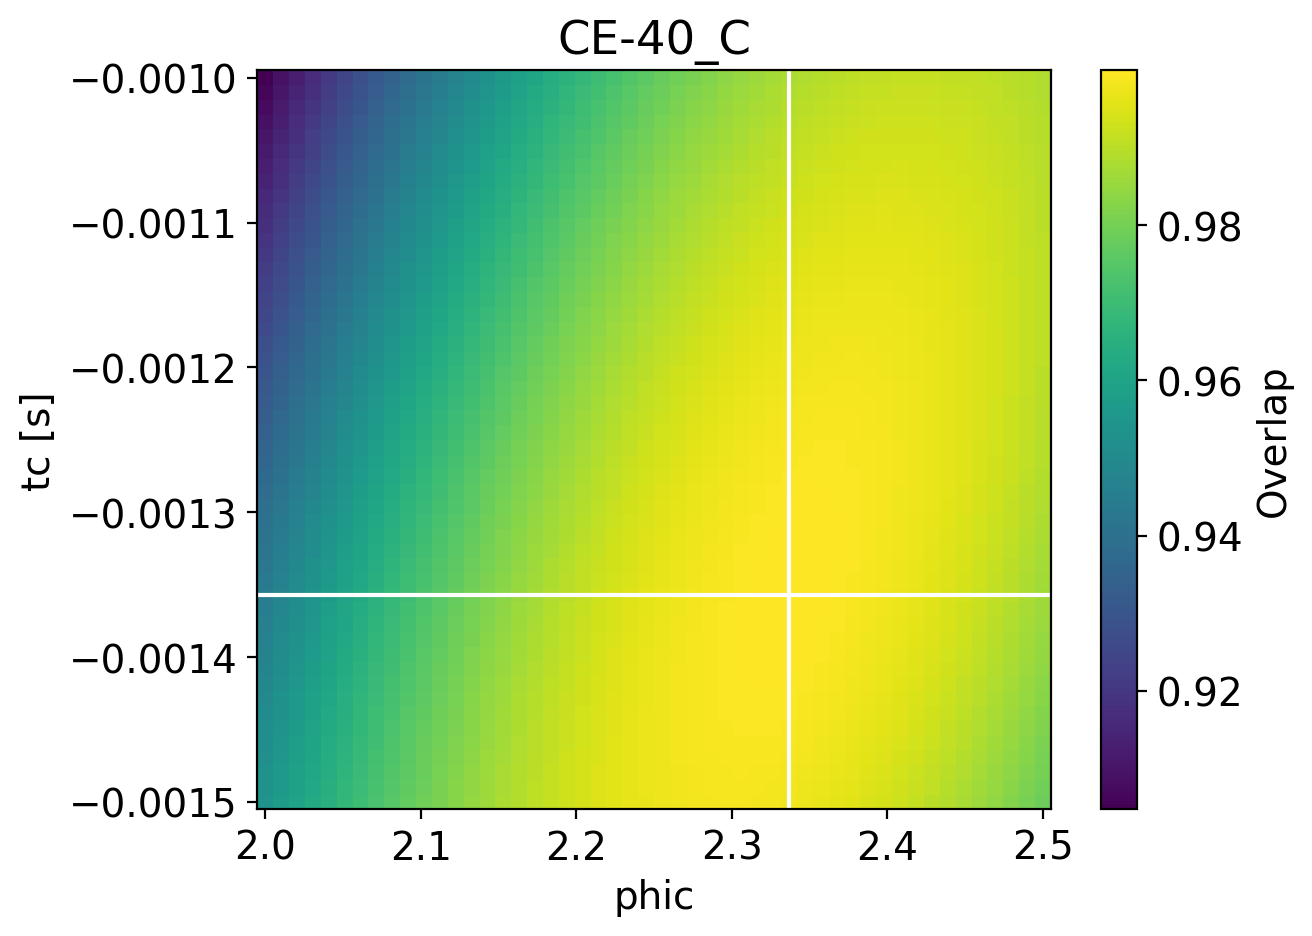

Maximum Overlap: 0.9999245431199408
Optimal (tc, phic): -0.0013571428571428571, 2.336734693877551


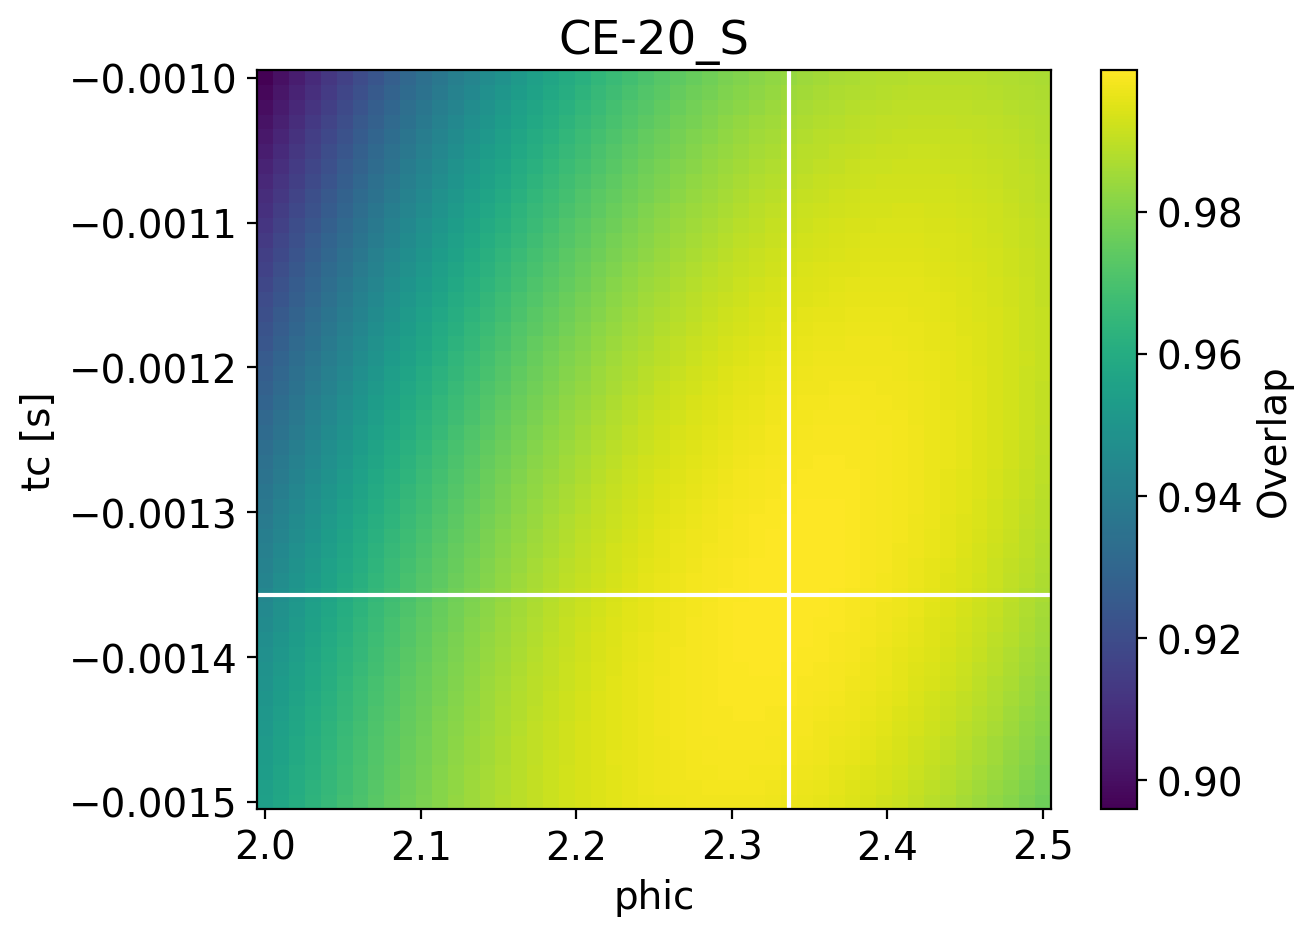

Maximum Overlap: 0.9998530749230476
Optimal (tc, phic): -0.0013571428571428571, 2.326530612244898


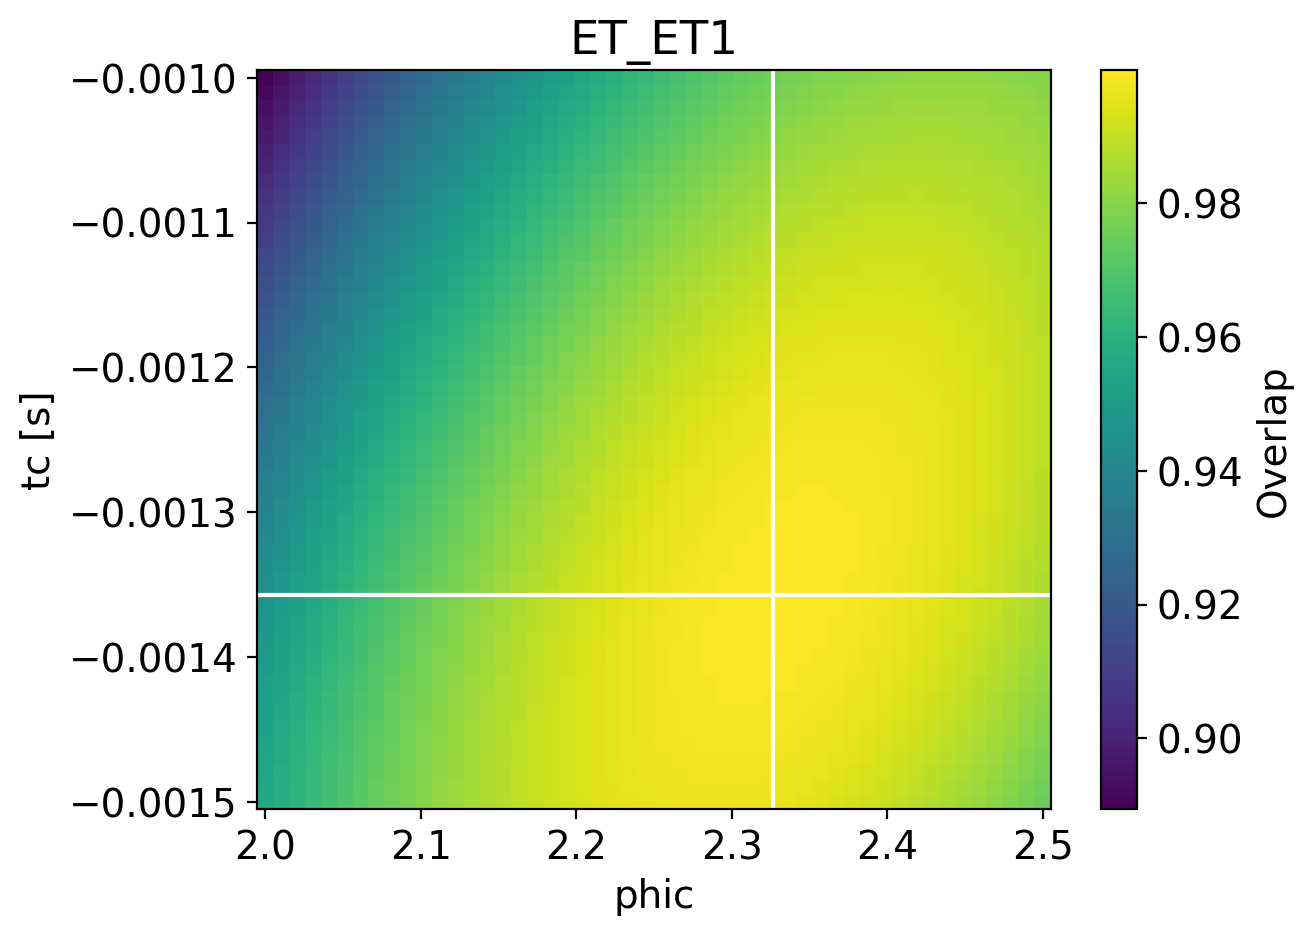

Maximum Overlap: 0.9998530749230476
Optimal (tc, phic): -0.0013571428571428571, 2.326530612244898


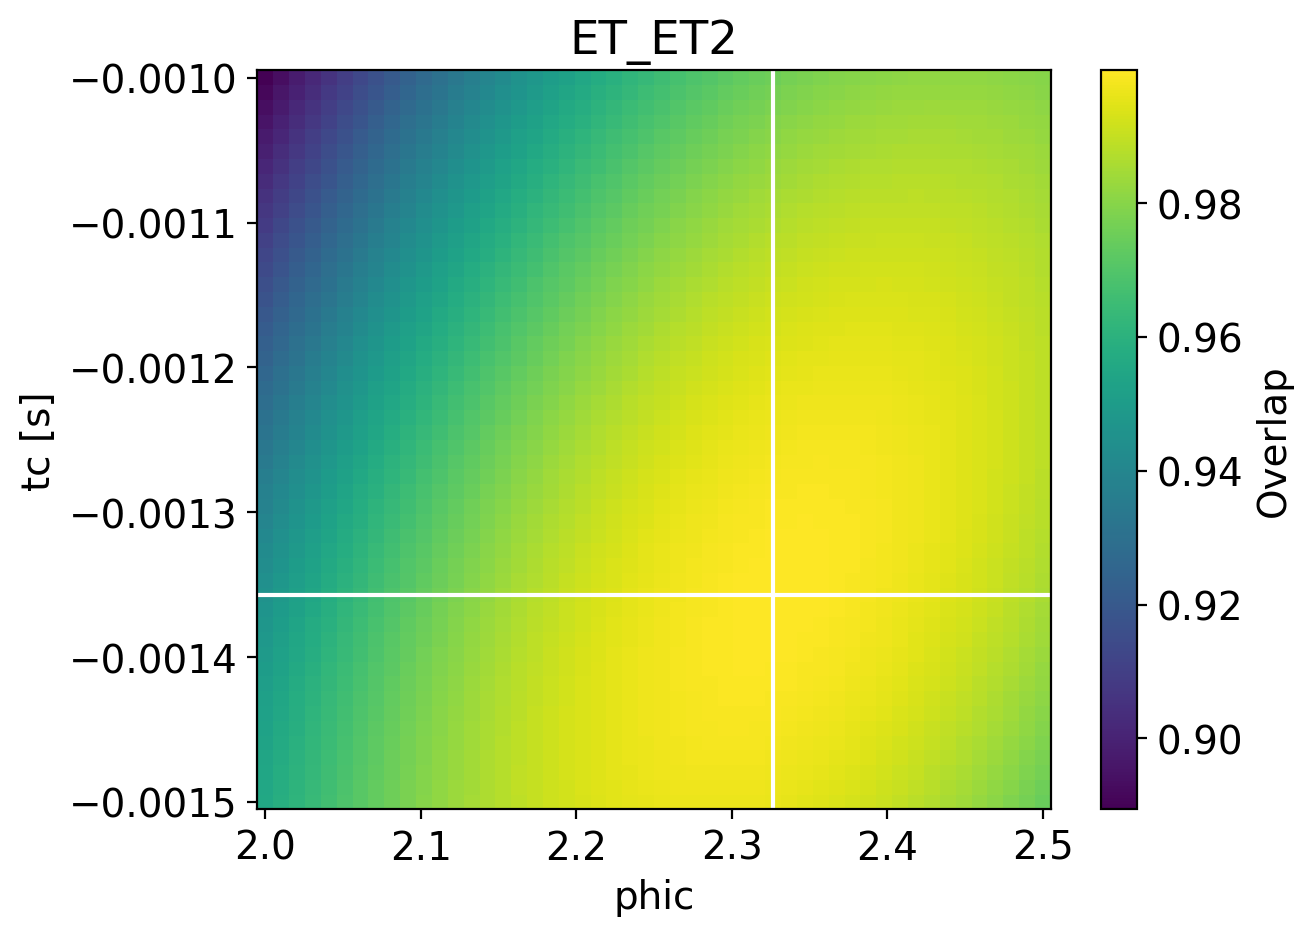

Maximum Overlap: 0.9998530749230473
Optimal (tc, phic): -0.0013571428571428571, 2.326530612244898


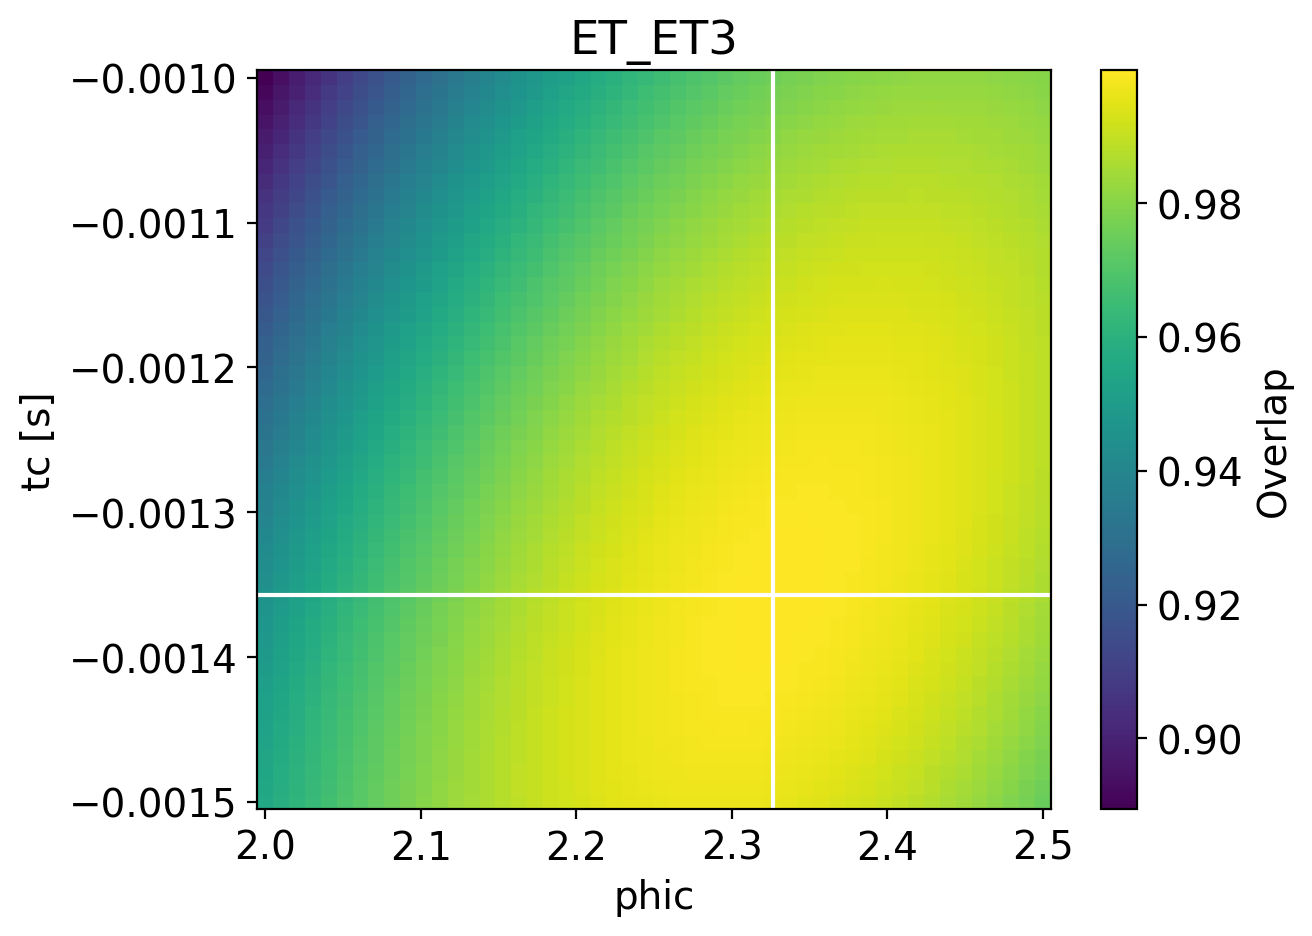

In [19]:
for d in range(len(net_tr.detectors)):

    max_idx = np.unravel_index(inner_prod_grid[d].argmax(), inner_prod_grid[d].shape)

    print(f"Maximum Overlap: {inner_prod_grid[d][max_idx]}")
    print(f"Optimal (tc, phic): {time_shifts[max_idx[0]]}, {phase_shifts[max_idx[1]]}")

    im = plt.pcolormesh(phase_shifts, time_shifts, inner_prod_grid[d])
    # plt.semilogy()
    plt.colorbar(im, label='Overlap')

    plt.xlabel('phic')
    plt.ylabel('tc [s]')
    
    plt.axvline(x=phase_shifts[max_idx[1]], c='w')
    plt.axhline(y=time_shifts[max_idx[0]], c='w')
    plt.title(net_tr.det_keys[d])
    plt.show()

In [20]:
net_ap = gwnet.get_network_response(inj_params=inj_params, f_min=f_low, f_max=f_high, d_f=d_f,  deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomD', network_spec=network_spec, calc_detector_responses=True, calc_derivs = True, calc_fisher=True)

overlap_vecs_network = np.zeros((len(net_ap.detectors), len(net_ap.deriv_variables)))

for d in range(len(net_ap.detectors)):

    ## set up initial waveforms
    h2 = net_ap.detectors[d].hf
    f = net_ap.detectors[d].f
    Sn = net_ap.detectors[d].psd
    network_spec_d = [net_ap.detectors[d].det_key]

    inj_params_opt_d = inj_params.copy()
    max_idx = np.unravel_index(inner_prod_grid[d].argmax(), inner_prod_grid[d].shape)
    
    inj_params_opt_d['tc'] = -time_shifts[max_idx[0]]
    inj_params_opt_d['phic'] = -phase_shifts[max_idx[1]]
    

    net_tr_opt_d = gwnet.get_network_response(inj_params=inj_params_opt_d, f_min=f_low, f_max=f_high, d_f=d_f,  deriv_symbs_string=deriv_symbs_string, approximant='IMRPhenomXAS', network_spec=network_spec_d,  calc_detector_responses=True, calc_derivs = False, calc_fisher=False)


    ## Compute CV overlap vector for this detector
    delta_hf =  net_tr_opt_d.detectors[0].hf - net_ap.detectors[d].hf
    overlap_vecs_network[d] = cutler_vallisneri_overlap_vec(net_ap.detectors[d].del_hf, delta_hf, net_ap.detectors[d].psd, net_ap.detectors[d].f)

cv_bias_opt_grid = np.matmul(net_ap.cov, np.sum(overlap_vecs_network, axis=0))
cv_bias_opt_grid = cv_bias_opt_grid.tolist()[0]

2023-12-28 17:12:50,118 - Network - INFO : Polarizations calculated.
2023-12-28 17:12:50,119 - Network - INFO : Calculate numeric derivatives of polarizations.
2023-12-28 17:12:50,125 - Network - INFO : Polarizations calculated.


['CE-40_C', 'CE-20_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']


2023-12-28 17:12:55,708 - Network - INFO : Numeric derivatives of polarizations calculated.
2023-12-28 17:12:55,755 - Network - INFO : PSDs loaded.
2023-12-28 17:12:55,760 - Network - INFO : Antenna patterns and LPFs loaded.
2023-12-28 17:12:55,784 - Network - INFO : Detector responses calculated.
2023-12-28 17:12:55,785 - Network - INFO : Calculate numeric derivatives of detector responses.
2023-12-28 17:12:55,785 - Network - INFO :    CE-40_C
2023-12-28 17:12:59,481 - Network - INFO :    CE-20_S
2023-12-28 17:13:03,199 - Network - INFO :    ET_ET1
2023-12-28 17:13:06,919 - Network - INFO :    ET_ET2
2023-12-28 17:13:10,624 - Network - INFO :    ET_ET3
2023-12-28 17:13:14,310 - Network - INFO : Numeric derivatives of detector responses calculated.
2023-12-28 17:13:14,319 - Network - INFO : SNRs calculated.
2023-12-28 17:13:14,319 - Network - INFO : Calculate errors (Fisher & cov matrices).
2023-12-28 17:13:14,320 - Network - INFO :    CE-40_C
2023-12-28 17:13:14,414 - Network - INFO :

['CE-40_C']
['CE-20_S']
['ET_ET1']
['ET_ET2']
['ET_ET3']


2023-12-28 17:13:15,113 - Network - INFO : Detector responses calculated.
2023-12-28 17:13:15,116 - Network - INFO : SNRs calculated.


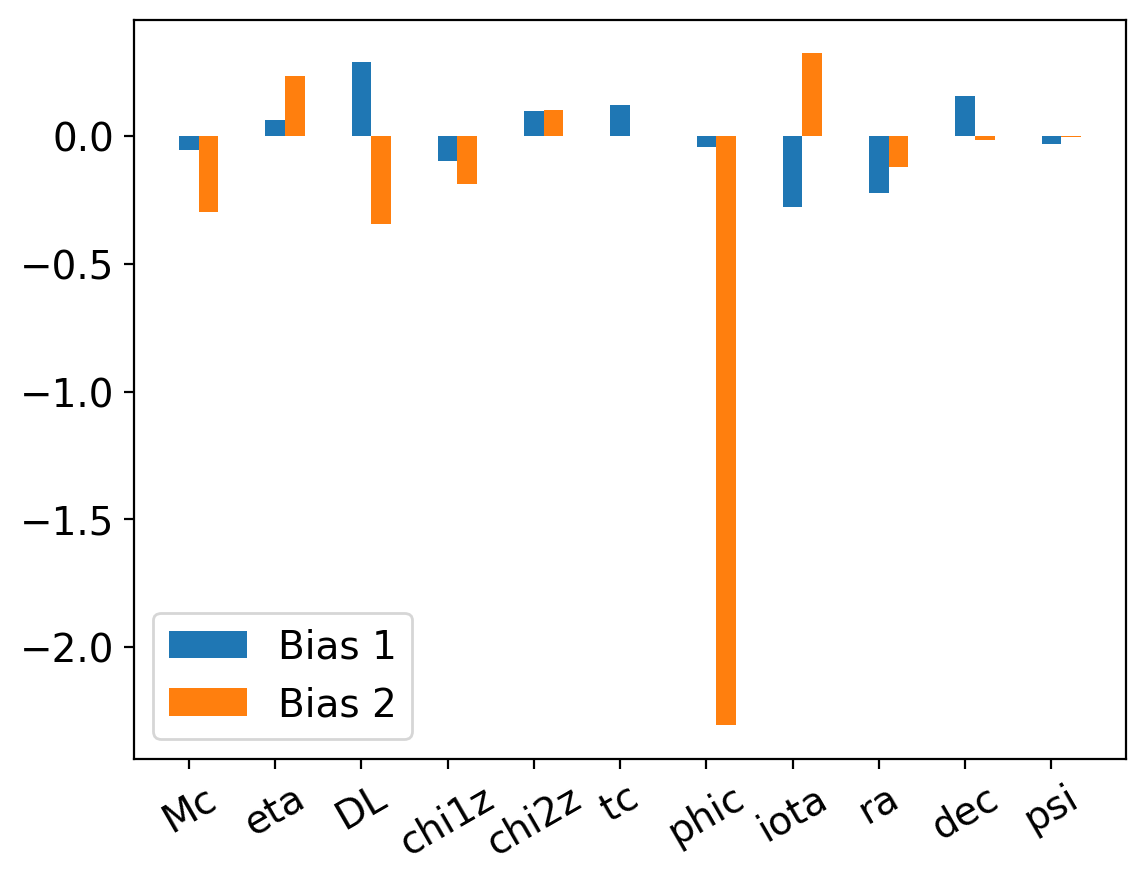

Mc, 1: -0.05335 
Mc, 2: -0.29559 

eta, 1: 0.06307 
eta, 2: 0.23718 

DL, 1: 0.28844 
DL, 2: -0.34411 

chi1z, 1: -0.09659 
chi1z, 2: -0.18720 

chi2z, 1: 0.09881 
chi2z, 2: 0.10293 

tc, 1: 0.12152 
tc, 2: 0.00000 

phic, 1: -0.04200 
phic, 2: -2.30598 

iota, 1: -0.27925 
iota, 2: 0.32501 

ra, 1: -0.22343 
ra, 2: -0.12062 

dec, 1: 0.15603 
dec, 2: -0.01555 

psi, 1: -0.03152 
psi, 2: -0.00359 



In [21]:
cv_bias_opt_sigma = np.zeros(len(cv_bias_opt_grid))
for i, var in enumerate(deriv_variables):
    cv_bias_opt_sigma[i] = cv_bias_opt_grid[i]/net_ap.errs[var]

    # bias_diff = 100*np.abs(pe_bias[i]-cv_bias_opt_sigma[i])/pe_bias[i]
    # print(f"{var}: {bias_diff:.3f}%")


bias1 = cv_bias_opt_sigma
bias2 = pe_bias

x = np.linspace(0, len(bias1), len(bias1))

width = 0.25
plt.bar(x, bias1, width=width, label='Bias 1')
plt.bar(x+width, bias2, width=width, label='Bias 2')


plt.xticks(x, net_ap.deriv_variables, rotation=30)

plt.legend()
plt.show()

for i, param in enumerate(net_ap.deriv_variables):
    print(f"{param}, 1: {bias1[i]:.5f} ")
    print(f"{param}, 2: {bias2[i]:.5f} ")
    print()